# About this notebook

In this notebook we'll explore the use of an LSTM model in order to predict battery voltages based on previous battery voltages and weather variables.

First the necessary data is loaded (battery pack + weather data). Next the necessary help functions for the LSTM algorithm are defined. In order to find the best match, different parameters are tried. In the last part, Talos is used to automise this process of parameter tuning and the results are compared

# Import libraries

In [1]:
import pandas as pd
import numpy as np
# tensorflow
import tensorflow as tf
#keras
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Dropout
from keras.optimizers import Adam, Nadam, RMSprop
from keras.activations import relu, elu, sigmoid
from keras.losses import binary_crossentropy, mae, mse
import sklearn.preprocessing
import sklearn.metrics
import talos as ta

Using TensorFlow backend.


In [581]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Load data

In [2]:
def load_battery_voltage(pack_id):
#     print("Loading the battery voltage and resampling to 5min intervals...")
#     df = pd.read_csv(r'C:\Users\JeffG\Desktop\Case 1 - data\battery_data\\' + str(pack_id) +'\Power.BatteryVoltHR_merged.csv',usecols=['time','value'])
    df = pd.read_csv(r'D:\Documents\Thesis\Case 1 - data\battery_data_' + str(pack_id) +'\Power.BatteryVoltHR_merged.csv',usecols=['time','value'])
    # Select timestamp and value from results
    data = df[['time','value']]
    # Convert object to float (BatteryVoltHR is an object for example)
    data["value"] = pd.to_numeric(data.value, errors='coerce')
    # Rename the column
    data.rename(columns={'value':'Power.BatteryVoltHR'}, inplace=True)
    # Set timestamp as index
    data['time'] = pd.to_datetime(data.time, unit='ms')
    data = data.resample(rule='5Min', on='time').mean().interpolate()
    return data

In [3]:
def load_weather_data():
    weather_metricsList = ['environment.light','environment.temperature','weather.uv','environment.relativehumidity',
              'weather.pressure', 'weather.rainrate', 'weather.windspeed']
    for i in range(0,len(weather_metricsList)):     
        metricID = weather_metricsList[i]
#         print("Loading " + str(metricID) + " and resampling to 5min intervals...")
#         df = pd.read_csv('C:/Users/JeffG/Desktop/Case 1 - data/weather_data/'+metricID+'_merged.csv',usecols=['time','value'])
        df = pd.read_csv('D:/Documents/Thesis/Case 1 - data/weather_data/'+metricID+'_merged.csv',usecols=['time','value'])

        if(i==0):
            # Select timestamp and value from results
            data = df[['time','value']]
            # Convert object to float (BatteryVoltHR is an object for example)
            data["value"] = pd.to_numeric(data.value, errors='coerce')
            # Rename the column
            data.rename(columns={'value': metricID}, inplace=True)
            # Calculate average for time bin and replace NaN with interpolation
            data['time'] = pd.to_datetime(data.time, unit='ms')
            data = data.resample(rule='5Min', on='time').mean().interpolate()
        else:
            data2 = df[['time','value']]
            # Convert object to float (BatteryVoltHR is an object for example)
            data2["value"] = pd.to_numeric(data2.value, errors='coerce')
            # Rename the column
            data2.rename(columns={'value':metricID}, inplace=True)
            # Calculate average for time bin and replace NaN with interpolation
            data2['time'] = pd.to_datetime(data2.time, unit='ms')
            data2 = data2.resample(rule='5Min', on='time').mean().interpolate()
            data = pd.merge(data, data2, on='time')
        
    return data

In [4]:
def get_data(pack_nr):
    battery_data = load_battery_voltage(pack_nr)
    weather_data = load_weather_data()
    data = pd.merge(battery_data, weather_data, on='time')
    return data

In [5]:
batterydata1 = get_data(1)
batterydata2 = get_data(2)
batterydata3 = get_data(3)

# LSTM data preparation

In [94]:
def scale_data(data):
    # load dataset
    values = data.values
    indexes = data.index
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaled, scaler

In [10]:
def series_to_supervised(data, indexes, column_names, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    	data: Sequence of observations as a list or NumPy array.
    	indexes: values of timestamp indexes
    	column_names: names of the columns
    	n_in: Number of lag observations as input (X).
    	n_out: Number of observations as output (y).
    	dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    	Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(column_names[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(column_names[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(column_names[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Set timestamps back as indexes
    agg = agg.set_index(indexes)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Define model

In [17]:
def battery_model(x_train, y_train, x_val, y_val, params):
    """
    This function implements an LSTM model based on the parameters that are passed on and returns the history and the model
    
    Args:
        x_train: DataFrame that has the features for training
        y_train: DataFrame that has the target variables for training
        x_val: DataFrame that has the features for validation
        y_val: DataFrame that has the target variables for validation
    """
    model = Sequential()
    model.add(LSTM(units=params['n_neurons'],
                   input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer']())
    # fit network
    history = model.fit(x_train, y_train,
                        validation_data=[x_val, y_val],
                        epochs=params['n_epochs'],
                        batch_size=params['n_batch_size'],
                        verbose=2,
                        shuffle=False)
    return history, model

In [170]:
import matplotlib.pyplot as plt
def plot_pred_actual(y_test, y_pred, batt_nr, params, loss):
    """
    Help function to plot the predicted values versus the real values
    """
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.plot(y_test, label='Actual',  color='black')
    plt.plot(y_pred, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Index')
    plt.ylabel('Normalized Battery voltage')
    plt.legend()
    plt.title('LSTM \n Nr of timesteps: {} \n Batch size: {} \n Epochs: {} \n Number of neurons: {} \n Optimizer: {} \n Loss function: {} \n Loss value: {}'. format(params['prev_timesteps'],
                                          params['n_batch_size'],
                                          params['n_epochs'],
                                          params['n_neurons'],
                                          params['optimizer'],
                                          params['losses'],
                                          loss))
    plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 1 - Smart Lighting\Results\LSTM' + '/LSTM_{}_{}_{}_{}_{}'.format(batt_nr,params['prev_timesteps'],
                                          params['n_batch_size'],
                                          params['n_epochs'],
                                          params['n_neurons']), bbox_inches = 'tight')
    plt.show()

# Manual checking

## Train on working battery pack

### Set parameters

In [577]:
params = {'n_batch_size': 83,
         'n_epochs': 83,
         'optimizer': Adam,
         'losses': mse,
         'n_neurons': 24,
         'prev_timesteps': 1}

In [578]:
n_in = params['prev_timesteps']
n_out = 1

### Prepare data

In [579]:
dataset = batterydata2.copy()
n_features = len(dataset.columns)
# normalize features
scaled, scaler = scale_data(dataset)
# frame as supervised learning
reframed = series_to_supervised(scaled, dataset.index, dataset.columns, n_in, n_out)
# drop columns we don't want to predict
reframed.drop(reframed.iloc[:, -(n_features - 1):], axis=1, inplace=True)
# Select data
x, y = reframed.values[:, :-1], reframed.values[:, -1]
x = x.reshape((x.shape[0], n_in, n_features))

In [582]:
reframed.head()

Power.BatteryVoltHR(t-1)  environment.light(t-1)  \
time                                                                    
2018-08-31 09:50:00                  0.995074                0.390336   
2018-08-31 09:55:00                  0.995074                0.389958   
2018-08-31 10:00:00                  0.995074                0.389580   
2018-08-31 10:05:00                  0.995074                0.389201   
2018-08-31 10:10:00                  0.995074                0.388823   

                     environment.temperature(t-1)  weather.uv(t-1)  \
time                                                                 
2018-08-31 09:50:00                      0.679072         0.477414   
2018-08-31 09:55:00                      0.679068         0.476846   
2018-08-31 10:00:00                      0.679064         0.476278   
2018-08-31 10:05:00                      0.679060         0.475709   
2018-08-31 10:10:00                      0.679055         0.475141   

                     environment.relativehumidity(t-1)  weather.pressure(t-1)  \
time                                                                            
2018-08-31 09:50:00                           0.502559               0.983526   
2018-08-31 09:55:00                           0.502802               0.983520   
2018-08-31 10:00:00                           0.503045               0.983515   
2018-08-31 10:05:00                           0.503288               0.983510   
2018-08-31 10:10:00                           0.503531               0.983505   

                     weather.rainrate(t-1)  weather.windspeed(t-1)  \
time                                                                 
2018-08-31 09:50:00                    0.0                0.085194   
2018-08-31 09:55:00                    0.0                0.085135   
2018-08-31 10:00:00                    0.0                0.085075   
2018-08-31 10:05:00                    0.0                0.085016   
2018-08-31 10:10:00                    0.0                0.084956   

                     Power.BatteryVoltHR(t)  
time                                         
2018-08-31 09:50:00                0.995074  
2018-08-31 09:55:00                0.995074  
2018-08-31 10:00:00                0.995074  
2018-08-31 10:05:00                0.995074  
2018-08-31 10:10:00                0.995074

### Train model

In [564]:
model = Sequential()
model.add(LSTM(units=params['n_neurons'],
                   input_shape=(x.shape[1], x.shape[2])))
model.add(Dense(1))
model.compile(loss=params['losses'],
                  optimizer=params['optimizer']())
# fit network
history = model.fit(x, y,
                        epochs=params['n_epochs'],
                        batch_size=params['n_batch_size'],
                        verbose=2,
                        shuffle=False)

Epoch 1/83
 - 5s - loss: 0.0422
Epoch 2/83
 - 1s - loss: 0.0077
Epoch 3/83
 - 1s - loss: 0.0046
Epoch 4/83
 - 1s - loss: 0.0029
Epoch 5/83
 - 1s - loss: 0.0020
Epoch 6/83
 - 1s - loss: 0.0015
Epoch 7/83
 - 1s - loss: 0.0012
Epoch 8/83
 - 1s - loss: 9.1854e-04
Epoch 9/83
 - 1s - loss: 7.4239e-04
Epoch 10/83
 - 1s - loss: 6.0856e-04
Epoch 11/83
 - 1s - loss: 4.9828e-04
Epoch 12/83
 - 1s - loss: 4.0212e-04
Epoch 13/83
 - 1s - loss: 3.1848e-04
Epoch 14/83
 - 1s - loss: 2.4818e-04
Epoch 15/83
 - 1s - loss: 1.9116e-04
Epoch 16/83
 - 1s - loss: 1.4506e-04
Epoch 17/83
 - 1s - loss: 1.0558e-04
Epoch 18/83
 - 1s - loss: 7.3031e-05
Epoch 19/83
 - 1s - loss: 5.1711e-05
Epoch 20/83
 - 1s - loss: 3.8323e-05
Epoch 21/83
 - 1s - loss: 3.3903e-05
Epoch 22/83
 - 1s - loss: 3.7500e-05
Epoch 23/83
 - 1s - loss: 5.1354e-05
Epoch 24/83
 - 1s - loss: 1.0312e-04
Epoch 25/83
 - 1s - loss: 1.5134e-04
Epoch 26/83
 - 1s - loss: 1.3987e-04
Epoch 27/83
 - 1s - loss: 1.0884e-04
Epoch 28/83
 - 1s - loss: 8.8755e-05
E

### Predict new values and calculate loss

In [565]:
y_pred = model.predict(x)

In [566]:
loss = model.evaluate(x, y, batch_size = params['n_batch_size'])

52010/52010 [==============================] - ETA: 15:5 - ETA: 10s  - ETA: 4 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37us/step


### Plot prediction vs real values

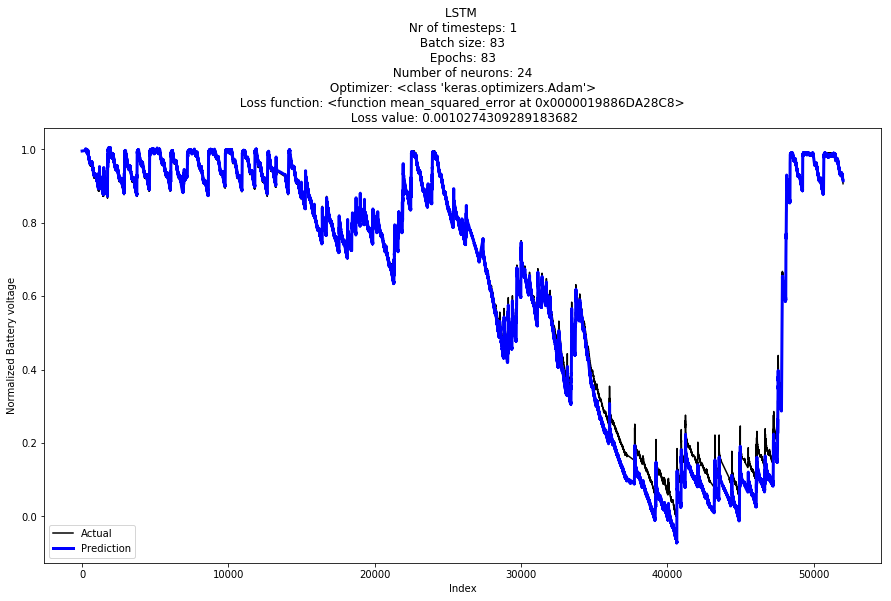

In [567]:
plot_pred_actual(y, y_pred, 2, params, loss)

# Use trained model to predict values of other battery packs
## Normal battery pack

### Prepare data

In [568]:
dataset2 = batterydata3.copy()
n_features2 = len(dataset2.columns)
# normalize features
scaled2, scaler2 = scale_data(dataset2)
# frame as supervised learning
reframed2 = series_to_supervised(scaled2, dataset2.index, dataset2.columns, n_in, n_out)
# drop columns we don't want to predict
reframed2.drop(reframed2.iloc[:, -(n_features2 - 1):], axis=1, inplace=True)
# Select data
x2, y2 = reframed2.values[:, :-1], reframed2.values[:, -1]
x2 = x2.reshape((x2.shape[0], n_in, n_features2))

### Predict new values and calculate loss

In [ ]:
y_pred2 = model.predict(x2)

In [570]:
loss2 = model.evaluate(x2, y2, batch_size = params['n_batch_size'])

52010/52010 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 7us/step


### Plot prediction vs real values

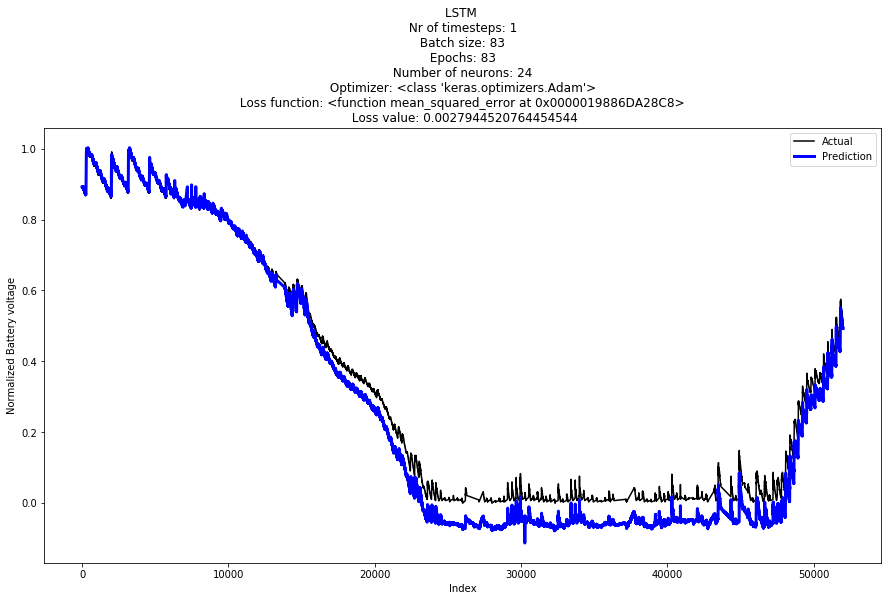

In [571]:
plot_pred_actual(y2, y_pred2, 3, params, loss2)

## Anomalous battery pack

### Prepare data

In [572]:
dataset3 = batterydata1.copy()
n_features3 = len(dataset3.columns)
# normalize features
scaled3, scaler3 = scale_data(dataset3)
# frame as supervised learning
reframed3 = series_to_supervised(scaled3, dataset3.index, dataset3.columns, n_in, n_out)
# drop columns we don't want to predict
reframed3.drop(reframed3.iloc[:, -(n_features3 - 1):], axis=1, inplace=True)
# Select data
x3, y3 = reframed3.values[:, :-1], reframed3.values[:, -1]
x3 = x3.reshape((x3.shape[0], n_in, n_features3))

### Predict new values and calculate loss

In [573]:
y_pred3 = model.predict(x3)

In [574]:
loss3 = model.evaluate(x3, y3, batch_size = params['n_batch_size'])

43273/43273 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 7us/step


### Plot prediction vs real values

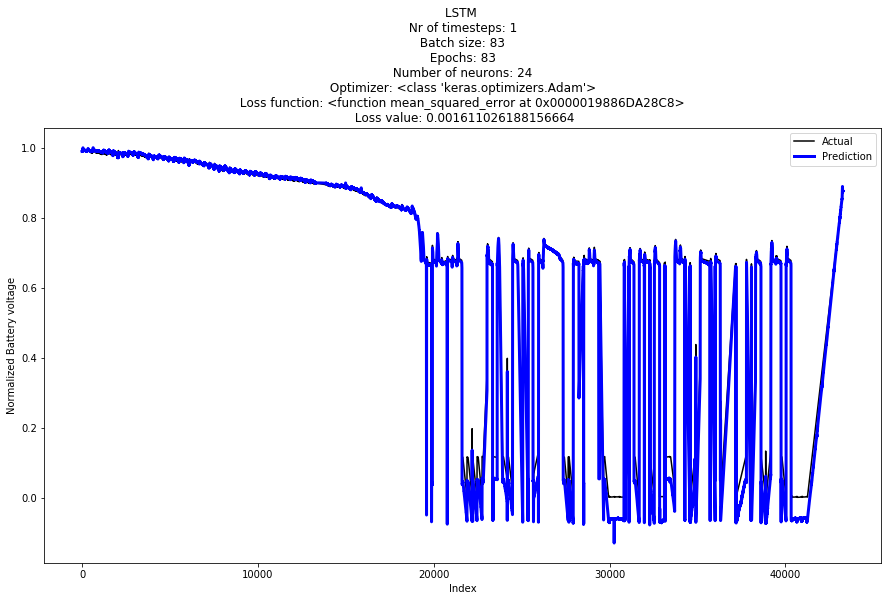

In [575]:
plot_pred_actual(y3, y_pred3, 1, params, loss3)

# Hyperparameter tuning using Talos
## Set parameter space

In [15]:
def set_parameter_space():
    p = {'n_batch_size': (16, 128, 5),
         'n_epochs': (10, 250, 5),
         'optimizer': [Adam, RMSprop],
         'losses': [mae, mse],
         'n_neurons': (5, 100, 10),
         'prev_timesteps': [1, 3, 6, 12, 24]}

    return p

In [16]:
p = set_parameter_space()

## Run scan

In [18]:
t = ta.Scan(x=x,
            y=y,
            val_split=0.3,
            shuffle=False,
            model=battery_model,
            grid_downsample=.1,
            reduction_metric='val_loss',
            reduce_loss=True,
            params=p,
            dataset_name='Battery_data',
            experiment_no='3',
            print_params=True)

  0%|                                                  | 0/500 [00:00<?, ?it/s]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 12}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0288 - val_loss: 0.1940
Epoch 2/106
 - 2s - loss: 0.0240 - val_loss: 0.1805
Epoch 3/106
 - 2s - loss: 0.0216 - val_loss: 0.1566
Epoch 4/106
 - 2s - loss: 0.0206 - val_loss: 0.1489
Epoch 5/106
 - 2s - loss: 0.0190 - val_loss: 0.1393
Epoch 6/106
 - 2s - loss: 0.0178 - val_loss: 0.1376
Epoch 7/106
 - 2s - loss: 0.0165 - val_loss: 0.1218
Epoch 8/106
 - 2s - loss: 0.0159 - val_loss: 0.1195
Epoch 9/106
 - 2s - loss: 0.0152 - val_loss: 0.1152
Epoch 10/106
 - 2s - loss: 0.0142 - val_loss: 0.0997
Epoch 11/106
 - 2s - loss: 0.0140 - val_loss: 0.0966
Epoch 12/106
 - 2s - loss: 0.0133 - val_loss: 0.0828
Epoch 13/106


  0%|                                      | 1/500 [03:22<28:06:24, 202.77s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0046 - val_loss: 0.0676
Epoch 2/154
 - 4s - loss: 0.0012 - val_loss: 0.0678
Epoch 3/154
 - 4s - loss: 0.0011 - val_loss: 0.0726
Epoch 4/154
 - 4s - loss: 0.0013 - val_loss: 0.0738
Epoch 5/154
 - 6s - loss: 0.0014 - val_loss: 0.0703
Epoch 6/154
 - 5s - loss: 0.0015 - val_loss: 0.0669
Epoch 7/154
 - 4s - loss: 0.0015 - val_loss: 0.0627
Epoch 8/154
 - 4s - loss: 0.0016 - val_loss: 0.0576
Epoch 9/154
 - 4s - loss: 0.0015 - val_loss: 0.0531
Epoch 10/154
 - 4s - loss: 0.0015 - val_loss: 0.0481
Epoch 11/154
 - 4s - loss: 0.0014 - val_loss: 0.0424
Epoch 12/154
 - 4s - loss: 0.0013 - val_loss: 0.0363
Epoch 13/154
 - 5s - loss: 0.0011 - val_loss: 0.0313
Epoch 14/154
 - 4s - loss: 0.0010 - val_loss: 0.0254
Epoch 15/154
 - 4s - loss: 8.805

  0%|▏                                     | 2/500 [16:30<52:19:35, 378.26s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0622 - val_loss: 0.1888
Epoch 2/58
 - 1s - loss: 0.0316 - val_loss: 0.1671
Epoch 3/58
 - 1s - loss: 0.0269 - val_loss: 0.1473
Epoch 4/58
 - 1s - loss: 0.0245 - val_loss: 0.1326
Epoch 5/58
 - 1s - loss: 0.0236 - val_loss: 0.1158
Epoch 6/58
 - 1s - loss: 0.0215 - val_loss: 0.1052
Epoch 7/58
 - 1s - loss: 0.0206 - val_loss: 0.0938
Epoch 8/58
 - 1s - loss: 0.0192 - val_loss: 0.0822
Epoch 9/58
 - 1s - loss: 0.0187 - val_loss: 0.0703
Epoch 10/58
 - 1s - loss: 0.0179 - val_loss: 0.0639
Epoch 11/58
 - 1s - loss: 0.0168 - val_loss: 0.0687
Epoch 12/58
 - 1s - loss: 0.0166 - val_loss: 0.0602
Epoch 13/58
 - 1s - loss: 0.0155 - val_loss: 0.0591
Epoch 14/58
 - 1s - loss: 0.0152 - val_loss: 0.0477
Epoch 15/58
 - 1s - loss: 0.0151 - val_los

  1%|▏                                     | 3/500 [17:16<38:26:44, 278.48s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0269 - val_loss: 0.0631
Epoch 2/58
 - 1s - loss: 0.0066 - val_loss: 0.0423
Epoch 3/58
 - 1s - loss: 0.0046 - val_loss: 0.0288
Epoch 4/58
 - 1s - loss: 0.0033 - val_loss: 0.0191
Epoch 5/58
 - 1s - loss: 0.0021 - val_loss: 0.0115
Epoch 6/58
 - 1s - loss: 0.0011 - val_loss: 0.0061
Epoch 7/58
 - 1s - loss: 6.1542e-04 - val_loss: 0.0034
Epoch 8/58
 - 1s - loss: 3.9652e-04 - val_loss: 0.0020
Epoch 9/58
 - 1s - loss: 2.7651e-04 - val_loss: 0.0012
Epoch 10/58
 - 1s - loss: 1.9997e-04 - val_loss: 7.7473e-04
Epoch 11/58
 - 1s - loss: 1.6863e-04 - val_loss: 7.2085e-04
Epoch 12/58
 - 1s - loss: 1.7723e-04 - val_loss: 9.1116e-04
Epoch 13/58
 - 1s - loss: 2.1362e-04 - val_loss: 0.0015
Epoch 14/58
 - 1s - loss: 2.8983e-04 - val_loss: 0.0025
Ep

  1%|▎                                     | 4/500 [18:23<29:37:48, 215.06s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0209 - val_loss: 0.0770
Epoch 2/10
 - 1s - loss: 0.0069 - val_loss: 0.0512
Epoch 3/10
 - 1s - loss: 0.0046 - val_loss: 0.0361
Epoch 4/10
 - 1s - loss: 0.0032 - val_loss: 0.0248
Epoch 5/10
 - 1s - loss: 0.0021 - val_loss: 0.0166
Epoch 6/10
 - 1s - loss: 0.0015 - val_loss: 0.0113
Epoch 7/10
 - 1s - loss: 0.0012 - val_loss: 0.0085
Epoch 8/10
 - 1s - loss: 0.0010 - val_loss: 0.0071
Epoch 9/10
 - 1s - loss: 9.0935e-04 - val_loss: 0.0064
Epoch 10/10
 - 1s - loss: 8.5764e-04 - val_loss: 0.0061


  1%|▍                                     | 5/500 [18:39<21:21:09, 155.29s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0840 - val_loss: 0.1202
Epoch 2/58
 - 2s - loss: 0.0114 - val_loss: 0.0972
Epoch 3/58
 - 2s - loss: 0.0078 - val_loss: 0.0703
Epoch 4/58
 - 2s - loss: 0.0047 - val_loss: 0.0426
Epoch 5/58
 - 2s - loss: 0.0030 - val_loss: 0.0268
Epoch 6/58
 - 2s - loss: 0.0021 - val_loss: 0.0180
Epoch 7/58
 - 2s - loss: 0.0016 - val_loss: 0.0136
Epoch 8/58
 - 2s - loss: 0.0013 - val_loss: 0.0111
Epoch 9/58
 - 2s - loss: 0.0011 - val_loss: 0.0095
Epoch 10/58
 - 2s - loss: 9.1810e-04 - val_loss: 0.0081
Epoch 11/58
 - 2s - loss: 7.9603e-04 - val_loss: 0.0066
Epoch 12/58
 - 2s - loss: 6.6986e-04 - val_loss: 0.0054
Epoch 13/58
 - 2s - loss: 5.9027e-04 - val_loss: 0.0043
Epoch 14/58
 - 2s - loss: 5.0496e-04 - val_loss: 0.0035
Epoch 15/58
 - 2s - loss: 4.

  1%|▍                                     | 6/500 [20:16<18:56:06, 137.99s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0067 - val_loss: 0.0684
Epoch 2/10
 - 2s - loss: 0.0010 - val_loss: 0.0571
Epoch 3/10
 - 2s - loss: 8.4098e-04 - val_loss: 0.0518
Epoch 4/10
 - 2s - loss: 8.1834e-04 - val_loss: 0.0452
Epoch 5/10
 - 2s - loss: 7.2645e-04 - val_loss: 0.0394
Epoch 6/10
 - 2s - loss: 6.3411e-04 - val_loss: 0.0357
Epoch 7/10
 - 3s - loss: 5.7667e-04 - val_loss: 0.0330
Epoch 8/10
 - 2s - loss: 5.3353e-04 - val_loss: 0.0309
Epoch 9/10
 - 2s - loss: 5.0269e-04 - val_loss: 0.0289
Epoch 10/10
 - 2s - loss: 4.7318e-04 - val_loss: 0.0266


  1%|▌                                     | 7/500 [20:41<14:14:50, 104.04s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0017 - val_loss: 0.0751
Epoch 2/106
 - 4s - loss: 6.3256e-04 - val_loss: 0.0674
Epoch 3/106
 - 4s - loss: 6.1605e-04 - val_loss: 0.0635
Epoch 4/106
 - 4s - loss: 6.0572e-04 - val_loss: 0.0588
Epoch 5/106
 - 4s - loss: 5.5998e-04 - val_loss: 0.0553
Epoch 6/106
 - 4s - loss: 5.2199e-04 - val_loss: 0.0535
Epoch 7/106
 - 4s - loss: 5.1887e-04 - val_loss: 0.0520
Epoch 8/106
 - 4s - loss: 4.9839e-04 - val_loss: 0.0517
Epoch 9/106
 - 4s - loss: 5.0006e-04 - val_loss: 0.0506
Epoch 10/106
 - 4s - loss: 4.8406e-04 - val_loss: 0.0499
Epoch 11/106
 - 4s - loss: 4.8521e-04 - val_loss: 0.0501
Epoch 12/106
 - 4s - loss: 5.1729e-04 - val_loss: 0.0492
Epoch 13/106
 - 4s - loss: 5.0767e-04 - val_loss: 0.0476
Epoch 14/106
 - 4s - loss: 4.9289e

  2%|▌                                     | 8/500 [27:24<26:29:05, 193.79s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.1067 - val_loss: 0.2167
Epoch 2/106
 - 1s - loss: 0.0723 - val_loss: 0.1806
Epoch 3/106
 - 1s - loss: 0.0617 - val_loss: 0.1480
Epoch 4/106
 - 1s - loss: 0.0529 - val_loss: 0.1152
Epoch 5/106
 - 1s - loss: 0.0475 - val_loss: 0.0952
Epoch 6/106
 - 1s - loss: 0.0392 - val_loss: 0.0917
Epoch 7/106
 - 1s - loss: 0.0305 - val_loss: 0.0822
Epoch 8/106
 - 1s - loss: 0.0255 - val_loss: 0.0760
Epoch 9/106
 - 1s - loss: 0.0215 - val_loss: 0.0498
Epoch 10/106
 - 1s - loss: 0.0178 - val_loss: 0.0374
Epoch 11/106
 - 1s - loss: 0.0180 - val_loss: 0.0412
Epoch 12/106
 - 1s - loss: 0.0167 - val_loss: 0.0310
Epoch 13/106
 - 1s - loss: 0.0158 - val_loss: 0.0312
Epoch 14/106
 - 1s - loss: 0.0142 - val_loss: 0.0256
Epoch 15/106
 - 1s - loss: 0.01

  2%|▋                                     | 9/500 [28:53<22:08:45, 162.37s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0171 - val_loss: 0.2062
Epoch 2/10
 - 3s - loss: 0.0135 - val_loss: 0.1879
Epoch 3/10
 - 3s - loss: 0.0130 - val_loss: 0.1757
Epoch 4/10
 - 3s - loss: 0.0121 - val_loss: 0.1597
Epoch 5/10
 - 3s - loss: 0.0116 - val_loss: 0.1497
Epoch 6/10
 - 3s - loss: 0.0110 - val_loss: 0.1456
Epoch 7/10
 - 3s - loss: 0.0103 - val_loss: 0.1316
Epoch 8/10
 - 3s - loss: 0.0100 - val_loss: 0.1231
Epoch 9/10
 - 3s - loss: 0.0096 - val_loss: 0.1190
Epoch 10/10
 - 3s - loss: 0.0090 - val_loss: 0.1088


  2%|▋                                    | 10/500 [29:28<16:53:04, 124.05s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0861 - val_loss: 0.1729
Epoch 2/10
 - 1s - loss: 0.0590 - val_loss: 0.1396
Epoch 3/10
 - 1s - loss: 0.0487 - val_loss: 0.1106
Epoch 4/10
 - 1s - loss: 0.0400 - val_loss: 0.0933
Epoch 5/10
 - 1s - loss: 0.0322 - val_loss: 0.0835
Epoch 6/10
 - 1s - loss: 0.0266 - val_loss: 0.0777
Epoch 7/10
 - 1s - loss: 0.0235 - val_loss: 0.0594
Epoch 8/10
 - 1s - loss: 0.0208 - val_loss: 0.0534
Epoch 9/10
 - 1s - loss: 0.0198 - val_loss: 0.0489
Epoch 10/10
 - 1s - loss: 0.0183 - val_loss: 0.0458


  2%|▊                                     | 11/500 [29:39<12:14:10, 90.08s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 4s - loss: 0.0216 - val_loss: 0.2169
Epoch 2/58
 - 4s - loss: 0.0165 - val_loss: 0.1893
Epoch 3/58
 - 4s - loss: 0.0148 - val_loss: 0.1773
Epoch 4/58
 - 4s - loss: 0.0137 - val_loss: 0.1672
Epoch 5/58
 - 4s - loss: 0.0128 - val_loss: 0.1567
Epoch 6/58
 - 4s - loss: 0.0120 - val_loss: 0.1591
Epoch 7/58
 - 4s - loss: 0.0114 - val_loss: 0.1510
Epoch 8/58
 - 4s - loss: 0.0110 - val_loss: 0.1400
Epoch 9/58
 - 4s - loss: 0.0107 - val_loss: 0.1331
Epoch 10/58
 - 4s - loss: 0.0103 - val_loss: 0.1210
Epoch 11/58
 - 4s - loss: 0.0101 - val_loss: 0.1172
Epoch 12/58
 - 4s - loss: 0.0098 - val_loss: 0.1179
Epoch 13/58
 - 4s - loss: 0.0094 - val_loss: 0.1054
Epoch 14/58
 - 4s - loss: 0.0092 - val_loss: 0.0996
Epoch 15/58
 - 4s - loss: 0.0091 - val_los

  2%|▉                                    | 12/500 [33:15<17:19:23, 127.79s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0288 - val_loss: 0.1882
Epoch 2/202
 - 2s - loss: 0.0220 - val_loss: 0.1709
Epoch 3/202
 - 2s - loss: 0.0204 - val_loss: 0.1535
Epoch 4/202
 - 2s - loss: 0.0193 - val_loss: 0.1529
Epoch 5/202
 - 2s - loss: 0.0177 - val_loss: 0.1438
Epoch 6/202
 - 2s - loss: 0.0169 - val_loss: 0.1323
Epoch 7/202
 - 2s - loss: 0.0159 - val_loss: 0.1253
Epoch 8/202
 - 2s - loss: 0.0152 - val_loss: 0.1158
Epoch 9/202
 - 2s - loss: 0.0146 - val_loss: 0.1105
Epoch 10/202
 - 2s - loss: 0.0139 - val_loss: 0.1046
Epoch 11/202
 - 2s - loss: 0.0134 - val_loss: 0.0878
Epoch 12/202
 - 2s - loss: 0.0131 - val_loss: 0.0916
Epoch 13/202
 - 2s - loss: 0.0124 - val_loss: 0.0811
Epoch 14/202
 - 2s - loss: 0.0122 - val_loss: 0.0748
Epoch 15/202
 - 2s - loss: 0

Epoch 151/202
 - 2s - loss: 0.0043 - val_loss: 0.0328
Epoch 152/202
 - 2s - loss: 0.0043 - val_loss: 0.0342
Epoch 153/202
 - 2s - loss: 0.0043 - val_loss: 0.0349
Epoch 154/202
 - 2s - loss: 0.0043 - val_loss: 0.0341
Epoch 155/202
 - 2s - loss: 0.0043 - val_loss: 0.0351
Epoch 156/202
 - 2s - loss: 0.0043 - val_loss: 0.0355
Epoch 157/202
 - 2s - loss: 0.0043 - val_loss: 0.0351
Epoch 158/202
 - 2s - loss: 0.0042 - val_loss: 0.0357
Epoch 159/202
 - 2s - loss: 0.0042 - val_loss: 0.0351
Epoch 160/202
 - 2s - loss: 0.0042 - val_loss: 0.0361
Epoch 161/202
 - 2s - loss: 0.0042 - val_loss: 0.0365
Epoch 162/202
 - 2s - loss: 0.0042 - val_loss: 0.0365
Epoch 163/202
 - 2s - loss: 0.0042 - val_loss: 0.0356
Epoch 164/202
 - 2s - loss: 0.0042 - val_loss: 0.0359
Epoch 165/202
 - 2s - loss: 0.0042 - val_loss: 0.0366
Epoch 166/202
 - 2s - loss: 0.0042 - val_loss: 0.0371
Epoch 167/202
 - 2s - loss: 0.0042 - val_loss: 0.0364
Epoch 168/202
 - 2s - loss: 0.0042 - val_loss: 0.0317
Epoch 169/202
 - 2s - loss: 

  3%|▉                                    | 13/500 [39:46<27:59:49, 206.96s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0254 - val_loss: 0.0764
Epoch 2/154
 - 1s - loss: 0.0075 - val_loss: 0.0471
Epoch 3/154
 - 1s - loss: 0.0047 - val_loss: 0.0293
Epoch 4/154
 - 1s - loss: 0.0032 - val_loss: 0.0173
Epoch 5/154
 - 1s - loss: 0.0020 - val_loss: 0.0094
Epoch 6/154
 - 1s - loss: 0.0011 - val_loss: 0.0046
Epoch 7/154
 - 1s - loss: 5.3068e-04 - val_loss: 0.0022
Epoch 8/154
 - 1s - loss: 2.9784e-04 - val_loss: 0.0011
Epoch 9/154
 - 1s - loss: 1.7693e-04 - val_loss: 5.3324e-04
Epoch 10/154
 - 1s - loss: 1.0611e-04 - val_loss: 2.3388e-04
Epoch 11/154
 - 1s - loss: 7.5515e-05 - val_loss: 1.3656e-04
Epoch 12/154
 - 1s - loss: 7.2585e-05 - val_loss: 1.5017e-04
Epoch 13/154
 - 1s - loss: 8.3253e-05 - val_loss: 3.3791e-04
Epoch 14/154
 - 1s - loss: 1.1682e-0

Epoch 136/154
 - 1s - loss: 3.0490e-05 - val_loss: 7.1318e-04
Epoch 137/154
 - 1s - loss: 2.9086e-05 - val_loss: 7.3489e-04
Epoch 138/154
 - 1s - loss: 2.8204e-05 - val_loss: 7.5466e-04
Epoch 139/154
 - 1s - loss: 2.7436e-05 - val_loss: 7.5718e-04
Epoch 140/154
 - 1s - loss: 2.6917e-05 - val_loss: 7.5045e-04
Epoch 141/154
 - 1s - loss: 2.7138e-05 - val_loss: 7.3124e-04
Epoch 142/154
 - 1s - loss: 2.8539e-05 - val_loss: 7.0412e-04
Epoch 143/154
 - 1s - loss: 2.9661e-05 - val_loss: 6.4384e-04
Epoch 144/154
 - 1s - loss: 2.9539e-05 - val_loss: 5.7855e-04
Epoch 145/154
 - 1s - loss: 3.0230e-05 - val_loss: 5.4742e-04
Epoch 146/154
 - 1s - loss: 3.3887e-05 - val_loss: 6.1726e-04
Epoch 147/154
 - 1s - loss: 4.7092e-05 - val_loss: 8.9786e-04
Epoch 148/154
 - 1s - loss: 7.2203e-05 - val_loss: 9.4232e-04
Epoch 149/154
 - 1s - loss: 7.6779e-05 - val_loss: 4.8656e-04
Epoch 150/154
 - 1s - loss: 6.6353e-05 - val_loss: 5.1143e-04
Epoch 151/154
 - 1s - loss: 7.0483e-05 - val_loss: 5.5521e-04
Epoch 15

  3%|█                                    | 14/500 [41:40<24:09:39, 178.97s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0420 - val_loss: 0.1741
Epoch 2/10
 - 2s - loss: 0.0357 - val_loss: 0.1843
Epoch 3/10
 - 2s - loss: 0.0386 - val_loss: 0.1759
Epoch 4/10
 - 2s - loss: 0.0393 - val_loss: 0.1677
Epoch 5/10
 - 2s - loss: 0.0397 - val_loss: 0.1579
Epoch 6/10
 - 2s - loss: 0.0381 - val_loss: 0.1521
Epoch 7/10
 - 2s - loss: 0.0369 - val_loss: 0.1478
Epoch 8/10
 - 2s - loss: 0.0355 - val_loss: 0.1438
Epoch 9/10
 - 2s - loss: 0.0363 - val_loss: 0.1355
Epoch 10/10
 - 2s - loss: 0.0352 - val_loss: 0.1289


  3%|█                                    | 15/500 [42:00<17:41:24, 131.31s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0441 - val_loss: 0.1932
Epoch 2/154
 - 1s - loss: 0.0307 - val_loss: 0.1571
Epoch 3/154
 - 1s - loss: 0.0276 - val_loss: 0.1346
Epoch 4/154
 - 1s - loss: 0.0254 - val_loss: 0.1180
Epoch 5/154
 - 1s - loss: 0.0237 - val_loss: 0.1133
Epoch 6/154
 - 1s - loss: 0.0226 - val_loss: 0.1052
Epoch 7/154
 - 1s - loss: 0.0212 - val_loss: 0.0969
Epoch 8/154
 - 1s - loss: 0.0197 - val_loss: 0.0944
Epoch 9/154
 - 1s - loss: 0.0195 - val_loss: 0.0845
Epoch 10/154
 - 1s - loss: 0.0190 - val_loss: 0.0777
Epoch 11/154
 - 1s - loss: 0.0184 - val_loss: 0.0766
Epoch 12/154
 - 1s - loss: 0.0176 - val_loss: 0.0649
Epoch 13/154
 - 1s - loss: 0.0173 - val_loss: 0.0588
Epoch 14/154
 - 1s - loss: 0.0167 - val_loss: 0.0553
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0060 - val_loss: 0.0273
Epoch 152/154
 - 1s - loss: 0.0059 - val_loss: 0.0239
Epoch 153/154
 - 1s - loss: 0.0059 - val_loss: 0.0280
Epoch 154/154
 - 1s - loss: 0.0059 - val_loss: 0.0285


  3%|█▏                                   | 16/500 [44:40<18:48:05, 139.85s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.1206 - val_loss: 0.0790
Epoch 2/10
 - 1s - loss: 0.0115 - val_loss: 0.0585
Epoch 3/10
 - 1s - loss: 0.0085 - val_loss: 0.0436
Epoch 4/10
 - 1s - loss: 0.0063 - val_loss: 0.0319
Epoch 5/10
 - 1s - loss: 0.0048 - val_loss: 0.0229
Epoch 6/10
 - 1s - loss: 0.0036 - val_loss: 0.0162
Epoch 7/10
 - 1s - loss: 0.0026 - val_loss: 0.0112
Epoch 8/10
 - 1s - loss: 0.0019 - val_loss: 0.0077
Epoch 9/10
 - 1s - loss: 0.0013 - val_loss: 0.0052
Epoch 10/10
 - 1s - loss: 8.7242e-04 - val_loss: 0.0036


  3%|█▎                                   | 17/500 [44:48<13:28:29, 100.43s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0078 - val_loss: 0.0450
Epoch 2/154
 - 1s - loss: 0.0012 - val_loss: 0.0374
Epoch 3/154
 - 1s - loss: 9.9222e-04 - val_loss: 0.0311
Epoch 4/154
 - 1s - loss: 8.4524e-04 - val_loss: 0.0267
Epoch 5/154
 - 1s - loss: 7.5071e-04 - val_loss: 0.0236
Epoch 6/154
 - 1s - loss: 6.7732e-04 - val_loss: 0.0211
Epoch 7/154
 - 1s - loss: 6.2025e-04 - val_loss: 0.0183
Epoch 8/154
 - 1s - loss: 5.5784e-04 - val_loss: 0.0164
Epoch 9/154
 - 1s - loss: 5.1825e-04 - val_loss: 0.0149
Epoch 10/154
 - 1s - loss: 4.8403e-04 - val_loss: 0.0132
Epoch 11/154
 - 1s - loss: 4.4945e-04 - val_loss: 0.0120
Epoch 12/154
 - 1s - loss: 4.2401e-04 - val_loss: 0.0116
Epoch 13/154
 - 1s - loss: 4.1480e-04 - val_loss: 0.0107
Epoch 14/154
 - 1s - loss: 3.9659e-04 

Epoch 137/154
 - 1s - loss: 5.9148e-05 - val_loss: 6.9655e-04
Epoch 138/154
 - 1s - loss: 5.8750e-05 - val_loss: 7.0336e-04
Epoch 139/154
 - 1s - loss: 5.8354e-05 - val_loss: 7.1252e-04
Epoch 140/154
 - 1s - loss: 5.7946e-05 - val_loss: 7.2554e-04
Epoch 141/154
 - 1s - loss: 5.7554e-05 - val_loss: 7.3355e-04
Epoch 142/154
 - 1s - loss: 5.7018e-05 - val_loss: 7.1947e-04
Epoch 143/154
 - 1s - loss: 5.6532e-05 - val_loss: 7.4975e-04
Epoch 144/154
 - 1s - loss: 5.6427e-05 - val_loss: 7.6051e-04
Epoch 145/154
 - 1s - loss: 5.6090e-05 - val_loss: 7.7214e-04
Epoch 146/154
 - 1s - loss: 5.5760e-05 - val_loss: 7.8367e-04
Epoch 147/154
 - 1s - loss: 5.5445e-05 - val_loss: 7.9646e-04
Epoch 148/154
 - 1s - loss: 5.5134e-05 - val_loss: 8.0943e-04
Epoch 149/154
 - 1s - loss: 5.4835e-05 - val_loss: 8.2392e-04
Epoch 150/154
 - 1s - loss: 5.4552e-05 - val_loss: 8.3837e-04
Epoch 151/154
 - 1s - loss: 5.4270e-05 - val_loss: 8.5530e-04
Epoch 152/154
 - 1s - loss: 5.4004e-05 - val_loss: 8.7199e-04
Epoch 15

  4%|█▎                                   | 18/500 [47:01<14:45:56, 110.28s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0101 - val_loss: 0.0547
Epoch 2/10
 - 1s - loss: 0.0016 - val_loss: 0.0433
Epoch 3/10
 - 1s - loss: 0.0013 - val_loss: 0.0357
Epoch 4/10
 - 1s - loss: 0.0011 - val_loss: 0.0297
Epoch 5/10
 - 1s - loss: 9.8284e-04 - val_loss: 0.0249
Epoch 6/10
 - 1s - loss: 8.6235e-04 - val_loss: 0.0222
Epoch 7/10
 - 1s - loss: 7.9722e-04 - val_loss: 0.0190
Epoch 8/10
 - 1s - loss: 7.0572e-04 - val_loss: 0.0169
Epoch 9/10
 - 1s - loss: 6.4521e-04 - val_loss: 0.0151
Epoch 10/10
 - 1s - loss: 5.9295e-04 - val_loss: 0.0142


  4%|█▍                                    | 19/500 [47:13<10:45:48, 80.56s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0412 - val_loss: 0.1694
Epoch 2/154
 - 1s - loss: 0.0324 - val_loss: 0.1561
Epoch 3/154
 - 1s - loss: 0.0278 - val_loss: 0.1386
Epoch 4/154
 - 1s - loss: 0.0251 - val_loss: 0.1185
Epoch 5/154
 - 1s - loss: 0.0237 - val_loss: 0.1078
Epoch 6/154
 - 1s - loss: 0.0224 - val_loss: 0.0915
Epoch 7/154
 - 1s - loss: 0.0216 - val_loss: 0.0851
Epoch 8/154
 - 1s - loss: 0.0202 - val_loss: 0.0770
Epoch 9/154
 - 1s - loss: 0.0194 - val_loss: 0.0707
Epoch 10/154
 - 1s - loss: 0.0187 - val_loss: 0.0690
Epoch 11/154
 - 1s - loss: 0.0181 - val_loss: 0.0667
Epoch 12/154
 - 1s - loss: 0.0176 - val_loss: 0.0603
Epoch 13/154
 - 1s - loss: 0.0170 - val_loss: 0.0488
Epoch 14/154
 - 1s - loss: 0.0165 - val_loss: 0.0532
Epoch 15/154
 - 1s - loss:

 - 1s - loss: 0.0066 - val_loss: 0.0162
Epoch 151/154
 - 1s - loss: 0.0066 - val_loss: 0.0173
Epoch 152/154
 - 1s - loss: 0.0064 - val_loss: 0.0197
Epoch 153/154
 - 1s - loss: 0.0065 - val_loss: 0.0188
Epoch 154/154
 - 1s - loss: 0.0066 - val_loss: 0.0181


  4%|█▌                                    | 20/500 [49:17<12:29:35, 93.70s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0430 - val_loss: 0.1784
Epoch 2/154
 - 1s - loss: 0.0289 - val_loss: 0.1418
Epoch 3/154
 - 1s - loss: 0.0266 - val_loss: 0.1281
Epoch 4/154
 - 1s - loss: 0.0249 - val_loss: 0.1164
Epoch 5/154
 - 1s - loss: 0.0238 - val_loss: 0.1154
Epoch 6/154
 - 1s - loss: 0.0221 - val_loss: 0.0983
Epoch 7/154
 - 1s - loss: 0.0214 - val_loss: 0.0991
Epoch 8/154
 - 1s - loss: 0.0196 - val_loss: 0.0931
Epoch 9/154
 - 1s - loss: 0.0187 - val_loss: 0.0781
Epoch 10/154
 - 1s - loss: 0.0186 - val_loss: 0.0744
Epoch 11/154
 - 1s - loss: 0.0182 - val_loss: 0.0699
Epoch 12/154
 - 1s - loss: 0.0173 - val_loss: 0.0656
Epoch 13/154
 - 1s - loss: 0.0168 - val_loss: 0.0591
Epoch 14/154
 - 1s - loss: 0.0167 - val_loss: 0.0657
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0060 - val_loss: 0.0188
Epoch 152/154
 - 1s - loss: 0.0059 - val_loss: 0.0196
Epoch 153/154
 - 1s - loss: 0.0059 - val_loss: 0.0200
Epoch 154/154
 - 1s - loss: 0.0058 - val_loss: 0.0207


  4%|█▌                                   | 21/500 [52:04<15:23:31, 115.68s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0095 - val_loss: 0.0759
Epoch 2/58
 - 1s - loss: 0.0020 - val_loss: 0.0580
Epoch 3/58
 - 1s - loss: 0.0016 - val_loss: 0.0491
Epoch 4/58
 - 1s - loss: 0.0014 - val_loss: 0.0419
Epoch 5/58
 - 1s - loss: 0.0013 - val_loss: 0.0363
Epoch 6/58
 - 1s - loss: 0.0011 - val_loss: 0.0319
Epoch 7/58
 - 1s - loss: 9.7777e-04 - val_loss: 0.0286
Epoch 8/58
 - 1s - loss: 8.9153e-04 - val_loss: 0.0258
Epoch 9/58
 - 1s - loss: 8.1139e-04 - val_loss: 0.0232
Epoch 10/58
 - 1s - loss: 7.3351e-04 - val_loss: 0.0212
Epoch 11/58
 - 1s - loss: 6.7572e-04 - val_loss: 0.0194
Epoch 12/58
 - 1s - loss: 6.2556e-04 - val_loss: 0.0181
Epoch 13/58
 - 1s - loss: 5.8462e-04 - val_loss: 0.0168
Epoch 14/58
 - 1s - loss: 5.4829e-04 - val_loss: 0.0157
Epoch 15/58

  4%|█▋                                   | 22/500 [53:16<13:36:18, 102.47s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0240 - val_loss: 0.0623
Epoch 2/58
 - 1s - loss: 0.0063 - val_loss: 0.0400
Epoch 3/58
 - 1s - loss: 0.0042 - val_loss: 0.0259
Epoch 4/58
 - 1s - loss: 0.0028 - val_loss: 0.0161
Epoch 5/58
 - 1s - loss: 0.0016 - val_loss: 0.0096
Epoch 6/58
 - 1s - loss: 9.6946e-04 - val_loss: 0.0058
Epoch 7/58
 - 1s - loss: 6.4801e-04 - val_loss: 0.0037
Epoch 8/58
 - 1s - loss: 4.6897e-04 - val_loss: 0.0024
Epoch 9/58
 - 1s - loss: 3.4827e-04 - val_loss: 0.0016
Epoch 10/58
 - 1s - loss: 2.7074e-04 - val_loss: 0.0013
Epoch 11/58
 - 1s - loss: 2.4630e-04 - val_loss: 0.0012
Epoch 12/58
 - 1s - loss: 2.5724e-04 - val_loss: 0.0015
Epoch 13/58
 - 1s - loss: 2.9773e-04 - val_loss: 0.0021
Epoch 14/58
 - 1s - loss: 3.7471e-04 - val_loss: 0.0030
Epoch 15/

  5%|█▋                                    | 23/500 [54:21<12:07:04, 91.46s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0521 - val_loss: 0.1862
Epoch 2/58
 - 1s - loss: 0.0312 - val_loss: 0.1679
Epoch 3/58
 - 1s - loss: 0.0275 - val_loss: 0.1331
Epoch 4/58
 - 1s - loss: 0.0263 - val_loss: 0.1335
Epoch 5/58
 - 1s - loss: 0.0236 - val_loss: 0.1209
Epoch 6/58
 - 1s - loss: 0.0226 - val_loss: 0.1101
Epoch 7/58
 - 1s - loss: 0.0213 - val_loss: 0.0990
Epoch 8/58
 - 1s - loss: 0.0205 - val_loss: 0.0919
Epoch 9/58
 - 1s - loss: 0.0199 - val_loss: 0.0868
Epoch 10/58
 - 1s - loss: 0.0193 - val_loss: 0.0742
Epoch 11/58
 - 1s - loss: 0.0184 - val_loss: 0.0701
Epoch 12/58
 - 1s - loss: 0.0177 - val_loss: 0.0692
Epoch 13/58
 - 1s - loss: 0.0171 - val_loss: 0.0552
Epoch 14/58
 - 1s - loss: 0.0169 - val_loss: 0.0516
Epoch 15/58
 - 1s - loss: 0.0167 - val_los

  5%|█▊                                    | 24/500 [55:05<10:12:10, 77.17s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0413 - val_loss: 0.1736
Epoch 2/154
 - 1s - loss: 0.0240 - val_loss: 0.1556
Epoch 3/154
 - 1s - loss: 0.0213 - val_loss: 0.1315
Epoch 4/154
 - 1s - loss: 0.0199 - val_loss: 0.1245
Epoch 5/154
 - 1s - loss: 0.0180 - val_loss: 0.1174
Epoch 6/154
 - 1s - loss: 0.0171 - val_loss: 0.1043
Epoch 7/154
 - 1s - loss: 0.0172 - val_loss: 0.0976
Epoch 8/154
 - 1s - loss: 0.0161 - val_loss: 0.1031
Epoch 9/154
 - 1s - loss: 0.0153 - val_loss: 0.0959
Epoch 10/154
 - 1s - loss: 0.0147 - val_loss: 0.0776
Epoch 11/154
 - 1s - loss: 0.0146 - val_loss: 0.0767
Epoch 12/154
 - 1s - loss: 0.0142 - val_loss: 0.0737
Epoch 13/154
 - 1s - loss: 0.0133 - val_loss: 0.0657
Epoch 14/154
 - 1s - loss: 0.0132 - val_loss: 0.0711
Epoch 15/154
 - 1s - loss: 

Epoch 151/154
 - 1s - loss: 0.0050 - val_loss: 0.0194
Epoch 152/154
 - 1s - loss: 0.0049 - val_loss: 0.0192
Epoch 153/154
 - 1s - loss: 0.0049 - val_loss: 0.0205
Epoch 154/154
 - 1s - loss: 0.0049 - val_loss: 0.0202


  5%|█▉                                    | 25/500 [57:36<13:05:58, 99.28s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0563 - val_loss: 0.2377
Epoch 2/58
 - 1s - loss: 0.0494 - val_loss: 0.1974
Epoch 3/58
 - 1s - loss: 0.0378 - val_loss: 0.1644
Epoch 4/58
 - 1s - loss: 0.0288 - val_loss: 0.1393
Epoch 5/58
 - 1s - loss: 0.0244 - val_loss: 0.1176
Epoch 6/58
 - 1s - loss: 0.0217 - val_loss: 0.1008
Epoch 7/58
 - 1s - loss: 0.0196 - val_loss: 0.0862
Epoch 8/58
 - 1s - loss: 0.0176 - val_loss: 0.0714
Epoch 9/58
 - 1s - loss: 0.0164 - val_loss: 0.0639
Epoch 10/58
 - 1s - loss: 0.0160 - val_loss: 0.0563
Epoch 11/58
 - 1s - loss: 0.0154 - val_loss: 0.0519
Epoch 12/58
 - 1s - loss: 0.0148 - val_loss: 0.0425
Epoch 13/58
 - 1s - loss: 0.0143 - val_loss: 0.0422
Epoch 14/58
 - 1s - loss: 0.0140 - val_loss: 0.0394
Epoch 15/58
 - 1s - loss: 0.0135 - val_lo

  5%|█▉                                    | 26/500 [58:10<10:28:53, 79.61s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0663 - val_loss: 0.2005
Epoch 2/154
 - 1s - loss: 0.0249 - val_loss: 0.1812
Epoch 3/154
 - 1s - loss: 0.0211 - val_loss: 0.1644
Epoch 4/154
 - 1s - loss: 0.0174 - val_loss: 0.1463
Epoch 5/154
 - 1s - loss: 0.0148 - val_loss: 0.1292
Epoch 6/154
 - 1s - loss: 0.0129 - val_loss: 0.1121
Epoch 7/154
 - 1s - loss: 0.0116 - val_loss: 0.0993
Epoch 8/154
 - 1s - loss: 0.0106 - val_loss: 0.0905
Epoch 9/154
 - 1s - loss: 0.0100 - val_loss: 0.0848
Epoch 10/154
 - 1s - loss: 0.0097 - val_loss: 0.0795
Epoch 11/154
 - 1s - loss: 0.0091 - val_loss: 0.0774
Epoch 12/154
 - 1s - loss: 0.0089 - val_loss: 0.0648
Epoch 13/154
 - 1s - loss: 0.0087 - val_loss: 0.0612
Epoch 14/154
 - 1s - loss: 0.0086 - val_loss: 0.0656
Epoch 15/154
 - 1s - loss: 0.

Epoch 151/154
 - 1s - loss: 0.0041 - val_loss: 0.0175
Epoch 152/154
 - 1s - loss: 0.0041 - val_loss: 0.0171
Epoch 153/154
 - 1s - loss: 0.0041 - val_loss: 0.0177
Epoch 154/154
 - 2s - loss: 0.0041 - val_loss: 0.0180


  5%|█▉                                 | 27/500 [1:01:54<16:08:51, 122.90s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 4s - loss: 0.0349 - val_loss: 0.2058
Epoch 2/154
 - 4s - loss: 0.0257 - val_loss: 0.1966
Epoch 3/154
 - 3s - loss: 0.0274 - val_loss: 0.1926
Epoch 4/154
 - 4s - loss: 0.0277 - val_loss: 0.1873
Epoch 5/154
 - 4s - loss: 0.0276 - val_loss: 0.1780
Epoch 6/154
 - 4s - loss: 0.0279 - val_loss: 0.1695
Epoch 7/154
 - 4s - loss: 0.0269 - val_loss: 0.1618
Epoch 8/154
 - 4s - loss: 0.0271 - val_loss: 0.1530
Epoch 9/154
 - 4s - loss: 0.0265 - val_loss: 0.1466
Epoch 10/154
 - 4s - loss: 0.0256 - val_loss: 0.1382
Epoch 11/154
 - 4s - loss: 0.0244 - val_loss: 0.1299
Epoch 12/154
 - 4s - loss: 0.0236 - val_loss: 0.1225
Epoch 13/154
 - 4s - loss: 0.0229 - val_loss: 0.1157
Epoch 14/154
 - 4s - loss: 0.0219 - val_loss: 0.1102
Epoch 15/154
 - 4s - loss: 0.02

Epoch 151/154
 - 4s - loss: 0.0050 - val_loss: 0.0495
Epoch 152/154
 - 4s - loss: 0.0049 - val_loss: 0.0518
Epoch 153/154
 - 4s - loss: 0.0050 - val_loss: 0.0491
Epoch 154/154
 - 4s - loss: 0.0052 - val_loss: 0.0504


  6%|█▉                                 | 28/500 [1:11:28<33:52:02, 258.31s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0342 - val_loss: 0.1974
Epoch 2/202
 - 2s - loss: 0.0242 - val_loss: 0.1737
Epoch 3/202
 - 2s - loss: 0.0220 - val_loss: 0.1708
Epoch 4/202
 - 2s - loss: 0.0195 - val_loss: 0.1523
Epoch 5/202
 - 2s - loss: 0.0186 - val_loss: 0.1355
Epoch 6/202
 - 2s - loss: 0.0177 - val_loss: 0.1255
Epoch 7/202
 - 2s - loss: 0.0167 - val_loss: 0.1181
Epoch 8/202
 - 2s - loss: 0.0158 - val_loss: 0.1111
Epoch 9/202
 - 2s - loss: 0.0151 - val_loss: 0.1093
Epoch 10/202
 - 2s - loss: 0.0144 - val_loss: 0.0941
Epoch 11/202
 - 2s - loss: 0.0139 - val_loss: 0.1034
Epoch 12/202
 - 2s - loss: 0.0133 - val_loss: 0.0865
Epoch 13/202
 - 2s - loss: 0.0131 - val_loss: 0.0887
Epoch 14/202
 - 2s - loss: 0.0123 - val_loss: 0.0768
Epoch 15/202
 - 2s - loss: 0

Epoch 151/202
 - 2s - loss: 0.0043 - val_loss: 0.0307
Epoch 152/202
 - 2s - loss: 0.0043 - val_loss: 0.0316
Epoch 153/202
 - 2s - loss: 0.0042 - val_loss: 0.0362
Epoch 154/202
 - 2s - loss: 0.0042 - val_loss: 0.0369
Epoch 155/202
 - 2s - loss: 0.0042 - val_loss: 0.0379
Epoch 156/202
 - 2s - loss: 0.0042 - val_loss: 0.0381
Epoch 157/202
 - 2s - loss: 0.0042 - val_loss: 0.0390
Epoch 158/202
 - 2s - loss: 0.0042 - val_loss: 0.0380
Epoch 159/202
 - 2s - loss: 0.0041 - val_loss: 0.0385
Epoch 160/202
 - 2s - loss: 0.0042 - val_loss: 0.0379
Epoch 161/202
 - 2s - loss: 0.0041 - val_loss: 0.0378
Epoch 162/202
 - 2s - loss: 0.0042 - val_loss: 0.0337
Epoch 163/202
 - 2s - loss: 0.0041 - val_loss: 0.0381
Epoch 164/202
 - 2s - loss: 0.0041 - val_loss: 0.0383
Epoch 165/202
 - 2s - loss: 0.0041 - val_loss: 0.0341
Epoch 166/202
 - 2s - loss: 0.0041 - val_loss: 0.0335
Epoch 167/202
 - 2s - loss: 0.0041 - val_loss: 0.0386
Epoch 168/202
 - 2s - loss: 0.0040 - val_loss: 0.0394
Epoch 169/202
 - 2s - loss: 

  6%|██                                 | 29/500 [1:18:17<39:42:41, 303.53s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0425 - val_loss: 0.1797
Epoch 2/154
 - 1s - loss: 0.0306 - val_loss: 0.1601
Epoch 3/154
 - 1s - loss: 0.0276 - val_loss: 0.1454
Epoch 4/154
 - 1s - loss: 0.0254 - val_loss: 0.1318
Epoch 5/154
 - 1s - loss: 0.0237 - val_loss: 0.1228
Epoch 6/154
 - 1s - loss: 0.0224 - val_loss: 0.1056
Epoch 7/154
 - 1s - loss: 0.0219 - val_loss: 0.1056
Epoch 8/154
 - 1s - loss: 0.0203 - val_loss: 0.0931
Epoch 9/154
 - 1s - loss: 0.0196 - val_loss: 0.0825
Epoch 10/154
 - 1s - loss: 0.0191 - val_loss: 0.0712
Epoch 11/154
 - 1s - loss: 0.0183 - val_loss: 0.0758
Epoch 12/154
 - 1s - loss: 0.0174 - val_loss: 0.0646
Epoch 13/154
 - 1s - loss: 0.0171 - val_loss: 0.0673
Epoch 14/154
 - 1s - loss: 0.0161 - val_loss: 0.0631
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0063 - val_loss: 0.0288
Epoch 152/154
 - 1s - loss: 0.0063 - val_loss: 0.0313
Epoch 153/154
 - 1s - loss: 0.0063 - val_loss: 0.0319
Epoch 154/154
 - 1s - loss: 0.0062 - val_loss: 0.0319


  6%|██                                 | 30/500 [1:21:24<35:02:41, 268.43s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 4s - loss: 0.0223 - val_loss: 0.0533
Epoch 2/106
 - 3s - loss: 5.6464e-04 - val_loss: 0.0383
Epoch 3/106
 - 3s - loss: 3.8413e-04 - val_loss: 0.0331
Epoch 4/106
 - 4s - loss: 3.3739e-04 - val_loss: 0.0300
Epoch 5/106
 - 3s - loss: 3.1510e-04 - val_loss: 0.0275
Epoch 6/106
 - 4s - loss: 2.8942e-04 - val_loss: 0.0251
Epoch 7/106
 - 4s - loss: 2.6477e-04 - val_loss: 0.0228
Epoch 8/106
 - 3s - loss: 2.3663e-04 - val_loss: 0.0212
Epoch 9/106
 - 3s - loss: 2.1599e-04 - val_loss: 0.0194
Epoch 10/106
 - 3s - loss: 1.9886e-04 - val_loss: 0.0177
Epoch 11/106
 - 3s - loss: 1.7623e-04 - val_loss: 0.0164
Epoch 12/106
 - 3s - loss: 1.6050e-04 - val_loss: 0.0153
Epoch 13/106
 - 3s - loss: 1.4941e-04 - val_loss: 0.0144
Epoch 14/106
 - 4s - loss: 1.3866e

  6%|██▏                                | 31/500 [1:27:29<38:46:03, 297.58s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0632 - val_loss: 0.0912
Epoch 2/202
 - 1s - loss: 0.0104 - val_loss: 0.0762
Epoch 3/202
 - 1s - loss: 0.0081 - val_loss: 0.0629
Epoch 4/202
 - 1s - loss: 0.0066 - val_loss: 0.0512
Epoch 5/202
 - 1s - loss: 0.0054 - val_loss: 0.0408
Epoch 6/202
 - 1s - loss: 0.0044 - val_loss: 0.0314
Epoch 7/202
 - 1s - loss: 0.0034 - val_loss: 0.0229
Epoch 8/202
 - 1s - loss: 0.0024 - val_loss: 0.0157
Epoch 9/202
 - 1s - loss: 0.0016 - val_loss: 0.0101
Epoch 10/202
 - 1s - loss: 0.0010 - val_loss: 0.0066
Epoch 11/202
 - 1s - loss: 6.6976e-04 - val_loss: 0.0050
Epoch 12/202
 - 1s - loss: 4.6058e-04 - val_loss: 0.0041
Epoch 13/202
 - 1s - loss: 3.5166e-04 - val_loss: 0.0037
Epoch 14/202
 - 1s - loss: 2.9204e-04 - val_loss: 0.0034
Epoch 15/202
 - 

Epoch 137/202
 - 1s - loss: 3.9836e-05 - val_loss: 0.0012
Epoch 138/202
 - 1s - loss: 3.9724e-05 - val_loss: 0.0012
Epoch 139/202
 - 1s - loss: 3.9590e-05 - val_loss: 0.0012
Epoch 140/202
 - 1s - loss: 3.9460e-05 - val_loss: 0.0012
Epoch 141/202
 - 1s - loss: 3.9344e-05 - val_loss: 0.0012
Epoch 142/202
 - 1s - loss: 3.9232e-05 - val_loss: 0.0012
Epoch 143/202
 - 1s - loss: 3.9116e-05 - val_loss: 0.0012
Epoch 144/202
 - 1s - loss: 3.8990e-05 - val_loss: 0.0012
Epoch 145/202
 - 1s - loss: 3.8848e-05 - val_loss: 0.0012
Epoch 146/202
 - 1s - loss: 3.8714e-05 - val_loss: 0.0012
Epoch 147/202
 - 1s - loss: 3.8587e-05 - val_loss: 0.0012
Epoch 148/202
 - 1s - loss: 3.8462e-05 - val_loss: 0.0012
Epoch 149/202
 - 1s - loss: 3.8349e-05 - val_loss: 0.0012
Epoch 150/202
 - 1s - loss: 3.8246e-05 - val_loss: 0.0012
Epoch 151/202
 - 1s - loss: 3.8125e-05 - val_loss: 0.0012
Epoch 152/202
 - 1s - loss: 3.7985e-05 - val_loss: 0.0012
Epoch 153/202
 - 1s - loss: 3.7835e-05 - val_loss: 0.0012
Epoch 154/202


  6%|██▏                                | 32/500 [1:30:43<34:38:03, 266.42s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0633 - val_loss: 0.2242
Epoch 2/106
 - 1s - loss: 0.0346 - val_loss: 0.1672
Epoch 3/106
 - 1s - loss: 0.0306 - val_loss: 0.1487
Epoch 4/106
 - 1s - loss: 0.0261 - val_loss: 0.1190
Epoch 5/106
 - 1s - loss: 0.0246 - val_loss: 0.1128
Epoch 6/106
 - 1s - loss: 0.0219 - val_loss: 0.1024
Epoch 7/106
 - 1s - loss: 0.0207 - val_loss: 0.0932
Epoch 8/106
 - 1s - loss: 0.0196 - val_loss: 0.0883
Epoch 9/106
 - 1s - loss: 0.0190 - val_loss: 0.0761
Epoch 10/106
 - 1s - loss: 0.0183 - val_loss: 0.0741
Epoch 11/106
 - 1s - loss: 0.0175 - val_loss: 0.0659
Epoch 12/106
 - 1s - loss: 0.0169 - val_loss: 0.0658
Epoch 13/106
 - 1s - loss: 0.0165 - val_loss: 0.0658
Epoch 14/106
 - 1s - loss: 0.0158 - val_loss: 0.0511
Epoch 15/106
 - 1s - loss: 

  7%|██▎                                | 33/500 [1:31:56<27:01:55, 208.38s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 4s - loss: 0.0308 - val_loss: 0.2172
Epoch 2/154
 - 3s - loss: 0.0165 - val_loss: 0.2023
Epoch 3/154
 - 3s - loss: 0.0138 - val_loss: 0.1849
Epoch 4/154
 - 3s - loss: 0.0116 - val_loss: 0.1642
Epoch 5/154
 - 3s - loss: 0.0099 - val_loss: 0.1470
Epoch 6/154
 - 3s - loss: 0.0087 - val_loss: 0.1309
Epoch 7/154
 - 3s - loss: 0.0081 - val_loss: 0.1213
Epoch 8/154
 - 3s - loss: 0.0077 - val_loss: 0.1126
Epoch 9/154
 - 3s - loss: 0.0074 - val_loss: 0.1053
Epoch 10/154
 - 3s - loss: 0.0071 - val_loss: 0.1007
Epoch 11/154
 - 4s - loss: 0.0069 - val_loss: 0.0927
Epoch 12/154
 - 5s - loss: 0.0069 - val_loss: 0.0877
Epoch 13/154
 - 5s - loss: 0.0067 - val_loss: 0.0862
Epoch 14/154
 - 4s - loss: 0.0065 - val_loss: 0.0800
Epoch 15/154
 - 4s - loss: 0

Epoch 151/154
 - 3s - loss: 0.0032 - val_loss: 0.0366
Epoch 152/154
 - 3s - loss: 0.0032 - val_loss: 0.0365
Epoch 153/154
 - 3s - loss: 0.0032 - val_loss: 0.0364
Epoch 154/154
 - 3s - loss: 0.0032 - val_loss: 0.0359


  7%|██▍                                | 34/500 [1:41:02<40:05:14, 309.69s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0296 - val_loss: 0.1759
Epoch 2/58
 - 2s - loss: 0.0191 - val_loss: 0.1568
Epoch 3/58
 - 2s - loss: 0.0177 - val_loss: 0.1470
Epoch 4/58
 - 1s - loss: 0.0166 - val_loss: 0.1240
Epoch 5/58
 - 1s - loss: 0.0161 - val_loss: 0.1178
Epoch 6/58
 - 2s - loss: 0.0147 - val_loss: 0.1042
Epoch 7/58
 - 1s - loss: 0.0145 - val_loss: 0.0987
Epoch 8/58
 - 2s - loss: 0.0139 - val_loss: 0.0920
Epoch 9/58
 - 2s - loss: 0.0132 - val_loss: 0.0836
Epoch 10/58
 - 1s - loss: 0.0128 - val_loss: 0.0769
Epoch 11/58
 - 1s - loss: 0.0123 - val_loss: 0.0761
Epoch 12/58
 - 1s - loss: 0.0119 - val_loss: 0.0703
Epoch 13/58
 - 1s - loss: 0.0115 - val_loss: 0.0684
Epoch 14/58
 - 1s - loss: 0.0112 - val_loss: 0.0656
Epoch 15/58
 - 1s - loss: 0.0110 - val_loss

  7%|██▍                                | 35/500 [1:42:33<31:31:24, 244.05s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0304 - val_loss: 0.1018
Epoch 2/58
 - 1s - loss: 0.0076 - val_loss: 0.0653
Epoch 3/58
 - 1s - loss: 0.0048 - val_loss: 0.0438
Epoch 4/58
 - 1s - loss: 0.0031 - val_loss: 0.0293
Epoch 5/58
 - 1s - loss: 0.0021 - val_loss: 0.0193
Epoch 6/58
 - 1s - loss: 0.0014 - val_loss: 0.0128
Epoch 7/58
 - 1s - loss: 9.5235e-04 - val_loss: 0.0091
Epoch 8/58
 - 1s - loss: 7.1454e-04 - val_loss: 0.0071
Epoch 9/58
 - 1s - loss: 5.7482e-04 - val_loss: 0.0060
Epoch 10/58
 - 1s - loss: 4.8847e-04 - val_loss: 0.0055
Epoch 11/58
 - 1s - loss: 4.3753e-04 - val_loss: 0.0053
Epoch 12/58
 - 1s - loss: 4.1576e-04 - val_loss: 0.0054
Epoch 13/58
 - 1s - loss: 4.1850e-04 - val_loss: 0.0056
Epoch 14/58
 - 1s - loss: 4.3588e-04 - val_loss: 0.0058
Epoch 15/58
 -

  7%|██▌                                | 36/500 [1:43:34<24:22:15, 189.08s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0601 - val_loss: 0.1723
Epoch 2/58
 - 2s - loss: 0.0510 - val_loss: 0.1601
Epoch 3/58
 - 2s - loss: 0.0510 - val_loss: 0.1497
Epoch 4/58
 - 1s - loss: 0.0530 - val_loss: 0.1364
Epoch 5/58
 - 1s - loss: 0.0495 - val_loss: 0.1283
Epoch 6/58
 - 2s - loss: 0.0468 - val_loss: 0.1281
Epoch 7/58
 - 2s - loss: 0.0457 - val_loss: 0.1342
Epoch 8/58
 - 1s - loss: 0.0410 - val_loss: 0.1176
Epoch 9/58
 - 1s - loss: 0.0361 - val_loss: 0.1161
Epoch 10/58
 - 2s - loss: 0.0348 - val_loss: 0.0958
Epoch 11/58
 - 2s - loss: 0.0323 - val_loss: 0.0925
Epoch 12/58
 - 2s - loss: 0.0306 - val_loss: 0.0848
Epoch 13/58
 - 2s - loss: 0.0284 - val_loss: 0.0822
Epoch 14/58
 - 2s - loss: 0.0271 - val_loss: 0.0772
Epoch 15/58
 - 2s - loss: 0.0270 - val_loss: 

  7%|██▌                                | 37/500 [1:45:08<20:38:48, 160.54s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0022 - val_loss: 0.0778
Epoch 2/106
 - 4s - loss: 6.1619e-04 - val_loss: 0.0735
Epoch 3/106
 - 4s - loss: 6.5353e-04 - val_loss: 0.0703
Epoch 4/106
 - 4s - loss: 6.7769e-04 - val_loss: 0.0655
Epoch 5/106
 - 4s - loss: 6.6068e-04 - val_loss: 0.0613
Epoch 6/106
 - 4s - loss: 6.2706e-04 - val_loss: 0.0602
Epoch 7/106
 - 4s - loss: 6.4341e-04 - val_loss: 0.0568
Epoch 8/106
 - 4s - loss: 6.0004e-04 - val_loss: 0.0542
Epoch 9/106
 - 4s - loss: 5.6887e-04 - val_loss: 0.0518
Epoch 10/106
 - 4s - loss: 5.3012e-04 - val_loss: 0.0499
Epoch 11/106
 - 4s - loss: 5.1580e-04 - val_loss: 0.0466
Epoch 12/106
 - 4s - loss: 4.7407e-04 - val_loss: 0.0449
Epoch 13/106
 - 4s - loss: 4.6110e-04 - val_loss: 0.0435
Epoch 14/106
 - 4s - loss: 4.4935e

  8%|██▋                                | 38/500 [1:51:47<29:47:19, 232.12s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0586 - val_loss: 0.0759
Epoch 2/154
 - 1s - loss: 0.0087 - val_loss: 0.0600
Epoch 3/154
 - 1s - loss: 0.0067 - val_loss: 0.0481
Epoch 4/154
 - 1s - loss: 0.0055 - val_loss: 0.0384
Epoch 5/154
 - 1s - loss: 0.0045 - val_loss: 0.0304
Epoch 6/154
 - 1s - loss: 0.0036 - val_loss: 0.0240
Epoch 7/154
 - 1s - loss: 0.0029 - val_loss: 0.0189
Epoch 8/154
 - 1s - loss: 0.0022 - val_loss: 0.0145
Epoch 9/154
 - 1s - loss: 0.0016 - val_loss: 0.0106
Epoch 10/154
 - 1s - loss: 0.0012 - val_loss: 0.0075
Epoch 11/154
 - 1s - loss: 8.8899e-04 - val_loss: 0.0053
Epoch 12/154
 - 1s - loss: 6.8590e-04 - val_loss: 0.0039
Epoch 13/154
 - 1s - loss: 5.4916e-04 - val_loss: 0.0028
Epoch 14/154
 - 1s - loss: 4.4787e-04 - val_loss: 0.0021
Epoch 15/154
 - 

Epoch 133/154
 - 1s - loss: 5.3499e-05 - val_loss: 8.4209e-04
Epoch 134/154
 - 1s - loss: 5.2739e-05 - val_loss: 8.2095e-04
Epoch 135/154
 - 1s - loss: 5.1961e-05 - val_loss: 7.9903e-04
Epoch 136/154
 - 1s - loss: 5.1163e-05 - val_loss: 7.7637e-04
Epoch 137/154
 - 1s - loss: 5.0341e-05 - val_loss: 7.5293e-04
Epoch 138/154
 - 1s - loss: 4.9498e-05 - val_loss: 7.2941e-04
Epoch 139/154
 - 1s - loss: 4.8660e-05 - val_loss: 7.0539e-04
Epoch 140/154
 - 1s - loss: 4.7803e-05 - val_loss: 6.8130e-04
Epoch 141/154
 - 1s - loss: 4.6927e-05 - val_loss: 6.5720e-04
Epoch 142/154
 - 1s - loss: 4.6038e-05 - val_loss: 6.3309e-04
Epoch 143/154
 - 1s - loss: 4.5158e-05 - val_loss: 6.1000e-04
Epoch 144/154
 - 1s - loss: 4.4282e-05 - val_loss: 5.8768e-04
Epoch 145/154
 - 1s - loss: 4.3422e-05 - val_loss: 5.6674e-04
Epoch 146/154
 - 1s - loss: 4.2590e-05 - val_loss: 5.4719e-04
Epoch 147/154
 - 1s - loss: 4.1749e-05 - val_loss: 5.2974e-04
Epoch 148/154
 - 1s - loss: 4.0952e-05 - val_loss: 5.1441e-04
Epoch 14

  8%|██▋                                | 39/500 [1:54:23<26:48:40, 209.37s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0138 - val_loss: 0.0802
Epoch 2/10
 - 2s - loss: 0.0038 - val_loss: 0.0709
Epoch 3/10
 - 2s - loss: 0.0036 - val_loss: 0.0650
Epoch 4/10
 - 2s - loss: 0.0036 - val_loss: 0.0595
Epoch 5/10
 - 2s - loss: 0.0034 - val_loss: 0.0535
Epoch 6/10
 - 2s - loss: 0.0032 - val_loss: 0.0471
Epoch 7/10
 - 2s - loss: 0.0029 - val_loss: 0.0412
Epoch 8/10
 - 2s - loss: 0.0026 - val_loss: 0.0362
Epoch 9/10
 - 2s - loss: 0.0023 - val_loss: 0.0320
Epoch 10/10
 - 2s - loss: 0.0021 - val_loss: 0.0284


  8%|██▊                                | 40/500 [1:54:42<19:26:27, 152.15s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0316 - val_loss: 0.1639
Epoch 2/154
 - 1s - loss: 0.0214 - val_loss: 0.1339
Epoch 3/154
 - 1s - loss: 0.0192 - val_loss: 0.1166
Epoch 4/154
 - 1s - loss: 0.0176 - val_loss: 0.0997
Epoch 5/154
 - 1s - loss: 0.0162 - val_loss: 0.0873
Epoch 6/154
 - 1s - loss: 0.0151 - val_loss: 0.0785
Epoch 7/154
 - 1s - loss: 0.0145 - val_loss: 0.0745
Epoch 8/154
 - 1s - loss: 0.0138 - val_loss: 0.0752
Epoch 9/154
 - 1s - loss: 0.0132 - val_loss: 0.0676
Epoch 10/154
 - 1s - loss: 0.0128 - val_loss: 0.0566
Epoch 11/154
 - 1s - loss: 0.0125 - val_loss: 0.0531
Epoch 12/154
 - 1s - loss: 0.0123 - val_loss: 0.0483
Epoch 13/154
 - 1s - loss: 0.0120 - val_loss: 0.0466
Epoch 14/154
 - 1s - loss: 0.0119 - val_loss: 0.0444
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0054 - val_loss: 0.0252
Epoch 152/154
 - 1s - loss: 0.0054 - val_loss: 0.0254
Epoch 153/154
 - 1s - loss: 0.0054 - val_loss: 0.0231
Epoch 154/154
 - 1s - loss: 0.0054 - val_loss: 0.0247


  8%|██▊                                | 41/500 [1:57:20<19:37:32, 153.93s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0317 - val_loss: 0.1908
Epoch 2/10
 - 2s - loss: 0.0246 - val_loss: 0.1807
Epoch 3/10
 - 2s - loss: 0.0214 - val_loss: 0.1691
Epoch 4/10
 - 2s - loss: 0.0196 - val_loss: 0.1568
Epoch 5/10
 - 2s - loss: 0.0186 - val_loss: 0.1451
Epoch 6/10
 - 2s - loss: 0.0174 - val_loss: 0.1382
Epoch 7/10
 - 2s - loss: 0.0164 - val_loss: 0.1345
Epoch 8/10
 - 2s - loss: 0.0154 - val_loss: 0.1221
Epoch 9/10
 - 2s - loss: 0.0150 - val_loss: 0.1119
Epoch 10/10
 - 2s - loss: 0.0142 - val_loss: 0.1065


  8%|██▉                                | 42/500 [1:57:43<14:35:25, 114.68s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0731 - val_loss: 0.0678
Epoch 2/58
 - 1s - loss: 0.0071 - val_loss: 0.0418
Epoch 3/58
 - 1s - loss: 0.0029 - val_loss: 0.0275
Epoch 4/58
 - 1s - loss: 0.0014 - val_loss: 0.0195
Epoch 5/58
 - 1s - loss: 8.0209e-04 - val_loss: 0.0143
Epoch 6/58
 - 1s - loss: 4.8011e-04 - val_loss: 0.0105
Epoch 7/58
 - 1s - loss: 2.9273e-04 - val_loss: 0.0078
Epoch 8/58
 - 1s - loss: 1.9413e-04 - val_loss: 0.0060
Epoch 9/58
 - 1s - loss: 1.3898e-04 - val_loss: 0.0046
Epoch 10/58
 - 1s - loss: 1.0597e-04 - val_loss: 0.0037
Epoch 11/58
 - 1s - loss: 8.9923e-05 - val_loss: 0.0030
Epoch 12/58
 - 1s - loss: 7.8895e-05 - val_loss: 0.0027
Epoch 13/58
 - 1s - loss: 7.4088e-05 - val_loss: 0.0025
Epoch 14/58
 - 1s - loss: 7.0042e-05 - val_loss: 0.0024
Epoch

  9%|███                                 | 43/500 [1:58:42<12:26:42, 98.04s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 6s - loss: 0.0047 - val_loss: 0.0755
Epoch 2/10
 - 5s - loss: 0.0013 - val_loss: 0.0775
Epoch 3/10
 - 5s - loss: 0.0013 - val_loss: 0.0822
Epoch 4/10
 - 5s - loss: 0.0015 - val_loss: 0.0818
Epoch 5/10
 - 5s - loss: 0.0016 - val_loss: 0.0772
Epoch 6/10
 - 5s - loss: 0.0017 - val_loss: 0.0727
Epoch 7/10
 - 6s - loss: 0.0017 - val_loss: 0.0697
Epoch 8/10
 - 7s - loss: 0.0017 - val_loss: 0.0640
Epoch 9/10
 - 5s - loss: 0.0017 - val_loss: 0.0573
Epoch 10/10
 - 5s - loss: 0.0015 - val_loss: 0.0495


  9%|███▏                                | 44/500 [1:59:36<10:44:57, 84.86s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0377 - val_loss: 0.1950
Epoch 2/106
 - 2s - loss: 0.0211 - val_loss: 0.1832
Epoch 3/106
 - 2s - loss: 0.0179 - val_loss: 0.1621
Epoch 4/106
 - 2s - loss: 0.0160 - val_loss: 0.1494
Epoch 5/106
 - 2s - loss: 0.0149 - val_loss: 0.1372
Epoch 6/106
 - 2s - loss: 0.0141 - val_loss: 0.1227
Epoch 7/106
 - 2s - loss: 0.0135 - val_loss: 0.1111
Epoch 8/106
 - 2s - loss: 0.0129 - val_loss: 0.1068
Epoch 9/106
 - 2s - loss: 0.0121 - val_loss: 0.1006
Epoch 10/106
 - 2s - loss: 0.0118 - val_loss: 0.0947
Epoch 11/106
 - 2s - loss: 0.0114 - val_loss: 0.0887
Epoch 12/106
 - 2s - loss: 0.0110 - val_loss: 0.0843
Epoch 13/106
 - 2s - loss: 0.0108 - val_loss: 0.0759
Epoch 14/106
 - 2s - loss: 0.0106 - val_loss: 0.0770
Epoch 15/106
 - 2s - loss: 0

  9%|███▏                               | 45/500 [2:02:25<13:55:23, 110.16s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 4s - loss: 0.0077 - val_loss: 0.0799
Epoch 2/154
 - 3s - loss: 0.0015 - val_loss: 0.0739
Epoch 3/154
 - 3s - loss: 0.0014 - val_loss: 0.0698
Epoch 4/154
 - 3s - loss: 0.0014 - val_loss: 0.0655
Epoch 5/154
 - 4s - loss: 0.0015 - val_loss: 0.0607
Epoch 6/154
 - 4s - loss: 0.0015 - val_loss: 0.0547
Epoch 7/154
 - 4s - loss: 0.0014 - val_loss: 0.0486
Epoch 8/154
 - 4s - loss: 0.0014 - val_loss: 0.0416
Epoch 9/154
 - 4s - loss: 0.0012 - val_loss: 0.0354
Epoch 10/154
 - 4s - loss: 0.0011 - val_loss: 0.0287
Epoch 11/154
 - 4s - loss: 0.0010 - val_loss: 0.0229
Epoch 12/154
 - 4s - loss: 8.8520e-04 - val_loss: 0.0182
Epoch 13/154
 - 4s - loss: 7.7218e-04 - val_loss: 0.0150
Epoch 14/154
 - 4s - loss: 6.9396e-04 - val_loss: 0.0123
Epoch 15/154
 - 4s -

Epoch 141/154
 - 3s - loss: 8.7108e-05 - val_loss: 0.0043
Epoch 142/154
 - 3s - loss: 8.5362e-05 - val_loss: 0.0042
Epoch 143/154
 - 4s - loss: 8.6409e-05 - val_loss: 0.0040
Epoch 144/154
 - 4s - loss: 8.5229e-05 - val_loss: 0.0040
Epoch 145/154
 - 4s - loss: 8.5904e-05 - val_loss: 0.0039
Epoch 146/154
 - 4s - loss: 8.4426e-05 - val_loss: 0.0039
Epoch 147/154
 - 4s - loss: 8.4136e-05 - val_loss: 0.0038
Epoch 148/154
 - 4s - loss: 8.3270e-05 - val_loss: 0.0038
Epoch 149/154
 - 3s - loss: 8.3837e-05 - val_loss: 0.0037
Epoch 150/154
 - 3s - loss: 8.1942e-05 - val_loss: 0.0037
Epoch 151/154
 - 3s - loss: 8.0713e-05 - val_loss: 0.0036
Epoch 152/154
 - 4s - loss: 8.0602e-05 - val_loss: 0.0036
Epoch 153/154
 - 3s - loss: 7.9801e-05 - val_loss: 0.0035
Epoch 154/154
 - 4s - loss: 7.8911e-05 - val_loss: 0.0034


  9%|███▏                               | 46/500 [2:11:24<30:05:20, 238.59s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 5s - loss: 0.0028 - val_loss: 0.0720
Epoch 2/202
 - 4s - loss: 0.0012 - val_loss: 0.0740
Epoch 3/202
 - 4s - loss: 0.0013 - val_loss: 0.0789
Epoch 4/202
 - 4s - loss: 0.0014 - val_loss: 0.0788
Epoch 5/202
 - 4s - loss: 0.0016 - val_loss: 0.0743
Epoch 6/202
 - 4s - loss: 0.0016 - val_loss: 0.0691
Epoch 7/202
 - 4s - loss: 0.0017 - val_loss: 0.0669
Epoch 8/202
 - 4s - loss: 0.0017 - val_loss: 0.0607
Epoch 9/202
 - 4s - loss: 0.0017 - val_loss: 0.0541
Epoch 10/202
 - 4s - loss: 0.0015 - val_loss: 0.0486
Epoch 11/202
 - 4s - loss: 0.0014 - val_loss: 0.0419
Epoch 12/202
 - 4s - loss: 0.0013 - val_loss: 0.0353
Epoch 13/202
 - 4s - loss: 0.0011 - val_loss: 0.0285
Epoch 14/202
 - 4s - loss: 9.7057e-04 - val_loss: 0.0231
Epoch 15/202
 - 4s - loss: 

Epoch 141/202
 - 4s - loss: 6.4340e-05 - val_loss: 0.0042
Epoch 142/202
 - 4s - loss: 6.3271e-05 - val_loss: 0.0043
Epoch 143/202
 - 4s - loss: 6.2072e-05 - val_loss: 0.0041
Epoch 144/202
 - 4s - loss: 5.6642e-05 - val_loss: 0.0042
Epoch 145/202
 - 4s - loss: 6.0546e-05 - val_loss: 0.0042
Epoch 146/202
 - 4s - loss: 5.8317e-05 - val_loss: 0.0044
Epoch 147/202
 - 4s - loss: 6.0387e-05 - val_loss: 0.0044
Epoch 148/202
 - 4s - loss: 5.9518e-05 - val_loss: 0.0044
Epoch 149/202
 - 4s - loss: 6.0884e-05 - val_loss: 0.0045
Epoch 150/202
 - 4s - loss: 6.1167e-05 - val_loss: 0.0043
Epoch 151/202
 - 4s - loss: 6.1986e-05 - val_loss: 0.0048
Epoch 152/202
 - 4s - loss: 6.0861e-05 - val_loss: 0.0046
Epoch 153/202
 - 4s - loss: 6.1781e-05 - val_loss: 0.0044
Epoch 154/202
 - 4s - loss: 6.2482e-05 - val_loss: 0.0043
Epoch 155/202
 - 4s - loss: 6.4588e-05 - val_loss: 0.0041
Epoch 156/202
 - 4s - loss: 6.5142e-05 - val_loss: 0.0038
Epoch 157/202
 - 4s - loss: 6.2195e-05 - val_loss: 0.0037
Epoch 158/202


  9%|███▎                               | 47/500 [2:24:49<51:25:12, 408.64s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0267 - val_loss: 0.0699
Epoch 2/10
 - 2s - loss: 0.0050 - val_loss: 0.0474
Epoch 3/10
 - 2s - loss: 0.0033 - val_loss: 0.0339
Epoch 4/10
 - 1s - loss: 0.0024 - val_loss: 0.0252
Epoch 5/10
 - 1s - loss: 0.0018 - val_loss: 0.0199
Epoch 6/10
 - 1s - loss: 0.0015 - val_loss: 0.0170
Epoch 7/10
 - 1s - loss: 0.0013 - val_loss: 0.0154
Epoch 8/10
 - 1s - loss: 0.0012 - val_loss: 0.0146
Epoch 9/10
 - 1s - loss: 0.0012 - val_loss: 0.0141
Epoch 10/10
 - 1s - loss: 0.0012 - val_loss: 0.0135


 10%|███▎                               | 48/500 [2:25:05<36:32:04, 290.98s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0442 - val_loss: 0.2136
Epoch 2/106
 - 1s - loss: 0.0336 - val_loss: 0.1705
Epoch 3/106
 - 1s - loss: 0.0303 - val_loss: 0.1568
Epoch 4/106
 - 1s - loss: 0.0280 - val_loss: 0.1518
Epoch 5/106
 - 1s - loss: 0.0257 - val_loss: 0.1416
Epoch 6/106
 - 1s - loss: 0.0245 - val_loss: 0.1249
Epoch 7/106
 - 1s - loss: 0.0229 - val_loss: 0.1183
Epoch 8/106
 - 1s - loss: 0.0222 - val_loss: 0.1129
Epoch 9/106
 - 1s - loss: 0.0210 - val_loss: 0.1021
Epoch 10/106
 - 1s - loss: 0.0199 - val_loss: 0.0972
Epoch 11/106
 - 1s - loss: 0.0191 - val_loss: 0.0901
Epoch 12/106
 - 1s - loss: 0.0187 - val_loss: 0.0825
Epoch 13/106
 - 1s - loss: 0.0182 - val_loss: 0.0705
Epoch 14/106
 - 1s - loss: 0.0177 - val_loss: 0.0651
Epoch 15/106
 - 1s - loss: 0

 10%|███▍                               | 49/500 [2:27:22<30:38:21, 244.57s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0516 - val_loss: 0.2058
Epoch 2/202
 - 2s - loss: 0.0462 - val_loss: 0.1932
Epoch 3/202
 - 2s - loss: 0.0459 - val_loss: 0.1736
Epoch 4/202
 - 2s - loss: 0.0450 - val_loss: 0.1654
Epoch 5/202
 - 2s - loss: 0.0453 - val_loss: 0.1577
Epoch 6/202
 - 2s - loss: 0.0440 - val_loss: 0.1506
Epoch 7/202
 - 2s - loss: 0.0445 - val_loss: 0.1443
Epoch 8/202
 - 2s - loss: 0.0432 - val_loss: 0.1376
Epoch 9/202
 - 2s - loss: 0.0425 - val_loss: 0.1305
Epoch 10/202
 - 2s - loss: 0.0404 - val_loss: 0.1231
Epoch 11/202
 - 2s - loss: 0.0384 - val_loss: 0.1162
Epoch 12/202
 - 2s - loss: 0.0366 - val_loss: 0.1093
Epoch 13/202
 - 2s - loss: 0.0345 - val_loss: 0.1022
Epoch 14/202
 - 2s - loss: 0.0325 - val_loss: 0.0932
Epoch 15/202
 - 2s - loss: 0.0

Epoch 151/202
 - 2s - loss: 0.0053 - val_loss: 0.0375
Epoch 152/202
 - 2s - loss: 0.0056 - val_loss: 0.0414
Epoch 153/202
 - 2s - loss: 0.0054 - val_loss: 0.0365
Epoch 154/202
 - 2s - loss: 0.0052 - val_loss: 0.0329
Epoch 155/202
 - 2s - loss: 0.0051 - val_loss: 0.0352
Epoch 156/202
 - 2s - loss: 0.0058 - val_loss: 0.0390
Epoch 157/202
 - 2s - loss: 0.0060 - val_loss: 0.0380
Epoch 158/202
 - 2s - loss: 0.0058 - val_loss: 0.0380
Epoch 159/202
 - 2s - loss: 0.0060 - val_loss: 0.0352
Epoch 160/202
 - 2s - loss: 0.0055 - val_loss: 0.0372
Epoch 161/202
 - 2s - loss: 0.0055 - val_loss: 0.0320
Epoch 162/202
 - 2s - loss: 0.0057 - val_loss: 0.0311
Epoch 163/202
 - 2s - loss: 0.0056 - val_loss: 0.0358
Epoch 164/202
 - 2s - loss: 0.0060 - val_loss: 0.0364
Epoch 165/202
 - 2s - loss: 0.0060 - val_loss: 0.0343
Epoch 166/202
 - 2s - loss: 0.0055 - val_loss: 0.0365
Epoch 167/202
 - 2s - loss: 0.0059 - val_loss: 0.0348
Epoch 168/202
 - 2s - loss: 0.0056 - val_loss: 0.0338
Epoch 169/202
 - 2s - loss: 

 10%|███▌                               | 50/500 [2:33:03<34:12:40, 273.69s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.1115 - val_loss: 0.1640
Epoch 2/154
 - 1s - loss: 0.0576 - val_loss: 0.1298
Epoch 3/154
 - 1s - loss: 0.0489 - val_loss: 0.1045
Epoch 4/154
 - 1s - loss: 0.0416 - val_loss: 0.0930
Epoch 5/154
 - 1s - loss: 0.0319 - val_loss: 0.0841
Epoch 6/154
 - 1s - loss: 0.0278 - val_loss: 0.0648
Epoch 7/154
 - 1s - loss: 0.0231 - val_loss: 0.0529
Epoch 8/154
 - 1s - loss: 0.0203 - val_loss: 0.0357
Epoch 9/154
 - 1s - loss: 0.0183 - val_loss: 0.0372
Epoch 10/154
 - 1s - loss: 0.0182 - val_loss: 0.0377
Epoch 11/154
 - 1s - loss: 0.0176 - val_loss: 0.0348
Epoch 12/154
 - 1s - loss: 0.0169 - val_loss: 0.0331
Epoch 13/154
 - 1s - loss: 0.0159 - val_loss: 0.0313
Epoch 14/154
 - 1s - loss: 0.0151 - val_loss: 0.0316
Epoch 15/154
 - 1s - loss: 0.01

Epoch 151/154
 - 1s - loss: 0.0052 - val_loss: 0.0167
Epoch 152/154
 - 1s - loss: 0.0047 - val_loss: 0.0173
Epoch 153/154
 - 1s - loss: 0.0044 - val_loss: 0.0146
Epoch 154/154
 - 1s - loss: 0.0051 - val_loss: 0.0158


 10%|███▌                               | 51/500 [2:35:38<29:39:59, 237.86s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.1070 - val_loss: 0.2081
Epoch 2/10
 - 1s - loss: 0.0748 - val_loss: 0.1716
Epoch 3/10
 - 1s - loss: 0.0579 - val_loss: 0.1481
Epoch 4/10
 - 1s - loss: 0.0473 - val_loss: 0.1177
Epoch 5/10
 - 1s - loss: 0.0404 - val_loss: 0.0805
Epoch 6/10
 - 1s - loss: 0.0328 - val_loss: 0.0647
Epoch 7/10
 - 1s - loss: 0.0243 - val_loss: 0.0629
Epoch 8/10
 - 1s - loss: 0.0192 - val_loss: 0.0311
Epoch 9/10
 - 1s - loss: 0.0141 - val_loss: 0.0252
Epoch 10/10
 - 1s - loss: 0.0135 - val_loss: 0.0285


 10%|███▋                               | 52/500 [2:35:46<21:01:49, 168.99s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 5s - loss: 0.0278 - val_loss: 0.1997
Epoch 2/58
 - 4s - loss: 0.0262 - val_loss: 0.2027
Epoch 3/58
 - 4s - loss: 0.0282 - val_loss: 0.2038
Epoch 4/58
 - 4s - loss: 0.0291 - val_loss: 0.2003
Epoch 5/58
 - 4s - loss: 0.0294 - val_loss: 0.1919
Epoch 6/58
 - 4s - loss: 0.0298 - val_loss: 0.1814
Epoch 7/58
 - 4s - loss: 0.0290 - val_loss: 0.1704
Epoch 8/58
 - 4s - loss: 0.0279 - val_loss: 0.1569
Epoch 9/58
 - 4s - loss: 0.0260 - val_loss: 0.1498
Epoch 10/58
 - 4s - loss: 0.0249 - val_loss: 0.1366
Epoch 11/58
 - 4s - loss: 0.0234 - val_loss: 0.1277
Epoch 12/58
 - 4s - loss: 0.0223 - val_loss: 0.1239
Epoch 13/58
 - 4s - loss: 0.0217 - val_loss: 0.1187
Epoch 14/58
 - 4s - loss: 0.0209 - val_loss: 0.1124
Epoch 15/58
 - 4s - loss: 0.0200 - val_loss: 

 11%|███▋                               | 53/500 [2:39:37<23:17:41, 187.61s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0311 - val_loss: 0.1884
Epoch 2/106
 - 4s - loss: 0.0260 - val_loss: 0.1900
Epoch 3/106
 - 4s - loss: 0.0259 - val_loss: 0.1945
Epoch 4/106
 - 4s - loss: 0.0279 - val_loss: 0.1927
Epoch 5/106
 - 4s - loss: 0.0282 - val_loss: 0.1860
Epoch 6/106
 - 4s - loss: 0.0287 - val_loss: 0.1758
Epoch 7/106
 - 4s - loss: 0.0283 - val_loss: 0.1646
Epoch 8/106
 - 4s - loss: 0.0270 - val_loss: 0.1524
Epoch 9/106
 - 4s - loss: 0.0257 - val_loss: 0.1415
Epoch 10/106
 - 4s - loss: 0.0247 - val_loss: 0.1312
Epoch 11/106
 - 4s - loss: 0.0236 - val_loss: 0.1212
Epoch 12/106
 - 4s - loss: 0.0228 - val_loss: 0.1179
Epoch 13/106
 - 4s - loss: 0.0219 - val_loss: 0.1130
Epoch 14/106
 - 4s - loss: 0.0213 - val_loss: 0.1078
Epoch 15/106
 - 4s - loss: 0.02

 11%|███▊                               | 54/500 [2:46:55<32:32:03, 262.61s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0321 - val_loss: 0.2068
Epoch 2/154
 - 2s - loss: 0.0256 - val_loss: 0.1913
Epoch 3/154
 - 2s - loss: 0.0233 - val_loss: 0.1688
Epoch 4/154
 - 2s - loss: 0.0211 - val_loss: 0.1574
Epoch 5/154
 - 2s - loss: 0.0196 - val_loss: 0.1552
Epoch 6/154
 - 2s - loss: 0.0182 - val_loss: 0.1446
Epoch 7/154
 - 2s - loss: 0.0172 - val_loss: 0.1301
Epoch 8/154
 - 2s - loss: 0.0164 - val_loss: 0.1108
Epoch 9/154
 - 2s - loss: 0.0156 - val_loss: 0.1160
Epoch 10/154
 - 2s - loss: 0.0148 - val_loss: 0.1068
Epoch 11/154
 - 2s - loss: 0.0142 - val_loss: 0.0908
Epoch 12/154
 - 2s - loss: 0.0137 - val_loss: 0.0909
Epoch 13/154
 - 2s - loss: 0.0130 - val_loss: 0.0839
Epoch 14/154
 - 2s - loss: 0.0124 - val_loss: 0.0805
Epoch 15/154
 - 2s - loss: 0

Epoch 151/154
 - 2s - loss: 0.0042 - val_loss: 0.0379
Epoch 152/154
 - 2s - loss: 0.0042 - val_loss: 0.0380
Epoch 153/154
 - 2s - loss: 0.0042 - val_loss: 0.0416
Epoch 154/154
 - 2s - loss: 0.0041 - val_loss: 0.0380


 11%|███▊                               | 55/500 [2:52:29<35:06:52, 284.07s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0395 - val_loss: 0.1931
Epoch 2/58
 - 1s - loss: 0.0278 - val_loss: 0.1574
Epoch 3/58
 - 1s - loss: 0.0252 - val_loss: 0.1352
Epoch 4/58
 - 1s - loss: 0.0233 - val_loss: 0.1219
Epoch 5/58
 - 1s - loss: 0.0210 - val_loss: 0.1116
Epoch 6/58
 - 1s - loss: 0.0209 - val_loss: 0.1036
Epoch 7/58
 - 1s - loss: 0.0198 - val_loss: 0.0922
Epoch 8/58
 - 1s - loss: 0.0191 - val_loss: 0.0838
Epoch 9/58
 - 1s - loss: 0.0181 - val_loss: 0.0821
Epoch 10/58
 - 1s - loss: 0.0178 - val_loss: 0.0754
Epoch 11/58
 - 1s - loss: 0.0172 - val_loss: 0.0622
Epoch 12/58
 - 1s - loss: 0.0167 - val_loss: 0.0616
Epoch 13/58
 - 1s - loss: 0.0164 - val_loss: 0.0519
Epoch 14/58
 - 1s - loss: 0.0159 - val_loss: 0.0502
Epoch 15/58
 - 1s - loss: 0.0153 - val_los

 11%|███▉                               | 56/500 [2:53:20<26:24:33, 214.13s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0296 - val_loss: 0.1875
Epoch 2/10
 - 4s - loss: 0.0245 - val_loss: 0.1882
Epoch 3/10
 - 4s - loss: 0.0251 - val_loss: 0.1915
Epoch 4/10
 - 4s - loss: 0.0275 - val_loss: 0.1900
Epoch 5/10
 - 4s - loss: 0.0279 - val_loss: 0.1814
Epoch 6/10
 - 4s - loss: 0.0284 - val_loss: 0.1740
Epoch 7/10
 - 4s - loss: 0.0278 - val_loss: 0.1604
Epoch 8/10
 - 4s - loss: 0.0268 - val_loss: 0.1511
Epoch 9/10
 - 4s - loss: 0.0259 - val_loss: 0.1407
Epoch 10/10
 - 4s - loss: 0.0248 - val_loss: 0.1336


 11%|███▉                               | 57/500 [2:53:59<19:54:24, 161.77s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0249 - val_loss: 0.1129
Epoch 2/10
 - 1s - loss: 0.0107 - val_loss: 0.0808
Epoch 3/10
 - 1s - loss: 0.0076 - val_loss: 0.0600
Epoch 4/10
 - 1s - loss: 0.0057 - val_loss: 0.0430
Epoch 5/10
 - 1s - loss: 0.0041 - val_loss: 0.0289
Epoch 6/10
 - 1s - loss: 0.0027 - val_loss: 0.0174
Epoch 7/10
 - 1s - loss: 0.0015 - val_loss: 0.0089
Epoch 8/10
 - 1s - loss: 8.2893e-04 - val_loss: 0.0050
Epoch 9/10
 - 1s - loss: 5.7657e-04 - val_loss: 0.0031
Epoch 10/10
 - 1s - loss: 4.5519e-04 - val_loss: 0.0022


 12%|████                               | 58/500 [2:54:09<14:16:00, 116.20s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0598 - val_loss: 0.1979
Epoch 2/106
 - 2s - loss: 0.0408 - val_loss: 0.1809
Epoch 3/106
 - 2s - loss: 0.0400 - val_loss: 0.1704
Epoch 4/106
 - 2s - loss: 0.0396 - val_loss: 0.1580
Epoch 5/106
 - 2s - loss: 0.0373 - val_loss: 0.1475
Epoch 6/106
 - 2s - loss: 0.0356 - val_loss: 0.1410
Epoch 7/106
 - 2s - loss: 0.0338 - val_loss: 0.1348
Epoch 8/106
 - 2s - loss: 0.0329 - val_loss: 0.1272
Epoch 9/106
 - 2s - loss: 0.0320 - val_loss: 0.1170
Epoch 10/106
 - 2s - loss: 0.0309 - val_loss: 0.1085
Epoch 11/106
 - 2s - loss: 0.0301 - val_loss: 0.1012
Epoch 12/106
 - 2s - loss: 0.0292 - val_loss: 0.0955
Epoch 13/106
 - 2s - loss: 0.0274 - val_loss: 0.0940
Epoch 14/106
 - 2s - loss: 0.0264 - val_loss: 0.0906
Epoch 15/106
 - 2s - loss: 0.02

 12%|████▏                              | 59/500 [2:57:10<16:36:40, 135.60s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0055 - val_loss: 0.0689
Epoch 2/58
 - 2s - loss: 8.9676e-04 - val_loss: 0.0559
Epoch 3/58
 - 2s - loss: 7.6777e-04 - val_loss: 0.0474
Epoch 4/58
 - 2s - loss: 6.6603e-04 - val_loss: 0.0419
Epoch 5/58
 - 2s - loss: 6.0718e-04 - val_loss: 0.0360
Epoch 6/58
 - 2s - loss: 5.2070e-04 - val_loss: 0.0331
Epoch 7/58
 - 2s - loss: 4.9862e-04 - val_loss: 0.0303
Epoch 8/58
 - 2s - loss: 4.6428e-04 - val_loss: 0.0279
Epoch 9/58
 - 2s - loss: 4.4039e-04 - val_loss: 0.0259
Epoch 10/58
 - 2s - loss: 4.1195e-04 - val_loss: 0.0238
Epoch 11/58
 - 2s - loss: 3.7683e-04 - val_loss: 0.0221
Epoch 12/58
 - 2s - loss: 3.4949e-04 - val_loss: 0.0207
Epoch 13/58
 - 2s - loss: 3.3379e-04 - val_loss: 0.0198
Epoch 14/58
 - 2s - loss: 3.2509e-04 - val_loss

 12%|████▏                              | 60/500 [2:58:48<15:11:28, 124.29s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 4s - loss: 0.0139 - val_loss: 0.0683
Epoch 2/154
 - 4s - loss: 5.3940e-04 - val_loss: 0.0573
Epoch 3/154
 - 4s - loss: 4.3993e-04 - val_loss: 0.0504
Epoch 4/154
 - 4s - loss: 3.7283e-04 - val_loss: 0.0486
Epoch 5/154
 - 4s - loss: 3.8555e-04 - val_loss: 0.0473
Epoch 6/154
 - 4s - loss: 4.0601e-04 - val_loss: 0.0443
Epoch 7/154
 - 4s - loss: 3.8958e-04 - val_loss: 0.0431
Epoch 8/154
 - 4s - loss: 3.9078e-04 - val_loss: 0.0413
Epoch 9/154
 - 4s - loss: 3.7587e-04 - val_loss: 0.0389
Epoch 10/154
 - 4s - loss: 3.5046e-04 - val_loss: 0.0375
Epoch 11/154
 - 4s - loss: 3.5512e-04 - val_loss: 0.0375
Epoch 12/154
 - 4s - loss: 3.7903e-04 - val_loss: 0.0368
Epoch 13/154
 - 4s - loss: 3.8041e-04 - val_loss: 0.0368
Epoch 14/154
 - 3s - loss: 3.8934

 12%|████▎                              | 61/500 [3:07:41<30:06:27, 246.90s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0519 - val_loss: 0.1574
Epoch 2/154
 - 1s - loss: 0.0331 - val_loss: 0.1524
Epoch 3/154
 - 1s - loss: 0.0288 - val_loss: 0.1445
Epoch 4/154
 - 1s - loss: 0.0270 - val_loss: 0.1253
Epoch 5/154
 - 1s - loss: 0.0253 - val_loss: 0.1021
Epoch 6/154
 - 1s - loss: 0.0243 - val_loss: 0.1071
Epoch 7/154
 - 1s - loss: 0.0226 - val_loss: 0.0984
Epoch 8/154
 - 1s - loss: 0.0217 - val_loss: 0.0975
Epoch 9/154
 - 1s - loss: 0.0208 - val_loss: 0.0857
Epoch 10/154
 - 1s - loss: 0.0201 - val_loss: 0.0703
Epoch 11/154
 - 1s - loss: 0.0200 - val_loss: 0.0649
Epoch 12/154
 - 1s - loss: 0.0193 - val_loss: 0.0536
Epoch 13/154
 - 1s - loss: 0.0184 - val_loss: 0.0522
Epoch 14/154
 - 1s - loss: 0.0182 - val_loss: 0.0484
Epoch 15/154
 - 1s - loss:

 - 1s - loss: 0.0065 - val_loss: 0.0215
Epoch 151/154
 - 1s - loss: 0.0064 - val_loss: 0.0227
Epoch 152/154
 - 1s - loss: 0.0064 - val_loss: 0.0224
Epoch 153/154
 - 1s - loss: 0.0064 - val_loss: 0.0190
Epoch 154/154
 - 1s - loss: 0.0064 - val_loss: 0.0222


 12%|████▎                              | 62/500 [3:10:34<27:19:55, 224.65s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0035 - val_loss: 0.0728
Epoch 2/106
 - 2s - loss: 0.0011 - val_loss: 0.0610
Epoch 3/106
 - 2s - loss: 8.6922e-04 - val_loss: 0.0575
Epoch 4/106
 - 2s - loss: 8.4238e-04 - val_loss: 0.0539
Epoch 5/106
 - 2s - loss: 8.1864e-04 - val_loss: 0.0510
Epoch 6/106
 - 2s - loss: 8.1501e-04 - val_loss: 0.0464
Epoch 7/106
 - 2s - loss: 7.6902e-04 - val_loss: 0.0436
Epoch 8/106
 - 2s - loss: 7.3467e-04 - val_loss: 0.0402
Epoch 9/106
 - 2s - loss: 6.8504e-04 - val_loss: 0.0368
Epoch 10/106
 - 2s - loss: 6.3920e-04 - val_loss: 0.0330
Epoch 11/106
 - 2s - loss: 5.7510e-04 - val_loss: 0.0307
Epoch 12/106
 - 2s - loss: 5.4086e-04 - val_loss: 0.0289
Epoch 13/106
 - 2s - loss: 5.0994e-04 - val_loss: 0.0265
Epoch 14/106
 - 2s - loss: 4.5366e-04 

 13%|████▍                              | 63/500 [3:14:21<27:22:33, 225.52s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0402 - val_loss: 0.0719
Epoch 2/10
 - 1s - loss: 0.0038 - val_loss: 0.0509
Epoch 3/10
 - 1s - loss: 0.0024 - val_loss: 0.0372
Epoch 4/10
 - 1s - loss: 0.0016 - val_loss: 0.0284
Epoch 5/10
 - 1s - loss: 0.0012 - val_loss: 0.0219
Epoch 6/10
 - 1s - loss: 8.7272e-04 - val_loss: 0.0170
Epoch 7/10
 - 1s - loss: 6.7854e-04 - val_loss: 0.0133
Epoch 8/10
 - 1s - loss: 5.4043e-04 - val_loss: 0.0108
Epoch 9/10
 - 1s - loss: 4.5461e-04 - val_loss: 0.0088
Epoch 10/10
 - 1s - loss: 3.6828e-04 - val_loss: 0.0069


 13%|████▍                              | 64/500 [3:14:29<19:23:43, 160.14s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.3413 - val_loss: 0.0479
Epoch 2/10
 - 1s - loss: 0.0046 - val_loss: 0.0406
Epoch 3/10
 - 1s - loss: 0.0034 - val_loss: 0.0293
Epoch 4/10
 - 1s - loss: 0.0019 - val_loss: 0.0191
Epoch 5/10
 - 1s - loss: 9.7485e-04 - val_loss: 0.0134
Epoch 6/10
 - 1s - loss: 6.1005e-04 - val_loss: 0.0102
Epoch 7/10
 - 1s - loss: 4.4635e-04 - val_loss: 0.0081
Epoch 8/10
 - 1s - loss: 3.5317e-04 - val_loss: 0.0066
Epoch 9/10
 - 1s - loss: 2.9388e-04 - val_loss: 0.0055
Epoch 10/10
 - 1s - loss: 2.5337e-04 - val_loss: 0.0047


 13%|████▌                              | 65/500 [3:14:36<13:48:15, 114.24s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0270 - val_loss: 0.1938
Epoch 2/154
 - 4s - loss: 0.0251 - val_loss: 0.1905
Epoch 3/154
 - 4s - loss: 0.0258 - val_loss: 0.1877
Epoch 4/154
 - 4s - loss: 0.0268 - val_loss: 0.1815
Epoch 5/154
 - 4s - loss: 0.0264 - val_loss: 0.1703
Epoch 6/154
 - 5s - loss: 0.0263 - val_loss: 0.1626
Epoch 7/154
 - 4s - loss: 0.0256 - val_loss: 0.1546
Epoch 8/154
 - 4s - loss: 0.0253 - val_loss: 0.1457
Epoch 9/154
 - 4s - loss: 0.0248 - val_loss: 0.1350
Epoch 10/154
 - 4s - loss: 0.0239 - val_loss: 0.1270
Epoch 11/154
 - 5s - loss: 0.0230 - val_loss: 0.1193
Epoch 12/154
 - 4s - loss: 0.0223 - val_loss: 0.1135
Epoch 13/154
 - 4s - loss: 0.0214 - val_loss: 0.1079
Epoch 14/154
 - 4s - loss: 0.0206 - val_loss: 0.1020
Epoch 15/154
 - 4s - loss: 0.0

Epoch 151/154
 - 4s - loss: 0.0051 - val_loss: 0.0481
Epoch 152/154
 - 4s - loss: 0.0049 - val_loss: 0.0437
Epoch 153/154
 - 4s - loss: 0.0047 - val_loss: 0.0449
Epoch 154/154
 - 4s - loss: 0.0049 - val_loss: 0.0507


 13%|████▌                              | 66/500 [3:24:06<30:14:49, 250.90s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0136 - val_loss: 0.0714
Epoch 2/154
 - 2s - loss: 0.0054 - val_loss: 0.0611
Epoch 3/154
 - 2s - loss: 0.0047 - val_loss: 0.0519
Epoch 4/154
 - 2s - loss: 0.0040 - val_loss: 0.0428
Epoch 5/154
 - 2s - loss: 0.0033 - val_loss: 0.0343
Epoch 6/154
 - 2s - loss: 0.0027 - val_loss: 0.0274
Epoch 7/154
 - 2s - loss: 0.0023 - val_loss: 0.0226
Epoch 8/154
 - 2s - loss: 0.0020 - val_loss: 0.0195
Epoch 9/154
 - 2s - loss: 0.0018 - val_loss: 0.0173
Epoch 10/154
 - 2s - loss: 0.0016 - val_loss: 0.0155
Epoch 11/154
 - 2s - loss: 0.0015 - val_loss: 0.0140
Epoch 12/154
 - 2s - loss: 0.0013 - val_loss: 0.0126
Epoch 13/154
 - 2s - loss: 0.0012 - val_loss: 0.0114
Epoch 14/154
 - 2s - loss: 0.0011 - val_loss: 0.0103
Epoch 15/154
 - 2s - loss: 0.00

Epoch 135/154
 - 1s - loss: 4.1788e-05 - val_loss: 1.8517e-04
Epoch 136/154
 - 1s - loss: 4.1659e-05 - val_loss: 2.0450e-04
Epoch 137/154
 - 2s - loss: 4.1052e-05 - val_loss: 1.7248e-04
Epoch 138/154
 - 1s - loss: 3.9859e-05 - val_loss: 1.9950e-04
Epoch 139/154
 - 2s - loss: 4.1272e-05 - val_loss: 1.7563e-04
Epoch 140/154
 - 1s - loss: 3.9696e-05 - val_loss: 1.8529e-04
Epoch 141/154
 - 1s - loss: 3.9287e-05 - val_loss: 1.5770e-04
Epoch 142/154
 - 1s - loss: 3.9021e-05 - val_loss: 1.7861e-04
Epoch 143/154
 - 1s - loss: 3.9854e-05 - val_loss: 1.7184e-04
Epoch 144/154
 - 2s - loss: 4.0945e-05 - val_loss: 2.0440e-04
Epoch 145/154
 - 1s - loss: 3.9931e-05 - val_loss: 1.7044e-04
Epoch 146/154
 - 1s - loss: 3.8474e-05 - val_loss: 1.8172e-04
Epoch 147/154
 - 1s - loss: 3.7207e-05 - val_loss: 1.5075e-04
Epoch 148/154
 - 2s - loss: 3.6708e-05 - val_loss: 1.7792e-04
Epoch 149/154
 - 2s - loss: 3.8941e-05 - val_loss: 1.7893e-04
Epoch 150/154
 - 2s - loss: 3.8748e-05 - val_loss: 1.8489e-04
Epoch 15

 13%|████▋                              | 67/500 [3:28:00<29:34:00, 245.82s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.2423 - val_loss: 0.2620
Epoch 2/154
 - 1s - loss: 0.0875 - val_loss: 0.2183
Epoch 3/154
 - 1s - loss: 0.0705 - val_loss: 0.1840
Epoch 4/154
 - 1s - loss: 0.0541 - val_loss: 0.1355
Epoch 5/154
 - 1s - loss: 0.0448 - val_loss: 0.1001
Epoch 6/154
 - 1s - loss: 0.0379 - val_loss: 0.0731
Epoch 7/154
 - 1s - loss: 0.0319 - val_loss: 0.0651
Epoch 8/154
 - 1s - loss: 0.0259 - val_loss: 0.0597
Epoch 9/154
 - 1s - loss: 0.0229 - val_loss: 0.0524
Epoch 10/154
 - 1s - loss: 0.0204 - val_loss: 0.0404
Epoch 11/154
 - 1s - loss: 0.0187 - val_loss: 0.0320
Epoch 12/154
 - 1s - loss: 0.0165 - val_loss: 0.0233
Epoch 13/154
 - 1s - loss: 0.0138 - val_loss: 0.0179
Epoch 14/154
 - 1s - loss: 0.0128 - val_loss: 0.0147
Epoch 15/154
 - 1s - loss: 0.011

Epoch 151/154
 - 1s - loss: 0.0041 - val_loss: 0.0179
Epoch 152/154
 - 1s - loss: 0.0043 - val_loss: 0.0159
Epoch 153/154
 - 1s - loss: 0.0046 - val_loss: 0.0122
Epoch 154/154
 - 1s - loss: 0.0037 - val_loss: 0.0148


 14%|████▊                              | 68/500 [3:29:48<24:32:28, 204.51s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0130 - val_loss: 0.0712
Epoch 2/106
 - 2s - loss: 0.0028 - val_loss: 0.0649
Epoch 3/106
 - 2s - loss: 0.0028 - val_loss: 0.0634
Epoch 4/106
 - 2s - loss: 0.0030 - val_loss: 0.0615
Epoch 5/106
 - 2s - loss: 0.0033 - val_loss: 0.0588
Epoch 6/106
 - 2s - loss: 0.0034 - val_loss: 0.0540
Epoch 7/106
 - 2s - loss: 0.0032 - val_loss: 0.0483
Epoch 8/106
 - 2s - loss: 0.0030 - val_loss: 0.0432
Epoch 9/106
 - 2s - loss: 0.0028 - val_loss: 0.0386
Epoch 10/106
 - 2s - loss: 0.0025 - val_loss: 0.0334
Epoch 11/106
 - 2s - loss: 0.0023 - val_loss: 0.0293
Epoch 12/106
 - 2s - loss: 0.0020 - val_loss: 0.0252
Epoch 13/106
 - 2s - loss: 0.0018 - val_loss: 0.0221
Epoch 14/106
 - 2s - loss: 0.0016 - val_loss: 0.0190
Epoch 15/106
 - 2s - loss: 0.001

 14%|████▊                              | 69/500 [3:33:14<24:32:14, 204.95s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0494 - val_loss: 0.0872
Epoch 2/10
 - 1s - loss: 0.0122 - val_loss: 0.0653
Epoch 3/10
 - 1s - loss: 0.0089 - val_loss: 0.0517
Epoch 4/10
 - 1s - loss: 0.0071 - val_loss: 0.0420
Epoch 5/10
 - 1s - loss: 0.0058 - val_loss: 0.0357
Epoch 6/10
 - 1s - loss: 0.0048 - val_loss: 0.0279
Epoch 7/10
 - 1s - loss: 0.0039 - val_loss: 0.0214
Epoch 8/10
 - 1s - loss: 0.0031 - val_loss: 0.0165
Epoch 9/10
 - 1s - loss: 0.0025 - val_loss: 0.0125
Epoch 10/10
 - 1s - loss: 0.0019 - val_loss: 0.0093


 14%|████▉                              | 70/500 [3:33:22<17:26:10, 145.98s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0362 - val_loss: 0.1763
Epoch 2/202
 - 2s - loss: 0.0197 - val_loss: 0.1577
Epoch 3/202
 - 2s - loss: 0.0181 - val_loss: 0.1384
Epoch 4/202
 - 2s - loss: 0.0174 - val_loss: 0.1333
Epoch 5/202
 - 2s - loss: 0.0158 - val_loss: 0.1267
Epoch 6/202
 - 2s - loss: 0.0152 - val_loss: 0.1159
Epoch 7/202
 - 2s - loss: 0.0146 - val_loss: 0.1073
Epoch 8/202
 - 2s - loss: 0.0142 - val_loss: 0.0892
Epoch 9/202
 - 2s - loss: 0.0136 - val_loss: 0.0918
Epoch 10/202
 - 2s - loss: 0.0130 - val_loss: 0.0877
Epoch 11/202
 - 2s - loss: 0.0126 - val_loss: 0.0768
Epoch 12/202
 - 2s - loss: 0.0125 - val_loss: 0.0779
Epoch 13/202
 - 2s - loss: 0.0119 - val_loss: 0.0762
Epoch 14/202
 - 2s - loss: 0.0114 - val_loss: 0.0726
Epoch 15/202
 - 2s - loss: 0

Epoch 151/202
 - 1s - loss: 0.0041 - val_loss: 0.0233
Epoch 152/202
 - 1s - loss: 0.0041 - val_loss: 0.0242
Epoch 153/202
 - 2s - loss: 0.0041 - val_loss: 0.0243
Epoch 154/202
 - 2s - loss: 0.0041 - val_loss: 0.0242
Epoch 155/202
 - 2s - loss: 0.0041 - val_loss: 0.0239
Epoch 156/202
 - 2s - loss: 0.0041 - val_loss: 0.0240
Epoch 157/202
 - 2s - loss: 0.0041 - val_loss: 0.0241
Epoch 158/202
 - 2s - loss: 0.0041 - val_loss: 0.0249
Epoch 159/202
 - 2s - loss: 0.0041 - val_loss: 0.0246
Epoch 160/202
 - 1s - loss: 0.0041 - val_loss: 0.0249
Epoch 161/202
 - 1s - loss: 0.0041 - val_loss: 0.0250
Epoch 162/202
 - 2s - loss: 0.0041 - val_loss: 0.0248
Epoch 163/202
 - 1s - loss: 0.0041 - val_loss: 0.0247
Epoch 164/202
 - 1s - loss: 0.0040 - val_loss: 0.0250
Epoch 165/202
 - 1s - loss: 0.0040 - val_loss: 0.0253
Epoch 166/202
 - 1s - loss: 0.0040 - val_loss: 0.0254
Epoch 167/202
 - 1s - loss: 0.0040 - val_loss: 0.0254
Epoch 168/202
 - 1s - loss: 0.0040 - val_loss: 0.0253
Epoch 169/202
 - 1s - loss: 

 14%|████▉                              | 71/500 [3:38:26<23:03:24, 193.48s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0364 - val_loss: 0.2001
Epoch 2/58
 - 2s - loss: 0.0306 - val_loss: 0.1723
Epoch 3/58
 - 1s - loss: 0.0277 - val_loss: 0.1594
Epoch 4/58
 - 1s - loss: 0.0256 - val_loss: 0.1573
Epoch 5/58
 - 1s - loss: 0.0232 - val_loss: 0.1385
Epoch 6/58
 - 1s - loss: 0.0222 - val_loss: 0.1237
Epoch 7/58
 - 1s - loss: 0.0207 - val_loss: 0.1237
Epoch 8/58
 - 1s - loss: 0.0193 - val_loss: 0.1054
Epoch 9/58
 - 1s - loss: 0.0192 - val_loss: 0.1088
Epoch 10/58
 - 1s - loss: 0.0180 - val_loss: 0.1041
Epoch 11/58
 - 1s - loss: 0.0173 - val_loss: 0.0863
Epoch 12/58
 - 1s - loss: 0.0170 - val_loss: 0.0784
Epoch 13/58
 - 1s - loss: 0.0166 - val_loss: 0.0684
Epoch 14/58
 - 1s - loss: 0.0158 - val_loss: 0.0765
Epoch 15/58
 - 1s - loss: 0.0151 - val_loss

 14%|█████                              | 72/500 [3:39:52<19:09:09, 161.10s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0535 - val_loss: 0.2637
Epoch 2/58
 - 1s - loss: 0.0438 - val_loss: 0.2313
Epoch 3/58
 - 1s - loss: 0.0324 - val_loss: 0.1862
Epoch 4/58
 - 1s - loss: 0.0275 - val_loss: 0.1629
Epoch 5/58
 - 1s - loss: 0.0218 - val_loss: 0.1255
Epoch 6/58
 - 1s - loss: 0.0203 - val_loss: 0.1106
Epoch 7/58
 - 1s - loss: 0.0178 - val_loss: 0.0953
Epoch 8/58
 - 1s - loss: 0.0166 - val_loss: 0.0855
Epoch 9/58
 - 1s - loss: 0.0153 - val_loss: 0.0722
Epoch 10/58
 - 1s - loss: 0.0150 - val_loss: 0.0608
Epoch 11/58
 - 1s - loss: 0.0144 - val_loss: 0.0535
Epoch 12/58
 - 1s - loss: 0.0136 - val_loss: 0.0554
Epoch 13/58
 - 1s - loss: 0.0131 - val_loss: 0.0481
Epoch 14/58
 - 1s - loss: 0.0128 - val_loss: 0.0442
Epoch 15/58
 - 1s - loss: 0.0123 - val_loss

 15%|█████                              | 73/500 [3:40:33<14:49:44, 125.02s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0364 - val_loss: 0.1978
Epoch 2/202
 - 2s - loss: 0.0219 - val_loss: 0.1548
Epoch 3/202
 - 2s - loss: 0.0197 - val_loss: 0.1359
Epoch 4/202
 - 2s - loss: 0.0180 - val_loss: 0.1372
Epoch 5/202
 - 2s - loss: 0.0160 - val_loss: 0.1112
Epoch 6/202
 - 2s - loss: 0.0156 - val_loss: 0.1129
Epoch 7/202
 - 2s - loss: 0.0144 - val_loss: 0.1023
Epoch 8/202
 - 2s - loss: 0.0137 - val_loss: 0.0970
Epoch 9/202
 - 2s - loss: 0.0132 - val_loss: 0.0911
Epoch 10/202
 - 2s - loss: 0.0127 - val_loss: 0.0842
Epoch 11/202
 - 2s - loss: 0.0123 - val_loss: 0.0737
Epoch 12/202
 - 2s - loss: 0.0120 - val_loss: 0.0796
Epoch 13/202
 - 2s - loss: 0.0115 - val_loss: 0.0774
Epoch 14/202
 - 2s - loss: 0.0112 - val_loss: 0.0731
Epoch 15/202
 - 2s - loss: 

Epoch 151/202
 - 2s - loss: 0.0044 - val_loss: 0.0190
Epoch 152/202
 - 2s - loss: 0.0044 - val_loss: 0.0191
Epoch 153/202
 - 2s - loss: 0.0044 - val_loss: 0.0257
Epoch 154/202
 - 2s - loss: 0.0044 - val_loss: 0.0217
Epoch 155/202
 - 2s - loss: 0.0044 - val_loss: 0.0266
Epoch 156/202
 - 2s - loss: 0.0044 - val_loss: 0.0219
Epoch 157/202
 - 2s - loss: 0.0044 - val_loss: 0.0225
Epoch 158/202
 - 2s - loss: 0.0043 - val_loss: 0.0226
Epoch 159/202
 - 2s - loss: 0.0043 - val_loss: 0.0221
Epoch 160/202
 - 2s - loss: 0.0043 - val_loss: 0.0223
Epoch 161/202
 - 2s - loss: 0.0043 - val_loss: 0.0224
Epoch 162/202
 - 2s - loss: 0.0043 - val_loss: 0.0223
Epoch 163/202
 - 2s - loss: 0.0043 - val_loss: 0.0220
Epoch 164/202
 - 2s - loss: 0.0043 - val_loss: 0.0219
Epoch 165/202
 - 2s - loss: 0.0042 - val_loss: 0.0218
Epoch 166/202
 - 2s - loss: 0.0042 - val_loss: 0.0223
Epoch 167/202
 - 2s - loss: 0.0042 - val_loss: 0.0218
Epoch 168/202
 - 2s - loss: 0.0042 - val_loss: 0.0216
Epoch 169/202
 - 2s - loss: 

 15%|█████▏                             | 74/500 [3:45:50<21:37:52, 182.80s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0525 - val_loss: 0.1841
Epoch 2/202
 - 2s - loss: 0.0409 - val_loss: 0.1677
Epoch 3/202
 - 2s - loss: 0.0392 - val_loss: 0.1610
Epoch 4/202
 - 2s - loss: 0.0384 - val_loss: 0.1523
Epoch 5/202
 - 2s - loss: 0.0361 - val_loss: 0.1411
Epoch 6/202
 - 2s - loss: 0.0338 - val_loss: 0.1381
Epoch 7/202
 - 2s - loss: 0.0339 - val_loss: 0.1297
Epoch 8/202
 - 2s - loss: 0.0337 - val_loss: 0.1190
Epoch 9/202
 - 2s - loss: 0.0336 - val_loss: 0.1101
Epoch 10/202
 - 2s - loss: 0.0329 - val_loss: 0.1035
Epoch 11/202
 - 2s - loss: 0.0319 - val_loss: 0.0974
Epoch 12/202
 - 2s - loss: 0.0306 - val_loss: 0.0920
Epoch 13/202
 - 2s - loss: 0.0291 - val_loss: 0.0871
Epoch 14/202
 - 2s - loss: 0.0270 - val_loss: 0.0826
Epoch 15/202
 - 2s - loss: 0.02

Epoch 151/202
 - 2s - loss: 0.0058 - val_loss: 0.0276
Epoch 152/202
 - 2s - loss: 0.0056 - val_loss: 0.0281
Epoch 153/202
 - 2s - loss: 0.0057 - val_loss: 0.0295
Epoch 154/202
 - 2s - loss: 0.0055 - val_loss: 0.0292
Epoch 155/202
 - 2s - loss: 0.0054 - val_loss: 0.0291
Epoch 156/202
 - 2s - loss: 0.0055 - val_loss: 0.0290
Epoch 157/202
 - 2s - loss: 0.0054 - val_loss: 0.0258
Epoch 158/202
 - 2s - loss: 0.0050 - val_loss: 0.0279
Epoch 159/202
 - 2s - loss: 0.0054 - val_loss: 0.0300
Epoch 160/202
 - 2s - loss: 0.0055 - val_loss: 0.0329
Epoch 161/202
 - 1s - loss: 0.0057 - val_loss: 0.0350
Epoch 162/202
 - 2s - loss: 0.0060 - val_loss: 0.0435
Epoch 163/202
 - 2s - loss: 0.0063 - val_loss: 0.0424
Epoch 164/202
 - 2s - loss: 0.0059 - val_loss: 0.0442
Epoch 165/202
 - 2s - loss: 0.0061 - val_loss: 0.0458
Epoch 166/202
 - 2s - loss: 0.0064 - val_loss: 0.0455
Epoch 167/202
 - 2s - loss: 0.0063 - val_loss: 0.0450
Epoch 168/202
 - 2s - loss: 0.0064 - val_loss: 0.0465
Epoch 169/202
 - 1s - loss: 

 15%|█████▎                             | 75/500 [3:51:02<26:08:40, 221.46s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0523 - val_loss: 0.1959
Epoch 2/10
 - 2s - loss: 0.0434 - val_loss: 0.1785
Epoch 3/10
 - 2s - loss: 0.0412 - val_loss: 0.1716
Epoch 4/10
 - 2s - loss: 0.0394 - val_loss: 0.1642
Epoch 5/10
 - 2s - loss: 0.0377 - val_loss: 0.1560
Epoch 6/10
 - 2s - loss: 0.0358 - val_loss: 0.1490
Epoch 7/10
 - 2s - loss: 0.0343 - val_loss: 0.1432
Epoch 8/10
 - 2s - loss: 0.0337 - val_loss: 0.1319
Epoch 9/10
 - 2s - loss: 0.0341 - val_loss: 0.1205
Epoch 10/10
 - 2s - loss: 0.0339 - val_loss: 0.1102


 15%|█████▎                             | 76/500 [3:51:20<18:53:16, 160.37s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0522 - val_loss: 0.1902
Epoch 2/58
 - 1s - loss: 0.0310 - val_loss: 0.1627
Epoch 3/58
 - 1s - loss: 0.0279 - val_loss: 0.1287
Epoch 4/58
 - 1s - loss: 0.0263 - val_loss: 0.1298
Epoch 5/58
 - 1s - loss: 0.0234 - val_loss: 0.1166
Epoch 6/58
 - 1s - loss: 0.0223 - val_loss: 0.1090
Epoch 7/58
 - 1s - loss: 0.0213 - val_loss: 0.0980
Epoch 8/58
 - 1s - loss: 0.0201 - val_loss: 0.0782
Epoch 9/58
 - 1s - loss: 0.0199 - val_loss: 0.0704
Epoch 10/58
 - 1s - loss: 0.0192 - val_loss: 0.0737
Epoch 11/58
 - 1s - loss: 0.0179 - val_loss: 0.0658
Epoch 12/58
 - 1s - loss: 0.0172 - val_loss: 0.0660
Epoch 13/58
 - 1s - loss: 0.0169 - val_loss: 0.0617
Epoch 14/58
 - 1s - loss: 0.0163 - val_loss: 0.0474
Epoch 15/58
 - 1s - loss: 0.0164 - val_los

 15%|█████▍                             | 77/500 [3:52:07<14:51:50, 126.50s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0026 - val_loss: 0.0963
Epoch 2/10
 - 5s - loss: 8.0430e-04 - val_loss: 0.0899
Epoch 3/10
 - 4s - loss: 8.7202e-04 - val_loss: 0.0847
Epoch 4/10
 - 4s - loss: 8.8063e-04 - val_loss: 0.0796
Epoch 5/10
 - 4s - loss: 8.5007e-04 - val_loss: 0.0747
Epoch 6/10
 - 4s - loss: 7.8642e-04 - val_loss: 0.0679
Epoch 7/10
 - 5s - loss: 6.7517e-04 - val_loss: 0.0613
Epoch 8/10
 - 4s - loss: 5.7650e-04 - val_loss: 0.0582
Epoch 9/10
 - 5s - loss: 5.5057e-04 - val_loss: 0.0567
Epoch 10/10
 - 4s - loss: 5.5528e-04 - val_loss: 0.0557


 16%|█████▍                             | 78/500 [3:52:54<12:00:48, 102.48s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0646 - val_loss: 0.1686
Epoch 2/106
 - 1s - loss: 0.0575 - val_loss: 0.1390
Epoch 3/106
 - 1s - loss: 0.0504 - val_loss: 0.1066
Epoch 4/106
 - 1s - loss: 0.0417 - val_loss: 0.0911
Epoch 5/106
 - 1s - loss: 0.0315 - val_loss: 0.0870
Epoch 6/106
 - 1s - loss: 0.0270 - val_loss: 0.0787
Epoch 7/106
 - 1s - loss: 0.0216 - val_loss: 0.0532
Epoch 8/106
 - 1s - loss: 0.0191 - val_loss: 0.0417
Epoch 9/106
 - 1s - loss: 0.0167 - val_loss: 0.0388
Epoch 10/106
 - 1s - loss: 0.0181 - val_loss: 0.0388
Epoch 11/106
 - 1s - loss: 0.0174 - val_loss: 0.0410
Epoch 12/106
 - 1s - loss: 0.0168 - val_loss: 0.0319
Epoch 13/106
 - 1s - loss: 0.0157 - val_loss: 0.0298
Epoch 14/106
 - 1s - loss: 0.0138 - val_loss: 0.0245
Epoch 15/106
 - 1s - loss: 0.01

 16%|█████▌                             | 79/500 [3:54:30<11:46:09, 100.64s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0702 - val_loss: 0.2460
Epoch 2/202
 - 3s - loss: 0.0441 - val_loss: 0.2167
Epoch 3/202
 - 3s - loss: 0.0381 - val_loss: 0.1923
Epoch 4/202
 - 3s - loss: 0.0361 - val_loss: 0.1719
Epoch 5/202
 - 3s - loss: 0.0337 - val_loss: 0.1493
Epoch 6/202
 - 3s - loss: 0.0308 - val_loss: 0.1301
Epoch 7/202
 - 4s - loss: 0.0281 - val_loss: 0.1078
Epoch 8/202
 - 3s - loss: 0.0243 - val_loss: 0.0979
Epoch 9/202
 - 3s - loss: 0.0225 - val_loss: 0.0902
Epoch 10/202
 - 3s - loss: 0.0211 - val_loss: 0.0809
Epoch 11/202
 - 3s - loss: 0.0200 - val_loss: 0.0755
Epoch 12/202
 - 4s - loss: 0.0186 - val_loss: 0.0668
Epoch 13/202
 - 3s - loss: 0.0175 - val_loss: 0.0590
Epoch 14/202
 - 3s - loss: 0.0163 - val_loss: 0.0535
Epoch 15/202
 - 3s - loss: 0.015

Epoch 151/202
 - 3s - loss: 0.0048 - val_loss: 0.0394
Epoch 152/202
 - 3s - loss: 0.0049 - val_loss: 0.0366
Epoch 153/202
 - 3s - loss: 0.0047 - val_loss: 0.0361
Epoch 154/202
 - 3s - loss: 0.0048 - val_loss: 0.0355
Epoch 155/202
 - 3s - loss: 0.0049 - val_loss: 0.0366
Epoch 156/202
 - 3s - loss: 0.0048 - val_loss: 0.0359
Epoch 157/202
 - 3s - loss: 0.0048 - val_loss: 0.0357
Epoch 158/202
 - 3s - loss: 0.0047 - val_loss: 0.0360
Epoch 159/202
 - 3s - loss: 0.0047 - val_loss: 0.0392
Epoch 160/202
 - 4s - loss: 0.0048 - val_loss: 0.0382
Epoch 161/202
 - 3s - loss: 0.0047 - val_loss: 0.0397
Epoch 162/202
 - 3s - loss: 0.0048 - val_loss: 0.0396
Epoch 163/202
 - 3s - loss: 0.0046 - val_loss: 0.0391
Epoch 164/202
 - 3s - loss: 0.0046 - val_loss: 0.0383
Epoch 165/202
 - 3s - loss: 0.0045 - val_loss: 0.0385
Epoch 166/202
 - 4s - loss: 0.0047 - val_loss: 0.0385
Epoch 167/202
 - 4s - loss: 0.0047 - val_loss: 0.0390
Epoch 168/202
 - 4s - loss: 0.0046 - val_loss: 0.0418
Epoch 169/202
 - 3s - loss: 

 16%|█████▌                             | 80/500 [4:06:16<32:54:39, 282.09s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0414 - val_loss: 0.1917
Epoch 2/154
 - 1s - loss: 0.0293 - val_loss: 0.1681
Epoch 3/154
 - 1s - loss: 0.0264 - val_loss: 0.1324
Epoch 4/154
 - 1s - loss: 0.0254 - val_loss: 0.1262
Epoch 5/154
 - 1s - loss: 0.0234 - val_loss: 0.1151
Epoch 6/154
 - 1s - loss: 0.0228 - val_loss: 0.0984
Epoch 7/154
 - 1s - loss: 0.0213 - val_loss: 0.0889
Epoch 8/154
 - 1s - loss: 0.0202 - val_loss: 0.0802
Epoch 9/154
 - 1s - loss: 0.0196 - val_loss: 0.0837
Epoch 10/154
 - 1s - loss: 0.0182 - val_loss: 0.0798
Epoch 11/154
 - 1s - loss: 0.0177 - val_loss: 0.0787
Epoch 12/154
 - 1s - loss: 0.0171 - val_loss: 0.0640
Epoch 13/154
 - 1s - loss: 0.0172 - val_loss: 0.0672
Epoch 14/154
 - 1s - loss: 0.0163 - val_loss: 0.0564
Epoch 15/154
 - 1s - loss: 

Epoch 151/154
 - 1s - loss: 0.0060 - val_loss: 0.0255
Epoch 152/154
 - 1s - loss: 0.0059 - val_loss: 0.0261
Epoch 153/154
 - 1s - loss: 0.0059 - val_loss: 0.0257
Epoch 154/154
 - 1s - loss: 0.0059 - val_loss: 0.0260


 16%|█████▋                             | 81/500 [4:08:38<27:57:55, 240.28s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0089 - val_loss: 0.0462
Epoch 2/154
 - 1s - loss: 0.0014 - val_loss: 0.0348
Epoch 3/154
 - 1s - loss: 0.0012 - val_loss: 0.0287
Epoch 4/154
 - 1s - loss: 9.9365e-04 - val_loss: 0.0244
Epoch 5/154
 - 1s - loss: 8.9441e-04 - val_loss: 0.0212
Epoch 6/154
 - 1s - loss: 7.9818e-04 - val_loss: 0.0192
Epoch 7/154
 - 1s - loss: 7.3458e-04 - val_loss: 0.0180
Epoch 8/154
 - 1s - loss: 7.0171e-04 - val_loss: 0.0168
Epoch 9/154
 - 1s - loss: 6.6266e-04 - val_loss: 0.0158
Epoch 10/154
 - 1s - loss: 6.2914e-04 - val_loss: 0.0149
Epoch 11/154
 - 1s - loss: 6.0145e-04 - val_loss: 0.0141
Epoch 12/154
 - 1s - loss: 5.7216e-04 - val_loss: 0.0131
Epoch 13/154
 - 1s - loss: 5.4139e-04 - val_loss: 0.0123
Epoch 14/154
 - 1s - loss: 5.1521e-04 - v

 16%|█████▋                             | 82/500 [4:11:19<25:07:51, 216.44s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0359 - val_loss: 0.0999
Epoch 2/106
 - 1s - loss: 0.0090 - val_loss: 0.0678
Epoch 3/106
 - 1s - loss: 0.0061 - val_loss: 0.0473
Epoch 4/106
 - 1s - loss: 0.0043 - val_loss: 0.0322
Epoch 5/106
 - 1s - loss: 0.0029 - val_loss: 0.0205
Epoch 6/106
 - 1s - loss: 0.0018 - val_loss: 0.0120
Epoch 7/106
 - 1s - loss: 0.0011 - val_loss: 0.0067
Epoch 8/106
 - 1s - loss: 6.6038e-04 - val_loss: 0.0039
Epoch 9/106
 - 1s - loss: 4.4018e-04 - val_loss: 0.0023
Epoch 10/106
 - 1s - loss: 3.0662e-04 - val_loss: 0.0015
Epoch 11/106
 - 1s - loss: 2.3344e-04 - val_loss: 0.0012
Epoch 12/106
 - 1s - loss: 1.9767e-04 - val_loss: 0.0012
Epoch 13/106
 - 1s - loss: 1.8942e-04 - val_loss: 0.0015
Epoch 14/106
 - 1s - loss: 2.0999e-04 - val_loss: 0.0022
Epoc

 17%|█████▊                             | 83/500 [4:12:48<20:38:32, 178.21s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0043 - val_loss: 0.0852
Epoch 2/154
 - 4s - loss: 0.0014 - val_loss: 0.0820
Epoch 3/154
 - 4s - loss: 0.0014 - val_loss: 0.0840
Epoch 4/154
 - 4s - loss: 0.0015 - val_loss: 0.0828
Epoch 5/154
 - 4s - loss: 0.0016 - val_loss: 0.0779
Epoch 6/154
 - 4s - loss: 0.0017 - val_loss: 0.0734
Epoch 7/154
 - 4s - loss: 0.0018 - val_loss: 0.0663
Epoch 8/154
 - 4s - loss: 0.0017 - val_loss: 0.0608
Epoch 9/154
 - 4s - loss: 0.0016 - val_loss: 0.0542
Epoch 10/154
 - 4s - loss: 0.0015 - val_loss: 0.0472
Epoch 11/154
 - 4s - loss: 0.0014 - val_loss: 0.0407
Epoch 12/154
 - 4s - loss: 0.0012 - val_loss: 0.0335
Epoch 13/154
 - 4s - loss: 0.0011 - val_loss: 0.0278
Epoch 14/154
 - 4s - loss: 9.2457e-04 - val_loss: 0.0231
Epoch 15/154
 - 5s - loss: 

Epoch 141/154
 - 5s - loss: 6.1358e-05 - val_loss: 0.0076
Epoch 142/154
 - 5s - loss: 6.0597e-05 - val_loss: 0.0075
Epoch 143/154
 - 5s - loss: 5.9727e-05 - val_loss: 0.0075
Epoch 144/154
 - 5s - loss: 5.8254e-05 - val_loss: 0.0074
Epoch 145/154
 - 5s - loss: 5.7460e-05 - val_loss: 0.0073
Epoch 146/154
 - 5s - loss: 5.7940e-05 - val_loss: 0.0071
Epoch 147/154
 - 5s - loss: 5.5477e-05 - val_loss: 0.0072
Epoch 148/154
 - 5s - loss: 5.6548e-05 - val_loss: 0.0070
Epoch 149/154
 - 5s - loss: 5.4535e-05 - val_loss: 0.0069
Epoch 150/154
 - 5s - loss: 5.3301e-05 - val_loss: 0.0068
Epoch 151/154
 - 5s - loss: 5.3171e-05 - val_loss: 0.0067
Epoch 152/154
 - 4s - loss: 5.2674e-05 - val_loss: 0.0067
Epoch 153/154
 - 4s - loss: 5.2371e-05 - val_loss: 0.0066
Epoch 154/154
 - 4s - loss: 5.1858e-05 - val_loss: 0.0065


 17%|█████▉                             | 84/500 [4:24:40<39:04:29, 338.15s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0217 - val_loss: 0.0482
Epoch 2/202
 - 1s - loss: 9.7053e-04 - val_loss: 0.0352
Epoch 3/202
 - 1s - loss: 6.6720e-04 - val_loss: 0.0271
Epoch 4/202
 - 1s - loss: 5.1129e-04 - val_loss: 0.0210
Epoch 5/202
 - 1s - loss: 4.2168e-04 - val_loss: 0.0158
Epoch 6/202
 - 1s - loss: 3.5546e-04 - val_loss: 0.0137
Epoch 7/202
 - 1s - loss: 3.2610e-04 - val_loss: 0.0116
Epoch 8/202
 - 1s - loss: 3.0592e-04 - val_loss: 0.0100
Epoch 9/202
 - 1s - loss: 2.8195e-04 - val_loss: 0.0086
Epoch 10/202
 - 1s - loss: 2.6238e-04 - val_loss: 0.0080
Epoch 11/202
 - 1s - loss: 2.5008e-04 - val_loss: 0.0075
Epoch 12/202
 - 1s - loss: 2.3949e-04 - val_loss: 0.0066
Epoch 13/202
 - 1s - loss: 2.2493e-04 - val_loss: 0.0062
Epoch 14/202
 - 1s - loss: 2.1311

Epoch 138/202
 - 1s - loss: 4.2296e-05 - val_loss: 7.0833e-04
Epoch 139/202
 - 1s - loss: 4.1780e-05 - val_loss: 6.9596e-04
Epoch 140/202
 - 1s - loss: 4.1039e-05 - val_loss: 7.1674e-04
Epoch 141/202
 - 1s - loss: 4.0637e-05 - val_loss: 7.3511e-04
Epoch 142/202
 - 1s - loss: 4.0867e-05 - val_loss: 7.1499e-04
Epoch 143/202
 - 1s - loss: 4.0010e-05 - val_loss: 7.1689e-04
Epoch 144/202
 - 1s - loss: 3.9548e-05 - val_loss: 7.1742e-04
Epoch 145/202
 - 1s - loss: 3.9120e-05 - val_loss: 7.2123e-04
Epoch 146/202
 - 1s - loss: 3.8757e-05 - val_loss: 7.2981e-04
Epoch 147/202
 - 1s - loss: 3.8330e-05 - val_loss: 7.6559e-04
Epoch 148/202
 - 1s - loss: 3.8565e-05 - val_loss: 7.3278e-04
Epoch 149/202
 - 1s - loss: 3.7614e-05 - val_loss: 7.1132e-04
Epoch 150/202
 - 1s - loss: 3.7204e-05 - val_loss: 5.7522e-04
Epoch 151/202
 - 1s - loss: 3.8034e-05 - val_loss: 5.8879e-04
Epoch 152/202
 - 1s - loss: 3.8343e-05 - val_loss: 5.8769e-04
Epoch 153/202
 - 1s - loss: 3.7695e-05 - val_loss: 5.9766e-04
Epoch 15

 17%|█████▉                             | 85/500 [4:28:05<34:24:28, 298.48s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0118 - val_loss: 0.0702
Epoch 2/10
 - 1s - loss: 0.0018 - val_loss: 0.0529
Epoch 3/10
 - 1s - loss: 0.0015 - val_loss: 0.0433
Epoch 4/10
 - 1s - loss: 0.0013 - val_loss: 0.0358
Epoch 5/10
 - 1s - loss: 0.0011 - val_loss: 0.0298
Epoch 6/10
 - 1s - loss: 9.9117e-04 - val_loss: 0.0260
Epoch 7/10
 - 1s - loss: 9.0218e-04 - val_loss: 0.0222
Epoch 8/10
 - 1s - loss: 8.0961e-04 - val_loss: 0.0201
Epoch 9/10
 - 1s - loss: 7.5264e-04 - val_loss: 0.0179
Epoch 10/10
 - 1s - loss: 7.0302e-04 - val_loss: 0.0167


 17%|██████                             | 86/500 [4:28:17<24:25:35, 212.40s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0391 - val_loss: 0.2071
Epoch 2/58
 - 2s - loss: 0.0410 - val_loss: 0.1963
Epoch 3/58
 - 2s - loss: 0.0444 - val_loss: 0.1890
Epoch 4/58
 - 2s - loss: 0.0454 - val_loss: 0.1806
Epoch 5/58
 - 3s - loss: 0.0439 - val_loss: 0.1721
Epoch 6/58
 - 2s - loss: 0.0437 - val_loss: 0.1614
Epoch 7/58
 - 2s - loss: 0.0437 - val_loss: 0.1524
Epoch 8/58
 - 2s - loss: 0.0448 - val_loss: 0.1433
Epoch 9/58
 - 2s - loss: 0.0436 - val_loss: 0.1356
Epoch 10/58
 - 2s - loss: 0.0424 - val_loss: 0.1266
Epoch 11/58
 - 2s - loss: 0.0403 - val_loss: 0.1175
Epoch 12/58
 - 2s - loss: 0.0384 - val_loss: 0.1091
Epoch 13/58
 - 2s - loss: 0.0360 - val_loss: 0.1004
Epoch 14/58
 - 2s - loss: 0.0335 - val_loss: 0.0921
Epoch 15/58
 - 2s - loss: 0.0311 - val_loss: 

 17%|██████                             | 87/500 [4:30:34<21:45:48, 189.71s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0101 - val_loss: 0.0695
Epoch 2/58
 - 2s - loss: 9.1877e-04 - val_loss: 0.0574
Epoch 3/58
 - 2s - loss: 7.6667e-04 - val_loss: 0.0483
Epoch 4/58
 - 2s - loss: 6.4265e-04 - val_loss: 0.0415
Epoch 5/58
 - 2s - loss: 5.5055e-04 - val_loss: 0.0363
Epoch 6/58
 - 2s - loss: 5.0003e-04 - val_loss: 0.0309
Epoch 7/58
 - 2s - loss: 4.3329e-04 - val_loss: 0.0274
Epoch 8/58
 - 2s - loss: 3.9949e-04 - val_loss: 0.0246
Epoch 9/58
 - 2s - loss: 3.7455e-04 - val_loss: 0.0210
Epoch 10/58
 - 2s - loss: 3.1895e-04 - val_loss: 0.0190
Epoch 11/58
 - 2s - loss: 2.9783e-04 - val_loss: 0.0175
Epoch 12/58
 - 2s - loss: 2.8176e-04 - val_loss: 0.0163
Epoch 13/58
 - 2s - loss: 2.5773e-04 - val_loss: 0.0160
Epoch 14/58
 - 2s - loss: 2.6253e-04 - val_loss:

 18%|██████▏                            | 88/500 [4:32:09<18:27:18, 161.26s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0029 - val_loss: 0.0666
Epoch 2/202
 - 4s - loss: 4.7449e-04 - val_loss: 0.0630
Epoch 3/202
 - 3s - loss: 4.8895e-04 - val_loss: 0.0594
Epoch 4/202
 - 4s - loss: 4.7923e-04 - val_loss: 0.0528
Epoch 5/202
 - 4s - loss: 4.2081e-04 - val_loss: 0.0461
Epoch 6/202
 - 4s - loss: 3.4896e-04 - val_loss: 0.0386
Epoch 7/202
 - 4s - loss: 2.7941e-04 - val_loss: 0.0350
Epoch 8/202
 - 4s - loss: 2.6807e-04 - val_loss: 0.0335
Epoch 9/202
 - 4s - loss: 2.7039e-04 - val_loss: 0.0333
Epoch 10/202
 - 4s - loss: 2.9306e-04 - val_loss: 0.0313
Epoch 11/202
 - 4s - loss: 2.8332e-04 - val_loss: 0.0286
Epoch 12/202
 - 4s - loss: 2.6416e-04 - val_loss: 0.0270
Epoch 13/202
 - 4s - loss: 2.5718e-04 - val_loss: 0.0256
Epoch 14/202
 - 3s - loss: 2.3692e

 18%|██████▏                            | 89/500 [4:44:06<37:28:16, 328.22s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0717 - val_loss: 0.0907
Epoch 2/58
 - 1s - loss: 0.0095 - val_loss: 0.0659
Epoch 3/58
 - 1s - loss: 0.0065 - val_loss: 0.0481
Epoch 4/58
 - 1s - loss: 0.0048 - val_loss: 0.0352
Epoch 5/58
 - 1s - loss: 0.0036 - val_loss: 0.0257
Epoch 6/58
 - 1s - loss: 0.0027 - val_loss: 0.0187
Epoch 7/58
 - 1s - loss: 0.0019 - val_loss: 0.0131
Epoch 8/58
 - 1s - loss: 0.0013 - val_loss: 0.0087
Epoch 9/58
 - 1s - loss: 8.6703e-04 - val_loss: 0.0054
Epoch 10/58
 - 1s - loss: 6.1771e-04 - val_loss: 0.0034
Epoch 11/58
 - 1s - loss: 4.7572e-04 - val_loss: 0.0021
Epoch 12/58
 - 1s - loss: 3.7053e-04 - val_loss: 0.0013
Epoch 13/58
 - 1s - loss: 2.8895e-04 - val_loss: 9.5559e-04
Epoch 14/58
 - 1s - loss: 2.3239e-04 - val_loss: 8.2091e-04
Epoch 15/58
 - 

 18%|██████▎                            | 90/500 [4:44:50<27:38:39, 242.73s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.1208 - val_loss: 0.2142
Epoch 2/106
 - 1s - loss: 0.0710 - val_loss: 0.1740
Epoch 3/106
 - 1s - loss: 0.0584 - val_loss: 0.1453
Epoch 4/106
 - 1s - loss: 0.0494 - val_loss: 0.1088
Epoch 5/106
 - 1s - loss: 0.0408 - val_loss: 0.0801
Epoch 6/106
 - 1s - loss: 0.0331 - val_loss: 0.0694
Epoch 7/106
 - 1s - loss: 0.0258 - val_loss: 0.0660
Epoch 8/106
 - 1s - loss: 0.0166 - val_loss: 0.0333
Epoch 9/106
 - 1s - loss: 0.0151 - val_loss: 0.0258
Epoch 10/106
 - 1s - loss: 0.0168 - val_loss: 0.0287
Epoch 11/106
 - 1s - loss: 0.0145 - val_loss: 0.0214
Epoch 12/106
 - 1s - loss: 0.0139 - val_loss: 0.0219
Epoch 13/106
 - 1s - loss: 0.0136 - val_loss: 0.0156
Epoch 14/106
 - 1s - loss: 0.0125 - val_loss: 0.0136
Epoch 15/106
 - 1s - loss: 0.

 18%|██████▎                            | 91/500 [4:46:04<21:50:20, 192.23s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 4s - loss: 0.0021 - val_loss: 0.1332
Epoch 2/58
 - 3s - loss: 0.0054 - val_loss: 0.1179
Epoch 3/58
 - 4s - loss: 0.0047 - val_loss: 0.1082
Epoch 4/58
 - 3s - loss: 0.0042 - val_loss: 0.1009
Epoch 5/58
 - 3s - loss: 0.0038 - val_loss: 0.0947
Epoch 6/58
 - 3s - loss: 0.0034 - val_loss: 0.0885
Epoch 7/58
 - 4s - loss: 0.0030 - val_loss: 0.0823
Epoch 8/58
 - 4s - loss: 0.0025 - val_loss: 0.0763
Epoch 9/58
 - 4s - loss: 0.0022 - val_loss: 0.0711
Epoch 10/58
 - 4s - loss: 0.0019 - val_loss: 0.0667
Epoch 11/58
 - 4s - loss: 0.0017 - val_loss: 0.0627
Epoch 12/58
 - 4s - loss: 0.0015 - val_loss: 0.0591
Epoch 13/58
 - 4s - loss: 0.0014 - val_loss: 0.0558
Epoch 14/58
 - 4s - loss: 0.0012 - val_loss: 0.0526
Epoch 15/58
 - 4s - loss: 0.0011 - val_loss: 

 18%|██████▍                            | 92/500 [4:49:33<22:20:56, 197.20s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0744 - val_loss: 0.1911
Epoch 2/10
 - 1s - loss: 0.0670 - val_loss: 0.1829
Epoch 3/10
 - 1s - loss: 0.0575 - val_loss: 0.1620
Epoch 4/10
 - 1s - loss: 0.0530 - val_loss: 0.1381
Epoch 5/10
 - 1s - loss: 0.0458 - val_loss: 0.0931
Epoch 6/10
 - 1s - loss: 0.0393 - val_loss: 0.0764
Epoch 7/10
 - 1s - loss: 0.0321 - val_loss: 0.0738
Epoch 8/10
 - 1s - loss: 0.0249 - val_loss: 0.0721
Epoch 9/10
 - 1s - loss: 0.0179 - val_loss: 0.0405
Epoch 10/10
 - 1s - loss: 0.0170 - val_loss: 0.0453


 19%|██████▌                            | 93/500 [4:49:42<15:55:49, 140.91s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0114 - val_loss: 0.0752
Epoch 2/10
 - 1s - loss: 0.0020 - val_loss: 0.0579
Epoch 3/10
 - 1s - loss: 0.0016 - val_loss: 0.0468
Epoch 4/10
 - 1s - loss: 0.0013 - val_loss: 0.0392
Epoch 5/10
 - 1s - loss: 0.0012 - val_loss: 0.0330
Epoch 6/10
 - 1s - loss: 9.9638e-04 - val_loss: 0.0283
Epoch 7/10
 - 1s - loss: 8.6886e-04 - val_loss: 0.0250
Epoch 8/10
 - 1s - loss: 7.8793e-04 - val_loss: 0.0222
Epoch 9/10
 - 1s - loss: 7.1600e-04 - val_loss: 0.0202
Epoch 10/10
 - 1s - loss: 6.6270e-04 - val_loss: 0.0187


 19%|██████▌                            | 94/500 [4:49:55<11:33:26, 102.48s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0205 - val_loss: 0.0524
Epoch 2/58
 - 1s - loss: 9.7679e-04 - val_loss: 0.0377
Epoch 3/58
 - 1s - loss: 6.6404e-04 - val_loss: 0.0304
Epoch 4/58
 - 1s - loss: 5.5091e-04 - val_loss: 0.0254
Epoch 5/58
 - 1s - loss: 4.8321e-04 - val_loss: 0.0210
Epoch 6/58
 - 1s - loss: 4.1851e-04 - val_loss: 0.0188
Epoch 7/58
 - 1s - loss: 3.8992e-04 - val_loss: 0.0162
Epoch 8/58
 - 1s - loss: 3.5669e-04 - val_loss: 0.0143
Epoch 9/58
 - 1s - loss: 3.2446e-04 - val_loss: 0.0122
Epoch 10/58
 - 1s - loss: 2.9791e-04 - val_loss: 0.0108
Epoch 11/58
 - 1s - loss: 2.7740e-04 - val_loss: 0.0099
Epoch 12/58
 - 1s - loss: 2.6211e-04 - val_loss: 0.0096
Epoch 13/58
 - 1s - loss: 2.5668e-04 - val_loss: 0.0091
Epoch 14/58
 - 1s - loss: 2.4555e-04 - val_loss:

 19%|██████▊                             | 95/500 [4:50:58<10:12:14, 90.70s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0133 - val_loss: 0.0350
Epoch 2/106
 - 1s - loss: 8.1834e-04 - val_loss: 0.0246
Epoch 3/106
 - 1s - loss: 5.1330e-04 - val_loss: 0.0184
Epoch 4/106
 - 1s - loss: 3.8204e-04 - val_loss: 0.0151
Epoch 5/106
 - 1s - loss: 3.2221e-04 - val_loss: 0.0125
Epoch 6/106
 - 1s - loss: 2.8140e-04 - val_loss: 0.0110
Epoch 7/106
 - 1s - loss: 2.5229e-04 - val_loss: 0.0095
Epoch 8/106
 - 1s - loss: 2.2717e-04 - val_loss: 0.0086
Epoch 9/106
 - 1s - loss: 2.1173e-04 - val_loss: 0.0080
Epoch 10/106
 - 1s - loss: 1.9957e-04 - val_loss: 0.0076
Epoch 11/106
 - 1s - loss: 1.9306e-04 - val_loss: 0.0074
Epoch 12/106
 - 1s - loss: 1.8727e-04 - val_loss: 0.0071
Epoch 13/106
 - 1s - loss: 1.7976e-04 - val_loss: 0.0067
Epoch 14/106
 - 1s - loss: 1.7359e

 19%|██████▋                            | 96/500 [4:53:02<11:16:05, 100.41s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0295 - val_loss: 0.1744
Epoch 2/106
 - 2s - loss: 0.0222 - val_loss: 0.1511
Epoch 3/106
 - 2s - loss: 0.0205 - val_loss: 0.1398
Epoch 4/106
 - 2s - loss: 0.0190 - val_loss: 0.1247
Epoch 5/106
 - 2s - loss: 0.0177 - val_loss: 0.1199
Epoch 6/106
 - 2s - loss: 0.0170 - val_loss: 0.1082
Epoch 7/106
 - 2s - loss: 0.0161 - val_loss: 0.1012
Epoch 8/106
 - 2s - loss: 0.0155 - val_loss: 0.0917
Epoch 9/106
 - 2s - loss: 0.0146 - val_loss: 0.0847
Epoch 10/106
 - 2s - loss: 0.0143 - val_loss: 0.0853
Epoch 11/106
 - 2s - loss: 0.0137 - val_loss: 0.0809
Epoch 12/106
 - 2s - loss: 0.0132 - val_loss: 0.0782
Epoch 13/106
 - 2s - loss: 0.0129 - val_loss: 0.0705
Epoch 14/106
 - 2s - loss: 0.0124 - val_loss: 0.0664
Epoch 15/106
 - 2s - loss: 0

 19%|██████▊                            | 97/500 [4:56:20<14:32:40, 129.93s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0425 - val_loss: 0.1648
Epoch 2/10
 - 1s - loss: 0.0263 - val_loss: 0.1365
Epoch 3/10
 - 1s - loss: 0.0216 - val_loss: 0.1137
Epoch 4/10
 - 1s - loss: 0.0194 - val_loss: 0.0983
Epoch 5/10
 - 1s - loss: 0.0182 - val_loss: 0.0863
Epoch 6/10
 - 1s - loss: 0.0176 - val_loss: 0.0782
Epoch 7/10
 - 1s - loss: 0.0172 - val_loss: 0.0698
Epoch 8/10
 - 1s - loss: 0.0166 - val_loss: 0.0649
Epoch 9/10
 - 1s - loss: 0.0161 - val_loss: 0.0523
Epoch 10/10
 - 1s - loss: 0.0160 - val_loss: 0.0568


 20%|███████                             | 98/500 [4:56:29<10:26:22, 93.49s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0428 - val_loss: 0.1879
Epoch 2/10
 - 1s - loss: 0.0262 - val_loss: 0.1629
Epoch 3/10
 - 1s - loss: 0.0223 - val_loss: 0.1313
Epoch 4/10
 - 1s - loss: 0.0212 - val_loss: 0.1142
Epoch 5/10
 - 1s - loss: 0.0194 - val_loss: 0.1099
Epoch 6/10
 - 1s - loss: 0.0179 - val_loss: 0.0981
Epoch 7/10
 - 1s - loss: 0.0173 - val_loss: 0.0963
Epoch 8/10
 - 1s - loss: 0.0164 - val_loss: 0.0870
Epoch 9/10
 - 1s - loss: 0.0155 - val_loss: 0.0729
Epoch 10/10
 - 1s - loss: 0.0153 - val_loss: 0.0730


 20%|███████▎                             | 99/500 [4:56:41<7:42:31, 69.21s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0542 - val_loss: 0.1395
Epoch 2/10
 - 1s - loss: 0.0432 - val_loss: 0.1242
Epoch 3/10
 - 1s - loss: 0.0383 - val_loss: 0.1122
Epoch 4/10
 - 1s - loss: 0.0344 - val_loss: 0.1035
Epoch 5/10
 - 1s - loss: 0.0326 - val_loss: 0.0963
Epoch 6/10
 - 1s - loss: 0.0312 - val_loss: 0.0915
Epoch 7/10
 - 1s - loss: 0.0275 - val_loss: 0.0775
Epoch 8/10
 - 1s - loss: 0.0265 - val_loss: 0.0756
Epoch 9/10
 - 1s - loss: 0.0246 - val_loss: 0.0688
Epoch 10/10
 - 1s - loss: 0.0239 - val_loss: 0.0650


 20%|███████▏                            | 100/500 [4:56:54<5:48:46, 52.32s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0170 - val_loss: 0.0945
Epoch 2/10
 - 1s - loss: 0.0085 - val_loss: 0.0606
Epoch 3/10
 - 1s - loss: 0.0057 - val_loss: 0.0408
Epoch 4/10
 - 1s - loss: 0.0039 - val_loss: 0.0270
Epoch 5/10
 - 1s - loss: 0.0025 - val_loss: 0.0167
Epoch 6/10
 - 1s - loss: 0.0015 - val_loss: 0.0097
Epoch 7/10
 - 1s - loss: 8.8688e-04 - val_loss: 0.0059
Epoch 8/10
 - 1s - loss: 6.2310e-04 - val_loss: 0.0039
Epoch 9/10
 - 1s - loss: 4.8382e-04 - val_loss: 0.0029
Epoch 10/10
 - 1s - loss: 4.0239e-04 - val_loss: 0.0024


 20%|███████▎                            | 101/500 [4:57:05<4:24:02, 39.71s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 4s - loss: 0.0202 - val_loss: 0.1885
Epoch 2/154
 - 4s - loss: 0.0151 - val_loss: 0.1738
Epoch 3/154
 - 4s - loss: 0.0139 - val_loss: 0.1703
Epoch 4/154
 - 4s - loss: 0.0130 - val_loss: 0.1653
Epoch 5/154
 - 4s - loss: 0.0123 - val_loss: 0.1590
Epoch 6/154
 - 4s - loss: 0.0119 - val_loss: 0.1465
Epoch 7/154
 - 4s - loss: 0.0114 - val_loss: 0.1435
Epoch 8/154
 - 4s - loss: 0.0108 - val_loss: 0.1339
Epoch 9/154
 - 4s - loss: 0.0104 - val_loss: 0.1238
Epoch 10/154
 - 4s - loss: 0.0100 - val_loss: 0.1202
Epoch 11/154
 - 4s - loss: 0.0096 - val_loss: 0.1128
Epoch 12/154
 - 4s - loss: 0.0092 - val_loss: 0.1023
Epoch 13/154
 - 4s - loss: 0.0091 - val_loss: 0.1046
Epoch 14/154
 - 4s - loss: 0.0087 - val_loss: 0.1009
Epoch 15/154
 - 4s - loss: 0

Epoch 151/154
 - 4s - loss: 0.0030 - val_loss: 0.0536
Epoch 152/154
 - 4s - loss: 0.0030 - val_loss: 0.0504
Epoch 153/154
 - 4s - loss: 0.0030 - val_loss: 0.0522
Epoch 154/154
 - 4s - loss: 0.0030 - val_loss: 0.0517


 20%|██████▉                           | 102/500 [5:07:08<23:06:15, 208.98s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0082 - val_loss: 0.0909
Epoch 2/202
 - 2s - loss: 0.0050 - val_loss: 0.0652
Epoch 3/202
 - 2s - loss: 0.0023 - val_loss: 0.0547
Epoch 4/202
 - 1s - loss: 0.0019 - val_loss: 0.0482
Epoch 5/202
 - 1s - loss: 0.0015 - val_loss: 0.0424
Epoch 6/202
 - 1s - loss: 0.0012 - val_loss: 0.0374
Epoch 7/202
 - 1s - loss: 9.6465e-04 - val_loss: 0.0330
Epoch 8/202
 - 1s - loss: 7.6719e-04 - val_loss: 0.0292
Epoch 9/202
 - 1s - loss: 6.3060e-04 - val_loss: 0.0257
Epoch 10/202
 - 1s - loss: 5.0791e-04 - val_loss: 0.0228
Epoch 11/202
 - 1s - loss: 4.2138e-04 - val_loss: 0.0204
Epoch 12/202
 - 1s - loss: 3.4763e-04 - val_loss: 0.0185
Epoch 13/202
 - 1s - loss: 3.0828e-04 - val_loss: 0.0169
Epoch 14/202
 - 1s - loss: 2.8157e-04 - val_loss: 0.015

Epoch 141/202
 - 1s - loss: 3.7193e-05 - val_loss: 0.0013
Epoch 142/202
 - 1s - loss: 3.4533e-05 - val_loss: 0.0014
Epoch 143/202
 - 1s - loss: 3.5457e-05 - val_loss: 0.0014
Epoch 144/202
 - 1s - loss: 3.5204e-05 - val_loss: 0.0013
Epoch 145/202
 - 1s - loss: 3.5164e-05 - val_loss: 0.0013
Epoch 146/202
 - 1s - loss: 3.4840e-05 - val_loss: 0.0013
Epoch 147/202
 - 1s - loss: 3.5315e-05 - val_loss: 0.0013
Epoch 148/202
 - 2s - loss: 3.4920e-05 - val_loss: 0.0013
Epoch 149/202
 - 1s - loss: 3.5391e-05 - val_loss: 0.0013
Epoch 150/202
 - 1s - loss: 3.5176e-05 - val_loss: 0.0013
Epoch 151/202
 - 1s - loss: 3.4954e-05 - val_loss: 0.0013
Epoch 152/202
 - 2s - loss: 3.4945e-05 - val_loss: 0.0013
Epoch 153/202
 - 1s - loss: 3.4901e-05 - val_loss: 0.0013
Epoch 154/202
 - 1s - loss: 3.4820e-05 - val_loss: 0.0013
Epoch 155/202
 - 1s - loss: 3.4779e-05 - val_loss: 0.0013
Epoch 156/202
 - 1s - loss: 3.4493e-05 - val_loss: 0.0013
Epoch 157/202
 - 1s - loss: 3.4835e-05 - val_loss: 0.0013
Epoch 158/202


 21%|███████                           | 103/500 [5:12:11<26:07:50, 236.95s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0126 - val_loss: 0.0519
Epoch 2/58
 - 1s - loss: 0.0016 - val_loss: 0.0411
Epoch 3/58
 - 1s - loss: 0.0013 - val_loss: 0.0343
Epoch 4/58
 - 1s - loss: 0.0011 - val_loss: 0.0296
Epoch 5/58
 - 1s - loss: 9.9438e-04 - val_loss: 0.0262
Epoch 6/58
 - 1s - loss: 9.1253e-04 - val_loss: 0.0226
Epoch 7/58
 - 1s - loss: 8.2469e-04 - val_loss: 0.0205
Epoch 8/58
 - 1s - loss: 7.5822e-04 - val_loss: 0.0197
Epoch 9/58
 - 1s - loss: 7.2674e-04 - val_loss: 0.0183
Epoch 10/58
 - 1s - loss: 6.8782e-04 - val_loss: 0.0172
Epoch 11/58
 - 1s - loss: 6.5976e-04 - val_loss: 0.0160
Epoch 12/58
 - 1s - loss: 6.2596e-04 - val_loss: 0.0150
Epoch 13/58
 - 1s - loss: 5.9312e-04 - val_loss: 0.0135
Epoch 14/58
 - 1s - loss: 5.5187e-04 - val_loss: 0.0127
Ep

 21%|███████                           | 104/500 [5:13:07<20:05:43, 182.69s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 4s - loss: 0.0209 - val_loss: 0.2056
Epoch 2/58
 - 4s - loss: 0.0153 - val_loss: 0.1848
Epoch 3/58
 - 4s - loss: 0.0138 - val_loss: 0.1732
Epoch 4/58
 - 4s - loss: 0.0128 - val_loss: 0.1678
Epoch 5/58
 - 4s - loss: 0.0120 - val_loss: 0.1610
Epoch 6/58
 - 4s - loss: 0.0112 - val_loss: 0.1519
Epoch 7/58
 - 4s - loss: 0.0105 - val_loss: 0.1420
Epoch 8/58
 - 4s - loss: 0.0100 - val_loss: 0.1307
Epoch 9/58
 - 4s - loss: 0.0097 - val_loss: 0.1214
Epoch 10/58
 - 4s - loss: 0.0093 - val_loss: 0.1123
Epoch 11/58
 - 4s - loss: 0.0089 - val_loss: 0.1052
Epoch 12/58
 - 4s - loss: 0.0086 - val_loss: 0.0993
Epoch 13/58
 - 4s - loss: 0.0084 - val_loss: 0.0966
Epoch 14/58
 - 4s - loss: 0.0082 - val_loss: 0.0923
Epoch 15/58
 - 4s - loss: 0.0079 - val_los

 21%|███████▏                          | 105/500 [5:16:37<20:56:30, 190.86s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0253 - val_loss: 0.1659
Epoch 2/10
 - 2s - loss: 0.0213 - val_loss: 0.1588
Epoch 3/10
 - 2s - loss: 0.0191 - val_loss: 0.1391
Epoch 4/10
 - 2s - loss: 0.0182 - val_loss: 0.1359
Epoch 5/10
 - 2s - loss: 0.0165 - val_loss: 0.1242
Epoch 6/10
 - 2s - loss: 0.0155 - val_loss: 0.1204
Epoch 7/10
 - 2s - loss: 0.0146 - val_loss: 0.1002
Epoch 8/10
 - 2s - loss: 0.0144 - val_loss: 0.1036
Epoch 9/10
 - 2s - loss: 0.0133 - val_loss: 0.1014
Epoch 10/10
 - 2s - loss: 0.0129 - val_loss: 0.0941


 21%|███████▏                          | 106/500 [5:16:55<15:13:47, 139.16s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0160 - val_loss: 0.0467
Epoch 2/10
 - 1s - loss: 9.2529e-04 - val_loss: 0.0375
Epoch 3/10
 - 1s - loss: 7.6239e-04 - val_loss: 0.0309
Epoch 4/10
 - 1s - loss: 6.4923e-04 - val_loss: 0.0261
Epoch 5/10
 - 1s - loss: 5.5678e-04 - val_loss: 0.0221
Epoch 6/10
 - 1s - loss: 4.9271e-04 - val_loss: 0.0195
Epoch 7/10
 - 1s - loss: 4.4371e-04 - val_loss: 0.0172
Epoch 8/10
 - 1s - loss: 4.2084e-04 - val_loss: 0.0156
Epoch 9/10
 - 1s - loss: 3.8979e-04 - val_loss: 0.0141
Epoch 10/10
 - 1s - loss: 3.6637e-04 - val_loss: 0.0129


 21%|███████▎                          | 107/500 [5:17:07<11:01:59, 101.07s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0474 - val_loss: 0.2172
Epoch 2/10
 - 2s - loss: 0.0435 - val_loss: 0.1996
Epoch 3/10
 - 2s - loss: 0.0443 - val_loss: 0.1913
Epoch 4/10
 - 2s - loss: 0.0456 - val_loss: 0.1811
Epoch 5/10
 - 2s - loss: 0.0429 - val_loss: 0.1713
Epoch 6/10
 - 2s - loss: 0.0417 - val_loss: 0.1662
Epoch 7/10
 - 2s - loss: 0.0427 - val_loss: 0.1537
Epoch 8/10
 - 2s - loss: 0.0418 - val_loss: 0.1488
Epoch 9/10
 - 2s - loss: 0.0425 - val_loss: 0.1391
Epoch 10/10
 - 2s - loss: 0.0418 - val_loss: 0.1304


 22%|███████▊                            | 108/500 [5:17:31<8:28:40, 77.86s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0382 - val_loss: 0.1711
Epoch 2/106
 - 2s - loss: 0.0283 - val_loss: 0.1499
Epoch 3/106
 - 1s - loss: 0.0248 - val_loss: 0.1346
Epoch 4/106
 - 2s - loss: 0.0232 - val_loss: 0.1313
Epoch 5/106
 - 1s - loss: 0.0208 - val_loss: 0.1192
Epoch 6/106
 - 1s - loss: 0.0199 - val_loss: 0.1082
Epoch 7/106
 - 1s - loss: 0.0195 - val_loss: 0.1077
Epoch 8/106
 - 2s - loss: 0.0181 - val_loss: 0.1030
Epoch 9/106
 - 2s - loss: 0.0173 - val_loss: 0.0969
Epoch 10/106
 - 1s - loss: 0.0168 - val_loss: 0.0885
Epoch 11/106
 - 1s - loss: 0.0161 - val_loss: 0.0811
Epoch 12/106
 - 2s - loss: 0.0155 - val_loss: 0.0683
Epoch 13/106
 - 2s - loss: 0.0152 - val_loss: 0.0744
Epoch 14/106
 - 2s - loss: 0.0145 - val_loss: 0.0655
Epoch 15/106
 - 1s - loss: 0

 22%|███████▍                          | 109/500 [5:20:12<11:09:57, 102.81s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0084 - val_loss: 0.0455
Epoch 2/202
 - 1s - loss: 8.8958e-04 - val_loss: 0.0328
Epoch 3/202
 - 1s - loss: 6.6066e-04 - val_loss: 0.0248
Epoch 4/202
 - 1s - loss: 5.4144e-04 - val_loss: 0.0197
Epoch 5/202
 - 1s - loss: 4.6355e-04 - val_loss: 0.0169
Epoch 6/202
 - 1s - loss: 4.1422e-04 - val_loss: 0.0146
Epoch 7/202
 - 1s - loss: 3.7708e-04 - val_loss: 0.0126
Epoch 8/202
 - 1s - loss: 3.4081e-04 - val_loss: 0.0113
Epoch 9/202
 - 1s - loss: 3.1825e-04 - val_loss: 0.0101
Epoch 10/202
 - 1s - loss: 2.9242e-04 - val_loss: 0.0090
Epoch 11/202
 - 1s - loss: 2.7291e-04 - val_loss: 0.0081
Epoch 12/202
 - 1s - loss: 2.5570e-04 - val_loss: 0.0073
Epoch 13/202
 - 1s - loss: 2.3784e-04 - val_loss: 0.0069
Epoch 14/202
 - 1s - loss: 2.2233

Epoch 137/202
 - 1s - loss: 4.6729e-05 - val_loss: 7.2399e-04
Epoch 138/202
 - 1s - loss: 4.5791e-05 - val_loss: 7.4563e-04
Epoch 139/202
 - 1s - loss: 4.5904e-05 - val_loss: 7.6256e-04
Epoch 140/202
 - 1s - loss: 4.5934e-05 - val_loss: 7.6150e-04
Epoch 141/202
 - 1s - loss: 4.5756e-05 - val_loss: 7.5260e-04
Epoch 142/202
 - 1s - loss: 4.5486e-05 - val_loss: 7.4694e-04
Epoch 143/202
 - 1s - loss: 4.5258e-05 - val_loss: 7.3925e-04
Epoch 144/202
 - 1s - loss: 4.5002e-05 - val_loss: 7.3415e-04
Epoch 145/202
 - 1s - loss: 4.4793e-05 - val_loss: 7.1976e-04
Epoch 146/202
 - 1s - loss: 4.4465e-05 - val_loss: 7.1020e-04
Epoch 147/202
 - 1s - loss: 4.4195e-05 - val_loss: 7.0347e-04
Epoch 148/202
 - 1s - loss: 4.3880e-05 - val_loss: 6.2172e-04
Epoch 149/202
 - 1s - loss: 4.2716e-05 - val_loss: 6.2110e-04
Epoch 150/202
 - 1s - loss: 4.2897e-05 - val_loss: 6.0144e-04
Epoch 151/202
 - 1s - loss: 4.2586e-05 - val_loss: 6.3710e-04
Epoch 152/202
 - 1s - loss: 4.2767e-05 - val_loss: 6.4418e-04
Epoch 15

 22%|███████▍                          | 110/500 [5:23:42<14:36:25, 134.83s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.1182 - val_loss: 0.0667
Epoch 2/58
 - 1s - loss: 0.0095 - val_loss: 0.0542
Epoch 3/58
 - 1s - loss: 0.0068 - val_loss: 0.0432
Epoch 4/58
 - 1s - loss: 0.0051 - val_loss: 0.0338
Epoch 5/58
 - 1s - loss: 0.0039 - val_loss: 0.0260
Epoch 6/58
 - 1s - loss: 0.0029 - val_loss: 0.0195
Epoch 7/58
 - 1s - loss: 0.0021 - val_loss: 0.0138
Epoch 8/58
 - 1s - loss: 0.0014 - val_loss: 0.0091
Epoch 9/58
 - 1s - loss: 9.1370e-04 - val_loss: 0.0055
Epoch 10/58
 - 1s - loss: 5.5373e-04 - val_loss: 0.0029
Epoch 11/58
 - 1s - loss: 3.3278e-04 - val_loss: 0.0015
Epoch 12/58
 - 1s - loss: 2.2501e-04 - val_loss: 8.1210e-04
Epoch 13/58
 - 1s - loss: 1.7910e-04 - val_loss: 5.3648e-04
Epoch 14/58
 - 1s - loss: 1.5496e-04 - val_loss: 4.6688e-04
Epoch 15/58

 22%|███████▌                          | 111/500 [5:24:24<11:35:05, 107.21s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0474 - val_loss: 0.2088
Epoch 2/106
 - 2s - loss: 0.0465 - val_loss: 0.1992
Epoch 3/106
 - 2s - loss: 0.0487 - val_loss: 0.1923
Epoch 4/106
 - 2s - loss: 0.0464 - val_loss: 0.1795
Epoch 5/106
 - 2s - loss: 0.0461 - val_loss: 0.1714
Epoch 6/106
 - 2s - loss: 0.0461 - val_loss: 0.1612
Epoch 7/106
 - 2s - loss: 0.0464 - val_loss: 0.1543
Epoch 8/106
 - 2s - loss: 0.0446 - val_loss: 0.1486
Epoch 9/106
 - 2s - loss: 0.0427 - val_loss: 0.1424
Epoch 10/106
 - 2s - loss: 0.0406 - val_loss: 0.1357
Epoch 11/106
 - 2s - loss: 0.0387 - val_loss: 0.1279
Epoch 12/106
 - 2s - loss: 0.0368 - val_loss: 0.1179
Epoch 13/106
 - 2s - loss: 0.0349 - val_loss: 0.1088
Epoch 14/106
 - 2s - loss: 0.0325 - val_loss: 0.0983
Epoch 15/106
 - 2s - loss: 0.0

 22%|███████▌                          | 112/500 [5:28:08<15:19:38, 142.21s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0783 - val_loss: 0.1954
Epoch 2/58
 - 1s - loss: 0.0621 - val_loss: 0.1406
Epoch 3/58
 - 1s - loss: 0.0516 - val_loss: 0.1123
Epoch 4/58
 - 1s - loss: 0.0430 - val_loss: 0.0841
Epoch 5/58
 - 1s - loss: 0.0337 - val_loss: 0.0873
Epoch 6/58
 - 1s - loss: 0.0279 - val_loss: 0.0823
Epoch 7/58
 - 1s - loss: 0.0197 - val_loss: 0.0418
Epoch 8/58
 - 1s - loss: 0.0156 - val_loss: 0.0356
Epoch 9/58
 - 1s - loss: 0.0170 - val_loss: 0.0363
Epoch 10/58
 - 1s - loss: 0.0148 - val_loss: 0.0197
Epoch 11/58
 - 1s - loss: 0.0137 - val_loss: 0.0211
Epoch 12/58
 - 1s - loss: 0.0151 - val_loss: 0.0316
Epoch 13/58
 - 1s - loss: 0.0152 - val_loss: 0.0212
Epoch 14/58
 - 1s - loss: 0.0135 - val_loss: 0.0187
Epoch 15/58
 - 1s - loss: 0.0131 - val_loss: 

 23%|███████▋                          | 113/500 [5:29:11<12:44:13, 118.49s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0236 - val_loss: 0.1341
Epoch 2/106
 - 2s - loss: 0.0149 - val_loss: 0.1045
Epoch 3/106
 - 2s - loss: 0.0134 - val_loss: 0.0965
Epoch 4/106
 - 2s - loss: 0.0123 - val_loss: 0.0829
Epoch 5/106
 - 2s - loss: 0.0117 - val_loss: 0.0740
Epoch 6/106
 - 2s - loss: 0.0114 - val_loss: 0.0719
Epoch 7/106
 - 2s - loss: 0.0110 - val_loss: 0.0651
Epoch 8/106
 - 2s - loss: 0.0107 - val_loss: 0.0589
Epoch 9/106
 - 2s - loss: 0.0103 - val_loss: 0.0563
Epoch 10/106
 - 2s - loss: 0.0100 - val_loss: 0.0550
Epoch 11/106
 - 2s - loss: 0.0098 - val_loss: 0.0545
Epoch 12/106
 - 1s - loss: 0.0096 - val_loss: 0.0525
Epoch 13/106
 - 2s - loss: 0.0093 - val_loss: 0.0546
Epoch 14/106
 - 2s - loss: 0.0091 - val_loss: 0.0499
Epoch 15/106
 - 1s - loss: 0

 23%|███████▊                          | 114/500 [5:31:49<13:58:28, 130.33s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0284 - val_loss: 0.1961
Epoch 2/10
 - 4s - loss: 0.0257 - val_loss: 0.1954
Epoch 3/10
 - 4s - loss: 0.0275 - val_loss: 0.1868
Epoch 4/10
 - 4s - loss: 0.0280 - val_loss: 0.1809
Epoch 5/10
 - 4s - loss: 0.0277 - val_loss: 0.1756
Epoch 6/10
 - 4s - loss: 0.0279 - val_loss: 0.1635
Epoch 7/10
 - 4s - loss: 0.0269 - val_loss: 0.1520
Epoch 8/10
 - 4s - loss: 0.0259 - val_loss: 0.1412
Epoch 9/10
 - 4s - loss: 0.0250 - val_loss: 0.1285
Epoch 10/10
 - 4s - loss: 0.0238 - val_loss: 0.1222


 23%|███████▊                          | 115/500 [5:32:28<11:00:01, 102.86s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0418 - val_loss: 0.1973
Epoch 2/58
 - 1s - loss: 0.0300 - val_loss: 0.1681
Epoch 3/58
 - 1s - loss: 0.0267 - val_loss: 0.1502
Epoch 4/58
 - 1s - loss: 0.0251 - val_loss: 0.1410
Epoch 5/58
 - 1s - loss: 0.0235 - val_loss: 0.1294
Epoch 6/58
 - 1s - loss: 0.0219 - val_loss: 0.1133
Epoch 7/58
 - 1s - loss: 0.0211 - val_loss: 0.0905
Epoch 8/58
 - 1s - loss: 0.0206 - val_loss: 0.0975
Epoch 9/58
 - 1s - loss: 0.0193 - val_loss: 0.0915
Epoch 10/58
 - 1s - loss: 0.0184 - val_loss: 0.0798
Epoch 11/58
 - 1s - loss: 0.0175 - val_loss: 0.0795
Epoch 12/58
 - 1s - loss: 0.0171 - val_loss: 0.0645
Epoch 13/58
 - 1s - loss: 0.0168 - val_loss: 0.0688
Epoch 14/58
 - 1s - loss: 0.0162 - val_loss: 0.0678
Epoch 15/58
 - 1s - loss: 0.0159 - val_loss

 23%|████████▎                           | 116/500 [5:33:21<9:23:03, 87.98s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0195 - val_loss: 0.1696
Epoch 2/10
 - 4s - loss: 0.0124 - val_loss: 0.1617
Epoch 3/10
 - 3s - loss: 0.0118 - val_loss: 0.1535
Epoch 4/10
 - 4s - loss: 0.0110 - val_loss: 0.1440
Epoch 5/10
 - 4s - loss: 0.0104 - val_loss: 0.1350
Epoch 6/10
 - 4s - loss: 0.0100 - val_loss: 0.1276
Epoch 7/10
 - 4s - loss: 0.0095 - val_loss: 0.1125
Epoch 8/10
 - 4s - loss: 0.0093 - val_loss: 0.1082
Epoch 9/10
 - 4s - loss: 0.0087 - val_loss: 0.1001
Epoch 10/10
 - 3s - loss: 0.0083 - val_loss: 0.0912


 23%|████████▍                           | 117/500 [5:33:58<7:43:37, 72.63s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.1386 - val_loss: 0.2959
Epoch 2/202
 - 2s - loss: 0.0551 - val_loss: 0.2638
Epoch 3/202
 - 2s - loss: 0.0419 - val_loss: 0.2442
Epoch 4/202
 - 1s - loss: 0.0335 - val_loss: 0.2270
Epoch 5/202
 - 1s - loss: 0.0288 - val_loss: 0.2103
Epoch 6/202
 - 2s - loss: 0.0255 - val_loss: 0.1949
Epoch 7/202
 - 1s - loss: 0.0225 - val_loss: 0.1790
Epoch 8/202
 - 1s - loss: 0.0198 - val_loss: 0.1624
Epoch 9/202
 - 1s - loss: 0.0177 - val_loss: 0.1476
Epoch 10/202
 - 1s - loss: 0.0160 - val_loss: 0.1348
Epoch 11/202
 - 2s - loss: 0.0146 - val_loss: 0.1217
Epoch 12/202
 - 1s - loss: 0.0134 - val_loss: 0.1097
Epoch 13/202
 - 1s - loss: 0.0124 - val_loss: 0.0984
Epoch 14/202
 - 1s - loss: 0.0116 - val_loss: 0.0875
Epoch 15/202
 - 1s - loss: 0.

Epoch 151/202
 - 1s - loss: 0.0039 - val_loss: 0.0091
Epoch 152/202
 - 1s - loss: 0.0039 - val_loss: 0.0083
Epoch 153/202
 - 1s - loss: 0.0039 - val_loss: 0.0085
Epoch 154/202
 - 2s - loss: 0.0039 - val_loss: 0.0087
Epoch 155/202
 - 2s - loss: 0.0039 - val_loss: 0.0085
Epoch 156/202
 - 2s - loss: 0.0039 - val_loss: 0.0085
Epoch 157/202
 - 2s - loss: 0.0039 - val_loss: 0.0088
Epoch 158/202
 - 2s - loss: 0.0039 - val_loss: 0.0087
Epoch 159/202
 - 1s - loss: 0.0039 - val_loss: 0.0091
Epoch 160/202
 - 1s - loss: 0.0038 - val_loss: 0.0094
Epoch 161/202
 - 1s - loss: 0.0038 - val_loss: 0.0093
Epoch 162/202
 - 1s - loss: 0.0038 - val_loss: 0.0087
Epoch 163/202
 - 1s - loss: 0.0038 - val_loss: 0.0096
Epoch 164/202
 - 1s - loss: 0.0038 - val_loss: 0.0094
Epoch 165/202
 - 1s - loss: 0.0038 - val_loss: 0.0094
Epoch 166/202
 - 1s - loss: 0.0038 - val_loss: 0.0095
Epoch 167/202
 - 1s - loss: 0.0038 - val_loss: 0.0097
Epoch 168/202
 - 1s - loss: 0.0038 - val_loss: 0.0087
Epoch 169/202
 - 1s - loss: 

 24%|████████                          | 118/500 [5:39:00<14:59:11, 141.23s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0301 - val_loss: 0.1841
Epoch 2/154
 - 2s - loss: 0.0232 - val_loss: 0.1658
Epoch 3/154
 - 2s - loss: 0.0208 - val_loss: 0.1660
Epoch 4/154
 - 2s - loss: 0.0185 - val_loss: 0.1521
Epoch 5/154
 - 2s - loss: 0.0177 - val_loss: 0.1272
Epoch 6/154
 - 2s - loss: 0.0171 - val_loss: 0.1164
Epoch 7/154
 - 2s - loss: 0.0162 - val_loss: 0.1096
Epoch 8/154
 - 2s - loss: 0.0154 - val_loss: 0.1007
Epoch 9/154
 - 2s - loss: 0.0147 - val_loss: 0.0933
Epoch 10/154
 - 2s - loss: 0.0143 - val_loss: 0.0931
Epoch 11/154
 - 2s - loss: 0.0136 - val_loss: 0.0810
Epoch 12/154
 - 2s - loss: 0.0134 - val_loss: 0.0832
Epoch 13/154
 - 2s - loss: 0.0127 - val_loss: 0.0790
Epoch 14/154
 - 2s - loss: 0.0123 - val_loss: 0.0663
Epoch 15/154
 - 2s - loss: 

Epoch 151/154
 - 2s - loss: 0.0042 - val_loss: 0.0337
Epoch 152/154
 - 2s - loss: 0.0042 - val_loss: 0.0333
Epoch 153/154
 - 2s - loss: 0.0042 - val_loss: 0.0338
Epoch 154/154
 - 2s - loss: 0.0042 - val_loss: 0.0340


 24%|████████                          | 119/500 [5:44:05<20:09:04, 190.41s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 4s - loss: 0.0310 - val_loss: 0.1885
Epoch 2/106
 - 4s - loss: 0.0253 - val_loss: 0.1869
Epoch 3/106
 - 4s - loss: 0.0269 - val_loss: 0.1876
Epoch 4/106
 - 4s - loss: 0.0272 - val_loss: 0.1802
Epoch 5/106
 - 4s - loss: 0.0276 - val_loss: 0.1727
Epoch 6/106
 - 4s - loss: 0.0275 - val_loss: 0.1638
Epoch 7/106
 - 4s - loss: 0.0266 - val_loss: 0.1543
Epoch 8/106
 - 4s - loss: 0.0259 - val_loss: 0.1442
Epoch 9/106
 - 4s - loss: 0.0253 - val_loss: 0.1312
Epoch 10/106
 - 4s - loss: 0.0238 - val_loss: 0.1223
Epoch 11/106
 - 4s - loss: 0.0230 - val_loss: 0.1155
Epoch 12/106
 - 4s - loss: 0.0218 - val_loss: 0.1085
Epoch 13/106
 - 4s - loss: 0.0210 - val_loss: 0.1016
Epoch 14/106
 - 4s - loss: 0.0201 - val_loss: 0.0949
Epoch 15/106
 - 4s - loss: 0.0

 24%|████████▏                         | 120/500 [5:50:28<26:12:06, 248.23s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0156 - val_loss: 0.0850
Epoch 2/106
 - 1s - loss: 0.0028 - val_loss: 0.0625
Epoch 3/106
 - 1s - loss: 0.0019 - val_loss: 0.0508
Epoch 4/106
 - 1s - loss: 0.0015 - val_loss: 0.0416
Epoch 5/106
 - 1s - loss: 0.0012 - val_loss: 0.0342
Epoch 6/106
 - 1s - loss: 0.0010 - val_loss: 0.0284
Epoch 7/106
 - 1s - loss: 8.5349e-04 - val_loss: 0.0236
Epoch 8/106
 - 1s - loss: 7.2228e-04 - val_loss: 0.0200
Epoch 9/106
 - 1s - loss: 6.3501e-04 - val_loss: 0.0179
Epoch 10/106
 - 1s - loss: 5.8486e-04 - val_loss: 0.0158
Epoch 11/106
 - 1s - loss: 5.3473e-04 - val_loss: 0.0140
Epoch 12/106
 - 1s - loss: 4.9377e-04 - val_loss: 0.0127
Epoch 13/106
 - 1s - loss: 4.6387e-04 - val_loss: 0.0115
Epoch 14/106
 - 1s - loss: 4.3439e-04 - val_loss: 0.

 24%|████████▏                         | 121/500 [5:51:42<20:38:03, 196.00s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0151 - val_loss: 0.0543
Epoch 2/58
 - 1s - loss: 0.0015 - val_loss: 0.0388
Epoch 3/58
 - 1s - loss: 0.0011 - val_loss: 0.0315
Epoch 4/58
 - 1s - loss: 9.8004e-04 - val_loss: 0.0257
Epoch 5/58
 - 1s - loss: 8.3246e-04 - val_loss: 0.0212
Epoch 6/58
 - 1s - loss: 7.3151e-04 - val_loss: 0.0182
Epoch 7/58
 - 1s - loss: 6.5174e-04 - val_loss: 0.0159
Epoch 8/58
 - 1s - loss: 6.0326e-04 - val_loss: 0.0142
Epoch 9/58
 - 1s - loss: 5.5010e-04 - val_loss: 0.0126
Epoch 10/58
 - 1s - loss: 5.1931e-04 - val_loss: 0.0116
Epoch 11/58
 - 1s - loss: 4.8937e-04 - val_loss: 0.0105
Epoch 12/58
 - 1s - loss: 4.5886e-04 - val_loss: 0.0096
Epoch 13/58
 - 1s - loss: 4.3092e-04 - val_loss: 0.0089
Epoch 14/58
 - 1s - loss: 4.0810e-04 - val_loss: 0.0083

 24%|████████▎                         | 122/500 [5:52:29<15:53:04, 151.28s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0589 - val_loss: 0.2148
Epoch 2/58
 - 2s - loss: 0.0488 - val_loss: 0.1971
Epoch 3/58
 - 2s - loss: 0.0461 - val_loss: 0.1775
Epoch 4/58
 - 2s - loss: 0.0454 - val_loss: 0.1688
Epoch 5/58
 - 2s - loss: 0.0438 - val_loss: 0.1581
Epoch 6/58
 - 2s - loss: 0.0441 - val_loss: 0.1509
Epoch 7/58
 - 2s - loss: 0.0421 - val_loss: 0.1434
Epoch 8/58
 - 2s - loss: 0.0402 - val_loss: 0.1355
Epoch 9/58
 - 2s - loss: 0.0385 - val_loss: 0.1254
Epoch 10/58
 - 2s - loss: 0.0369 - val_loss: 0.1140
Epoch 11/58
 - 2s - loss: 0.0350 - val_loss: 0.1046
Epoch 12/58
 - 2s - loss: 0.0325 - val_loss: 0.0959
Epoch 13/58
 - 2s - loss: 0.0301 - val_loss: 0.0868
Epoch 14/58
 - 2s - loss: 0.0272 - val_loss: 0.0799
Epoch 15/58
 - 2s - loss: 0.0246 - val_loss: 

 25%|████████▎                         | 123/500 [5:54:09<14:13:30, 135.84s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0280 - val_loss: 0.0512
Epoch 2/10
 - 1s - loss: 0.0010 - val_loss: 0.0366
Epoch 3/10
 - 1s - loss: 7.5039e-04 - val_loss: 0.0273
Epoch 4/10
 - 1s - loss: 5.9312e-04 - val_loss: 0.0211
Epoch 5/10
 - 1s - loss: 4.9114e-04 - val_loss: 0.0176
Epoch 6/10
 - 1s - loss: 4.3430e-04 - val_loss: 0.0145
Epoch 7/10
 - 1s - loss: 3.7038e-04 - val_loss: 0.0126
Epoch 8/10
 - 1s - loss: 3.3212e-04 - val_loss: 0.0110
Epoch 9/10
 - 1s - loss: 3.0098e-04 - val_loss: 0.0096
Epoch 10/10
 - 1s - loss: 2.6880e-04 - val_loss: 0.0090


 25%|████████▋                          | 124/500 [5:54:20<10:16:59, 98.46s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0522 - val_loss: 0.1696
Epoch 2/106
 - 1s - loss: 0.0237 - val_loss: 0.1471
Epoch 3/106
 - 1s - loss: 0.0192 - val_loss: 0.1162
Epoch 4/106
 - 1s - loss: 0.0168 - val_loss: 0.0978
Epoch 5/106
 - 1s - loss: 0.0151 - val_loss: 0.0807
Epoch 6/106
 - 1s - loss: 0.0140 - val_loss: 0.0732
Epoch 7/106
 - 1s - loss: 0.0135 - val_loss: 0.0638
Epoch 8/106
 - 1s - loss: 0.0132 - val_loss: 0.0580
Epoch 9/106
 - 1s - loss: 0.0127 - val_loss: 0.0544
Epoch 10/106
 - 1s - loss: 0.0125 - val_loss: 0.0496
Epoch 11/106
 - 1s - loss: 0.0120 - val_loss: 0.0479
Epoch 12/106
 - 1s - loss: 0.0116 - val_loss: 0.0475
Epoch 13/106
 - 1s - loss: 0.0114 - val_loss: 0.0436
Epoch 14/106
 - 1s - loss: 0.0109 - val_loss: 0.0434
Epoch 15/106
 - 1s - loss: 

 25%|████████▊                          | 125/500 [5:56:02<10:21:44, 99.48s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0295 - val_loss: 0.0687
Epoch 2/58
 - 1s - loss: 0.0048 - val_loss: 0.0396
Epoch 3/58
 - 1s - loss: 0.0028 - val_loss: 0.0261
Epoch 4/58
 - 1s - loss: 0.0019 - val_loss: 0.0192
Epoch 5/58
 - 1s - loss: 0.0015 - val_loss: 0.0158
Epoch 6/58
 - 1s - loss: 0.0013 - val_loss: 0.0139
Epoch 7/58
 - 1s - loss: 0.0011 - val_loss: 0.0128
Epoch 8/58
 - 1s - loss: 0.0011 - val_loss: 0.0121
Epoch 9/58
 - 1s - loss: 0.0010 - val_loss: 0.0116
Epoch 10/58
 - 1s - loss: 9.9572e-04 - val_loss: 0.0111
Epoch 11/58
 - 1s - loss: 9.7011e-04 - val_loss: 0.0105
Epoch 12/58
 - 1s - loss: 9.4040e-04 - val_loss: 0.0099
Epoch 13/58
 - 1s - loss: 9.0465e-04 - val_loss: 0.0092
Epoch 14/58
 - 1s - loss: 8.6434e-04 - val_loss: 0.0085
Epoch 15/58
 - 1s - loss: 8

 25%|█████████                           | 126/500 [5:57:06<9:13:33, 88.81s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0643 - val_loss: 0.1808
Epoch 2/202
 - 1s - loss: 0.0607 - val_loss: 0.1486
Epoch 3/202
 - 1s - loss: 0.0541 - val_loss: 0.1165
Epoch 4/202
 - 1s - loss: 0.0451 - val_loss: 0.0891
Epoch 5/202
 - 1s - loss: 0.0387 - val_loss: 0.0769
Epoch 6/202
 - 1s - loss: 0.0288 - val_loss: 0.0799
Epoch 7/202
 - 1s - loss: 0.0214 - val_loss: 0.0531
Epoch 8/202
 - 1s - loss: 0.0187 - val_loss: 0.0315
Epoch 9/202
 - 1s - loss: 0.0153 - val_loss: 0.0315
Epoch 10/202
 - 1s - loss: 0.0155 - val_loss: 0.0316
Epoch 11/202
 - 1s - loss: 0.0138 - val_loss: 0.0185
Epoch 12/202
 - 1s - loss: 0.0140 - val_loss: 0.0139
Epoch 13/202
 - 1s - loss: 0.0101 - val_loss: 0.0234
Epoch 14/202
 - 1s - loss: 0.0117 - val_loss: 0.0171
Epoch 15/202
 - 1s - loss: 0.0

Epoch 151/202
 - 1s - loss: 0.0053 - val_loss: 0.0176
Epoch 152/202
 - 1s - loss: 0.0044 - val_loss: 0.0171
Epoch 153/202
 - 1s - loss: 0.0049 - val_loss: 0.0166
Epoch 154/202
 - 1s - loss: 0.0046 - val_loss: 0.0235
Epoch 155/202
 - 1s - loss: 0.0046 - val_loss: 0.0161
Epoch 156/202
 - 1s - loss: 0.0035 - val_loss: 0.0197
Epoch 157/202
 - 1s - loss: 0.0048 - val_loss: 0.0218
Epoch 158/202
 - 1s - loss: 0.0044 - val_loss: 0.0223
Epoch 159/202
 - 1s - loss: 0.0047 - val_loss: 0.0265
Epoch 160/202
 - 1s - loss: 0.0048 - val_loss: 0.0197
Epoch 161/202
 - 1s - loss: 0.0039 - val_loss: 0.0170
Epoch 162/202
 - 1s - loss: 0.0047 - val_loss: 0.0156
Epoch 163/202
 - 1s - loss: 0.0038 - val_loss: 0.0245
Epoch 164/202
 - 1s - loss: 0.0051 - val_loss: 0.0162
Epoch 165/202
 - 1s - loss: 0.0038 - val_loss: 0.0212
Epoch 166/202
 - 1s - loss: 0.0037 - val_loss: 0.0170
Epoch 167/202
 - 1s - loss: 0.0035 - val_loss: 0.0216
Epoch 168/202
 - 1s - loss: 0.0043 - val_loss: 0.0147
Epoch 169/202
 - 1s - loss: 

 25%|████████▋                         | 127/500 [6:00:18<12:24:45, 119.80s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0206 - val_loss: 0.0580
Epoch 2/202
 - 1s - loss: 0.0042 - val_loss: 0.0466
Epoch 3/202
 - 1s - loss: 0.0035 - val_loss: 0.0398
Epoch 4/202
 - 1s - loss: 0.0030 - val_loss: 0.0343
Epoch 5/202
 - 1s - loss: 0.0026 - val_loss: 0.0294
Epoch 6/202
 - 1s - loss: 0.0023 - val_loss: 0.0253
Epoch 7/202
 - 1s - loss: 0.0021 - val_loss: 0.0219
Epoch 8/202
 - 1s - loss: 0.0018 - val_loss: 0.0194
Epoch 9/202
 - 1s - loss: 0.0017 - val_loss: 0.0174
Epoch 10/202
 - 2s - loss: 0.0016 - val_loss: 0.0157
Epoch 11/202
 - 2s - loss: 0.0014 - val_loss: 0.0142
Epoch 12/202
 - 2s - loss: 0.0013 - val_loss: 0.0128
Epoch 13/202
 - 2s - loss: 0.0012 - val_loss: 0.0115
Epoch 14/202
 - 2s - loss: 0.0011 - val_loss: 0.0104
Epoch 15/202
 - 2s - loss: 0.001

Epoch 135/202
 - 1s - loss: 4.2268e-05 - val_loss: 2.7845e-04
Epoch 136/202
 - 1s - loss: 4.3871e-05 - val_loss: 3.0574e-04
Epoch 137/202
 - 1s - loss: 3.8472e-05 - val_loss: 2.8108e-04
Epoch 138/202
 - 1s - loss: 4.0293e-05 - val_loss: 3.4371e-04
Epoch 139/202
 - 1s - loss: 4.4374e-05 - val_loss: 3.3502e-04
Epoch 140/202
 - 1s - loss: 4.1393e-05 - val_loss: 3.8878e-04
Epoch 141/202
 - 1s - loss: 4.3056e-05 - val_loss: 4.0058e-04
Epoch 142/202
 - 1s - loss: 4.4140e-05 - val_loss: 4.3835e-04
Epoch 143/202
 - 1s - loss: 4.4511e-05 - val_loss: 4.2129e-04
Epoch 144/202
 - 2s - loss: 3.9706e-05 - val_loss: 4.3907e-04
Epoch 145/202
 - 2s - loss: 4.0175e-05 - val_loss: 4.3215e-04
Epoch 146/202
 - 1s - loss: 4.3896e-05 - val_loss: 4.8781e-04
Epoch 147/202
 - 1s - loss: 4.0412e-05 - val_loss: 4.5770e-04
Epoch 148/202
 - 1s - loss: 4.2076e-05 - val_loss: 4.9316e-04
Epoch 149/202
 - 1s - loss: 4.2555e-05 - val_loss: 4.9246e-04
Epoch 150/202
 - 2s - loss: 3.9025e-05 - val_loss: 4.9432e-04
Epoch 15

 26%|████████▋                         | 128/500 [6:05:32<18:24:14, 178.10s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.1243 - val_loss: 0.2645
Epoch 2/106
 - 1s - loss: 0.0869 - val_loss: 0.2412
Epoch 3/106
 - 1s - loss: 0.0771 - val_loss: 0.2082
Epoch 4/106
 - 1s - loss: 0.0677 - val_loss: 0.1681
Epoch 5/106
 - 1s - loss: 0.0557 - val_loss: 0.1222
Epoch 6/106
 - 1s - loss: 0.0445 - val_loss: 0.0887
Epoch 7/106
 - 1s - loss: 0.0347 - val_loss: 0.0678
Epoch 8/106
 - 1s - loss: 0.0278 - val_loss: 0.0512
Epoch 9/106
 - 1s - loss: 0.0218 - val_loss: 0.0402
Epoch 10/106
 - 1s - loss: 0.0195 - val_loss: 0.0332
Epoch 11/106
 - 1s - loss: 0.0176 - val_loss: 0.0242
Epoch 12/106
 - 1s - loss: 0.0155 - val_loss: 0.0225
Epoch 13/106
 - 1s - loss: 0.0151 - val_loss: 0.0182
Epoch 14/106
 - 1s - loss: 0.0132 - val_loss: 0.0173
Epoch 15/106
 - 1s - loss: 0.01

 26%|████████▊                         | 129/500 [6:07:19<16:09:32, 156.80s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0583 - val_loss: 0.1658
Epoch 2/106
 - 1s - loss: 0.0519 - val_loss: 0.1483
Epoch 3/106
 - 1s - loss: 0.0482 - val_loss: 0.1385
Epoch 4/106
 - 1s - loss: 0.0447 - val_loss: 0.1279
Epoch 5/106
 - 1s - loss: 0.0417 - val_loss: 0.1198
Epoch 6/106
 - 1s - loss: 0.0416 - val_loss: 0.1196
Epoch 7/106
 - 1s - loss: 0.0403 - val_loss: 0.1237
Epoch 8/106
 - 1s - loss: 0.0348 - val_loss: 0.1105
Epoch 9/106
 - 1s - loss: 0.0329 - val_loss: 0.1028
Epoch 10/106
 - 1s - loss: 0.0321 - val_loss: 0.0988
Epoch 11/106
 - 1s - loss: 0.0294 - val_loss: 0.0821
Epoch 12/106
 - 1s - loss: 0.0270 - val_loss: 0.0795
Epoch 13/106
 - 1s - loss: 0.0259 - val_loss: 0.0782
Epoch 14/106
 - 1s - loss: 0.0246 - val_loss: 0.0737
Epoch 15/106
 - 1s - loss: 0.02

 26%|████████▊                         | 130/500 [6:09:45<15:47:08, 153.59s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0552 - val_loss: 0.1956
Epoch 2/10
 - 1s - loss: 0.0288 - val_loss: 0.1595
Epoch 3/10
 - 1s - loss: 0.0256 - val_loss: 0.1480
Epoch 4/10
 - 1s - loss: 0.0217 - val_loss: 0.1143
Epoch 5/10
 - 1s - loss: 0.0214 - val_loss: 0.1112
Epoch 6/10
 - 1s - loss: 0.0198 - val_loss: 0.0917
Epoch 7/10
 - 1s - loss: 0.0191 - val_loss: 0.0943
Epoch 8/10
 - 1s - loss: 0.0176 - val_loss: 0.0772
Epoch 9/10
 - 1s - loss: 0.0171 - val_loss: 0.0671
Epoch 10/10
 - 1s - loss: 0.0164 - val_loss: 0.0659


 26%|████████▉                         | 131/500 [6:09:55<11:19:12, 110.44s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0999 - val_loss: 0.2317
Epoch 2/106
 - 1s - loss: 0.0710 - val_loss: 0.2031
Epoch 3/106
 - 1s - loss: 0.0629 - val_loss: 0.1758
Epoch 4/106
 - 1s - loss: 0.0568 - val_loss: 0.1432
Epoch 5/106
 - 1s - loss: 0.0511 - val_loss: 0.1110
Epoch 6/106
 - 1s - loss: 0.0442 - val_loss: 0.0906
Epoch 7/106
 - 1s - loss: 0.0369 - val_loss: 0.0818
Epoch 8/106
 - 1s - loss: 0.0301 - val_loss: 0.0673
Epoch 9/106
 - 1s - loss: 0.0244 - val_loss: 0.0522
Epoch 10/106
 - 1s - loss: 0.0213 - val_loss: 0.0457
Epoch 11/106
 - 1s - loss: 0.0196 - val_loss: 0.0395
Epoch 12/106
 - 1s - loss: 0.0179 - val_loss: 0.0372
Epoch 13/106
 - 1s - loss: 0.0169 - val_loss: 0.0350
Epoch 14/106
 - 1s - loss: 0.0155 - val_loss: 0.0359
Epoch 15/106
 - 2s - loss: 0.01

 26%|████████▉                         | 132/500 [6:11:46<11:17:48, 110.51s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0860 - val_loss: 0.0374
Epoch 2/10
 - 2s - loss: 0.0032 - val_loss: 0.0275
Epoch 3/10
 - 2s - loss: 0.0020 - val_loss: 0.0171
Epoch 4/10
 - 2s - loss: 0.0012 - val_loss: 0.0116
Epoch 5/10
 - 2s - loss: 8.5211e-04 - val_loss: 0.0092
Epoch 6/10
 - 2s - loss: 6.7576e-04 - val_loss: 0.0082
Epoch 7/10
 - 2s - loss: 5.9369e-04 - val_loss: 0.0077
Epoch 8/10
 - 2s - loss: 5.5933e-04 - val_loss: 0.0073
Epoch 9/10
 - 2s - loss: 5.4040e-04 - val_loss: 0.0069
Epoch 10/10
 - 2s - loss: 5.2164e-04 - val_loss: 0.0064


 27%|█████████▌                          | 133/500 [6:12:03<8:24:38, 82.50s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0801 - val_loss: 0.1434
Epoch 2/106
 - 1s - loss: 0.0214 - val_loss: 0.1119
Epoch 3/106
 - 1s - loss: 0.0167 - val_loss: 0.0869
Epoch 4/106
 - 1s - loss: 0.0153 - val_loss: 0.0746
Epoch 5/106
 - 1s - loss: 0.0144 - val_loss: 0.0658
Epoch 6/106
 - 1s - loss: 0.0135 - val_loss: 0.0563
Epoch 7/106
 - 1s - loss: 0.0127 - val_loss: 0.0503
Epoch 8/106
 - 1s - loss: 0.0125 - val_loss: 0.0517
Epoch 9/106
 - 1s - loss: 0.0121 - val_loss: 0.0489
Epoch 10/106
 - 1s - loss: 0.0118 - val_loss: 0.0459
Epoch 11/106
 - 1s - loss: 0.0115 - val_loss: 0.0438
Epoch 12/106
 - 1s - loss: 0.0111 - val_loss: 0.0431
Epoch 13/106
 - 1s - loss: 0.0109 - val_loss: 0.0366
Epoch 14/106
 - 1s - loss: 0.0109 - val_loss: 0.0374
Epoch 15/106
 - 1s - loss: 0

 27%|█████████▋                          | 134/500 [6:13:25<8:23:38, 82.56s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0357 - val_loss: 0.1865
Epoch 2/106
 - 1s - loss: 0.0272 - val_loss: 0.1720
Epoch 3/106
 - 1s - loss: 0.0232 - val_loss: 0.1420
Epoch 4/106
 - 1s - loss: 0.0220 - val_loss: 0.1351
Epoch 5/106
 - 1s - loss: 0.0202 - val_loss: 0.1251
Epoch 6/106
 - 1s - loss: 0.0191 - val_loss: 0.1168
Epoch 7/106
 - 1s - loss: 0.0180 - val_loss: 0.1092
Epoch 8/106
 - 1s - loss: 0.0173 - val_loss: 0.0966
Epoch 9/106
 - 1s - loss: 0.0170 - val_loss: 0.0906
Epoch 10/106
 - 1s - loss: 0.0161 - val_loss: 0.0925
Epoch 11/106
 - 1s - loss: 0.0155 - val_loss: 0.0779
Epoch 12/106
 - 1s - loss: 0.0154 - val_loss: 0.0729
Epoch 13/106
 - 1s - loss: 0.0148 - val_loss: 0.0701
Epoch 14/106
 - 1s - loss: 0.0139 - val_loss: 0.0689
Epoch 15/106
 - 1s - loss: 0

 27%|█████████▋                          | 135/500 [6:15:35<9:47:26, 96.56s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0025 - val_loss: 0.0788
Epoch 2/10
 - 4s - loss: 6.3511e-04 - val_loss: 0.0676
Epoch 3/10
 - 4s - loss: 5.5874e-04 - val_loss: 0.0609
Epoch 4/10
 - 4s - loss: 5.4190e-04 - val_loss: 0.0557
Epoch 5/10
 - 4s - loss: 4.8486e-04 - val_loss: 0.0543
Epoch 6/10
 - 4s - loss: 4.9521e-04 - val_loss: 0.0525
Epoch 7/10
 - 4s - loss: 4.9518e-04 - val_loss: 0.0498
Epoch 8/10
 - 4s - loss: 4.8097e-04 - val_loss: 0.0482
Epoch 9/10
 - 4s - loss: 4.9205e-04 - val_loss: 0.0461
Epoch 10/10
 - 4s - loss: 4.7816e-04 - val_loss: 0.0450


 27%|█████████▊                          | 136/500 [6:16:12<7:58:38, 78.90s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0042 - val_loss: 0.0557
Epoch 2/106
 - 4s - loss: 9.9955e-04 - val_loss: 0.0589
Epoch 3/106
 - 4s - loss: 0.0010 - val_loss: 0.0660
Epoch 4/106
 - 4s - loss: 0.0012 - val_loss: 0.0715
Epoch 5/106
 - 4s - loss: 0.0014 - val_loss: 0.0705
Epoch 6/106
 - 4s - loss: 0.0015 - val_loss: 0.0673
Epoch 7/106
 - 4s - loss: 0.0015 - val_loss: 0.0643
Epoch 8/106
 - 4s - loss: 0.0015 - val_loss: 0.0593
Epoch 9/106
 - 4s - loss: 0.0015 - val_loss: 0.0554
Epoch 10/106
 - 4s - loss: 0.0015 - val_loss: 0.0506
Epoch 11/106
 - 4s - loss: 0.0014 - val_loss: 0.0446
Epoch 12/106
 - 4s - loss: 0.0013 - val_loss: 0.0395
Epoch 13/106
 - 4s - loss: 0.0011 - val_loss: 0.0333
Epoch 14/106
 - 4s - loss: 0.0010 - val_loss: 0.0285
Epoch 15/106
 - 4s - loss: 8

 27%|█████████▎                        | 137/500 [6:23:41<19:07:48, 189.72s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0670 - val_loss: 0.1930
Epoch 2/10
 - 1s - loss: 0.0639 - val_loss: 0.1486
Epoch 3/10
 - 1s - loss: 0.0530 - val_loss: 0.1119
Epoch 4/10
 - 1s - loss: 0.0463 - val_loss: 0.0950
Epoch 5/10
 - 1s - loss: 0.0386 - val_loss: 0.0910
Epoch 6/10
 - 1s - loss: 0.0305 - val_loss: 0.0839
Epoch 7/10
 - 1s - loss: 0.0238 - val_loss: 0.0465
Epoch 8/10
 - 1s - loss: 0.0190 - val_loss: 0.0479
Epoch 9/10
 - 1s - loss: 0.0185 - val_loss: 0.0417
Epoch 10/10
 - 1s - loss: 0.0177 - val_loss: 0.0378


 28%|█████████▍                        | 138/500 [6:23:51<13:40:02, 135.92s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0105 - val_loss: 0.0709
Epoch 2/154
 - 2s - loss: 0.0033 - val_loss: 0.0597
Epoch 3/154
 - 2s - loss: 0.0031 - val_loss: 0.0547
Epoch 4/154
 - 2s - loss: 0.0029 - val_loss: 0.0508
Epoch 5/154
 - 2s - loss: 0.0027 - val_loss: 0.0470
Epoch 6/154
 - 2s - loss: 0.0027 - val_loss: 0.0433
Epoch 7/154
 - 2s - loss: 0.0026 - val_loss: 0.0389
Epoch 8/154
 - 2s - loss: 0.0024 - val_loss: 0.0347
Epoch 9/154
 - 2s - loss: 0.0022 - val_loss: 0.0307
Epoch 10/154
 - 2s - loss: 0.0020 - val_loss: 0.0271
Epoch 11/154
 - 2s - loss: 0.0018 - val_loss: 0.0239
Epoch 12/154
 - 2s - loss: 0.0016 - val_loss: 0.0213
Epoch 13/154
 - 2s - loss: 0.0015 - val_loss: 0.0191
Epoch 14/154
 - 2s - loss: 0.0014 - val_loss: 0.0171
Epoch 15/154
 - 2s - loss: 0.001

Epoch 134/154
 - 2s - loss: 5.9202e-05 - val_loss: 7.4893e-04
Epoch 135/154
 - 2s - loss: 5.8523e-05 - val_loss: 7.6851e-04
Epoch 136/154
 - 2s - loss: 5.7581e-05 - val_loss: 7.4764e-04
Epoch 137/154
 - 2s - loss: 5.7491e-05 - val_loss: 7.9140e-04
Epoch 138/154
 - 2s - loss: 5.6854e-05 - val_loss: 7.6080e-04
Epoch 139/154
 - 2s - loss: 5.6538e-05 - val_loss: 7.7378e-04
Epoch 140/154
 - 2s - loss: 5.5889e-05 - val_loss: 7.5565e-04
Epoch 141/154
 - 2s - loss: 5.6792e-05 - val_loss: 7.3569e-04
Epoch 142/154
 - 2s - loss: 5.6504e-05 - val_loss: 6.8754e-04
Epoch 143/154
 - 2s - loss: 5.6879e-05 - val_loss: 6.3033e-04
Epoch 144/154
 - 2s - loss: 5.5403e-05 - val_loss: 5.1662e-04
Epoch 145/154
 - 2s - loss: 5.5688e-05 - val_loss: 5.1855e-04
Epoch 146/154
 - 2s - loss: 5.7114e-05 - val_loss: 4.6658e-04
Epoch 147/154
 - 2s - loss: 5.8807e-05 - val_loss: 4.4135e-04
Epoch 148/154
 - 2s - loss: 5.6957e-05 - val_loss: 3.8243e-04
Epoch 149/154
 - 2s - loss: 5.6164e-05 - val_loss: 3.6181e-04
Epoch 15

 28%|█████████▍                        | 139/500 [6:28:07<17:15:12, 172.06s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0211 - val_loss: 0.0778
Epoch 2/58
 - 1s - loss: 0.0073 - val_loss: 0.0529
Epoch 3/58
 - 1s - loss: 0.0051 - val_loss: 0.0378
Epoch 4/58
 - 1s - loss: 0.0037 - val_loss: 0.0267
Epoch 5/58
 - 1s - loss: 0.0025 - val_loss: 0.0179
Epoch 6/58
 - 1s - loss: 0.0016 - val_loss: 0.0110
Epoch 7/58
 - 1s - loss: 9.8701e-04 - val_loss: 0.0067
Epoch 8/58
 - 1s - loss: 6.7843e-04 - val_loss: 0.0044
Epoch 9/58
 - 1s - loss: 5.1558e-04 - val_loss: 0.0031
Epoch 10/58
 - 1s - loss: 4.2007e-04 - val_loss: 0.0025
Epoch 11/58
 - 1s - loss: 3.6960e-04 - val_loss: 0.0023
Epoch 12/58
 - 1s - loss: 3.5000e-04 - val_loss: 0.0023
Epoch 13/58
 - 1s - loss: 3.5233e-04 - val_loss: 0.0025
Epoch 14/58
 - 1s - loss: 3.7239e-04 - val_loss: 0.0029
Epoch 15/58
 -

 28%|█████████▌                        | 140/500 [6:29:05<13:46:27, 137.74s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0292 - val_loss: 0.2024
Epoch 2/154
 - 4s - loss: 0.0271 - val_loss: 0.2072
Epoch 3/154
 - 4s - loss: 0.0284 - val_loss: 0.2054
Epoch 4/154
 - 4s - loss: 0.0294 - val_loss: 0.2014
Epoch 5/154
 - 4s - loss: 0.0298 - val_loss: 0.1926
Epoch 6/154
 - 4s - loss: 0.0291 - val_loss: 0.1802
Epoch 7/154
 - 4s - loss: 0.0285 - val_loss: 0.1693
Epoch 8/154
 - 4s - loss: 0.0270 - val_loss: 0.1599
Epoch 9/154
 - 4s - loss: 0.0258 - val_loss: 0.1468
Epoch 10/154
 - 4s - loss: 0.0251 - val_loss: 0.1405
Epoch 11/154
 - 4s - loss: 0.0239 - val_loss: 0.1348
Epoch 12/154
 - 4s - loss: 0.0230 - val_loss: 0.1267
Epoch 13/154
 - 4s - loss: 0.0221 - val_loss: 0.1186
Epoch 14/154
 - 4s - loss: 0.0216 - val_loss: 0.1115
Epoch 15/154
 - 4s - loss: 0.0

Epoch 151/154
 - 4s - loss: 0.0047 - val_loss: 0.0598
Epoch 152/154
 - 4s - loss: 0.0050 - val_loss: 0.0567
Epoch 153/154
 - 4s - loss: 0.0048 - val_loss: 0.0594
Epoch 154/154
 - 4s - loss: 0.0051 - val_loss: 0.0590


 28%|█████████▌                        | 141/500 [6:39:58<29:09:27, 292.39s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0029 - val_loss: 0.0915
Epoch 2/202
 - 4s - loss: 7.5673e-04 - val_loss: 0.0835
Epoch 3/202
 - 4s - loss: 7.6144e-04 - val_loss: 0.0776
Epoch 4/202
 - 4s - loss: 7.6541e-04 - val_loss: 0.0725
Epoch 5/202
 - 4s - loss: 7.5635e-04 - val_loss: 0.0671
Epoch 6/202
 - 4s - loss: 7.0110e-04 - val_loss: 0.0638
Epoch 7/202
 - 4s - loss: 6.6759e-04 - val_loss: 0.0615
Epoch 8/202
 - 4s - loss: 6.5289e-04 - val_loss: 0.0586
Epoch 9/202
 - 4s - loss: 6.1249e-04 - val_loss: 0.0562
Epoch 10/202
 - 4s - loss: 5.8802e-04 - val_loss: 0.0510
Epoch 11/202
 - 4s - loss: 4.9159e-04 - val_loss: 0.0450
Epoch 12/202
 - 4s - loss: 4.2444e-04 - val_loss: 0.0429
Epoch 13/202
 - 4s - loss: 4.1346e-04 - val_loss: 0.0413
Epoch 14/202
 - 4s - loss: 4.0355e

 28%|█████████▋                        | 142/500 [6:53:05<43:48:26, 440.52s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0156 - val_loss: 0.0500
Epoch 2/106
 - 1s - loss: 0.0016 - val_loss: 0.0383
Epoch 3/106
 - 1s - loss: 0.0012 - val_loss: 0.0327
Epoch 4/106
 - 1s - loss: 0.0011 - val_loss: 0.0281
Epoch 5/106
 - 1s - loss: 9.9425e-04 - val_loss: 0.0247
Epoch 6/106
 - 1s - loss: 9.0233e-04 - val_loss: 0.0220
Epoch 7/106
 - 1s - loss: 8.2664e-04 - val_loss: 0.0204
Epoch 8/106
 - 1s - loss: 7.7876e-04 - val_loss: 0.0187
Epoch 9/106
 - 1s - loss: 7.3119e-04 - val_loss: 0.0174
Epoch 10/106
 - 1s - loss: 6.8854e-04 - val_loss: 0.0162
Epoch 11/106
 - 1s - loss: 6.4652e-04 - val_loss: 0.0152
Epoch 12/106
 - 1s - loss: 6.0410e-04 - val_loss: 0.0138
Epoch 13/106
 - 1s - loss: 5.6452e-04 - val_loss: 0.0131
Epoch 14/106
 - 1s - loss: 5.3810e-04 - val_l

 29%|█████████▋                        | 143/500 [6:54:50<33:43:26, 340.07s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 4s - loss: 0.0043 - val_loss: 0.0774
Epoch 2/58
 - 3s - loss: 5.4152e-04 - val_loss: 0.0667
Epoch 3/58
 - 3s - loss: 4.9348e-04 - val_loss: 0.0592
Epoch 4/58
 - 3s - loss: 4.4972e-04 - val_loss: 0.0564
Epoch 5/58
 - 3s - loss: 4.8309e-04 - val_loss: 0.0538
Epoch 6/58
 - 4s - loss: 5.1156e-04 - val_loss: 0.0495
Epoch 7/58
 - 3s - loss: 4.7001e-04 - val_loss: 0.0464
Epoch 8/58
 - 3s - loss: 4.4987e-04 - val_loss: 0.0438
Epoch 9/58
 - 4s - loss: 4.3311e-04 - val_loss: 0.0410
Epoch 10/58
 - 3s - loss: 4.1406e-04 - val_loss: 0.0384
Epoch 11/58
 - 3s - loss: 3.8061e-04 - val_loss: 0.0356
Epoch 12/58
 - 4s - loss: 3.5012e-04 - val_loss: 0.0335
Epoch 13/58
 - 4s - loss: 3.2610e-04 - val_loss: 0.0314
Epoch 14/58
 - 3s - loss: 2.9151e-04 - val_loss

 29%|█████████▊                        | 144/500 [6:58:15<29:37:41, 299.61s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 4s - loss: 0.0056 - val_loss: 0.0831
Epoch 2/106
 - 4s - loss: 0.0013 - val_loss: 0.0789
Epoch 3/106
 - 4s - loss: 0.0013 - val_loss: 0.0799
Epoch 4/106
 - 4s - loss: 0.0015 - val_loss: 0.0786
Epoch 5/106
 - 4s - loss: 0.0016 - val_loss: 0.0727
Epoch 6/106
 - 4s - loss: 0.0016 - val_loss: 0.0679
Epoch 7/106
 - 4s - loss: 0.0016 - val_loss: 0.0612
Epoch 8/106
 - 4s - loss: 0.0016 - val_loss: 0.0583
Epoch 9/106
 - 4s - loss: 0.0015 - val_loss: 0.0520
Epoch 10/106
 - 4s - loss: 0.0014 - val_loss: 0.0453
Epoch 11/106
 - 4s - loss: 0.0013 - val_loss: 0.0391
Epoch 12/106
 - 4s - loss: 0.0012 - val_loss: 0.0327
Epoch 13/106
 - 4s - loss: 0.0010 - val_loss: 0.0273
Epoch 14/106
 - 4s - loss: 9.0207e-04 - val_loss: 0.0230
Epoch 15/106
 - 4s - loss: 7

 29%|█████████▊                        | 145/500 [7:04:44<32:10:19, 326.25s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0323 - val_loss: 0.2020
Epoch 2/10
 - 2s - loss: 0.0232 - val_loss: 0.1812
Epoch 3/10
 - 2s - loss: 0.0212 - val_loss: 0.1586
Epoch 4/10
 - 2s - loss: 0.0200 - val_loss: 0.1461
Epoch 5/10
 - 2s - loss: 0.0188 - val_loss: 0.1354
Epoch 6/10
 - 2s - loss: 0.0177 - val_loss: 0.1307
Epoch 7/10
 - 2s - loss: 0.0167 - val_loss: 0.1314
Epoch 8/10
 - 2s - loss: 0.0156 - val_loss: 0.1170
Epoch 9/10
 - 2s - loss: 0.0153 - val_loss: 0.1060
Epoch 10/10
 - 2s - loss: 0.0144 - val_loss: 0.1073


 29%|█████████▉                        | 146/500 [7:05:03<23:02:07, 234.26s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0280 - val_loss: 0.0812
Epoch 2/106
 - 1s - loss: 0.0076 - val_loss: 0.0520
Epoch 3/106
 - 1s - loss: 0.0051 - val_loss: 0.0341
Epoch 4/106
 - 1s - loss: 0.0033 - val_loss: 0.0214
Epoch 5/106
 - 1s - loss: 0.0019 - val_loss: 0.0120
Epoch 6/106
 - 1s - loss: 0.0011 - val_loss: 0.0065
Epoch 7/106
 - 1s - loss: 6.7855e-04 - val_loss: 0.0039
Epoch 8/106
 - 1s - loss: 4.9951e-04 - val_loss: 0.0026
Epoch 9/106
 - 1s - loss: 4.0795e-04 - val_loss: 0.0022
Epoch 10/106
 - 1s - loss: 3.7171e-04 - val_loss: 0.0021
Epoch 11/106
 - 1s - loss: 3.7280e-04 - val_loss: 0.0024
Epoch 12/106
 - 1s - loss: 4.0397e-04 - val_loss: 0.0030
Epoch 13/106
 - 1s - loss: 4.5719e-04 - val_loss: 0.0036
Epoch 14/106
 - 1s - loss: 5.1542e-04 - val_loss: 0.0041

 29%|█████████▉                        | 147/500 [7:06:37<18:50:42, 192.19s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0442 - val_loss: 0.1032
Epoch 2/10
 - 1s - loss: 0.0067 - val_loss: 0.0812
Epoch 3/10
 - 1s - loss: 0.0043 - val_loss: 0.0657
Epoch 4/10
 - 1s - loss: 0.0030 - val_loss: 0.0541
Epoch 5/10
 - 1s - loss: 0.0023 - val_loss: 0.0453
Epoch 6/10
 - 1s - loss: 0.0018 - val_loss: 0.0384
Epoch 7/10
 - 1s - loss: 0.0014 - val_loss: 0.0332
Epoch 8/10
 - 1s - loss: 0.0012 - val_loss: 0.0290
Epoch 9/10
 - 1s - loss: 0.0010 - val_loss: 0.0248
Epoch 10/10
 - 1s - loss: 8.3694e-04 - val_loss: 0.0216


 30%|██████████                        | 148/500 [7:06:46<13:24:01, 137.05s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0114 - val_loss: 0.0741
Epoch 2/202
 - 2s - loss: 0.0030 - val_loss: 0.0672
Epoch 3/202
 - 2s - loss: 0.0031 - val_loss: 0.0650
Epoch 4/202
 - 2s - loss: 0.0033 - val_loss: 0.0630
Epoch 5/202
 - 2s - loss: 0.0034 - val_loss: 0.0591
Epoch 6/202
 - 2s - loss: 0.0035 - val_loss: 0.0541
Epoch 7/202
 - 2s - loss: 0.0033 - val_loss: 0.0493
Epoch 8/202
 - 2s - loss: 0.0031 - val_loss: 0.0441
Epoch 9/202
 - 2s - loss: 0.0029 - val_loss: 0.0389
Epoch 10/202
 - 2s - loss: 0.0026 - val_loss: 0.0340
Epoch 11/202
 - 2s - loss: 0.0023 - val_loss: 0.0292
Epoch 12/202
 - 2s - loss: 0.0020 - val_loss: 0.0250
Epoch 13/202
 - 2s - loss: 0.0018 - val_loss: 0.0218
Epoch 14/202
 - 2s - loss: 0.0016 - val_loss: 0.0189
Epoch 15/202
 - 2s - loss: 0.001

Epoch 134/202
 - 2s - loss: 5.8654e-05 - val_loss: 9.9369e-04
Epoch 135/202
 - 2s - loss: 5.9101e-05 - val_loss: 9.7670e-04
Epoch 136/202
 - 2s - loss: 5.9492e-05 - val_loss: 9.9715e-04
Epoch 137/202
 - 2s - loss: 5.9919e-05 - val_loss: 9.8707e-04
Epoch 138/202
 - 2s - loss: 5.9000e-05 - val_loss: 9.6466e-04
Epoch 139/202
 - 2s - loss: 5.8273e-05 - val_loss: 9.2027e-04
Epoch 140/202
 - 2s - loss: 5.7170e-05 - val_loss: 8.8448e-04
Epoch 141/202
 - 2s - loss: 5.6180e-05 - val_loss: 8.3817e-04
Epoch 142/202
 - 2s - loss: 5.5656e-05 - val_loss: 7.9783e-04
Epoch 143/202
 - 2s - loss: 5.3321e-05 - val_loss: 7.0619e-04
Epoch 144/202
 - 2s - loss: 5.3045e-05 - val_loss: 6.5778e-04
Epoch 145/202
 - 2s - loss: 5.2895e-05 - val_loss: 5.7058e-04
Epoch 146/202
 - 2s - loss: 5.2074e-05 - val_loss: 5.4322e-04
Epoch 147/202
 - 2s - loss: 5.1687e-05 - val_loss: 5.4691e-04
Epoch 148/202
 - 2s - loss: 5.5234e-05 - val_loss: 6.1723e-04
Epoch 149/202
 - 2s - loss: 5.6412e-05 - val_loss: 6.6397e-04
Epoch 15

 30%|██████████▏                       | 149/500 [7:14:03<22:08:03, 227.02s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0279 - val_loss: 0.0798
Epoch 2/10
 - 1s - loss: 0.0072 - val_loss: 0.0550
Epoch 3/10
 - 1s - loss: 0.0051 - val_loss: 0.0381
Epoch 4/10
 - 1s - loss: 0.0034 - val_loss: 0.0251
Epoch 5/10
 - 1s - loss: 0.0021 - val_loss: 0.0142
Epoch 6/10
 - 1s - loss: 0.0011 - val_loss: 0.0068
Epoch 7/10
 - 1s - loss: 6.3899e-04 - val_loss: 0.0037
Epoch 8/10
 - 1s - loss: 4.4018e-04 - val_loss: 0.0026
Epoch 9/10
 - 1s - loss: 3.5764e-04 - val_loss: 0.0022
Epoch 10/10
 - 1s - loss: 3.2682e-04 - val_loss: 0.0022


 30%|██████████▏                       | 150/500 [7:14:13<15:45:35, 162.10s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0351 - val_loss: 0.0593
Epoch 2/106
 - 2s - loss: 0.0045 - val_loss: 0.0475
Epoch 3/106
 - 2s - loss: 0.0032 - val_loss: 0.0366
Epoch 4/106
 - 1s - loss: 0.0024 - val_loss: 0.0284
Epoch 5/106
 - 2s - loss: 0.0018 - val_loss: 0.0225
Epoch 6/106
 - 2s - loss: 0.0014 - val_loss: 0.0183
Epoch 7/106
 - 2s - loss: 0.0012 - val_loss: 0.0150
Epoch 8/106
 - 1s - loss: 9.6276e-04 - val_loss: 0.0125
Epoch 9/106
 - 2s - loss: 8.1308e-04 - val_loss: 0.0107
Epoch 10/106
 - 1s - loss: 7.0348e-04 - val_loss: 0.0092
Epoch 11/106
 - 2s - loss: 6.2237e-04 - val_loss: 0.0082
Epoch 12/106
 - 1s - loss: 5.6035e-04 - val_loss: 0.0073
Epoch 13/106
 - 1s - loss: 5.0985e-04 - val_loss: 0.0066
Epoch 14/106
 - 1s - loss: 4.6584e-04 - val_loss: 0.0060
Epoc

 30%|██████████▎                       | 151/500 [7:16:56<15:43:50, 162.26s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0221 - val_loss: 0.2117
Epoch 2/10
 - 4s - loss: 0.0167 - val_loss: 0.1959
Epoch 3/10
 - 4s - loss: 0.0150 - val_loss: 0.1854
Epoch 4/10
 - 4s - loss: 0.0140 - val_loss: 0.1771
Epoch 5/10
 - 4s - loss: 0.0130 - val_loss: 0.1651
Epoch 6/10
 - 4s - loss: 0.0126 - val_loss: 0.1625
Epoch 7/10
 - 4s - loss: 0.0119 - val_loss: 0.1490
Epoch 8/10
 - 4s - loss: 0.0115 - val_loss: 0.1481
Epoch 9/10
 - 4s - loss: 0.0109 - val_loss: 0.1370
Epoch 10/10
 - 4s - loss: 0.0104 - val_loss: 0.1310


 30%|██████████▎                       | 152/500 [7:17:39<12:13:11, 126.41s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0100 - val_loss: 0.0393
Epoch 2/10
 - 1s - loss: 8.6087e-04 - val_loss: 0.0358
Epoch 3/10
 - 1s - loss: 7.8350e-04 - val_loss: 0.0309
Epoch 4/10
 - 1s - loss: 6.8155e-04 - val_loss: 0.0272
Epoch 5/10
 - 1s - loss: 6.1878e-04 - val_loss: 0.0233
Epoch 6/10
 - 1s - loss: 5.5690e-04 - val_loss: 0.0206
Epoch 7/10
 - 1s - loss: 5.0940e-04 - val_loss: 0.0191
Epoch 8/10
 - 1s - loss: 4.7482e-04 - val_loss: 0.0183
Epoch 9/10
 - 1s - loss: 4.5332e-04 - val_loss: 0.0171
Epoch 10/10
 - 1s - loss: 4.3132e-04 - val_loss: 0.0163


 31%|███████████                         | 153/500 [7:17:53<8:55:55, 92.67s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0082 - val_loss: 0.0457
Epoch 2/154
 - 2s - loss: 0.0017 - val_loss: 0.0492
Epoch 3/154
 - 2s - loss: 0.0020 - val_loss: 0.0551
Epoch 4/154
 - 2s - loss: 0.0025 - val_loss: 0.0584
Epoch 5/154
 - 2s - loss: 0.0029 - val_loss: 0.0574
Epoch 6/154
 - 2s - loss: 0.0031 - val_loss: 0.0542
Epoch 7/154
 - 2s - loss: 0.0032 - val_loss: 0.0503
Epoch 8/154
 - 2s - loss: 0.0031 - val_loss: 0.0454
Epoch 9/154
 - 2s - loss: 0.0029 - val_loss: 0.0403
Epoch 10/154
 - 2s - loss: 0.0026 - val_loss: 0.0356
Epoch 11/154
 - 2s - loss: 0.0023 - val_loss: 0.0309
Epoch 12/154
 - 2s - loss: 0.0021 - val_loss: 0.0272
Epoch 13/154
 - 2s - loss: 0.0019 - val_loss: 0.0237
Epoch 14/154
 - 2s - loss: 0.0017 - val_loss: 0.0206
Epoch 15/154
 - 2s - loss: 0.001

 31%|██████████▍                       | 154/500 [7:22:59<15:02:57, 156.58s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0048 - val_loss: 0.0674
Epoch 2/10
 - 2s - loss: 9.5964e-04 - val_loss: 0.0532
Epoch 3/10
 - 2s - loss: 7.5952e-04 - val_loss: 0.0455
Epoch 4/10
 - 2s - loss: 6.6968e-04 - val_loss: 0.0382
Epoch 5/10
 - 2s - loss: 5.4493e-04 - val_loss: 0.0331
Epoch 6/10
 - 2s - loss: 4.6681e-04 - val_loss: 0.0302
Epoch 7/10
 - 2s - loss: 4.4459e-04 - val_loss: 0.0282
Epoch 8/10
 - 2s - loss: 4.4557e-04 - val_loss: 0.0252
Epoch 9/10
 - 2s - loss: 4.0087e-04 - val_loss: 0.0226
Epoch 10/10
 - 2s - loss: 3.7208e-04 - val_loss: 0.0208


 31%|██████████▌                       | 155/500 [7:23:16<11:00:57, 114.95s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0417 - val_loss: 0.1889
Epoch 2/154
 - 1s - loss: 0.0293 - val_loss: 0.1501
Epoch 3/154
 - 1s - loss: 0.0262 - val_loss: 0.1305
Epoch 4/154
 - 1s - loss: 0.0232 - val_loss: 0.1048
Epoch 5/154
 - 1s - loss: 0.0232 - val_loss: 0.0881
Epoch 6/154
 - 1s - loss: 0.0210 - val_loss: 0.0879
Epoch 7/154
 - 1s - loss: 0.0203 - val_loss: 0.0725
Epoch 8/154
 - 1s - loss: 0.0195 - val_loss: 0.0688
Epoch 9/154
 - 1s - loss: 0.0190 - val_loss: 0.0619
Epoch 10/154
 - 1s - loss: 0.0181 - val_loss: 0.0583
Epoch 11/154
 - 1s - loss: 0.0172 - val_loss: 0.0592
Epoch 12/154
 - 1s - loss: 0.0171 - val_loss: 0.0542
Epoch 13/154
 - 1s - loss: 0.0165 - val_loss: 0.0455
Epoch 14/154
 - 1s - loss: 0.0159 - val_loss: 0.0496
Epoch 15/154
 - 1s - loss:

 - 1s - loss: 0.0063 - val_loss: 0.0228
Epoch 151/154
 - 1s - loss: 0.0063 - val_loss: 0.0240
Epoch 152/154
 - 1s - loss: 0.0063 - val_loss: 0.0214
Epoch 153/154
 - 1s - loss: 0.0064 - val_loss: 0.0188
Epoch 154/154
 - 1s - loss: 0.0063 - val_loss: 0.0204


 31%|██████████▌                       | 156/500 [7:25:04<10:46:17, 112.73s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0308 - val_loss: 0.2094
Epoch 2/154
 - 2s - loss: 0.0219 - val_loss: 0.1764
Epoch 3/154
 - 2s - loss: 0.0194 - val_loss: 0.1521
Epoch 4/154
 - 2s - loss: 0.0169 - val_loss: 0.1346
Epoch 5/154
 - 2s - loss: 0.0155 - val_loss: 0.1155
Epoch 6/154
 - 2s - loss: 0.0140 - val_loss: 0.1043
Epoch 7/154
 - 1s - loss: 0.0132 - val_loss: 0.1000
Epoch 8/154
 - 2s - loss: 0.0127 - val_loss: 0.0884
Epoch 9/154
 - 1s - loss: 0.0119 - val_loss: 0.0815
Epoch 10/154
 - 2s - loss: 0.0115 - val_loss: 0.0739
Epoch 11/154
 - 2s - loss: 0.0110 - val_loss: 0.0738
Epoch 12/154
 - 2s - loss: 0.0108 - val_loss: 0.0668
Epoch 13/154
 - 2s - loss: 0.0105 - val_loss: 0.0733
Epoch 14/154
 - 1s - loss: 0.0100 - val_loss: 0.0666
Epoch 15/154
 - 2s - loss: 0

Epoch 151/154
 - 2s - loss: 0.0042 - val_loss: 0.0302
Epoch 152/154
 - 1s - loss: 0.0042 - val_loss: 0.0289
Epoch 153/154
 - 2s - loss: 0.0042 - val_loss: 0.0293
Epoch 154/154
 - 2s - loss: 0.0042 - val_loss: 0.0339


 31%|██████████▋                       | 157/500 [7:29:00<14:16:08, 149.76s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0712 - val_loss: 0.1907
Epoch 2/58
 - 1s - loss: 0.0615 - val_loss: 0.1645
Epoch 3/58
 - 1s - loss: 0.0569 - val_loss: 0.1510
Epoch 4/58
 - 1s - loss: 0.0546 - val_loss: 0.1339
Epoch 5/58
 - 1s - loss: 0.0519 - val_loss: 0.1265
Epoch 6/58
 - 1s - loss: 0.0461 - val_loss: 0.1335
Epoch 7/58
 - 1s - loss: 0.0416 - val_loss: 0.1211
Epoch 8/58
 - 1s - loss: 0.0365 - val_loss: 0.1017
Epoch 9/58
 - 1s - loss: 0.0331 - val_loss: 0.0986
Epoch 10/58
 - 1s - loss: 0.0318 - val_loss: 0.0901
Epoch 11/58
 - 1s - loss: 0.0296 - val_loss: 0.0831
Epoch 12/58
 - 1s - loss: 0.0271 - val_loss: 0.0822
Epoch 13/58
 - 1s - loss: 0.0258 - val_loss: 0.0770
Epoch 14/58
 - 1s - loss: 0.0249 - val_loss: 0.0768
Epoch 15/58
 - 1s - loss: 0.0231 - val_loss: 

 32%|██████████▋                       | 158/500 [7:30:18<12:11:35, 128.35s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0289 - val_loss: 0.1963
Epoch 2/10
 - 4s - loss: 0.0260 - val_loss: 0.1972
Epoch 3/10
 - 4s - loss: 0.0272 - val_loss: 0.1963
Epoch 4/10
 - 4s - loss: 0.0284 - val_loss: 0.1910
Epoch 5/10
 - 4s - loss: 0.0283 - val_loss: 0.1813
Epoch 6/10
 - 4s - loss: 0.0282 - val_loss: 0.1690
Epoch 7/10
 - 4s - loss: 0.0274 - val_loss: 0.1586
Epoch 8/10
 - 4s - loss: 0.0264 - val_loss: 0.1474
Epoch 9/10
 - 4s - loss: 0.0254 - val_loss: 0.1331
Epoch 10/10
 - 4s - loss: 0.0242 - val_loss: 0.1263


 32%|███████████▏                       | 159/500 [7:30:58<9:38:41, 101.82s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0214 - val_loss: 0.0657
Epoch 2/106
 - 1s - loss: 0.0013 - val_loss: 0.0510
Epoch 3/106
 - 1s - loss: 9.3982e-04 - val_loss: 0.0398
Epoch 4/106
 - 1s - loss: 7.1331e-04 - val_loss: 0.0303
Epoch 5/106
 - 1s - loss: 5.2781e-04 - val_loss: 0.0242
Epoch 6/106
 - 1s - loss: 4.2908e-04 - val_loss: 0.0193
Epoch 7/106
 - 1s - loss: 3.5820e-04 - val_loss: 0.0167
Epoch 8/106
 - 1s - loss: 3.2620e-04 - val_loss: 0.0141
Epoch 9/106
 - 1s - loss: 2.9710e-04 - val_loss: 0.0122
Epoch 10/106
 - 1s - loss: 2.7537e-04 - val_loss: 0.0110
Epoch 11/106
 - 1s - loss: 2.6014e-04 - val_loss: 0.0100
Epoch 12/106
 - 1s - loss: 2.4359e-04 - val_loss: 0.0091
Epoch 13/106
 - 1s - loss: 2.3005e-04 - val_loss: 0.0085
Epoch 14/106
 - 1s - loss: 2.2249e-04

 32%|███████████▏                       | 160/500 [7:32:43<9:41:17, 102.58s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0163 - val_loss: 0.0696
Epoch 2/202
 - 1s - loss: 0.0063 - val_loss: 0.0467
Epoch 3/202
 - 1s - loss: 0.0043 - val_loss: 0.0322
Epoch 4/202
 - 1s - loss: 0.0029 - val_loss: 0.0215
Epoch 5/202
 - 1s - loss: 0.0019 - val_loss: 0.0132
Epoch 6/202
 - 1s - loss: 0.0012 - val_loss: 0.0077
Epoch 7/202
 - 1s - loss: 7.5107e-04 - val_loss: 0.0046
Epoch 8/202
 - 1s - loss: 5.2730e-04 - val_loss: 0.0029
Epoch 9/202
 - 1s - loss: 4.0204e-04 - val_loss: 0.0022
Epoch 10/202
 - 1s - loss: 3.3791e-04 - val_loss: 0.0019
Epoch 11/202
 - 1s - loss: 3.1098e-04 - val_loss: 0.0020
Epoch 12/202
 - 1s - loss: 3.1231e-04 - val_loss: 0.0023
Epoch 13/202
 - 1s - loss: 3.3587e-04 - val_loss: 0.0028
Epoch 14/202
 - 1s - loss: 3.7125e-04 - val_loss: 0.0032


Epoch 136/202
 - 1s - loss: 5.1052e-05 - val_loss: 9.2122e-04
Epoch 137/202
 - 1s - loss: 5.5128e-05 - val_loss: 0.0010
Epoch 138/202
 - 1s - loss: 5.9376e-05 - val_loss: 0.0012
Epoch 139/202
 - 1s - loss: 6.3877e-05 - val_loss: 0.0012
Epoch 140/202
 - 1s - loss: 6.6113e-05 - val_loss: 0.0012
Epoch 141/202
 - 1s - loss: 6.6710e-05 - val_loss: 0.0013
Epoch 142/202
 - 1s - loss: 6.8204e-05 - val_loss: 0.0014
Epoch 143/202
 - 1s - loss: 7.1006e-05 - val_loss: 0.0014
Epoch 144/202
 - 1s - loss: 7.3459e-05 - val_loss: 0.0014
Epoch 145/202
 - 1s - loss: 7.5853e-05 - val_loss: 0.0015
Epoch 146/202
 - 1s - loss: 7.8264e-05 - val_loss: 0.0015
Epoch 147/202
 - 1s - loss: 7.9487e-05 - val_loss: 0.0014
Epoch 148/202
 - 1s - loss: 8.2663e-05 - val_loss: 0.0014
Epoch 149/202
 - 1s - loss: 8.3780e-05 - val_loss: 0.0014
Epoch 150/202
 - 1s - loss: 8.4734e-05 - val_loss: 0.0013
Epoch 151/202
 - 1s - loss: 8.4668e-05 - val_loss: 0.0013
Epoch 152/202
 - 1s - loss: 8.3464e-05 - val_loss: 0.0012
Epoch 153/

 32%|██████████▉                       | 161/500 [7:35:47<11:57:17, 126.95s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0091 - val_loss: 0.0620
Epoch 2/154
 - 1s - loss: 0.0013 - val_loss: 0.0503
Epoch 3/154
 - 1s - loss: 0.0011 - val_loss: 0.0426
Epoch 4/154
 - 1s - loss: 9.0961e-04 - val_loss: 0.0352
Epoch 5/154
 - 1s - loss: 7.7459e-04 - val_loss: 0.0283
Epoch 6/154
 - 1s - loss: 6.5770e-04 - val_loss: 0.0235
Epoch 7/154
 - 1s - loss: 5.6855e-04 - val_loss: 0.0194
Epoch 8/154
 - 1s - loss: 4.9080e-04 - val_loss: 0.0172
Epoch 9/154
 - 1s - loss: 4.4583e-04 - val_loss: 0.0151
Epoch 10/154
 - 1s - loss: 4.0682e-04 - val_loss: 0.0139
Epoch 11/154
 - 1s - loss: 3.7734e-04 - val_loss: 0.0130
Epoch 12/154
 - 1s - loss: 3.5272e-04 - val_loss: 0.0127
Epoch 13/154
 - 1s - loss: 3.3647e-04 - val_loss: 0.0124
Epoch 14/154
 - 1s - loss: 3.2307e-04 - v

 32%|███████████                       | 162/500 [7:39:01<13:49:33, 147.26s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0448 - val_loss: 0.2027
Epoch 2/154
 - 1s - loss: 0.0311 - val_loss: 0.1826
Epoch 3/154
 - 1s - loss: 0.0286 - val_loss: 0.1449
Epoch 4/154
 - 1s - loss: 0.0270 - val_loss: 0.1394
Epoch 5/154
 - 1s - loss: 0.0244 - val_loss: 0.1276
Epoch 6/154
 - 1s - loss: 0.0233 - val_loss: 0.1075
Epoch 7/154
 - 1s - loss: 0.0228 - val_loss: 0.1061
Epoch 8/154
 - 1s - loss: 0.0207 - val_loss: 0.0993
Epoch 9/154
 - 1s - loss: 0.0197 - val_loss: 0.0874
Epoch 10/154
 - 1s - loss: 0.0197 - val_loss: 0.0728
Epoch 11/154
 - 1s - loss: 0.0189 - val_loss: 0.0693
Epoch 12/154
 - 1s - loss: 0.0182 - val_loss: 0.0741
Epoch 13/154
 - 1s - loss: 0.0174 - val_loss: 0.0719
Epoch 14/154
 - 1s - loss: 0.0166 - val_loss: 0.0577
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0058 - val_loss: 0.0224
Epoch 152/154
 - 1s - loss: 0.0059 - val_loss: 0.0216
Epoch 153/154
 - 1s - loss: 0.0059 - val_loss: 0.0210
Epoch 154/154
 - 1s - loss: 0.0058 - val_loss: 0.0217


 33%|███████████                       | 163/500 [7:41:35<13:58:54, 149.36s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0232 - val_loss: 0.2123
Epoch 2/10
 - 4s - loss: 0.0174 - val_loss: 0.2010
Epoch 3/10
 - 4s - loss: 0.0152 - val_loss: 0.1925
Epoch 4/10
 - 4s - loss: 0.0141 - val_loss: 0.1826
Epoch 5/10
 - 4s - loss: 0.0131 - val_loss: 0.1737
Epoch 6/10
 - 4s - loss: 0.0124 - val_loss: 0.1553
Epoch 7/10
 - 4s - loss: 0.0116 - val_loss: 0.1477
Epoch 8/10
 - 4s - loss: 0.0110 - val_loss: 0.1337
Epoch 9/10
 - 4s - loss: 0.0105 - val_loss: 0.1258
Epoch 10/10
 - 4s - loss: 0.0101 - val_loss: 0.1183


 33%|███████████▏                      | 164/500 [7:42:17<10:55:17, 117.02s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 5s - loss: 0.0218 - val_loss: 0.2075
Epoch 2/202
 - 4s - loss: 0.0169 - val_loss: 0.1919
Epoch 3/202
 - 4s - loss: 0.0149 - val_loss: 0.1802
Epoch 4/202
 - 4s - loss: 0.0138 - val_loss: 0.1763
Epoch 5/202
 - 4s - loss: 0.0127 - val_loss: 0.1687
Epoch 6/202
 - 4s - loss: 0.0123 - val_loss: 0.1594
Epoch 7/202
 - 4s - loss: 0.0116 - val_loss: 0.1509
Epoch 8/202
 - 4s - loss: 0.0111 - val_loss: 0.1442
Epoch 9/202
 - 4s - loss: 0.0106 - val_loss: 0.1350
Epoch 10/202
 - 4s - loss: 0.0102 - val_loss: 0.1226
Epoch 11/202
 - 4s - loss: 0.0098 - val_loss: 0.1176
Epoch 12/202
 - 4s - loss: 0.0094 - val_loss: 0.1070
Epoch 13/202
 - 4s - loss: 0.0092 - val_loss: 0.0993
Epoch 14/202
 - 4s - loss: 0.0089 - val_loss: 0.0954
Epoch 15/202
 - 4s - loss: 0

Epoch 151/202
 - 4s - loss: 0.0031 - val_loss: 0.0445
Epoch 152/202
 - 4s - loss: 0.0031 - val_loss: 0.0443
Epoch 153/202
 - 4s - loss: 0.0031 - val_loss: 0.0438
Epoch 154/202
 - 4s - loss: 0.0031 - val_loss: 0.0447
Epoch 155/202
 - 4s - loss: 0.0031 - val_loss: 0.0446
Epoch 156/202
 - 4s - loss: 0.0031 - val_loss: 0.0445
Epoch 157/202
 - 4s - loss: 0.0031 - val_loss: 0.0441
Epoch 158/202
 - 4s - loss: 0.0030 - val_loss: 0.0454
Epoch 159/202
 - 4s - loss: 0.0031 - val_loss: 0.0451
Epoch 160/202
 - 4s - loss: 0.0030 - val_loss: 0.0441
Epoch 161/202
 - 4s - loss: 0.0030 - val_loss: 0.0453
Epoch 162/202
 - 4s - loss: 0.0030 - val_loss: 0.0444
Epoch 163/202
 - 4s - loss: 0.0030 - val_loss: 0.0465
Epoch 164/202
 - 4s - loss: 0.0030 - val_loss: 0.0457
Epoch 165/202
 - 4s - loss: 0.0030 - val_loss: 0.0470
Epoch 166/202
 - 4s - loss: 0.0030 - val_loss: 0.0447
Epoch 167/202
 - 4s - loss: 0.0030 - val_loss: 0.0457
Epoch 168/202
 - 4s - loss: 0.0030 - val_loss: 0.0460
Epoch 169/202
 - 4s - loss: 

 33%|███████████▏                      | 165/500 [7:55:24<29:36:01, 318.09s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0694 - val_loss: 0.1953
Epoch 2/106
 - 1s - loss: 0.0672 - val_loss: 0.1531
Epoch 3/106
 - 1s - loss: 0.0557 - val_loss: 0.1144
Epoch 4/106
 - 1s - loss: 0.0465 - val_loss: 0.0916
Epoch 5/106
 - 1s - loss: 0.0404 - val_loss: 0.0803
Epoch 6/106
 - 1s - loss: 0.0325 - val_loss: 0.0866
Epoch 7/106
 - 1s - loss: 0.0262 - val_loss: 0.0819
Epoch 8/106
 - 1s - loss: 0.0201 - val_loss: 0.0416
Epoch 9/106
 - 1s - loss: 0.0169 - val_loss: 0.0292
Epoch 10/106
 - 1s - loss: 0.0145 - val_loss: 0.0284
Epoch 11/106
 - 1s - loss: 0.0167 - val_loss: 0.0273
Epoch 12/106
 - 1s - loss: 0.0153 - val_loss: 0.0277
Epoch 13/106
 - 1s - loss: 0.0143 - val_loss: 0.0176
Epoch 14/106
 - 1s - loss: 0.0123 - val_loss: 0.0183
Epoch 15/106
 - 1s - loss: 0.0

 33%|███████████▎                      | 166/500 [7:57:04<23:26:03, 252.58s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.2274 - val_loss: 0.1354
Epoch 2/154
 - 1s - loss: 0.0207 - val_loss: 0.1137
Epoch 3/154
 - 1s - loss: 0.0166 - val_loss: 0.0950
Epoch 4/154
 - 1s - loss: 0.0133 - val_loss: 0.0772
Epoch 5/154
 - 1s - loss: 0.0103 - val_loss: 0.0594
Epoch 6/154
 - 1s - loss: 0.0075 - val_loss: 0.0418
Epoch 7/154
 - 1s - loss: 0.0051 - val_loss: 0.0259
Epoch 8/154
 - 1s - loss: 0.0032 - val_loss: 0.0137
Epoch 9/154
 - 1s - loss: 0.0019 - val_loss: 0.0069
Epoch 10/154
 - 1s - loss: 0.0011 - val_loss: 0.0036
Epoch 11/154
 - 1s - loss: 7.0542e-04 - val_loss: 0.0022
Epoch 12/154
 - 1s - loss: 5.1298e-04 - val_loss: 0.0015
Epoch 13/154
 - 1s - loss: 3.9724e-04 - val_loss: 0.0011
Epoch 14/154
 - 1s - loss: 3.2874e-04 - val_loss: 9.4018e-04
Epoch 15/154

Epoch 141/154
 - 1s - loss: 7.0096e-05 - val_loss: 0.0021
Epoch 142/154
 - 1s - loss: 6.9792e-05 - val_loss: 0.0021
Epoch 143/154
 - 1s - loss: 6.9678e-05 - val_loss: 0.0021
Epoch 144/154
 - 1s - loss: 6.9375e-05 - val_loss: 0.0020
Epoch 145/154
 - 1s - loss: 6.9213e-05 - val_loss: 0.0020
Epoch 146/154
 - 1s - loss: 6.8897e-05 - val_loss: 0.0020
Epoch 147/154
 - 1s - loss: 6.8788e-05 - val_loss: 0.0020
Epoch 148/154
 - 1s - loss: 6.8494e-05 - val_loss: 0.0020
Epoch 149/154
 - 1s - loss: 6.8349e-05 - val_loss: 0.0020
Epoch 150/154
 - 1s - loss: 6.8077e-05 - val_loss: 0.0020
Epoch 151/154
 - 1s - loss: 6.7929e-05 - val_loss: 0.0020
Epoch 152/154
 - 1s - loss: 6.7632e-05 - val_loss: 0.0020
Epoch 153/154
 - 1s - loss: 6.7543e-05 - val_loss: 0.0020
Epoch 154/154
 - 1s - loss: 6.7276e-05 - val_loss: 0.0020


 33%|███████████▎                      | 167/500 [7:58:54<19:25:11, 209.95s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 4s - loss: 0.0158 - val_loss: 0.1665
Epoch 2/106
 - 3s - loss: 0.0115 - val_loss: 0.1495
Epoch 3/106
 - 3s - loss: 0.0108 - val_loss: 0.1337
Epoch 4/106
 - 4s - loss: 0.0100 - val_loss: 0.1235
Epoch 5/106
 - 3s - loss: 0.0095 - val_loss: 0.1085
Epoch 6/106
 - 3s - loss: 0.0092 - val_loss: 0.0981
Epoch 7/106
 - 3s - loss: 0.0088 - val_loss: 0.0898
Epoch 8/106
 - 4s - loss: 0.0085 - val_loss: 0.0868
Epoch 9/106
 - 3s - loss: 0.0082 - val_loss: 0.0845
Epoch 10/106
 - 3s - loss: 0.0079 - val_loss: 0.0810
Epoch 11/106
 - 3s - loss: 0.0077 - val_loss: 0.0812
Epoch 12/106
 - 3s - loss: 0.0074 - val_loss: 0.0803
Epoch 13/106
 - 4s - loss: 0.0072 - val_loss: 0.0749
Epoch 14/106
 - 3s - loss: 0.0071 - val_loss: 0.0739
Epoch 15/106
 - 4s - loss: 0

 34%|███████████▍                      | 168/500 [8:05:08<23:54:03, 259.17s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0426 - val_loss: 0.0991
Epoch 2/202
 - 1s - loss: 0.0124 - val_loss: 0.0846
Epoch 3/202
 - 1s - loss: 0.0103 - val_loss: 0.0696
Epoch 4/202
 - 1s - loss: 0.0083 - val_loss: 0.0530
Epoch 5/202
 - 1s - loss: 0.0061 - val_loss: 0.0351
Epoch 6/202
 - 1s - loss: 0.0043 - val_loss: 0.0215
Epoch 7/202
 - 1s - loss: 0.0030 - val_loss: 0.0132
Epoch 8/202
 - 1s - loss: 0.0020 - val_loss: 0.0074
Epoch 9/202
 - 1s - loss: 0.0012 - val_loss: 0.0037
Epoch 10/202
 - 1s - loss: 7.4633e-04 - val_loss: 0.0018
Epoch 11/202
 - 1s - loss: 5.0448e-04 - val_loss: 0.0012
Epoch 12/202
 - 1s - loss: 3.9598e-04 - val_loss: 0.0011
Epoch 13/202
 - 1s - loss: 3.2104e-04 - val_loss: 0.0012
Epoch 14/202
 - 1s - loss: 2.6685e-04 - val_loss: 0.0012
Epoch 15/202

Epoch 133/202
 - 1s - loss: 3.2916e-05 - val_loss: 1.4068e-04
Epoch 134/202
 - 1s - loss: 3.2903e-05 - val_loss: 1.3877e-04
Epoch 135/202
 - 1s - loss: 3.2853e-05 - val_loss: 1.3737e-04
Epoch 136/202
 - 1s - loss: 3.2838e-05 - val_loss: 1.3633e-04
Epoch 137/202
 - 1s - loss: 3.2802e-05 - val_loss: 1.3593e-04
Epoch 138/202
 - 1s - loss: 3.2802e-05 - val_loss: 1.3587e-04
Epoch 139/202
 - 1s - loss: 3.2760e-05 - val_loss: 1.3643e-04
Epoch 140/202
 - 1s - loss: 3.2783e-05 - val_loss: 1.3727e-04
Epoch 141/202
 - 1s - loss: 3.2747e-05 - val_loss: 1.3880e-04
Epoch 142/202
 - 1s - loss: 3.2792e-05 - val_loss: 1.4045e-04
Epoch 143/202
 - 1s - loss: 3.2802e-05 - val_loss: 1.4286e-04
Epoch 144/202
 - 1s - loss: 3.2807e-05 - val_loss: 1.4556e-04
Epoch 145/202
 - 1s - loss: 3.2797e-05 - val_loss: 1.4884e-04
Epoch 146/202
 - 1s - loss: 3.2850e-05 - val_loss: 1.5208e-04
Epoch 147/202
 - 1s - loss: 3.2896e-05 - val_loss: 1.5594e-04
Epoch 148/202
 - 1s - loss: 3.2937e-05 - val_loss: 1.5994e-04
Epoch 14

 34%|███████████▍                      | 169/500 [8:08:22<22:00:40, 239.40s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0150 - val_loss: 0.0524
Epoch 2/10
 - 1s - loss: 0.0015 - val_loss: 0.0388
Epoch 3/10
 - 1s - loss: 0.0012 - val_loss: 0.0290
Epoch 4/10
 - 1s - loss: 9.0839e-04 - val_loss: 0.0237
Epoch 5/10
 - 1s - loss: 7.7391e-04 - val_loss: 0.0193
Epoch 6/10
 - 1s - loss: 6.8403e-04 - val_loss: 0.0167
Epoch 7/10
 - 1s - loss: 6.1572e-04 - val_loss: 0.0149
Epoch 8/10
 - 1s - loss: 5.7461e-04 - val_loss: 0.0132
Epoch 9/10
 - 1s - loss: 5.2814e-04 - val_loss: 0.0123
Epoch 10/10
 - 1s - loss: 5.0002e-04 - val_loss: 0.0111


 34%|███████████▌                      | 170/500 [8:08:31<15:37:08, 170.39s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0058 - val_loss: 0.0593
Epoch 2/106
 - 4s - loss: 0.0011 - val_loss: 0.0655
Epoch 3/106
 - 4s - loss: 0.0011 - val_loss: 0.0747
Epoch 4/106
 - 4s - loss: 0.0013 - val_loss: 0.0797
Epoch 5/106
 - 4s - loss: 0.0015 - val_loss: 0.0791
Epoch 6/106
 - 4s - loss: 0.0017 - val_loss: 0.0770
Epoch 7/106
 - 4s - loss: 0.0018 - val_loss: 0.0741
Epoch 8/106
 - 4s - loss: 0.0018 - val_loss: 0.0691
Epoch 9/106
 - 4s - loss: 0.0017 - val_loss: 0.0638
Epoch 10/106
 - 4s - loss: 0.0016 - val_loss: 0.0586
Epoch 11/106
 - 4s - loss: 0.0015 - val_loss: 0.0514
Epoch 12/106
 - 4s - loss: 0.0014 - val_loss: 0.0450
Epoch 13/106
 - 4s - loss: 0.0012 - val_loss: 0.0388
Epoch 14/106
 - 4s - loss: 0.0011 - val_loss: 0.0323
Epoch 15/106
 - 4s - loss: 9.43

 34%|███████████▋                      | 171/500 [8:16:14<23:35:32, 258.15s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0523 - val_loss: 0.2056
Epoch 2/202
 - 2s - loss: 0.0420 - val_loss: 0.1892
Epoch 3/202
 - 2s - loss: 0.0403 - val_loss: 0.1792
Epoch 4/202
 - 2s - loss: 0.0418 - val_loss: 0.1677
Epoch 5/202
 - 2s - loss: 0.0395 - val_loss: 0.1592
Epoch 6/202
 - 2s - loss: 0.0367 - val_loss: 0.1536
Epoch 7/202
 - 2s - loss: 0.0360 - val_loss: 0.1461
Epoch 8/202
 - 2s - loss: 0.0359 - val_loss: 0.1392
Epoch 9/202
 - 2s - loss: 0.0364 - val_loss: 0.1299
Epoch 10/202
 - 2s - loss: 0.0367 - val_loss: 0.1208
Epoch 11/202
 - 2s - loss: 0.0355 - val_loss: 0.1119
Epoch 12/202
 - 2s - loss: 0.0345 - val_loss: 0.1042
Epoch 13/202
 - 2s - loss: 0.0330 - val_loss: 0.0962
Epoch 14/202
 - 2s - loss: 0.0307 - val_loss: 0.0891
Epoch 15/202
 - 2s - loss: 0.02

Epoch 151/202
 - 2s - loss: 0.0047 - val_loss: 0.0282
Epoch 152/202
 - 2s - loss: 0.0049 - val_loss: 0.0242
Epoch 153/202
 - 2s - loss: 0.0047 - val_loss: 0.0268
Epoch 154/202
 - 2s - loss: 0.0052 - val_loss: 0.0274
Epoch 155/202
 - 2s - loss: 0.0050 - val_loss: 0.0253
Epoch 156/202
 - 2s - loss: 0.0054 - val_loss: 0.0284
Epoch 157/202
 - 2s - loss: 0.0053 - val_loss: 0.0270
Epoch 158/202
 - 2s - loss: 0.0053 - val_loss: 0.0267
Epoch 159/202
 - 2s - loss: 0.0052 - val_loss: 0.0249
Epoch 160/202
 - 2s - loss: 0.0049 - val_loss: 0.0261
Epoch 161/202
 - 2s - loss: 0.0054 - val_loss: 0.0309
Epoch 162/202
 - 2s - loss: 0.0051 - val_loss: 0.0247
Epoch 163/202
 - 2s - loss: 0.0050 - val_loss: 0.0278
Epoch 164/202
 - 2s - loss: 0.0050 - val_loss: 0.0283
Epoch 165/202
 - 2s - loss: 0.0051 - val_loss: 0.0238
Epoch 166/202
 - 2s - loss: 0.0053 - val_loss: 0.0285
Epoch 167/202
 - 2s - loss: 0.0055 - val_loss: 0.0292
Epoch 168/202
 - 2s - loss: 0.0049 - val_loss: 0.0288
Epoch 169/202
 - 2s - loss: 

 34%|███████████▋                      | 172/500 [8:22:27<26:40:15, 292.73s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0649 - val_loss: 0.1933
Epoch 2/154
 - 1s - loss: 0.0637 - val_loss: 0.1556
Epoch 3/154
 - 1s - loss: 0.0540 - val_loss: 0.1242
Epoch 4/154
 - 1s - loss: 0.0467 - val_loss: 0.1068
Epoch 5/154
 - 1s - loss: 0.0384 - val_loss: 0.0987
Epoch 6/154
 - 1s - loss: 0.0303 - val_loss: 0.0774
Epoch 7/154
 - 1s - loss: 0.0270 - val_loss: 0.0724
Epoch 8/154
 - 1s - loss: 0.0249 - val_loss: 0.0672
Epoch 9/154
 - 1s - loss: 0.0227 - val_loss: 0.0632
Epoch 10/154
 - 1s - loss: 0.0210 - val_loss: 0.0534
Epoch 11/154
 - 1s - loss: 0.0187 - val_loss: 0.0495
Epoch 12/154
 - 1s - loss: 0.0181 - val_loss: 0.0452
Epoch 13/154
 - 1s - loss: 0.0178 - val_loss: 0.0434
Epoch 14/154
 - 1s - loss: 0.0166 - val_loss: 0.0368
Epoch 15/154
 - 1s - loss: 0.01

Epoch 151/154
 - 1s - loss: 0.0058 - val_loss: 0.0380
Epoch 152/154
 - 1s - loss: 0.0050 - val_loss: 0.0374
Epoch 153/154
 - 1s - loss: 0.0055 - val_loss: 0.0372
Epoch 154/154
 - 1s - loss: 0.0059 - val_loss: 0.0401


 35%|███████████▊                      | 173/500 [8:25:04<22:53:04, 251.94s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0365 - val_loss: 0.1823
Epoch 2/58
 - 2s - loss: 0.0292 - val_loss: 0.1629
Epoch 3/58
 - 2s - loss: 0.0256 - val_loss: 0.1403
Epoch 4/58
 - 2s - loss: 0.0230 - val_loss: 0.1283
Epoch 5/58
 - 2s - loss: 0.0218 - val_loss: 0.1179
Epoch 6/58
 - 2s - loss: 0.0204 - val_loss: 0.1240
Epoch 7/58
 - 2s - loss: 0.0188 - val_loss: 0.1033
Epoch 8/58
 - 1s - loss: 0.0182 - val_loss: 0.0929
Epoch 9/58
 - 1s - loss: 0.0173 - val_loss: 0.0855
Epoch 10/58
 - 1s - loss: 0.0168 - val_loss: 0.0866
Epoch 11/58
 - 2s - loss: 0.0158 - val_loss: 0.0792
Epoch 12/58
 - 1s - loss: 0.0153 - val_loss: 0.0787
Epoch 13/58
 - 1s - loss: 0.0150 - val_loss: 0.0758
Epoch 14/58
 - 1s - loss: 0.0144 - val_loss: 0.0748
Epoch 15/58
 - 1s - loss: 0.0139 - val_los

 35%|███████████▊                      | 174/500 [8:26:33<18:22:35, 202.93s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0562 - val_loss: 0.0969
Epoch 2/10
 - 3s - loss: 0.0027 - val_loss: 0.0750
Epoch 3/10
 - 4s - loss: 0.0017 - val_loss: 0.0617
Epoch 4/10
 - 4s - loss: 0.0014 - val_loss: 0.0512
Epoch 5/10
 - 3s - loss: 0.0012 - val_loss: 0.0429
Epoch 6/10
 - 4s - loss: 0.0011 - val_loss: 0.0363
Epoch 7/10
 - 3s - loss: 0.0010 - val_loss: 0.0307
Epoch 8/10
 - 3s - loss: 8.9775e-04 - val_loss: 0.0255
Epoch 9/10
 - 4s - loss: 7.9065e-04 - val_loss: 0.0208
Epoch 10/10
 - 3s - loss: 6.9054e-04 - val_loss: 0.0170


 35%|███████████▉                      | 175/500 [8:27:09<13:49:08, 153.07s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0388 - val_loss: 0.1582
Epoch 2/10
 - 1s - loss: 0.0235 - val_loss: 0.1480
Epoch 3/10
 - 1s - loss: 0.0207 - val_loss: 0.1352
Epoch 4/10
 - 1s - loss: 0.0184 - val_loss: 0.1171
Epoch 5/10
 - 1s - loss: 0.0177 - val_loss: 0.0998
Epoch 6/10
 - 1s - loss: 0.0172 - val_loss: 0.0961
Epoch 7/10
 - 1s - loss: 0.0158 - val_loss: 0.0858
Epoch 8/10
 - 1s - loss: 0.0150 - val_loss: 0.0870
Epoch 9/10
 - 1s - loss: 0.0145 - val_loss: 0.0801
Epoch 10/10
 - 1s - loss: 0.0141 - val_loss: 0.0711


 35%|████████████▎                      | 176/500 [8:27:22<9:58:49, 110.89s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 4s - loss: 0.0209 - val_loss: 0.2030
Epoch 2/58
 - 4s - loss: 0.0152 - val_loss: 0.1899
Epoch 3/58
 - 4s - loss: 0.0140 - val_loss: 0.1815
Epoch 4/58
 - 4s - loss: 0.0130 - val_loss: 0.1674
Epoch 5/58
 - 4s - loss: 0.0125 - val_loss: 0.1576
Epoch 6/58
 - 4s - loss: 0.0116 - val_loss: 0.1516
Epoch 7/58
 - 4s - loss: 0.0110 - val_loss: 0.1426
Epoch 8/58
 - 4s - loss: 0.0107 - val_loss: 0.1343
Epoch 9/58
 - 4s - loss: 0.0100 - val_loss: 0.1318
Epoch 10/58
 - 4s - loss: 0.0097 - val_loss: 0.1225
Epoch 11/58
 - 4s - loss: 0.0092 - val_loss: 0.1100
Epoch 12/58
 - 4s - loss: 0.0089 - val_loss: 0.1056
Epoch 13/58
 - 4s - loss: 0.0085 - val_loss: 0.0972
Epoch 14/58
 - 4s - loss: 0.0083 - val_loss: 0.0916
Epoch 15/58
 - 4s - loss: 0.0081 - val_loss

 35%|████████████                      | 177/500 [8:30:57<12:44:35, 142.03s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0145 - val_loss: 0.0473
Epoch 2/202
 - 2s - loss: 5.7508e-04 - val_loss: 0.0415
Epoch 3/202
 - 2s - loss: 5.0020e-04 - val_loss: 0.0382
Epoch 4/202
 - 2s - loss: 4.7812e-04 - val_loss: 0.0350
Epoch 5/202
 - 1s - loss: 4.4898e-04 - val_loss: 0.0309
Epoch 6/202
 - 1s - loss: 4.0326e-04 - val_loss: 0.0291
Epoch 7/202
 - 2s - loss: 3.8492e-04 - val_loss: 0.0273
Epoch 8/202
 - 2s - loss: 3.8676e-04 - val_loss: 0.0253
Epoch 9/202
 - 2s - loss: 3.7879e-04 - val_loss: 0.0231
Epoch 10/202
 - 2s - loss: 3.6883e-04 - val_loss: 0.0207
Epoch 11/202
 - 1s - loss: 3.4888e-04 - val_loss: 0.0183
Epoch 12/202
 - 2s - loss: 3.0307e-04 - val_loss: 0.0161
Epoch 13/202
 - 1s - loss: 2.6546e-04 - val_loss: 0.0139
Epoch 14/202
 - 2s - loss: 2.4714

 36%|████████████                      | 178/500 [8:36:06<17:11:42, 192.24s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0783 - val_loss: 0.2067
Epoch 2/202
 - 1s - loss: 0.0355 - val_loss: 0.1725
Epoch 3/202
 - 1s - loss: 0.0287 - val_loss: 0.1440
Epoch 4/202
 - 1s - loss: 0.0239 - val_loss: 0.1196
Epoch 5/202
 - 1s - loss: 0.0201 - val_loss: 0.1008
Epoch 6/202
 - 1s - loss: 0.0179 - val_loss: 0.0916
Epoch 7/202
 - 1s - loss: 0.0161 - val_loss: 0.0776
Epoch 8/202
 - 1s - loss: 0.0149 - val_loss: 0.0689
Epoch 9/202
 - 1s - loss: 0.0146 - val_loss: 0.0543
Epoch 10/202
 - 1s - loss: 0.0141 - val_loss: 0.0501
Epoch 11/202
 - 1s - loss: 0.0131 - val_loss: 0.0477
Epoch 12/202
 - 1s - loss: 0.0128 - val_loss: 0.0435
Epoch 13/202
 - 1s - loss: 0.0123 - val_loss: 0.0401
Epoch 14/202
 - 1s - loss: 0.0119 - val_loss: 0.0396
Epoch 15/202
 - 1s - loss:

 - 1s - loss: 0.0056 - val_loss: 0.0208
Epoch 151/202
 - 1s - loss: 0.0056 - val_loss: 0.0209
Epoch 152/202
 - 1s - loss: 0.0056 - val_loss: 0.0214
Epoch 153/202
 - 1s - loss: 0.0056 - val_loss: 0.0217
Epoch 154/202
 - 1s - loss: 0.0056 - val_loss: 0.0220
Epoch 155/202
 - 1s - loss: 0.0056 - val_loss: 0.0217
Epoch 156/202
 - 1s - loss: 0.0055 - val_loss: 0.0224
Epoch 157/202
 - 1s - loss: 0.0055 - val_loss: 0.0226
Epoch 158/202
 - 1s - loss: 0.0055 - val_loss: 0.0215
Epoch 159/202
 - 1s - loss: 0.0055 - val_loss: 0.0229
Epoch 160/202
 - 1s - loss: 0.0055 - val_loss: 0.0241
Epoch 161/202
 - 1s - loss: 0.0055 - val_loss: 0.0244
Epoch 162/202
 - 1s - loss: 0.0055 - val_loss: 0.0247
Epoch 163/202
 - 1s - loss: 0.0055 - val_loss: 0.0247
Epoch 164/202
 - 1s - loss: 0.0054 - val_loss: 0.0227
Epoch 165/202
 - 1s - loss: 0.0054 - val_loss: 0.0226
Epoch 166/202
 - 1s - loss: 0.0054 - val_loss: 0.0236
Epoch 167/202
 - 1s - loss: 0.0054 - val_loss: 0.0227
Epoch 168/202
 - 1s - loss: 0.0054 - val_l

 36%|████████████▏                     | 179/500 [8:38:05<15:10:48, 170.25s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0207 - val_loss: 0.0798
Epoch 2/154
 - 1s - loss: 0.0056 - val_loss: 0.0527
Epoch 3/154
 - 1s - loss: 0.0038 - val_loss: 0.0390
Epoch 4/154
 - 1s - loss: 0.0028 - val_loss: 0.0295
Epoch 5/154
 - 1s - loss: 0.0022 - val_loss: 0.0232
Epoch 6/154
 - 1s - loss: 0.0018 - val_loss: 0.0191
Epoch 7/154
 - 1s - loss: 0.0015 - val_loss: 0.0164
Epoch 8/154
 - 1s - loss: 0.0014 - val_loss: 0.0147
Epoch 9/154
 - 1s - loss: 0.0013 - val_loss: 0.0135
Epoch 10/154
 - 1s - loss: 0.0012 - val_loss: 0.0125
Epoch 11/154
 - 1s - loss: 0.0011 - val_loss: 0.0116
Epoch 12/154
 - 1s - loss: 0.0011 - val_loss: 0.0108
Epoch 13/154
 - 1s - loss: 0.0010 - val_loss: 0.0100
Epoch 14/154
 - 1s - loss: 9.5284e-04 - val_loss: 0.0092
Epoch 15/154
 - 1s - loss: 8

Epoch 135/154
 - 1s - loss: 4.2098e-05 - val_loss: 1.9153e-04
Epoch 136/154
 - 1s - loss: 4.3055e-05 - val_loss: 2.3059e-04
Epoch 137/154
 - 1s - loss: 4.4158e-05 - val_loss: 2.2491e-04
Epoch 138/154
 - 1s - loss: 4.4039e-05 - val_loss: 2.3274e-04
Epoch 139/154
 - 1s - loss: 4.3648e-05 - val_loss: 2.3648e-04
Epoch 140/154
 - 1s - loss: 4.1984e-05 - val_loss: 1.8367e-04
Epoch 141/154
 - 1s - loss: 3.7793e-05 - val_loss: 1.3665e-04
Epoch 142/154
 - 1s - loss: 3.8653e-05 - val_loss: 1.9773e-04
Epoch 143/154
 - 1s - loss: 4.6549e-05 - val_loss: 3.0916e-04
Epoch 144/154
 - 1s - loss: 5.1418e-05 - val_loss: 2.5135e-04
Epoch 145/154
 - 1s - loss: 4.6190e-05 - val_loss: 1.8470e-04
Epoch 146/154
 - 1s - loss: 4.0673e-05 - val_loss: 1.6876e-04
Epoch 147/154
 - 1s - loss: 3.8809e-05 - val_loss: 1.8343e-04
Epoch 148/154
 - 1s - loss: 3.8187e-05 - val_loss: 2.0387e-04
Epoch 149/154
 - 1s - loss: 3.9264e-05 - val_loss: 2.4377e-04
Epoch 150/154
 - 1s - loss: 4.1784e-05 - val_loss: 2.5933e-04
Epoch 15

 36%|████████████▏                     | 180/500 [8:41:05<15:23:53, 173.23s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0619 - val_loss: 0.1746
Epoch 2/106
 - 1s - loss: 0.0610 - val_loss: 0.1546
Epoch 3/106
 - 1s - loss: 0.0550 - val_loss: 0.1170
Epoch 4/106
 - 1s - loss: 0.0479 - val_loss: 0.1007
Epoch 5/106
 - 1s - loss: 0.0432 - val_loss: 0.0933
Epoch 6/106
 - 1s - loss: 0.0319 - val_loss: 0.0880
Epoch 7/106
 - 1s - loss: 0.0284 - val_loss: 0.0909
Epoch 8/106
 - 1s - loss: 0.0240 - val_loss: 0.0555
Epoch 9/106
 - 1s - loss: 0.0204 - val_loss: 0.0512
Epoch 10/106
 - 1s - loss: 0.0188 - val_loss: 0.0492
Epoch 11/106
 - 1s - loss: 0.0185 - val_loss: 0.0470
Epoch 12/106
 - 1s - loss: 0.0181 - val_loss: 0.0392
Epoch 13/106
 - 1s - loss: 0.0172 - val_loss: 0.0389
Epoch 14/106
 - 1s - loss: 0.0164 - val_loss: 0.0362
Epoch 15/106
 - 1s - loss: 0.0

 36%|████████████▎                     | 181/500 [8:42:50<13:31:52, 152.70s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0594 - val_loss: 0.2137
Epoch 2/10
 - 2s - loss: 0.0473 - val_loss: 0.1872
Epoch 3/10
 - 2s - loss: 0.0458 - val_loss: 0.1717
Epoch 4/10
 - 2s - loss: 0.0445 - val_loss: 0.1601
Epoch 5/10
 - 2s - loss: 0.0424 - val_loss: 0.1539
Epoch 6/10
 - 2s - loss: 0.0422 - val_loss: 0.1448
Epoch 7/10
 - 2s - loss: 0.0409 - val_loss: 0.1371
Epoch 8/10
 - 2s - loss: 0.0400 - val_loss: 0.1297
Epoch 9/10
 - 2s - loss: 0.0386 - val_loss: 0.1204
Epoch 10/10
 - 2s - loss: 0.0370 - val_loss: 0.1122


 36%|████████████▋                      | 182/500 [8:43:08<9:54:46, 112.22s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0313 - val_loss: 0.0657
Epoch 2/202
 - 1s - loss: 0.0067 - val_loss: 0.0426
Epoch 3/202
 - 1s - loss: 0.0045 - val_loss: 0.0282
Epoch 4/202
 - 1s - loss: 0.0031 - val_loss: 0.0181
Epoch 5/202
 - 1s - loss: 0.0020 - val_loss: 0.0107
Epoch 6/202
 - 1s - loss: 0.0012 - val_loss: 0.0059
Epoch 7/202
 - 1s - loss: 6.6814e-04 - val_loss: 0.0032
Epoch 8/202
 - 1s - loss: 4.0159e-04 - val_loss: 0.0019
Epoch 9/202
 - 1s - loss: 2.5455e-04 - val_loss: 0.0011
Epoch 10/202
 - 1s - loss: 1.5865e-04 - val_loss: 5.1796e-04
Epoch 11/202
 - 1s - loss: 1.0056e-04 - val_loss: 2.5481e-04
Epoch 12/202
 - 1s - loss: 8.4186e-05 - val_loss: 2.0619e-04
Epoch 13/202
 - 1s - loss: 9.1107e-05 - val_loss: 3.3209e-04
Epoch 14/202
 - 1s - loss: 1.1471e-04 -

Epoch 134/202
 - 1s - loss: 1.8260e-05 - val_loss: 1.3709e-04
Epoch 135/202
 - 1s - loss: 1.5190e-05 - val_loss: 9.7584e-05
Epoch 136/202
 - 1s - loss: 1.4093e-05 - val_loss: 1.0197e-04
Epoch 137/202
 - 1s - loss: 2.1683e-05 - val_loss: 3.2501e-04
Epoch 138/202
 - 1s - loss: 6.2023e-05 - val_loss: 7.0732e-04
Epoch 139/202
 - 1s - loss: 1.0849e-04 - val_loss: 7.0746e-04
Epoch 140/202
 - 1s - loss: 1.0423e-04 - val_loss: 3.6381e-04
Epoch 141/202
 - 1s - loss: 5.8511e-05 - val_loss: 1.7381e-04
Epoch 142/202
 - 1s - loss: 3.3069e-05 - val_loss: 1.2341e-04
Epoch 143/202
 - 1s - loss: 2.3353e-05 - val_loss: 1.4507e-04
Epoch 144/202
 - 1s - loss: 2.2431e-05 - val_loss: 2.1223e-04
Epoch 145/202
 - 1s - loss: 2.5748e-05 - val_loss: 2.1618e-04
Epoch 146/202
 - 1s - loss: 2.5832e-05 - val_loss: 1.7844e-04
Epoch 147/202
 - 1s - loss: 2.4029e-05 - val_loss: 1.2478e-04
Epoch 148/202
 - 1s - loss: 2.1979e-05 - val_loss: 7.1925e-05
Epoch 149/202
 - 1s - loss: 2.2641e-05 - val_loss: 3.2126e-05
Epoch 15

 37%|████████████▍                     | 183/500 [8:45:39<10:54:38, 123.91s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0023 - val_loss: 0.0537
Epoch 2/202
 - 2s - loss: 7.2418e-04 - val_loss: 0.0414
Epoch 3/202
 - 2s - loss: 5.8450e-04 - val_loss: 0.0353
Epoch 4/202
 - 2s - loss: 5.1280e-04 - val_loss: 0.0318
Epoch 5/202
 - 2s - loss: 4.6301e-04 - val_loss: 0.0301
Epoch 6/202
 - 2s - loss: 4.3600e-04 - val_loss: 0.0277
Epoch 7/202
 - 2s - loss: 4.0418e-04 - val_loss: 0.0259
Epoch 8/202
 - 2s - loss: 3.9002e-04 - val_loss: 0.0241
Epoch 9/202
 - 2s - loss: 3.8134e-04 - val_loss: 0.0228
Epoch 10/202
 - 2s - loss: 3.7570e-04 - val_loss: 0.0216
Epoch 11/202
 - 2s - loss: 3.6281e-04 - val_loss: 0.0199
Epoch 12/202
 - 2s - loss: 3.3903e-04 - val_loss: 0.0185
Epoch 13/202
 - 2s - loss: 3.2392e-04 - val_loss: 0.0174
Epoch 14/202
 - 2s - loss: 3.0052

 37%|████████████▌                     | 184/500 [8:51:36<17:00:57, 193.85s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0294 - val_loss: 0.2016
Epoch 2/10
 - 4s - loss: 0.0262 - val_loss: 0.2045
Epoch 3/10
 - 4s - loss: 0.0282 - val_loss: 0.1993
Epoch 4/10
 - 4s - loss: 0.0283 - val_loss: 0.1963
Epoch 5/10
 - 4s - loss: 0.0288 - val_loss: 0.1867
Epoch 6/10
 - 4s - loss: 0.0286 - val_loss: 0.1752
Epoch 7/10
 - 4s - loss: 0.0283 - val_loss: 0.1649
Epoch 8/10
 - 4s - loss: 0.0275 - val_loss: 0.1538
Epoch 9/10
 - 5s - loss: 0.0269 - val_loss: 0.1457
Epoch 10/10
 - 4s - loss: 0.0261 - val_loss: 0.1375


 37%|████████████▌                     | 185/500 [8:52:20<13:02:30, 149.05s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0467 - val_loss: 0.1692
Epoch 2/58
 - 1s - loss: 0.0333 - val_loss: 0.1553
Epoch 3/58
 - 1s - loss: 0.0283 - val_loss: 0.1425
Epoch 4/58
 - 1s - loss: 0.0261 - val_loss: 0.1308
Epoch 5/58
 - 1s - loss: 0.0246 - val_loss: 0.1053
Epoch 6/58
 - 1s - loss: 0.0240 - val_loss: 0.1053
Epoch 7/58
 - 1s - loss: 0.0221 - val_loss: 0.0852
Epoch 8/58
 - 1s - loss: 0.0223 - val_loss: 0.0795
Epoch 9/58
 - 1s - loss: 0.0212 - val_loss: 0.0724
Epoch 10/58
 - 1s - loss: 0.0206 - val_loss: 0.0633
Epoch 11/58
 - 1s - loss: 0.0195 - val_loss: 0.0580
Epoch 12/58
 - 1s - loss: 0.0191 - val_loss: 0.0548
Epoch 13/58
 - 1s - loss: 0.0184 - val_loss: 0.0540
Epoch 14/58
 - 1s - loss: 0.0184 - val_loss: 0.0480
Epoch 15/58
 - 1s - loss: 0.0173 - val_lo

 37%|████████████▋                     | 186/500 [8:53:15<10:31:16, 120.63s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 5s - loss: 0.0221 - val_loss: 0.2113
Epoch 2/202
 - 4s - loss: 0.0173 - val_loss: 0.2058
Epoch 3/202
 - 4s - loss: 0.0151 - val_loss: 0.1932
Epoch 4/202
 - 4s - loss: 0.0140 - val_loss: 0.1747
Epoch 5/202
 - 5s - loss: 0.0133 - val_loss: 0.1672
Epoch 6/202
 - 4s - loss: 0.0126 - val_loss: 0.1653
Epoch 7/202
 - 4s - loss: 0.0118 - val_loss: 0.1479
Epoch 8/202
 - 5s - loss: 0.0115 - val_loss: 0.1386
Epoch 9/202
 - 4s - loss: 0.0111 - val_loss: 0.1312
Epoch 10/202
 - 4s - loss: 0.0107 - val_loss: 0.1201
Epoch 11/202
 - 4s - loss: 0.0102 - val_loss: 0.1209
Epoch 12/202
 - 5s - loss: 0.0098 - val_loss: 0.1086
Epoch 13/202
 - 4s - loss: 0.0095 - val_loss: 0.1060
Epoch 14/202
 - 4s - loss: 0.0091 - val_loss: 0.1004
Epoch 15/202
 - 4s - loss: 0

Epoch 151/202
 - 4s - loss: 0.0030 - val_loss: 0.0451
Epoch 152/202
 - 4s - loss: 0.0030 - val_loss: 0.0463
Epoch 153/202
 - 4s - loss: 0.0030 - val_loss: 0.0440
Epoch 154/202
 - 4s - loss: 0.0030 - val_loss: 0.0449
Epoch 155/202
 - 4s - loss: 0.0030 - val_loss: 0.0458
Epoch 156/202
 - 4s - loss: 0.0029 - val_loss: 0.0444
Epoch 157/202
 - 4s - loss: 0.0030 - val_loss: 0.0468
Epoch 158/202
 - 4s - loss: 0.0029 - val_loss: 0.0466
Epoch 159/202
 - 5s - loss: 0.0029 - val_loss: 0.0445
Epoch 160/202
 - 4s - loss: 0.0029 - val_loss: 0.0469
Epoch 161/202
 - 4s - loss: 0.0029 - val_loss: 0.0470
Epoch 162/202
 - 4s - loss: 0.0029 - val_loss: 0.0470
Epoch 163/202
 - 4s - loss: 0.0029 - val_loss: 0.0469
Epoch 164/202
 - 4s - loss: 0.0029 - val_loss: 0.0469
Epoch 165/202
 - 4s - loss: 0.0029 - val_loss: 0.0465
Epoch 166/202
 - 4s - loss: 0.0029 - val_loss: 0.0471
Epoch 167/202
 - 4s - loss: 0.0029 - val_loss: 0.0468
Epoch 168/202
 - 4s - loss: 0.0029 - val_loss: 0.0453
Epoch 169/202
 - 5s - loss: 

 37%|████████████▋                     | 187/500 [9:08:08<30:38:52, 352.50s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0145 - val_loss: 0.0648
Epoch 2/106
 - 1s - loss: 0.0066 - val_loss: 0.0403
Epoch 3/106
 - 1s - loss: 0.0044 - val_loss: 0.0271
Epoch 4/106
 - 1s - loss: 0.0031 - val_loss: 0.0180
Epoch 5/106
 - 1s - loss: 0.0020 - val_loss: 0.0114
Epoch 6/106
 - 1s - loss: 0.0012 - val_loss: 0.0072
Epoch 7/106
 - 1s - loss: 7.9521e-04 - val_loss: 0.0048
Epoch 8/106
 - 1s - loss: 5.8055e-04 - val_loss: 0.0032
Epoch 9/106
 - 1s - loss: 4.3456e-04 - val_loss: 0.0021
Epoch 10/106
 - 1s - loss: 3.2843e-04 - val_loss: 0.0014
Epoch 11/106
 - 1s - loss: 2.6464e-04 - val_loss: 0.0012
Epoch 12/106
 - 1s - loss: 2.4929e-04 - val_loss: 0.0012
Epoch 13/106
 - 1s - loss: 2.6242e-04 - val_loss: 0.0014
Epoch 14/106
 - 1s - loss: 2.9692e-04 - val_loss: 0.0019

 38%|████████████▊                     | 188/500 [9:10:10<24:33:15, 283.32s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0505 - val_loss: 0.1864
Epoch 2/58
 - 2s - loss: 0.0394 - val_loss: 0.1742
Epoch 3/58
 - 2s - loss: 0.0382 - val_loss: 0.1634
Epoch 4/58
 - 2s - loss: 0.0368 - val_loss: 0.1547
Epoch 5/58
 - 2s - loss: 0.0353 - val_loss: 0.1450
Epoch 6/58
 - 2s - loss: 0.0331 - val_loss: 0.1365
Epoch 7/58
 - 2s - loss: 0.0319 - val_loss: 0.1312
Epoch 8/58
 - 2s - loss: 0.0313 - val_loss: 0.1182
Epoch 9/58
 - 1s - loss: 0.0305 - val_loss: 0.1066
Epoch 10/58
 - 1s - loss: 0.0294 - val_loss: 0.0979
Epoch 11/58
 - 2s - loss: 0.0277 - val_loss: 0.0896
Epoch 12/58
 - 1s - loss: 0.0252 - val_loss: 0.0840
Epoch 13/58
 - 1s - loss: 0.0231 - val_loss: 0.0793
Epoch 14/58
 - 1s - loss: 0.0216 - val_loss: 0.0752
Epoch 15/58
 - 1s - loss: 0.0204 - val_loss: 

 38%|████████████▊                     | 189/500 [9:11:42<19:30:58, 225.91s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0702 - val_loss: 0.1856
Epoch 2/58
 - 1s - loss: 0.0599 - val_loss: 0.1675
Epoch 3/58
 - 1s - loss: 0.0575 - val_loss: 0.1490
Epoch 4/58
 - 1s - loss: 0.0528 - val_loss: 0.1340
Epoch 5/58
 - 1s - loss: 0.0481 - val_loss: 0.1242
Epoch 6/58
 - 1s - loss: 0.0448 - val_loss: 0.1200
Epoch 7/58
 - 1s - loss: 0.0404 - val_loss: 0.1255
Epoch 8/58
 - 1s - loss: 0.0354 - val_loss: 0.1144
Epoch 9/58
 - 1s - loss: 0.0328 - val_loss: 0.1057
Epoch 10/58
 - 1s - loss: 0.0310 - val_loss: 0.0989
Epoch 11/58
 - 1s - loss: 0.0287 - val_loss: 0.0819
Epoch 12/58
 - 1s - loss: 0.0260 - val_loss: 0.0749
Epoch 13/58
 - 1s - loss: 0.0243 - val_loss: 0.0709
Epoch 14/58
 - 1s - loss: 0.0216 - val_loss: 0.0552
Epoch 15/58
 - 1s - loss: 0.0218 - val_loss: 

 38%|████████████▉                     | 190/500 [9:13:00<15:37:25, 181.44s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0545 - val_loss: 0.2089
Epoch 2/202
 - 1s - loss: 0.0289 - val_loss: 0.1719
Epoch 3/202
 - 1s - loss: 0.0247 - val_loss: 0.1504
Epoch 4/202
 - 1s - loss: 0.0230 - val_loss: 0.1371
Epoch 5/202
 - 1s - loss: 0.0214 - val_loss: 0.1136
Epoch 6/202
 - 1s - loss: 0.0205 - val_loss: 0.1116
Epoch 7/202
 - 1s - loss: 0.0194 - val_loss: 0.0986
Epoch 8/202
 - 1s - loss: 0.0183 - val_loss: 0.0936
Epoch 9/202
 - 1s - loss: 0.0180 - val_loss: 0.0865
Epoch 10/202
 - 1s - loss: 0.0168 - val_loss: 0.0809
Epoch 11/202
 - 1s - loss: 0.0163 - val_loss: 0.0736
Epoch 12/202
 - 1s - loss: 0.0158 - val_loss: 0.0691
Epoch 13/202
 - 1s - loss: 0.0155 - val_loss: 0.0680
Epoch 14/202
 - 1s - loss: 0.0147 - val_loss: 0.0650
Epoch 15/202
 - 1s - loss: 

Epoch 151/202
 - 1s - loss: 0.0058 - val_loss: 0.0213
Epoch 152/202
 - 1s - loss: 0.0058 - val_loss: 0.0219
Epoch 153/202
 - 1s - loss: 0.0058 - val_loss: 0.0164
Epoch 154/202
 - 1s - loss: 0.0059 - val_loss: 0.0198
Epoch 155/202
 - 1s - loss: 0.0058 - val_loss: 0.0202
Epoch 156/202
 - 1s - loss: 0.0058 - val_loss: 0.0206
Epoch 157/202
 - 1s - loss: 0.0058 - val_loss: 0.0212
Epoch 158/202
 - 1s - loss: 0.0057 - val_loss: 0.0219
Epoch 159/202
 - 1s - loss: 0.0057 - val_loss: 0.0223
Epoch 160/202
 - 1s - loss: 0.0058 - val_loss: 0.0218
Epoch 161/202
 - 1s - loss: 0.0057 - val_loss: 0.0218
Epoch 162/202
 - 1s - loss: 0.0057 - val_loss: 0.0224
Epoch 163/202
 - 1s - loss: 0.0057 - val_loss: 0.0220
Epoch 164/202
 - 1s - loss: 0.0056 - val_loss: 0.0221
Epoch 165/202
 - 1s - loss: 0.0056 - val_loss: 0.0230
Epoch 166/202
 - 1s - loss: 0.0056 - val_loss: 0.0238
Epoch 167/202
 - 1s - loss: 0.0056 - val_loss: 0.0239
Epoch 168/202
 - 1s - loss: 0.0056 - val_loss: 0.0235
Epoch 169/202
 - 1s - loss: 

 38%|████████████▉                     | 191/500 [9:15:54<15:23:10, 179.26s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0503 - val_loss: 0.1954
Epoch 2/106
 - 1s - loss: 0.0334 - val_loss: 0.1706
Epoch 3/106
 - 1s - loss: 0.0298 - val_loss: 0.1550
Epoch 4/106
 - 1s - loss: 0.0272 - val_loss: 0.1347
Epoch 5/106
 - 1s - loss: 0.0252 - val_loss: 0.1285
Epoch 6/106
 - 1s - loss: 0.0239 - val_loss: 0.1147
Epoch 7/106
 - 1s - loss: 0.0227 - val_loss: 0.0912
Epoch 8/106
 - 1s - loss: 0.0223 - val_loss: 0.0972
Epoch 9/106
 - 1s - loss: 0.0209 - val_loss: 0.0803
Epoch 10/106
 - 1s - loss: 0.0208 - val_loss: 0.0829
Epoch 11/106
 - 1s - loss: 0.0194 - val_loss: 0.0755
Epoch 12/106
 - 1s - loss: 0.0189 - val_loss: 0.0617
Epoch 13/106
 - 1s - loss: 0.0186 - val_loss: 0.0589
Epoch 14/106
 - 1s - loss: 0.0179 - val_loss: 0.0522
Epoch 15/106
 - 1s - loss: 

 38%|█████████████                     | 192/500 [9:17:42<13:30:52, 157.96s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0130 - val_loss: 0.0763
Epoch 2/106
 - 2s - loss: 0.0033 - val_loss: 0.0669
Epoch 3/106
 - 2s - loss: 0.0032 - val_loss: 0.0623
Epoch 4/106
 - 2s - loss: 0.0032 - val_loss: 0.0590
Epoch 5/106
 - 2s - loss: 0.0033 - val_loss: 0.0551
Epoch 6/106
 - 2s - loss: 0.0032 - val_loss: 0.0502
Epoch 7/106
 - 2s - loss: 0.0030 - val_loss: 0.0449
Epoch 8/106
 - 2s - loss: 0.0028 - val_loss: 0.0399
Epoch 9/106
 - 2s - loss: 0.0025 - val_loss: 0.0353
Epoch 10/106
 - 2s - loss: 0.0023 - val_loss: 0.0314
Epoch 11/106
 - 2s - loss: 0.0021 - val_loss: 0.0279
Epoch 12/106
 - 2s - loss: 0.0019 - val_loss: 0.0248
Epoch 13/106
 - 2s - loss: 0.0017 - val_loss: 0.0220
Epoch 14/106
 - 2s - loss: 0.0015 - val_loss: 0.0195
Epoch 15/106
 - 2s - loss: 0.001

 39%|█████████████                     | 193/500 [9:20:49<14:12:14, 166.56s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0371 - val_loss: 0.1810
Epoch 2/106
 - 2s - loss: 0.0291 - val_loss: 0.1676
Epoch 3/106
 - 2s - loss: 0.0262 - val_loss: 0.1529
Epoch 4/106
 - 1s - loss: 0.0239 - val_loss: 0.1346
Epoch 5/106
 - 1s - loss: 0.0225 - val_loss: 0.1262
Epoch 6/106
 - 1s - loss: 0.0209 - val_loss: 0.1210
Epoch 7/106
 - 2s - loss: 0.0195 - val_loss: 0.1105
Epoch 8/106
 - 1s - loss: 0.0192 - val_loss: 0.1019
Epoch 9/106
 - 2s - loss: 0.0184 - val_loss: 0.0956
Epoch 10/106
 - 2s - loss: 0.0175 - val_loss: 0.0873
Epoch 11/106
 - 1s - loss: 0.0170 - val_loss: 0.0803
Epoch 12/106
 - 1s - loss: 0.0163 - val_loss: 0.0822
Epoch 13/106
 - 1s - loss: 0.0157 - val_loss: 0.0705
Epoch 14/106
 - 1s - loss: 0.0152 - val_loss: 0.0624
Epoch 15/106
 - 2s - loss: 

 39%|█████████████▏                    | 194/500 [9:23:31<14:02:14, 165.14s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0931 - val_loss: 0.2233
Epoch 2/154
 - 1s - loss: 0.0713 - val_loss: 0.1951
Epoch 3/154
 - 1s - loss: 0.0630 - val_loss: 0.1635
Epoch 4/154
 - 1s - loss: 0.0562 - val_loss: 0.1319
Epoch 5/154
 - 1s - loss: 0.0484 - val_loss: 0.1058
Epoch 6/154
 - 1s - loss: 0.0438 - val_loss: 0.0941
Epoch 7/154
 - 1s - loss: 0.0371 - val_loss: 0.0915
Epoch 8/154
 - 1s - loss: 0.0296 - val_loss: 0.0849
Epoch 9/154
 - 1s - loss: 0.0237 - val_loss: 0.0468
Epoch 10/154
 - 1s - loss: 0.0192 - val_loss: 0.0463
Epoch 11/154
 - 1s - loss: 0.0189 - val_loss: 0.0466
Epoch 12/154
 - 1s - loss: 0.0193 - val_loss: 0.0452
Epoch 13/154
 - 1s - loss: 0.0187 - val_loss: 0.0450
Epoch 14/154
 - 1s - loss: 0.0185 - val_loss: 0.0372
Epoch 15/154
 - 1s - loss: 0.0

Epoch 151/154
 - 1s - loss: 0.0049 - val_loss: 0.0191
Epoch 152/154
 - 1s - loss: 0.0048 - val_loss: 0.0165
Epoch 153/154
 - 1s - loss: 0.0046 - val_loss: 0.0210
Epoch 154/154
 - 1s - loss: 0.0042 - val_loss: 0.0157


 39%|█████████████▎                    | 195/500 [9:25:52<13:23:18, 158.03s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0079 - val_loss: 0.0813
Epoch 2/202
 - 1s - loss: 0.0021 - val_loss: 0.0604
Epoch 3/202
 - 1s - loss: 0.0017 - val_loss: 0.0477
Epoch 4/202
 - 1s - loss: 0.0014 - val_loss: 0.0386
Epoch 5/202
 - 1s - loss: 0.0011 - val_loss: 0.0334
Epoch 6/202
 - 1s - loss: 9.9917e-04 - val_loss: 0.0281
Epoch 7/202
 - 1s - loss: 8.5484e-04 - val_loss: 0.0248
Epoch 8/202
 - 1s - loss: 7.7036e-04 - val_loss: 0.0222
Epoch 9/202
 - 1s - loss: 6.9721e-04 - val_loss: 0.0189
Epoch 10/202
 - 1s - loss: 6.0129e-04 - val_loss: 0.0176
Epoch 11/202
 - 1s - loss: 5.6294e-04 - val_loss: 0.0159
Epoch 12/202
 - 1s - loss: 5.2694e-04 - val_loss: 0.0152
Epoch 13/202
 - 1s - loss: 5.1125e-04 - val_loss: 0.0141
Epoch 14/202
 - 1s - loss: 4.8132e-04 - val_loss:

Epoch 141/202
 - 1s - loss: 6.7738e-05 - val_loss: 0.0013
Epoch 142/202
 - 1s - loss: 6.7196e-05 - val_loss: 0.0013
Epoch 143/202
 - 1s - loss: 6.6654e-05 - val_loss: 0.0013
Epoch 144/202
 - 1s - loss: 6.6099e-05 - val_loss: 0.0013
Epoch 145/202
 - 1s - loss: 6.5523e-05 - val_loss: 0.0013
Epoch 146/202
 - 1s - loss: 6.4966e-05 - val_loss: 0.0013
Epoch 147/202
 - 1s - loss: 6.4411e-05 - val_loss: 0.0013
Epoch 148/202
 - 1s - loss: 6.3846e-05 - val_loss: 0.0013
Epoch 149/202
 - 1s - loss: 6.3340e-05 - val_loss: 0.0013
Epoch 150/202
 - 1s - loss: 6.2739e-05 - val_loss: 0.0013
Epoch 151/202
 - 1s - loss: 6.2261e-05 - val_loss: 0.0014
Epoch 152/202
 - 1s - loss: 6.1554e-05 - val_loss: 0.0014
Epoch 153/202
 - 1s - loss: 6.1122e-05 - val_loss: 0.0014
Epoch 154/202
 - 1s - loss: 6.0588e-05 - val_loss: 0.0014
Epoch 155/202
 - 1s - loss: 6.0231e-05 - val_loss: 0.0017
Epoch 156/202
 - 1s - loss: 5.9232e-05 - val_loss: 0.0014
Epoch 157/202
 - 1s - loss: 5.8975e-05 - val_loss: 0.0016
Epoch 158/202


 39%|█████████████▎                    | 196/500 [9:29:42<15:09:30, 179.51s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0204 - val_loss: 0.0837
Epoch 2/106
 - 1s - loss: 0.0022 - val_loss: 0.0570
Epoch 3/106
 - 1s - loss: 0.0013 - val_loss: 0.0501
Epoch 4/106
 - 1s - loss: 0.0013 - val_loss: 0.0416
Epoch 5/106
 - 1s - loss: 0.0011 - val_loss: 0.0347
Epoch 6/106
 - 1s - loss: 9.6813e-04 - val_loss: 0.0285
Epoch 7/106
 - 1s - loss: 8.0501e-04 - val_loss: 0.0239
Epoch 8/106
 - 1s - loss: 6.9259e-04 - val_loss: 0.0206
Epoch 9/106
 - 1s - loss: 6.1598e-04 - val_loss: 0.0185
Epoch 10/106
 - 1s - loss: 5.6293e-04 - val_loss: 0.0165
Epoch 11/106
 - 1s - loss: 5.1559e-04 - val_loss: 0.0151
Epoch 12/106
 - 1s - loss: 4.7723e-04 - val_loss: 0.0140
Epoch 13/106
 - 1s - loss: 4.5063e-04 - val_loss: 0.0131
Epoch 14/106
 - 1s - loss: 4.2521e-04 - val_loss: 

 39%|█████████████▍                    | 197/500 [9:31:19<13:01:23, 154.73s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0103 - val_loss: 0.0763
Epoch 2/202
 - 1s - loss: 0.0021 - val_loss: 0.0652
Epoch 3/202
 - 1s - loss: 0.0018 - val_loss: 0.0546
Epoch 4/202
 - 1s - loss: 0.0015 - val_loss: 0.0459
Epoch 5/202
 - 1s - loss: 0.0013 - val_loss: 0.0392
Epoch 6/202
 - 1s - loss: 0.0011 - val_loss: 0.0332
Epoch 7/202
 - 1s - loss: 9.2798e-04 - val_loss: 0.0286
Epoch 8/202
 - 1s - loss: 8.0586e-04 - val_loss: 0.0251
Epoch 9/202
 - 1s - loss: 7.2128e-04 - val_loss: 0.0214
Epoch 10/202
 - 1s - loss: 6.4248e-04 - val_loss: 0.0185
Epoch 11/202
 - 1s - loss: 5.7338e-04 - val_loss: 0.0159
Epoch 12/202
 - 1s - loss: 5.0906e-04 - val_loss: 0.0139
Epoch 13/202
 - 1s - loss: 4.5540e-04 - val_loss: 0.0126
Epoch 14/202
 - 1s - loss: 4.2170e-04 - val_loss: 0.0

 40%|█████████████▍                    | 198/500 [9:34:02<13:11:36, 157.27s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.1023 - val_loss: 0.2435
Epoch 2/202
 - 1s - loss: 0.0750 - val_loss: 0.2055
Epoch 3/202
 - 1s - loss: 0.0645 - val_loss: 0.1745
Epoch 4/202
 - 1s - loss: 0.0577 - val_loss: 0.1391
Epoch 5/202
 - 1s - loss: 0.0505 - val_loss: 0.1044
Epoch 6/202
 - 1s - loss: 0.0445 - val_loss: 0.0929
Epoch 7/202
 - 1s - loss: 0.0362 - val_loss: 0.0972
Epoch 8/202
 - 1s - loss: 0.0283 - val_loss: 0.0868
Epoch 9/202
 - 1s - loss: 0.0229 - val_loss: 0.0583
Epoch 10/202
 - 1s - loss: 0.0189 - val_loss: 0.0462
Epoch 11/202
 - 1s - loss: 0.0189 - val_loss: 0.0461
Epoch 12/202
 - 1s - loss: 0.0175 - val_loss: 0.0418
Epoch 13/202
 - 1s - loss: 0.0176 - val_loss: 0.0372
Epoch 14/202
 - 1s - loss: 0.0179 - val_loss: 0.0447
Epoch 15/202
 - 1s - loss: 0.0

Epoch 151/202
 - 1s - loss: 0.0049 - val_loss: 0.0162
Epoch 152/202
 - 1s - loss: 0.0048 - val_loss: 0.0179
Epoch 153/202
 - 1s - loss: 0.0051 - val_loss: 0.0237
Epoch 154/202
 - 1s - loss: 0.0048 - val_loss: 0.0150
Epoch 155/202
 - 1s - loss: 0.0053 - val_loss: 0.0204
Epoch 156/202
 - 1s - loss: 0.0064 - val_loss: 0.0219
Epoch 157/202
 - 1s - loss: 0.0064 - val_loss: 0.0210
Epoch 158/202
 - 1s - loss: 0.0051 - val_loss: 0.0229
Epoch 159/202
 - 1s - loss: 0.0051 - val_loss: 0.0276
Epoch 160/202
 - 1s - loss: 0.0057 - val_loss: 0.0247
Epoch 161/202
 - 1s - loss: 0.0052 - val_loss: 0.0245
Epoch 162/202
 - 1s - loss: 0.0037 - val_loss: 0.0229
Epoch 163/202
 - 1s - loss: 0.0038 - val_loss: 0.0182
Epoch 164/202
 - 1s - loss: 0.0037 - val_loss: 0.0205
Epoch 165/202
 - 1s - loss: 0.0034 - val_loss: 0.0279
Epoch 166/202
 - 1s - loss: 0.0034 - val_loss: 0.0227
Epoch 167/202
 - 1s - loss: 0.0036 - val_loss: 0.0226
Epoch 168/202
 - 1s - loss: 0.0044 - val_loss: 0.0227
Epoch 169/202
 - 1s - loss: 

 40%|█████████████▌                    | 199/500 [9:37:06<13:48:52, 165.22s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0310 - val_loss: 0.1950
Epoch 2/106
 - 4s - loss: 0.0253 - val_loss: 0.1989
Epoch 3/106
 - 4s - loss: 0.0272 - val_loss: 0.1945
Epoch 4/106
 - 4s - loss: 0.0284 - val_loss: 0.1883
Epoch 5/106
 - 4s - loss: 0.0287 - val_loss: 0.1781
Epoch 6/106
 - 4s - loss: 0.0281 - val_loss: 0.1659
Epoch 7/106
 - 4s - loss: 0.0272 - val_loss: 0.1524
Epoch 8/106
 - 4s - loss: 0.0260 - val_loss: 0.1405
Epoch 9/106
 - 4s - loss: 0.0248 - val_loss: 0.1303
Epoch 10/106
 - 4s - loss: 0.0239 - val_loss: 0.1224
Epoch 11/106
 - 4s - loss: 0.0231 - val_loss: 0.1187
Epoch 12/106
 - 4s - loss: 0.0223 - val_loss: 0.1137
Epoch 13/106
 - 4s - loss: 0.0218 - val_loss: 0.1091
Epoch 14/106
 - 4s - loss: 0.0211 - val_loss: 0.1048
Epoch 15/106
 - 4s - loss: 0.0

 40%|█████████████▌                    | 200/500 [9:44:12<20:18:13, 243.65s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0358 - val_loss: 0.0833
Epoch 2/202
 - 2s - loss: 0.0061 - val_loss: 0.0609
Epoch 3/202
 - 1s - loss: 0.0042 - val_loss: 0.0442
Epoch 4/202
 - 1s - loss: 0.0030 - val_loss: 0.0317
Epoch 5/202
 - 1s - loss: 0.0021 - val_loss: 0.0235
Epoch 6/202
 - 2s - loss: 0.0016 - val_loss: 0.0184
Epoch 7/202
 - 1s - loss: 0.0013 - val_loss: 0.0148
Epoch 8/202
 - 1s - loss: 0.0010 - val_loss: 0.0123
Epoch 9/202
 - 1s - loss: 8.8467e-04 - val_loss: 0.0105
Epoch 10/202
 - 1s - loss: 7.7549e-04 - val_loss: 0.0090
Epoch 11/202
 - 2s - loss: 6.9435e-04 - val_loss: 0.0078
Epoch 12/202
 - 2s - loss: 6.2756e-04 - val_loss: 0.0067
Epoch 13/202
 - 1s - loss: 5.6810e-04 - val_loss: 0.0057
Epoch 14/202
 - 1s - loss: 5.1338e-04 - val_loss: 0.0048
Epoch 15/

Epoch 140/202
 - 1s - loss: 6.7571e-05 - val_loss: 0.0012
Epoch 141/202
 - 1s - loss: 6.7172e-05 - val_loss: 0.0012
Epoch 142/202
 - 2s - loss: 6.7000e-05 - val_loss: 0.0012
Epoch 143/202
 - 2s - loss: 6.6725e-05 - val_loss: 0.0012
Epoch 144/202
 - 1s - loss: 6.6602e-05 - val_loss: 0.0012
Epoch 145/202
 - 2s - loss: 6.6171e-05 - val_loss: 0.0012
Epoch 146/202
 - 1s - loss: 6.5936e-05 - val_loss: 0.0011
Epoch 147/202
 - 2s - loss: 6.5536e-05 - val_loss: 0.0011
Epoch 148/202
 - 2s - loss: 6.5372e-05 - val_loss: 0.0011
Epoch 149/202
 - 1s - loss: 6.5110e-05 - val_loss: 0.0011
Epoch 150/202
 - 2s - loss: 6.5017e-05 - val_loss: 0.0011
Epoch 151/202
 - 1s - loss: 6.4638e-05 - val_loss: 0.0011
Epoch 152/202
 - 2s - loss: 6.4479e-05 - val_loss: 0.0011
Epoch 153/202
 - 1s - loss: 6.4138e-05 - val_loss: 0.0011
Epoch 154/202
 - 1s - loss: 6.3987e-05 - val_loss: 0.0011
Epoch 155/202
 - 1s - loss: 6.3679e-05 - val_loss: 0.0011
Epoch 156/202
 - 1s - loss: 6.3548e-05 - val_loss: 0.0010
Epoch 157/202


 40%|█████████████▋                    | 201/500 [9:49:21<21:51:15, 263.13s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0037 - val_loss: 0.0692
Epoch 2/202
 - 2s - loss: 0.0010 - val_loss: 0.0556
Epoch 3/202
 - 2s - loss: 8.1039e-04 - val_loss: 0.0481
Epoch 4/202
 - 2s - loss: 6.9348e-04 - val_loss: 0.0427
Epoch 5/202
 - 2s - loss: 6.0672e-04 - val_loss: 0.0386
Epoch 6/202
 - 2s - loss: 5.5719e-04 - val_loss: 0.0354
Epoch 7/202
 - 2s - loss: 5.0580e-04 - val_loss: 0.0326
Epoch 8/202
 - 2s - loss: 4.6943e-04 - val_loss: 0.0303
Epoch 9/202
 - 2s - loss: 4.3820e-04 - val_loss: 0.0281
Epoch 10/202
 - 2s - loss: 4.1920e-04 - val_loss: 0.0266
Epoch 11/202
 - 2s - loss: 4.1921e-04 - val_loss: 0.0251
Epoch 12/202
 - 2s - loss: 4.0405e-04 - val_loss: 0.0236
Epoch 13/202
 - 2s - loss: 3.8276e-04 - val_loss: 0.0222
Epoch 14/202
 - 2s - loss: 3.6465e-04 

 40%|█████████████▋                    | 202/500 [9:56:42<26:11:22, 316.38s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0094 - val_loss: 0.0739
Epoch 2/10
 - 2s - loss: 0.0031 - val_loss: 0.0731
Epoch 3/10
 - 2s - loss: 0.0034 - val_loss: 0.0727
Epoch 4/10
 - 2s - loss: 0.0037 - val_loss: 0.0705
Epoch 5/10
 - 2s - loss: 0.0039 - val_loss: 0.0658
Epoch 6/10
 - 2s - loss: 0.0039 - val_loss: 0.0602
Epoch 7/10
 - 2s - loss: 0.0037 - val_loss: 0.0535
Epoch 8/10
 - 2s - loss: 0.0034 - val_loss: 0.0471
Epoch 9/10
 - 2s - loss: 0.0030 - val_loss: 0.0415
Epoch 10/10
 - 2s - loss: 0.0027 - val_loss: 0.0359


 41%|█████████████▊                    | 203/500 [9:57:06<18:51:51, 228.66s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0750 - val_loss: 0.2046
Epoch 2/58
 - 1s - loss: 0.0694 - val_loss: 0.1823
Epoch 3/58
 - 1s - loss: 0.0600 - val_loss: 0.1357
Epoch 4/58
 - 1s - loss: 0.0523 - val_loss: 0.1059
Epoch 5/58
 - 1s - loss: 0.0426 - val_loss: 0.0920
Epoch 6/58
 - 1s - loss: 0.0335 - val_loss: 0.0889
Epoch 7/58
 - 1s - loss: 0.0286 - val_loss: 0.0828
Epoch 8/58
 - 1s - loss: 0.0221 - val_loss: 0.0542
Epoch 9/58
 - 1s - loss: 0.0195 - val_loss: 0.0473
Epoch 10/58
 - 1s - loss: 0.0202 - val_loss: 0.0426
Epoch 11/58
 - 1s - loss: 0.0192 - val_loss: 0.0440
Epoch 12/58
 - 1s - loss: 0.0191 - val_loss: 0.0561
Epoch 13/58
 - 1s - loss: 0.0187 - val_loss: 0.0406
Epoch 14/58
 - 1s - loss: 0.0178 - val_loss: 0.0371
Epoch 15/58
 - 1s - loss: 0.0165 - val_loss: 

 41%|█████████████▊                    | 204/500 [9:58:03<14:35:03, 177.38s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0417 - val_loss: 0.2036
Epoch 2/154
 - 2s - loss: 0.0420 - val_loss: 0.1971
Epoch 3/154
 - 2s - loss: 0.0424 - val_loss: 0.1932
Epoch 4/154
 - 2s - loss: 0.0462 - val_loss: 0.1832
Epoch 5/154
 - 2s - loss: 0.0449 - val_loss: 0.1684
Epoch 6/154
 - 2s - loss: 0.0457 - val_loss: 0.1642
Epoch 7/154
 - 2s - loss: 0.0458 - val_loss: 0.1530
Epoch 8/154
 - 2s - loss: 0.0454 - val_loss: 0.1486
Epoch 9/154
 - 2s - loss: 0.0437 - val_loss: 0.1416
Epoch 10/154
 - 2s - loss: 0.0424 - val_loss: 0.1350
Epoch 11/154
 - 2s - loss: 0.0398 - val_loss: 0.1279
Epoch 12/154
 - 2s - loss: 0.0381 - val_loss: 0.1192
Epoch 13/154
 - 2s - loss: 0.0364 - val_loss: 0.1089
Epoch 14/154
 - 2s - loss: 0.0345 - val_loss: 0.1016
Epoch 15/154
 - 2s - loss: 0.03

Epoch 151/154
 - 2s - loss: 0.0058 - val_loss: 0.0310
Epoch 152/154
 - 2s - loss: 0.0061 - val_loss: 0.0298
Epoch 153/154
 - 2s - loss: 0.0052 - val_loss: 0.0281
Epoch 154/154
 - 2s - loss: 0.0056 - val_loss: 0.0257


 41%|█████████████▌                   | 205/500 [10:03:30<18:12:00, 222.10s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0223 - val_loss: 0.0882
Epoch 2/58
 - 1s - loss: 0.0067 - val_loss: 0.0639
Epoch 3/58
 - 1s - loss: 0.0048 - val_loss: 0.0486
Epoch 4/58
 - 1s - loss: 0.0037 - val_loss: 0.0365
Epoch 5/58
 - 1s - loss: 0.0028 - val_loss: 0.0273
Epoch 6/58
 - 1s - loss: 0.0022 - val_loss: 0.0214
Epoch 7/58
 - 1s - loss: 0.0018 - val_loss: 0.0178
Epoch 8/58
 - 1s - loss: 0.0016 - val_loss: 0.0155
Epoch 9/58
 - 1s - loss: 0.0014 - val_loss: 0.0138
Epoch 10/58
 - 1s - loss: 0.0013 - val_loss: 0.0124
Epoch 11/58
 - 1s - loss: 0.0012 - val_loss: 0.0113
Epoch 12/58
 - 1s - loss: 0.0011 - val_loss: 0.0102
Epoch 13/58
 - 1s - loss: 0.0010 - val_loss: 0.0092
Epoch 14/58
 - 1s - loss: 9.5823e-04 - val_loss: 0.0084
Epoch 15/58
 - 1s - loss: 8.8903e-04 - val

 41%|█████████████▌                   | 206/500 [10:04:45<14:32:29, 178.06s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0469 - val_loss: 0.0971
Epoch 2/154
 - 1s - loss: 0.0061 - val_loss: 0.0739
Epoch 3/154
 - 1s - loss: 0.0034 - val_loss: 0.0595
Epoch 4/154
 - 2s - loss: 0.0022 - val_loss: 0.0486
Epoch 5/154
 - 1s - loss: 0.0015 - val_loss: 0.0395
Epoch 6/154
 - 2s - loss: 0.0010 - val_loss: 0.0328
Epoch 7/154
 - 1s - loss: 7.8061e-04 - val_loss: 0.0271
Epoch 8/154
 - 2s - loss: 5.8653e-04 - val_loss: 0.0230
Epoch 9/154
 - 1s - loss: 4.5641e-04 - val_loss: 0.0200
Epoch 10/154
 - 1s - loss: 3.6603e-04 - val_loss: 0.0174
Epoch 11/154
 - 1s - loss: 2.9663e-04 - val_loss: 0.0148
Epoch 12/154
 - 1s - loss: 2.3649e-04 - val_loss: 0.0127
Epoch 13/154
 - 1s - loss: 1.9138e-04 - val_loss: 0.0113
Epoch 14/154
 - 2s - loss: 1.6550e-04 - val_loss: 0.01

Epoch 141/154
 - 2s - loss: 3.7931e-05 - val_loss: 0.0017
Epoch 142/154
 - 2s - loss: 3.7667e-05 - val_loss: 0.0017
Epoch 143/154
 - 2s - loss: 3.7653e-05 - val_loss: 0.0017
Epoch 144/154
 - 2s - loss: 3.8597e-05 - val_loss: 0.0018
Epoch 145/154
 - 2s - loss: 3.9286e-05 - val_loss: 0.0017
Epoch 146/154
 - 2s - loss: 3.7887e-05 - val_loss: 0.0016
Epoch 147/154
 - 2s - loss: 3.7657e-05 - val_loss: 0.0016
Epoch 148/154
 - 2s - loss: 3.7582e-05 - val_loss: 0.0018
Epoch 149/154
 - 2s - loss: 3.9304e-05 - val_loss: 0.0015
Epoch 150/154
 - 1s - loss: 3.6630e-05 - val_loss: 0.0016
Epoch 151/154
 - 2s - loss: 3.7194e-05 - val_loss: 0.0015
Epoch 152/154
 - 2s - loss: 3.6665e-05 - val_loss: 0.0015
Epoch 153/154
 - 2s - loss: 3.6303e-05 - val_loss: 0.0015
Epoch 154/154
 - 1s - loss: 3.6918e-05 - val_loss: 0.0014


 41%|█████████████▋                   | 207/500 [10:08:39<15:51:30, 194.85s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0128 - val_loss: 0.0692
Epoch 2/58
 - 1s - loss: 0.0013 - val_loss: 0.0518
Epoch 3/58
 - 1s - loss: 0.0010 - val_loss: 0.0417
Epoch 4/58
 - 1s - loss: 8.5921e-04 - val_loss: 0.0340
Epoch 5/58
 - 1s - loss: 7.3088e-04 - val_loss: 0.0291
Epoch 6/58
 - 1s - loss: 6.5302e-04 - val_loss: 0.0258
Epoch 7/58
 - 1s - loss: 5.8927e-04 - val_loss: 0.0239
Epoch 8/58
 - 1s - loss: 5.4672e-04 - val_loss: 0.0220
Epoch 9/58
 - 1s - loss: 5.0419e-04 - val_loss: 0.0207
Epoch 10/58
 - 1s - loss: 4.7869e-04 - val_loss: 0.0191
Epoch 11/58
 - 1s - loss: 4.4585e-04 - val_loss: 0.0179
Epoch 12/58
 - 1s - loss: 4.2522e-04 - val_loss: 0.0166
Epoch 13/58
 - 1s - loss: 3.9934e-04 - val_loss: 0.0157
Epoch 14/58
 - 1s - loss: 3.8219e-04 - val_loss: 0.0152


 42%|█████████████▋                   | 208/500 [10:09:44<12:39:00, 155.96s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0031 - val_loss: 0.0748
Epoch 2/106
 - 2s - loss: 0.0011 - val_loss: 0.0663
Epoch 3/106
 - 2s - loss: 0.0011 - val_loss: 0.0580
Epoch 4/106
 - 2s - loss: 9.2463e-04 - val_loss: 0.0515
Epoch 5/106
 - 2s - loss: 8.0546e-04 - val_loss: 0.0460
Epoch 6/106
 - 2s - loss: 7.2366e-04 - val_loss: 0.0424
Epoch 7/106
 - 2s - loss: 6.7452e-04 - val_loss: 0.0382
Epoch 8/106
 - 2s - loss: 6.1996e-04 - val_loss: 0.0350
Epoch 9/106
 - 2s - loss: 5.6496e-04 - val_loss: 0.0325
Epoch 10/106
 - 2s - loss: 5.3666e-04 - val_loss: 0.0296
Epoch 11/106
 - 2s - loss: 4.9481e-04 - val_loss: 0.0270
Epoch 12/106
 - 2s - loss: 4.5477e-04 - val_loss: 0.0251
Epoch 13/106
 - 2s - loss: 4.3160e-04 - val_loss: 0.0232
Epoch 14/106
 - 2s - loss: 3.9782e-04 - v

 42%|█████████████▊                   | 209/500 [10:12:51<13:21:20, 165.23s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0529 - val_loss: 0.1986
Epoch 2/10
 - 2s - loss: 0.0416 - val_loss: 0.1842
Epoch 3/10
 - 2s - loss: 0.0404 - val_loss: 0.1739
Epoch 4/10
 - 2s - loss: 0.0397 - val_loss: 0.1652
Epoch 5/10
 - 2s - loss: 0.0374 - val_loss: 0.1565
Epoch 6/10
 - 2s - loss: 0.0360 - val_loss: 0.1485
Epoch 7/10
 - 2s - loss: 0.0351 - val_loss: 0.1443
Epoch 8/10
 - 2s - loss: 0.0353 - val_loss: 0.1304
Epoch 9/10
 - 2s - loss: 0.0358 - val_loss: 0.1186
Epoch 10/10
 - 2s - loss: 0.0350 - val_loss: 0.1102


 42%|██████████████▎                   | 210/500 [10:13:10<9:46:16, 121.30s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0316 - val_loss: 0.2092
Epoch 2/106
 - 5s - loss: 0.0266 - val_loss: 0.2080
Epoch 3/106
 - 5s - loss: 0.0288 - val_loss: 0.2025
Epoch 4/106
 - 4s - loss: 0.0298 - val_loss: 0.1995
Epoch 5/106
 - 5s - loss: 0.0294 - val_loss: 0.1911
Epoch 6/106
 - 5s - loss: 0.0295 - val_loss: 0.1801
Epoch 7/106
 - 5s - loss: 0.0292 - val_loss: 0.1664
Epoch 8/106
 - 5s - loss: 0.0274 - val_loss: 0.1571
Epoch 9/106
 - 5s - loss: 0.0269 - val_loss: 0.1500
Epoch 10/106
 - 5s - loss: 0.0261 - val_loss: 0.1411
Epoch 11/106
 - 5s - loss: 0.0252 - val_loss: 0.1329
Epoch 12/106
 - 5s - loss: 0.0242 - val_loss: 0.1245
Epoch 13/106
 - 5s - loss: 0.0236 - val_loss: 0.1188
Epoch 14/106
 - 5s - loss: 0.0229 - val_loss: 0.1105
Epoch 15/106
 - 5s - loss: 0.02

 42%|█████████████▉                   | 211/500 [10:21:33<18:56:40, 235.99s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0363 - val_loss: 0.1028
Epoch 2/10
 - 2s - loss: 0.0080 - val_loss: 0.0760
Epoch 3/10
 - 2s - loss: 0.0055 - val_loss: 0.0587
Epoch 4/10
 - 1s - loss: 0.0042 - val_loss: 0.0445
Epoch 5/10
 - 1s - loss: 0.0032 - val_loss: 0.0327
Epoch 6/10
 - 1s - loss: 0.0024 - val_loss: 0.0236
Epoch 7/10
 - 1s - loss: 0.0018 - val_loss: 0.0177
Epoch 8/10
 - 2s - loss: 0.0015 - val_loss: 0.0138
Epoch 9/10
 - 1s - loss: 0.0012 - val_loss: 0.0110
Epoch 10/10
 - 2s - loss: 9.9170e-04 - val_loss: 0.0089


 42%|█████████████▉                   | 212/500 [10:21:50<13:36:42, 170.15s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0862 - val_loss: 0.1766
Epoch 2/106
 - 1s - loss: 0.0276 - val_loss: 0.1498
Epoch 3/106
 - 1s - loss: 0.0202 - val_loss: 0.1253
Epoch 4/106
 - 1s - loss: 0.0152 - val_loss: 0.1020
Epoch 5/106
 - 1s - loss: 0.0121 - val_loss: 0.0768
Epoch 6/106
 - 1s - loss: 0.0099 - val_loss: 0.0570
Epoch 7/106
 - 1s - loss: 0.0090 - val_loss: 0.0419
Epoch 8/106
 - 1s - loss: 0.0084 - val_loss: 0.0332
Epoch 9/106
 - 1s - loss: 0.0082 - val_loss: 0.0282
Epoch 10/106
 - 1s - loss: 0.0079 - val_loss: 0.0266
Epoch 11/106
 - 1s - loss: 0.0078 - val_loss: 0.0252
Epoch 12/106
 - 1s - loss: 0.0077 - val_loss: 0.0255
Epoch 13/106
 - 1s - loss: 0.0075 - val_loss: 0.0238
Epoch 14/106
 - 1s - loss: 0.0074 - val_loss: 0.0237
Epoch 15/106
 - 1s - loss: 0

 43%|██████████████                   | 213/500 [10:23:34<11:59:16, 150.37s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0368 - val_loss: 0.1877
Epoch 2/202
 - 2s - loss: 0.0276 - val_loss: 0.1628
Epoch 3/202
 - 1s - loss: 0.0248 - val_loss: 0.1423
Epoch 4/202
 - 1s - loss: 0.0233 - val_loss: 0.1323
Epoch 5/202
 - 1s - loss: 0.0218 - val_loss: 0.1193
Epoch 6/202
 - 2s - loss: 0.0208 - val_loss: 0.1220
Epoch 7/202
 - 1s - loss: 0.0194 - val_loss: 0.1148
Epoch 8/202
 - 1s - loss: 0.0185 - val_loss: 0.1090
Epoch 9/202
 - 1s - loss: 0.0174 - val_loss: 0.0946
Epoch 10/202
 - 2s - loss: 0.0173 - val_loss: 0.0876
Epoch 11/202
 - 2s - loss: 0.0167 - val_loss: 0.0843
Epoch 12/202
 - 2s - loss: 0.0161 - val_loss: 0.0848
Epoch 13/202
 - 2s - loss: 0.0154 - val_loss: 0.0817
Epoch 14/202
 - 1s - loss: 0.0147 - val_loss: 0.0677
Epoch 15/202
 - 1s - loss: 

Epoch 151/202
 - 1s - loss: 0.0057 - val_loss: 0.0270
Epoch 152/202
 - 1s - loss: 0.0057 - val_loss: 0.0256
Epoch 153/202
 - 1s - loss: 0.0057 - val_loss: 0.0275
Epoch 154/202
 - 2s - loss: 0.0057 - val_loss: 0.0257
Epoch 155/202
 - 1s - loss: 0.0057 - val_loss: 0.0268
Epoch 156/202
 - 1s - loss: 0.0057 - val_loss: 0.0261
Epoch 157/202
 - 1s - loss: 0.0056 - val_loss: 0.0274
Epoch 158/202
 - 1s - loss: 0.0057 - val_loss: 0.0270
Epoch 159/202
 - 2s - loss: 0.0056 - val_loss: 0.0283
Epoch 160/202
 - 1s - loss: 0.0056 - val_loss: 0.0273
Epoch 161/202
 - 1s - loss: 0.0056 - val_loss: 0.0274
Epoch 162/202
 - 1s - loss: 0.0056 - val_loss: 0.0278
Epoch 163/202
 - 1s - loss: 0.0056 - val_loss: 0.0285
Epoch 164/202
 - 2s - loss: 0.0056 - val_loss: 0.0278
Epoch 165/202
 - 1s - loss: 0.0056 - val_loss: 0.0271
Epoch 166/202
 - 1s - loss: 0.0055 - val_loss: 0.0290
Epoch 167/202
 - 1s - loss: 0.0055 - val_loss: 0.0291
Epoch 168/202
 - 2s - loss: 0.0055 - val_loss: 0.0282
Epoch 169/202
 - 2s - loss: 

 43%|██████████████                   | 214/500 [10:28:40<15:38:33, 196.90s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0261 - val_loss: 0.1114
Epoch 2/202
 - 4s - loss: 0.0170 - val_loss: 0.1245
Epoch 3/202
 - 3s - loss: 0.0173 - val_loss: 0.1246
Epoch 4/202
 - 4s - loss: 0.0176 - val_loss: 0.1241
Epoch 5/202
 - 3s - loss: 0.0175 - val_loss: 0.1256
Epoch 6/202
 - 4s - loss: 0.0185 - val_loss: 0.1246
Epoch 7/202
 - 3s - loss: 0.0196 - val_loss: 0.1215
Epoch 8/202
 - 4s - loss: 0.0204 - val_loss: 0.1199
Epoch 9/202
 - 3s - loss: 0.0209 - val_loss: 0.1233
Epoch 10/202
 - 4s - loss: 0.0207 - val_loss: 0.1227
Epoch 11/202
 - 3s - loss: 0.0210 - val_loss: 0.1194
Epoch 12/202
 - 4s - loss: 0.0211 - val_loss: 0.1151
Epoch 13/202
 - 3s - loss: 0.0210 - val_loss: 0.1087
Epoch 14/202
 - 4s - loss: 0.0203 - val_loss: 0.1051
Epoch 15/202
 - 3s - loss: 0.01

Epoch 151/202
 - 3s - loss: 0.0057 - val_loss: 0.0442
Epoch 152/202
 - 4s - loss: 0.0058 - val_loss: 0.0450
Epoch 153/202
 - 3s - loss: 0.0057 - val_loss: 0.0469
Epoch 154/202
 - 3s - loss: 0.0059 - val_loss: 0.0467
Epoch 155/202
 - 4s - loss: 0.0058 - val_loss: 0.0449
Epoch 156/202
 - 4s - loss: 0.0058 - val_loss: 0.0458
Epoch 157/202
 - 4s - loss: 0.0058 - val_loss: 0.0475
Epoch 158/202
 - 4s - loss: 0.0057 - val_loss: 0.0497
Epoch 159/202
 - 3s - loss: 0.0059 - val_loss: 0.0492
Epoch 160/202
 - 4s - loss: 0.0060 - val_loss: 0.0497
Epoch 161/202
 - 3s - loss: 0.0058 - val_loss: 0.0480
Epoch 162/202
 - 4s - loss: 0.0059 - val_loss: 0.0503
Epoch 163/202
 - 3s - loss: 0.0059 - val_loss: 0.0480
Epoch 164/202
 - 4s - loss: 0.0060 - val_loss: 0.0508
Epoch 165/202
 - 3s - loss: 0.0061 - val_loss: 0.0502
Epoch 166/202
 - 4s - loss: 0.0060 - val_loss: 0.0501
Epoch 167/202
 - 3s - loss: 0.0060 - val_loss: 0.0502
Epoch 168/202
 - 4s - loss: 0.0062 - val_loss: 0.0504
Epoch 169/202
 - 3s - loss: 

 43%|██████████████▏                  | 215/500 [10:40:37<27:56:47, 353.01s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0403 - val_loss: 0.1656
Epoch 2/10
 - 1s - loss: 0.0269 - val_loss: 0.1473
Epoch 3/10
 - 1s - loss: 0.0248 - val_loss: 0.1171
Epoch 4/10
 - 1s - loss: 0.0232 - val_loss: 0.1123
Epoch 5/10
 - 1s - loss: 0.0215 - val_loss: 0.1010
Epoch 6/10
 - 1s - loss: 0.0211 - val_loss: 0.0872
Epoch 7/10
 - 1s - loss: 0.0199 - val_loss: 0.0794
Epoch 8/10
 - 1s - loss: 0.0194 - val_loss: 0.0666
Epoch 9/10
 - 1s - loss: 0.0181 - val_loss: 0.0638
Epoch 10/10
 - 1s - loss: 0.0176 - val_loss: 0.0592


 43%|██████████████▎                  | 216/500 [10:40:48<19:45:04, 250.37s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0542 - val_loss: 0.1773
Epoch 2/58
 - 1s - loss: 0.0353 - val_loss: 0.1520
Epoch 3/58
 - 1s - loss: 0.0314 - val_loss: 0.1527
Epoch 4/58
 - 1s - loss: 0.0290 - val_loss: 0.1441
Epoch 5/58
 - 1s - loss: 0.0273 - val_loss: 0.1147
Epoch 6/58
 - 1s - loss: 0.0260 - val_loss: 0.1142
Epoch 7/58
 - 1s - loss: 0.0236 - val_loss: 0.1027
Epoch 8/58
 - 1s - loss: 0.0227 - val_loss: 0.0764
Epoch 9/58
 - 1s - loss: 0.0224 - val_loss: 0.0823
Epoch 10/58
 - 1s - loss: 0.0208 - val_loss: 0.0726
Epoch 11/58
 - 1s - loss: 0.0206 - val_loss: 0.0729
Epoch 12/58
 - 1s - loss: 0.0195 - val_loss: 0.0644
Epoch 13/58
 - 1s - loss: 0.0197 - val_loss: 0.0545
Epoch 14/58
 - 1s - loss: 0.0187 - val_loss: 0.0540
Epoch 15/58
 - 1s - loss: 0.0183 - val_los

 43%|██████████████▎                  | 217/500 [10:41:54<15:20:45, 195.21s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0065 - val_loss: 0.0619
Epoch 2/10
 - 1s - loss: 0.0013 - val_loss: 0.0496
Epoch 3/10
 - 1s - loss: 0.0011 - val_loss: 0.0405
Epoch 4/10
 - 1s - loss: 8.8084e-04 - val_loss: 0.0344
Epoch 5/10
 - 1s - loss: 7.6627e-04 - val_loss: 0.0294
Epoch 6/10
 - 1s - loss: 6.9050e-04 - val_loss: 0.0255
Epoch 7/10
 - 1s - loss: 6.0143e-04 - val_loss: 0.0225
Epoch 8/10
 - 1s - loss: 5.5094e-04 - val_loss: 0.0207
Epoch 9/10
 - 1s - loss: 5.0787e-04 - val_loss: 0.0190
Epoch 10/10
 - 1s - loss: 4.7876e-04 - val_loss: 0.0180


 44%|██████████████▍                  | 218/500 [10:42:10<11:03:42, 141.22s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0024 - val_loss: 0.0933
Epoch 2/106
 - 4s - loss: 7.9003e-04 - val_loss: 0.0853
Epoch 3/106
 - 4s - loss: 8.0668e-04 - val_loss: 0.0782
Epoch 4/106
 - 4s - loss: 7.6221e-04 - val_loss: 0.0710
Epoch 5/106
 - 4s - loss: 6.8893e-04 - val_loss: 0.0654
Epoch 6/106
 - 4s - loss: 6.2248e-04 - val_loss: 0.0647
Epoch 7/106
 - 4s - loss: 6.5480e-04 - val_loss: 0.0624
Epoch 8/106
 - 4s - loss: 6.5171e-04 - val_loss: 0.0597
Epoch 9/106
 - 4s - loss: 6.2495e-04 - val_loss: 0.0585
Epoch 10/106
 - 4s - loss: 6.4549e-04 - val_loss: 0.0568
Epoch 11/106
 - 4s - loss: 6.3516e-04 - val_loss: 0.0538
Epoch 12/106
 - 4s - loss: 5.8688e-04 - val_loss: 0.0511
Epoch 13/106
 - 4s - loss: 5.4501e-04 - val_loss: 0.0468
Epoch 14/106
 - 4s - loss: 4.8276e

 44%|██████████████▍                  | 219/500 [10:49:30<18:02:22, 231.11s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0226 - val_loss: 0.0707
Epoch 2/106
 - 1s - loss: 0.0075 - val_loss: 0.0450
Epoch 3/106
 - 1s - loss: 0.0051 - val_loss: 0.0294
Epoch 4/106
 - 1s - loss: 0.0035 - val_loss: 0.0187
Epoch 5/106
 - 1s - loss: 0.0021 - val_loss: 0.0113
Epoch 6/106
 - 1s - loss: 0.0012 - val_loss: 0.0068
Epoch 7/106
 - 1s - loss: 7.7383e-04 - val_loss: 0.0045
Epoch 8/106
 - 1s - loss: 5.4459e-04 - val_loss: 0.0029
Epoch 9/106
 - 1s - loss: 3.9323e-04 - val_loss: 0.0017
Epoch 10/106
 - 1s - loss: 2.8959e-04 - val_loss: 0.0011
Epoch 11/106
 - 1s - loss: 2.3924e-04 - val_loss: 9.1002e-04
Epoch 12/106
 - 1s - loss: 2.3744e-04 - val_loss: 9.8013e-04
Epoch 13/106
 - 1s - loss: 2.6332e-04 - val_loss: 0.0013
Epoch 14/106
 - 1s - loss: 3.1282e-04 - val_loss

 44%|██████████████▌                  | 220/500 [10:51:23<15:12:34, 195.55s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0359 - val_loss: 0.1786
Epoch 2/154
 - 1s - loss: 0.0252 - val_loss: 0.1580
Epoch 3/154
 - 1s - loss: 0.0213 - val_loss: 0.1388
Epoch 4/154
 - 1s - loss: 0.0192 - val_loss: 0.1174
Epoch 5/154
 - 1s - loss: 0.0185 - val_loss: 0.1144
Epoch 6/154
 - 1s - loss: 0.0170 - val_loss: 0.0982
Epoch 7/154
 - 1s - loss: 0.0160 - val_loss: 0.0881
Epoch 8/154
 - 1s - loss: 0.0155 - val_loss: 0.0795
Epoch 9/154
 - 1s - loss: 0.0147 - val_loss: 0.0770
Epoch 10/154
 - 1s - loss: 0.0142 - val_loss: 0.0784
Epoch 11/154
 - 1s - loss: 0.0135 - val_loss: 0.0698
Epoch 12/154
 - 1s - loss: 0.0131 - val_loss: 0.0662
Epoch 13/154
 - 1s - loss: 0.0127 - val_loss: 0.0678
Epoch 14/154
 - 1s - loss: 0.0123 - val_loss: 0.0672
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0055 - val_loss: 0.0260
Epoch 152/154
 - 1s - loss: 0.0055 - val_loss: 0.0251
Epoch 153/154
 - 1s - loss: 0.0055 - val_loss: 0.0243
Epoch 154/154
 - 1s - loss: 0.0055 - val_loss: 0.0250


 44%|██████████████▌                  | 221/500 [10:54:14<14:35:11, 188.21s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0574 - val_loss: 0.1760
Epoch 2/10
 - 2s - loss: 0.0392 - val_loss: 0.1684
Epoch 3/10
 - 2s - loss: 0.0377 - val_loss: 0.1623
Epoch 4/10
 - 2s - loss: 0.0362 - val_loss: 0.1539
Epoch 5/10
 - 1s - loss: 0.0338 - val_loss: 0.1441
Epoch 6/10
 - 1s - loss: 0.0324 - val_loss: 0.1371
Epoch 7/10
 - 1s - loss: 0.0307 - val_loss: 0.1323
Epoch 8/10
 - 2s - loss: 0.0302 - val_loss: 0.1187
Epoch 9/10
 - 2s - loss: 0.0300 - val_loss: 0.1065
Epoch 10/10
 - 1s - loss: 0.0284 - val_loss: 0.0988


 44%|██████████████▋                  | 222/500 [10:54:31<10:34:06, 136.86s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0301 - val_loss: 0.1963
Epoch 2/106
 - 4s - loss: 0.0254 - val_loss: 0.1941
Epoch 3/106
 - 4s - loss: 0.0273 - val_loss: 0.1930
Epoch 4/106
 - 4s - loss: 0.0283 - val_loss: 0.1900
Epoch 5/106
 - 4s - loss: 0.0280 - val_loss: 0.1815
Epoch 6/106
 - 4s - loss: 0.0284 - val_loss: 0.1726
Epoch 7/106
 - 4s - loss: 0.0277 - val_loss: 0.1584
Epoch 8/106
 - 4s - loss: 0.0265 - val_loss: 0.1465
Epoch 9/106
 - 4s - loss: 0.0252 - val_loss: 0.1349
Epoch 10/106
 - 4s - loss: 0.0240 - val_loss: 0.1200
Epoch 11/106
 - 4s - loss: 0.0228 - val_loss: 0.1116
Epoch 12/106
 - 4s - loss: 0.0221 - val_loss: 0.1049
Epoch 13/106
 - 4s - loss: 0.0213 - val_loss: 0.0966
Epoch 14/106
 - 4s - loss: 0.0204 - val_loss: 0.0923
Epoch 15/106
 - 4s - loss: 0.01

 45%|██████████████▋                  | 223/500 [11:01:17<16:44:28, 217.58s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0456 - val_loss: 0.1525
Epoch 2/58
 - 1s - loss: 0.0224 - val_loss: 0.1264
Epoch 3/58
 - 1s - loss: 0.0187 - val_loss: 0.0986
Epoch 4/58
 - 1s - loss: 0.0175 - val_loss: 0.0815
Epoch 5/58
 - 1s - loss: 0.0162 - val_loss: 0.0706
Epoch 6/58
 - 1s - loss: 0.0152 - val_loss: 0.0665
Epoch 7/58
 - 1s - loss: 0.0147 - val_loss: 0.0547
Epoch 8/58
 - 1s - loss: 0.0142 - val_loss: 0.0511
Epoch 9/58
 - 1s - loss: 0.0135 - val_loss: 0.0478
Epoch 10/58
 - 1s - loss: 0.0133 - val_loss: 0.0426
Epoch 11/58
 - 1s - loss: 0.0131 - val_loss: 0.0414
Epoch 12/58
 - 1s - loss: 0.0127 - val_loss: 0.0425
Epoch 13/58
 - 1s - loss: 0.0125 - val_loss: 0.0418
Epoch 14/58
 - 1s - loss: 0.0123 - val_loss: 0.0353
Epoch 15/58
 - 1s - loss: 0.0120 - val_loss

 45%|██████████████▊                  | 224/500 [11:02:03<12:44:21, 166.16s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.1256 - val_loss: 0.2378
Epoch 2/58
 - 1s - loss: 0.0903 - val_loss: 0.2085
Epoch 3/58
 - 1s - loss: 0.0677 - val_loss: 0.1712
Epoch 4/58
 - 1s - loss: 0.0567 - val_loss: 0.1560
Epoch 5/58
 - 1s - loss: 0.0490 - val_loss: 0.1276
Epoch 6/58
 - 1s - loss: 0.0424 - val_loss: 0.0840
Epoch 7/58
 - 1s - loss: 0.0348 - val_loss: 0.0683
Epoch 8/58
 - 1s - loss: 0.0247 - val_loss: 0.0606
Epoch 9/58
 - 1s - loss: 0.0158 - val_loss: 0.0309
Epoch 10/58
 - 1s - loss: 0.0150 - val_loss: 0.0302
Epoch 11/58
 - 1s - loss: 0.0141 - val_loss: 0.0169
Epoch 12/58
 - 1s - loss: 0.0119 - val_loss: 0.0196
Epoch 13/58
 - 1s - loss: 0.0121 - val_loss: 0.0168
Epoch 14/58
 - 1s - loss: 0.0114 - val_loss: 0.0135
Epoch 15/58
 - 1s - loss: 0.0108 - val_loss:

 45%|███████████████▎                  | 225/500 [11:02:44<9:48:33, 128.41s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0279 - val_loss: 0.0763
Epoch 2/58
 - 1s - loss: 0.0020 - val_loss: 0.0590
Epoch 3/58
 - 1s - loss: 0.0015 - val_loss: 0.0467
Epoch 4/58
 - 1s - loss: 0.0012 - val_loss: 0.0380
Epoch 5/58
 - 1s - loss: 0.0010 - val_loss: 0.0316
Epoch 6/58
 - 1s - loss: 8.5644e-04 - val_loss: 0.0259
Epoch 7/58
 - 1s - loss: 7.1032e-04 - val_loss: 0.0218
Epoch 8/58
 - 1s - loss: 6.1781e-04 - val_loss: 0.0189
Epoch 9/58
 - 1s - loss: 5.5912e-04 - val_loss: 0.0164
Epoch 10/58
 - 1s - loss: 5.0411e-04 - val_loss: 0.0144
Epoch 11/58
 - 1s - loss: 4.5944e-04 - val_loss: 0.0128
Epoch 12/58
 - 1s - loss: 4.2314e-04 - val_loss: 0.0114
Epoch 13/58
 - 1s - loss: 3.9510e-04 - val_loss: 0.0102
Epoch 14/58
 - 1s - loss: 3.6823e-04 - val_loss: 0.0099
Epoch 15

 45%|███████████████▎                  | 226/500 [11:03:35<8:00:16, 105.17s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0143 - val_loss: 0.0799
Epoch 2/10
 - 1s - loss: 0.0018 - val_loss: 0.0549
Epoch 3/10
 - 1s - loss: 0.0011 - val_loss: 0.0406
Epoch 4/10
 - 1s - loss: 8.2888e-04 - val_loss: 0.0306
Epoch 5/10
 - 1s - loss: 6.4982e-04 - val_loss: 0.0226
Epoch 6/10
 - 1s - loss: 5.0815e-04 - val_loss: 0.0179
Epoch 7/10
 - 1s - loss: 4.3802e-04 - val_loss: 0.0146
Epoch 8/10
 - 1s - loss: 3.9317e-04 - val_loss: 0.0126
Epoch 9/10
 - 1s - loss: 3.5944e-04 - val_loss: 0.0113
Epoch 10/10
 - 1s - loss: 3.3078e-04 - val_loss: 0.0101


 45%|███████████████▉                   | 227/500 [11:03:47<5:51:19, 77.21s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0091 - val_loss: 0.0623
Epoch 2/58
 - 2s - loss: 8.7010e-04 - val_loss: 0.0532
Epoch 3/58
 - 2s - loss: 7.5126e-04 - val_loss: 0.0446
Epoch 4/58
 - 2s - loss: 6.1465e-04 - val_loss: 0.0391
Epoch 5/58
 - 2s - loss: 5.2096e-04 - val_loss: 0.0344
Epoch 6/58
 - 2s - loss: 4.5553e-04 - val_loss: 0.0300
Epoch 7/58
 - 2s - loss: 4.0550e-04 - val_loss: 0.0264
Epoch 8/58
 - 2s - loss: 3.6463e-04 - val_loss: 0.0238
Epoch 9/58
 - 2s - loss: 3.4401e-04 - val_loss: 0.0217
Epoch 10/58
 - 2s - loss: 3.2302e-04 - val_loss: 0.0204
Epoch 11/58
 - 2s - loss: 3.1714e-04 - val_loss: 0.0178
Epoch 12/58
 - 1s - loss: 2.7699e-04 - val_loss: 0.0166
Epoch 13/58
 - 2s - loss: 2.8060e-04 - val_loss: 0.0149
Epoch 14/58
 - 2s - loss: 2.5528e-04 - val_loss

 46%|███████████████▉                   | 228/500 [11:05:18<6:09:51, 81.59s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0481 - val_loss: 0.1783
Epoch 2/106
 - 1s - loss: 0.0300 - val_loss: 0.1499
Epoch 3/106
 - 1s - loss: 0.0258 - val_loss: 0.1385
Epoch 4/106
 - 1s - loss: 0.0227 - val_loss: 0.1231
Epoch 5/106
 - 1s - loss: 0.0219 - val_loss: 0.0973
Epoch 6/106
 - 1s - loss: 0.0212 - val_loss: 0.0821
Epoch 7/106
 - 1s - loss: 0.0195 - val_loss: 0.0742
Epoch 8/106
 - 1s - loss: 0.0187 - val_loss: 0.0782
Epoch 9/106
 - 1s - loss: 0.0178 - val_loss: 0.0756
Epoch 10/106
 - 1s - loss: 0.0172 - val_loss: 0.0647
Epoch 11/106
 - 1s - loss: 0.0167 - val_loss: 0.0531
Epoch 12/106
 - 1s - loss: 0.0161 - val_loss: 0.0569
Epoch 13/106
 - 1s - loss: 0.0155 - val_loss: 0.0546
Epoch 14/106
 - 1s - loss: 0.0153 - val_loss: 0.0475
Epoch 15/106
 - 1s - loss: 

 46%|████████████████                   | 229/500 [11:06:35<6:02:03, 80.16s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0442 - val_loss: 0.1906
Epoch 2/202
 - 1s - loss: 0.0321 - val_loss: 0.1611
Epoch 3/202
 - 1s - loss: 0.0291 - val_loss: 0.1482
Epoch 4/202
 - 1s - loss: 0.0270 - val_loss: 0.1364
Epoch 5/202
 - 1s - loss: 0.0250 - val_loss: 0.1223
Epoch 6/202
 - 1s - loss: 0.0234 - val_loss: 0.1184
Epoch 7/202
 - 1s - loss: 0.0224 - val_loss: 0.0981
Epoch 8/202
 - 1s - loss: 0.0218 - val_loss: 0.0868
Epoch 9/202
 - 1s - loss: 0.0209 - val_loss: 0.0790
Epoch 10/202
 - 1s - loss: 0.0205 - val_loss: 0.0834
Epoch 11/202
 - 1s - loss: 0.0189 - val_loss: 0.0794
Epoch 12/202
 - 1s - loss: 0.0187 - val_loss: 0.0611
Epoch 13/202
 - 1s - loss: 0.0181 - val_loss: 0.0636
Epoch 14/202
 - 1s - loss: 0.0174 - val_loss: 0.0546
Epoch 15/202
 - 1s - loss:

 - 1s - loss: 0.0066 - val_loss: 0.0252
Epoch 151/202
 - 1s - loss: 0.0067 - val_loss: 0.0261
Epoch 152/202
 - 1s - loss: 0.0065 - val_loss: 0.0217
Epoch 153/202
 - 1s - loss: 0.0065 - val_loss: 0.0214
Epoch 154/202
 - 1s - loss: 0.0065 - val_loss: 0.0211
Epoch 155/202
 - 1s - loss: 0.0065 - val_loss: 0.0216
Epoch 156/202
 - 1s - loss: 0.0066 - val_loss: 0.0267
Epoch 157/202
 - 1s - loss: 0.0065 - val_loss: 0.0232
Epoch 158/202
 - 1s - loss: 0.0066 - val_loss: 0.0271
Epoch 159/202
 - 1s - loss: 0.0066 - val_loss: 0.0234
Epoch 160/202
 - 1s - loss: 0.0065 - val_loss: 0.0238
Epoch 161/202
 - 1s - loss: 0.0065 - val_loss: 0.0228
Epoch 162/202
 - 1s - loss: 0.0065 - val_loss: 0.0229
Epoch 163/202
 - 1s - loss: 0.0065 - val_loss: 0.0213
Epoch 164/202
 - 1s - loss: 0.0065 - val_loss: 0.0263
Epoch 165/202
 - 1s - loss: 0.0064 - val_loss: 0.0266
Epoch 166/202
 - 1s - loss: 0.0063 - val_loss: 0.0276
Epoch 167/202
 - 1s - loss: 0.0064 - val_loss: 0.0225
Epoch 168/202
 - 1s - loss: 0.0064 - val_l

 46%|███████████████▋                  | 230/500 [11:09:58<8:46:22, 116.97s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0503 - val_loss: 0.2173
Epoch 2/106
 - 2s - loss: 0.0457 - val_loss: 0.2083
Epoch 3/106
 - 2s - loss: 0.0475 - val_loss: 0.1935
Epoch 4/106
 - 2s - loss: 0.0486 - val_loss: 0.1797
Epoch 5/106
 - 2s - loss: 0.0493 - val_loss: 0.1741
Epoch 6/106
 - 2s - loss: 0.0477 - val_loss: 0.1623
Epoch 7/106
 - 2s - loss: 0.0474 - val_loss: 0.1539
Epoch 8/106
 - 2s - loss: 0.0454 - val_loss: 0.1457
Epoch 9/106
 - 2s - loss: 0.0436 - val_loss: 0.1395
Epoch 10/106
 - 2s - loss: 0.0416 - val_loss: 0.1305
Epoch 11/106
 - 2s - loss: 0.0397 - val_loss: 0.1208
Epoch 12/106
 - 2s - loss: 0.0380 - val_loss: 0.1116
Epoch 13/106
 - 2s - loss: 0.0359 - val_loss: 0.1014
Epoch 14/106
 - 2s - loss: 0.0334 - val_loss: 0.0997
Epoch 15/106
 - 2s - loss: 0.03

 46%|███████████████▏                 | 231/500 [11:13:41<11:06:55, 148.76s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0057 - val_loss: 0.0471
Epoch 2/10
 - 4s - loss: 8.8586e-04 - val_loss: 0.0495
Epoch 3/10
 - 4s - loss: 8.9726e-04 - val_loss: 0.0540
Epoch 4/10
 - 4s - loss: 9.8638e-04 - val_loss: 0.0581
Epoch 5/10
 - 3s - loss: 0.0011 - val_loss: 0.0593
Epoch 6/10
 - 4s - loss: 0.0012 - val_loss: 0.0578
Epoch 7/10
 - 3s - loss: 0.0013 - val_loss: 0.0551
Epoch 8/10
 - 4s - loss: 0.0013 - val_loss: 0.0515
Epoch 9/10
 - 3s - loss: 0.0013 - val_loss: 0.0479
Epoch 10/10
 - 4s - loss: 0.0013 - val_loss: 0.0436


 46%|███████████████▊                  | 232/500 [11:14:18<8:35:14, 115.35s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 5s - loss: 0.0037 - val_loss: 0.0801
Epoch 2/58
 - 4s - loss: 0.0014 - val_loss: 0.0824
Epoch 3/58
 - 4s - loss: 0.0014 - val_loss: 0.0859
Epoch 4/58
 - 4s - loss: 0.0016 - val_loss: 0.0861
Epoch 5/58
 - 5s - loss: 0.0018 - val_loss: 0.0807
Epoch 6/58
 - 4s - loss: 0.0018 - val_loss: 0.0773
Epoch 7/58
 - 4s - loss: 0.0018 - val_loss: 0.0732
Epoch 8/58
 - 4s - loss: 0.0018 - val_loss: 0.0666
Epoch 9/58
 - 4s - loss: 0.0017 - val_loss: 0.0583
Epoch 10/58
 - 4s - loss: 0.0016 - val_loss: 0.0521
Epoch 11/58
 - 4s - loss: 0.0015 - val_loss: 0.0458
Epoch 12/58
 - 4s - loss: 0.0013 - val_loss: 0.0382
Epoch 13/58
 - 4s - loss: 0.0012 - val_loss: 0.0322
Epoch 14/58
 - 4s - loss: 0.0010 - val_loss: 0.0260
Epoch 15/58
 - 4s - loss: 8.9534e-04 - val_loss

 47%|███████████████▍                 | 233/500 [11:18:28<11:33:13, 155.78s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0155 - val_loss: 0.0846
Epoch 2/58
 - 1s - loss: 0.0073 - val_loss: 0.0525
Epoch 3/58
 - 1s - loss: 0.0047 - val_loss: 0.0358
Epoch 4/58
 - 1s - loss: 0.0032 - val_loss: 0.0245
Epoch 5/58
 - 1s - loss: 0.0021 - val_loss: 0.0162
Epoch 6/58
 - 1s - loss: 0.0014 - val_loss: 0.0108
Epoch 7/58
 - 1s - loss: 0.0011 - val_loss: 0.0077
Epoch 8/58
 - 1s - loss: 8.6707e-04 - val_loss: 0.0061
Epoch 9/58
 - 1s - loss: 7.5635e-04 - val_loss: 0.0054
Epoch 10/58
 - 1s - loss: 6.9968e-04 - val_loss: 0.0052
Epoch 11/58
 - 1s - loss: 6.7660e-04 - val_loss: 0.0052
Epoch 12/58
 - 1s - loss: 6.7584e-04 - val_loss: 0.0054
Epoch 13/58
 - 1s - loss: 6.8742e-04 - val_loss: 0.0055
Epoch 14/58
 - 1s - loss: 7.0296e-04 - val_loss: 0.0056
Epoch 15/58
 - 1s -

 47%|███████████████▉                  | 234/500 [11:19:46<9:45:54, 132.16s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0530 - val_loss: 0.1708
Epoch 2/10
 - 1s - loss: 0.0336 - val_loss: 0.1459
Epoch 3/10
 - 1s - loss: 0.0289 - val_loss: 0.1414
Epoch 4/10
 - 1s - loss: 0.0257 - val_loss: 0.1102
Epoch 5/10
 - 1s - loss: 0.0244 - val_loss: 0.1052
Epoch 6/10
 - 1s - loss: 0.0220 - val_loss: 0.0948
Epoch 7/10
 - 1s - loss: 0.0214 - val_loss: 0.0888
Epoch 8/10
 - 1s - loss: 0.0202 - val_loss: 0.0739
Epoch 9/10
 - 1s - loss: 0.0193 - val_loss: 0.0729
Epoch 10/10
 - 1s - loss: 0.0190 - val_loss: 0.0657


 47%|████████████████▍                  | 235/500 [11:19:56<7:02:15, 95.61s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0057 - val_loss: 0.0549
Epoch 2/202
 - 2s - loss: 8.1331e-04 - val_loss: 0.0514
Epoch 3/202
 - 2s - loss: 7.3084e-04 - val_loss: 0.0484
Epoch 4/202
 - 2s - loss: 6.7194e-04 - val_loss: 0.0460
Epoch 5/202
 - 2s - loss: 6.7333e-04 - val_loss: 0.0444
Epoch 6/202
 - 2s - loss: 6.5277e-04 - val_loss: 0.0417
Epoch 7/202
 - 2s - loss: 6.2173e-04 - val_loss: 0.0391
Epoch 8/202
 - 2s - loss: 5.9330e-04 - val_loss: 0.0365
Epoch 9/202
 - 2s - loss: 5.5540e-04 - val_loss: 0.0338
Epoch 10/202
 - 2s - loss: 5.1159e-04 - val_loss: 0.0314
Epoch 11/202
 - 2s - loss: 4.7669e-04 - val_loss: 0.0293
Epoch 12/202
 - 2s - loss: 4.4643e-04 - val_loss: 0.0271
Epoch 13/202
 - 2s - loss: 4.1865e-04 - val_loss: 0.0253
Epoch 14/202
 - 2s - loss: 3.9716e

 47%|███████████████▌                 | 236/500 [11:26:31<13:35:59, 185.45s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0202 - val_loss: 0.0600
Epoch 2/58
 - 1s - loss: 0.0059 - val_loss: 0.0372
Epoch 3/58
 - 1s - loss: 0.0039 - val_loss: 0.0232
Epoch 4/58
 - 1s - loss: 0.0024 - val_loss: 0.0138
Epoch 5/58
 - 1s - loss: 0.0014 - val_loss: 0.0076
Epoch 6/58
 - 1s - loss: 7.9140e-04 - val_loss: 0.0041
Epoch 7/58
 - 1s - loss: 4.8112e-04 - val_loss: 0.0022
Epoch 8/58
 - 1s - loss: 3.0897e-04 - val_loss: 0.0011
Epoch 9/58
 - 1s - loss: 1.9736e-04 - val_loss: 6.1677e-04
Epoch 10/58
 - 1s - loss: 1.4347e-04 - val_loss: 4.4068e-04
Epoch 11/58
 - 1s - loss: 1.2342e-04 - val_loss: 5.1813e-04
Epoch 12/58
 - 1s - loss: 1.3182e-04 - val_loss: 8.1491e-04
Epoch 13/58
 - 1s - loss: 1.7274e-04 - val_loss: 0.0016
Epoch 14/58
 - 1s - loss: 2.7375e-04 - val_loss: 0

 47%|███████████████▋                 | 237/500 [11:27:33<10:51:18, 148.59s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0293 - val_loss: 0.2014
Epoch 2/58
 - 2s - loss: 0.0231 - val_loss: 0.1667
Epoch 3/58
 - 2s - loss: 0.0218 - val_loss: 0.1496
Epoch 4/58
 - 2s - loss: 0.0198 - val_loss: 0.1350
Epoch 5/58
 - 2s - loss: 0.0186 - val_loss: 0.1287
Epoch 6/58
 - 2s - loss: 0.0172 - val_loss: 0.1194
Epoch 7/58
 - 2s - loss: 0.0164 - val_loss: 0.1212
Epoch 8/58
 - 2s - loss: 0.0153 - val_loss: 0.1061
Epoch 9/58
 - 2s - loss: 0.0149 - val_loss: 0.1162
Epoch 10/58
 - 2s - loss: 0.0138 - val_loss: 0.0965
Epoch 11/58
 - 2s - loss: 0.0136 - val_loss: 0.0980
Epoch 12/58
 - 2s - loss: 0.0129 - val_loss: 0.0902
Epoch 13/58
 - 2s - loss: 0.0124 - val_loss: 0.0894
Epoch 14/58
 - 2s - loss: 0.0121 - val_loss: 0.0841
Epoch 15/58
 - 2s - loss: 0.0117 - val_loss

 48%|███████████████▋                 | 238/500 [11:29:28<10:04:24, 138.41s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0077 - val_loss: 0.0799
Epoch 2/202
 - 4s - loss: 0.0014 - val_loss: 0.0753
Epoch 3/202
 - 3s - loss: 0.0014 - val_loss: 0.0751
Epoch 4/202
 - 4s - loss: 0.0015 - val_loss: 0.0745
Epoch 5/202
 - 3s - loss: 0.0016 - val_loss: 0.0693
Epoch 6/202
 - 4s - loss: 0.0017 - val_loss: 0.0650
Epoch 7/202
 - 4s - loss: 0.0017 - val_loss: 0.0582
Epoch 8/202
 - 4s - loss: 0.0016 - val_loss: 0.0508
Epoch 9/202
 - 4s - loss: 0.0015 - val_loss: 0.0441
Epoch 10/202
 - 4s - loss: 0.0013 - val_loss: 0.0375
Epoch 11/202
 - 3s - loss: 0.0012 - val_loss: 0.0318
Epoch 12/202
 - 4s - loss: 0.0010 - val_loss: 0.0264
Epoch 13/202
 - 3s - loss: 9.2274e-04 - val_loss: 0.0212
Epoch 14/202
 - 4s - loss: 7.9872e-04 - val_loss: 0.0171
Epoch 15/202
 - 3s - los

Epoch 141/202
 - 4s - loss: 6.9476e-05 - val_loss: 0.0075
Epoch 142/202
 - 4s - loss: 6.8087e-05 - val_loss: 0.0075
Epoch 143/202
 - 4s - loss: 6.6254e-05 - val_loss: 0.0075
Epoch 144/202
 - 3s - loss: 6.4832e-05 - val_loss: 0.0074
Epoch 145/202
 - 4s - loss: 6.4324e-05 - val_loss: 0.0074
Epoch 146/202
 - 3s - loss: 6.4185e-05 - val_loss: 0.0073
Epoch 147/202
 - 4s - loss: 6.3765e-05 - val_loss: 0.0074
Epoch 148/202
 - 3s - loss: 6.4267e-05 - val_loss: 0.0073
Epoch 149/202
 - 4s - loss: 6.4784e-05 - val_loss: 0.0073
Epoch 150/202
 - 3s - loss: 6.3796e-05 - val_loss: 0.0072
Epoch 151/202
 - 4s - loss: 6.2493e-05 - val_loss: 0.0072
Epoch 152/202
 - 3s - loss: 6.1424e-05 - val_loss: 0.0072
Epoch 153/202
 - 4s - loss: 6.0682e-05 - val_loss: 0.0072
Epoch 154/202
 - 3s - loss: 6.0226e-05 - val_loss: 0.0072
Epoch 155/202
 - 4s - loss: 5.9766e-05 - val_loss: 0.0072
Epoch 156/202
 - 4s - loss: 6.0036e-05 - val_loss: 0.0073
Epoch 157/202
 - 3s - loss: 5.8408e-05 - val_loss: 0.0073
Epoch 158/202


 48%|███████████████▊                 | 239/500 [11:41:32<22:46:11, 314.07s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0517 - val_loss: 0.1628
Epoch 2/10
 - 1s - loss: 0.0483 - val_loss: 0.1466
Epoch 3/10
 - 1s - loss: 0.0465 - val_loss: 0.1342
Epoch 4/10
 - 1s - loss: 0.0434 - val_loss: 0.1225
Epoch 5/10
 - 1s - loss: 0.0399 - val_loss: 0.1155
Epoch 6/10
 - 1s - loss: 0.0383 - val_loss: 0.1123
Epoch 7/10
 - 1s - loss: 0.0360 - val_loss: 0.1169
Epoch 8/10
 - 1s - loss: 0.0337 - val_loss: 0.1033
Epoch 9/10
 - 1s - loss: 0.0309 - val_loss: 0.0999
Epoch 10/10
 - 1s - loss: 0.0298 - val_loss: 0.0911


 48%|███████████████▊                 | 240/500 [11:41:46<16:11:03, 224.09s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0221 - val_loss: 0.0711
Epoch 2/106
 - 1s - loss: 0.0065 - val_loss: 0.0487
Epoch 3/106
 - 1s - loss: 0.0044 - val_loss: 0.0336
Epoch 4/106
 - 1s - loss: 0.0030 - val_loss: 0.0221
Epoch 5/106
 - 1s - loss: 0.0018 - val_loss: 0.0132
Epoch 6/106
 - 1s - loss: 0.0011 - val_loss: 0.0074
Epoch 7/106
 - 1s - loss: 7.1406e-04 - val_loss: 0.0045
Epoch 8/106
 - 1s - loss: 5.1596e-04 - val_loss: 0.0033
Epoch 9/106
 - 1s - loss: 4.2354e-04 - val_loss: 0.0028
Epoch 10/106
 - 1s - loss: 3.8453e-04 - val_loss: 0.0027
Epoch 11/106
 - 1s - loss: 3.7723e-04 - val_loss: 0.0029
Epoch 12/106
 - 1s - loss: 3.9759e-04 - val_loss: 0.0034
Epoch 13/106
 - 1s - loss: 4.3913e-04 - val_loss: 0.0040
Epoch 14/106
 - 1s - loss: 4.8803e-04 - val_loss: 0.0044

 48%|███████████████▉                 | 241/500 [11:43:33<13:34:44, 188.74s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0094 - val_loss: 0.0575
Epoch 2/202
 - 4s - loss: 0.0010 - val_loss: 0.0541
Epoch 3/202
 - 4s - loss: 9.5599e-04 - val_loss: 0.0545
Epoch 4/202
 - 4s - loss: 0.0010 - val_loss: 0.0544
Epoch 5/202
 - 4s - loss: 0.0011 - val_loss: 0.0528
Epoch 6/202
 - 4s - loss: 0.0012 - val_loss: 0.0503
Epoch 7/202
 - 3s - loss: 0.0013 - val_loss: 0.0462
Epoch 8/202
 - 3s - loss: 0.0013 - val_loss: 0.0437
Epoch 9/202
 - 4s - loss: 0.0012 - val_loss: 0.0397
Epoch 10/202
 - 3s - loss: 0.0012 - val_loss: 0.0352
Epoch 11/202
 - 4s - loss: 0.0011 - val_loss: 0.0307
Epoch 12/202
 - 3s - loss: 9.6144e-04 - val_loss: 0.0264
Epoch 13/202
 - 4s - loss: 8.5762e-04 - val_loss: 0.0221
Epoch 14/202
 - 3s - loss: 7.5405e-04 - val_loss: 0.0185
Epoch 15/202
 - 

Epoch 141/202
 - 4s - loss: 6.0205e-05 - val_loss: 0.0074
Epoch 142/202
 - 4s - loss: 6.3911e-05 - val_loss: 0.0074
Epoch 143/202
 - 4s - loss: 5.9664e-05 - val_loss: 0.0074
Epoch 144/202
 - 4s - loss: 6.3254e-05 - val_loss: 0.0077
Epoch 145/202
 - 4s - loss: 6.0598e-05 - val_loss: 0.0075
Epoch 146/202
 - 4s - loss: 6.3487e-05 - val_loss: 0.0077
Epoch 147/202
 - 4s - loss: 6.1376e-05 - val_loss: 0.0077
Epoch 148/202
 - 4s - loss: 6.0706e-05 - val_loss: 0.0077
Epoch 149/202
 - 4s - loss: 6.0067e-05 - val_loss: 0.0077
Epoch 150/202
 - 4s - loss: 5.7945e-05 - val_loss: 0.0077
Epoch 151/202
 - 4s - loss: 6.0328e-05 - val_loss: 0.0078
Epoch 152/202
 - 3s - loss: 5.9916e-05 - val_loss: 0.0079
Epoch 153/202
 - 3s - loss: 5.8713e-05 - val_loss: 0.0079
Epoch 154/202
 - 4s - loss: 5.6025e-05 - val_loss: 0.0079
Epoch 155/202
 - 4s - loss: 5.8565e-05 - val_loss: 0.0081
Epoch 156/202
 - 3s - loss: 5.6929e-05 - val_loss: 0.0080
Epoch 157/202
 - 4s - loss: 5.6490e-05 - val_loss: 0.0081
Epoch 158/202


 48%|███████████████▉                 | 242/500 [11:55:36<25:01:56, 349.29s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0172 - val_loss: 0.0583
Epoch 2/154
 - 1s - loss: 0.0016 - val_loss: 0.0425
Epoch 3/154
 - 1s - loss: 0.0012 - val_loss: 0.0334
Epoch 4/154
 - 1s - loss: 9.8195e-04 - val_loss: 0.0280
Epoch 5/154
 - 1s - loss: 8.4167e-04 - val_loss: 0.0240
Epoch 6/154
 - 1s - loss: 7.5729e-04 - val_loss: 0.0208
Epoch 7/154
 - 1s - loss: 6.8897e-04 - val_loss: 0.0184
Epoch 8/154
 - 1s - loss: 6.3894e-04 - val_loss: 0.0166
Epoch 9/154
 - 1s - loss: 5.9967e-04 - val_loss: 0.0150
Epoch 10/154
 - 1s - loss: 5.5509e-04 - val_loss: 0.0137
Epoch 11/154
 - 1s - loss: 5.1674e-04 - val_loss: 0.0125
Epoch 12/154
 - 1s - loss: 4.8390e-04 - val_loss: 0.0115
Epoch 13/154
 - 1s - loss: 4.5451e-04 - val_loss: 0.0106
Epoch 14/154
 - 1s - loss: 4.2917e-04 - v

Epoch 138/154
 - 1s - loss: 6.7914e-05 - val_loss: 7.2108e-04
Epoch 139/154
 - 1s - loss: 6.7415e-05 - val_loss: 7.1806e-04
Epoch 140/154
 - 1s - loss: 6.7003e-05 - val_loss: 7.1139e-04
Epoch 141/154
 - 1s - loss: 6.6601e-05 - val_loss: 7.0308e-04
Epoch 142/154
 - 1s - loss: 6.6219e-05 - val_loss: 6.9669e-04
Epoch 143/154
 - 1s - loss: 6.5864e-05 - val_loss: 6.9334e-04
Epoch 144/154
 - 1s - loss: 6.5545e-05 - val_loss: 6.8896e-04
Epoch 145/154
 - 1s - loss: 6.5206e-05 - val_loss: 6.8555e-04
Epoch 146/154
 - 1s - loss: 6.4878e-05 - val_loss: 6.8133e-04
Epoch 147/154
 - 1s - loss: 6.4535e-05 - val_loss: 6.7888e-04
Epoch 148/154
 - 1s - loss: 6.4205e-05 - val_loss: 6.7666e-04
Epoch 149/154
 - 1s - loss: 6.3839e-05 - val_loss: 6.7675e-04
Epoch 150/154
 - 1s - loss: 6.3522e-05 - val_loss: 6.7660e-04
Epoch 151/154
 - 1s - loss: 6.3159e-05 - val_loss: 6.7885e-04
Epoch 152/154
 - 1s - loss: 6.2820e-05 - val_loss: 6.8055e-04
Epoch 153/154
 - 1s - loss: 6.2479e-05 - val_loss: 6.8201e-04
Epoch 15

 49%|████████████████                 | 243/500 [11:57:35<19:59:21, 280.01s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0098 - val_loss: 0.0754
Epoch 2/58
 - 1s - loss: 0.0021 - val_loss: 0.0559
Epoch 3/58
 - 1s - loss: 0.0016 - val_loss: 0.0455
Epoch 4/58
 - 1s - loss: 0.0013 - val_loss: 0.0386
Epoch 5/58
 - 1s - loss: 0.0011 - val_loss: 0.0332
Epoch 6/58
 - 1s - loss: 9.8190e-04 - val_loss: 0.0286
Epoch 7/58
 - 1s - loss: 8.5284e-04 - val_loss: 0.0250
Epoch 8/58
 - 1s - loss: 7.5379e-04 - val_loss: 0.0219
Epoch 9/58
 - 1s - loss: 6.7103e-04 - val_loss: 0.0193
Epoch 10/58
 - 1s - loss: 6.0538e-04 - val_loss: 0.0175
Epoch 11/58
 - 1s - loss: 5.4846e-04 - val_loss: 0.0164
Epoch 12/58
 - 1s - loss: 5.1328e-04 - val_loss: 0.0154
Epoch 13/58
 - 1s - loss: 4.8532e-04 - val_loss: 0.0144
Epoch 14/58
 - 1s - loss: 4.6016e-04 - val_loss: 0.0135
Epoch 1

 49%|████████████████                 | 244/500 [11:58:38<15:16:42, 214.85s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 5s - loss: 0.0024 - val_loss: 0.0676
Epoch 2/202
 - 4s - loss: 0.0011 - val_loss: 0.0670
Epoch 3/202
 - 4s - loss: 0.0011 - val_loss: 0.0684
Epoch 4/202
 - 4s - loss: 0.0013 - val_loss: 0.0687
Epoch 5/202
 - 4s - loss: 0.0014 - val_loss: 0.0662
Epoch 6/202
 - 4s - loss: 0.0015 - val_loss: 0.0624
Epoch 7/202
 - 4s - loss: 0.0015 - val_loss: 0.0580
Epoch 8/202
 - 4s - loss: 0.0015 - val_loss: 0.0528
Epoch 9/202
 - 4s - loss: 0.0014 - val_loss: 0.0464
Epoch 10/202
 - 4s - loss: 0.0013 - val_loss: 0.0407
Epoch 11/202
 - 4s - loss: 0.0012 - val_loss: 0.0356
Epoch 12/202
 - 4s - loss: 0.0011 - val_loss: 0.0302
Epoch 13/202
 - 4s - loss: 9.5912e-04 - val_loss: 0.0257
Epoch 14/202
 - 4s - loss: 8.5218e-04 - val_loss: 0.0218
Epoch 15/202
 - 4s - lo

Epoch 141/202
 - 4s - loss: 7.8116e-05 - val_loss: 0.0034
Epoch 142/202
 - 4s - loss: 7.4049e-05 - val_loss: 0.0035
Epoch 143/202
 - 4s - loss: 7.1733e-05 - val_loss: 0.0035
Epoch 144/202
 - 4s - loss: 7.0130e-05 - val_loss: 0.0035
Epoch 145/202
 - 4s - loss: 7.1552e-05 - val_loss: 0.0038
Epoch 146/202
 - 4s - loss: 7.6222e-05 - val_loss: 0.0038
Epoch 147/202
 - 4s - loss: 7.6104e-05 - val_loss: 0.0038
Epoch 148/202
 - 4s - loss: 7.6916e-05 - val_loss: 0.0039
Epoch 149/202
 - 4s - loss: 7.8351e-05 - val_loss: 0.0038
Epoch 150/202
 - 4s - loss: 7.6960e-05 - val_loss: 0.0037
Epoch 151/202
 - 4s - loss: 7.6132e-05 - val_loss: 0.0035
Epoch 152/202
 - 4s - loss: 7.5389e-05 - val_loss: 0.0035
Epoch 153/202
 - 4s - loss: 7.1928e-05 - val_loss: 0.0034
Epoch 154/202
 - 4s - loss: 7.2536e-05 - val_loss: 0.0034
Epoch 155/202
 - 4s - loss: 7.0347e-05 - val_loss: 0.0033
Epoch 156/202
 - 4s - loss: 7.1002e-05 - val_loss: 0.0033
Epoch 157/202
 - 4s - loss: 6.7714e-05 - val_loss: 0.0032
Epoch 158/202


 49%|████████████████▏                | 245/500 [12:11:31<27:04:41, 382.28s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0386 - val_loss: 0.1944
Epoch 2/58
 - 2s - loss: 0.0397 - val_loss: 0.1791
Epoch 3/58
 - 2s - loss: 0.0404 - val_loss: 0.1659
Epoch 4/58
 - 2s - loss: 0.0356 - val_loss: 0.1578
Epoch 5/58
 - 2s - loss: 0.0341 - val_loss: 0.1519
Epoch 6/58
 - 2s - loss: 0.0336 - val_loss: 0.1426
Epoch 7/58
 - 2s - loss: 0.0320 - val_loss: 0.1323
Epoch 8/58
 - 2s - loss: 0.0312 - val_loss: 0.1248
Epoch 9/58
 - 2s - loss: 0.0308 - val_loss: 0.1184
Epoch 10/58
 - 2s - loss: 0.0301 - val_loss: 0.1103
Epoch 11/58
 - 2s - loss: 0.0287 - val_loss: 0.1010
Epoch 12/58
 - 2s - loss: 0.0272 - val_loss: 0.0975
Epoch 13/58
 - 2s - loss: 0.0257 - val_loss: 0.0983
Epoch 14/58
 - 2s - loss: 0.0240 - val_loss: 0.0909
Epoch 15/58
 - 2s - loss: 0.0230 - val_loss: 0

 49%|████████████████▏                | 246/500 [12:13:09<20:58:24, 297.26s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0284 - val_loss: 0.1138
Epoch 2/154
 - 2s - loss: 0.0072 - val_loss: 0.0824
Epoch 3/154
 - 2s - loss: 0.0051 - val_loss: 0.0640
Epoch 4/154
 - 1s - loss: 0.0039 - val_loss: 0.0508
Epoch 5/154
 - 1s - loss: 0.0031 - val_loss: 0.0410
Epoch 6/154
 - 2s - loss: 0.0025 - val_loss: 0.0336
Epoch 7/154
 - 1s - loss: 0.0021 - val_loss: 0.0280
Epoch 8/154
 - 1s - loss: 0.0018 - val_loss: 0.0238
Epoch 9/154
 - 2s - loss: 0.0016 - val_loss: 0.0206
Epoch 10/154
 - 1s - loss: 0.0014 - val_loss: 0.0180
Epoch 11/154
 - 2s - loss: 0.0012 - val_loss: 0.0158
Epoch 12/154
 - 2s - loss: 0.0011 - val_loss: 0.0140
Epoch 13/154
 - 1s - loss: 9.8799e-04 - val_loss: 0.0125
Epoch 14/154
 - 1s - loss: 8.9281e-04 - val_loss: 0.0112
Epoch 15/154
 - 2s - los

Epoch 134/154
 - 2s - loss: 6.7249e-05 - val_loss: 8.2109e-04
Epoch 135/154
 - 1s - loss: 6.7340e-05 - val_loss: 8.2997e-04
Epoch 136/154
 - 1s - loss: 6.6287e-05 - val_loss: 8.4023e-04
Epoch 137/154
 - 2s - loss: 6.6799e-05 - val_loss: 8.5288e-04
Epoch 138/154
 - 1s - loss: 6.5852e-05 - val_loss: 8.6035e-04
Epoch 139/154
 - 1s - loss: 6.6199e-05 - val_loss: 8.6962e-04
Epoch 140/154
 - 2s - loss: 6.5192e-05 - val_loss: 8.7440e-04
Epoch 141/154
 - 1s - loss: 6.5247e-05 - val_loss: 8.8333e-04
Epoch 142/154
 - 2s - loss: 6.4726e-05 - val_loss: 8.9023e-04
Epoch 143/154
 - 2s - loss: 6.4618e-05 - val_loss: 8.9735e-04
Epoch 144/154
 - 1s - loss: 6.4364e-05 - val_loss: 9.0049e-04
Epoch 145/154
 - 2s - loss: 6.3860e-05 - val_loss: 9.0419e-04
Epoch 146/154
 - 2s - loss: 6.3667e-05 - val_loss: 9.0531e-04
Epoch 147/154
 - 1s - loss: 6.3470e-05 - val_loss: 9.0818e-04
Epoch 148/154
 - 2s - loss: 6.3203e-05 - val_loss: 9.0622e-04
Epoch 149/154
 - 1s - loss: 6.2966e-05 - val_loss: 9.0907e-04
Epoch 15

 49%|████████████████▎                | 247/500 [12:17:11<19:43:17, 280.62s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0338 - val_loss: 0.1062
Epoch 2/202
 - 4s - loss: 0.0031 - val_loss: 0.0850
Epoch 3/202
 - 3s - loss: 0.0023 - val_loss: 0.0750
Epoch 4/202
 - 4s - loss: 0.0021 - val_loss: 0.0675
Epoch 5/202
 - 4s - loss: 0.0020 - val_loss: 0.0599
Epoch 6/202
 - 4s - loss: 0.0019 - val_loss: 0.0514
Epoch 7/202
 - 4s - loss: 0.0016 - val_loss: 0.0433
Epoch 8/202
 - 3s - loss: 0.0014 - val_loss: 0.0363
Epoch 9/202
 - 4s - loss: 0.0013 - val_loss: 0.0298
Epoch 10/202
 - 4s - loss: 0.0011 - val_loss: 0.0241
Epoch 11/202
 - 4s - loss: 9.0542e-04 - val_loss: 0.0191
Epoch 12/202
 - 4s - loss: 7.5808e-04 - val_loss: 0.0149
Epoch 13/202
 - 3s - loss: 6.3883e-04 - val_loss: 0.0117
Epoch 14/202
 - 4s - loss: 5.4219e-04 - val_loss: 0.0091
Epoch 15/202
 - 

Epoch 141/202
 - 4s - loss: 1.2002e-04 - val_loss: 0.0013
Epoch 142/202
 - 4s - loss: 1.2051e-04 - val_loss: 0.0013
Epoch 143/202
 - 4s - loss: 1.1777e-04 - val_loss: 0.0013
Epoch 144/202
 - 4s - loss: 1.1913e-04 - val_loss: 0.0013
Epoch 145/202
 - 4s - loss: 1.1490e-04 - val_loss: 0.0013
Epoch 146/202
 - 4s - loss: 1.1251e-04 - val_loss: 0.0014
Epoch 147/202
 - 4s - loss: 1.1009e-04 - val_loss: 0.0013
Epoch 148/202
 - 4s - loss: 1.0988e-04 - val_loss: 0.0013
Epoch 149/202
 - 4s - loss: 1.0961e-04 - val_loss: 0.0014
Epoch 150/202
 - 3s - loss: 1.0925e-04 - val_loss: 0.0014
Epoch 151/202
 - 4s - loss: 1.0813e-04 - val_loss: 0.0014
Epoch 152/202
 - 3s - loss: 1.0653e-04 - val_loss: 0.0014
Epoch 153/202
 - 4s - loss: 1.0595e-04 - val_loss: 0.0014
Epoch 154/202
 - 4s - loss: 1.0510e-04 - val_loss: 0.0014
Epoch 155/202
 - 4s - loss: 1.0487e-04 - val_loss: 0.0014
Epoch 156/202
 - 4s - loss: 1.0405e-04 - val_loss: 0.0015
Epoch 157/202
 - 4s - loss: 1.0408e-04 - val_loss: 0.0015
Epoch 158/202


 50%|████████████████▎                | 248/500 [12:29:19<29:02:05, 414.78s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0212 - val_loss: 0.1982
Epoch 2/106
 - 4s - loss: 0.0169 - val_loss: 0.1864
Epoch 3/106
 - 4s - loss: 0.0150 - val_loss: 0.1829
Epoch 4/106
 - 4s - loss: 0.0137 - val_loss: 0.1718
Epoch 5/106
 - 4s - loss: 0.0131 - val_loss: 0.1658
Epoch 6/106
 - 4s - loss: 0.0124 - val_loss: 0.1554
Epoch 7/106
 - 4s - loss: 0.0117 - val_loss: 0.1527
Epoch 8/106
 - 5s - loss: 0.0111 - val_loss: 0.1432
Epoch 9/106
 - 4s - loss: 0.0108 - val_loss: 0.1372
Epoch 10/106
 - 4s - loss: 0.0103 - val_loss: 0.1280
Epoch 11/106
 - 4s - loss: 0.0100 - val_loss: 0.1189
Epoch 12/106
 - 4s - loss: 0.0096 - val_loss: 0.1112
Epoch 13/106
 - 4s - loss: 0.0093 - val_loss: 0.1043
Epoch 14/106
 - 4s - loss: 0.0089 - val_loss: 0.0945
Epoch 15/106
 - 4s - loss: 0

 50%|████████████████▍                | 249/500 [12:36:49<29:38:45, 425.20s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0798 - val_loss: 0.0637
Epoch 2/202
 - 1s - loss: 0.0016 - val_loss: 0.0489
Epoch 3/202
 - 1s - loss: 0.0011 - val_loss: 0.0397
Epoch 4/202
 - 1s - loss: 8.5695e-04 - val_loss: 0.0317
Epoch 5/202
 - 1s - loss: 6.4619e-04 - val_loss: 0.0257
Epoch 6/202
 - 1s - loss: 5.1944e-04 - val_loss: 0.0216
Epoch 7/202
 - 1s - loss: 4.3604e-04 - val_loss: 0.0185
Epoch 8/202
 - 1s - loss: 3.8062e-04 - val_loss: 0.0159
Epoch 9/202
 - 1s - loss: 3.4201e-04 - val_loss: 0.0141
Epoch 10/202
 - 1s - loss: 3.1778e-04 - val_loss: 0.0133
Epoch 11/202
 - 1s - loss: 3.0814e-04 - val_loss: 0.0124
Epoch 12/202
 - 1s - loss: 2.9239e-04 - val_loss: 0.0117
Epoch 13/202
 - 1s - loss: 2.8069e-04 - val_loss: 0.0111
Epoch 14/202
 - 1s - loss: 2.6946e-04 - v

 50%|████████████████▌                | 250/500 [12:40:11<24:53:22, 358.41s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0053 - val_loss: 0.0854
Epoch 2/202
 - 2s - loss: 0.0013 - val_loss: 0.0655
Epoch 3/202
 - 2s - loss: 9.4886e-04 - val_loss: 0.0543
Epoch 4/202
 - 2s - loss: 7.9301e-04 - val_loss: 0.0462
Epoch 5/202
 - 2s - loss: 6.7451e-04 - val_loss: 0.0407
Epoch 6/202
 - 2s - loss: 5.7201e-04 - val_loss: 0.0372
Epoch 7/202
 - 2s - loss: 5.2201e-04 - val_loss: 0.0351
Epoch 8/202
 - 2s - loss: 4.8447e-04 - val_loss: 0.0334
Epoch 9/202
 - 2s - loss: 4.6687e-04 - val_loss: 0.0316
Epoch 10/202
 - 2s - loss: 4.5691e-04 - val_loss: 0.0298
Epoch 11/202
 - 2s - loss: 4.4096e-04 - val_loss: 0.0281
Epoch 12/202
 - 2s - loss: 4.2198e-04 - val_loss: 0.0269
Epoch 13/202
 - 2s - loss: 4.3764e-04 - val_loss: 0.0246
Epoch 14/202
 - 2s - loss: 4.0442e-04

 50%|████████████████▌                | 251/500 [12:46:57<25:46:52, 372.74s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0234 - val_loss: 0.2186
Epoch 2/154
 - 4s - loss: 0.0175 - val_loss: 0.2049
Epoch 3/154
 - 4s - loss: 0.0156 - val_loss: 0.1965
Epoch 4/154
 - 4s - loss: 0.0144 - val_loss: 0.1871
Epoch 5/154
 - 4s - loss: 0.0135 - val_loss: 0.1764
Epoch 6/154
 - 4s - loss: 0.0128 - val_loss: 0.1580
Epoch 7/154
 - 4s - loss: 0.0123 - val_loss: 0.1478
Epoch 8/154
 - 4s - loss: 0.0117 - val_loss: 0.1470
Epoch 9/154
 - 4s - loss: 0.0110 - val_loss: 0.1384
Epoch 10/154
 - 4s - loss: 0.0106 - val_loss: 0.1200
Epoch 11/154
 - 4s - loss: 0.0102 - val_loss: 0.1182
Epoch 12/154
 - 4s - loss: 0.0097 - val_loss: 0.1073
Epoch 13/154
 - 4s - loss: 0.0094 - val_loss: 0.1019
Epoch 14/154
 - 4s - loss: 0.0091 - val_loss: 0.0970
Epoch 15/154
 - 4s - loss: 

Epoch 151/154
 - 4s - loss: 0.0033 - val_loss: 0.0404
Epoch 152/154
 - 4s - loss: 0.0032 - val_loss: 0.0414
Epoch 153/154
 - 4s - loss: 0.0032 - val_loss: 0.0406
Epoch 154/154
 - 5s - loss: 0.0032 - val_loss: 0.0419


 50%|████████████████▋                | 252/500 [12:57:53<31:30:57, 457.49s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0354 - val_loss: 0.0683
Epoch 2/106
 - 1s - loss: 0.0047 - val_loss: 0.0468
Epoch 3/106
 - 1s - loss: 0.0032 - val_loss: 0.0351
Epoch 4/106
 - 1s - loss: 0.0024 - val_loss: 0.0272
Epoch 5/106
 - 1s - loss: 0.0019 - val_loss: 0.0219
Epoch 6/106
 - 1s - loss: 0.0016 - val_loss: 0.0185
Epoch 7/106
 - 1s - loss: 0.0014 - val_loss: 0.0163
Epoch 8/106
 - 1s - loss: 0.0013 - val_loss: 0.0150
Epoch 9/106
 - 1s - loss: 0.0012 - val_loss: 0.0140
Epoch 10/106
 - 1s - loss: 0.0012 - val_loss: 0.0132
Epoch 11/106
 - 1s - loss: 0.0011 - val_loss: 0.0124
Epoch 12/106
 - 1s - loss: 0.0011 - val_loss: 0.0115
Epoch 13/106
 - 1s - loss: 0.0010 - val_loss: 0.0106
Epoch 14/106
 - 1s - loss: 9.5811e-04 - val_loss: 0.0096
Epoch 15/106
 - 1s - loss: 

 51%|████████████████▋                | 253/500 [13:00:03<24:39:09, 359.31s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0784 - val_loss: 0.2356
Epoch 2/154
 - 1s - loss: 0.0727 - val_loss: 0.1863
Epoch 3/154
 - 1s - loss: 0.0618 - val_loss: 0.1457
Epoch 4/154
 - 1s - loss: 0.0552 - val_loss: 0.1128
Epoch 5/154
 - 1s - loss: 0.0448 - val_loss: 0.0992
Epoch 6/154
 - 1s - loss: 0.0365 - val_loss: 0.0890
Epoch 7/154
 - 1s - loss: 0.0303 - val_loss: 0.0899
Epoch 8/154
 - 1s - loss: 0.0241 - val_loss: 0.0532
Epoch 9/154
 - 1s - loss: 0.0210 - val_loss: 0.0529
Epoch 10/154
 - 1s - loss: 0.0213 - val_loss: 0.0504
Epoch 11/154
 - 1s - loss: 0.0214 - val_loss: 0.0475
Epoch 12/154
 - 1s - loss: 0.0217 - val_loss: 0.0475
Epoch 13/154
 - 1s - loss: 0.0212 - val_loss: 0.0450
Epoch 14/154
 - 1s - loss: 0.0198 - val_loss: 0.0390
Epoch 15/154
 - 1s - loss: 0.01

Epoch 151/154
 - 1s - loss: 0.0048 - val_loss: 0.0149
Epoch 152/154
 - 1s - loss: 0.0034 - val_loss: 0.0176
Epoch 153/154
 - 1s - loss: 0.0048 - val_loss: 0.0133
Epoch 154/154
 - 1s - loss: 0.0048 - val_loss: 0.0165


 51%|████████████████▊                | 254/500 [13:02:41<20:25:27, 298.89s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0063 - val_loss: 0.0743
Epoch 2/106
 - 1s - loss: 0.0013 - val_loss: 0.0610
Epoch 3/106
 - 2s - loss: 9.3685e-04 - val_loss: 0.0455
Epoch 4/106
 - 1s - loss: 6.4627e-04 - val_loss: 0.0361
Epoch 5/106
 - 1s - loss: 5.2114e-04 - val_loss: 0.0306
Epoch 6/106
 - 2s - loss: 4.5099e-04 - val_loss: 0.0274
Epoch 7/106
 - 2s - loss: 4.0628e-04 - val_loss: 0.0240
Epoch 8/106
 - 1s - loss: 3.5312e-04 - val_loss: 0.0218
Epoch 9/106
 - 2s - loss: 3.2133e-04 - val_loss: 0.0204
Epoch 10/106
 - 1s - loss: 3.0447e-04 - val_loss: 0.0191
Epoch 11/106
 - 2s - loss: 2.8817e-04 - val_loss: 0.0178
Epoch 12/106
 - 1s - loss: 2.7107e-04 - val_loss: 0.0165
Epoch 13/106
 - 2s - loss: 2.5706e-04 - val_loss: 0.0156
Epoch 14/106
 - 2s - loss: 2.5123e-04 

 51%|████████████████▊                | 255/500 [13:05:25<17:36:01, 258.62s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0164 - val_loss: 0.0580
Epoch 2/154
 - 1s - loss: 0.0012 - val_loss: 0.0438
Epoch 3/154
 - 1s - loss: 9.4392e-04 - val_loss: 0.0358
Epoch 4/154
 - 1s - loss: 7.8040e-04 - val_loss: 0.0310
Epoch 5/154
 - 1s - loss: 6.8849e-04 - val_loss: 0.0272
Epoch 6/154
 - 1s - loss: 6.2546e-04 - val_loss: 0.0249
Epoch 7/154
 - 1s - loss: 5.7577e-04 - val_loss: 0.0222
Epoch 8/154
 - 1s - loss: 5.2165e-04 - val_loss: 0.0204
Epoch 9/154
 - 1s - loss: 4.8468e-04 - val_loss: 0.0191
Epoch 10/154
 - 1s - loss: 4.5466e-04 - val_loss: 0.0179
Epoch 11/154
 - 1s - loss: 4.2683e-04 - val_loss: 0.0170
Epoch 12/154
 - 1s - loss: 4.0538e-04 - val_loss: 0.0161
Epoch 13/154
 - 1s - loss: 3.8507e-04 - val_loss: 0.0152
Epoch 14/154
 - 1s - loss: 3.6740e-04 

 51%|████████████████▉                | 256/500 [13:08:25<15:55:38, 234.99s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0588 - val_loss: 0.1661
Epoch 2/58
 - 1s - loss: 0.0552 - val_loss: 0.1484
Epoch 3/58
 - 1s - loss: 0.0522 - val_loss: 0.1330
Epoch 4/58
 - 1s - loss: 0.0481 - val_loss: 0.1208
Epoch 5/58
 - 1s - loss: 0.0434 - val_loss: 0.1134
Epoch 6/58
 - 1s - loss: 0.0384 - val_loss: 0.1137
Epoch 7/58
 - 1s - loss: 0.0345 - val_loss: 0.1079
Epoch 8/58
 - 1s - loss: 0.0320 - val_loss: 0.1076
Epoch 9/58
 - 1s - loss: 0.0299 - val_loss: 0.0875
Epoch 10/58
 - 1s - loss: 0.0280 - val_loss: 0.0762
Epoch 11/58
 - 1s - loss: 0.0261 - val_loss: 0.0712
Epoch 12/58
 - 1s - loss: 0.0247 - val_loss: 0.0751
Epoch 13/58
 - 1s - loss: 0.0239 - val_loss: 0.0545
Epoch 14/58
 - 1s - loss: 0.0214 - val_loss: 0.0578
Epoch 15/58
 - 1s - loss: 0.0203 - val_loss: 0

 51%|████████████████▉                | 257/500 [13:09:34<12:29:37, 185.09s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0202 - val_loss: 0.2131
Epoch 2/10
 - 4s - loss: 0.0161 - val_loss: 0.1980
Epoch 3/10
 - 4s - loss: 0.0148 - val_loss: 0.1873
Epoch 4/10
 - 4s - loss: 0.0136 - val_loss: 0.1783
Epoch 5/10
 - 4s - loss: 0.0126 - val_loss: 0.1717
Epoch 6/10
 - 4s - loss: 0.0121 - val_loss: 0.1585
Epoch 7/10
 - 3s - loss: 0.0117 - val_loss: 0.1481
Epoch 8/10
 - 4s - loss: 0.0110 - val_loss: 0.1435
Epoch 9/10
 - 4s - loss: 0.0105 - val_loss: 0.1322
Epoch 10/10
 - 4s - loss: 0.0102 - val_loss: 0.1264


 52%|█████████████████▌                | 258/500 [13:10:12<9:29:04, 141.09s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0296 - val_loss: 0.1869
Epoch 2/202
 - 2s - loss: 0.0221 - val_loss: 0.1671
Epoch 3/202
 - 2s - loss: 0.0203 - val_loss: 0.1542
Epoch 4/202
 - 2s - loss: 0.0192 - val_loss: 0.1403
Epoch 5/202
 - 2s - loss: 0.0177 - val_loss: 0.1341
Epoch 6/202
 - 2s - loss: 0.0170 - val_loss: 0.1185
Epoch 7/202
 - 2s - loss: 0.0162 - val_loss: 0.1105
Epoch 8/202
 - 2s - loss: 0.0154 - val_loss: 0.1043
Epoch 9/202
 - 2s - loss: 0.0148 - val_loss: 0.0967
Epoch 10/202
 - 2s - loss: 0.0141 - val_loss: 0.0912
Epoch 11/202
 - 2s - loss: 0.0136 - val_loss: 0.0881
Epoch 12/202
 - 2s - loss: 0.0132 - val_loss: 0.0838
Epoch 13/202
 - 2s - loss: 0.0127 - val_loss: 0.0766
Epoch 14/202
 - 2s - loss: 0.0123 - val_loss: 0.0723
Epoch 15/202
 - 2s - loss: 

Epoch 151/202
 - 2s - loss: 0.0045 - val_loss: 0.0481
Epoch 152/202
 - 2s - loss: 0.0045 - val_loss: 0.0494
Epoch 153/202
 - 2s - loss: 0.0045 - val_loss: 0.0498
Epoch 154/202
 - 2s - loss: 0.0046 - val_loss: 0.0504
Epoch 155/202
 - 2s - loss: 0.0045 - val_loss: 0.0500
Epoch 156/202
 - 2s - loss: 0.0045 - val_loss: 0.0505
Epoch 157/202
 - 2s - loss: 0.0045 - val_loss: 0.0516
Epoch 158/202
 - 2s - loss: 0.0045 - val_loss: 0.0527
Epoch 159/202
 - 2s - loss: 0.0045 - val_loss: 0.0512
Epoch 160/202
 - 2s - loss: 0.0045 - val_loss: 0.0417
Epoch 161/202
 - 2s - loss: 0.0045 - val_loss: 0.0520
Epoch 162/202
 - 2s - loss: 0.0045 - val_loss: 0.0519
Epoch 163/202
 - 2s - loss: 0.0045 - val_loss: 0.0518
Epoch 164/202
 - 2s - loss: 0.0045 - val_loss: 0.0449
Epoch 165/202
 - 2s - loss: 0.0044 - val_loss: 0.0535
Epoch 166/202
 - 2s - loss: 0.0045 - val_loss: 0.0526
Epoch 167/202
 - 2s - loss: 0.0045 - val_loss: 0.0530
Epoch 168/202
 - 2s - loss: 0.0044 - val_loss: 0.0462
Epoch 169/202
 - 2s - loss: 

 52%|█████████████████                | 259/500 [13:16:09<13:46:22, 205.74s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0108 - val_loss: 0.0671
Epoch 2/154
 - 2s - loss: 0.0028 - val_loss: 0.0623
Epoch 3/154
 - 2s - loss: 0.0028 - val_loss: 0.0615
Epoch 4/154
 - 2s - loss: 0.0030 - val_loss: 0.0607
Epoch 5/154
 - 2s - loss: 0.0031 - val_loss: 0.0582
Epoch 6/154
 - 2s - loss: 0.0032 - val_loss: 0.0542
Epoch 7/154
 - 2s - loss: 0.0032 - val_loss: 0.0492
Epoch 8/154
 - 2s - loss: 0.0030 - val_loss: 0.0449
Epoch 9/154
 - 2s - loss: 0.0028 - val_loss: 0.0395
Epoch 10/154
 - 2s - loss: 0.0025 - val_loss: 0.0347
Epoch 11/154
 - 2s - loss: 0.0023 - val_loss: 0.0303
Epoch 12/154
 - 2s - loss: 0.0020 - val_loss: 0.0263
Epoch 13/154
 - 2s - loss: 0.0018 - val_loss: 0.0229
Epoch 14/154
 - 2s - loss: 0.0016 - val_loss: 0.0200
Epoch 15/154
 - 2s - loss: 0.00

Epoch 135/154
 - 2s - loss: 6.2239e-05 - val_loss: 0.0012
Epoch 136/154
 - 2s - loss: 6.0437e-05 - val_loss: 0.0012
Epoch 137/154
 - 2s - loss: 6.0732e-05 - val_loss: 0.0013
Epoch 138/154
 - 2s - loss: 6.0536e-05 - val_loss: 0.0013
Epoch 139/154
 - 2s - loss: 6.1052e-05 - val_loss: 0.0013
Epoch 140/154
 - 2s - loss: 6.0242e-05 - val_loss: 0.0012
Epoch 141/154
 - 2s - loss: 5.9377e-05 - val_loss: 0.0012
Epoch 142/154
 - 2s - loss: 5.8148e-05 - val_loss: 0.0012
Epoch 143/154
 - 2s - loss: 5.8803e-05 - val_loss: 0.0012
Epoch 144/154
 - 2s - loss: 5.8803e-05 - val_loss: 0.0012
Epoch 145/154
 - 2s - loss: 5.8408e-05 - val_loss: 0.0012
Epoch 146/154
 - 2s - loss: 5.5693e-05 - val_loss: 0.0012
Epoch 147/154
 - 2s - loss: 5.6938e-05 - val_loss: 0.0011
Epoch 148/154
 - 2s - loss: 5.6225e-05 - val_loss: 0.0012
Epoch 149/154
 - 2s - loss: 5.7179e-05 - val_loss: 0.0011
Epoch 150/154
 - 2s - loss: 5.5828e-05 - val_loss: 0.0011
Epoch 151/154
 - 2s - loss: 5.6917e-05 - val_loss: 0.0011
Epoch 152/154


 52%|█████████████████▏               | 260/500 [13:21:34<16:06:45, 241.69s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0485 - val_loss: 0.2102
Epoch 2/10
 - 1s - loss: 0.0292 - val_loss: 0.1746
Epoch 3/10
 - 1s - loss: 0.0243 - val_loss: 0.1370
Epoch 4/10
 - 1s - loss: 0.0232 - val_loss: 0.1237
Epoch 5/10
 - 1s - loss: 0.0217 - val_loss: 0.1150
Epoch 6/10
 - 1s - loss: 0.0198 - val_loss: 0.1006
Epoch 7/10
 - 1s - loss: 0.0192 - val_loss: 0.0967
Epoch 8/10
 - 1s - loss: 0.0181 - val_loss: 0.0902
Epoch 9/10
 - 1s - loss: 0.0173 - val_loss: 0.0809
Epoch 10/10
 - 1s - loss: 0.0164 - val_loss: 0.0669


 52%|█████████████████▏               | 261/500 [13:21:44<11:25:13, 172.02s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0129 - val_loss: 0.0694
Epoch 2/154
 - 2s - loss: 0.0051 - val_loss: 0.0534
Epoch 3/154
 - 2s - loss: 0.0040 - val_loss: 0.0430
Epoch 4/154
 - 2s - loss: 0.0033 - val_loss: 0.0345
Epoch 5/154
 - 2s - loss: 0.0027 - val_loss: 0.0280
Epoch 6/154
 - 1s - loss: 0.0023 - val_loss: 0.0234
Epoch 7/154
 - 2s - loss: 0.0020 - val_loss: 0.0203
Epoch 8/154
 - 1s - loss: 0.0018 - val_loss: 0.0182
Epoch 9/154
 - 1s - loss: 0.0017 - val_loss: 0.0166
Epoch 10/154
 - 2s - loss: 0.0015 - val_loss: 0.0153
Epoch 11/154
 - 2s - loss: 0.0014 - val_loss: 0.0140
Epoch 12/154
 - 2s - loss: 0.0013 - val_loss: 0.0128
Epoch 13/154
 - 2s - loss: 0.0012 - val_loss: 0.0116
Epoch 14/154
 - 2s - loss: 0.0011 - val_loss: 0.0105
Epoch 15/154
 - 1s - loss: 0.001

Epoch 135/154
 - 2s - loss: 4.6936e-05 - val_loss: 3.0461e-04
Epoch 136/154
 - 2s - loss: 4.3903e-05 - val_loss: 3.0403e-04
Epoch 137/154
 - 2s - loss: 4.5831e-05 - val_loss: 3.2969e-04
Epoch 138/154
 - 2s - loss: 4.4705e-05 - val_loss: 3.5660e-04
Epoch 139/154
 - 2s - loss: 4.6014e-05 - val_loss: 3.3400e-04
Epoch 140/154
 - 2s - loss: 4.2877e-05 - val_loss: 3.4338e-04
Epoch 141/154
 - 1s - loss: 4.4959e-05 - val_loss: 3.5483e-04
Epoch 142/154
 - 2s - loss: 4.2716e-05 - val_loss: 3.7633e-04
Epoch 143/154
 - 2s - loss: 4.5303e-05 - val_loss: 3.8737e-04
Epoch 144/154
 - 1s - loss: 4.2088e-05 - val_loss: 4.1048e-04
Epoch 145/154
 - 1s - loss: 4.4820e-05 - val_loss: 4.2799e-04
Epoch 146/154
 - 2s - loss: 4.2726e-05 - val_loss: 4.5118e-04
Epoch 147/154
 - 2s - loss: 4.4867e-05 - val_loss: 4.6971e-04
Epoch 148/154
 - 1s - loss: 4.3394e-05 - val_loss: 4.9785e-04
Epoch 149/154
 - 2s - loss: 4.5784e-05 - val_loss: 5.3489e-04
Epoch 150/154
 - 1s - loss: 4.1799e-05 - val_loss: 5.6449e-04
Epoch 15

 52%|█████████████████▎               | 262/500 [13:25:47<12:46:27, 193.23s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 4s - loss: 0.0088 - val_loss: 0.0931
Epoch 2/58
 - 4s - loss: 0.0015 - val_loss: 0.0818
Epoch 3/58
 - 4s - loss: 0.0014 - val_loss: 0.0765
Epoch 4/58
 - 4s - loss: 0.0014 - val_loss: 0.0733
Epoch 5/58
 - 4s - loss: 0.0015 - val_loss: 0.0694
Epoch 6/58
 - 4s - loss: 0.0016 - val_loss: 0.0645
Epoch 7/58
 - 4s - loss: 0.0015 - val_loss: 0.0584
Epoch 8/58
 - 4s - loss: 0.0015 - val_loss: 0.0537
Epoch 9/58
 - 4s - loss: 0.0014 - val_loss: 0.0486
Epoch 10/58
 - 3s - loss: 0.0013 - val_loss: 0.0431
Epoch 11/58
 - 4s - loss: 0.0012 - val_loss: 0.0376
Epoch 12/58
 - 4s - loss: 0.0011 - val_loss: 0.0321
Epoch 13/58
 - 4s - loss: 9.9874e-04 - val_loss: 0.0269
Epoch 14/58
 - 3s - loss: 8.8857e-04 - val_loss: 0.0220
Epoch 15/58
 - 4s - loss: 7.7772e-04 -

 53%|█████████████████▎               | 263/500 [13:29:20<13:07:22, 199.34s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0215 - val_loss: 0.0637
Epoch 2/154
 - 1s - loss: 0.0062 - val_loss: 0.0381
Epoch 3/154
 - 1s - loss: 0.0040 - val_loss: 0.0231
Epoch 4/154
 - 1s - loss: 0.0025 - val_loss: 0.0138
Epoch 5/154
 - 1s - loss: 0.0015 - val_loss: 0.0083
Epoch 6/154
 - 1s - loss: 9.4000e-04 - val_loss: 0.0051
Epoch 7/154
 - 1s - loss: 6.2570e-04 - val_loss: 0.0031
Epoch 8/154
 - 1s - loss: 4.2830e-04 - val_loss: 0.0018
Epoch 9/154
 - 1s - loss: 2.9253e-04 - val_loss: 0.0011
Epoch 10/154
 - 1s - loss: 2.2053e-04 - val_loss: 8.5005e-04
Epoch 11/154
 - 1s - loss: 1.9965e-04 - val_loss: 8.7143e-04
Epoch 12/154
 - 1s - loss: 2.1014e-04 - val_loss: 0.0013
Epoch 13/154
 - 1s - loss: 2.6221e-04 - val_loss: 0.0021
Epoch 14/154
 - 1s - loss: 3.6390e-04 - val_

 53%|█████████████████▍               | 264/500 [13:32:23<12:44:45, 194.43s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0345 - val_loss: 0.1936
Epoch 2/58
 - 2s - loss: 0.0179 - val_loss: 0.1654
Epoch 3/58
 - 1s - loss: 0.0156 - val_loss: 0.1448
Epoch 4/58
 - 1s - loss: 0.0140 - val_loss: 0.1274
Epoch 5/58
 - 2s - loss: 0.0133 - val_loss: 0.1164
Epoch 6/58
 - 1s - loss: 0.0126 - val_loss: 0.1070
Epoch 7/58
 - 1s - loss: 0.0120 - val_loss: 0.0991
Epoch 8/58
 - 2s - loss: 0.0115 - val_loss: 0.0950
Epoch 9/58
 - 1s - loss: 0.0110 - val_loss: 0.0906
Epoch 10/58
 - 1s - loss: 0.0105 - val_loss: 0.0797
Epoch 11/58
 - 2s - loss: 0.0104 - val_loss: 0.0771
Epoch 12/58
 - 1s - loss: 0.0100 - val_loss: 0.0774
Epoch 13/58
 - 1s - loss: 0.0096 - val_loss: 0.0717
Epoch 14/58
 - 2s - loss: 0.0095 - val_loss: 0.0716
Epoch 15/58
 - 1s - loss: 0.0093 - val_loss

 53%|█████████████████▍               | 265/500 [13:33:53<10:38:59, 163.15s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0204 - val_loss: 0.0393
Epoch 2/58
 - 1s - loss: 7.9033e-04 - val_loss: 0.0281
Epoch 3/58
 - 1s - loss: 5.0120e-04 - val_loss: 0.0225
Epoch 4/58
 - 1s - loss: 3.9500e-04 - val_loss: 0.0187
Epoch 5/58
 - 1s - loss: 3.3820e-04 - val_loss: 0.0160
Epoch 6/58
 - 1s - loss: 3.0698e-04 - val_loss: 0.0148
Epoch 7/58
 - 1s - loss: 2.9111e-04 - val_loss: 0.0129
Epoch 8/58
 - 1s - loss: 2.6577e-04 - val_loss: 0.0114
Epoch 9/58
 - 1s - loss: 2.4584e-04 - val_loss: 0.0104
Epoch 10/58
 - 1s - loss: 2.3129e-04 - val_loss: 0.0093
Epoch 11/58
 - 1s - loss: 2.1623e-04 - val_loss: 0.0084
Epoch 12/58
 - 1s - loss: 2.0446e-04 - val_loss: 0.0078
Epoch 13/58
 - 1s - loss: 1.9572e-04 - val_loss: 0.0073
Epoch 14/58
 - 1s - loss: 1.8894e-04 - val_loss

 53%|██████████████████                | 266/500 [13:34:53<8:34:54, 132.03s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0475 - val_loss: 0.2143
Epoch 2/106
 - 2s - loss: 0.0465 - val_loss: 0.1992
Epoch 3/106
 - 2s - loss: 0.0468 - val_loss: 0.1870
Epoch 4/106
 - 2s - loss: 0.0447 - val_loss: 0.1743
Epoch 5/106
 - 2s - loss: 0.0452 - val_loss: 0.1657
Epoch 6/106
 - 2s - loss: 0.0450 - val_loss: 0.1585
Epoch 7/106
 - 2s - loss: 0.0448 - val_loss: 0.1470
Epoch 8/106
 - 2s - loss: 0.0441 - val_loss: 0.1403
Epoch 9/106
 - 2s - loss: 0.0424 - val_loss: 0.1306
Epoch 10/106
 - 2s - loss: 0.0407 - val_loss: 0.1206
Epoch 11/106
 - 2s - loss: 0.0390 - val_loss: 0.1111
Epoch 12/106
 - 2s - loss: 0.0365 - val_loss: 0.1036
Epoch 13/106
 - 2s - loss: 0.0340 - val_loss: 0.0951
Epoch 14/106
 - 2s - loss: 0.0312 - val_loss: 0.0875
Epoch 15/106
 - 2s - loss: 0.0

 53%|█████████████████▌               | 267/500 [13:38:31<10:13:05, 157.88s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0190 - val_loss: 0.0694
Epoch 2/202
 - 2s - loss: 0.0044 - val_loss: 0.0531
Epoch 3/202
 - 2s - loss: 0.0033 - val_loss: 0.0445
Epoch 4/202
 - 1s - loss: 0.0027 - val_loss: 0.0385
Epoch 5/202
 - 2s - loss: 0.0023 - val_loss: 0.0339
Epoch 6/202
 - 2s - loss: 0.0020 - val_loss: 0.0300
Epoch 7/202
 - 2s - loss: 0.0018 - val_loss: 0.0267
Epoch 8/202
 - 2s - loss: 0.0016 - val_loss: 0.0238
Epoch 9/202
 - 2s - loss: 0.0014 - val_loss: 0.0213
Epoch 10/202
 - 1s - loss: 0.0013 - val_loss: 0.0190
Epoch 11/202
 - 2s - loss: 0.0012 - val_loss: 0.0171
Epoch 12/202
 - 2s - loss: 0.0011 - val_loss: 0.0155
Epoch 13/202
 - 2s - loss: 0.0010 - val_loss: 0.0141
Epoch 14/202
 - 1s - loss: 9.5945e-04 - val_loss: 0.0128
Epoch 15/202
 - 1s - loss: 8

Epoch 134/202
 - 2s - loss: 6.2151e-05 - val_loss: 1.2712e-04
Epoch 135/202
 - 2s - loss: 6.1890e-05 - val_loss: 1.2607e-04
Epoch 136/202
 - 2s - loss: 6.1590e-05 - val_loss: 1.3160e-04
Epoch 137/202
 - 2s - loss: 6.1094e-05 - val_loss: 1.2887e-04
Epoch 138/202
 - 2s - loss: 6.0464e-05 - val_loss: 1.3500e-04
Epoch 139/202
 - 2s - loss: 5.9944e-05 - val_loss: 1.3723e-04
Epoch 140/202
 - 2s - loss: 5.9584e-05 - val_loss: 1.4760e-04
Epoch 141/202
 - 2s - loss: 5.9882e-05 - val_loss: 1.5360e-04
Epoch 142/202
 - 2s - loss: 5.9748e-05 - val_loss: 1.6305e-04
Epoch 143/202
 - 2s - loss: 5.9488e-05 - val_loss: 1.6652e-04
Epoch 144/202
 - 2s - loss: 5.8951e-05 - val_loss: 1.7356e-04
Epoch 145/202
 - 2s - loss: 5.8471e-05 - val_loss: 1.7868e-04
Epoch 146/202
 - 1s - loss: 5.7818e-05 - val_loss: 1.8462e-04
Epoch 147/202
 - 2s - loss: 5.7364e-05 - val_loss: 1.9299e-04
Epoch 148/202
 - 1s - loss: 5.7190e-05 - val_loss: 2.0919e-04
Epoch 149/202
 - 1s - loss: 5.7061e-05 - val_loss: 2.1221e-04
Epoch 15

 54%|█████████████████▋               | 268/500 [13:43:48<13:15:19, 205.69s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.1138 - val_loss: 0.2699
Epoch 2/10
 - 1s - loss: 0.0954 - val_loss: 0.2397
Epoch 3/10
 - 1s - loss: 0.0845 - val_loss: 0.1977
Epoch 4/10
 - 1s - loss: 0.0760 - val_loss: 0.1607
Epoch 5/10
 - 1s - loss: 0.0637 - val_loss: 0.1383
Epoch 6/10
 - 1s - loss: 0.0526 - val_loss: 0.1002
Epoch 7/10
 - 1s - loss: 0.0458 - val_loss: 0.0699
Epoch 8/10
 - 1s - loss: 0.0349 - val_loss: 0.0570
Epoch 9/10
 - 1s - loss: 0.0259 - val_loss: 0.0509
Epoch 10/10
 - 1s - loss: 0.0200 - val_loss: 0.0336


 54%|██████████████████▎               | 269/500 [13:43:56<9:23:22, 146.33s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0510 - val_loss: 0.2116
Epoch 2/58
 - 2s - loss: 0.0447 - val_loss: 0.1964
Epoch 3/58
 - 2s - loss: 0.0436 - val_loss: 0.1867
Epoch 4/58
 - 2s - loss: 0.0434 - val_loss: 0.1763
Epoch 5/58
 - 2s - loss: 0.0423 - val_loss: 0.1662
Epoch 6/58
 - 2s - loss: 0.0407 - val_loss: 0.1587
Epoch 7/58
 - 2s - loss: 0.0403 - val_loss: 0.1539
Epoch 8/58
 - 2s - loss: 0.0396 - val_loss: 0.1450
Epoch 9/58
 - 2s - loss: 0.0385 - val_loss: 0.1402
Epoch 10/58
 - 2s - loss: 0.0384 - val_loss: 0.1324
Epoch 11/58
 - 2s - loss: 0.0376 - val_loss: 0.1222
Epoch 12/58
 - 2s - loss: 0.0368 - val_loss: 0.1129
Epoch 13/58
 - 2s - loss: 0.0351 - val_loss: 0.1044
Epoch 14/58
 - 2s - loss: 0.0330 - val_loss: 0.0965
Epoch 15/58
 - 2s - loss: 0.0307 - val_loss: 

 54%|██████████████████▎               | 270/500 [13:45:56<8:51:01, 138.53s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0346 - val_loss: 0.2165
Epoch 2/202
 - 2s - loss: 0.0212 - val_loss: 0.1767
Epoch 3/202
 - 2s - loss: 0.0198 - val_loss: 0.1627
Epoch 4/202
 - 1s - loss: 0.0179 - val_loss: 0.1473
Epoch 5/202
 - 1s - loss: 0.0167 - val_loss: 0.1364
Epoch 6/202
 - 2s - loss: 0.0159 - val_loss: 0.1251
Epoch 7/202
 - 2s - loss: 0.0152 - val_loss: 0.1181
Epoch 8/202
 - 2s - loss: 0.0146 - val_loss: 0.1085
Epoch 9/202
 - 2s - loss: 0.0140 - val_loss: 0.1030
Epoch 10/202
 - 2s - loss: 0.0134 - val_loss: 0.0970
Epoch 11/202
 - 1s - loss: 0.0130 - val_loss: 0.0881
Epoch 12/202
 - 2s - loss: 0.0124 - val_loss: 0.0846
Epoch 13/202
 - 2s - loss: 0.0120 - val_loss: 0.0784
Epoch 14/202
 - 1s - loss: 0.0115 - val_loss: 0.0744
Epoch 15/202
 - 2s - loss: 

Epoch 151/202
 - 2s - loss: 0.0043 - val_loss: 0.0356
Epoch 152/202
 - 2s - loss: 0.0043 - val_loss: 0.0359
Epoch 153/202
 - 2s - loss: 0.0043 - val_loss: 0.0397
Epoch 154/202
 - 2s - loss: 0.0042 - val_loss: 0.0362
Epoch 155/202
 - 2s - loss: 0.0043 - val_loss: 0.0402
Epoch 156/202
 - 2s - loss: 0.0042 - val_loss: 0.0415
Epoch 157/202
 - 2s - loss: 0.0042 - val_loss: 0.0413
Epoch 158/202
 - 2s - loss: 0.0042 - val_loss: 0.0399
Epoch 159/202
 - 2s - loss: 0.0042 - val_loss: 0.0407
Epoch 160/202
 - 2s - loss: 0.0042 - val_loss: 0.0378
Epoch 161/202
 - 2s - loss: 0.0043 - val_loss: 0.0360
Epoch 162/202
 - 2s - loss: 0.0042 - val_loss: 0.0407
Epoch 163/202
 - 2s - loss: 0.0042 - val_loss: 0.0405
Epoch 164/202
 - 2s - loss: 0.0042 - val_loss: 0.0372
Epoch 165/202
 - 2s - loss: 0.0042 - val_loss: 0.0372
Epoch 166/202
 - 2s - loss: 0.0042 - val_loss: 0.0372
Epoch 167/202
 - 2s - loss: 0.0042 - val_loss: 0.0399
Epoch 168/202
 - 2s - loss: 0.0042 - val_loss: 0.0405
Epoch 169/202
 - 2s - loss: 

 54%|█████████████████▉               | 271/500 [13:51:20<12:20:49, 194.10s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.1409 - val_loss: 0.0951
Epoch 2/202
 - 1s - loss: 0.0128 - val_loss: 0.0696
Epoch 3/202
 - 1s - loss: 0.0083 - val_loss: 0.0491
Epoch 4/202
 - 1s - loss: 0.0055 - val_loss: 0.0326
Epoch 5/202
 - 1s - loss: 0.0036 - val_loss: 0.0202
Epoch 6/202
 - 1s - loss: 0.0022 - val_loss: 0.0116
Epoch 7/202
 - 1s - loss: 0.0013 - val_loss: 0.0062
Epoch 8/202
 - 1s - loss: 7.6535e-04 - val_loss: 0.0032
Epoch 9/202
 - 1s - loss: 4.2818e-04 - val_loss: 0.0015
Epoch 10/202
 - 1s - loss: 2.3820e-04 - val_loss: 6.9771e-04
Epoch 11/202
 - 1s - loss: 1.4489e-04 - val_loss: 3.8382e-04
Epoch 12/202
 - 1s - loss: 1.0697e-04 - val_loss: 2.4893e-04
Epoch 13/202
 - 1s - loss: 9.0364e-05 - val_loss: 1.6893e-04
Epoch 14/202
 - 1s - loss: 8.1778e-05 - val

 54%|█████████████████▉               | 272/500 [13:53:24<10:57:57, 173.15s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0216 - val_loss: 0.1980
Epoch 2/10
 - 4s - loss: 0.0163 - val_loss: 0.1890
Epoch 3/10
 - 4s - loss: 0.0146 - val_loss: 0.1816
Epoch 4/10
 - 4s - loss: 0.0135 - val_loss: 0.1734
Epoch 5/10
 - 4s - loss: 0.0126 - val_loss: 0.1610
Epoch 6/10
 - 4s - loss: 0.0121 - val_loss: 0.1511
Epoch 7/10
 - 4s - loss: 0.0114 - val_loss: 0.1444
Epoch 8/10
 - 4s - loss: 0.0109 - val_loss: 0.1429
Epoch 9/10
 - 4s - loss: 0.0103 - val_loss: 0.1315
Epoch 10/10
 - 4s - loss: 0.0101 - val_loss: 0.1299


 55%|██████████████████▌               | 273/500 [13:54:05<8:25:00, 133.48s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0083 - val_loss: 0.0667
Epoch 2/58
 - 1s - loss: 0.0017 - val_loss: 0.0525
Epoch 3/58
 - 1s - loss: 0.0014 - val_loss: 0.0439
Epoch 4/58
 - 1s - loss: 0.0012 - val_loss: 0.0382
Epoch 5/58
 - 1s - loss: 0.0011 - val_loss: 0.0334
Epoch 6/58
 - 1s - loss: 9.5973e-04 - val_loss: 0.0298
Epoch 7/58
 - 1s - loss: 8.6985e-04 - val_loss: 0.0269
Epoch 8/58
 - 1s - loss: 8.0309e-04 - val_loss: 0.0237
Epoch 9/58
 - 1s - loss: 7.3148e-04 - val_loss: 0.0217
Epoch 10/58
 - 1s - loss: 6.8194e-04 - val_loss: 0.0199
Epoch 11/58
 - 1s - loss: 6.3456e-04 - val_loss: 0.0185
Epoch 12/58
 - 1s - loss: 5.9750e-04 - val_loss: 0.0174
Epoch 13/58
 - 1s - loss: 5.6595e-04 - val_loss: 0.0164
Epoch 14/58
 - 1s - loss: 5.3952e-04 - val_loss: 0.0156
Epoch 1

 55%|██████████████████▋               | 274/500 [13:55:08<7:03:17, 112.38s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.2274 - val_loss: 0.3113
Epoch 2/202
 - 1s - loss: 0.1119 - val_loss: 0.2769
Epoch 3/202
 - 1s - loss: 0.1015 - val_loss: 0.2439
Epoch 4/202
 - 1s - loss: 0.0903 - val_loss: 0.2173
Epoch 5/202
 - 1s - loss: 0.0789 - val_loss: 0.1929
Epoch 6/202
 - 1s - loss: 0.0693 - val_loss: 0.1695
Epoch 7/202
 - 1s - loss: 0.0613 - val_loss: 0.1450
Epoch 8/202
 - 1s - loss: 0.0534 - val_loss: 0.1173
Epoch 9/202
 - 1s - loss: 0.0450 - val_loss: 0.0905
Epoch 10/202
 - 1s - loss: 0.0370 - val_loss: 0.0699
Epoch 11/202
 - 1s - loss: 0.0298 - val_loss: 0.0523
Epoch 12/202
 - 1s - loss: 0.0230 - val_loss: 0.0411
Epoch 13/202
 - 1s - loss: 0.0187 - val_loss: 0.0310
Epoch 14/202
 - 1s - loss: 0.0144 - val_loss: 0.0252
Epoch 15/202
 - 1s - loss: 0.012

Epoch 151/202
 - 1s - loss: 0.0037 - val_loss: 0.0129
Epoch 152/202
 - 1s - loss: 0.0036 - val_loss: 0.0133
Epoch 153/202
 - 1s - loss: 0.0041 - val_loss: 0.0158
Epoch 154/202
 - 1s - loss: 0.0042 - val_loss: 0.0082
Epoch 155/202
 - 1s - loss: 0.0039 - val_loss: 0.0105
Epoch 156/202
 - 1s - loss: 0.0039 - val_loss: 0.0085
Epoch 157/202
 - 1s - loss: 0.0047 - val_loss: 0.0101
Epoch 158/202
 - 1s - loss: 0.0048 - val_loss: 0.0117
Epoch 159/202
 - 1s - loss: 0.0042 - val_loss: 0.0154
Epoch 160/202
 - 1s - loss: 0.0046 - val_loss: 0.0121
Epoch 161/202
 - 1s - loss: 0.0039 - val_loss: 0.0136
Epoch 162/202
 - 1s - loss: 0.0044 - val_loss: 0.0123
Epoch 163/202
 - 1s - loss: 0.0045 - val_loss: 0.0147
Epoch 164/202
 - 1s - loss: 0.0053 - val_loss: 0.0148
Epoch 165/202
 - 1s - loss: 0.0044 - val_loss: 0.0126
Epoch 166/202
 - 1s - loss: 0.0041 - val_loss: 0.0111
Epoch 167/202
 - 1s - loss: 0.0040 - val_loss: 0.0148
Epoch 168/202
 - 1s - loss: 0.0037 - val_loss: 0.0083
Epoch 169/202
 - 1s - loss: 

 55%|██████████████████▋               | 275/500 [13:57:37<7:41:47, 123.14s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0380 - val_loss: 0.1693
Epoch 2/58
 - 1s - loss: 0.0247 - val_loss: 0.1476
Epoch 3/58
 - 1s - loss: 0.0204 - val_loss: 0.1314
Epoch 4/58
 - 1s - loss: 0.0188 - val_loss: 0.1120
Epoch 5/58
 - 1s - loss: 0.0176 - val_loss: 0.0965
Epoch 6/58
 - 1s - loss: 0.0160 - val_loss: 0.0838
Epoch 7/58
 - 1s - loss: 0.0151 - val_loss: 0.0768
Epoch 8/58
 - 1s - loss: 0.0145 - val_loss: 0.0721
Epoch 9/58
 - 1s - loss: 0.0139 - val_loss: 0.0594
Epoch 10/58
 - 1s - loss: 0.0142 - val_loss: 0.0547
Epoch 11/58
 - 1s - loss: 0.0137 - val_loss: 0.0480
Epoch 12/58
 - 1s - loss: 0.0131 - val_loss: 0.0426
Epoch 13/58
 - 1s - loss: 0.0131 - val_loss: 0.0403
Epoch 14/58
 - 1s - loss: 0.0127 - val_loss: 0.0374
Epoch 15/58
 - 1s - loss: 0.0126 - val_loss

 55%|██████████████████▊               | 276/500 [13:58:23<6:13:39, 100.09s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0301 - val_loss: 0.1792
Epoch 2/202
 - 2s - loss: 0.0223 - val_loss: 0.1746
Epoch 3/202
 - 2s - loss: 0.0201 - val_loss: 0.1633
Epoch 4/202
 - 2s - loss: 0.0191 - val_loss: 0.1401
Epoch 5/202
 - 2s - loss: 0.0182 - val_loss: 0.1301
Epoch 6/202
 - 2s - loss: 0.0170 - val_loss: 0.1262
Epoch 7/202
 - 2s - loss: 0.0162 - val_loss: 0.1142
Epoch 8/202
 - 2s - loss: 0.0155 - val_loss: 0.1053
Epoch 9/202
 - 2s - loss: 0.0147 - val_loss: 0.1000
Epoch 10/202
 - 2s - loss: 0.0143 - val_loss: 0.0998
Epoch 11/202
 - 2s - loss: 0.0135 - val_loss: 0.0887
Epoch 12/202
 - 2s - loss: 0.0133 - val_loss: 0.0832
Epoch 13/202
 - 2s - loss: 0.0129 - val_loss: 0.0749
Epoch 14/202
 - 2s - loss: 0.0124 - val_loss: 0.0740
Epoch 15/202
 - 2s - loss: 0

Epoch 151/202
 - 2s - loss: 0.0043 - val_loss: 0.0195
Epoch 152/202
 - 2s - loss: 0.0043 - val_loss: 0.0187
Epoch 153/202
 - 2s - loss: 0.0043 - val_loss: 0.0193
Epoch 154/202
 - 2s - loss: 0.0043 - val_loss: 0.0184
Epoch 155/202
 - 2s - loss: 0.0043 - val_loss: 0.0194
Epoch 156/202
 - 2s - loss: 0.0043 - val_loss: 0.0192
Epoch 157/202
 - 2s - loss: 0.0043 - val_loss: 0.0181
Epoch 158/202
 - 2s - loss: 0.0043 - val_loss: 0.0189
Epoch 159/202
 - 2s - loss: 0.0043 - val_loss: 0.0183
Epoch 160/202
 - 2s - loss: 0.0042 - val_loss: 0.0184
Epoch 161/202
 - 2s - loss: 0.0042 - val_loss: 0.0188
Epoch 162/202
 - 2s - loss: 0.0042 - val_loss: 0.0194
Epoch 163/202
 - 2s - loss: 0.0042 - val_loss: 0.0193
Epoch 164/202
 - 2s - loss: 0.0042 - val_loss: 0.0189
Epoch 165/202
 - 2s - loss: 0.0042 - val_loss: 0.0282
Epoch 166/202
 - 2s - loss: 0.0042 - val_loss: 0.0213
Epoch 167/202
 - 2s - loss: 0.0042 - val_loss: 0.0193
Epoch 168/202
 - 2s - loss: 0.0041 - val_loss: 0.0197
Epoch 169/202
 - 2s - loss: 

 55%|██████████████████▎              | 277/500 [14:04:42<11:23:33, 183.92s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0240 - val_loss: 0.0812
Epoch 2/58
 - 1s - loss: 0.0074 - val_loss: 0.0507
Epoch 3/58
 - 1s - loss: 0.0047 - val_loss: 0.0337
Epoch 4/58
 - 1s - loss: 0.0030 - val_loss: 0.0218
Epoch 5/58
 - 1s - loss: 0.0018 - val_loss: 0.0137
Epoch 6/58
 - 1s - loss: 0.0012 - val_loss: 0.0090
Epoch 7/58
 - 1s - loss: 8.8610e-04 - val_loss: 0.0064
Epoch 8/58
 - 1s - loss: 7.0788e-04 - val_loss: 0.0052
Epoch 9/58
 - 1s - loss: 6.2336e-04 - val_loss: 0.0048
Epoch 10/58
 - 1s - loss: 5.9761e-04 - val_loss: 0.0048
Epoch 11/58
 - 1s - loss: 6.0928e-04 - val_loss: 0.0051
Epoch 12/58
 - 1s - loss: 6.4529e-04 - val_loss: 0.0055
Epoch 13/58
 - 1s - loss: 6.9029e-04 - val_loss: 0.0059
Epoch 14/58
 - 1s - loss: 7.2814e-04 - val_loss: 0.0059
Epoch 15/58
 -

 56%|██████████████████▉               | 278/500 [14:05:47<9:07:53, 148.08s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0321 - val_loss: 0.0552
Epoch 2/58
 - 1s - loss: 0.0058 - val_loss: 0.0421
Epoch 3/58
 - 1s - loss: 0.0045 - val_loss: 0.0324
Epoch 4/58
 - 1s - loss: 0.0034 - val_loss: 0.0247
Epoch 5/58
 - 1s - loss: 0.0025 - val_loss: 0.0181
Epoch 6/58
 - 1s - loss: 0.0017 - val_loss: 0.0122
Epoch 7/58
 - 1s - loss: 0.0011 - val_loss: 0.0073
Epoch 8/58
 - 1s - loss: 6.6735e-04 - val_loss: 0.0041
Epoch 9/58
 - 1s - loss: 4.4293e-04 - val_loss: 0.0023
Epoch 10/58
 - 1s - loss: 3.2518e-04 - val_loss: 0.0013
Epoch 11/58
 - 1s - loss: 2.5451e-04 - val_loss: 8.9279e-04
Epoch 12/58
 - 1s - loss: 2.1649e-04 - val_loss: 7.3535e-04
Epoch 13/58
 - 1s - loss: 2.0385e-04 - val_loss: 7.7319e-04
Epoch 14/58
 - 1s - loss: 2.0810e-04 - val_loss: 9.7127e-04
Epo

 56%|██████████████████▉               | 279/500 [14:06:34<7:14:07, 117.86s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0954 - val_loss: 0.2075
Epoch 2/58
 - 1s - loss: 0.0700 - val_loss: 0.1654
Epoch 3/58
 - 1s - loss: 0.0605 - val_loss: 0.1341
Epoch 4/58
 - 1s - loss: 0.0488 - val_loss: 0.0989
Epoch 5/58
 - 1s - loss: 0.0386 - val_loss: 0.0854
Epoch 6/58
 - 1s - loss: 0.0301 - val_loss: 0.0803
Epoch 7/58
 - 1s - loss: 0.0257 - val_loss: 0.0503
Epoch 8/58
 - 1s - loss: 0.0189 - val_loss: 0.0502
Epoch 9/58
 - 1s - loss: 0.0207 - val_loss: 0.0464
Epoch 10/58
 - 1s - loss: 0.0200 - val_loss: 0.0506
Epoch 11/58
 - 1s - loss: 0.0191 - val_loss: 0.0405
Epoch 12/58
 - 1s - loss: 0.0176 - val_loss: 0.0359
Epoch 13/58
 - 1s - loss: 0.0172 - val_loss: 0.0360
Epoch 14/58
 - 1s - loss: 0.0162 - val_loss: 0.0339
Epoch 15/58
 - 1s - loss: 0.0163 - val_loss: 0

 56%|███████████████████▌               | 280/500 [14:07:26<5:59:23, 98.02s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0275 - val_loss: 0.1763
Epoch 2/10
 - 1s - loss: 0.0232 - val_loss: 0.1576
Epoch 3/10
 - 1s - loss: 0.0209 - val_loss: 0.1410
Epoch 4/10
 - 1s - loss: 0.0195 - val_loss: 0.1259
Epoch 5/10
 - 1s - loss: 0.0186 - val_loss: 0.1099
Epoch 6/10
 - 1s - loss: 0.0174 - val_loss: 0.1028
Epoch 7/10
 - 1s - loss: 0.0169 - val_loss: 0.0925
Epoch 8/10
 - 1s - loss: 0.0163 - val_loss: 0.0873
Epoch 9/10
 - 1s - loss: 0.0155 - val_loss: 0.0808
Epoch 10/10
 - 1s - loss: 0.0150 - val_loss: 0.0779


 56%|███████████████████▋               | 281/500 [14:07:38<4:23:32, 72.20s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0799 - val_loss: 0.1529
Epoch 2/202
 - 1s - loss: 0.0528 - val_loss: 0.1139
Epoch 3/202
 - 1s - loss: 0.0413 - val_loss: 0.0936
Epoch 4/202
 - 1s - loss: 0.0319 - val_loss: 0.0834
Epoch 5/202
 - 1s - loss: 0.0275 - val_loss: 0.0755
Epoch 6/202
 - 1s - loss: 0.0202 - val_loss: 0.0437
Epoch 7/202
 - 1s - loss: 0.0175 - val_loss: 0.0473
Epoch 8/202
 - 1s - loss: 0.0164 - val_loss: 0.0342
Epoch 9/202
 - 1s - loss: 0.0153 - val_loss: 0.0320
Epoch 10/202
 - 1s - loss: 0.0148 - val_loss: 0.0324
Epoch 11/202
 - 1s - loss: 0.0134 - val_loss: 0.0285
Epoch 12/202
 - 1s - loss: 0.0146 - val_loss: 0.0317
Epoch 13/202
 - 1s - loss: 0.0151 - val_loss: 0.0262
Epoch 14/202
 - 1s - loss: 0.0139 - val_loss: 0.0239
Epoch 15/202
 - 1s - loss: 0.01

Epoch 151/202
 - 1s - loss: 0.0039 - val_loss: 0.0109
Epoch 152/202
 - 1s - loss: 0.0037 - val_loss: 0.0115
Epoch 153/202
 - 1s - loss: 0.0043 - val_loss: 0.0099
Epoch 154/202
 - 1s - loss: 0.0036 - val_loss: 0.0213
Epoch 155/202
 - 1s - loss: 0.0040 - val_loss: 0.0130
Epoch 156/202
 - 1s - loss: 0.0044 - val_loss: 0.0098
Epoch 157/202
 - 1s - loss: 0.0033 - val_loss: 0.0119
Epoch 158/202
 - 1s - loss: 0.0043 - val_loss: 0.0184
Epoch 159/202
 - 1s - loss: 0.0043 - val_loss: 0.0127
Epoch 160/202
 - 1s - loss: 0.0038 - val_loss: 0.0154
Epoch 161/202
 - 1s - loss: 0.0042 - val_loss: 0.0161
Epoch 162/202
 - 1s - loss: 0.0044 - val_loss: 0.0159
Epoch 163/202
 - 1s - loss: 0.0049 - val_loss: 0.0119
Epoch 164/202
 - 1s - loss: 0.0044 - val_loss: 0.0176
Epoch 165/202
 - 1s - loss: 0.0047 - val_loss: 0.0239
Epoch 166/202
 - 1s - loss: 0.0042 - val_loss: 0.0142
Epoch 167/202
 - 1s - loss: 0.0048 - val_loss: 0.0223
Epoch 168/202
 - 1s - loss: 0.0045 - val_loss: 0.0283
Epoch 169/202
 - 1s - loss: 

 56%|███████████████████▋               | 282/500 [14:10:22<6:02:50, 99.86s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0558 - val_loss: 0.2103
Epoch 2/202
 - 2s - loss: 0.0474 - val_loss: 0.1916
Epoch 3/202
 - 2s - loss: 0.0442 - val_loss: 0.1833
Epoch 4/202
 - 2s - loss: 0.0425 - val_loss: 0.1729
Epoch 5/202
 - 2s - loss: 0.0407 - val_loss: 0.1649
Epoch 6/202
 - 2s - loss: 0.0396 - val_loss: 0.1598
Epoch 7/202
 - 2s - loss: 0.0390 - val_loss: 0.1496
Epoch 8/202
 - 2s - loss: 0.0399 - val_loss: 0.1397
Epoch 9/202
 - 2s - loss: 0.0390 - val_loss: 0.1336
Epoch 10/202
 - 2s - loss: 0.0387 - val_loss: 0.1243
Epoch 11/202
 - 2s - loss: 0.0374 - val_loss: 0.1158
Epoch 12/202
 - 2s - loss: 0.0357 - val_loss: 0.1099
Epoch 13/202
 - 2s - loss: 0.0339 - val_loss: 0.1022
Epoch 14/202
 - 2s - loss: 0.0313 - val_loss: 0.0948
Epoch 15/202
 - 2s - loss: 0.02

Epoch 151/202
 - 2s - loss: 0.0057 - val_loss: 0.0406
Epoch 152/202
 - 2s - loss: 0.0063 - val_loss: 0.0419
Epoch 153/202
 - 2s - loss: 0.0060 - val_loss: 0.0455
Epoch 154/202
 - 2s - loss: 0.0071 - val_loss: 0.0430
Epoch 155/202
 - 2s - loss: 0.0065 - val_loss: 0.0462
Epoch 156/202
 - 2s - loss: 0.0069 - val_loss: 0.0431
Epoch 157/202
 - 2s - loss: 0.0065 - val_loss: 0.0421
Epoch 158/202
 - 2s - loss: 0.0065 - val_loss: 0.0411
Epoch 159/202
 - 2s - loss: 0.0060 - val_loss: 0.0422
Epoch 160/202
 - 2s - loss: 0.0062 - val_loss: 0.0432
Epoch 161/202
 - 2s - loss: 0.0063 - val_loss: 0.0379
Epoch 162/202
 - 2s - loss: 0.0062 - val_loss: 0.0377
Epoch 163/202
 - 2s - loss: 0.0062 - val_loss: 0.0404
Epoch 164/202
 - 2s - loss: 0.0064 - val_loss: 0.0380
Epoch 165/202
 - 2s - loss: 0.0063 - val_loss: 0.0332
Epoch 166/202
 - 2s - loss: 0.0056 - val_loss: 0.0389
Epoch 167/202
 - 2s - loss: 0.0057 - val_loss: 0.0398
Epoch 168/202
 - 2s - loss: 0.0062 - val_loss: 0.0356
Epoch 169/202
 - 2s - loss: 

 57%|██████████████████▋              | 283/500 [14:16:23<10:44:14, 178.13s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0291 - val_loss: 0.2029
Epoch 2/106
 - 4s - loss: 0.0254 - val_loss: 0.2006
Epoch 3/106
 - 4s - loss: 0.0281 - val_loss: 0.2004
Epoch 4/106
 - 4s - loss: 0.0286 - val_loss: 0.1938
Epoch 5/106
 - 4s - loss: 0.0285 - val_loss: 0.1849
Epoch 6/106
 - 4s - loss: 0.0290 - val_loss: 0.1761
Epoch 7/106
 - 4s - loss: 0.0281 - val_loss: 0.1640
Epoch 8/106
 - 4s - loss: 0.0271 - val_loss: 0.1527
Epoch 9/106
 - 4s - loss: 0.0263 - val_loss: 0.1432
Epoch 10/106
 - 4s - loss: 0.0257 - val_loss: 0.1334
Epoch 11/106
 - 4s - loss: 0.0247 - val_loss: 0.1283
Epoch 12/106
 - 4s - loss: 0.0240 - val_loss: 0.1230
Epoch 13/106
 - 4s - loss: 0.0231 - val_loss: 0.1178
Epoch 14/106
 - 4s - loss: 0.0223 - val_loss: 0.1108
Epoch 15/106
 - 4s - loss: 0.02

 57%|██████████████████▋              | 284/500 [14:24:07<15:50:14, 263.96s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0055 - val_loss: 0.0621
Epoch 2/58
 - 2s - loss: 8.4964e-04 - val_loss: 0.0499
Epoch 3/58
 - 2s - loss: 6.9906e-04 - val_loss: 0.0413
Epoch 4/58
 - 2s - loss: 5.8804e-04 - val_loss: 0.0365
Epoch 5/58
 - 2s - loss: 5.2726e-04 - val_loss: 0.0331
Epoch 6/58
 - 2s - loss: 4.8922e-04 - val_loss: 0.0335
Epoch 7/58
 - 2s - loss: 5.2593e-04 - val_loss: 0.0294
Epoch 8/58
 - 2s - loss: 4.4158e-04 - val_loss: 0.0298
Epoch 9/58
 - 2s - loss: 4.7097e-04 - val_loss: 0.0281
Epoch 10/58
 - 2s - loss: 4.4517e-04 - val_loss: 0.0265
Epoch 11/58
 - 2s - loss: 4.2576e-04 - val_loss: 0.0253
Epoch 12/58
 - 2s - loss: 4.0752e-04 - val_loss: 0.0232
Epoch 13/58
 - 2s - loss: 3.7706e-04 - val_loss: 0.0218
Epoch 14/58
 - 2s - loss: 3.5851e-04 - val_loss

 57%|██████████████████▊              | 285/500 [14:25:56<12:58:34, 217.27s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0181 - val_loss: 0.0533
Epoch 2/106
 - 1s - loss: 0.0052 - val_loss: 0.0312
Epoch 3/106
 - 1s - loss: 0.0030 - val_loss: 0.0177
Epoch 4/106
 - 1s - loss: 0.0016 - val_loss: 0.0094
Epoch 5/106
 - 1s - loss: 8.6929e-04 - val_loss: 0.0053
Epoch 6/106
 - 1s - loss: 5.4715e-04 - val_loss: 0.0031
Epoch 7/106
 - 1s - loss: 3.6321e-04 - val_loss: 0.0018
Epoch 8/106
 - 1s - loss: 2.5360e-04 - val_loss: 0.0014
Epoch 9/106
 - 1s - loss: 2.1429e-04 - val_loss: 0.0013
Epoch 10/106
 - 1s - loss: 2.2069e-04 - val_loss: 0.0016
Epoch 11/106
 - 1s - loss: 2.6498e-04 - val_loss: 0.0024
Epoch 12/106
 - 1s - loss: 3.6781e-04 - val_loss: 0.0038
Epoch 13/106
 - 1s - loss: 5.4273e-04 - val_loss: 0.0053
Epoch 14/106
 - 1s - loss: 8.0062e-04 - val_loss

 57%|██████████████████▉              | 286/500 [14:28:02<11:17:42, 190.01s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0621 - val_loss: 0.1684
Epoch 2/106
 - 1s - loss: 0.0504 - val_loss: 0.1510
Epoch 3/106
 - 1s - loss: 0.0483 - val_loss: 0.1388
Epoch 4/106
 - 1s - loss: 0.0461 - val_loss: 0.1314
Epoch 5/106
 - 1s - loss: 0.0479 - val_loss: 0.1256
Epoch 6/106
 - 1s - loss: 0.0474 - val_loss: 0.1279
Epoch 7/106
 - 2s - loss: 0.0401 - val_loss: 0.1195
Epoch 8/106
 - 1s - loss: 0.0370 - val_loss: 0.1192
Epoch 9/106
 - 1s - loss: 0.0353 - val_loss: 0.1014
Epoch 10/106
 - 1s - loss: 0.0330 - val_loss: 0.0939
Epoch 11/106
 - 1s - loss: 0.0309 - val_loss: 0.0854
Epoch 12/106
 - 1s - loss: 0.0292 - val_loss: 0.0816
Epoch 13/106
 - 1s - loss: 0.0277 - val_loss: 0.0779
Epoch 14/106
 - 2s - loss: 0.0268 - val_loss: 0.0735
Epoch 15/106
 - 1s - loss: 0.02

 57%|██████████████████▉              | 287/500 [14:30:29<10:28:23, 177.01s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.1420 - val_loss: 0.1538
Epoch 2/10
 - 1s - loss: 0.0182 - val_loss: 0.1236
Epoch 3/10
 - 1s - loss: 0.0136 - val_loss: 0.1034
Epoch 4/10
 - 1s - loss: 0.0109 - val_loss: 0.0873
Epoch 5/10
 - 1s - loss: 0.0089 - val_loss: 0.0729
Epoch 6/10
 - 1s - loss: 0.0073 - val_loss: 0.0596
Epoch 7/10
 - 1s - loss: 0.0059 - val_loss: 0.0476
Epoch 8/10
 - 1s - loss: 0.0047 - val_loss: 0.0366
Epoch 9/10
 - 1s - loss: 0.0036 - val_loss: 0.0270
Epoch 10/10
 - 1s - loss: 0.0027 - val_loss: 0.0192


 58%|███████████████████▌              | 288/500 [14:30:40<7:30:13, 127.42s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0557 - val_loss: 0.2094
Epoch 2/202
 - 1s - loss: 0.0353 - val_loss: 0.1818
Epoch 3/202
 - 1s - loss: 0.0317 - val_loss: 0.1604
Epoch 4/202
 - 1s - loss: 0.0290 - val_loss: 0.1423
Epoch 5/202
 - 1s - loss: 0.0266 - val_loss: 0.1111
Epoch 6/202
 - 1s - loss: 0.0257 - val_loss: 0.1132
Epoch 7/202
 - 1s - loss: 0.0239 - val_loss: 0.1068
Epoch 8/202
 - 1s - loss: 0.0226 - val_loss: 0.1038
Epoch 9/202
 - 1s - loss: 0.0221 - val_loss: 0.0949
Epoch 10/202
 - 1s - loss: 0.0213 - val_loss: 0.0775
Epoch 11/202
 - 1s - loss: 0.0213 - val_loss: 0.0718
Epoch 12/202
 - 1s - loss: 0.0206 - val_loss: 0.0699
Epoch 13/202
 - 1s - loss: 0.0191 - val_loss: 0.0689
Epoch 14/202
 - 1s - loss: 0.0184 - val_loss: 0.0590
Epoch 15/202
 - 1s - loss:

 - 1s - loss: 0.0069 - val_loss: 0.0258
Epoch 151/202
 - 1s - loss: 0.0070 - val_loss: 0.0270
Epoch 152/202
 - 1s - loss: 0.0069 - val_loss: 0.0341
Epoch 153/202
 - 1s - loss: 0.0068 - val_loss: 0.0274
Epoch 154/202
 - 1s - loss: 0.0069 - val_loss: 0.0320
Epoch 155/202
 - 1s - loss: 0.0068 - val_loss: 0.0295
Epoch 156/202
 - 1s - loss: 0.0068 - val_loss: 0.0341
Epoch 157/202
 - 1s - loss: 0.0067 - val_loss: 0.0293
Epoch 158/202
 - 1s - loss: 0.0068 - val_loss: 0.0303
Epoch 159/202
 - 1s - loss: 0.0068 - val_loss: 0.0300
Epoch 160/202
 - 1s - loss: 0.0068 - val_loss: 0.0296
Epoch 161/202
 - 1s - loss: 0.0067 - val_loss: 0.0283
Epoch 162/202
 - 1s - loss: 0.0067 - val_loss: 0.0281
Epoch 163/202
 - 1s - loss: 0.0068 - val_loss: 0.0359
Epoch 164/202
 - 1s - loss: 0.0067 - val_loss: 0.0297
Epoch 165/202
 - 1s - loss: 0.0066 - val_loss: 0.0358
Epoch 166/202
 - 1s - loss: 0.0067 - val_loss: 0.0305
Epoch 167/202
 - 1s - loss: 0.0069 - val_loss: 0.0296
Epoch 168/202
 - 1s - loss: 0.0066 - val_l

 58%|███████████████████▋              | 289/500 [14:34:35<9:20:52, 159.49s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0373 - val_loss: 0.1964
Epoch 2/154
 - 1s - loss: 0.0268 - val_loss: 0.1621
Epoch 3/154
 - 1s - loss: 0.0230 - val_loss: 0.1247
Epoch 4/154
 - 1s - loss: 0.0205 - val_loss: 0.1126
Epoch 5/154
 - 1s - loss: 0.0182 - val_loss: 0.0886
Epoch 6/154
 - 1s - loss: 0.0179 - val_loss: 0.0839
Epoch 7/154
 - 1s - loss: 0.0162 - val_loss: 0.0769
Epoch 8/154
 - 1s - loss: 0.0156 - val_loss: 0.0694
Epoch 9/154
 - 1s - loss: 0.0150 - val_loss: 0.0653
Epoch 10/154
 - 1s - loss: 0.0145 - val_loss: 0.0580
Epoch 11/154
 - 1s - loss: 0.0138 - val_loss: 0.0547
Epoch 12/154
 - 1s - loss: 0.0133 - val_loss: 0.0531
Epoch 13/154
 - 1s - loss: 0.0133 - val_loss: 0.0508
Epoch 14/154
 - 1s - loss: 0.0128 - val_loss: 0.0497
Epoch 15/154
 - 1s - loss: 

Epoch 151/154
 - 1s - loss: 0.0056 - val_loss: 0.0210
Epoch 152/154
 - 1s - loss: 0.0056 - val_loss: 0.0218
Epoch 153/154
 - 1s - loss: 0.0056 - val_loss: 0.0216
Epoch 154/154
 - 1s - loss: 0.0054 - val_loss: 0.0206


 58%|███████████████████▋              | 290/500 [14:36:34<8:35:49, 147.38s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0124 - val_loss: 0.0479
Epoch 2/202
 - 2s - loss: 0.0023 - val_loss: 0.0438
Epoch 3/202
 - 2s - loss: 0.0022 - val_loss: 0.0429
Epoch 4/202
 - 2s - loss: 0.0023 - val_loss: 0.0416
Epoch 5/202
 - 2s - loss: 0.0024 - val_loss: 0.0392
Epoch 6/202
 - 2s - loss: 0.0023 - val_loss: 0.0358
Epoch 7/202
 - 2s - loss: 0.0022 - val_loss: 0.0320
Epoch 8/202
 - 2s - loss: 0.0020 - val_loss: 0.0283
Epoch 9/202
 - 2s - loss: 0.0018 - val_loss: 0.0250
Epoch 10/202
 - 2s - loss: 0.0017 - val_loss: 0.0221
Epoch 11/202
 - 2s - loss: 0.0015 - val_loss: 0.0195
Epoch 12/202
 - 2s - loss: 0.0014 - val_loss: 0.0172
Epoch 13/202
 - 2s - loss: 0.0012 - val_loss: 0.0153
Epoch 14/202
 - 2s - loss: 0.0011 - val_loss: 0.0136
Epoch 15/202
 - 2s - loss: 0.001

Epoch 134/202
 - 2s - loss: 6.7271e-05 - val_loss: 7.3998e-04
Epoch 135/202
 - 2s - loss: 6.7988e-05 - val_loss: 7.6920e-04
Epoch 136/202
 - 2s - loss: 6.7459e-05 - val_loss: 7.8060e-04
Epoch 137/202
 - 2s - loss: 6.5846e-05 - val_loss: 7.7960e-04
Epoch 138/202
 - 2s - loss: 6.5158e-05 - val_loss: 7.9331e-04
Epoch 139/202
 - 2s - loss: 6.5970e-05 - val_loss: 8.3143e-04
Epoch 140/202
 - 2s - loss: 6.6023e-05 - val_loss: 8.3862e-04
Epoch 141/202
 - 2s - loss: 6.5162e-05 - val_loss: 8.5515e-04
Epoch 142/202
 - 2s - loss: 6.5317e-05 - val_loss: 8.6346e-04
Epoch 143/202
 - 2s - loss: 6.4028e-05 - val_loss: 8.3967e-04
Epoch 144/202
 - 2s - loss: 6.3328e-05 - val_loss: 8.8420e-04
Epoch 145/202
 - 2s - loss: 6.4938e-05 - val_loss: 9.0761e-04
Epoch 146/202
 - 2s - loss: 6.5676e-05 - val_loss: 8.8951e-04
Epoch 147/202
 - 2s - loss: 6.5554e-05 - val_loss: 8.9979e-04
Epoch 148/202
 - 2s - loss: 6.4736e-05 - val_loss: 8.6934e-04
Epoch 149/202
 - 2s - loss: 6.2309e-05 - val_loss: 8.5078e-04
Epoch 15

 58%|███████████████████▏             | 291/500 [14:42:04<11:43:47, 202.05s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0082 - val_loss: 0.0508
Epoch 2/154
 - 1s - loss: 0.0015 - val_loss: 0.0392
Epoch 3/154
 - 1s - loss: 0.0013 - val_loss: 0.0319
Epoch 4/154
 - 1s - loss: 0.0011 - val_loss: 0.0270
Epoch 5/154
 - 1s - loss: 9.5473e-04 - val_loss: 0.0235
Epoch 6/154
 - 1s - loss: 8.7104e-04 - val_loss: 0.0207
Epoch 7/154
 - 1s - loss: 7.9740e-04 - val_loss: 0.0186
Epoch 8/154
 - 1s - loss: 7.3794e-04 - val_loss: 0.0169
Epoch 9/154
 - 1s - loss: 6.8458e-04 - val_loss: 0.0155
Epoch 10/154
 - 1s - loss: 6.3976e-04 - val_loss: 0.0144
Epoch 11/154
 - 1s - loss: 6.0108e-04 - val_loss: 0.0134
Epoch 12/154
 - 1s - loss: 5.6743e-04 - val_loss: 0.0126
Epoch 13/154
 - 1s - loss: 5.3635e-04 - val_loss: 0.0118
Epoch 14/154
 - 1s - loss: 5.0727e-04 - val_

Epoch 141/154
 - 1s - loss: 9.2374e-05 - val_loss: 0.0013
Epoch 142/154
 - 1s - loss: 9.2966e-05 - val_loss: 0.0012
Epoch 143/154
 - 1s - loss: 9.1329e-05 - val_loss: 9.8121e-04
Epoch 144/154
 - 1s - loss: 8.8995e-05 - val_loss: 0.0015
Epoch 145/154
 - 1s - loss: 9.0510e-05 - val_loss: 0.0011
Epoch 146/154
 - 1s - loss: 8.9003e-05 - val_loss: 9.9559e-04
Epoch 147/154
 - 1s - loss: 8.7442e-05 - val_loss: 0.0015
Epoch 148/154
 - 1s - loss: 8.7610e-05 - val_loss: 0.0016
Epoch 149/154
 - 1s - loss: 9.2023e-05 - val_loss: 0.0013
Epoch 150/154
 - 1s - loss: 9.0115e-05 - val_loss: 0.0011
Epoch 151/154
 - 1s - loss: 8.5908e-05 - val_loss: 0.0016
Epoch 152/154
 - 1s - loss: 8.4889e-05 - val_loss: 0.0014
Epoch 153/154
 - 1s - loss: 8.5653e-05 - val_loss: 0.0015
Epoch 154/154
 - 1s - loss: 8.3683e-05 - val_loss: 0.0011


 58%|███████████████████▎             | 292/500 [14:44:59<11:12:24, 193.96s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0154 - val_loss: 0.0637
Epoch 2/106
 - 2s - loss: 0.0030 - val_loss: 0.0559
Epoch 3/106
 - 2s - loss: 0.0027 - val_loss: 0.0516
Epoch 4/106
 - 2s - loss: 0.0026 - val_loss: 0.0484
Epoch 5/106
 - 2s - loss: 0.0026 - val_loss: 0.0452
Epoch 6/106
 - 2s - loss: 0.0025 - val_loss: 0.0415
Epoch 7/106
 - 2s - loss: 0.0024 - val_loss: 0.0372
Epoch 8/106
 - 2s - loss: 0.0022 - val_loss: 0.0332
Epoch 9/106
 - 2s - loss: 0.0020 - val_loss: 0.0292
Epoch 10/106
 - 2s - loss: 0.0018 - val_loss: 0.0256
Epoch 11/106
 - 2s - loss: 0.0016 - val_loss: 0.0225
Epoch 12/106
 - 2s - loss: 0.0015 - val_loss: 0.0198
Epoch 13/106
 - 1s - loss: 0.0013 - val_loss: 0.0175
Epoch 14/106
 - 2s - loss: 0.0012 - val_loss: 0.0155
Epoch 15/106
 - 2s - loss: 0.001

 59%|███████████████████▎             | 293/500 [14:47:50<10:45:39, 187.15s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0266 - val_loss: 0.0643
Epoch 2/106
 - 1s - loss: 0.0023 - val_loss: 0.0477
Epoch 3/106
 - 1s - loss: 0.0015 - val_loss: 0.0368
Epoch 4/106
 - 1s - loss: 0.0011 - val_loss: 0.0290
Epoch 5/106
 - 1s - loss: 8.9740e-04 - val_loss: 0.0232
Epoch 6/106
 - 1s - loss: 7.3085e-04 - val_loss: 0.0192
Epoch 7/106
 - 1s - loss: 6.2720e-04 - val_loss: 0.0162
Epoch 8/106
 - 1s - loss: 5.5342e-04 - val_loss: 0.0131
Epoch 9/106
 - 1s - loss: 4.7633e-04 - val_loss: 0.0115
Epoch 10/106
 - 1s - loss: 4.3990e-04 - val_loss: 0.0103
Epoch 11/106
 - 1s - loss: 4.0169e-04 - val_loss: 0.0087
Epoch 12/106
 - 1s - loss: 3.6984e-04 - val_loss: 0.0081
Epoch 13/106
 - 1s - loss: 3.4975e-04 - val_loss: 0.0074
Epoch 14/106
 - 1s - loss: 3.2705e-04 - val_l

 59%|███████████████████▉              | 294/500 [14:48:56<8:38:08, 150.91s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0384 - val_loss: 0.2078
Epoch 2/202
 - 3s - loss: 0.0281 - val_loss: 0.1980
Epoch 3/202
 - 4s - loss: 0.0283 - val_loss: 0.1904
Epoch 4/202
 - 4s - loss: 0.0273 - val_loss: 0.1792
Epoch 5/202
 - 4s - loss: 0.0274 - val_loss: 0.1683
Epoch 6/202
 - 3s - loss: 0.0274 - val_loss: 0.1579
Epoch 7/202
 - 4s - loss: 0.0271 - val_loss: 0.1470
Epoch 8/202
 - 4s - loss: 0.0261 - val_loss: 0.1357
Epoch 9/202
 - 4s - loss: 0.0248 - val_loss: 0.1256
Epoch 10/202
 - 3s - loss: 0.0235 - val_loss: 0.1173
Epoch 11/202
 - 4s - loss: 0.0224 - val_loss: 0.1096
Epoch 12/202
 - 4s - loss: 0.0211 - val_loss: 0.0989
Epoch 13/202
 - 4s - loss: 0.0199 - val_loss: 0.0904
Epoch 14/202
 - 4s - loss: 0.0190 - val_loss: 0.0862
Epoch 15/202
 - 4s - loss: 0.0

Epoch 151/202
 - 4s - loss: 0.0053 - val_loss: 0.0486
Epoch 152/202
 - 4s - loss: 0.0050 - val_loss: 0.0499
Epoch 153/202
 - 4s - loss: 0.0053 - val_loss: 0.0479
Epoch 154/202
 - 4s - loss: 0.0053 - val_loss: 0.0482
Epoch 155/202
 - 4s - loss: 0.0055 - val_loss: 0.0473
Epoch 156/202
 - 4s - loss: 0.0052 - val_loss: 0.0494
Epoch 157/202
 - 4s - loss: 0.0054 - val_loss: 0.0496
Epoch 158/202
 - 4s - loss: 0.0055 - val_loss: 0.0491
Epoch 159/202
 - 4s - loss: 0.0053 - val_loss: 0.0500
Epoch 160/202
 - 4s - loss: 0.0053 - val_loss: 0.0515
Epoch 161/202
 - 4s - loss: 0.0053 - val_loss: 0.0496
Epoch 162/202
 - 3s - loss: 0.0052 - val_loss: 0.0474
Epoch 163/202
 - 4s - loss: 0.0052 - val_loss: 0.0513
Epoch 164/202
 - 4s - loss: 0.0052 - val_loss: 0.0505
Epoch 165/202
 - 4s - loss: 0.0053 - val_loss: 0.0507
Epoch 166/202
 - 3s - loss: 0.0052 - val_loss: 0.0505
Epoch 167/202
 - 4s - loss: 0.0052 - val_loss: 0.0520
Epoch 168/202
 - 4s - loss: 0.0052 - val_loss: 0.0502
Epoch 169/202
 - 4s - loss: 

 59%|███████████████████▍             | 295/500 [15:01:05<18:27:35, 324.17s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0037 - val_loss: 0.0587
Epoch 2/202
 - 2s - loss: 8.9017e-04 - val_loss: 0.0496
Epoch 3/202
 - 2s - loss: 7.3456e-04 - val_loss: 0.0438
Epoch 4/202
 - 2s - loss: 6.4709e-04 - val_loss: 0.0407
Epoch 5/202
 - 2s - loss: 6.0218e-04 - val_loss: 0.0372
Epoch 6/202
 - 2s - loss: 5.5691e-04 - val_loss: 0.0356
Epoch 7/202
 - 2s - loss: 5.4556e-04 - val_loss: 0.0338
Epoch 8/202
 - 2s - loss: 5.4683e-04 - val_loss: 0.0332
Epoch 9/202
 - 2s - loss: 5.6170e-04 - val_loss: 0.0314
Epoch 10/202
 - 2s - loss: 5.3976e-04 - val_loss: 0.0291
Epoch 11/202
 - 2s - loss: 5.1060e-04 - val_loss: 0.0274
Epoch 12/202
 - 2s - loss: 4.8923e-04 - val_loss: 0.0253
Epoch 13/202
 - 2s - loss: 4.6201e-04 - val_loss: 0.0237
Epoch 14/202
 - 2s - loss: 4.3593

 59%|███████████████████▌             | 296/500 [15:08:36<20:32:14, 362.43s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0077 - val_loss: 0.0595
Epoch 2/154
 - 1s - loss: 0.0015 - val_loss: 0.0447
Epoch 3/154
 - 1s - loss: 0.0012 - val_loss: 0.0367
Epoch 4/154
 - 1s - loss: 0.0010 - val_loss: 0.0310
Epoch 5/154
 - 1s - loss: 9.0696e-04 - val_loss: 0.0272
Epoch 6/154
 - 1s - loss: 8.0756e-04 - val_loss: 0.0238
Epoch 7/154
 - 1s - loss: 7.3856e-04 - val_loss: 0.0213
Epoch 8/154
 - 1s - loss: 6.7852e-04 - val_loss: 0.0187
Epoch 9/154
 - 1s - loss: 6.0848e-04 - val_loss: 0.0166
Epoch 10/154
 - 1s - loss: 5.5407e-04 - val_loss: 0.0151
Epoch 11/154
 - 1s - loss: 5.1272e-04 - val_loss: 0.0140
Epoch 12/154
 - 1s - loss: 4.8364e-04 - val_loss: 0.0132
Epoch 13/154
 - 1s - loss: 4.5974e-04 - val_loss: 0.0125
Epoch 14/154
 - 1s - loss: 4.3848e-04 - val_lo

 59%|███████████████████▌             | 297/500 [15:11:19<17:03:51, 302.62s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0313 - val_loss: 0.2032
Epoch 2/58
 - 2s - loss: 0.0242 - val_loss: 0.1838
Epoch 3/58
 - 2s - loss: 0.0217 - val_loss: 0.1595
Epoch 4/58
 - 2s - loss: 0.0197 - val_loss: 0.1377
Epoch 5/58
 - 2s - loss: 0.0186 - val_loss: 0.1320
Epoch 6/58
 - 2s - loss: 0.0168 - val_loss: 0.1285
Epoch 7/58
 - 2s - loss: 0.0158 - val_loss: 0.1090
Epoch 8/58
 - 2s - loss: 0.0153 - val_loss: 0.1071
Epoch 9/58
 - 2s - loss: 0.0142 - val_loss: 0.1015
Epoch 10/58
 - 2s - loss: 0.0136 - val_loss: 0.0927
Epoch 11/58
 - 2s - loss: 0.0132 - val_loss: 0.0880
Epoch 12/58
 - 2s - loss: 0.0128 - val_loss: 0.0852
Epoch 13/58
 - 2s - loss: 0.0123 - val_loss: 0.0832
Epoch 14/58
 - 2s - loss: 0.0119 - val_loss: 0.0781
Epoch 15/58
 - 2s - loss: 0.0115 - val_loss

 60%|███████████████████▋             | 298/500 [15:13:23<13:58:17, 249.00s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0798 - val_loss: 0.1774
Epoch 2/154
 - 1s - loss: 0.0262 - val_loss: 0.1444
Epoch 3/154
 - 1s - loss: 0.0199 - val_loss: 0.1117
Epoch 4/154
 - 1s - loss: 0.0169 - val_loss: 0.0950
Epoch 5/154
 - 1s - loss: 0.0147 - val_loss: 0.0745
Epoch 6/154
 - 1s - loss: 0.0138 - val_loss: 0.0640
Epoch 7/154
 - 1s - loss: 0.0131 - val_loss: 0.0663
Epoch 8/154
 - 1s - loss: 0.0126 - val_loss: 0.0516
Epoch 9/154
 - 1s - loss: 0.0126 - val_loss: 0.0467
Epoch 10/154
 - 1s - loss: 0.0121 - val_loss: 0.0503
Epoch 11/154
 - 1s - loss: 0.0119 - val_loss: 0.0434
Epoch 12/154
 - 1s - loss: 0.0117 - val_loss: 0.0395
Epoch 13/154
 - 1s - loss: 0.0115 - val_loss: 0.0379
Epoch 14/154
 - 1s - loss: 0.0110 - val_loss: 0.0355
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0054 - val_loss: 0.0197
Epoch 152/154
 - 1s - loss: 0.0054 - val_loss: 0.0188
Epoch 153/154
 - 1s - loss: 0.0054 - val_loss: 0.0192
Epoch 154/154
 - 1s - loss: 0.0054 - val_loss: 0.0185


 60%|███████████████████▋             | 299/500 [15:15:18<11:39:11, 208.71s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0193 - val_loss: 0.0818
Epoch 2/106
 - 1s - loss: 0.0072 - val_loss: 0.0511
Epoch 3/106
 - 1s - loss: 0.0047 - val_loss: 0.0342
Epoch 4/106
 - 1s - loss: 0.0031 - val_loss: 0.0228
Epoch 5/106
 - 1s - loss: 0.0020 - val_loss: 0.0145
Epoch 6/106
 - 1s - loss: 0.0013 - val_loss: 0.0093
Epoch 7/106
 - 1s - loss: 9.3849e-04 - val_loss: 0.0065
Epoch 8/106
 - 1s - loss: 7.5339e-04 - val_loss: 0.0051
Epoch 9/106
 - 1s - loss: 6.5115e-04 - val_loss: 0.0045
Epoch 10/106
 - 1s - loss: 5.9833e-04 - val_loss: 0.0043
Epoch 11/106
 - 1s - loss: 5.7774e-04 - val_loss: 0.0043
Epoch 12/106
 - 1s - loss: 5.7945e-04 - val_loss: 0.0045
Epoch 13/106
 - 1s - loss: 5.9522e-04 - val_loss: 0.0048
Epoch 14/106
 - 1s - loss: 6.1514e-04 - val_loss: 0.0050

 60%|███████████████████▊             | 300/500 [15:17:26<10:15:09, 184.55s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0710 - val_loss: 0.2126
Epoch 2/154
 - 1s - loss: 0.0273 - val_loss: 0.1615
Epoch 3/154
 - 1s - loss: 0.0196 - val_loss: 0.1366
Epoch 4/154
 - 1s - loss: 0.0169 - val_loss: 0.1150
Epoch 5/154
 - 1s - loss: 0.0155 - val_loss: 0.1012
Epoch 6/154
 - 1s - loss: 0.0143 - val_loss: 0.0888
Epoch 7/154
 - 1s - loss: 0.0133 - val_loss: 0.0807
Epoch 8/154
 - 1s - loss: 0.0126 - val_loss: 0.0746
Epoch 9/154
 - 1s - loss: 0.0120 - val_loss: 0.0691
Epoch 10/154
 - 1s - loss: 0.0116 - val_loss: 0.0674
Epoch 11/154
 - 1s - loss: 0.0114 - val_loss: 0.0611
Epoch 12/154
 - 1s - loss: 0.0111 - val_loss: 0.0593
Epoch 13/154
 - 1s - loss: 0.0106 - val_loss: 0.0607
Epoch 14/154
 - 1s - loss: 0.0104 - val_loss: 0.0542
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0053 - val_loss: 0.0308
Epoch 152/154
 - 1s - loss: 0.0053 - val_loss: 0.0289
Epoch 153/154
 - 1s - loss: 0.0053 - val_loss: 0.0298
Epoch 154/154
 - 1s - loss: 0.0053 - val_loss: 0.0292


 60%|████████████████████▍             | 301/500 [15:20:02<9:43:43, 176.00s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0052 - val_loss: 0.0656
Epoch 2/106
 - 4s - loss: 0.0011 - val_loss: 0.0666
Epoch 3/106
 - 4s - loss: 0.0011 - val_loss: 0.0719
Epoch 4/106
 - 4s - loss: 0.0013 - val_loss: 0.0752
Epoch 5/106
 - 4s - loss: 0.0015 - val_loss: 0.0728
Epoch 6/106
 - 4s - loss: 0.0016 - val_loss: 0.0692
Epoch 7/106
 - 4s - loss: 0.0016 - val_loss: 0.0645
Epoch 8/106
 - 4s - loss: 0.0016 - val_loss: 0.0582
Epoch 9/106
 - 4s - loss: 0.0016 - val_loss: 0.0525
Epoch 10/106
 - 4s - loss: 0.0015 - val_loss: 0.0473
Epoch 11/106
 - 4s - loss: 0.0013 - val_loss: 0.0415
Epoch 12/106
 - 4s - loss: 0.0012 - val_loss: 0.0350
Epoch 13/106
 - 4s - loss: 0.0011 - val_loss: 0.0296
Epoch 14/106
 - 4s - loss: 9.7215e-04 - val_loss: 0.0248
Epoch 15/106
 - 4s - loss: 8

 60%|███████████████████▉             | 302/500 [15:27:45<14:24:31, 261.98s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 4s - loss: 0.0382 - val_loss: 0.1970
Epoch 2/154
 - 4s - loss: 0.0285 - val_loss: 0.1826
Epoch 3/154
 - 4s - loss: 0.0282 - val_loss: 0.1682
Epoch 4/154
 - 4s - loss: 0.0268 - val_loss: 0.1571
Epoch 5/154
 - 3s - loss: 0.0267 - val_loss: 0.1477
Epoch 6/154
 - 4s - loss: 0.0269 - val_loss: 0.1371
Epoch 7/154
 - 4s - loss: 0.0257 - val_loss: 0.1272
Epoch 8/154
 - 4s - loss: 0.0251 - val_loss: 0.1230
Epoch 9/154
 - 4s - loss: 0.0237 - val_loss: 0.1162
Epoch 10/154
 - 4s - loss: 0.0224 - val_loss: 0.1036
Epoch 11/154
 - 4s - loss: 0.0214 - val_loss: 0.0997
Epoch 12/154
 - 3s - loss: 0.0203 - val_loss: 0.0928
Epoch 13/154
 - 4s - loss: 0.0193 - val_loss: 0.0833
Epoch 14/154
 - 4s - loss: 0.0186 - val_loss: 0.0790
Epoch 15/154
 - 4s - loss: 0.0

Epoch 151/154
 - 4s - loss: 0.0052 - val_loss: 0.0483
Epoch 152/154
 - 4s - loss: 0.0052 - val_loss: 0.0470
Epoch 153/154
 - 4s - loss: 0.0050 - val_loss: 0.0442
Epoch 154/154
 - 3s - loss: 0.0051 - val_loss: 0.0413


 61%|███████████████████▉             | 303/500 [15:37:03<19:11:31, 350.72s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0472 - val_loss: 0.1725
Epoch 2/10
 - 1s - loss: 0.0297 - val_loss: 0.1519
Epoch 3/10
 - 1s - loss: 0.0245 - val_loss: 0.1321
Epoch 4/10
 - 1s - loss: 0.0226 - val_loss: 0.1079
Epoch 5/10
 - 1s - loss: 0.0199 - val_loss: 0.0942
Epoch 6/10
 - 1s - loss: 0.0188 - val_loss: 0.0838
Epoch 7/10
 - 1s - loss: 0.0180 - val_loss: 0.0783
Epoch 8/10
 - 1s - loss: 0.0172 - val_loss: 0.0705
Epoch 9/10
 - 1s - loss: 0.0167 - val_loss: 0.0609
Epoch 10/10
 - 1s - loss: 0.0164 - val_loss: 0.0576


 61%|████████████████████             | 304/500 [15:37:11<13:29:53, 247.93s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0217 - val_loss: 0.0846
Epoch 2/10
 - 1s - loss: 0.0028 - val_loss: 0.0634
Epoch 3/10
 - 1s - loss: 0.0020 - val_loss: 0.0517
Epoch 4/10
 - 1s - loss: 0.0016 - val_loss: 0.0419
Epoch 5/10
 - 1s - loss: 0.0013 - val_loss: 0.0349
Epoch 6/10
 - 1s - loss: 0.0011 - val_loss: 0.0293
Epoch 7/10
 - 1s - loss: 8.8193e-04 - val_loss: 0.0248
Epoch 8/10
 - 1s - loss: 7.8008e-04 - val_loss: 0.0211
Epoch 9/10
 - 1s - loss: 6.8536e-04 - val_loss: 0.0182
Epoch 10/10
 - 1s - loss: 6.2058e-04 - val_loss: 0.0158


 61%|████████████████████▋             | 305/500 [15:37:19<9:32:07, 176.04s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0113 - val_loss: 0.0670
Epoch 2/202
 - 1s - loss: 0.0016 - val_loss: 0.0528
Epoch 3/202
 - 1s - loss: 0.0014 - val_loss: 0.0435
Epoch 4/202
 - 1s - loss: 0.0012 - val_loss: 0.0371
Epoch 5/202
 - 1s - loss: 0.0010 - val_loss: 0.0326
Epoch 6/202
 - 1s - loss: 9.2115e-04 - val_loss: 0.0292
Epoch 7/202
 - 1s - loss: 8.3165e-04 - val_loss: 0.0260
Epoch 8/202
 - 1s - loss: 7.5746e-04 - val_loss: 0.0234
Epoch 9/202
 - 1s - loss: 6.9246e-04 - val_loss: 0.0210
Epoch 10/202
 - 1s - loss: 6.3457e-04 - val_loss: 0.0192
Epoch 11/202
 - 1s - loss: 5.9262e-04 - val_loss: 0.0177
Epoch 12/202
 - 1s - loss: 5.5221e-04 - val_loss: 0.0168
Epoch 13/202
 - 1s - loss: 5.3562e-04 - val_loss: 0.0157
Epoch 14/202
 - 1s - loss: 5.0523e-04 - val_loss: 

Epoch 141/202
 - 1s - loss: 6.8239e-05 - val_loss: 0.0024
Epoch 142/202
 - 1s - loss: 6.5300e-05 - val_loss: 0.0024
Epoch 143/202
 - 1s - loss: 6.3763e-05 - val_loss: 0.0026
Epoch 144/202
 - 1s - loss: 6.6899e-05 - val_loss: 0.0026
Epoch 145/202
 - 1s - loss: 6.6090e-05 - val_loss: 0.0027
Epoch 146/202
 - 1s - loss: 6.6580e-05 - val_loss: 0.0027
Epoch 147/202
 - 1s - loss: 6.5439e-05 - val_loss: 0.0025
Epoch 148/202
 - 1s - loss: 6.3609e-05 - val_loss: 0.0026
Epoch 149/202
 - 1s - loss: 6.4064e-05 - val_loss: 0.0026
Epoch 150/202
 - 1s - loss: 6.3915e-05 - val_loss: 0.0026
Epoch 151/202
 - 1s - loss: 6.2823e-05 - val_loss: 0.0025
Epoch 152/202
 - 1s - loss: 6.2677e-05 - val_loss: 0.0026
Epoch 153/202
 - 1s - loss: 6.2786e-05 - val_loss: 0.0025
Epoch 154/202
 - 1s - loss: 6.1550e-05 - val_loss: 0.0026
Epoch 155/202
 - 1s - loss: 6.1888e-05 - val_loss: 0.0026
Epoch 156/202
 - 1s - loss: 6.1241e-05 - val_loss: 0.0026
Epoch 157/202
 - 1s - loss: 6.0990e-05 - val_loss: 0.0025
Epoch 158/202


 61%|████████████████████▏            | 306/500 [15:40:49<10:02:20, 186.29s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0232 - val_loss: 0.0511
Epoch 2/106
 - 1s - loss: 0.0015 - val_loss: 0.0349
Epoch 3/106
 - 1s - loss: 0.0011 - val_loss: 0.0267
Epoch 4/106
 - 1s - loss: 8.6469e-04 - val_loss: 0.0215
Epoch 5/106
 - 1s - loss: 7.4348e-04 - val_loss: 0.0188
Epoch 6/106
 - 1s - loss: 6.7560e-04 - val_loss: 0.0162
Epoch 7/106
 - 1s - loss: 6.0180e-04 - val_loss: 0.0141
Epoch 8/106
 - 1s - loss: 5.4474e-04 - val_loss: 0.0124
Epoch 9/106
 - 1s - loss: 5.0418e-04 - val_loss: 0.0108
Epoch 10/106
 - 1s - loss: 4.7009e-04 - val_loss: 0.0097
Epoch 11/106
 - 1s - loss: 4.4200e-04 - val_loss: 0.0087
Epoch 12/106
 - 1s - loss: 4.1234e-04 - val_loss: 0.0078
Epoch 13/106
 - 1s - loss: 3.8517e-04 - val_loss: 0.0072
Epoch 14/106
 - 1s - loss: 3.6678e-04 - v

 61%|████████████████████▉             | 307/500 [15:42:06<8:13:30, 153.42s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0826 - val_loss: 0.2123
Epoch 2/10
 - 1s - loss: 0.0675 - val_loss: 0.1828
Epoch 3/10
 - 1s - loss: 0.0584 - val_loss: 0.1523
Epoch 4/10
 - 1s - loss: 0.0514 - val_loss: 0.1212
Epoch 5/10
 - 1s - loss: 0.0440 - val_loss: 0.0851
Epoch 6/10
 - 1s - loss: 0.0346 - val_loss: 0.0674
Epoch 7/10
 - 1s - loss: 0.0260 - val_loss: 0.0598
Epoch 8/10
 - 1s - loss: 0.0211 - val_loss: 0.0443
Epoch 9/10
 - 1s - loss: 0.0175 - val_loss: 0.0377
Epoch 10/10
 - 1s - loss: 0.0165 - val_loss: 0.0309


 62%|████████████████████▉             | 308/500 [15:42:15<5:52:30, 110.16s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0163 - val_loss: 0.0626
Epoch 2/106
 - 1s - loss: 0.0063 - val_loss: 0.0392
Epoch 3/106
 - 1s - loss: 0.0043 - val_loss: 0.0250
Epoch 4/106
 - 1s - loss: 0.0028 - val_loss: 0.0151
Epoch 5/106
 - 1s - loss: 0.0016 - val_loss: 0.0082
Epoch 6/106
 - 1s - loss: 8.5506e-04 - val_loss: 0.0045
Epoch 7/106
 - 1s - loss: 5.3079e-04 - val_loss: 0.0026
Epoch 8/106
 - 1s - loss: 3.6019e-04 - val_loss: 0.0015
Epoch 9/106
 - 1s - loss: 2.5438e-04 - val_loss: 8.8234e-04
Epoch 10/106
 - 1s - loss: 1.9559e-04 - val_loss: 7.0355e-04
Epoch 11/106
 - 1s - loss: 1.8073e-04 - val_loss: 7.2225e-04
Epoch 12/106
 - 1s - loss: 1.8963e-04 - val_loss: 0.0010
Epoch 13/106
 - 1s - loss: 2.2910e-04 - val_loss: 0.0017
Epoch 14/106
 - 1s - loss: 3.1191e-04 -

 62%|█████████████████████             | 309/500 [15:44:07<5:52:12, 110.64s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0103 - val_loss: 0.0700
Epoch 2/58
 - 2s - loss: 0.0028 - val_loss: 0.0668
Epoch 3/58
 - 2s - loss: 0.0030 - val_loss: 0.0655
Epoch 4/58
 - 2s - loss: 0.0033 - val_loss: 0.0638
Epoch 5/58
 - 2s - loss: 0.0034 - val_loss: 0.0597
Epoch 6/58
 - 2s - loss: 0.0034 - val_loss: 0.0543
Epoch 7/58
 - 2s - loss: 0.0033 - val_loss: 0.0486
Epoch 8/58
 - 2s - loss: 0.0031 - val_loss: 0.0427
Epoch 9/58
 - 2s - loss: 0.0028 - val_loss: 0.0373
Epoch 10/58
 - 2s - loss: 0.0025 - val_loss: 0.0323
Epoch 11/58
 - 2s - loss: 0.0022 - val_loss: 0.0277
Epoch 12/58
 - 2s - loss: 0.0019 - val_loss: 0.0236
Epoch 13/58
 - 2s - loss: 0.0017 - val_loss: 0.0204
Epoch 14/58
 - 2s - loss: 0.0015 - val_loss: 0.0177
Epoch 15/58
 - 2s - loss: 0.0013 - val_loss: 0

 62%|█████████████████████             | 310/500 [15:46:15<6:07:19, 116.00s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0318 - val_loss: 0.2050
Epoch 2/106
 - 2s - loss: 0.0247 - val_loss: 0.1822
Epoch 3/106
 - 2s - loss: 0.0218 - val_loss: 0.1660
Epoch 4/106
 - 2s - loss: 0.0199 - val_loss: 0.1571
Epoch 5/106
 - 2s - loss: 0.0187 - val_loss: 0.1467
Epoch 6/106
 - 2s - loss: 0.0176 - val_loss: 0.1385
Epoch 7/106
 - 2s - loss: 0.0168 - val_loss: 0.1319
Epoch 8/106
 - 2s - loss: 0.0156 - val_loss: 0.1194
Epoch 9/106
 - 2s - loss: 0.0150 - val_loss: 0.1057
Epoch 10/106
 - 2s - loss: 0.0146 - val_loss: 0.1053
Epoch 11/106
 - 2s - loss: 0.0138 - val_loss: 0.1003
Epoch 12/106
 - 2s - loss: 0.0130 - val_loss: 0.0907
Epoch 13/106
 - 2s - loss: 0.0126 - val_loss: 0.0847
Epoch 14/106
 - 2s - loss: 0.0123 - val_loss: 0.0805
Epoch 15/106
 - 2s - loss: 0

 62%|█████████████████████▏            | 311/500 [15:49:58<7:46:36, 148.13s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0434 - val_loss: 0.2039
Epoch 2/10
 - 1s - loss: 0.0297 - val_loss: 0.1666
Epoch 3/10
 - 1s - loss: 0.0270 - val_loss: 0.1567
Epoch 4/10
 - 1s - loss: 0.0233 - val_loss: 0.1285
Epoch 5/10
 - 1s - loss: 0.0224 - val_loss: 0.1192
Epoch 6/10
 - 1s - loss: 0.0215 - val_loss: 0.1133
Epoch 7/10
 - 1s - loss: 0.0202 - val_loss: 0.1045
Epoch 8/10
 - 1s - loss: 0.0189 - val_loss: 0.0936
Epoch 9/10
 - 1s - loss: 0.0182 - val_loss: 0.0791
Epoch 10/10
 - 1s - loss: 0.0177 - val_loss: 0.0722


 62%|█████████████████████▏            | 312/500 [15:50:09<5:34:34, 106.78s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 5s - loss: 0.0298 - val_loss: 0.1946
Epoch 2/202
 - 5s - loss: 0.0260 - val_loss: 0.1997
Epoch 3/202
 - 5s - loss: 0.0272 - val_loss: 0.2005
Epoch 4/202
 - 5s - loss: 0.0292 - val_loss: 0.1977
Epoch 5/202
 - 5s - loss: 0.0290 - val_loss: 0.1924
Epoch 6/202
 - 5s - loss: 0.0290 - val_loss: 0.1801
Epoch 7/202
 - 5s - loss: 0.0283 - val_loss: 0.1690
Epoch 8/202
 - 5s - loss: 0.0276 - val_loss: 0.1579
Epoch 9/202
 - 4s - loss: 0.0264 - val_loss: 0.1482
Epoch 10/202
 - 5s - loss: 0.0250 - val_loss: 0.1378
Epoch 11/202
 - 5s - loss: 0.0236 - val_loss: 0.1270
Epoch 12/202
 - 5s - loss: 0.0229 - val_loss: 0.1187
Epoch 13/202
 - 5s - loss: 0.0219 - val_loss: 0.1160
Epoch 14/202
 - 5s - loss: 0.0212 - val_loss: 0.1097
Epoch 15/202
 - 5s - loss: 0.0

Epoch 151/202
 - 5s - loss: 0.0045 - val_loss: 0.0488
Epoch 152/202
 - 5s - loss: 0.0048 - val_loss: 0.0507
Epoch 153/202
 - 5s - loss: 0.0045 - val_loss: 0.0477
Epoch 154/202
 - 5s - loss: 0.0047 - val_loss: 0.0480
Epoch 155/202
 - 5s - loss: 0.0047 - val_loss: 0.0494
Epoch 156/202
 - 5s - loss: 0.0048 - val_loss: 0.0495
Epoch 157/202
 - 5s - loss: 0.0047 - val_loss: 0.0514
Epoch 158/202
 - 4s - loss: 0.0048 - val_loss: 0.0552
Epoch 159/202
 - 5s - loss: 0.0048 - val_loss: 0.0535
Epoch 160/202
 - 5s - loss: 0.0047 - val_loss: 0.0578
Epoch 161/202
 - 4s - loss: 0.0049 - val_loss: 0.0542
Epoch 162/202
 - 4s - loss: 0.0047 - val_loss: 0.0582
Epoch 163/202
 - 5s - loss: 0.0049 - val_loss: 0.0553
Epoch 164/202
 - 5s - loss: 0.0046 - val_loss: 0.0546
Epoch 165/202
 - 5s - loss: 0.0048 - val_loss: 0.0541
Epoch 166/202
 - 5s - loss: 0.0046 - val_loss: 0.0549
Epoch 167/202
 - 5s - loss: 0.0049 - val_loss: 0.0532
Epoch 168/202
 - 5s - loss: 0.0048 - val_loss: 0.0556
Epoch 169/202
 - 5s - loss: 

 63%|████████████████████▋            | 313/500 [16:05:35<18:19:13, 352.69s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0099 - val_loss: 0.0711
Epoch 2/106
 - 2s - loss: 0.0027 - val_loss: 0.0666
Epoch 3/106
 - 2s - loss: 0.0029 - val_loss: 0.0654
Epoch 4/106
 - 2s - loss: 0.0032 - val_loss: 0.0638
Epoch 5/106
 - 2s - loss: 0.0034 - val_loss: 0.0600
Epoch 6/106
 - 2s - loss: 0.0034 - val_loss: 0.0548
Epoch 7/106
 - 2s - loss: 0.0033 - val_loss: 0.0493
Epoch 8/106
 - 2s - loss: 0.0031 - val_loss: 0.0438
Epoch 9/106
 - 2s - loss: 0.0028 - val_loss: 0.0379
Epoch 10/106
 - 2s - loss: 0.0025 - val_loss: 0.0323
Epoch 11/106
 - 2s - loss: 0.0022 - val_loss: 0.0273
Epoch 12/106
 - 2s - loss: 0.0019 - val_loss: 0.0232
Epoch 13/106
 - 2s - loss: 0.0017 - val_loss: 0.0198
Epoch 14/106
 - 2s - loss: 0.0015 - val_loss: 0.0169
Epoch 15/106
 - 2s - loss: 0.001

 63%|████████████████████▋            | 314/500 [16:09:36<16:29:02, 319.05s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.1244 - val_loss: 0.2235
Epoch 2/202
 - 1s - loss: 0.0776 - val_loss: 0.1859
Epoch 3/202
 - 1s - loss: 0.0605 - val_loss: 0.1465
Epoch 4/202
 - 1s - loss: 0.0494 - val_loss: 0.1037
Epoch 5/202
 - 1s - loss: 0.0379 - val_loss: 0.0765
Epoch 6/202
 - 1s - loss: 0.0263 - val_loss: 0.0571
Epoch 7/202
 - 1s - loss: 0.0176 - val_loss: 0.0362
Epoch 8/202
 - 1s - loss: 0.0164 - val_loss: 0.0343
Epoch 9/202
 - 1s - loss: 0.0159 - val_loss: 0.0310
Epoch 10/202
 - 1s - loss: 0.0142 - val_loss: 0.0291
Epoch 11/202
 - 1s - loss: 0.0150 - val_loss: 0.0314
Epoch 12/202
 - 1s - loss: 0.0130 - val_loss: 0.0247
Epoch 13/202
 - 1s - loss: 0.0120 - val_loss: 0.0217
Epoch 14/202
 - 1s - loss: 0.0103 - val_loss: 0.0326
Epoch 15/202
 - 1s - loss: 0.00

Epoch 151/202
 - 1s - loss: 0.0044 - val_loss: 0.0082
Epoch 152/202
 - 1s - loss: 0.0043 - val_loss: 0.0098
Epoch 153/202
 - 1s - loss: 0.0039 - val_loss: 0.0100
Epoch 154/202
 - 1s - loss: 0.0033 - val_loss: 0.0089
Epoch 155/202
 - 1s - loss: 0.0037 - val_loss: 0.0093
Epoch 156/202
 - 1s - loss: 0.0034 - val_loss: 0.0108
Epoch 157/202
 - 1s - loss: 0.0041 - val_loss: 0.0106
Epoch 158/202
 - 1s - loss: 0.0045 - val_loss: 0.0072
Epoch 159/202
 - 1s - loss: 0.0036 - val_loss: 0.0104
Epoch 160/202
 - 1s - loss: 0.0038 - val_loss: 0.0104
Epoch 161/202
 - 1s - loss: 0.0037 - val_loss: 0.0110
Epoch 162/202
 - 1s - loss: 0.0041 - val_loss: 0.0087
Epoch 163/202
 - 1s - loss: 0.0034 - val_loss: 0.0089
Epoch 164/202
 - 1s - loss: 0.0040 - val_loss: 0.0055
Epoch 165/202
 - 1s - loss: 0.0036 - val_loss: 0.0097
Epoch 166/202
 - 1s - loss: 0.0035 - val_loss: 0.0097
Epoch 167/202
 - 1s - loss: 0.0040 - val_loss: 0.0120
Epoch 168/202
 - 1s - loss: 0.0042 - val_loss: 0.0052
Epoch 169/202
 - 1s - loss: 

 63%|████████████████████▊            | 315/500 [16:12:09<13:50:00, 269.19s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0889 - val_loss: 0.0632
Epoch 2/202
 - 1s - loss: 0.0067 - val_loss: 0.0422
Epoch 3/202
 - 1s - loss: 0.0043 - val_loss: 0.0264
Epoch 4/202
 - 1s - loss: 0.0027 - val_loss: 0.0162
Epoch 5/202
 - 1s - loss: 0.0017 - val_loss: 0.0101
Epoch 6/202
 - 1s - loss: 0.0011 - val_loss: 0.0060
Epoch 7/202
 - 1s - loss: 6.1388e-04 - val_loss: 0.0034
Epoch 8/202
 - 1s - loss: 3.8519e-04 - val_loss: 0.0019
Epoch 9/202
 - 1s - loss: 2.8696e-04 - val_loss: 0.0012
Epoch 10/202
 - 1s - loss: 2.3237e-04 - val_loss: 7.5238e-04
Epoch 11/202
 - 1s - loss: 1.9604e-04 - val_loss: 5.2525e-04
Epoch 12/202
 - 1s - loss: 1.7970e-04 - val_loss: 4.7236e-04
Epoch 13/202
 - 1s - loss: 1.7764e-04 - val_loss: 5.3870e-04
Epoch 14/202
 - 1s - loss: 1.8217e-04 - v

 - 1s - loss: 3.4178e-05 - val_loss: 0.0012
Epoch 134/202
 - 1s - loss: 3.2464e-05 - val_loss: 0.0013
Epoch 135/202
 - 1s - loss: 3.3933e-05 - val_loss: 0.0015
Epoch 136/202
 - 1s - loss: 3.7077e-05 - val_loss: 0.0015
Epoch 137/202
 - 1s - loss: 3.8390e-05 - val_loss: 0.0015
Epoch 138/202
 - 1s - loss: 3.7021e-05 - val_loss: 0.0014
Epoch 139/202
 - 1s - loss: 3.5039e-05 - val_loss: 0.0015
Epoch 140/202
 - 1s - loss: 3.3061e-05 - val_loss: 0.0015
Epoch 141/202
 - 1s - loss: 3.2171e-05 - val_loss: 0.0017
Epoch 142/202
 - 1s - loss: 3.3892e-05 - val_loss: 0.0018
Epoch 143/202
 - 1s - loss: 3.6376e-05 - val_loss: 0.0018
Epoch 144/202
 - 1s - loss: 3.7544e-05 - val_loss: 0.0017
Epoch 145/202
 - 1s - loss: 3.5636e-05 - val_loss: 0.0017
Epoch 146/202
 - 1s - loss: 3.2495e-05 - val_loss: 0.0017
Epoch 147/202
 - 1s - loss: 3.0580e-05 - val_loss: 0.0019
Epoch 148/202
 - 1s - loss: 3.1068e-05 - val_loss: 0.0020
Epoch 149/202
 - 1s - loss: 3.3549e-05 - val_loss: 0.0022
Epoch 150/202
 - 1s - loss: 

 63%|████████████████████▊            | 316/500 [16:14:41<11:58:17, 234.23s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0678 - val_loss: 0.1511
Epoch 2/154
 - 1s - loss: 0.0562 - val_loss: 0.1284
Epoch 3/154
 - 1s - loss: 0.0496 - val_loss: 0.1137
Epoch 4/154
 - 1s - loss: 0.0436 - val_loss: 0.1053
Epoch 5/154
 - 1s - loss: 0.0371 - val_loss: 0.1039
Epoch 6/154
 - 1s - loss: 0.0314 - val_loss: 0.1009
Epoch 7/154
 - 1s - loss: 0.0281 - val_loss: 0.0922
Epoch 8/154
 - 1s - loss: 0.0255 - val_loss: 0.0666
Epoch 9/154
 - 1s - loss: 0.0245 - val_loss: 0.0753
Epoch 10/154
 - 1s - loss: 0.0261 - val_loss: 0.0727
Epoch 11/154
 - 1s - loss: 0.0246 - val_loss: 0.0570
Epoch 12/154
 - 1s - loss: 0.0216 - val_loss: 0.0524
Epoch 13/154
 - 1s - loss: 0.0209 - val_loss: 0.0501
Epoch 14/154
 - 1s - loss: 0.0195 - val_loss: 0.0438
Epoch 15/154
 - 1s - loss: 0.0

Epoch 151/154
 - 1s - loss: 0.0048 - val_loss: 0.0099
Epoch 152/154
 - 1s - loss: 0.0041 - val_loss: 0.0095
Epoch 153/154
 - 1s - loss: 0.0046 - val_loss: 0.0099
Epoch 154/154
 - 1s - loss: 0.0044 - val_loss: 0.0093


 63%|████████████████████▉            | 317/500 [16:17:44<11:07:13, 218.76s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0845 - val_loss: 0.1858
Epoch 2/10
 - 1s - loss: 0.0602 - val_loss: 0.1583
Epoch 3/10
 - 1s - loss: 0.0566 - val_loss: 0.1314
Epoch 4/10
 - 1s - loss: 0.0470 - val_loss: 0.1159
Epoch 5/10
 - 1s - loss: 0.0420 - val_loss: 0.1056
Epoch 6/10
 - 1s - loss: 0.0373 - val_loss: 0.0985
Epoch 7/10
 - 1s - loss: 0.0325 - val_loss: 0.0836
Epoch 8/10
 - 1s - loss: 0.0293 - val_loss: 0.0801
Epoch 9/10
 - 1s - loss: 0.0275 - val_loss: 0.0733
Epoch 10/10
 - 1s - loss: 0.0258 - val_loss: 0.0713


 64%|█████████████████████▌            | 318/500 [16:17:57<7:55:59, 156.92s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0423 - val_loss: 0.2033
Epoch 2/106
 - 2s - loss: 0.0426 - val_loss: 0.2010
Epoch 3/106
 - 2s - loss: 0.0454 - val_loss: 0.1883
Epoch 4/106
 - 2s - loss: 0.0453 - val_loss: 0.1724
Epoch 5/106
 - 2s - loss: 0.0450 - val_loss: 0.1631
Epoch 6/106
 - 2s - loss: 0.0451 - val_loss: 0.1573
Epoch 7/106
 - 2s - loss: 0.0428 - val_loss: 0.1482
Epoch 8/106
 - 2s - loss: 0.0428 - val_loss: 0.1412
Epoch 9/106
 - 2s - loss: 0.0414 - val_loss: 0.1339
Epoch 10/106
 - 2s - loss: 0.0401 - val_loss: 0.1244
Epoch 11/106
 - 2s - loss: 0.0385 - val_loss: 0.1163
Epoch 12/106
 - 2s - loss: 0.0369 - val_loss: 0.1080
Epoch 13/106
 - 2s - loss: 0.0344 - val_loss: 0.1000
Epoch 14/106
 - 2s - loss: 0.0318 - val_loss: 0.0909
Epoch 15/106
 - 2s - loss: 0.02

 64%|█████████████████████▋            | 319/500 [16:21:27<8:41:47, 172.97s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0257 - val_loss: 0.0789
Epoch 2/106
 - 2s - loss: 0.0060 - val_loss: 0.0570
Epoch 3/106
 - 1s - loss: 0.0043 - val_loss: 0.0435
Epoch 4/106
 - 1s - loss: 0.0033 - val_loss: 0.0333
Epoch 5/106
 - 1s - loss: 0.0025 - val_loss: 0.0254
Epoch 6/106
 - 1s - loss: 0.0020 - val_loss: 0.0202
Epoch 7/106
 - 1s - loss: 0.0017 - val_loss: 0.0170
Epoch 8/106
 - 1s - loss: 0.0015 - val_loss: 0.0151
Epoch 9/106
 - 1s - loss: 0.0013 - val_loss: 0.0138
Epoch 10/106
 - 1s - loss: 0.0012 - val_loss: 0.0127
Epoch 11/106
 - 2s - loss: 0.0012 - val_loss: 0.0118
Epoch 12/106
 - 1s - loss: 0.0011 - val_loss: 0.0110
Epoch 13/106
 - 1s - loss: 0.0010 - val_loss: 0.0102
Epoch 14/106
 - 1s - loss: 9.8627e-04 - val_loss: 0.0093
Epoch 15/106
 - 1s - loss: 

 64%|█████████████████████▊            | 320/500 [16:23:51<8:12:43, 164.24s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0297 - val_loss: 0.2007
Epoch 2/106
 - 4s - loss: 0.0276 - val_loss: 0.2029
Epoch 3/106
 - 4s - loss: 0.0283 - val_loss: 0.1976
Epoch 4/106
 - 4s - loss: 0.0279 - val_loss: 0.1901
Epoch 5/106
 - 4s - loss: 0.0274 - val_loss: 0.1788
Epoch 6/106
 - 4s - loss: 0.0276 - val_loss: 0.1666
Epoch 7/106
 - 4s - loss: 0.0267 - val_loss: 0.1545
Epoch 8/106
 - 4s - loss: 0.0254 - val_loss: 0.1423
Epoch 9/106
 - 4s - loss: 0.0248 - val_loss: 0.1326
Epoch 10/106
 - 4s - loss: 0.0240 - val_loss: 0.1240
Epoch 11/106
 - 4s - loss: 0.0234 - val_loss: 0.1179
Epoch 12/106
 - 4s - loss: 0.0226 - val_loss: 0.1091
Epoch 13/106
 - 4s - loss: 0.0215 - val_loss: 0.1043
Epoch 14/106
 - 4s - loss: 0.0207 - val_loss: 0.0991
Epoch 15/106
 - 4s - loss: 0.02

 64%|█████████████████████▏           | 321/500 [16:30:34<11:44:07, 236.02s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0423 - val_loss: 0.1823
Epoch 2/58
 - 2s - loss: 0.0273 - val_loss: 0.1554
Epoch 3/58
 - 1s - loss: 0.0241 - val_loss: 0.1470
Epoch 4/58
 - 1s - loss: 0.0219 - val_loss: 0.1239
Epoch 5/58
 - 1s - loss: 0.0204 - val_loss: 0.1135
Epoch 6/58
 - 1s - loss: 0.0194 - val_loss: 0.1030
Epoch 7/58
 - 1s - loss: 0.0182 - val_loss: 0.1018
Epoch 8/58
 - 1s - loss: 0.0169 - val_loss: 0.0873
Epoch 9/58
 - 1s - loss: 0.0167 - val_loss: 0.0864
Epoch 10/58
 - 1s - loss: 0.0159 - val_loss: 0.0817
Epoch 11/58
 - 1s - loss: 0.0152 - val_loss: 0.0799
Epoch 12/58
 - 1s - loss: 0.0149 - val_loss: 0.0756
Epoch 13/58
 - 1s - loss: 0.0144 - val_loss: 0.0651
Epoch 14/58
 - 1s - loss: 0.0140 - val_loss: 0.0625
Epoch 15/58
 - 2s - loss: 0.0139 - val_loss

 64%|█████████████████████▉            | 322/500 [16:31:52<9:19:17, 188.52s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0561 - val_loss: 0.1813
Epoch 2/58
 - 1s - loss: 0.0396 - val_loss: 0.1341
Epoch 3/58
 - 1s - loss: 0.0255 - val_loss: 0.0997
Epoch 4/58
 - 1s - loss: 0.0188 - val_loss: 0.0782
Epoch 5/58
 - 1s - loss: 0.0155 - val_loss: 0.0649
Epoch 6/58
 - 1s - loss: 0.0136 - val_loss: 0.0545
Epoch 7/58
 - 1s - loss: 0.0121 - val_loss: 0.0483
Epoch 8/58
 - 1s - loss: 0.0113 - val_loss: 0.0423
Epoch 9/58
 - 1s - loss: 0.0105 - val_loss: 0.0380
Epoch 10/58
 - 1s - loss: 0.0099 - val_loss: 0.0343
Epoch 11/58
 - 1s - loss: 0.0095 - val_loss: 0.0320
Epoch 12/58
 - 1s - loss: 0.0091 - val_loss: 0.0303
Epoch 13/58
 - 1s - loss: 0.0088 - val_loss: 0.0290
Epoch 14/58
 - 1s - loss: 0.0086 - val_loss: 0.0280
Epoch 15/58
 - 1s - loss: 0.0083 - val_loss:

 65%|█████████████████████▉            | 323/500 [16:32:51<7:21:27, 149.65s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0197 - val_loss: 0.0958
Epoch 2/202
 - 2s - loss: 0.0070 - val_loss: 0.0692
Epoch 3/202
 - 1s - loss: 0.0053 - val_loss: 0.0544
Epoch 4/202
 - 1s - loss: 0.0042 - val_loss: 0.0423
Epoch 5/202
 - 1s - loss: 0.0032 - val_loss: 0.0322
Epoch 6/202
 - 1s - loss: 0.0025 - val_loss: 0.0243
Epoch 7/202
 - 2s - loss: 0.0020 - val_loss: 0.0193
Epoch 8/202
 - 1s - loss: 0.0017 - val_loss: 0.0165
Epoch 9/202
 - 1s - loss: 0.0015 - val_loss: 0.0147
Epoch 10/202
 - 2s - loss: 0.0014 - val_loss: 0.0134
Epoch 11/202
 - 1s - loss: 0.0013 - val_loss: 0.0123
Epoch 12/202
 - 1s - loss: 0.0012 - val_loss: 0.0113
Epoch 13/202
 - 1s - loss: 0.0011 - val_loss: 0.0103
Epoch 14/202
 - 1s - loss: 0.0011 - val_loss: 0.0094
Epoch 15/202
 - 1s - loss: 9.77

Epoch 135/202
 - 1s - loss: 4.2419e-05 - val_loss: 1.4951e-04
Epoch 136/202
 - 1s - loss: 4.2327e-05 - val_loss: 1.5022e-04
Epoch 137/202
 - 1s - loss: 4.1303e-05 - val_loss: 1.5101e-04
Epoch 138/202
 - 2s - loss: 4.1598e-05 - val_loss: 1.6294e-04
Epoch 139/202
 - 1s - loss: 4.2183e-05 - val_loss: 1.6569e-04
Epoch 140/202
 - 1s - loss: 4.1498e-05 - val_loss: 1.7460e-04
Epoch 141/202
 - 1s - loss: 4.1788e-05 - val_loss: 1.7967e-04
Epoch 142/202
 - 1s - loss: 4.1891e-05 - val_loss: 1.9484e-04
Epoch 143/202
 - 1s - loss: 4.0729e-05 - val_loss: 1.8445e-04
Epoch 144/202
 - 1s - loss: 4.0557e-05 - val_loss: 2.1243e-04
Epoch 145/202
 - 2s - loss: 4.1149e-05 - val_loss: 2.2044e-04
Epoch 146/202
 - 1s - loss: 4.0462e-05 - val_loss: 2.5600e-04
Epoch 147/202
 - 1s - loss: 4.0175e-05 - val_loss: 2.3124e-04
Epoch 148/202
 - 1s - loss: 3.9113e-05 - val_loss: 2.5105e-04
Epoch 149/202
 - 1s - loss: 3.8831e-05 - val_loss: 2.5788e-04
Epoch 150/202
 - 1s - loss: 3.8636e-05 - val_loss: 2.6715e-04
Epoch 15

 65%|██████████████████████            | 324/500 [16:37:32<9:14:48, 189.14s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0487 - val_loss: 0.2154
Epoch 2/154
 - 2s - loss: 0.0480 - val_loss: 0.1985
Epoch 3/154
 - 2s - loss: 0.0469 - val_loss: 0.1903
Epoch 4/154
 - 2s - loss: 0.0452 - val_loss: 0.1760
Epoch 5/154
 - 2s - loss: 0.0460 - val_loss: 0.1692
Epoch 6/154
 - 2s - loss: 0.0455 - val_loss: 0.1590
Epoch 7/154
 - 2s - loss: 0.0458 - val_loss: 0.1540
Epoch 8/154
 - 2s - loss: 0.0438 - val_loss: 0.1507
Epoch 9/154
 - 2s - loss: 0.0422 - val_loss: 0.1379
Epoch 10/154
 - 2s - loss: 0.0413 - val_loss: 0.1275
Epoch 11/154
 - 2s - loss: 0.0395 - val_loss: 0.1180
Epoch 12/154
 - 2s - loss: 0.0379 - val_loss: 0.1098
Epoch 13/154
 - 2s - loss: 0.0356 - val_loss: 0.0994
Epoch 14/154
 - 2s - loss: 0.0328 - val_loss: 0.0899
Epoch 15/154
 - 2s - loss: 0.03

Epoch 151/154
 - 2s - loss: 0.0053 - val_loss: 0.0279
Epoch 152/154
 - 2s - loss: 0.0054 - val_loss: 0.0278
Epoch 153/154
 - 2s - loss: 0.0053 - val_loss: 0.0314
Epoch 154/154
 - 2s - loss: 0.0055 - val_loss: 0.0319


 65%|█████████████████████▍           | 325/500 [16:43:14<11:25:03, 234.88s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0104 - val_loss: 0.0620
Epoch 2/58
 - 1s - loss: 0.0017 - val_loss: 0.0465
Epoch 3/58
 - 1s - loss: 0.0013 - val_loss: 0.0370
Epoch 4/58
 - 1s - loss: 0.0011 - val_loss: 0.0293
Epoch 5/58
 - 1s - loss: 8.6517e-04 - val_loss: 0.0243
Epoch 6/58
 - 1s - loss: 7.3122e-04 - val_loss: 0.0204
Epoch 7/58
 - 1s - loss: 6.4097e-04 - val_loss: 0.0175
Epoch 8/58
 - 1s - loss: 5.6997e-04 - val_loss: 0.0148
Epoch 9/58
 - 1s - loss: 4.9646e-04 - val_loss: 0.0133
Epoch 10/58
 - 1s - loss: 4.5872e-04 - val_loss: 0.0121
Epoch 11/58
 - 1s - loss: 4.3077e-04 - val_loss: 0.0110
Epoch 12/58
 - 1s - loss: 4.0292e-04 - val_loss: 0.0105
Epoch 13/58
 - 1s - loss: 3.8682e-04 - val_loss: 0.0102
Epoch 14/58
 - 1s - loss: 3.8436e-04 - val_loss: 0.0097
Epoc

 65%|██████████████████████▏           | 326/500 [16:44:17<8:51:33, 183.29s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0623 - val_loss: 0.1684
Epoch 2/58
 - 2s - loss: 0.0524 - val_loss: 0.1527
Epoch 3/58
 - 2s - loss: 0.0492 - val_loss: 0.1421
Epoch 4/58
 - 2s - loss: 0.0505 - val_loss: 0.1315
Epoch 5/58
 - 2s - loss: 0.0475 - val_loss: 0.1264
Epoch 6/58
 - 2s - loss: 0.0447 - val_loss: 0.1259
Epoch 7/58
 - 2s - loss: 0.0420 - val_loss: 0.1336
Epoch 8/58
 - 2s - loss: 0.0377 - val_loss: 0.1183
Epoch 9/58
 - 2s - loss: 0.0347 - val_loss: 0.1161
Epoch 10/58
 - 2s - loss: 0.0333 - val_loss: 0.0979
Epoch 11/58
 - 2s - loss: 0.0310 - val_loss: 0.0915
Epoch 12/58
 - 2s - loss: 0.0286 - val_loss: 0.0830
Epoch 13/58
 - 2s - loss: 0.0267 - val_loss: 0.0794
Epoch 14/58
 - 2s - loss: 0.0251 - val_loss: 0.0763
Epoch 15/58
 - 2s - loss: 0.0240 - val_loss: 0

 65%|██████████████████████▏           | 327/500 [16:45:56<7:35:37, 158.02s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0309 - val_loss: 0.0804
Epoch 2/154
 - 1s - loss: 0.0093 - val_loss: 0.0597
Epoch 3/154
 - 1s - loss: 0.0068 - val_loss: 0.0444
Epoch 4/154
 - 1s - loss: 0.0052 - val_loss: 0.0327
Epoch 5/154
 - 1s - loss: 0.0039 - val_loss: 0.0229
Epoch 6/154
 - 1s - loss: 0.0028 - val_loss: 0.0147
Epoch 7/154
 - 1s - loss: 0.0018 - val_loss: 0.0086
Epoch 8/154
 - 1s - loss: 0.0010 - val_loss: 0.0042
Epoch 9/154
 - 1s - loss: 5.2506e-04 - val_loss: 0.0019
Epoch 10/154
 - 1s - loss: 3.2823e-04 - val_loss: 0.0011
Epoch 11/154
 - 1s - loss: 2.4206e-04 - val_loss: 8.7170e-04
Epoch 12/154
 - 1s - loss: 1.7308e-04 - val_loss: 6.9662e-04
Epoch 13/154
 - 1s - loss: 1.2217e-04 - val_loss: 5.1938e-04
Epoch 14/154
 - 1s - loss: 9.6641e-05 - val_loss: 3.

Epoch 133/154
 - 1s - loss: 4.3940e-05 - val_loss: 4.8575e-04
Epoch 134/154
 - 1s - loss: 3.0447e-05 - val_loss: 3.8057e-04
Epoch 135/154
 - 1s - loss: 2.2956e-05 - val_loss: 3.0503e-04
Epoch 136/154
 - 1s - loss: 1.7363e-05 - val_loss: 2.5976e-04
Epoch 137/154
 - 1s - loss: 1.6329e-05 - val_loss: 2.7290e-04
Epoch 138/154
 - 1s - loss: 1.5766e-05 - val_loss: 3.5652e-04
Epoch 139/154
 - 1s - loss: 1.7535e-05 - val_loss: 4.8504e-04
Epoch 140/154
 - 1s - loss: 2.4217e-05 - val_loss: 6.9069e-04
Epoch 141/154
 - 1s - loss: 3.3384e-05 - val_loss: 6.2882e-04
Epoch 142/154
 - 1s - loss: 3.0123e-05 - val_loss: 5.8438e-04
Epoch 143/154
 - 1s - loss: 2.7065e-05 - val_loss: 6.2452e-04
Epoch 144/154
 - 1s - loss: 2.7481e-05 - val_loss: 7.2779e-04
Epoch 145/154
 - 1s - loss: 3.0530e-05 - val_loss: 8.6128e-04
Epoch 146/154
 - 1s - loss: 3.6592e-05 - val_loss: 9.7804e-04
Epoch 147/154
 - 1s - loss: 5.5886e-05 - val_loss: 0.0013
Epoch 148/154
 - 1s - loss: 1.2038e-04 - val_loss: 0.0016
Epoch 149/154
 -

 66%|██████████████████████▎           | 328/500 [16:47:34<6:41:26, 140.04s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0477 - val_loss: 0.2060
Epoch 2/106
 - 2s - loss: 0.0427 - val_loss: 0.1939
Epoch 3/106
 - 2s - loss: 0.0455 - val_loss: 0.1855
Epoch 4/106
 - 2s - loss: 0.0444 - val_loss: 0.1786
Epoch 5/106
 - 2s - loss: 0.0429 - val_loss: 0.1713
Epoch 6/106
 - 2s - loss: 0.0424 - val_loss: 0.1641
Epoch 7/106
 - 2s - loss: 0.0412 - val_loss: 0.1609
Epoch 8/106
 - 2s - loss: 0.0421 - val_loss: 0.1546
Epoch 9/106
 - 2s - loss: 0.0415 - val_loss: 0.1454
Epoch 10/106
 - 2s - loss: 0.0415 - val_loss: 0.1371
Epoch 11/106
 - 2s - loss: 0.0407 - val_loss: 0.1297
Epoch 12/106
 - 2s - loss: 0.0391 - val_loss: 0.1204
Epoch 13/106
 - 2s - loss: 0.0378 - val_loss: 0.1105
Epoch 14/106
 - 2s - loss: 0.0360 - val_loss: 0.1033
Epoch 15/106
 - 2s - loss: 0.03

 66%|██████████████████████▎           | 329/500 [16:51:41<8:10:25, 172.08s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0042 - val_loss: 0.0593
Epoch 2/10
 - 2s - loss: 0.0012 - val_loss: 0.0506
Epoch 3/10
 - 2s - loss: 0.0011 - val_loss: 0.0427
Epoch 4/10
 - 2s - loss: 9.3333e-04 - val_loss: 0.0373
Epoch 5/10
 - 1s - loss: 8.2007e-04 - val_loss: 0.0336
Epoch 6/10
 - 2s - loss: 7.3907e-04 - val_loss: 0.0301
Epoch 7/10
 - 2s - loss: 6.8319e-04 - val_loss: 0.0266
Epoch 8/10
 - 1s - loss: 6.1026e-04 - val_loss: 0.0234
Epoch 9/10
 - 2s - loss: 5.4322e-04 - val_loss: 0.0204
Epoch 10/10
 - 2s - loss: 4.9988e-04 - val_loss: 0.0177


 66%|██████████████████████▍           | 330/500 [16:51:58<5:55:59, 125.65s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.1057 - val_loss: 0.2151
Epoch 2/106
 - 1s - loss: 0.0687 - val_loss: 0.1923
Epoch 3/106
 - 1s - loss: 0.0601 - val_loss: 0.1720
Epoch 4/106
 - 1s - loss: 0.0535 - val_loss: 0.1541
Epoch 5/106
 - 1s - loss: 0.0478 - val_loss: 0.1264
Epoch 6/106
 - 1s - loss: 0.0418 - val_loss: 0.0883
Epoch 7/106
 - 1s - loss: 0.0356 - val_loss: 0.0631
Epoch 8/106
 - 1s - loss: 0.0270 - val_loss: 0.0587
Epoch 9/106
 - 1s - loss: 0.0209 - val_loss: 0.0437
Epoch 10/106
 - 1s - loss: 0.0165 - val_loss: 0.0368
Epoch 11/106
 - 1s - loss: 0.0145 - val_loss: 0.0267
Epoch 12/106
 - 1s - loss: 0.0152 - val_loss: 0.0241
Epoch 13/106
 - 1s - loss: 0.0150 - val_loss: 0.0188
Epoch 14/106
 - 1s - loss: 0.0134 - val_loss: 0.0209
Epoch 15/106
 - 1s - loss: 0.0

 66%|██████████████████████▌           | 331/500 [16:53:18<5:14:46, 111.76s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0103 - val_loss: 0.0496
Epoch 2/154
 - 1s - loss: 0.0010 - val_loss: 0.0390
Epoch 3/154
 - 1s - loss: 8.5827e-04 - val_loss: 0.0313
Epoch 4/154
 - 1s - loss: 7.2933e-04 - val_loss: 0.0260
Epoch 5/154
 - 1s - loss: 6.2764e-04 - val_loss: 0.0226
Epoch 6/154
 - 1s - loss: 5.5836e-04 - val_loss: 0.0196
Epoch 7/154
 - 1s - loss: 5.0751e-04 - val_loss: 0.0177
Epoch 8/154
 - 1s - loss: 4.6917e-04 - val_loss: 0.0165
Epoch 9/154
 - 1s - loss: 4.3953e-04 - val_loss: 0.0158
Epoch 10/154
 - 1s - loss: 4.1640e-04 - val_loss: 0.0155
Epoch 11/154
 - 1s - loss: 4.0112e-04 - val_loss: 0.0148
Epoch 12/154
 - 1s - loss: 3.8059e-04 - val_loss: 0.0144
Epoch 13/154
 - 1s - loss: 3.6662e-04 - val_loss: 0.0138
Epoch 14/154
 - 1s - loss: 3.4788e-04

 66%|██████████████████████▌           | 332/500 [16:56:16<6:09:20, 131.91s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0096 - val_loss: 0.0591
Epoch 2/106
 - 2s - loss: 0.0023 - val_loss: 0.0593
Epoch 3/106
 - 2s - loss: 0.0025 - val_loss: 0.0614
Epoch 4/106
 - 2s - loss: 0.0029 - val_loss: 0.0623
Epoch 5/106
 - 2s - loss: 0.0032 - val_loss: 0.0611
Epoch 6/106
 - 2s - loss: 0.0034 - val_loss: 0.0575
Epoch 7/106
 - 2s - loss: 0.0034 - val_loss: 0.0532
Epoch 8/106
 - 2s - loss: 0.0033 - val_loss: 0.0478
Epoch 9/106
 - 2s - loss: 0.0030 - val_loss: 0.0426
Epoch 10/106
 - 2s - loss: 0.0027 - val_loss: 0.0377
Epoch 11/106
 - 2s - loss: 0.0025 - val_loss: 0.0326
Epoch 12/106
 - 2s - loss: 0.0022 - val_loss: 0.0286
Epoch 13/106
 - 2s - loss: 0.0019 - val_loss: 0.0247
Epoch 14/106
 - 2s - loss: 0.0017 - val_loss: 0.0216
Epoch 15/106
 - 2s - loss: 0.001

 67%|██████████████████████▋           | 333/500 [17:00:10<7:32:21, 162.52s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0964 - val_loss: 0.2305
Epoch 2/58
 - 1s - loss: 0.0714 - val_loss: 0.1839
Epoch 3/58
 - 1s - loss: 0.0594 - val_loss: 0.1471
Epoch 4/58
 - 1s - loss: 0.0502 - val_loss: 0.1033
Epoch 5/58
 - 1s - loss: 0.0424 - val_loss: 0.0817
Epoch 6/58
 - 1s - loss: 0.0319 - val_loss: 0.0783
Epoch 7/58
 - 1s - loss: 0.0250 - val_loss: 0.0615
Epoch 8/58
 - 1s - loss: 0.0195 - val_loss: 0.0449
Epoch 9/58
 - 1s - loss: 0.0173 - val_loss: 0.0411
Epoch 10/58
 - 1s - loss: 0.0158 - val_loss: 0.0373
Epoch 11/58
 - 1s - loss: 0.0147 - val_loss: 0.0306
Epoch 12/58
 - 1s - loss: 0.0125 - val_loss: 0.0255
Epoch 13/58
 - 1s - loss: 0.0114 - val_loss: 0.0274
Epoch 14/58
 - 1s - loss: 0.0118 - val_loss: 0.0240
Epoch 15/58
 - 1s - loss: 0.0124 - val_loss: 0

 67%|██████████████████████▋           | 334/500 [17:00:58<5:54:03, 127.97s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0210 - val_loss: 0.0685
Epoch 2/202
 - 1s - loss: 0.0050 - val_loss: 0.0424
Epoch 3/202
 - 1s - loss: 0.0029 - val_loss: 0.0263
Epoch 4/202
 - 1s - loss: 0.0018 - val_loss: 0.0165
Epoch 5/202
 - 1s - loss: 0.0012 - val_loss: 0.0111
Epoch 6/202
 - 1s - loss: 8.6148e-04 - val_loss: 0.0082
Epoch 7/202
 - 1s - loss: 6.6457e-04 - val_loss: 0.0064
Epoch 8/202
 - 1s - loss: 5.3512e-04 - val_loss: 0.0055
Epoch 9/202
 - 1s - loss: 4.5111e-04 - val_loss: 0.0050
Epoch 10/202
 - 1s - loss: 4.0478e-04 - val_loss: 0.0050
Epoch 11/202
 - 1s - loss: 3.9268e-04 - val_loss: 0.0052
Epoch 12/202
 - 1s - loss: 4.0768e-04 - val_loss: 0.0056
Epoch 13/202
 - 1s - loss: 4.3725e-04 - val_loss: 0.0059
Epoch 14/202
 - 1s - loss: 4.6306e-04 - val_loss: 0.

Epoch 134/202
 - 1s - loss: 4.7899e-05 - val_loss: 3.3887e-04
Epoch 135/202
 - 1s - loss: 5.3294e-05 - val_loss: 3.4549e-04
Epoch 136/202
 - 1s - loss: 4.9338e-05 - val_loss: 3.1505e-04
Epoch 137/202
 - 1s - loss: 4.7839e-05 - val_loss: 2.9027e-04
Epoch 138/202
 - 1s - loss: 4.1295e-05 - val_loss: 2.7879e-04
Epoch 139/202
 - 1s - loss: 4.7348e-05 - val_loss: 3.2241e-04
Epoch 140/202
 - 1s - loss: 4.8036e-05 - val_loss: 3.6476e-04
Epoch 141/202
 - 1s - loss: 5.5641e-05 - val_loss: 3.7041e-04
Epoch 142/202
 - 1s - loss: 4.7135e-05 - val_loss: 3.2242e-04
Epoch 143/202
 - 1s - loss: 4.8734e-05 - val_loss: 2.8637e-04
Epoch 144/202
 - 1s - loss: 4.4110e-05 - val_loss: 2.6406e-04
Epoch 145/202
 - 1s - loss: 4.4385e-05 - val_loss: 2.7974e-04
Epoch 146/202
 - 1s - loss: 4.4982e-05 - val_loss: 3.1102e-04
Epoch 147/202
 - 1s - loss: 5.0807e-05 - val_loss: 3.4766e-04
Epoch 148/202
 - 1s - loss: 4.7712e-05 - val_loss: 3.3284e-04
Epoch 149/202
 - 1s - loss: 5.1843e-05 - val_loss: 3.0825e-04
Epoch 15

 67%|██████████████████████▊           | 335/500 [17:04:31<7:02:33, 153.65s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0304 - val_loss: 0.1984
Epoch 2/106
 - 2s - loss: 0.0216 - val_loss: 0.1756
Epoch 3/106
 - 2s - loss: 0.0198 - val_loss: 0.1634
Epoch 4/106
 - 2s - loss: 0.0186 - val_loss: 0.1382
Epoch 5/106
 - 2s - loss: 0.0179 - val_loss: 0.1266
Epoch 6/106
 - 2s - loss: 0.0169 - val_loss: 0.1227
Epoch 7/106
 - 2s - loss: 0.0156 - val_loss: 0.1180
Epoch 8/106
 - 2s - loss: 0.0149 - val_loss: 0.1084
Epoch 9/106
 - 2s - loss: 0.0141 - val_loss: 0.0985
Epoch 10/106
 - 2s - loss: 0.0140 - val_loss: 0.0980
Epoch 11/106
 - 2s - loss: 0.0134 - val_loss: 0.0829
Epoch 12/106
 - 2s - loss: 0.0132 - val_loss: 0.0856
Epoch 13/106
 - 2s - loss: 0.0126 - val_loss: 0.0827
Epoch 14/106
 - 2s - loss: 0.0123 - val_loss: 0.0790
Epoch 15/106
 - 2s - loss: 0

 67%|██████████████████████▊           | 336/500 [17:07:53<7:39:19, 168.04s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0086 - val_loss: 0.0828
Epoch 2/154
 - 2s - loss: 0.0035 - val_loss: 0.0721
Epoch 3/154
 - 2s - loss: 0.0034 - val_loss: 0.0681
Epoch 4/154
 - 2s - loss: 0.0035 - val_loss: 0.0642
Epoch 5/154
 - 2s - loss: 0.0036 - val_loss: 0.0587
Epoch 6/154
 - 2s - loss: 0.0034 - val_loss: 0.0523
Epoch 7/154
 - 2s - loss: 0.0032 - val_loss: 0.0475
Epoch 8/154
 - 2s - loss: 0.0030 - val_loss: 0.0412
Epoch 9/154
 - 2s - loss: 0.0026 - val_loss: 0.0364
Epoch 10/154
 - 2s - loss: 0.0024 - val_loss: 0.0315
Epoch 11/154
 - 2s - loss: 0.0021 - val_loss: 0.0272
Epoch 12/154
 - 2s - loss: 0.0019 - val_loss: 0.0237
Epoch 13/154
 - 2s - loss: 0.0017 - val_loss: 0.0205
Epoch 14/154
 - 2s - loss: 0.0015 - val_loss: 0.0181
Epoch 15/154
 - 2s - loss: 0.00

Epoch 134/154
 - 2s - loss: 6.1449e-05 - val_loss: 7.8112e-04
Epoch 135/154
 - 2s - loss: 5.9642e-05 - val_loss: 7.8805e-04
Epoch 136/154
 - 2s - loss: 6.0161e-05 - val_loss: 7.7993e-04
Epoch 137/154
 - 2s - loss: 5.8761e-05 - val_loss: 7.3106e-04
Epoch 138/154
 - 2s - loss: 5.9238e-05 - val_loss: 7.7699e-04
Epoch 139/154
 - 2s - loss: 5.9596e-05 - val_loss: 7.7375e-04
Epoch 140/154
 - 2s - loss: 6.0363e-05 - val_loss: 7.0338e-04
Epoch 141/154
 - 2s - loss: 5.7427e-05 - val_loss: 6.7355e-04
Epoch 142/154
 - 2s - loss: 5.7748e-05 - val_loss: 7.0571e-04
Epoch 143/154
 - 2s - loss: 5.6900e-05 - val_loss: 7.0042e-04
Epoch 144/154
 - 2s - loss: 5.7589e-05 - val_loss: 6.7219e-04
Epoch 145/154
 - 2s - loss: 5.5666e-05 - val_loss: 6.8145e-04
Epoch 146/154
 - 2s - loss: 5.6999e-05 - val_loss: 6.7239e-04
Epoch 147/154
 - 2s - loss: 5.5246e-05 - val_loss: 6.4726e-04
Epoch 148/154
 - 2s - loss: 5.5766e-05 - val_loss: 6.4923e-04
Epoch 149/154
 - 2s - loss: 5.4454e-05 - val_loss: 6.4099e-04
Epoch 15

 67%|██████████████████████▉           | 337/500 [17:12:50<9:21:31, 206.70s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0407 - val_loss: 0.1939
Epoch 2/202
 - 1s - loss: 0.0319 - val_loss: 0.1742
Epoch 3/202
 - 1s - loss: 0.0283 - val_loss: 0.1499
Epoch 4/202
 - 1s - loss: 0.0270 - val_loss: 0.1397
Epoch 5/202
 - 1s - loss: 0.0247 - val_loss: 0.1276
Epoch 6/202
 - 1s - loss: 0.0230 - val_loss: 0.1193
Epoch 7/202
 - 1s - loss: 0.0219 - val_loss: 0.1095
Epoch 8/202
 - 1s - loss: 0.0209 - val_loss: 0.0888
Epoch 9/202
 - 1s - loss: 0.0204 - val_loss: 0.0859
Epoch 10/202
 - 1s - loss: 0.0191 - val_loss: 0.0817
Epoch 11/202
 - 1s - loss: 0.0183 - val_loss: 0.0776
Epoch 12/202
 - 1s - loss: 0.0176 - val_loss: 0.0805
Epoch 13/202
 - 1s - loss: 0.0173 - val_loss: 0.0755
Epoch 14/202
 - 1s - loss: 0.0168 - val_loss: 0.0709
Epoch 15/202
 - 1s - loss: 0

Epoch 151/202
 - 1s - loss: 0.0060 - val_loss: 0.0196
Epoch 152/202
 - 1s - loss: 0.0058 - val_loss: 0.0183
Epoch 153/202
 - 1s - loss: 0.0059 - val_loss: 0.0197
Epoch 154/202
 - 1s - loss: 0.0058 - val_loss: 0.0183
Epoch 155/202
 - 1s - loss: 0.0059 - val_loss: 0.0195
Epoch 156/202
 - 1s - loss: 0.0059 - val_loss: 0.0197
Epoch 157/202
 - 1s - loss: 0.0059 - val_loss: 0.0182
Epoch 158/202
 - 1s - loss: 0.0058 - val_loss: 0.0202
Epoch 159/202
 - 1s - loss: 0.0058 - val_loss: 0.0231
Epoch 160/202
 - 1s - loss: 0.0059 - val_loss: 0.0200
Epoch 161/202
 - 1s - loss: 0.0057 - val_loss: 0.0190
Epoch 162/202
 - 1s - loss: 0.0058 - val_loss: 0.0204
Epoch 163/202
 - 1s - loss: 0.0058 - val_loss: 0.0209
Epoch 164/202
 - 1s - loss: 0.0057 - val_loss: 0.0221
Epoch 165/202
 - 1s - loss: 0.0057 - val_loss: 0.0232
Epoch 166/202
 - 1s - loss: 0.0057 - val_loss: 0.0237
Epoch 167/202
 - 1s - loss: 0.0057 - val_loss: 0.0241
Epoch 168/202
 - 1s - loss: 0.0057 - val_loss: 0.0241
Epoch 169/202
 - 1s - loss: 

 68%|██████████████████████▉           | 338/500 [17:16:48<9:43:17, 216.03s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 5s - loss: 0.0282 - val_loss: 0.1787
Epoch 2/202
 - 4s - loss: 0.0234 - val_loss: 0.1803
Epoch 3/202
 - 4s - loss: 0.0227 - val_loss: 0.1816
Epoch 4/202
 - 4s - loss: 0.0250 - val_loss: 0.1765
Epoch 5/202
 - 4s - loss: 0.0257 - val_loss: 0.1721
Epoch 6/202
 - 4s - loss: 0.0265 - val_loss: 0.1658
Epoch 7/202
 - 4s - loss: 0.0262 - val_loss: 0.1597
Epoch 8/202
 - 4s - loss: 0.0257 - val_loss: 0.1498
Epoch 9/202
 - 4s - loss: 0.0247 - val_loss: 0.1371
Epoch 10/202
 - 4s - loss: 0.0239 - val_loss: 0.1308
Epoch 11/202
 - 4s - loss: 0.0233 - val_loss: 0.1259
Epoch 12/202
 - 4s - loss: 0.0227 - val_loss: 0.1210
Epoch 13/202
 - 4s - loss: 0.0220 - val_loss: 0.1167
Epoch 14/202
 - 4s - loss: 0.0216 - val_loss: 0.1148
Epoch 15/202
 - 4s - loss: 0.02

Epoch 151/202
 - 4s - loss: 0.0047 - val_loss: 0.0536
Epoch 152/202
 - 4s - loss: 0.0048 - val_loss: 0.0516
Epoch 153/202
 - 4s - loss: 0.0049 - val_loss: 0.0553
Epoch 154/202
 - 4s - loss: 0.0051 - val_loss: 0.0572
Epoch 155/202
 - 4s - loss: 0.0053 - val_loss: 0.0552
Epoch 156/202
 - 4s - loss: 0.0053 - val_loss: 0.0532
Epoch 157/202
 - 4s - loss: 0.0048 - val_loss: 0.0523
Epoch 158/202
 - 4s - loss: 0.0051 - val_loss: 0.0567
Epoch 159/202
 - 4s - loss: 0.0052 - val_loss: 0.0585
Epoch 160/202
 - 4s - loss: 0.0054 - val_loss: 0.0553
Epoch 161/202
 - 4s - loss: 0.0054 - val_loss: 0.0545
Epoch 162/202
 - 4s - loss: 0.0053 - val_loss: 0.0559
Epoch 163/202
 - 4s - loss: 0.0051 - val_loss: 0.0575
Epoch 164/202
 - 4s - loss: 0.0052 - val_loss: 0.0590
Epoch 165/202
 - 4s - loss: 0.0052 - val_loss: 0.0556
Epoch 166/202
 - 4s - loss: 0.0053 - val_loss: 0.0525
Epoch 167/202
 - 4s - loss: 0.0052 - val_loss: 0.0580
Epoch 168/202
 - 4s - loss: 0.0051 - val_loss: 0.0525
Epoch 169/202
 - 4s - loss: 

 68%|██████████████████████▎          | 339/500 [17:30:19<17:38:34, 394.50s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0180 - val_loss: 0.0991
Epoch 2/202
 - 1s - loss: 0.0101 - val_loss: 0.0948
Epoch 3/202
 - 1s - loss: 0.0101 - val_loss: 0.0881
Epoch 4/202
 - 1s - loss: 0.0092 - val_loss: 0.0804
Epoch 5/202
 - 1s - loss: 0.0082 - val_loss: 0.0724
Epoch 6/202
 - 1s - loss: 0.0072 - val_loss: 0.0647
Epoch 7/202
 - 1s - loss: 0.0063 - val_loss: 0.0576
Epoch 8/202
 - 1s - loss: 0.0055 - val_loss: 0.0514
Epoch 9/202
 - 1s - loss: 0.0048 - val_loss: 0.0460
Epoch 10/202
 - 1s - loss: 0.0042 - val_loss: 0.0414
Epoch 11/202
 - 1s - loss: 0.0037 - val_loss: 0.0374
Epoch 12/202
 - 1s - loss: 0.0033 - val_loss: 0.0339
Epoch 13/202
 - 1s - loss: 0.0029 - val_loss: 0.0309
Epoch 14/202
 - 1s - loss: 0.0026 - val_loss: 0.0282
Epoch 15/202
 - 1s - loss: 0.0

 68%|██████████████████████▍          | 340/500 [17:32:48<14:15:56, 320.98s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.1864 - val_loss: 0.1214
Epoch 2/58
 - 1s - loss: 0.0159 - val_loss: 0.0982
Epoch 3/58
 - 1s - loss: 0.0126 - val_loss: 0.0786
Epoch 4/58
 - 1s - loss: 0.0101 - val_loss: 0.0616
Epoch 5/58
 - 1s - loss: 0.0080 - val_loss: 0.0468
Epoch 6/58
 - 1s - loss: 0.0061 - val_loss: 0.0344
Epoch 7/58
 - 1s - loss: 0.0045 - val_loss: 0.0242
Epoch 8/58
 - 1s - loss: 0.0032 - val_loss: 0.0170
Epoch 9/58
 - 1s - loss: 0.0022 - val_loss: 0.0117
Epoch 10/58
 - 1s - loss: 0.0015 - val_loss: 0.0075
Epoch 11/58
 - 1s - loss: 9.6731e-04 - val_loss: 0.0046
Epoch 12/58
 - 1s - loss: 6.6332e-04 - val_loss: 0.0028
Epoch 13/58
 - 1s - loss: 4.9538e-04 - val_loss: 0.0016
Epoch 14/58
 - 1s - loss: 3.9971e-04 - val_loss: 9.0234e-04
Epoch 15/58
 - 1s - loss: 3

 68%|██████████████████████▌          | 341/500 [17:33:48<10:43:22, 242.79s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0319 - val_loss: 0.2027
Epoch 2/106
 - 2s - loss: 0.0248 - val_loss: 0.1756
Epoch 3/106
 - 2s - loss: 0.0221 - val_loss: 0.1692
Epoch 4/106
 - 2s - loss: 0.0200 - val_loss: 0.1573
Epoch 5/106
 - 2s - loss: 0.0185 - val_loss: 0.1482
Epoch 6/106
 - 2s - loss: 0.0174 - val_loss: 0.1272
Epoch 7/106
 - 2s - loss: 0.0165 - val_loss: 0.1257
Epoch 8/106
 - 2s - loss: 0.0153 - val_loss: 0.1223
Epoch 9/106
 - 2s - loss: 0.0147 - val_loss: 0.1117
Epoch 10/106
 - 2s - loss: 0.0142 - val_loss: 0.1037
Epoch 11/106
 - 2s - loss: 0.0134 - val_loss: 0.0964
Epoch 12/106
 - 2s - loss: 0.0131 - val_loss: 0.0901
Epoch 13/106
 - 2s - loss: 0.0126 - val_loss: 0.0745
Epoch 14/106
 - 2s - loss: 0.0123 - val_loss: 0.0788
Epoch 15/106
 - 2s - loss: 0

 68%|██████████████████████▌          | 342/500 [17:37:35<10:26:38, 237.96s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0198 - val_loss: 0.0795
Epoch 2/10
 - 1s - loss: 0.0071 - val_loss: 0.0552
Epoch 3/10
 - 1s - loss: 0.0050 - val_loss: 0.0375
Epoch 4/10
 - 1s - loss: 0.0035 - val_loss: 0.0234
Epoch 5/10
 - 1s - loss: 0.0022 - val_loss: 0.0126
Epoch 6/10
 - 1s - loss: 0.0012 - val_loss: 0.0059
Epoch 7/10
 - 1s - loss: 6.8340e-04 - val_loss: 0.0027
Epoch 8/10
 - 1s - loss: 4.1663e-04 - val_loss: 0.0013
Epoch 9/10
 - 1s - loss: 2.7039e-04 - val_loss: 6.3016e-04
Epoch 10/10
 - 1s - loss: 1.7422e-04 - val_loss: 2.9815e-04


 69%|███████████████████████▎          | 343/500 [17:37:45<7:23:17, 169.41s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0485 - val_loss: 0.1967
Epoch 2/202
 - 1s - loss: 0.0326 - val_loss: 0.1458
Epoch 3/202
 - 1s - loss: 0.0303 - val_loss: 0.1410
Epoch 4/202
 - 1s - loss: 0.0260 - val_loss: 0.1276
Epoch 5/202
 - 1s - loss: 0.0241 - val_loss: 0.1009
Epoch 6/202
 - 1s - loss: 0.0232 - val_loss: 0.0956
Epoch 7/202
 - 1s - loss: 0.0213 - val_loss: 0.0944
Epoch 8/202
 - 1s - loss: 0.0204 - val_loss: 0.0892
Epoch 9/202
 - 1s - loss: 0.0199 - val_loss: 0.0794
Epoch 10/202
 - 1s - loss: 0.0190 - val_loss: 0.0695
Epoch 11/202
 - 1s - loss: 0.0181 - val_loss: 0.0593
Epoch 12/202
 - 1s - loss: 0.0179 - val_loss: 0.0602
Epoch 13/202
 - 1s - loss: 0.0172 - val_loss: 0.0581
Epoch 14/202
 - 1s - loss: 0.0165 - val_loss: 0.0574
Epoch 15/202
 - 1s - loss:

 - 1s - loss: 0.0064 - val_loss: 0.0178
Epoch 151/202
 - 1s - loss: 0.0064 - val_loss: 0.0185
Epoch 152/202
 - 1s - loss: 0.0064 - val_loss: 0.0158
Epoch 153/202
 - 1s - loss: 0.0063 - val_loss: 0.0173
Epoch 154/202
 - 1s - loss: 0.0063 - val_loss: 0.0158
Epoch 155/202
 - 1s - loss: 0.0064 - val_loss: 0.0193
Epoch 156/202
 - 1s - loss: 0.0063 - val_loss: 0.0186
Epoch 157/202
 - 1s - loss: 0.0063 - val_loss: 0.0192
Epoch 158/202
 - 1s - loss: 0.0063 - val_loss: 0.0191
Epoch 159/202
 - 1s - loss: 0.0061 - val_loss: 0.0203
Epoch 160/202
 - 1s - loss: 0.0061 - val_loss: 0.0174
Epoch 161/202
 - 1s - loss: 0.0062 - val_loss: 0.0188
Epoch 162/202
 - 1s - loss: 0.0062 - val_loss: 0.0197
Epoch 163/202
 - 1s - loss: 0.0062 - val_loss: 0.0164
Epoch 164/202
 - 1s - loss: 0.0062 - val_loss: 0.0155
Epoch 165/202
 - 1s - loss: 0.0061 - val_loss: 0.0179
Epoch 166/202
 - 1s - loss: 0.0061 - val_loss: 0.0163
Epoch 167/202
 - 1s - loss: 0.0061 - val_loss: 0.0196
Epoch 168/202
 - 1s - loss: 0.0061 - val_l

 69%|███████████████████████▍          | 344/500 [17:40:38<7:23:57, 170.75s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0384 - val_loss: 0.0817
Epoch 2/58
 - 1s - loss: 0.0076 - val_loss: 0.0514
Epoch 3/58
 - 1s - loss: 0.0047 - val_loss: 0.0318
Epoch 4/58
 - 1s - loss: 0.0030 - val_loss: 0.0180
Epoch 5/58
 - 1s - loss: 0.0016 - val_loss: 0.0086
Epoch 6/58
 - 1s - loss: 8.0649e-04 - val_loss: 0.0040
Epoch 7/58
 - 1s - loss: 4.6902e-04 - val_loss: 0.0022
Epoch 8/58
 - 1s - loss: 3.1387e-04 - val_loss: 0.0013
Epoch 9/58
 - 1s - loss: 2.2330e-04 - val_loss: 9.3731e-04
Epoch 10/58
 - 1s - loss: 1.8856e-04 - val_loss: 9.4710e-04
Epoch 11/58
 - 1s - loss: 1.8990e-04 - val_loss: 0.0013
Epoch 12/58
 - 1s - loss: 2.1892e-04 - val_loss: 0.0020
Epoch 13/58
 - 1s - loss: 2.7635e-04 - val_loss: 0.0028
Epoch 14/58
 - 1s - loss: 3.4492e-04 - val_loss: 0.0034
Epo

 69%|███████████████████████▍          | 345/500 [17:41:26<5:45:20, 133.68s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.1064 - val_loss: 0.2904
Epoch 2/10
 - 1s - loss: 0.0669 - val_loss: 0.2542
Epoch 3/10
 - 1s - loss: 0.0589 - val_loss: 0.2299
Epoch 4/10
 - 1s - loss: 0.0508 - val_loss: 0.2086
Epoch 5/10
 - 1s - loss: 0.0451 - val_loss: 0.1908
Epoch 6/10
 - 1s - loss: 0.0399 - val_loss: 0.1732
Epoch 7/10
 - 1s - loss: 0.0355 - val_loss: 0.1590
Epoch 8/10
 - 1s - loss: 0.0317 - val_loss: 0.1472
Epoch 9/10
 - 1s - loss: 0.0284 - val_loss: 0.1360
Epoch 10/10
 - 1s - loss: 0.0248 - val_loss: 0.1270


 69%|████████████████████████▏          | 346/500 [17:41:35<4:07:04, 96.26s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.1534 - val_loss: 0.0910
Epoch 2/106
 - 1s - loss: 0.0105 - val_loss: 0.0636
Epoch 3/106
 - 1s - loss: 0.0070 - val_loss: 0.0435
Epoch 4/106
 - 1s - loss: 0.0049 - val_loss: 0.0292
Epoch 5/106
 - 1s - loss: 0.0034 - val_loss: 0.0192
Epoch 6/106
 - 1s - loss: 0.0024 - val_loss: 0.0123
Epoch 7/106
 - 1s - loss: 0.0016 - val_loss: 0.0077
Epoch 8/106
 - 1s - loss: 0.0010 - val_loss: 0.0047
Epoch 9/106
 - 1s - loss: 6.5539e-04 - val_loss: 0.0026
Epoch 10/106
 - 1s - loss: 4.1421e-04 - val_loss: 0.0014
Epoch 11/106
 - 1s - loss: 2.8164e-04 - val_loss: 9.0766e-04
Epoch 12/106
 - 1s - loss: 2.1237e-04 - val_loss: 7.0689e-04
Epoch 13/106
 - 1s - loss: 1.6667e-04 - val_loss: 5.9050e-04
Epoch 14/106
 - 1s - loss: 1.3067e-04 - val_loss: 5.

 69%|████████████████████████▎          | 347/500 [17:42:42<3:43:29, 87.64s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0313 - val_loss: 0.1952
Epoch 2/10
 - 2s - loss: 0.0235 - val_loss: 0.1808
Epoch 3/10
 - 2s - loss: 0.0207 - val_loss: 0.1616
Epoch 4/10
 - 2s - loss: 0.0187 - val_loss: 0.1522
Epoch 5/10
 - 2s - loss: 0.0175 - val_loss: 0.1367
Epoch 6/10
 - 2s - loss: 0.0164 - val_loss: 0.1323
Epoch 7/10
 - 2s - loss: 0.0156 - val_loss: 0.1220
Epoch 8/10
 - 2s - loss: 0.0147 - val_loss: 0.1140
Epoch 9/10
 - 2s - loss: 0.0142 - val_loss: 0.1067
Epoch 10/10
 - 2s - loss: 0.0137 - val_loss: 0.0925


 70%|████████████████████████▎          | 348/500 [17:43:04<2:51:53, 67.85s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.1385 - val_loss: 0.1108
Epoch 2/10
 - 1s - loss: 0.0164 - val_loss: 0.0949
Epoch 3/10
 - 1s - loss: 0.0126 - val_loss: 0.0820
Epoch 4/10
 - 1s - loss: 0.0096 - val_loss: 0.0709
Epoch 5/10
 - 1s - loss: 0.0074 - val_loss: 0.0614
Epoch 6/10
 - 1s - loss: 0.0058 - val_loss: 0.0532
Epoch 7/10
 - 1s - loss: 0.0047 - val_loss: 0.0463
Epoch 8/10
 - 1s - loss: 0.0038 - val_loss: 0.0405
Epoch 9/10
 - 1s - loss: 0.0031 - val_loss: 0.0355
Epoch 10/10
 - 1s - loss: 0.0026 - val_loss: 0.0311


 70%|████████████████████████▍          | 349/500 [17:43:13<2:06:10, 50.14s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0067 - val_loss: 0.0587
Epoch 2/58
 - 1s - loss: 0.0011 - val_loss: 0.0441
Epoch 3/58
 - 1s - loss: 8.5004e-04 - val_loss: 0.0338
Epoch 4/58
 - 1s - loss: 6.5833e-04 - val_loss: 0.0263
Epoch 5/58
 - 1s - loss: 5.2728e-04 - val_loss: 0.0216
Epoch 6/58
 - 1s - loss: 4.5749e-04 - val_loss: 0.0177
Epoch 7/58
 - 1s - loss: 3.9838e-04 - val_loss: 0.0156
Epoch 8/58
 - 1s - loss: 3.6842e-04 - val_loss: 0.0140
Epoch 9/58
 - 1s - loss: 3.4106e-04 - val_loss: 0.0127
Epoch 10/58
 - 1s - loss: 3.1934e-04 - val_loss: 0.0116
Epoch 11/58
 - 1s - loss: 3.0052e-04 - val_loss: 0.0098
Epoch 12/58
 - 1s - loss: 2.7469e-04 - val_loss: 0.0098
Epoch 13/58
 - 1s - loss: 2.7228e-04 - val_loss: 0.0095
Epoch 14/58
 - 1s - loss: 2.6574e-04 - val_loss: 0.0

 70%|████████████████████████▌          | 350/500 [17:44:21<2:19:24, 55.76s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0887 - val_loss: 0.2171
Epoch 2/154
 - 1s - loss: 0.0640 - val_loss: 0.1758
Epoch 3/154
 - 1s - loss: 0.0539 - val_loss: 0.1406
Epoch 4/154
 - 1s - loss: 0.0474 - val_loss: 0.1072
Epoch 5/154
 - 1s - loss: 0.0408 - val_loss: 0.0742
Epoch 6/154
 - 1s - loss: 0.0297 - val_loss: 0.0664
Epoch 7/154
 - 1s - loss: 0.0237 - val_loss: 0.0611
Epoch 8/154
 - 1s - loss: 0.0150 - val_loss: 0.0340
Epoch 9/154
 - 1s - loss: 0.0162 - val_loss: 0.0498
Epoch 10/154
 - 1s - loss: 0.0167 - val_loss: 0.0291
Epoch 11/154
 - 1s - loss: 0.0141 - val_loss: 0.0269
Epoch 12/154
 - 1s - loss: 0.0135 - val_loss: 0.0211
Epoch 13/154
 - 1s - loss: 0.0124 - val_loss: 0.0144
Epoch 14/154
 - 1s - loss: 0.0117 - val_loss: 0.0176
Epoch 15/154
 - 1s - loss: 0.

Epoch 151/154
 - 1s - loss: 0.0038 - val_loss: 0.0094
Epoch 152/154
 - 1s - loss: 0.0037 - val_loss: 0.0097
Epoch 153/154
 - 1s - loss: 0.0038 - val_loss: 0.0101
Epoch 154/154
 - 1s - loss: 0.0047 - val_loss: 0.0147


 70%|████████████████████████▌          | 351/500 [17:46:17<3:03:18, 73.82s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0933 - val_loss: 0.1905
Epoch 2/154
 - 1s - loss: 0.0609 - val_loss: 0.1497
Epoch 3/154
 - 1s - loss: 0.0529 - val_loss: 0.1218
Epoch 4/154
 - 1s - loss: 0.0460 - val_loss: 0.0933
Epoch 5/154
 - 1s - loss: 0.0392 - val_loss: 0.0742
Epoch 6/154
 - 1s - loss: 0.0290 - val_loss: 0.0784
Epoch 7/154
 - 1s - loss: 0.0218 - val_loss: 0.0455
Epoch 8/154
 - 1s - loss: 0.0160 - val_loss: 0.0373
Epoch 9/154
 - 1s - loss: 0.0143 - val_loss: 0.0292
Epoch 10/154
 - 1s - loss: 0.0135 - val_loss: 0.0243
Epoch 11/154
 - 1s - loss: 0.0135 - val_loss: 0.0259
Epoch 12/154
 - 1s - loss: 0.0124 - val_loss: 0.0182
Epoch 13/154
 - 1s - loss: 0.0097 - val_loss: 0.0166
Epoch 14/154
 - 1s - loss: 0.0096 - val_loss: 0.0234
Epoch 15/154
 - 1s - loss: 0.

Epoch 151/154
 - 1s - loss: 0.0033 - val_loss: 0.0095
Epoch 152/154
 - 1s - loss: 0.0038 - val_loss: 0.0178
Epoch 153/154
 - 1s - loss: 0.0047 - val_loss: 0.0122
Epoch 154/154
 - 1s - loss: 0.0042 - val_loss: 0.0166


 70%|████████████████████████▋          | 352/500 [17:48:05<3:27:21, 84.07s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0419 - val_loss: 0.1823
Epoch 2/202
 - 1s - loss: 0.0304 - val_loss: 0.1576
Epoch 3/202
 - 1s - loss: 0.0269 - val_loss: 0.1442
Epoch 4/202
 - 1s - loss: 0.0249 - val_loss: 0.1291
Epoch 5/202
 - 1s - loss: 0.0234 - val_loss: 0.1166
Epoch 6/202
 - 1s - loss: 0.0221 - val_loss: 0.1119
Epoch 7/202
 - 1s - loss: 0.0210 - val_loss: 0.1012
Epoch 8/202
 - 1s - loss: 0.0197 - val_loss: 0.0921
Epoch 9/202
 - 1s - loss: 0.0192 - val_loss: 0.0862
Epoch 10/202
 - 1s - loss: 0.0182 - val_loss: 0.0690
Epoch 11/202
 - 1s - loss: 0.0179 - val_loss: 0.0692
Epoch 12/202
 - 1s - loss: 0.0173 - val_loss: 0.0656
Epoch 13/202
 - 1s - loss: 0.0163 - val_loss: 0.0556
Epoch 14/202
 - 1s - loss: 0.0160 - val_loss: 0.0653
Epoch 15/202
 - 1s - loss: 0

Epoch 151/202
 - 1s - loss: 0.0061 - val_loss: 0.0204
Epoch 152/202
 - 1s - loss: 0.0060 - val_loss: 0.0203
Epoch 153/202
 - 1s - loss: 0.0060 - val_loss: 0.0191
Epoch 154/202
 - 1s - loss: 0.0060 - val_loss: 0.0207
Epoch 155/202
 - 1s - loss: 0.0060 - val_loss: 0.0190
Epoch 156/202
 - 1s - loss: 0.0060 - val_loss: 0.0198
Epoch 157/202
 - 1s - loss: 0.0060 - val_loss: 0.0202
Epoch 158/202
 - 1s - loss: 0.0060 - val_loss: 0.0192
Epoch 159/202
 - 1s - loss: 0.0059 - val_loss: 0.0208
Epoch 160/202
 - 1s - loss: 0.0060 - val_loss: 0.0207
Epoch 161/202
 - 1s - loss: 0.0059 - val_loss: 0.0195
Epoch 162/202
 - 1s - loss: 0.0059 - val_loss: 0.0201
Epoch 163/202
 - 1s - loss: 0.0058 - val_loss: 0.0197
Epoch 164/202
 - 1s - loss: 0.0059 - val_loss: 0.0209
Epoch 165/202
 - 1s - loss: 0.0058 - val_loss: 0.0192
Epoch 166/202
 - 1s - loss: 0.0059 - val_loss: 0.0182
Epoch 167/202
 - 1s - loss: 0.0059 - val_loss: 0.0197
Epoch 168/202
 - 1s - loss: 0.0059 - val_loss: 0.0208
Epoch 169/202
 - 1s - loss: 

 71%|████████████████████████          | 353/500 [17:51:44<5:04:44, 124.38s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 5s - loss: 0.0215 - val_loss: 0.2159
Epoch 2/58
 - 4s - loss: 0.0168 - val_loss: 0.2006
Epoch 3/58
 - 4s - loss: 0.0151 - val_loss: 0.1897
Epoch 4/58
 - 4s - loss: 0.0141 - val_loss: 0.1826
Epoch 5/58
 - 4s - loss: 0.0130 - val_loss: 0.1723
Epoch 6/58
 - 4s - loss: 0.0125 - val_loss: 0.1548
Epoch 7/58
 - 4s - loss: 0.0121 - val_loss: 0.1485
Epoch 8/58
 - 4s - loss: 0.0116 - val_loss: 0.1464
Epoch 9/58
 - 4s - loss: 0.0110 - val_loss: 0.1341
Epoch 10/58
 - 4s - loss: 0.0107 - val_loss: 0.1293
Epoch 11/58
 - 4s - loss: 0.0102 - val_loss: 0.1235
Epoch 12/58
 - 4s - loss: 0.0098 - val_loss: 0.1197
Epoch 13/58
 - 4s - loss: 0.0095 - val_loss: 0.1138
Epoch 14/58
 - 4s - loss: 0.0092 - val_loss: 0.0989
Epoch 15/58
 - 4s - loss: 0.0091 - val_loss

 71%|████████████████████████          | 354/500 [17:55:40<6:24:19, 157.94s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0606 - val_loss: 0.2257
Epoch 2/202
 - 4s - loss: 0.0359 - val_loss: 0.2021
Epoch 3/202
 - 4s - loss: 0.0319 - val_loss: 0.1824
Epoch 4/202
 - 4s - loss: 0.0306 - val_loss: 0.1655
Epoch 5/202
 - 4s - loss: 0.0298 - val_loss: 0.1501
Epoch 6/202
 - 3s - loss: 0.0278 - val_loss: 0.1349
Epoch 7/202
 - 4s - loss: 0.0257 - val_loss: 0.1202
Epoch 8/202
 - 4s - loss: 0.0238 - val_loss: 0.1096
Epoch 9/202
 - 4s - loss: 0.0225 - val_loss: 0.1031
Epoch 10/202
 - 4s - loss: 0.0217 - val_loss: 0.0936
Epoch 11/202
 - 4s - loss: 0.0209 - val_loss: 0.0843
Epoch 12/202
 - 4s - loss: 0.0194 - val_loss: 0.0799
Epoch 13/202
 - 4s - loss: 0.0187 - val_loss: 0.0744
Epoch 14/202
 - 4s - loss: 0.0178 - val_loss: 0.0752
Epoch 15/202
 - 3s - loss: 0.017

Epoch 151/202
 - 4s - loss: 0.0043 - val_loss: 0.0266
Epoch 152/202
 - 4s - loss: 0.0040 - val_loss: 0.0256
Epoch 153/202
 - 4s - loss: 0.0042 - val_loss: 0.0268
Epoch 154/202
 - 3s - loss: 0.0041 - val_loss: 0.0274
Epoch 155/202
 - 4s - loss: 0.0040 - val_loss: 0.0259
Epoch 156/202
 - 4s - loss: 0.0042 - val_loss: 0.0260
Epoch 157/202
 - 3s - loss: 0.0041 - val_loss: 0.0260
Epoch 158/202
 - 4s - loss: 0.0039 - val_loss: 0.0264
Epoch 159/202
 - 4s - loss: 0.0041 - val_loss: 0.0251
Epoch 160/202
 - 3s - loss: 0.0040 - val_loss: 0.0246
Epoch 161/202
 - 4s - loss: 0.0040 - val_loss: 0.0249
Epoch 162/202
 - 4s - loss: 0.0039 - val_loss: 0.0256
Epoch 163/202
 - 4s - loss: 0.0038 - val_loss: 0.0267
Epoch 164/202
 - 3s - loss: 0.0041 - val_loss: 0.0254
Epoch 165/202
 - 4s - loss: 0.0039 - val_loss: 0.0260
Epoch 166/202
 - 4s - loss: 0.0039 - val_loss: 0.0263
Epoch 167/202
 - 4s - loss: 0.0039 - val_loss: 0.0242
Epoch 168/202
 - 4s - loss: 0.0039 - val_loss: 0.0254
Epoch 169/202
 - 4s - loss: 

 71%|███████████████████████▍         | 355/500 [18:07:55<13:20:11, 331.11s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0110 - val_loss: 0.0536
Epoch 2/154
 - 1s - loss: 0.0042 - val_loss: 0.0456
Epoch 3/154
 - 1s - loss: 0.0035 - val_loss: 0.0382
Epoch 4/154
 - 1s - loss: 0.0029 - val_loss: 0.0308
Epoch 5/154
 - 1s - loss: 0.0024 - val_loss: 0.0242
Epoch 6/154
 - 1s - loss: 0.0019 - val_loss: 0.0193
Epoch 7/154
 - 1s - loss: 0.0016 - val_loss: 0.0159
Epoch 8/154
 - 1s - loss: 0.0014 - val_loss: 0.0137
Epoch 9/154
 - 1s - loss: 0.0012 - val_loss: 0.0120
Epoch 10/154
 - 1s - loss: 0.0011 - val_loss: 0.0108
Epoch 11/154
 - 1s - loss: 0.0010 - val_loss: 0.0098
Epoch 12/154
 - 1s - loss: 9.2977e-04 - val_loss: 0.0089
Epoch 13/154
 - 1s - loss: 8.6734e-04 - val_loss: 0.0082
Epoch 14/154
 - 1s - loss: 8.1286e-04 - val_loss: 0.0075
Epoch 15/154
 - 1s -

Epoch 135/154
 - 1s - loss: 4.3047e-05 - val_loss: 2.4286e-04
Epoch 136/154
 - 1s - loss: 4.2693e-05 - val_loss: 2.5848e-04
Epoch 137/154
 - 1s - loss: 4.3186e-05 - val_loss: 2.5229e-04
Epoch 138/154
 - 1s - loss: 4.2847e-05 - val_loss: 2.6414e-04
Epoch 139/154
 - 1s - loss: 4.3112e-05 - val_loss: 2.5973e-04
Epoch 140/154
 - 1s - loss: 4.2303e-05 - val_loss: 2.5946e-04
Epoch 141/154
 - 1s - loss: 4.2743e-05 - val_loss: 2.5347e-04
Epoch 142/154
 - 1s - loss: 4.2335e-05 - val_loss: 2.6252e-04
Epoch 143/154
 - 1s - loss: 4.2488e-05 - val_loss: 2.5079e-04
Epoch 144/154
 - 1s - loss: 4.1841e-05 - val_loss: 2.5820e-04
Epoch 145/154
 - 1s - loss: 4.1890e-05 - val_loss: 2.4469e-04
Epoch 146/154
 - 1s - loss: 4.1435e-05 - val_loss: 2.6008e-04
Epoch 147/154
 - 1s - loss: 4.1845e-05 - val_loss: 2.4421e-04
Epoch 148/154
 - 1s - loss: 4.0986e-05 - val_loss: 2.4936e-04
Epoch 149/154
 - 1s - loss: 4.1300e-05 - val_loss: 2.4761e-04
Epoch 150/154
 - 1s - loss: 4.0969e-05 - val_loss: 2.4271e-04
Epoch 15

 71%|███████████████████████▍         | 356/500 [18:11:11<11:37:05, 290.46s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0790 - val_loss: 0.1754
Epoch 2/10
 - 1s - loss: 0.0630 - val_loss: 0.1448
Epoch 3/10
 - 1s - loss: 0.0573 - val_loss: 0.1216
Epoch 4/10
 - 1s - loss: 0.0511 - val_loss: 0.1095
Epoch 5/10
 - 1s - loss: 0.0432 - val_loss: 0.1082
Epoch 6/10
 - 1s - loss: 0.0342 - val_loss: 0.1090
Epoch 7/10
 - 1s - loss: 0.0316 - val_loss: 0.1021
Epoch 8/10
 - 1s - loss: 0.0258 - val_loss: 0.0932
Epoch 9/10
 - 1s - loss: 0.0242 - val_loss: 0.0599
Epoch 10/10
 - 1s - loss: 0.0224 - val_loss: 0.0680


 71%|████████████████████████▎         | 357/500 [18:11:25<8:14:58, 207.68s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0106 - val_loss: 0.0779
Epoch 2/10
 - 2s - loss: 0.0032 - val_loss: 0.0689
Epoch 3/10
 - 2s - loss: 0.0032 - val_loss: 0.0647
Epoch 4/10
 - 2s - loss: 0.0033 - val_loss: 0.0612
Epoch 5/10
 - 2s - loss: 0.0034 - val_loss: 0.0565
Epoch 6/10
 - 2s - loss: 0.0033 - val_loss: 0.0517
Epoch 7/10
 - 2s - loss: 0.0031 - val_loss: 0.0465
Epoch 8/10
 - 2s - loss: 0.0029 - val_loss: 0.0418
Epoch 9/10
 - 2s - loss: 0.0027 - val_loss: 0.0370
Epoch 10/10
 - 2s - loss: 0.0024 - val_loss: 0.0327


 72%|████████████████████████▎         | 358/500 [18:11:46<5:58:33, 151.50s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0135 - val_loss: 0.0452
Epoch 2/202
 - 2s - loss: 0.0020 - val_loss: 0.0410
Epoch 3/202
 - 2s - loss: 0.0019 - val_loss: 0.0413
Epoch 4/202
 - 2s - loss: 0.0019 - val_loss: 0.0417
Epoch 5/202
 - 2s - loss: 0.0021 - val_loss: 0.0411
Epoch 6/202
 - 2s - loss: 0.0022 - val_loss: 0.0394
Epoch 7/202
 - 2s - loss: 0.0022 - val_loss: 0.0366
Epoch 8/202
 - 2s - loss: 0.0022 - val_loss: 0.0333
Epoch 9/202
 - 2s - loss: 0.0021 - val_loss: 0.0296
Epoch 10/202
 - 2s - loss: 0.0019 - val_loss: 0.0264
Epoch 11/202
 - 2s - loss: 0.0017 - val_loss: 0.0234
Epoch 12/202
 - 2s - loss: 0.0016 - val_loss: 0.0207
Epoch 13/202
 - 1s - loss: 0.0014 - val_loss: 0.0182
Epoch 14/202
 - 2s - loss: 0.0013 - val_loss: 0.0161
Epoch 15/202
 - 2s - loss: 0.001

Epoch 134/202
 - 2s - loss: 6.3940e-05 - val_loss: 3.7843e-04
Epoch 135/202
 - 2s - loss: 6.3814e-05 - val_loss: 3.8303e-04
Epoch 136/202
 - 2s - loss: 6.3296e-05 - val_loss: 3.7418e-04
Epoch 137/202
 - 2s - loss: 6.2653e-05 - val_loss: 3.7293e-04
Epoch 138/202
 - 2s - loss: 6.2065e-05 - val_loss: 3.6708e-04
Epoch 139/202
 - 2s - loss: 6.1704e-05 - val_loss: 3.8414e-04
Epoch 140/202
 - 2s - loss: 6.1767e-05 - val_loss: 3.8705e-04
Epoch 141/202
 - 2s - loss: 6.1418e-05 - val_loss: 3.9183e-04
Epoch 142/202
 - 2s - loss: 6.1302e-05 - val_loss: 3.9166e-04
Epoch 143/202
 - 2s - loss: 6.0902e-05 - val_loss: 3.8578e-04
Epoch 144/202
 - 2s - loss: 5.9889e-05 - val_loss: 3.7570e-04
Epoch 145/202
 - 2s - loss: 5.9502e-05 - val_loss: 3.8890e-04
Epoch 146/202
 - 2s - loss: 5.9566e-05 - val_loss: 3.9422e-04
Epoch 147/202
 - 2s - loss: 5.9297e-05 - val_loss: 4.1338e-04
Epoch 148/202
 - 2s - loss: 6.0006e-05 - val_loss: 4.1031e-04
Epoch 149/202
 - 2s - loss: 5.9432e-05 - val_loss: 4.1013e-04
Epoch 15

 72%|████████████████████████▍         | 359/500 [18:17:15<8:01:18, 204.81s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0343 - val_loss: 0.1764
Epoch 2/202
 - 1s - loss: 0.0232 - val_loss: 0.1497
Epoch 3/202
 - 1s - loss: 0.0212 - val_loss: 0.1260
Epoch 4/202
 - 1s - loss: 0.0200 - val_loss: 0.1174
Epoch 5/202
 - 1s - loss: 0.0178 - val_loss: 0.0940
Epoch 6/202
 - 1s - loss: 0.0169 - val_loss: 0.0819
Epoch 7/202
 - 1s - loss: 0.0161 - val_loss: 0.0839
Epoch 8/202
 - 1s - loss: 0.0150 - val_loss: 0.0783
Epoch 9/202
 - 1s - loss: 0.0143 - val_loss: 0.0730
Epoch 10/202
 - 1s - loss: 0.0138 - val_loss: 0.0703
Epoch 11/202
 - 1s - loss: 0.0134 - val_loss: 0.0679
Epoch 12/202
 - 1s - loss: 0.0131 - val_loss: 0.0596
Epoch 13/202
 - 1s - loss: 0.0127 - val_loss: 0.0582
Epoch 14/202
 - 1s - loss: 0.0125 - val_loss: 0.0575
Epoch 15/202
 - 1s - loss: 0

Epoch 151/202
 - 1s - loss: 0.0051 - val_loss: 0.0218
Epoch 152/202
 - 1s - loss: 0.0052 - val_loss: 0.0217
Epoch 153/202
 - 1s - loss: 0.0051 - val_loss: 0.0221
Epoch 154/202
 - 1s - loss: 0.0051 - val_loss: 0.0224
Epoch 155/202
 - 1s - loss: 0.0051 - val_loss: 0.0223
Epoch 156/202
 - 1s - loss: 0.0051 - val_loss: 0.0225
Epoch 157/202
 - 1s - loss: 0.0051 - val_loss: 0.0222
Epoch 158/202
 - 1s - loss: 0.0051 - val_loss: 0.0221
Epoch 159/202
 - 1s - loss: 0.0051 - val_loss: 0.0225
Epoch 160/202
 - 1s - loss: 0.0050 - val_loss: 0.0221
Epoch 161/202
 - 1s - loss: 0.0051 - val_loss: 0.0221
Epoch 162/202
 - 1s - loss: 0.0050 - val_loss: 0.0226
Epoch 163/202
 - 1s - loss: 0.0050 - val_loss: 0.0222
Epoch 164/202
 - 1s - loss: 0.0051 - val_loss: 0.0228
Epoch 165/202
 - 1s - loss: 0.0050 - val_loss: 0.0225
Epoch 166/202
 - 1s - loss: 0.0050 - val_loss: 0.0234
Epoch 167/202
 - 1s - loss: 0.0050 - val_loss: 0.0224
Epoch 168/202
 - 1s - loss: 0.0050 - val_loss: 0.0226
Epoch 169/202
 - 1s - loss: 

 72%|████████████████████████▍         | 360/500 [18:21:06<8:16:14, 212.67s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0979 - val_loss: 0.2325
Epoch 2/154
 - 1s - loss: 0.0703 - val_loss: 0.1961
Epoch 3/154
 - 1s - loss: 0.0617 - val_loss: 0.1649
Epoch 4/154
 - 1s - loss: 0.0533 - val_loss: 0.1309
Epoch 5/154
 - 1s - loss: 0.0461 - val_loss: 0.0925
Epoch 6/154
 - 1s - loss: 0.0385 - val_loss: 0.0706
Epoch 7/154
 - 1s - loss: 0.0304 - val_loss: 0.0603
Epoch 8/154
 - 1s - loss: 0.0247 - val_loss: 0.0553
Epoch 9/154
 - 1s - loss: 0.0207 - val_loss: 0.0399
Epoch 10/154
 - 1s - loss: 0.0173 - val_loss: 0.0330
Epoch 11/154
 - 1s - loss: 0.0172 - val_loss: 0.0304
Epoch 12/154
 - 1s - loss: 0.0160 - val_loss: 0.0224
Epoch 13/154
 - 1s - loss: 0.0149 - val_loss: 0.0210
Epoch 14/154
 - 1s - loss: 0.0135 - val_loss: 0.0171
Epoch 15/154
 - 1s - loss: 0.0

Epoch 151/154
 - 1s - loss: 0.0048 - val_loss: 0.0140
Epoch 152/154
 - 1s - loss: 0.0035 - val_loss: 0.0099
Epoch 153/154
 - 1s - loss: 0.0035 - val_loss: 0.0098
Epoch 154/154
 - 1s - loss: 0.0034 - val_loss: 0.0093


 72%|████████████████████████▌         | 361/500 [18:23:02<7:05:32, 183.69s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0735 - val_loss: 0.1704
Epoch 2/202
 - 1s - loss: 0.0631 - val_loss: 0.1396
Epoch 3/202
 - 1s - loss: 0.0564 - val_loss: 0.1240
Epoch 4/202
 - 1s - loss: 0.0509 - val_loss: 0.1074
Epoch 5/202
 - 1s - loss: 0.0432 - val_loss: 0.1069
Epoch 6/202
 - 1s - loss: 0.0368 - val_loss: 0.1027
Epoch 7/202
 - 1s - loss: 0.0315 - val_loss: 0.0996
Epoch 8/202
 - 1s - loss: 0.0291 - val_loss: 0.0673
Epoch 9/202
 - 1s - loss: 0.0242 - val_loss: 0.0619
Epoch 10/202
 - 1s - loss: 0.0225 - val_loss: 0.0604
Epoch 11/202
 - 1s - loss: 0.0216 - val_loss: 0.0518
Epoch 12/202
 - 1s - loss: 0.0231 - val_loss: 0.0576
Epoch 13/202
 - 1s - loss: 0.0224 - val_loss: 0.0470
Epoch 14/202
 - 1s - loss: 0.0207 - val_loss: 0.0660
Epoch 15/202
 - 1s - loss: 0.02

Epoch 151/202
 - 1s - loss: 0.0049 - val_loss: 0.0179
Epoch 152/202
 - 1s - loss: 0.0041 - val_loss: 0.0151
Epoch 153/202
 - 1s - loss: 0.0045 - val_loss: 0.0229
Epoch 154/202
 - 1s - loss: 0.0054 - val_loss: 0.0267
Epoch 155/202
 - 1s - loss: 0.0056 - val_loss: 0.0222
Epoch 156/202
 - 1s - loss: 0.0050 - val_loss: 0.0263
Epoch 157/202
 - 1s - loss: 0.0051 - val_loss: 0.0173
Epoch 158/202
 - 1s - loss: 0.0045 - val_loss: 0.0200
Epoch 159/202
 - 1s - loss: 0.0045 - val_loss: 0.0177
Epoch 160/202
 - 1s - loss: 0.0046 - val_loss: 0.0289
Epoch 161/202
 - 1s - loss: 0.0039 - val_loss: 0.0214
Epoch 162/202
 - 1s - loss: 0.0044 - val_loss: 0.0260
Epoch 163/202
 - 1s - loss: 0.0037 - val_loss: 0.0267
Epoch 164/202
 - 1s - loss: 0.0036 - val_loss: 0.0274
Epoch 165/202
 - 1s - loss: 0.0047 - val_loss: 0.0277
Epoch 166/202
 - 1s - loss: 0.0041 - val_loss: 0.0250
Epoch 167/202
 - 1s - loss: 0.0046 - val_loss: 0.0238
Epoch 168/202
 - 1s - loss: 0.0041 - val_loss: 0.0331
Epoch 169/202
 - 2s - loss: 

 72%|████████████████████████▌         | 362/500 [18:27:26<7:57:47, 207.73s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0228 - val_loss: 0.0758
Epoch 2/154
 - 1s - loss: 0.0067 - val_loss: 0.0471
Epoch 3/154
 - 1s - loss: 0.0041 - val_loss: 0.0296
Epoch 4/154
 - 1s - loss: 0.0025 - val_loss: 0.0180
Epoch 5/154
 - 1s - loss: 0.0015 - val_loss: 0.0108
Epoch 6/154
 - 1s - loss: 9.9125e-04 - val_loss: 0.0068
Epoch 7/154
 - 1s - loss: 7.0376e-04 - val_loss: 0.0047
Epoch 8/154
 - 1s - loss: 5.4095e-04 - val_loss: 0.0037
Epoch 9/154
 - 1s - loss: 4.5475e-04 - val_loss: 0.0033
Epoch 10/154
 - 1s - loss: 4.1757e-04 - val_loss: 0.0034
Epoch 11/154
 - 1s - loss: 4.1874e-04 - val_loss: 0.0039
Epoch 12/154
 - 1s - loss: 4.5213e-04 - val_loss: 0.0045
Epoch 13/154
 - 1s - loss: 5.0686e-04 - val_loss: 0.0051
Epoch 14/154
 - 1s - loss: 5.6650e-04 - val_loss: 0.0

Epoch 136/154
 - 1s - loss: 4.1653e-05 - val_loss: 8.1169e-04
Epoch 137/154
 - 1s - loss: 4.1765e-05 - val_loss: 7.5774e-04
Epoch 138/154
 - 1s - loss: 4.3408e-05 - val_loss: 7.3045e-04
Epoch 139/154
 - 1s - loss: 4.4414e-05 - val_loss: 7.5350e-04
Epoch 140/154
 - 1s - loss: 4.7973e-05 - val_loss: 8.2349e-04
Epoch 141/154
 - 1s - loss: 5.2503e-05 - val_loss: 0.0010
Epoch 142/154
 - 1s - loss: 6.0276e-05 - val_loss: 0.0014
Epoch 143/154
 - 1s - loss: 6.7403e-05 - val_loss: 0.0017
Epoch 144/154
 - 1s - loss: 6.5301e-05 - val_loss: 0.0019
Epoch 145/154
 - 1s - loss: 5.7031e-05 - val_loss: 0.0020
Epoch 146/154
 - 1s - loss: 4.7257e-05 - val_loss: 0.0022
Epoch 147/154
 - 1s - loss: 4.1747e-05 - val_loss: 0.0023
Epoch 148/154
 - 1s - loss: 4.1527e-05 - val_loss: 0.0021
Epoch 149/154
 - 1s - loss: 4.0360e-05 - val_loss: 0.0022
Epoch 150/154
 - 1s - loss: 3.7068e-05 - val_loss: 0.0023
Epoch 151/154
 - 1s - loss: 3.2476e-05 - val_loss: 0.0023
Epoch 152/154
 - 1s - loss: 3.0914e-05 - val_loss: 0

 73%|████████████████████████▋         | 363/500 [18:29:50<7:11:05, 188.80s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0245 - val_loss: 0.0627
Epoch 2/154
 - 1s - loss: 0.0049 - val_loss: 0.0412
Epoch 3/154
 - 1s - loss: 0.0031 - val_loss: 0.0257
Epoch 4/154
 - 1s - loss: 0.0019 - val_loss: 0.0152
Epoch 5/154
 - 1s - loss: 0.0011 - val_loss: 0.0090
Epoch 6/154
 - 1s - loss: 7.1251e-04 - val_loss: 0.0060
Epoch 7/154
 - 1s - loss: 5.1502e-04 - val_loss: 0.0045
Epoch 8/154
 - 1s - loss: 4.1167e-04 - val_loss: 0.0038
Epoch 9/154
 - 1s - loss: 3.5095e-04 - val_loss: 0.0036
Epoch 10/154
 - 1s - loss: 3.2097e-04 - val_loss: 0.0037
Epoch 11/154
 - 1s - loss: 3.2039e-04 - val_loss: 0.0040
Epoch 12/154
 - 1s - loss: 3.4659e-04 - val_loss: 0.0046
Epoch 13/154
 - 1s - loss: 3.8816e-04 - val_loss: 0.0050
Epoch 14/154
 - 1s - loss: 4.2456e-04 - val_loss: 0.0

Epoch 134/154
 - 1s - loss: 4.7352e-05 - val_loss: 3.1878e-04
Epoch 135/154
 - 1s - loss: 4.6492e-05 - val_loss: 3.0808e-04
Epoch 136/154
 - 1s - loss: 4.4163e-05 - val_loss: 2.9046e-04
Epoch 137/154
 - 1s - loss: 4.1931e-05 - val_loss: 2.7799e-04
Epoch 138/154
 - 1s - loss: 4.0736e-05 - val_loss: 2.7897e-04
Epoch 139/154
 - 1s - loss: 4.0988e-05 - val_loss: 2.9819e-04
Epoch 140/154
 - 1s - loss: 4.2638e-05 - val_loss: 3.3058e-04
Epoch 141/154
 - 1s - loss: 4.4892e-05 - val_loss: 3.5413e-04
Epoch 142/154
 - 1s - loss: 4.6325e-05 - val_loss: 3.5628e-04
Epoch 143/154
 - 1s - loss: 4.4911e-05 - val_loss: 3.3477e-04
Epoch 144/154
 - 1s - loss: 4.2292e-05 - val_loss: 3.0837e-04
Epoch 145/154
 - 1s - loss: 4.0174e-05 - val_loss: 2.9803e-04
Epoch 146/154
 - 1s - loss: 3.9064e-05 - val_loss: 3.0729e-04
Epoch 147/154
 - 1s - loss: 4.0613e-05 - val_loss: 3.4515e-04
Epoch 148/154
 - 1s - loss: 4.2576e-05 - val_loss: 3.7499e-04
Epoch 149/154
 - 1s - loss: 4.5381e-05 - val_loss: 3.9211e-04
Epoch 15

 73%|████████████████████████▊         | 364/500 [18:32:29<6:47:39, 179.85s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0116 - val_loss: 0.0804
Epoch 2/10
 - 1s - loss: 0.0033 - val_loss: 0.0518
Epoch 3/10
 - 1s - loss: 0.0018 - val_loss: 0.0364
Epoch 4/10
 - 1s - loss: 0.0011 - val_loss: 0.0259
Epoch 5/10
 - 1s - loss: 7.9171e-04 - val_loss: 0.0191
Epoch 6/10
 - 1s - loss: 6.0122e-04 - val_loss: 0.0144
Epoch 7/10
 - 1s - loss: 4.8645e-04 - val_loss: 0.0115
Epoch 8/10
 - 1s - loss: 4.2035e-04 - val_loss: 0.0098
Epoch 9/10
 - 1s - loss: 3.8996e-04 - val_loss: 0.0076
Epoch 10/10
 - 1s - loss: 3.3314e-04 - val_loss: 0.0066


 73%|████████████████████████▊         | 365/500 [18:32:37<4:48:31, 128.24s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0523 - val_loss: 0.1848
Epoch 2/106
 - 1s - loss: 0.0338 - val_loss: 0.1469
Epoch 3/106
 - 1s - loss: 0.0293 - val_loss: 0.1282
Epoch 4/106
 - 1s - loss: 0.0266 - val_loss: 0.1286
Epoch 5/106
 - 1s - loss: 0.0237 - val_loss: 0.1181
Epoch 6/106
 - 1s - loss: 0.0226 - val_loss: 0.1107
Epoch 7/106
 - 1s - loss: 0.0219 - val_loss: 0.0852
Epoch 8/106
 - 1s - loss: 0.0209 - val_loss: 0.0809
Epoch 9/106
 - 1s - loss: 0.0201 - val_loss: 0.0763
Epoch 10/106
 - 1s - loss: 0.0190 - val_loss: 0.0597
Epoch 11/106
 - 1s - loss: 0.0188 - val_loss: 0.0628
Epoch 12/106
 - 1s - loss: 0.0178 - val_loss: 0.0668
Epoch 13/106
 - 1s - loss: 0.0173 - val_loss: 0.0662
Epoch 14/106
 - 1s - loss: 0.0168 - val_loss: 0.0522
Epoch 15/106
 - 1s - loss:

 73%|████████████████████████▉         | 366/500 [18:34:09<4:21:41, 117.18s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0195 - val_loss: 0.0704
Epoch 2/106
 - 1s - loss: 0.0062 - val_loss: 0.0424
Epoch 3/106
 - 1s - loss: 0.0038 - val_loss: 0.0271
Epoch 4/106
 - 1s - loss: 0.0023 - val_loss: 0.0168
Epoch 5/106
 - 1s - loss: 0.0014 - val_loss: 0.0102
Epoch 6/106
 - 1s - loss: 9.5970e-04 - val_loss: 0.0064
Epoch 7/106
 - 1s - loss: 7.0171e-04 - val_loss: 0.0048
Epoch 8/106
 - 1s - loss: 5.7622e-04 - val_loss: 0.0042
Epoch 9/106
 - 1s - loss: 5.2714e-04 - val_loss: 0.0041
Epoch 10/106
 - 1s - loss: 5.2388e-04 - val_loss: 0.0045
Epoch 11/106
 - 1s - loss: 5.6055e-04 - val_loss: 0.0052
Epoch 12/106
 - 1s - loss: 6.2882e-04 - val_loss: 0.0060
Epoch 13/106
 - 1s - loss: 7.1163e-04 - val_loss: 0.0066
Epoch 14/106
 - 1s - loss: 7.8253e-04 - val_loss: 0.0

 73%|████████████████████████▉         | 367/500 [18:36:05<4:19:15, 116.96s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0722 - val_loss: 0.2210
Epoch 2/58
 - 2s - loss: 0.0493 - val_loss: 0.1860
Epoch 3/58
 - 2s - loss: 0.0454 - val_loss: 0.1670
Epoch 4/58
 - 1s - loss: 0.0456 - val_loss: 0.1515
Epoch 5/58
 - 2s - loss: 0.0431 - val_loss: 0.1399
Epoch 6/58
 - 2s - loss: 0.0385 - val_loss: 0.1304
Epoch 7/58
 - 2s - loss: 0.0351 - val_loss: 0.1180
Epoch 8/58
 - 1s - loss: 0.0328 - val_loss: 0.1057
Epoch 9/58
 - 1s - loss: 0.0290 - val_loss: 0.0961
Epoch 10/58
 - 2s - loss: 0.0259 - val_loss: 0.0857
Epoch 11/58
 - 2s - loss: 0.0226 - val_loss: 0.0791
Epoch 12/58
 - 2s - loss: 0.0210 - val_loss: 0.0724
Epoch 13/58
 - 1s - loss: 0.0187 - val_loss: 0.0664
Epoch 14/58
 - 2s - loss: 0.0175 - val_loss: 0.0540
Epoch 15/58
 - 2s - loss: 0.0166 - val_loss: 

 74%|█████████████████████████         | 368/500 [18:37:38<4:01:43, 109.87s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0493 - val_loss: 0.1095
Epoch 2/10
 - 1s - loss: 0.0129 - val_loss: 0.0833
Epoch 3/10
 - 1s - loss: 0.0088 - val_loss: 0.0608
Epoch 4/10
 - 1s - loss: 0.0060 - val_loss: 0.0413
Epoch 5/10
 - 1s - loss: 0.0041 - val_loss: 0.0267
Epoch 6/10
 - 1s - loss: 0.0027 - val_loss: 0.0163
Epoch 7/10
 - 1s - loss: 0.0017 - val_loss: 0.0084
Epoch 8/10
 - 1s - loss: 9.6256e-04 - val_loss: 0.0036
Epoch 9/10
 - 1s - loss: 5.7150e-04 - val_loss: 0.0017
Epoch 10/10
 - 1s - loss: 3.9870e-04 - val_loss: 0.0011


 74%|█████████████████████████▊         | 369/500 [18:37:50<2:55:31, 80.39s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0522 - val_loss: 0.2004
Epoch 2/154
 - 1s - loss: 0.0302 - val_loss: 0.1723
Epoch 3/154
 - 1s - loss: 0.0251 - val_loss: 0.1525
Epoch 4/154
 - 1s - loss: 0.0219 - val_loss: 0.1278
Epoch 5/154
 - 1s - loss: 0.0210 - val_loss: 0.1109
Epoch 6/154
 - 1s - loss: 0.0194 - val_loss: 0.0986
Epoch 7/154
 - 1s - loss: 0.0179 - val_loss: 0.0951
Epoch 8/154
 - 1s - loss: 0.0173 - val_loss: 0.0789
Epoch 9/154
 - 1s - loss: 0.0164 - val_loss: 0.0722
Epoch 10/154
 - 1s - loss: 0.0156 - val_loss: 0.0656
Epoch 11/154
 - 1s - loss: 0.0153 - val_loss: 0.0647
Epoch 12/154
 - 1s - loss: 0.0150 - val_loss: 0.0540
Epoch 13/154
 - 1s - loss: 0.0149 - val_loss: 0.0549
Epoch 14/154
 - 1s - loss: 0.0142 - val_loss: 0.0464
Epoch 15/154
 - 1s - loss: 0

Epoch 151/154
 - 1s - loss: 0.0062 - val_loss: 0.0167
Epoch 152/154
 - 1s - loss: 0.0061 - val_loss: 0.0173
Epoch 153/154
 - 1s - loss: 0.0061 - val_loss: 0.0171
Epoch 154/154
 - 1s - loss: 0.0061 - val_loss: 0.0170


 74%|█████████████████████████▉         | 370/500 [18:39:57<3:24:38, 94.45s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0303 - val_loss: 0.2079
Epoch 2/154
 - 4s - loss: 0.0273 - val_loss: 0.2058
Epoch 3/154
 - 4s - loss: 0.0290 - val_loss: 0.2077
Epoch 4/154
 - 4s - loss: 0.0292 - val_loss: 0.2003
Epoch 5/154
 - 4s - loss: 0.0297 - val_loss: 0.1914
Epoch 6/154
 - 4s - loss: 0.0301 - val_loss: 0.1805
Epoch 7/154
 - 4s - loss: 0.0293 - val_loss: 0.1664
Epoch 8/154
 - 4s - loss: 0.0277 - val_loss: 0.1554
Epoch 9/154
 - 4s - loss: 0.0268 - val_loss: 0.1465
Epoch 10/154
 - 4s - loss: 0.0262 - val_loss: 0.1366
Epoch 11/154
 - 4s - loss: 0.0253 - val_loss: 0.1266
Epoch 12/154
 - 4s - loss: 0.0238 - val_loss: 0.1193
Epoch 13/154
 - 4s - loss: 0.0226 - val_loss: 0.1130
Epoch 14/154
 - 4s - loss: 0.0220 - val_loss: 0.1100
Epoch 15/154
 - 4s - loss: 0.02

Epoch 151/154
 - 4s - loss: 0.0050 - val_loss: 0.0677
Epoch 152/154
 - 4s - loss: 0.0052 - val_loss: 0.0671
Epoch 153/154
 - 4s - loss: 0.0051 - val_loss: 0.0690
Epoch 154/154
 - 4s - loss: 0.0051 - val_loss: 0.0693


 74%|█████████████████████████▏        | 371/500 [18:49:41<8:38:29, 241.16s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.1670 - val_loss: 0.2606
Epoch 2/58
 - 1s - loss: 0.0898 - val_loss: 0.2270
Epoch 3/58
 - 1s - loss: 0.0716 - val_loss: 0.1820
Epoch 4/58
 - 1s - loss: 0.0580 - val_loss: 0.1354
Epoch 5/58
 - 1s - loss: 0.0475 - val_loss: 0.1042
Epoch 6/58
 - 1s - loss: 0.0379 - val_loss: 0.0889
Epoch 7/58
 - 1s - loss: 0.0298 - val_loss: 0.0749
Epoch 8/58
 - 1s - loss: 0.0247 - val_loss: 0.0608
Epoch 9/58
 - 1s - loss: 0.0200 - val_loss: 0.0477
Epoch 10/58
 - 1s - loss: 0.0178 - val_loss: 0.0411
Epoch 11/58
 - 1s - loss: 0.0166 - val_loss: 0.0338
Epoch 12/58
 - 1s - loss: 0.0146 - val_loss: 0.0303
Epoch 13/58
 - 1s - loss: 0.0134 - val_loss: 0.0265
Epoch 14/58
 - 1s - loss: 0.0126 - val_loss: 0.0241
Epoch 15/58
 - 1s - loss: 0.0126 - val_loss: 0

 74%|█████████████████████████▎        | 372/500 [18:50:39<6:37:37, 186.38s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0085 - val_loss: 0.0799
Epoch 2/106
 - 1s - loss: 0.0016 - val_loss: 0.0606
Epoch 3/106
 - 1s - loss: 0.0013 - val_loss: 0.0487
Epoch 4/106
 - 1s - loss: 0.0010 - val_loss: 0.0405
Epoch 5/106
 - 1s - loss: 8.7235e-04 - val_loss: 0.0342
Epoch 6/106
 - 1s - loss: 7.4461e-04 - val_loss: 0.0287
Epoch 7/106
 - 1s - loss: 6.4460e-04 - val_loss: 0.0243
Epoch 8/106
 - 1s - loss: 5.6623e-04 - val_loss: 0.0210
Epoch 9/106
 - 1s - loss: 5.2016e-04 - val_loss: 0.0191
Epoch 10/106
 - 1s - loss: 4.6677e-04 - val_loss: 0.0173
Epoch 11/106
 - 1s - loss: 4.2420e-04 - val_loss: 0.0166
Epoch 12/106
 - 1s - loss: 4.1073e-04 - val_loss: 0.0163
Epoch 13/106
 - 1s - loss: 4.0188e-04 - val_loss: 0.0154
Epoch 14/106
 - 1s - loss: 3.7600e-04 - val_lo

 75%|█████████████████████████▎        | 373/500 [18:52:47<5:57:21, 168.83s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0442 - val_loss: 0.1936
Epoch 2/154
 - 3s - loss: 0.0270 - val_loss: 0.1879
Epoch 3/154
 - 4s - loss: 0.0267 - val_loss: 0.1786
Epoch 4/154
 - 3s - loss: 0.0264 - val_loss: 0.1673
Epoch 5/154
 - 4s - loss: 0.0257 - val_loss: 0.1556
Epoch 6/154
 - 4s - loss: 0.0248 - val_loss: 0.1447
Epoch 7/154
 - 4s - loss: 0.0240 - val_loss: 0.1336
Epoch 8/154
 - 4s - loss: 0.0225 - val_loss: 0.1223
Epoch 9/154
 - 4s - loss: 0.0217 - val_loss: 0.1146
Epoch 10/154
 - 4s - loss: 0.0211 - val_loss: 0.1061
Epoch 11/154
 - 4s - loss: 0.0204 - val_loss: 0.1001
Epoch 12/154
 - 4s - loss: 0.0194 - val_loss: 0.0953
Epoch 13/154
 - 4s - loss: 0.0185 - val_loss: 0.0946
Epoch 14/154
 - 3s - loss: 0.0180 - val_loss: 0.0924
Epoch 15/154
 - 4s - loss: 0.01

Epoch 151/154
 - 4s - loss: 0.0052 - val_loss: 0.0550
Epoch 152/154
 - 4s - loss: 0.0050 - val_loss: 0.0552
Epoch 153/154
 - 4s - loss: 0.0050 - val_loss: 0.0561
Epoch 154/154
 - 4s - loss: 0.0050 - val_loss: 0.0563


 75%|████████████████████████▋        | 374/500 [19:02:15<10:05:45, 288.46s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0825 - val_loss: 0.1337
Epoch 2/58
 - 1s - loss: 0.0185 - val_loss: 0.1022
Epoch 3/58
 - 1s - loss: 0.0123 - val_loss: 0.0815
Epoch 4/58
 - 1s - loss: 0.0092 - val_loss: 0.0640
Epoch 5/58
 - 1s - loss: 0.0069 - val_loss: 0.0475
Epoch 6/58
 - 1s - loss: 0.0051 - val_loss: 0.0335
Epoch 7/58
 - 1s - loss: 0.0036 - val_loss: 0.0230
Epoch 8/58
 - 1s - loss: 0.0025 - val_loss: 0.0156
Epoch 9/58
 - 1s - loss: 0.0017 - val_loss: 0.0103
Epoch 10/58
 - 1s - loss: 0.0011 - val_loss: 0.0065
Epoch 11/58
 - 1s - loss: 7.8946e-04 - val_loss: 0.0041
Epoch 12/58
 - 1s - loss: 6.0017e-04 - val_loss: 0.0027
Epoch 13/58
 - 1s - loss: 4.9007e-04 - val_loss: 0.0018
Epoch 14/58
 - 1s - loss: 4.1040e-04 - val_loss: 0.0012
Epoch 15/58
 - 1s - loss: 3.4416

 75%|█████████████████████████▌        | 375/500 [19:03:15<7:38:12, 219.94s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0483 - val_loss: 0.1792
Epoch 2/202
 - 1s - loss: 0.0310 - val_loss: 0.1611
Epoch 3/202
 - 1s - loss: 0.0284 - val_loss: 0.1268
Epoch 4/202
 - 1s - loss: 0.0270 - val_loss: 0.1219
Epoch 5/202
 - 1s - loss: 0.0247 - val_loss: 0.1126
Epoch 6/202
 - 1s - loss: 0.0233 - val_loss: 0.1020
Epoch 7/202
 - 1s - loss: 0.0229 - val_loss: 0.0939
Epoch 8/202
 - 1s - loss: 0.0217 - val_loss: 0.0855
Epoch 9/202
 - 1s - loss: 0.0207 - val_loss: 0.0833
Epoch 10/202
 - 1s - loss: 0.0202 - val_loss: 0.0815
Epoch 11/202
 - 1s - loss: 0.0197 - val_loss: 0.0725
Epoch 12/202
 - 1s - loss: 0.0186 - val_loss: 0.0568
Epoch 13/202
 - 1s - loss: 0.0184 - val_loss: 0.0480
Epoch 14/202
 - 1s - loss: 0.0181 - val_loss: 0.0540
Epoch 15/202
 - 1s - loss: 

Epoch 151/202
 - 1s - loss: 0.0065 - val_loss: 0.0234
Epoch 152/202
 - 1s - loss: 0.0064 - val_loss: 0.0194
Epoch 153/202
 - 1s - loss: 0.0065 - val_loss: 0.0170
Epoch 154/202
 - 1s - loss: 0.0065 - val_loss: 0.0168
Epoch 155/202
 - 1s - loss: 0.0064 - val_loss: 0.0165
Epoch 156/202
 - 1s - loss: 0.0063 - val_loss: 0.0209
Epoch 157/202
 - 1s - loss: 0.0063 - val_loss: 0.0185
Epoch 158/202
 - 1s - loss: 0.0064 - val_loss: 0.0173
Epoch 159/202
 - 1s - loss: 0.0063 - val_loss: 0.0174
Epoch 160/202
 - 1s - loss: 0.0063 - val_loss: 0.0170
Epoch 161/202
 - 1s - loss: 0.0063 - val_loss: 0.0173
Epoch 162/202
 - 1s - loss: 0.0062 - val_loss: 0.0207
Epoch 163/202
 - 1s - loss: 0.0062 - val_loss: 0.0190
Epoch 164/202
 - 1s - loss: 0.0062 - val_loss: 0.0184
Epoch 165/202
 - 1s - loss: 0.0062 - val_loss: 0.0179
Epoch 166/202
 - 1s - loss: 0.0062 - val_loss: 0.0178
Epoch 167/202
 - 1s - loss: 0.0061 - val_loss: 0.0175
Epoch 168/202
 - 1s - loss: 0.0061 - val_loss: 0.0184
Epoch 169/202
 - 1s - loss: 

 75%|█████████████████████████▌        | 376/500 [19:06:11<7:07:05, 206.66s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0465 - val_loss: 0.1985
Epoch 2/58
 - 2s - loss: 0.0406 - val_loss: 0.1848
Epoch 3/58
 - 2s - loss: 0.0423 - val_loss: 0.1765
Epoch 4/58
 - 2s - loss: 0.0404 - val_loss: 0.1663
Epoch 5/58
 - 2s - loss: 0.0391 - val_loss: 0.1570
Epoch 6/58
 - 2s - loss: 0.0359 - val_loss: 0.1517
Epoch 7/58
 - 2s - loss: 0.0349 - val_loss: 0.1451
Epoch 8/58
 - 2s - loss: 0.0342 - val_loss: 0.1391
Epoch 9/58
 - 2s - loss: 0.0339 - val_loss: 0.1266
Epoch 10/58
 - 2s - loss: 0.0342 - val_loss: 0.1153
Epoch 11/58
 - 2s - loss: 0.0338 - val_loss: 0.1067
Epoch 12/58
 - 2s - loss: 0.0325 - val_loss: 0.0990
Epoch 13/58
 - 2s - loss: 0.0312 - val_loss: 0.0919
Epoch 14/58
 - 2s - loss: 0.0294 - val_loss: 0.0851
Epoch 15/58
 - 2s - loss: 0.0269 - val_loss: 

 75%|█████████████████████████▋        | 377/500 [19:07:58<6:02:51, 177.00s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0149 - val_loss: 0.0825
Epoch 2/10
 - 2s - loss: 0.0033 - val_loss: 0.0709
Epoch 3/10
 - 2s - loss: 0.0032 - val_loss: 0.0652
Epoch 4/10
 - 2s - loss: 0.0033 - val_loss: 0.0617
Epoch 5/10
 - 2s - loss: 0.0034 - val_loss: 0.0570
Epoch 6/10
 - 2s - loss: 0.0033 - val_loss: 0.0519
Epoch 7/10
 - 2s - loss: 0.0032 - val_loss: 0.0470
Epoch 8/10
 - 2s - loss: 0.0030 - val_loss: 0.0421
Epoch 9/10
 - 2s - loss: 0.0027 - val_loss: 0.0373
Epoch 10/10
 - 2s - loss: 0.0025 - val_loss: 0.0328


 76%|█████████████████████████▋        | 378/500 [19:08:21<4:25:40, 130.66s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0131 - val_loss: 0.0981
Epoch 2/106
 - 1s - loss: 0.0092 - val_loss: 0.0636
Epoch 3/106
 - 1s - loss: 0.0063 - val_loss: 0.0460
Epoch 4/106
 - 1s - loss: 0.0046 - val_loss: 0.0332
Epoch 5/106
 - 1s - loss: 0.0033 - val_loss: 0.0233
Epoch 6/106
 - 1s - loss: 0.0022 - val_loss: 0.0152
Epoch 7/106
 - 1s - loss: 0.0014 - val_loss: 0.0095
Epoch 8/106
 - 1s - loss: 9.7254e-04 - val_loss: 0.0064
Epoch 9/106
 - 1s - loss: 7.6924e-04 - val_loss: 0.0047
Epoch 10/106
 - 1s - loss: 6.5293e-04 - val_loss: 0.0037
Epoch 11/106
 - 1s - loss: 5.7387e-04 - val_loss: 0.0032
Epoch 12/106
 - 1s - loss: 5.1918e-04 - val_loss: 0.0029
Epoch 13/106
 - 1s - loss: 4.8312e-04 - val_loss: 0.0027
Epoch 14/106
 - 1s - loss: 4.6138e-04 - val_loss: 0.0027
Epo

 76%|█████████████████████████▊        | 379/500 [19:10:11<4:11:17, 124.61s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0734 - val_loss: 0.0938
Epoch 2/106
 - 1s - loss: 0.0122 - val_loss: 0.0756
Epoch 3/106
 - 1s - loss: 0.0089 - val_loss: 0.0596
Epoch 4/106
 - 1s - loss: 0.0068 - val_loss: 0.0454
Epoch 5/106
 - 1s - loss: 0.0051 - val_loss: 0.0332
Epoch 6/106
 - 1s - loss: 0.0037 - val_loss: 0.0232
Epoch 7/106
 - 1s - loss: 0.0027 - val_loss: 0.0156
Epoch 8/106
 - 1s - loss: 0.0018 - val_loss: 0.0102
Epoch 9/106
 - 1s - loss: 0.0012 - val_loss: 0.0066
Epoch 10/106
 - 1s - loss: 8.1858e-04 - val_loss: 0.0040
Epoch 11/106
 - 1s - loss: 5.3654e-04 - val_loss: 0.0023
Epoch 12/106
 - 1s - loss: 3.6784e-04 - val_loss: 0.0012
Epoch 13/106
 - 1s - loss: 2.7792e-04 - val_loss: 5.5754e-04
Epoch 14/106
 - 1s - loss: 2.2771e-04 - val_loss: 2.3975e-04
Epoch

 76%|█████████████████████████▊        | 380/500 [19:11:33<3:43:39, 111.83s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.1018 - val_loss: 0.2124
Epoch 2/10
 - 1s - loss: 0.0693 - val_loss: 0.1717
Epoch 3/10
 - 1s - loss: 0.0596 - val_loss: 0.1347
Epoch 4/10
 - 1s - loss: 0.0488 - val_loss: 0.1024
Epoch 5/10
 - 1s - loss: 0.0422 - val_loss: 0.0872
Epoch 6/10
 - 1s - loss: 0.0319 - val_loss: 0.0866
Epoch 7/10
 - 1s - loss: 0.0245 - val_loss: 0.0531
Epoch 8/10
 - 1s - loss: 0.0189 - val_loss: 0.0457
Epoch 9/10
 - 1s - loss: 0.0178 - val_loss: 0.0515
Epoch 10/10
 - 1s - loss: 0.0191 - val_loss: 0.0454


 76%|██████████████████████████▋        | 381/500 [19:11:44<2:41:46, 81.56s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0099 - val_loss: 0.0588
Epoch 2/106
 - 1s - loss: 0.0012 - val_loss: 0.0484
Epoch 3/106
 - 2s - loss: 0.0010 - val_loss: 0.0418
Epoch 4/106
 - 1s - loss: 8.9456e-04 - val_loss: 0.0361
Epoch 5/106
 - 1s - loss: 7.8727e-04 - val_loss: 0.0322
Epoch 6/106
 - 1s - loss: 7.1360e-04 - val_loss: 0.0269
Epoch 7/106
 - 2s - loss: 6.3359e-04 - val_loss: 0.0225
Epoch 8/106
 - 1s - loss: 5.6923e-04 - val_loss: 0.0220
Epoch 9/106
 - 1s - loss: 5.4592e-04 - val_loss: 0.0204
Epoch 10/106
 - 2s - loss: 5.0132e-04 - val_loss: 0.0189
Epoch 11/106
 - 1s - loss: 4.7487e-04 - val_loss: 0.0178
Epoch 12/106
 - 2s - loss: 4.4688e-04 - val_loss: 0.0170
Epoch 13/106
 - 1s - loss: 4.2768e-04 - val_loss: 0.0157
Epoch 14/106
 - 1s - loss: 3.9456e-04 - va

 76%|█████████████████████████▉        | 382/500 [19:14:12<3:19:39, 101.52s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0268 - val_loss: 0.0833
Epoch 2/106
 - 4s - loss: 0.0013 - val_loss: 0.0669
Epoch 3/106
 - 4s - loss: 7.0045e-04 - val_loss: 0.0573
Epoch 4/106
 - 4s - loss: 5.2131e-04 - val_loss: 0.0492
Epoch 5/106
 - 4s - loss: 3.8013e-04 - val_loss: 0.0431
Epoch 6/106
 - 3s - loss: 3.1521e-04 - val_loss: 0.0400
Epoch 7/106
 - 4s - loss: 2.9759e-04 - val_loss: 0.0381
Epoch 8/106
 - 4s - loss: 2.9313e-04 - val_loss: 0.0357
Epoch 9/106
 - 4s - loss: 2.8046e-04 - val_loss: 0.0346
Epoch 10/106
 - 4s - loss: 2.8225e-04 - val_loss: 0.0330
Epoch 11/106
 - 4s - loss: 2.8077e-04 - val_loss: 0.0311
Epoch 12/106
 - 4s - loss: 2.7003e-04 - val_loss: 0.0300
Epoch 13/106
 - 4s - loss: 2.7089e-04 - val_loss: 0.0283
Epoch 14/106
 - 4s - loss: 2.4713e-04 

 77%|██████████████████████████        | 383/500 [19:20:48<6:10:02, 189.76s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0170 - val_loss: 0.0745
Epoch 2/10
 - 2s - loss: 0.0045 - val_loss: 0.0505
Epoch 3/10
 - 2s - loss: 0.0029 - val_loss: 0.0348
Epoch 4/10
 - 2s - loss: 0.0020 - val_loss: 0.0250
Epoch 5/10
 - 2s - loss: 0.0015 - val_loss: 0.0188
Epoch 6/10
 - 2s - loss: 0.0011 - val_loss: 0.0146
Epoch 7/10
 - 2s - loss: 8.5902e-04 - val_loss: 0.0118
Epoch 8/10
 - 2s - loss: 6.8575e-04 - val_loss: 0.0100
Epoch 9/10
 - 2s - loss: 5.7017e-04 - val_loss: 0.0086
Epoch 10/10
 - 2s - loss: 4.9244e-04 - val_loss: 0.0076


 77%|██████████████████████████        | 384/500 [19:21:06<4:27:23, 138.30s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0040 - val_loss: 0.0948
Epoch 2/10
 - 4s - loss: 8.5434e-04 - val_loss: 0.0902
Epoch 3/10
 - 4s - loss: 9.4335e-04 - val_loss: 0.0836
Epoch 4/10
 - 4s - loss: 8.9428e-04 - val_loss: 0.0792
Epoch 5/10
 - 4s - loss: 8.9648e-04 - val_loss: 0.0742
Epoch 6/10
 - 4s - loss: 8.3572e-04 - val_loss: 0.0687
Epoch 7/10
 - 4s - loss: 7.4073e-04 - val_loss: 0.0641
Epoch 8/10
 - 4s - loss: 6.7249e-04 - val_loss: 0.0601
Epoch 9/10
 - 4s - loss: 5.9481e-04 - val_loss: 0.0565
Epoch 10/10
 - 4s - loss: 5.3735e-04 - val_loss: 0.0556


 77%|██████████████████████████▏       | 385/500 [19:21:49<3:29:57, 109.54s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0059 - val_loss: 0.0647
Epoch 2/154
 - 4s - loss: 0.0011 - val_loss: 0.0622
Epoch 3/154
 - 4s - loss: 0.0011 - val_loss: 0.0650
Epoch 4/154
 - 4s - loss: 0.0012 - val_loss: 0.0668
Epoch 5/154
 - 4s - loss: 0.0013 - val_loss: 0.0658
Epoch 6/154
 - 4s - loss: 0.0014 - val_loss: 0.0637
Epoch 7/154
 - 4s - loss: 0.0014 - val_loss: 0.0588
Epoch 8/154
 - 4s - loss: 0.0015 - val_loss: 0.0545
Epoch 9/154
 - 4s - loss: 0.0014 - val_loss: 0.0491
Epoch 10/154
 - 4s - loss: 0.0014 - val_loss: 0.0436
Epoch 11/154
 - 4s - loss: 0.0013 - val_loss: 0.0377
Epoch 12/154
 - 4s - loss: 0.0011 - val_loss: 0.0325
Epoch 13/154
 - 4s - loss: 0.0010 - val_loss: 0.0275
Epoch 14/154
 - 4s - loss: 8.9934e-04 - val_loss: 0.0228
Epoch 15/154
 - 4s - loss: 7

Epoch 141/154
 - 4s - loss: 9.4144e-05 - val_loss: 0.0063
Epoch 142/154
 - 4s - loss: 9.2119e-05 - val_loss: 0.0063
Epoch 143/154
 - 4s - loss: 9.1644e-05 - val_loss: 0.0062
Epoch 144/154
 - 4s - loss: 9.0645e-05 - val_loss: 0.0063
Epoch 145/154
 - 4s - loss: 9.0302e-05 - val_loss: 0.0062
Epoch 146/154
 - 3s - loss: 8.9943e-05 - val_loss: 0.0058
Epoch 147/154
 - 4s - loss: 8.8324e-05 - val_loss: 0.0057
Epoch 148/154
 - 4s - loss: 8.7457e-05 - val_loss: 0.0057
Epoch 149/154
 - 4s - loss: 8.6562e-05 - val_loss: 0.0057
Epoch 150/154
 - 3s - loss: 8.4955e-05 - val_loss: 0.0058
Epoch 151/154
 - 3s - loss: 8.5187e-05 - val_loss: 0.0058
Epoch 152/154
 - 4s - loss: 8.5484e-05 - val_loss: 0.0060
Epoch 153/154
 - 4s - loss: 8.5065e-05 - val_loss: 0.0061
Epoch 154/154
 - 4s - loss: 8.7145e-05 - val_loss: 0.0062


 77%|██████████████████████████▏       | 386/500 [19:31:33<7:58:45, 251.98s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0242 - val_loss: 0.0806
Epoch 2/154
 - 1s - loss: 0.0077 - val_loss: 0.0583
Epoch 3/154
 - 1s - loss: 0.0057 - val_loss: 0.0425
Epoch 4/154
 - 1s - loss: 0.0042 - val_loss: 0.0307
Epoch 5/154
 - 1s - loss: 0.0030 - val_loss: 0.0210
Epoch 6/154
 - 1s - loss: 0.0019 - val_loss: 0.0130
Epoch 7/154
 - 1s - loss: 0.0012 - val_loss: 0.0076
Epoch 8/154
 - 1s - loss: 7.5814e-04 - val_loss: 0.0048
Epoch 9/154
 - 1s - loss: 5.6892e-04 - val_loss: 0.0033
Epoch 10/154
 - 1s - loss: 4.5331e-04 - val_loss: 0.0024
Epoch 11/154
 - 1s - loss: 3.7653e-04 - val_loss: 0.0019
Epoch 12/154
 - 1s - loss: 3.3431e-04 - val_loss: 0.0018
Epoch 13/154
 - 1s - loss: 3.1788e-04 - val_loss: 0.0018
Epoch 14/154
 - 1s - loss: 3.2042e-04 - val_loss: 0.0020
Epoc

Epoch 135/154
 - 1s - loss: 2.4695e-05 - val_loss: 9.8148e-05
Epoch 136/154
 - 1s - loss: 2.7093e-05 - val_loss: 1.3689e-04
Epoch 137/154
 - 1s - loss: 3.6538e-05 - val_loss: 3.2449e-04
Epoch 138/154
 - 1s - loss: 5.5607e-05 - val_loss: 3.9243e-04
Epoch 139/154
 - 1s - loss: 4.9301e-05 - val_loss: 1.3983e-04
Epoch 140/154
 - 1s - loss: 2.6181e-05 - val_loss: 1.6659e-04
Epoch 141/154
 - 1s - loss: 2.2829e-05 - val_loss: 1.1884e-04
Epoch 142/154
 - 1s - loss: 2.3839e-05 - val_loss: 1.1585e-04
Epoch 143/154
 - 1s - loss: 2.9378e-05 - val_loss: 2.2545e-04
Epoch 144/154
 - 1s - loss: 4.7181e-05 - val_loss: 5.2444e-04
Epoch 145/154
 - 1s - loss: 6.0382e-05 - val_loss: 1.9686e-04
Epoch 146/154
 - 1s - loss: 3.0660e-05 - val_loss: 1.9205e-04
Epoch 147/154
 - 1s - loss: 2.2294e-05 - val_loss: 1.8261e-04
Epoch 148/154
 - 1s - loss: 2.2924e-05 - val_loss: 1.4125e-04
Epoch 149/154
 - 1s - loss: 2.6943e-05 - val_loss: 2.1382e-04
Epoch 150/154
 - 1s - loss: 4.1596e-05 - val_loss: 4.9097e-04
Epoch 15

 77%|██████████████████████████▎       | 387/500 [19:33:47<6:47:37, 216.44s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0365 - val_loss: 0.2089
Epoch 2/10
 - 4s - loss: 0.0285 - val_loss: 0.1961
Epoch 3/10
 - 4s - loss: 0.0267 - val_loss: 0.1849
Epoch 4/10
 - 3s - loss: 0.0261 - val_loss: 0.1703
Epoch 5/10
 - 3s - loss: 0.0257 - val_loss: 0.1599
Epoch 6/10
 - 3s - loss: 0.0246 - val_loss: 0.1480
Epoch 7/10
 - 3s - loss: 0.0235 - val_loss: 0.1371
Epoch 8/10
 - 4s - loss: 0.0223 - val_loss: 0.1264
Epoch 9/10
 - 4s - loss: 0.0212 - val_loss: 0.1124
Epoch 10/10
 - 4s - loss: 0.0204 - val_loss: 0.1017


 78%|██████████████████████████▍       | 388/500 [19:34:24<5:03:38, 162.66s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0025 - val_loss: 0.0875
Epoch 2/154
 - 5s - loss: 7.0959e-04 - val_loss: 0.0794
Epoch 3/154
 - 4s - loss: 7.1519e-04 - val_loss: 0.0721
Epoch 4/154
 - 4s - loss: 6.8821e-04 - val_loss: 0.0673
Epoch 5/154
 - 4s - loss: 6.5984e-04 - val_loss: 0.0641
Epoch 6/154
 - 4s - loss: 6.2020e-04 - val_loss: 0.0623
Epoch 7/154
 - 4s - loss: 6.2148e-04 - val_loss: 0.0612
Epoch 8/154
 - 4s - loss: 6.2575e-04 - val_loss: 0.0594
Epoch 9/154
 - 4s - loss: 6.1468e-04 - val_loss: 0.0578
Epoch 10/154
 - 4s - loss: 6.1265e-04 - val_loss: 0.0559
Epoch 11/154
 - 4s - loss: 5.9021e-04 - val_loss: 0.0536
Epoch 12/154
 - 4s - loss: 5.6815e-04 - val_loss: 0.0501
Epoch 13/154
 - 4s - loss: 5.1064e-04 - val_loss: 0.0468
Epoch 14/154
 - 4s - loss: 4.6556e

 78%|██████████████████████████▍       | 389/500 [19:45:19<9:34:05, 310.32s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0289 - val_loss: 0.1911
Epoch 2/202
 - 2s - loss: 0.0233 - val_loss: 0.1842
Epoch 3/202
 - 2s - loss: 0.0207 - val_loss: 0.1706
Epoch 4/202
 - 2s - loss: 0.0192 - val_loss: 0.1513
Epoch 5/202
 - 2s - loss: 0.0181 - val_loss: 0.1347
Epoch 6/202
 - 2s - loss: 0.0174 - val_loss: 0.1287
Epoch 7/202
 - 2s - loss: 0.0165 - val_loss: 0.1247
Epoch 8/202
 - 2s - loss: 0.0151 - val_loss: 0.1194
Epoch 9/202
 - 2s - loss: 0.0148 - val_loss: 0.1101
Epoch 10/202
 - 2s - loss: 0.0141 - val_loss: 0.1039
Epoch 11/202
 - 2s - loss: 0.0134 - val_loss: 0.0906
Epoch 12/202
 - 2s - loss: 0.0134 - val_loss: 0.0885
Epoch 13/202
 - 2s - loss: 0.0128 - val_loss: 0.0849
Epoch 14/202
 - 2s - loss: 0.0124 - val_loss: 0.0792
Epoch 15/202
 - 2s - loss: 

Epoch 151/202
 - 2s - loss: 0.0044 - val_loss: 0.0382
Epoch 152/202
 - 2s - loss: 0.0044 - val_loss: 0.0350
Epoch 153/202
 - 2s - loss: 0.0044 - val_loss: 0.0349
Epoch 154/202
 - 2s - loss: 0.0044 - val_loss: 0.0327
Epoch 155/202
 - 2s - loss: 0.0044 - val_loss: 0.0344
Epoch 156/202
 - 2s - loss: 0.0044 - val_loss: 0.0345
Epoch 157/202
 - 2s - loss: 0.0044 - val_loss: 0.0336
Epoch 158/202
 - 2s - loss: 0.0044 - val_loss: 0.0348
Epoch 159/202
 - 2s - loss: 0.0044 - val_loss: 0.0348
Epoch 160/202
 - 2s - loss: 0.0044 - val_loss: 0.0342
Epoch 161/202
 - 2s - loss: 0.0043 - val_loss: 0.0343
Epoch 162/202
 - 2s - loss: 0.0043 - val_loss: 0.0345
Epoch 163/202
 - 2s - loss: 0.0043 - val_loss: 0.0349
Epoch 164/202
 - 2s - loss: 0.0043 - val_loss: 0.0334
Epoch 165/202
 - 2s - loss: 0.0043 - val_loss: 0.0348
Epoch 166/202
 - 2s - loss: 0.0043 - val_loss: 0.0334
Epoch 167/202
 - 2s - loss: 0.0043 - val_loss: 0.0344
Epoch 168/202
 - 2s - loss: 0.0043 - val_loss: 0.0343
Epoch 169/202
 - 2s - loss: 

 78%|█████████████████████████▋       | 390/500 [19:51:46<10:11:03, 333.30s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0307 - val_loss: 0.1845
Epoch 2/10
 - 1s - loss: 0.0236 - val_loss: 0.1523
Epoch 3/10
 - 1s - loss: 0.0197 - val_loss: 0.1205
Epoch 4/10
 - 1s - loss: 0.0173 - val_loss: 0.1036
Epoch 5/10
 - 1s - loss: 0.0159 - val_loss: 0.0916
Epoch 6/10
 - 1s - loss: 0.0146 - val_loss: 0.0791
Epoch 7/10
 - 1s - loss: 0.0142 - val_loss: 0.0705
Epoch 8/10
 - 1s - loss: 0.0139 - val_loss: 0.0641
Epoch 9/10
 - 1s - loss: 0.0135 - val_loss: 0.0630
Epoch 10/10
 - 1s - loss: 0.0131 - val_loss: 0.0579


 78%|██████████████████████████▌       | 391/500 [19:51:57<7:09:57, 236.68s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 4s - loss: 0.0038 - val_loss: 0.1056
Epoch 2/106
 - 3s - loss: 9.0319e-04 - val_loss: 0.0948
Epoch 3/106
 - 3s - loss: 8.7909e-04 - val_loss: 0.0828
Epoch 4/106
 - 3s - loss: 7.8197e-04 - val_loss: 0.0768
Epoch 5/106
 - 4s - loss: 7.4116e-04 - val_loss: 0.0739
Epoch 6/106
 - 3s - loss: 7.5687e-04 - val_loss: 0.0713
Epoch 7/106
 - 3s - loss: 7.7204e-04 - val_loss: 0.0685
Epoch 8/106
 - 4s - loss: 7.2976e-04 - val_loss: 0.0657
Epoch 9/106
 - 4s - loss: 6.9770e-04 - val_loss: 0.0630
Epoch 10/106
 - 4s - loss: 6.7494e-04 - val_loss: 0.0604
Epoch 11/106
 - 3s - loss: 6.5872e-04 - val_loss: 0.0541
Epoch 12/106
 - 3s - loss: 5.4582e-04 - val_loss: 0.0516
Epoch 13/106
 - 4s - loss: 5.3985e-04 - val_loss: 0.0426
Epoch 14/106
 - 3s - loss: 3.9178e

 78%|██████████████████████████▋       | 392/500 [19:58:10<8:19:44, 277.63s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0072 - val_loss: 0.0599
Epoch 2/106
 - 2s - loss: 0.0024 - val_loss: 0.0599
Epoch 3/106
 - 2s - loss: 0.0026 - val_loss: 0.0604
Epoch 4/106
 - 2s - loss: 0.0029 - val_loss: 0.0600
Epoch 5/106
 - 2s - loss: 0.0031 - val_loss: 0.0575
Epoch 6/106
 - 2s - loss: 0.0032 - val_loss: 0.0538
Epoch 7/106
 - 2s - loss: 0.0032 - val_loss: 0.0492
Epoch 8/106
 - 2s - loss: 0.0031 - val_loss: 0.0434
Epoch 9/106
 - 2s - loss: 0.0028 - val_loss: 0.0389
Epoch 10/106
 - 2s - loss: 0.0025 - val_loss: 0.0340
Epoch 11/106
 - 2s - loss: 0.0023 - val_loss: 0.0296
Epoch 12/106
 - 2s - loss: 0.0020 - val_loss: 0.0261
Epoch 13/106
 - 2s - loss: 0.0018 - val_loss: 0.0222
Epoch 14/106
 - 2s - loss: 0.0016 - val_loss: 0.0197
Epoch 15/106
 - 2s - loss: 0.00

 79%|██████████████████████████▋       | 393/500 [20:01:39<7:38:33, 257.14s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 4s - loss: 0.0038 - val_loss: 0.0611
Epoch 2/154
 - 3s - loss: 8.7469e-04 - val_loss: 0.0485
Epoch 3/154
 - 2s - loss: 7.0104e-04 - val_loss: 0.0435
Epoch 4/154
 - 2s - loss: 6.1811e-04 - val_loss: 0.0396
Epoch 5/154
 - 2s - loss: 5.6287e-04 - val_loss: 0.0371
Epoch 6/154
 - 2s - loss: 5.4991e-04 - val_loss: 0.0347
Epoch 7/154
 - 2s - loss: 5.1335e-04 - val_loss: 0.0320
Epoch 8/154
 - 2s - loss: 4.5750e-04 - val_loss: 0.0297
Epoch 9/154
 - 2s - loss: 4.2429e-04 - val_loss: 0.0287
Epoch 10/154
 - 2s - loss: 4.1622e-04 - val_loss: 0.0279
Epoch 11/154
 - 2s - loss: 4.5330e-04 - val_loss: 0.0255
Epoch 12/154
 - 2s - loss: 4.2227e-04 - val_loss: 0.0233
Epoch 13/154
 - 2s - loss: 3.9070e-04 - val_loss: 0.0202
Epoch 14/154
 - 2s - loss: 3.4979e

 79%|██████████████████████████▊       | 394/500 [20:07:07<8:11:33, 278.24s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0583 - val_loss: 0.1705
Epoch 2/106
 - 1s - loss: 0.0553 - val_loss: 0.1559
Epoch 3/106
 - 1s - loss: 0.0537 - val_loss: 0.1435
Epoch 4/106
 - 1s - loss: 0.0518 - val_loss: 0.1297
Epoch 5/106
 - 1s - loss: 0.0477 - val_loss: 0.1230
Epoch 6/106
 - 1s - loss: 0.0414 - val_loss: 0.1211
Epoch 7/106
 - 1s - loss: 0.0410 - val_loss: 0.1221
Epoch 8/106
 - 1s - loss: 0.0357 - val_loss: 0.1131
Epoch 9/106
 - 1s - loss: 0.0309 - val_loss: 0.1036
Epoch 10/106
 - 1s - loss: 0.0299 - val_loss: 0.0951
Epoch 11/106
 - 1s - loss: 0.0282 - val_loss: 0.0877
Epoch 12/106
 - 1s - loss: 0.0267 - val_loss: 0.0782
Epoch 13/106
 - 1s - loss: 0.0258 - val_loss: 0.0747
Epoch 14/106
 - 1s - loss: 0.0246 - val_loss: 0.0717
Epoch 15/106
 - 1s - loss: 0.0

 79%|██████████████████████████▊       | 395/500 [20:09:17<6:49:07, 233.78s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0806 - val_loss: 0.1779
Epoch 2/154
 - 1s - loss: 0.0630 - val_loss: 0.1567
Epoch 3/154
 - 1s - loss: 0.0569 - val_loss: 0.1216
Epoch 4/154
 - 1s - loss: 0.0501 - val_loss: 0.1017
Epoch 5/154
 - 1s - loss: 0.0439 - val_loss: 0.0923
Epoch 6/154
 - 1s - loss: 0.0353 - val_loss: 0.0923
Epoch 7/154
 - 1s - loss: 0.0298 - val_loss: 0.0904
Epoch 8/154
 - 1s - loss: 0.0240 - val_loss: 0.0613
Epoch 9/154
 - 1s - loss: 0.0200 - val_loss: 0.0530
Epoch 10/154
 - 1s - loss: 0.0192 - val_loss: 0.0525
Epoch 11/154
 - 1s - loss: 0.0189 - val_loss: 0.0509
Epoch 12/154
 - 1s - loss: 0.0182 - val_loss: 0.0398
Epoch 13/154
 - 1s - loss: 0.0147 - val_loss: 0.0314
Epoch 14/154
 - 1s - loss: 0.0153 - val_loss: 0.0291
Epoch 15/154
 - 1s - loss: 0.0

Epoch 151/154
 - 1s - loss: 0.0049 - val_loss: 0.0127
Epoch 152/154
 - 1s - loss: 0.0046 - val_loss: 0.0236
Epoch 153/154
 - 1s - loss: 0.0051 - val_loss: 0.0206
Epoch 154/154
 - 1s - loss: 0.0046 - val_loss: 0.0136


 79%|██████████████████████████▉       | 396/500 [20:11:44<5:59:58, 207.68s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0097 - val_loss: 0.0649
Epoch 2/106
 - 1s - loss: 0.0017 - val_loss: 0.0510
Epoch 3/106
 - 1s - loss: 0.0014 - val_loss: 0.0411
Epoch 4/106
 - 1s - loss: 0.0012 - val_loss: 0.0331
Epoch 5/106
 - 1s - loss: 0.0010 - val_loss: 0.0262
Epoch 6/106
 - 1s - loss: 8.2027e-04 - val_loss: 0.0227
Epoch 7/106
 - 1s - loss: 7.2274e-04 - val_loss: 0.0197
Epoch 8/106
 - 1s - loss: 6.6221e-04 - val_loss: 0.0183
Epoch 9/106
 - 1s - loss: 6.2886e-04 - val_loss: 0.0186
Epoch 10/106
 - 1s - loss: 6.5395e-04 - val_loss: 0.0147
Epoch 11/106
 - 1s - loss: 5.3254e-04 - val_loss: 0.0143
Epoch 12/106
 - 1s - loss: 5.2392e-04 - val_loss: 0.0136
Epoch 13/106
 - 1s - loss: 4.9799e-04 - val_loss: 0.0131
Epoch 14/106
 - 1s - loss: 4.7483e-04 - val_loss: 

 79%|██████████████████████████▉       | 397/500 [20:13:38<5:08:22, 179.63s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0492 - val_loss: 0.1959
Epoch 2/202
 - 1s - loss: 0.0307 - val_loss: 0.1726
Epoch 3/202
 - 1s - loss: 0.0251 - val_loss: 0.1465
Epoch 4/202
 - 1s - loss: 0.0235 - val_loss: 0.1362
Epoch 5/202
 - 1s - loss: 0.0207 - val_loss: 0.1181
Epoch 6/202
 - 1s - loss: 0.0198 - val_loss: 0.1016
Epoch 7/202
 - 1s - loss: 0.0191 - val_loss: 0.0924
Epoch 8/202
 - 1s - loss: 0.0179 - val_loss: 0.0882
Epoch 9/202
 - 1s - loss: 0.0173 - val_loss: 0.0856
Epoch 10/202
 - 1s - loss: 0.0164 - val_loss: 0.0785
Epoch 11/202
 - 1s - loss: 0.0159 - val_loss: 0.0699
Epoch 12/202
 - 1s - loss: 0.0154 - val_loss: 0.0658
Epoch 13/202
 - 1s - loss: 0.0148 - val_loss: 0.0647
Epoch 14/202
 - 1s - loss: 0.0144 - val_loss: 0.0561
Epoch 15/202
 - 1s - loss: 

Epoch 151/202
 - 1s - loss: 0.0057 - val_loss: 0.0246
Epoch 152/202
 - 1s - loss: 0.0057 - val_loss: 0.0248
Epoch 153/202
 - 1s - loss: 0.0057 - val_loss: 0.0252
Epoch 154/202
 - 1s - loss: 0.0057 - val_loss: 0.0253
Epoch 155/202
 - 1s - loss: 0.0057 - val_loss: 0.0262
Epoch 156/202
 - 1s - loss: 0.0055 - val_loss: 0.0262
Epoch 157/202
 - 1s - loss: 0.0056 - val_loss: 0.0262
Epoch 158/202
 - 1s - loss: 0.0056 - val_loss: 0.0256
Epoch 159/202
 - 1s - loss: 0.0056 - val_loss: 0.0253
Epoch 160/202
 - 1s - loss: 0.0055 - val_loss: 0.0257
Epoch 161/202
 - 1s - loss: 0.0055 - val_loss: 0.0265
Epoch 162/202
 - 1s - loss: 0.0057 - val_loss: 0.0256
Epoch 163/202
 - 1s - loss: 0.0056 - val_loss: 0.0258
Epoch 164/202
 - 1s - loss: 0.0055 - val_loss: 0.0264
Epoch 165/202
 - 1s - loss: 0.0055 - val_loss: 0.0261
Epoch 166/202
 - 1s - loss: 0.0056 - val_loss: 0.0256
Epoch 167/202
 - 1s - loss: 0.0054 - val_loss: 0.0262
Epoch 168/202
 - 1s - loss: 0.0054 - val_loss: 0.0239
Epoch 169/202
 - 1s - loss: 

 80%|███████████████████████████       | 398/500 [20:16:19<4:56:13, 174.25s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0020 - val_loss: 0.0920
Epoch 2/10
 - 4s - loss: 7.4917e-04 - val_loss: 0.0867
Epoch 3/10
 - 4s - loss: 8.0264e-04 - val_loss: 0.0818
Epoch 4/10
 - 4s - loss: 8.0736e-04 - val_loss: 0.0773
Epoch 5/10
 - 4s - loss: 7.9073e-04 - val_loss: 0.0737
Epoch 6/10
 - 4s - loss: 7.7519e-04 - val_loss: 0.0702
Epoch 7/10
 - 4s - loss: 7.3698e-04 - val_loss: 0.0663
Epoch 8/10
 - 5s - loss: 6.9377e-04 - val_loss: 0.0625
Epoch 9/10
 - 4s - loss: 6.1566e-04 - val_loss: 0.0612
Epoch 10/10
 - 4s - loss: 6.2050e-04 - val_loss: 0.0596


 80%|███████████████████████████▏      | 399/500 [20:17:06<3:48:38, 135.82s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 5s - loss: 0.0262 - val_loss: 0.1884
Epoch 2/202
 - 5s - loss: 0.0243 - val_loss: 0.1950
Epoch 3/202
 - 5s - loss: 0.0262 - val_loss: 0.1956
Epoch 4/202
 - 5s - loss: 0.0281 - val_loss: 0.1927
Epoch 5/202
 - 5s - loss: 0.0286 - val_loss: 0.1888
Epoch 6/202
 - 5s - loss: 0.0282 - val_loss: 0.1795
Epoch 7/202
 - 5s - loss: 0.0274 - val_loss: 0.1719
Epoch 8/202
 - 5s - loss: 0.0270 - val_loss: 0.1643
Epoch 9/202
 - 5s - loss: 0.0265 - val_loss: 0.1558
Epoch 10/202
 - 5s - loss: 0.0251 - val_loss: 0.1436
Epoch 11/202
 - 5s - loss: 0.0246 - val_loss: 0.1348
Epoch 12/202
 - 5s - loss: 0.0237 - val_loss: 0.1271
Epoch 13/202
 - 5s - loss: 0.0227 - val_loss: 0.1196
Epoch 14/202
 - 5s - loss: 0.0218 - val_loss: 0.1171
Epoch 15/202
 - 5s - loss: 0.02

Epoch 151/202
 - 5s - loss: 0.0057 - val_loss: 0.0692
Epoch 152/202
 - 5s - loss: 0.0059 - val_loss: 0.0651
Epoch 153/202
 - 5s - loss: 0.0055 - val_loss: 0.0681
Epoch 154/202
 - 5s - loss: 0.0056 - val_loss: 0.0668
Epoch 155/202
 - 5s - loss: 0.0058 - val_loss: 0.0658
Epoch 156/202
 - 5s - loss: 0.0057 - val_loss: 0.0711
Epoch 157/202
 - 5s - loss: 0.0057 - val_loss: 0.0641
Epoch 158/202
 - 5s - loss: 0.0056 - val_loss: 0.0626
Epoch 159/202
 - 5s - loss: 0.0056 - val_loss: 0.0641
Epoch 160/202
 - 5s - loss: 0.0056 - val_loss: 0.0664
Epoch 161/202
 - 5s - loss: 0.0055 - val_loss: 0.0603
Epoch 162/202
 - 5s - loss: 0.0054 - val_loss: 0.0632
Epoch 163/202
 - 5s - loss: 0.0053 - val_loss: 0.0608
Epoch 164/202
 - 5s - loss: 0.0052 - val_loss: 0.0656
Epoch 165/202
 - 5s - loss: 0.0053 - val_loss: 0.0634
Epoch 166/202
 - 5s - loss: 0.0052 - val_loss: 0.0689
Epoch 167/202
 - 5s - loss: 0.0054 - val_loss: 0.0600
Epoch 168/202
 - 5s - loss: 0.0052 - val_loss: 0.0568
Epoch 169/202
 - 5s - loss: 

 80%|██████████████████████████▍      | 400/500 [20:32:48<10:29:46, 377.87s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0961 - val_loss: 0.1936
Epoch 2/106
 - 1s - loss: 0.0601 - val_loss: 0.1552
Epoch 3/106
 - 1s - loss: 0.0504 - val_loss: 0.1232
Epoch 4/106
 - 1s - loss: 0.0424 - val_loss: 0.1052
Epoch 5/106
 - 1s - loss: 0.0364 - val_loss: 0.0918
Epoch 6/106
 - 1s - loss: 0.0308 - val_loss: 0.0818
Epoch 7/106
 - 1s - loss: 0.0253 - val_loss: 0.0647
Epoch 8/106
 - 1s - loss: 0.0202 - val_loss: 0.0580
Epoch 9/106
 - 1s - loss: 0.0203 - val_loss: 0.0479
Epoch 10/106
 - 1s - loss: 0.0170 - val_loss: 0.0447
Epoch 11/106
 - 1s - loss: 0.0167 - val_loss: 0.0419
Epoch 12/106
 - 1s - loss: 0.0162 - val_loss: 0.0360
Epoch 13/106
 - 1s - loss: 0.0149 - val_loss: 0.0327
Epoch 14/106
 - 1s - loss: 0.0142 - val_loss: 0.0280
Epoch 15/106
 - 1s - loss: 0.01

 80%|███████████████████████████▎      | 401/500 [20:34:33<8:08:28, 296.05s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 5s - loss: 0.0052 - val_loss: 0.0582
Epoch 2/154
 - 5s - loss: 0.0011 - val_loss: 0.0657
Epoch 3/154
 - 4s - loss: 0.0011 - val_loss: 0.0731
Epoch 4/154
 - 4s - loss: 0.0013 - val_loss: 0.0773
Epoch 5/154
 - 5s - loss: 0.0015 - val_loss: 0.0755
Epoch 6/154
 - 4s - loss: 0.0016 - val_loss: 0.0725
Epoch 7/154
 - 4s - loss: 0.0017 - val_loss: 0.0689
Epoch 8/154
 - 4s - loss: 0.0017 - val_loss: 0.0641
Epoch 9/154
 - 4s - loss: 0.0017 - val_loss: 0.0590
Epoch 10/154
 - 4s - loss: 0.0016 - val_loss: 0.0526
Epoch 11/154
 - 4s - loss: 0.0015 - val_loss: 0.0458
Epoch 12/154
 - 4s - loss: 0.0014 - val_loss: 0.0393
Epoch 13/154
 - 4s - loss: 0.0012 - val_loss: 0.0333
Epoch 14/154
 - 4s - loss: 0.0011 - val_loss: 0.0279
Epoch 15/154
 - 4s - loss: 9.48

 80%|██████████████████████████▌      | 402/500 [20:45:46<11:07:58, 408.97s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0044 - val_loss: 0.0631
Epoch 2/106
 - 2s - loss: 9.0228e-04 - val_loss: 0.0496
Epoch 3/106
 - 2s - loss: 6.9912e-04 - val_loss: 0.0439
Epoch 4/106
 - 2s - loss: 6.1063e-04 - val_loss: 0.0405
Epoch 5/106
 - 2s - loss: 5.6955e-04 - val_loss: 0.0371
Epoch 6/106
 - 2s - loss: 5.3412e-04 - val_loss: 0.0334
Epoch 7/106
 - 2s - loss: 4.7191e-04 - val_loss: 0.0304
Epoch 8/106
 - 2s - loss: 4.3383e-04 - val_loss: 0.0277
Epoch 9/106
 - 2s - loss: 4.0730e-04 - val_loss: 0.0261
Epoch 10/106
 - 2s - loss: 3.9810e-04 - val_loss: 0.0241
Epoch 11/106
 - 2s - loss: 3.8213e-04 - val_loss: 0.0221
Epoch 12/106
 - 2s - loss: 3.5682e-04 - val_loss: 0.0210
Epoch 13/106
 - 2s - loss: 3.4675e-04 - val_loss: 0.0200
Epoch 14/106
 - 2s - loss: 3.3417e

 81%|███████████████████████████▍      | 403/500 [20:49:08<9:20:58, 346.99s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0706 - val_loss: 0.2002
Epoch 2/154
 - 1s - loss: 0.0700 - val_loss: 0.1728
Epoch 3/154
 - 1s - loss: 0.0595 - val_loss: 0.1418
Epoch 4/154
 - 1s - loss: 0.0531 - val_loss: 0.1110
Epoch 5/154
 - 1s - loss: 0.0455 - val_loss: 0.0922
Epoch 6/154
 - 1s - loss: 0.0405 - val_loss: 0.0817
Epoch 7/154
 - 1s - loss: 0.0320 - val_loss: 0.0854
Epoch 8/154
 - 1s - loss: 0.0294 - val_loss: 0.0736
Epoch 9/154
 - 1s - loss: 0.0245 - val_loss: 0.0762
Epoch 10/154
 - 1s - loss: 0.0213 - val_loss: 0.0462
Epoch 11/154
 - 1s - loss: 0.0200 - val_loss: 0.0650
Epoch 12/154
 - 1s - loss: 0.0194 - val_loss: 0.0474
Epoch 13/154
 - 1s - loss: 0.0171 - val_loss: 0.0410
Epoch 14/154
 - 1s - loss: 0.0169 - val_loss: 0.0402
Epoch 15/154
 - 1s - loss: 0.

Epoch 151/154
 - 1s - loss: 0.0055 - val_loss: 0.0259
Epoch 152/154
 - 1s - loss: 0.0055 - val_loss: 0.0340
Epoch 153/154
 - 1s - loss: 0.0057 - val_loss: 0.0294
Epoch 154/154
 - 1s - loss: 0.0059 - val_loss: 0.0266


 81%|███████████████████████████▍      | 404/500 [20:51:55<7:48:50, 293.02s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0227 - val_loss: 0.2140
Epoch 2/106
 - 4s - loss: 0.0169 - val_loss: 0.2009
Epoch 3/106
 - 4s - loss: 0.0152 - val_loss: 0.1906
Epoch 4/106
 - 4s - loss: 0.0141 - val_loss: 0.1793
Epoch 5/106
 - 4s - loss: 0.0132 - val_loss: 0.1646
Epoch 6/106
 - 4s - loss: 0.0124 - val_loss: 0.1527
Epoch 7/106
 - 4s - loss: 0.0117 - val_loss: 0.1420
Epoch 8/106
 - 4s - loss: 0.0112 - val_loss: 0.1392
Epoch 9/106
 - 4s - loss: 0.0105 - val_loss: 0.1291
Epoch 10/106
 - 4s - loss: 0.0101 - val_loss: 0.1159
Epoch 11/106
 - 4s - loss: 0.0098 - val_loss: 0.1060
Epoch 12/106
 - 4s - loss: 0.0095 - val_loss: 0.1105
Epoch 13/106
 - 4s - loss: 0.0092 - val_loss: 0.1069
Epoch 14/106
 - 4s - loss: 0.0089 - val_loss: 0.0936
Epoch 15/106
 - 4s - loss: 

 81%|███████████████████████████▌      | 405/500 [20:59:20<8:55:55, 338.48s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0388 - val_loss: 0.1136
Epoch 2/202
 - 1s - loss: 0.0082 - val_loss: 0.0844
Epoch 3/202
 - 1s - loss: 0.0044 - val_loss: 0.0558
Epoch 4/202
 - 1s - loss: 0.0020 - val_loss: 0.0386
Epoch 5/202
 - 1s - loss: 0.0012 - val_loss: 0.0300
Epoch 6/202
 - 1s - loss: 8.8327e-04 - val_loss: 0.0239
Epoch 7/202
 - 1s - loss: 7.1400e-04 - val_loss: 0.0193
Epoch 8/202
 - 1s - loss: 5.8036e-04 - val_loss: 0.0158
Epoch 9/202
 - 1s - loss: 4.7461e-04 - val_loss: 0.0131
Epoch 10/202
 - 1s - loss: 4.0827e-04 - val_loss: 0.0113
Epoch 11/202
 - 1s - loss: 3.6364e-04 - val_loss: 0.0098
Epoch 12/202
 - 1s - loss: 3.2717e-04 - val_loss: 0.0089
Epoch 13/202
 - 1s - loss: 3.0275e-04 - val_loss: 0.0082
Epoch 14/202
 - 1s - loss: 2.8137e-04 - val_loss

 81%|███████████████████████████▌      | 406/500 [21:01:19<7:07:09, 272.65s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0519 - val_loss: 0.1764
Epoch 2/202
 - 1s - loss: 0.0322 - val_loss: 0.1597
Epoch 3/202
 - 1s - loss: 0.0278 - val_loss: 0.1437
Epoch 4/202
 - 1s - loss: 0.0262 - val_loss: 0.1150
Epoch 5/202
 - 1s - loss: 0.0255 - val_loss: 0.1185
Epoch 6/202
 - 1s - loss: 0.0236 - val_loss: 0.1119
Epoch 7/202
 - 1s - loss: 0.0223 - val_loss: 0.1018
Epoch 8/202
 - 1s - loss: 0.0215 - val_loss: 0.0977
Epoch 9/202
 - 1s - loss: 0.0206 - val_loss: 0.0881
Epoch 10/202
 - 1s - loss: 0.0202 - val_loss: 0.0732
Epoch 11/202
 - 1s - loss: 0.0203 - val_loss: 0.0592
Epoch 12/202
 - 1s - loss: 0.0190 - val_loss: 0.0653
Epoch 13/202
 - 1s - loss: 0.0179 - val_loss: 0.0660
Epoch 14/202
 - 1s - loss: 0.0178 - val_loss: 0.0661
Epoch 15/202
 - 1s - loss: 

Epoch 151/202
 - 1s - loss: 0.0066 - val_loss: 0.0208
Epoch 152/202
 - 1s - loss: 0.0066 - val_loss: 0.0213
Epoch 153/202
 - 1s - loss: 0.0065 - val_loss: 0.0233
Epoch 154/202
 - 1s - loss: 0.0065 - val_loss: 0.0214
Epoch 155/202
 - 1s - loss: 0.0065 - val_loss: 0.0209
Epoch 156/202
 - 1s - loss: 0.0065 - val_loss: 0.0211
Epoch 157/202
 - 1s - loss: 0.0065 - val_loss: 0.0216
Epoch 158/202
 - 1s - loss: 0.0065 - val_loss: 0.0220
Epoch 159/202
 - 1s - loss: 0.0065 - val_loss: 0.0216
Epoch 160/202
 - 1s - loss: 0.0065 - val_loss: 0.0264
Epoch 161/202
 - 1s - loss: 0.0064 - val_loss: 0.0229
Epoch 162/202
 - 1s - loss: 0.0064 - val_loss: 0.0228
Epoch 163/202
 - 1s - loss: 0.0065 - val_loss: 0.0281
Epoch 164/202
 - 1s - loss: 0.0064 - val_loss: 0.0246
Epoch 165/202
 - 1s - loss: 0.0064 - val_loss: 0.0219
Epoch 166/202
 - 1s - loss: 0.0064 - val_loss: 0.0273
Epoch 167/202
 - 1s - loss: 0.0063 - val_loss: 0.0295
Epoch 168/202
 - 1s - loss: 0.0064 - val_loss: 0.0258
Epoch 169/202
 - 1s - loss: 

 81%|███████████████████████████▋      | 407/500 [21:04:54<6:35:51, 255.40s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 6s - loss: 0.0314 - val_loss: 0.1998
Epoch 2/58
 - 5s - loss: 0.0267 - val_loss: 0.2047
Epoch 3/58
 - 5s - loss: 0.0287 - val_loss: 0.2046
Epoch 4/58
 - 5s - loss: 0.0298 - val_loss: 0.2005
Epoch 5/58
 - 5s - loss: 0.0295 - val_loss: 0.1919
Epoch 6/58
 - 5s - loss: 0.0296 - val_loss: 0.1790
Epoch 7/58
 - 5s - loss: 0.0288 - val_loss: 0.1666
Epoch 8/58
 - 5s - loss: 0.0272 - val_loss: 0.1529
Epoch 9/58
 - 5s - loss: 0.0255 - val_loss: 0.1401
Epoch 10/58
 - 5s - loss: 0.0241 - val_loss: 0.1286
Epoch 11/58
 - 5s - loss: 0.0231 - val_loss: 0.1203
Epoch 12/58
 - 5s - loss: 0.0223 - val_loss: 0.1119
Epoch 13/58
 - 5s - loss: 0.0216 - val_loss: 0.1079
Epoch 14/58
 - 5s - loss: 0.0210 - val_loss: 0.1010
Epoch 15/58
 - 5s - loss: 0.0202 - val_loss: 

 82%|███████████████████████████▋      | 408/500 [21:09:36<6:43:40, 263.27s/it]

{'n_batch_size': 60, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0128 - val_loss: 0.0865
Epoch 2/154
 - 1s - loss: 0.0063 - val_loss: 0.0641
Epoch 3/154
 - 1s - loss: 0.0048 - val_loss: 0.0494
Epoch 4/154
 - 1s - loss: 0.0037 - val_loss: 0.0374
Epoch 5/154
 - 1s - loss: 0.0028 - val_loss: 0.0273
Epoch 6/154
 - 1s - loss: 0.0021 - val_loss: 0.0202
Epoch 7/154
 - 1s - loss: 0.0017 - val_loss: 0.0159
Epoch 8/154
 - 1s - loss: 0.0014 - val_loss: 0.0134
Epoch 9/154
 - 1s - loss: 0.0012 - val_loss: 0.0117
Epoch 10/154
 - 1s - loss: 0.0011 - val_loss: 0.0106
Epoch 11/154
 - 1s - loss: 0.0010 - val_loss: 0.0096
Epoch 12/154
 - 1s - loss: 9.5663e-04 - val_loss: 0.0089
Epoch 13/154
 - 1s - loss: 8.9560e-04 - val_loss: 0.0082
Epoch 14/154
 - 1s - loss: 8.4042e-04 - val_loss: 0.0076
Epoch 15/154
 - 1s -

Epoch 135/154
 - 1s - loss: 4.4982e-05 - val_loss: 7.9043e-04
Epoch 136/154
 - 1s - loss: 4.4688e-05 - val_loss: 7.9064e-04
Epoch 137/154
 - 1s - loss: 4.5387e-05 - val_loss: 7.9834e-04
Epoch 138/154
 - 1s - loss: 4.6059e-05 - val_loss: 8.0225e-04
Epoch 139/154
 - 2s - loss: 4.6851e-05 - val_loss: 7.8977e-04
Epoch 140/154
 - 1s - loss: 4.5776e-05 - val_loss: 7.6380e-04
Epoch 141/154
 - 1s - loss: 4.3666e-05 - val_loss: 7.1764e-04
Epoch 142/154
 - 1s - loss: 4.1817e-05 - val_loss: 6.8402e-04
Epoch 143/154
 - 1s - loss: 4.1447e-05 - val_loss: 6.7242e-04
Epoch 144/154
 - 1s - loss: 4.3753e-05 - val_loss: 6.8501e-04
Epoch 145/154
 - 1s - loss: 4.6132e-05 - val_loss: 6.9525e-04
Epoch 146/154
 - 1s - loss: 4.6708e-05 - val_loss: 6.9749e-04
Epoch 147/154
 - 1s - loss: 4.5452e-05 - val_loss: 6.8920e-04
Epoch 148/154
 - 1s - loss: 4.3865e-05 - val_loss: 6.6575e-04
Epoch 149/154
 - 1s - loss: 4.0494e-05 - val_loss: 6.0459e-04
Epoch 150/154
 - 1s - loss: 3.8950e-05 - val_loss: 5.7948e-04
Epoch 15

 82%|███████████████████████████▊      | 409/500 [21:12:50<6:08:04, 242.69s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0716 - val_loss: 0.1850
Epoch 2/10
 - 1s - loss: 0.0671 - val_loss: 0.1541
Epoch 3/10
 - 1s - loss: 0.0576 - val_loss: 0.1268
Epoch 4/10
 - 1s - loss: 0.0491 - val_loss: 0.1113
Epoch 5/10
 - 1s - loss: 0.0411 - val_loss: 0.1026
Epoch 6/10
 - 1s - loss: 0.0367 - val_loss: 0.1053
Epoch 7/10
 - 1s - loss: 0.0305 - val_loss: 0.0956
Epoch 8/10
 - 1s - loss: 0.0246 - val_loss: 0.0719
Epoch 9/10
 - 1s - loss: 0.0224 - val_loss: 0.0670
Epoch 10/10
 - 1s - loss: 0.0215 - val_loss: 0.0488


 82%|███████████████████████████▉      | 410/500 [21:13:05<4:21:14, 174.17s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0185 - val_loss: 0.0671
Epoch 2/202
 - 1s - loss: 0.0018 - val_loss: 0.0507
Epoch 3/202
 - 1s - loss: 0.0014 - val_loss: 0.0401
Epoch 4/202
 - 1s - loss: 0.0011 - val_loss: 0.0333
Epoch 5/202
 - 1s - loss: 9.7474e-04 - val_loss: 0.0278
Epoch 6/202
 - 1s - loss: 8.3572e-04 - val_loss: 0.0238
Epoch 7/202
 - 1s - loss: 7.5342e-04 - val_loss: 0.0207
Epoch 8/202
 - 1s - loss: 6.8439e-04 - val_loss: 0.0186
Epoch 9/202
 - 1s - loss: 6.4299e-04 - val_loss: 0.0165
Epoch 10/202
 - 1s - loss: 6.0087e-04 - val_loss: 0.0147
Epoch 11/202
 - 1s - loss: 5.6284e-04 - val_loss: 0.0132
Epoch 12/202
 - 1s - loss: 5.2647e-04 - val_loss: 0.0116
Epoch 13/202
 - 1s - loss: 4.8893e-04 - val_loss: 0.0108
Epoch 14/202
 - 1s - loss: 4.6501e-04 - val_

Epoch 137/202
 - 1s - loss: 6.4787e-05 - val_loss: 6.2878e-04
Epoch 138/202
 - 1s - loss: 6.4366e-05 - val_loss: 6.2549e-04
Epoch 139/202
 - 1s - loss: 6.4518e-05 - val_loss: 5.1126e-04
Epoch 140/202
 - 1s - loss: 6.5480e-05 - val_loss: 5.3706e-04
Epoch 141/202
 - 1s - loss: 6.2723e-05 - val_loss: 5.3701e-04
Epoch 142/202
 - 1s - loss: 6.4791e-05 - val_loss: 5.2291e-04
Epoch 143/202
 - 1s - loss: 6.2106e-05 - val_loss: 5.2098e-04
Epoch 144/202
 - 1s - loss: 6.4028e-05 - val_loss: 5.0970e-04
Epoch 145/202
 - 1s - loss: 6.0584e-05 - val_loss: 6.0345e-04
Epoch 146/202
 - 1s - loss: 6.0638e-05 - val_loss: 6.3190e-04
Epoch 147/202
 - 1s - loss: 6.0788e-05 - val_loss: 6.3402e-04
Epoch 148/202
 - 1s - loss: 6.0588e-05 - val_loss: 6.2959e-04
Epoch 149/202
 - 1s - loss: 6.0264e-05 - val_loss: 4.6410e-04
Epoch 150/202
 - 1s - loss: 6.1309e-05 - val_loss: 4.8804e-04
Epoch 151/202
 - 1s - loss: 6.1668e-05 - val_loss: 5.9911e-04
Epoch 152/202
 - 1s - loss: 5.8630e-05 - val_loss: 5.0033e-04
Epoch 15

 82%|███████████████████████████▉      | 411/500 [21:15:33<4:06:56, 166.48s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0098 - val_loss: 0.0676
Epoch 2/106
 - 2s - loss: 0.0027 - val_loss: 0.0656
Epoch 3/106
 - 2s - loss: 0.0029 - val_loss: 0.0648
Epoch 4/106
 - 2s - loss: 0.0032 - val_loss: 0.0636
Epoch 5/106
 - 2s - loss: 0.0034 - val_loss: 0.0608
Epoch 6/106
 - 2s - loss: 0.0035 - val_loss: 0.0572
Epoch 7/106
 - 2s - loss: 0.0035 - val_loss: 0.0517
Epoch 8/106
 - 2s - loss: 0.0033 - val_loss: 0.0469
Epoch 9/106
 - 2s - loss: 0.0030 - val_loss: 0.0417
Epoch 10/106
 - 2s - loss: 0.0027 - val_loss: 0.0368
Epoch 11/106
 - 2s - loss: 0.0024 - val_loss: 0.0325
Epoch 12/106
 - 2s - loss: 0.0021 - val_loss: 0.0287
Epoch 13/106
 - 2s - loss: 0.0019 - val_loss: 0.0251
Epoch 14/106
 - 2s - loss: 0.0017 - val_loss: 0.0221
Epoch 15/106
 - 2s - loss: 0.001

 82%|████████████████████████████      | 412/500 [21:18:58<4:20:55, 177.91s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0473 - val_loss: 0.1951
Epoch 2/202
 - 1s - loss: 0.0258 - val_loss: 0.1657
Epoch 3/202
 - 1s - loss: 0.0213 - val_loss: 0.1433
Epoch 4/202
 - 1s - loss: 0.0186 - val_loss: 0.1232
Epoch 5/202
 - 1s - loss: 0.0169 - val_loss: 0.1150
Epoch 6/202
 - 1s - loss: 0.0167 - val_loss: 0.1011
Epoch 7/202
 - 1s - loss: 0.0153 - val_loss: 0.0982
Epoch 8/202
 - 1s - loss: 0.0143 - val_loss: 0.0871
Epoch 9/202
 - 1s - loss: 0.0139 - val_loss: 0.0754
Epoch 10/202
 - 1s - loss: 0.0132 - val_loss: 0.0769
Epoch 11/202
 - 1s - loss: 0.0126 - val_loss: 0.0691
Epoch 12/202
 - 1s - loss: 0.0126 - val_loss: 0.0619
Epoch 13/202
 - 1s - loss: 0.0120 - val_loss: 0.0607
Epoch 14/202
 - 1s - loss: 0.0119 - val_loss: 0.0559
Epoch 15/202
 - 1s - loss: 0

Epoch 151/202
 - 1s - loss: 0.0051 - val_loss: 0.0135
Epoch 152/202
 - 1s - loss: 0.0051 - val_loss: 0.0135
Epoch 153/202
 - 1s - loss: 0.0050 - val_loss: 0.0135
Epoch 154/202
 - 1s - loss: 0.0050 - val_loss: 0.0135
Epoch 155/202
 - 1s - loss: 0.0050 - val_loss: 0.0136
Epoch 156/202
 - 1s - loss: 0.0051 - val_loss: 0.0136
Epoch 157/202
 - 1s - loss: 0.0050 - val_loss: 0.0141
Epoch 158/202
 - 1s - loss: 0.0050 - val_loss: 0.0135
Epoch 159/202
 - 1s - loss: 0.0050 - val_loss: 0.0145
Epoch 160/202
 - 1s - loss: 0.0050 - val_loss: 0.0138
Epoch 161/202
 - 1s - loss: 0.0049 - val_loss: 0.0144
Epoch 162/202
 - 1s - loss: 0.0050 - val_loss: 0.0138
Epoch 163/202
 - 1s - loss: 0.0050 - val_loss: 0.0139
Epoch 164/202
 - 1s - loss: 0.0050 - val_loss: 0.0141
Epoch 165/202
 - 1s - loss: 0.0049 - val_loss: 0.0144
Epoch 166/202
 - 1s - loss: 0.0049 - val_loss: 0.0148
Epoch 167/202
 - 1s - loss: 0.0049 - val_loss: 0.0137
Epoch 168/202
 - 1s - loss: 0.0049 - val_loss: 0.0130
Epoch 169/202
 - 1s - loss: 

 83%|████████████████████████████      | 413/500 [21:22:11<4:24:32, 182.44s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0020 - val_loss: 0.0925
Epoch 2/10
 - 4s - loss: 7.4366e-04 - val_loss: 0.0879
Epoch 3/10
 - 4s - loss: 8.3063e-04 - val_loss: 0.0798
Epoch 4/10
 - 4s - loss: 7.9003e-04 - val_loss: 0.0725
Epoch 5/10
 - 4s - loss: 7.2877e-04 - val_loss: 0.0676
Epoch 6/10
 - 4s - loss: 6.8701e-04 - val_loss: 0.0628
Epoch 7/10
 - 4s - loss: 6.1957e-04 - val_loss: 0.0584
Epoch 8/10
 - 4s - loss: 5.6323e-04 - val_loss: 0.0573
Epoch 9/10
 - 4s - loss: 5.6517e-04 - val_loss: 0.0533
Epoch 10/10
 - 4s - loss: 5.1203e-04 - val_loss: 0.0519


 83%|████████████████████████████▏     | 414/500 [21:22:56<3:22:30, 141.28s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0224 - val_loss: 0.0883
Epoch 2/106
 - 2s - loss: 0.0047 - val_loss: 0.0660
Epoch 3/106
 - 1s - loss: 0.0036 - val_loss: 0.0542
Epoch 4/106
 - 1s - loss: 0.0030 - val_loss: 0.0458
Epoch 5/106
 - 1s - loss: 0.0026 - val_loss: 0.0392
Epoch 6/106
 - 1s - loss: 0.0023 - val_loss: 0.0338
Epoch 7/106
 - 1s - loss: 0.0020 - val_loss: 0.0295
Epoch 8/106
 - 1s - loss: 0.0018 - val_loss: 0.0259
Epoch 9/106
 - 1s - loss: 0.0017 - val_loss: 0.0230
Epoch 10/106
 - 1s - loss: 0.0015 - val_loss: 0.0204
Epoch 11/106
 - 1s - loss: 0.0014 - val_loss: 0.0182
Epoch 12/106
 - 1s - loss: 0.0013 - val_loss: 0.0163
Epoch 13/106
 - 1s - loss: 0.0012 - val_loss: 0.0147
Epoch 14/106
 - 1s - loss: 0.0011 - val_loss: 0.0132
Epoch 15/106
 - 1s - loss: 0.001

 83%|████████████████████████████▏     | 415/500 [21:25:35<3:27:40, 146.60s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0838 - val_loss: 0.2189
Epoch 2/58
 - 1s - loss: 0.0692 - val_loss: 0.1868
Epoch 3/58
 - 1s - loss: 0.0593 - val_loss: 0.1495
Epoch 4/58
 - 1s - loss: 0.0522 - val_loss: 0.1107
Epoch 5/58
 - 1s - loss: 0.0433 - val_loss: 0.0839
Epoch 6/58
 - 1s - loss: 0.0337 - val_loss: 0.0798
Epoch 7/58
 - 1s - loss: 0.0251 - val_loss: 0.0720
Epoch 8/58
 - 1s - loss: 0.0197 - val_loss: 0.0473
Epoch 9/58
 - 1s - loss: 0.0165 - val_loss: 0.0289
Epoch 10/58
 - 1s - loss: 0.0150 - val_loss: 0.0263
Epoch 11/58
 - 1s - loss: 0.0136 - val_loss: 0.0191
Epoch 12/58
 - 1s - loss: 0.0135 - val_loss: 0.0239
Epoch 13/58
 - 1s - loss: 0.0122 - val_loss: 0.0138
Epoch 14/58
 - 1s - loss: 0.0117 - val_loss: 0.0186
Epoch 15/58
 - 1s - loss: 0.0117 - val_loss:

 83%|████████████████████████████▎     | 416/500 [21:26:18<2:41:45, 115.54s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0968 - val_loss: 0.1555
Epoch 2/106
 - 1s - loss: 0.0500 - val_loss: 0.1198
Epoch 3/106
 - 1s - loss: 0.0408 - val_loss: 0.0803
Epoch 4/106
 - 1s - loss: 0.0291 - val_loss: 0.0612
Epoch 5/106
 - 1s - loss: 0.0204 - val_loss: 0.0532
Epoch 6/106
 - 1s - loss: 0.0145 - val_loss: 0.0217
Epoch 7/106
 - 1s - loss: 0.0109 - val_loss: 0.0258
Epoch 8/106
 - 1s - loss: 0.0111 - val_loss: 0.0235
Epoch 9/106
 - 1s - loss: 0.0107 - val_loss: 0.0266
Epoch 10/106
 - 1s - loss: 0.0105 - val_loss: 0.0195
Epoch 11/106
 - 1s - loss: 0.0090 - val_loss: 0.0223
Epoch 12/106
 - 1s - loss: 0.0070 - val_loss: 0.0154
Epoch 13/106
 - 1s - loss: 0.0067 - val_loss: 0.0310
Epoch 14/106
 - 1s - loss: 0.0078 - val_loss: 0.0203
Epoch 15/106
 - 1s - loss: 0.0

 83%|████████████████████████████▎     | 417/500 [21:27:27<2:20:42, 101.71s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.2234 - val_loss: 0.3185
Epoch 2/202
 - 1s - loss: 0.0955 - val_loss: 0.2939
Epoch 3/202
 - 1s - loss: 0.0836 - val_loss: 0.2747
Epoch 4/202
 - 1s - loss: 0.0755 - val_loss: 0.2572
Epoch 5/202
 - 1s - loss: 0.0689 - val_loss: 0.2392
Epoch 6/202
 - 1s - loss: 0.0627 - val_loss: 0.2200
Epoch 7/202
 - 1s - loss: 0.0560 - val_loss: 0.1984
Epoch 8/202
 - 1s - loss: 0.0490 - val_loss: 0.1772
Epoch 9/202
 - 1s - loss: 0.0403 - val_loss: 0.1559
Epoch 10/202
 - 1s - loss: 0.0315 - val_loss: 0.1324
Epoch 11/202
 - 1s - loss: 0.0239 - val_loss: 0.1123
Epoch 12/202
 - 1s - loss: 0.0182 - val_loss: 0.0919
Epoch 13/202
 - 1s - loss: 0.0142 - val_loss: 0.0740
Epoch 14/202
 - 1s - loss: 0.0119 - val_loss: 0.0605
Epoch 15/202
 - 1s - loss: 0

Epoch 151/202
 - 1s - loss: 0.0056 - val_loss: 0.0300
Epoch 152/202
 - 1s - loss: 0.0056 - val_loss: 0.0290
Epoch 153/202
 - 1s - loss: 0.0055 - val_loss: 0.0294
Epoch 154/202
 - 1s - loss: 0.0056 - val_loss: 0.0292
Epoch 155/202
 - 1s - loss: 0.0055 - val_loss: 0.0294
Epoch 156/202
 - 1s - loss: 0.0056 - val_loss: 0.0292
Epoch 157/202
 - 1s - loss: 0.0055 - val_loss: 0.0290
Epoch 158/202
 - 1s - loss: 0.0055 - val_loss: 0.0300
Epoch 159/202
 - 1s - loss: 0.0055 - val_loss: 0.0313
Epoch 160/202
 - 1s - loss: 0.0055 - val_loss: 0.0306
Epoch 161/202
 - 1s - loss: 0.0055 - val_loss: 0.0308
Epoch 162/202
 - 1s - loss: 0.0055 - val_loss: 0.0306
Epoch 163/202
 - 1s - loss: 0.0055 - val_loss: 0.0305
Epoch 164/202
 - 1s - loss: 0.0054 - val_loss: 0.0303
Epoch 165/202
 - 1s - loss: 0.0054 - val_loss: 0.0298
Epoch 166/202
 - 1s - loss: 0.0054 - val_loss: 0.0296
Epoch 167/202
 - 1s - loss: 0.0054 - val_loss: 0.0328
Epoch 168/202
 - 1s - loss: 0.0053 - val_loss: 0.0311
Epoch 169/202
 - 1s - loss: 

 84%|████████████████████████████▍     | 418/500 [21:29:51<2:36:11, 114.28s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 81, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0104 - val_loss: 0.0646
Epoch 2/202
 - 1s - loss: 0.0014 - val_loss: 0.0500
Epoch 3/202
 - 1s - loss: 0.0011 - val_loss: 0.0422
Epoch 4/202
 - 2s - loss: 9.1559e-04 - val_loss: 0.0363
Epoch 5/202
 - 1s - loss: 8.0065e-04 - val_loss: 0.0325
Epoch 6/202
 - 2s - loss: 7.2163e-04 - val_loss: 0.0291
Epoch 7/202
 - 1s - loss: 6.4779e-04 - val_loss: 0.0261
Epoch 8/202
 - 2s - loss: 5.8791e-04 - val_loss: 0.0241
Epoch 9/202
 - 2s - loss: 5.5052e-04 - val_loss: 0.0221
Epoch 10/202
 - 1s - loss: 5.1250e-04 - val_loss: 0.0211
Epoch 11/202
 - 2s - loss: 4.8865e-04 - val_loss: 0.0190
Epoch 12/202
 - 2s - loss: 4.5828e-04 - val_loss: 0.0175
Epoch 13/202
 - 1s - loss: 4.2102e-04 - val_loss: 0.0171
Epoch 14/202
 - 2s - loss: 4.0600e-04 - va

 84%|████████████████████████████▍     | 419/500 [21:34:55<3:51:09, 171.23s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0871 - val_loss: 0.1869
Epoch 2/106
 - 1s - loss: 0.0595 - val_loss: 0.1412
Epoch 3/106
 - 1s - loss: 0.0485 - val_loss: 0.1010
Epoch 4/106
 - 1s - loss: 0.0411 - val_loss: 0.0822
Epoch 5/106
 - 1s - loss: 0.0317 - val_loss: 0.0722
Epoch 6/106
 - 1s - loss: 0.0246 - val_loss: 0.0760
Epoch 7/106
 - 1s - loss: 0.0191 - val_loss: 0.0427
Epoch 8/106
 - 1s - loss: 0.0172 - val_loss: 0.0505
Epoch 9/106
 - 1s - loss: 0.0183 - val_loss: 0.0539
Epoch 10/106
 - 1s - loss: 0.0167 - val_loss: 0.0375
Epoch 11/106
 - 1s - loss: 0.0143 - val_loss: 0.0211
Epoch 12/106
 - 1s - loss: 0.0139 - val_loss: 0.0262
Epoch 13/106
 - 1s - loss: 0.0117 - val_loss: 0.0163
Epoch 14/106
 - 1s - loss: 0.0116 - val_loss: 0.0221
Epoch 15/106
 - 1s - loss: 0.0

 84%|████████████████████████████▌     | 420/500 [21:36:18<3:12:57, 144.71s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0097 - val_loss: 0.0756
Epoch 2/106
 - 1s - loss: 0.0054 - val_loss: 0.0589
Epoch 3/106
 - 2s - loss: 0.0044 - val_loss: 0.0469
Epoch 4/106
 - 1s - loss: 0.0035 - val_loss: 0.0365
Epoch 5/106
 - 1s - loss: 0.0028 - val_loss: 0.0280
Epoch 6/106
 - 1s - loss: 0.0022 - val_loss: 0.0217
Epoch 7/106
 - 1s - loss: 0.0018 - val_loss: 0.0176
Epoch 8/106
 - 1s - loss: 0.0015 - val_loss: 0.0151
Epoch 9/106
 - 1s - loss: 0.0013 - val_loss: 0.0134
Epoch 10/106
 - 1s - loss: 0.0012 - val_loss: 0.0120
Epoch 11/106
 - 1s - loss: 0.0011 - val_loss: 0.0110
Epoch 12/106
 - 2s - loss: 0.0010 - val_loss: 0.0100
Epoch 13/106
 - 1s - loss: 9.4727e-04 - val_loss: 0.0092
Epoch 14/106
 - 1s - loss: 8.8350e-04 - val_loss: 0.0084
Epoch 15/106
 - 1s - lo

 84%|████████████████████████████▋     | 421/500 [21:38:38<3:08:27, 143.14s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0270 - val_loss: 0.1257
Epoch 2/154
 - 2s - loss: 0.0078 - val_loss: 0.0944
Epoch 3/154
 - 2s - loss: 0.0039 - val_loss: 0.0778
Epoch 4/154
 - 2s - loss: 0.0027 - val_loss: 0.0643
Epoch 5/154
 - 2s - loss: 0.0020 - val_loss: 0.0533
Epoch 6/154
 - 2s - loss: 0.0015 - val_loss: 0.0443
Epoch 7/154
 - 1s - loss: 0.0011 - val_loss: 0.0370
Epoch 8/154
 - 2s - loss: 8.5407e-04 - val_loss: 0.0313
Epoch 9/154
 - 2s - loss: 6.7705e-04 - val_loss: 0.0267
Epoch 10/154
 - 2s - loss: 5.5490e-04 - val_loss: 0.0226
Epoch 11/154
 - 2s - loss: 4.3365e-04 - val_loss: 0.0198
Epoch 12/154
 - 1s - loss: 3.6525e-04 - val_loss: 0.0176
Epoch 13/154
 - 2s - loss: 3.1604e-04 - val_loss: 0.0159
Epoch 14/154
 - 2s - loss: 2.8015e-04 - val_loss: 0.0140
Ep

Epoch 141/154
 - 2s - loss: 4.2639e-05 - val_loss: 0.0013
Epoch 142/154
 - 2s - loss: 4.2370e-05 - val_loss: 0.0013
Epoch 143/154
 - 2s - loss: 4.1706e-05 - val_loss: 0.0013
Epoch 144/154
 - 2s - loss: 4.2156e-05 - val_loss: 0.0013
Epoch 145/154
 - 2s - loss: 4.1965e-05 - val_loss: 0.0013
Epoch 146/154
 - 2s - loss: 4.1786e-05 - val_loss: 0.0013
Epoch 147/154
 - 1s - loss: 4.1554e-05 - val_loss: 0.0012
Epoch 148/154
 - 2s - loss: 4.0716e-05 - val_loss: 0.0012
Epoch 149/154
 - 1s - loss: 4.0955e-05 - val_loss: 0.0012
Epoch 150/154
 - 1s - loss: 4.1246e-05 - val_loss: 0.0013
Epoch 151/154
 - 2s - loss: 4.1496e-05 - val_loss: 0.0012
Epoch 152/154
 - 1s - loss: 4.1051e-05 - val_loss: 0.0013
Epoch 153/154
 - 1s - loss: 4.1926e-05 - val_loss: 0.0012
Epoch 154/154
 - 1s - loss: 4.1197e-05 - val_loss: 0.0012


 84%|████████████████████████████▋     | 422/500 [21:42:42<3:45:34, 173.52s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0133 - val_loss: 0.0518
Epoch 2/58
 - 2s - loss: 6.8509e-04 - val_loss: 0.0464
Epoch 3/58
 - 2s - loss: 6.2721e-04 - val_loss: 0.0409
Epoch 4/58
 - 2s - loss: 5.6106e-04 - val_loss: 0.0384
Epoch 5/58
 - 2s - loss: 5.7169e-04 - val_loss: 0.0339
Epoch 6/58
 - 1s - loss: 5.2132e-04 - val_loss: 0.0297
Epoch 7/58
 - 2s - loss: 4.6753e-04 - val_loss: 0.0256
Epoch 8/58
 - 2s - loss: 4.1421e-04 - val_loss: 0.0219
Epoch 9/58
 - 2s - loss: 3.4998e-04 - val_loss: 0.0190
Epoch 10/58
 - 2s - loss: 3.0998e-04 - val_loss: 0.0167
Epoch 11/58
 - 2s - loss: 2.7453e-04 - val_loss: 0.0154
Epoch 12/58
 - 2s - loss: 2.6044e-04 - val_loss: 0.0136
Epoch 13/58
 - 1s - loss: 2.3429e-04 - val_loss: 0.0127
Epoch 14/58
 - 2s - loss: 2.2338e-04 - val_loss

 85%|████████████████████████████▊     | 423/500 [21:44:18<3:12:42, 150.16s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0991 - val_loss: 0.2200
Epoch 2/10
 - 1s - loss: 0.0735 - val_loss: 0.1942
Epoch 3/10
 - 1s - loss: 0.0586 - val_loss: 0.1583
Epoch 4/10
 - 1s - loss: 0.0507 - val_loss: 0.1063
Epoch 5/10
 - 1s - loss: 0.0435 - val_loss: 0.0756
Epoch 6/10
 - 1s - loss: 0.0318 - val_loss: 0.0689
Epoch 7/10
 - 1s - loss: 0.0251 - val_loss: 0.0642
Epoch 8/10
 - 1s - loss: 0.0223 - val_loss: 0.0426
Epoch 9/10
 - 1s - loss: 0.0179 - val_loss: 0.0387
Epoch 10/10
 - 1s - loss: 0.0175 - val_loss: 0.0333


 85%|████████████████████████████▊     | 424/500 [21:44:27<2:16:39, 107.89s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0145 - val_loss: 0.0575
Epoch 2/58
 - 2s - loss: 0.0022 - val_loss: 0.0533
Epoch 3/58
 - 2s - loss: 0.0022 - val_loss: 0.0524
Epoch 4/58
 - 2s - loss: 0.0023 - val_loss: 0.0516
Epoch 5/58
 - 2s - loss: 0.0025 - val_loss: 0.0501
Epoch 6/58
 - 2s - loss: 0.0027 - val_loss: 0.0471
Epoch 7/58
 - 2s - loss: 0.0027 - val_loss: 0.0432
Epoch 8/58
 - 2s - loss: 0.0026 - val_loss: 0.0388
Epoch 9/58
 - 2s - loss: 0.0024 - val_loss: 0.0343
Epoch 10/58
 - 2s - loss: 0.0022 - val_loss: 0.0299
Epoch 11/58
 - 2s - loss: 0.0020 - val_loss: 0.0260
Epoch 12/58
 - 2s - loss: 0.0018 - val_loss: 0.0224
Epoch 13/58
 - 2s - loss: 0.0016 - val_loss: 0.0192
Epoch 14/58
 - 2s - loss: 0.0014 - val_loss: 0.0169
Epoch 15/58
 - 2s - loss: 0.0013 - val_loss: 0.

 85%|████████████████████████████▉     | 425/500 [21:46:18<2:15:54, 108.72s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.1344 - val_loss: 0.2478
Epoch 2/106
 - 1s - loss: 0.0490 - val_loss: 0.1843
Epoch 3/106
 - 1s - loss: 0.0331 - val_loss: 0.1371
Epoch 4/106
 - 1s - loss: 0.0209 - val_loss: 0.1080
Epoch 5/106
 - 1s - loss: 0.0155 - val_loss: 0.0877
Epoch 6/106
 - 1s - loss: 0.0126 - val_loss: 0.0712
Epoch 7/106
 - 1s - loss: 0.0110 - val_loss: 0.0601
Epoch 8/106
 - 1s - loss: 0.0104 - val_loss: 0.0540
Epoch 9/106
 - 1s - loss: 0.0098 - val_loss: 0.0517
Epoch 10/106
 - 1s - loss: 0.0091 - val_loss: 0.0467
Epoch 11/106
 - 1s - loss: 0.0086 - val_loss: 0.0448
Epoch 12/106
 - 1s - loss: 0.0087 - val_loss: 0.0425
Epoch 13/106
 - 1s - loss: 0.0085 - val_loss: 0.0401
Epoch 14/106
 - 1s - loss: 0.0083 - val_loss: 0.0392
Epoch 15/106
 - 1s - loss: 0.

 85%|████████████████████████████▉     | 426/500 [21:47:37<2:03:20, 100.00s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0685 - val_loss: 0.2032
Epoch 2/202
 - 1s - loss: 0.0648 - val_loss: 0.1594
Epoch 3/202
 - 1s - loss: 0.0574 - val_loss: 0.1314
Epoch 4/202
 - 1s - loss: 0.0491 - val_loss: 0.1007
Epoch 5/202
 - 1s - loss: 0.0428 - val_loss: 0.0933
Epoch 6/202
 - 1s - loss: 0.0363 - val_loss: 0.0826
Epoch 7/202
 - 1s - loss: 0.0291 - val_loss: 0.0914
Epoch 8/202
 - 1s - loss: 0.0218 - val_loss: 0.0531
Epoch 9/202
 - 1s - loss: 0.0204 - val_loss: 0.0429
Epoch 10/202
 - 1s - loss: 0.0183 - val_loss: 0.0424
Epoch 11/202
 - 1s - loss: 0.0184 - val_loss: 0.0559
Epoch 12/202
 - 1s - loss: 0.0189 - val_loss: 0.0488
Epoch 13/202
 - 1s - loss: 0.0164 - val_loss: 0.0282
Epoch 14/202
 - 1s - loss: 0.0158 - val_loss: 0.0316
Epoch 15/202
 - 1s - loss: 0.0

Epoch 151/202
 - 1s - loss: 0.0034 - val_loss: 0.0152
Epoch 152/202
 - 1s - loss: 0.0036 - val_loss: 0.0107
Epoch 153/202
 - 1s - loss: 0.0033 - val_loss: 0.0087
Epoch 154/202
 - 1s - loss: 0.0041 - val_loss: 0.0068
Epoch 155/202
 - 1s - loss: 0.0029 - val_loss: 0.0083
Epoch 156/202
 - 1s - loss: 0.0033 - val_loss: 0.0112
Epoch 157/202
 - 1s - loss: 0.0034 - val_loss: 0.0115
Epoch 158/202
 - 1s - loss: 0.0035 - val_loss: 0.0186
Epoch 159/202
 - 1s - loss: 0.0044 - val_loss: 0.0182
Epoch 160/202
 - 1s - loss: 0.0042 - val_loss: 0.0161
Epoch 161/202
 - 1s - loss: 0.0038 - val_loss: 0.0071
Epoch 162/202
 - 1s - loss: 0.0029 - val_loss: 0.0096
Epoch 163/202
 - 1s - loss: 0.0031 - val_loss: 0.0100
Epoch 164/202
 - 1s - loss: 0.0035 - val_loss: 0.0073
Epoch 165/202
 - 1s - loss: 0.0027 - val_loss: 0.0151
Epoch 166/202
 - 1s - loss: 0.0042 - val_loss: 0.0155
Epoch 167/202
 - 1s - loss: 0.0060 - val_loss: 0.0176
Epoch 168/202
 - 1s - loss: 0.0058 - val_loss: 0.0167
Epoch 169/202
 - 1s - loss: 

 85%|█████████████████████████████     | 427/500 [21:51:05<2:40:59, 132.33s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0112 - val_loss: 0.0628
Epoch 2/10
 - 1s - loss: 0.0026 - val_loss: 0.0374
Epoch 3/10
 - 1s - loss: 0.0010 - val_loss: 0.0200
Epoch 4/10
 - 1s - loss: 3.9790e-04 - val_loss: 0.0119
Epoch 5/10
 - 1s - loss: 2.1118e-04 - val_loss: 0.0081
Epoch 6/10
 - 1s - loss: 1.5122e-04 - val_loss: 0.0061
Epoch 7/10
 - 1s - loss: 1.2603e-04 - val_loss: 0.0049
Epoch 8/10
 - 1s - loss: 1.1102e-04 - val_loss: 0.0046
Epoch 9/10
 - 1s - loss: 1.0488e-04 - val_loss: 0.0044
Epoch 10/10
 - 1s - loss: 1.0278e-04 - val_loss: 0.0045


 86%|█████████████████████████████▉     | 428/500 [21:51:16<1:55:03, 95.89s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.1027 - val_loss: 0.2008
Epoch 2/10
 - 1s - loss: 0.0657 - val_loss: 0.1593
Epoch 3/10
 - 1s - loss: 0.0550 - val_loss: 0.1293
Epoch 4/10
 - 1s - loss: 0.0482 - val_loss: 0.1105
Epoch 5/10
 - 1s - loss: 0.0429 - val_loss: 0.1063
Epoch 6/10
 - 1s - loss: 0.0366 - val_loss: 0.1039
Epoch 7/10
 - 1s - loss: 0.0315 - val_loss: 0.0960
Epoch 8/10
 - 1s - loss: 0.0281 - val_loss: 0.0720
Epoch 9/10
 - 1s - loss: 0.0251 - val_loss: 0.0657
Epoch 10/10
 - 1s - loss: 0.0237 - val_loss: 0.0618


 86%|██████████████████████████████     | 429/500 [21:51:27<1:23:30, 70.57s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0363 - val_loss: 0.1763
Epoch 2/10
 - 2s - loss: 0.0277 - val_loss: 0.1500
Epoch 3/10
 - 1s - loss: 0.0250 - val_loss: 0.1443
Epoch 4/10
 - 2s - loss: 0.0238 - val_loss: 0.1389
Epoch 5/10
 - 2s - loss: 0.0212 - val_loss: 0.1193
Epoch 6/10
 - 1s - loss: 0.0210 - val_loss: 0.1120
Epoch 7/10
 - 1s - loss: 0.0197 - val_loss: 0.1053
Epoch 8/10
 - 1s - loss: 0.0186 - val_loss: 0.0933
Epoch 9/10
 - 1s - loss: 0.0182 - val_loss: 0.0978
Epoch 10/10
 - 2s - loss: 0.0172 - val_loss: 0.0858


 86%|██████████████████████████████     | 430/500 [21:51:44<1:03:25, 54.36s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0167 - val_loss: 0.0873
Epoch 2/202
 - 1s - loss: 0.0080 - val_loss: 0.0586
Epoch 3/202
 - 1s - loss: 0.0056 - val_loss: 0.0422
Epoch 4/202
 - 1s - loss: 0.0041 - val_loss: 0.0301
Epoch 5/202
 - 1s - loss: 0.0028 - val_loss: 0.0201
Epoch 6/202
 - 1s - loss: 0.0018 - val_loss: 0.0116
Epoch 7/202
 - 1s - loss: 9.8162e-04 - val_loss: 0.0063
Epoch 8/202
 - 1s - loss: 6.0617e-04 - val_loss: 0.0036
Epoch 9/202
 - 1s - loss: 4.3039e-04 - val_loss: 0.0023
Epoch 10/202
 - 1s - loss: 3.3050e-04 - val_loss: 0.0018
Epoch 11/202
 - 1s - loss: 2.7770e-04 - val_loss: 0.0016
Epoch 12/202
 - 1s - loss: 2.6083e-04 - val_loss: 0.0017
Epoch 13/202
 - 1s - loss: 2.7573e-04 - val_loss: 0.0023
Epoch 14/202
 - 1s - loss: 3.2387e-04 - val_loss: 0.0031


Epoch 135/202
 - 1s - loss: 2.7311e-05 - val_loss: 1.6525e-04
Epoch 136/202
 - 1s - loss: 2.7550e-05 - val_loss: 1.9503e-04
Epoch 137/202
 - 1s - loss: 3.0089e-05 - val_loss: 2.3083e-04
Epoch 138/202
 - 1s - loss: 3.4245e-05 - val_loss: 2.3827e-04
Epoch 139/202
 - 1s - loss: 3.1232e-05 - val_loss: 1.7051e-04
Epoch 140/202
 - 1s - loss: 2.3716e-05 - val_loss: 1.4865e-04
Epoch 141/202
 - 1s - loss: 2.3096e-05 - val_loss: 1.5964e-04
Epoch 142/202
 - 1s - loss: 2.6752e-05 - val_loss: 2.4955e-04
Epoch 143/202
 - 1s - loss: 3.9248e-05 - val_loss: 3.6558e-04
Epoch 144/202
 - 1s - loss: 4.2531e-05 - val_loss: 1.7512e-04
Epoch 145/202
 - 1s - loss: 2.4227e-05 - val_loss: 1.6020e-04
Epoch 146/202
 - 1s - loss: 1.9827e-05 - val_loss: 1.6406e-04
Epoch 147/202
 - 1s - loss: 2.0844e-05 - val_loss: 1.4623e-04
Epoch 148/202
 - 1s - loss: 2.5702e-05 - val_loss: 2.3338e-04
Epoch 149/202
 - 1s - loss: 4.3982e-05 - val_loss: 4.2446e-04
Epoch 150/202
 - 1s - loss: 5.1155e-05 - val_loss: 1.5036e-04
Epoch 15

 86%|██████████████████████████████▏    | 431/500 [21:54:37<1:43:37, 90.10s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.1196 - val_loss: 0.0702
Epoch 2/106
 - 1s - loss: 0.0112 - val_loss: 0.0641
Epoch 3/106
 - 1s - loss: 0.0104 - val_loss: 0.0574
Epoch 4/106
 - 1s - loss: 0.0093 - val_loss: 0.0508
Epoch 5/106
 - 1s - loss: 0.0077 - val_loss: 0.0446
Epoch 6/106
 - 1s - loss: 0.0062 - val_loss: 0.0388
Epoch 7/106
 - 1s - loss: 0.0048 - val_loss: 0.0333
Epoch 8/106
 - 1s - loss: 0.0037 - val_loss: 0.0284
Epoch 9/106
 - 1s - loss: 0.0028 - val_loss: 0.0240
Epoch 10/106
 - 1s - loss: 0.0022 - val_loss: 0.0203
Epoch 11/106
 - 1s - loss: 0.0016 - val_loss: 0.0171
Epoch 12/106
 - 1s - loss: 0.0013 - val_loss: 0.0145
Epoch 13/106
 - 1s - loss: 9.9002e-04 - val_loss: 0.0123
Epoch 14/106
 - 1s - loss: 7.8371e-04 - val_loss: 0.0105
Epoch 15/106
 - 1s -

 86%|██████████████████████████████▏    | 432/500 [21:55:38<1:32:07, 81.28s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0085 - val_loss: 0.0440
Epoch 2/10
 - 1s - loss: 0.0033 - val_loss: 0.0395
Epoch 3/10
 - 1s - loss: 0.0031 - val_loss: 0.0370
Epoch 4/10
 - 1s - loss: 0.0029 - val_loss: 0.0336
Epoch 5/10
 - 1s - loss: 0.0026 - val_loss: 0.0295
Epoch 6/10
 - 1s - loss: 0.0024 - val_loss: 0.0255
Epoch 7/10
 - 1s - loss: 0.0021 - val_loss: 0.0221
Epoch 8/10
 - 1s - loss: 0.0019 - val_loss: 0.0192
Epoch 9/10
 - 1s - loss: 0.0017 - val_loss: 0.0169
Epoch 10/10
 - 1s - loss: 0.0015 - val_loss: 0.0150


 87%|██████████████████████████████▎    | 433/500 [21:55:53<1:08:30, 61.35s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0203 - val_loss: 0.0797
Epoch 2/10
 - 1s - loss: 0.0079 - val_loss: 0.0538
Epoch 3/10
 - 1s - loss: 0.0054 - val_loss: 0.0355
Epoch 4/10
 - 1s - loss: 0.0036 - val_loss: 0.0229
Epoch 5/10
 - 1s - loss: 0.0024 - val_loss: 0.0144
Epoch 6/10
 - 1s - loss: 0.0015 - val_loss: 0.0085
Epoch 7/10
 - 1s - loss: 8.6159e-04 - val_loss: 0.0048
Epoch 8/10
 - 1s - loss: 5.4574e-04 - val_loss: 0.0027
Epoch 9/10
 - 1s - loss: 3.9665e-04 - val_loss: 0.0015
Epoch 10/10
 - 1s - loss: 3.0624e-04 - val_loss: 8.1490e-04


 87%|████████████████████████████████     | 434/500 [21:56:02<50:08, 45.58s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0068 - val_loss: 0.0740
Epoch 2/106
 - 1s - loss: 0.0014 - val_loss: 0.0596
Epoch 3/106
 - 1s - loss: 0.0012 - val_loss: 0.0489
Epoch 4/106
 - 1s - loss: 9.7313e-04 - val_loss: 0.0411
Epoch 5/106
 - 1s - loss: 8.2838e-04 - val_loss: 0.0347
Epoch 6/106
 - 1s - loss: 7.0865e-04 - val_loss: 0.0297
Epoch 7/106
 - 1s - loss: 6.1276e-04 - val_loss: 0.0262
Epoch 8/106
 - 1s - loss: 5.5664e-04 - val_loss: 0.0219
Epoch 9/106
 - 1s - loss: 4.9596e-04 - val_loss: 0.0184
Epoch 10/106
 - 1s - loss: 4.3782e-04 - val_loss: 0.0171
Epoch 11/106
 - 1s - loss: 4.1376e-04 - val_loss: 0.0160
Epoch 12/106
 - 1s - loss: 3.9413e-04 - val_loss: 0.0149
Epoch 13/106
 - 1s - loss: 3.7445e-04 - val_loss: 0.0137
Epoch 14/106
 - 1s - loss: 3.5197e-04 - va

 87%|██████████████████████████████▍    | 435/500 [21:58:06<1:15:00, 69.24s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0888 - val_loss: 0.1813
Epoch 2/202
 - 1s - loss: 0.0579 - val_loss: 0.1387
Epoch 3/202
 - 1s - loss: 0.0475 - val_loss: 0.1046
Epoch 4/202
 - 1s - loss: 0.0388 - val_loss: 0.0782
Epoch 5/202
 - 1s - loss: 0.0301 - val_loss: 0.0667
Epoch 6/202
 - 1s - loss: 0.0227 - val_loss: 0.0609
Epoch 7/202
 - 1s - loss: 0.0158 - val_loss: 0.0333
Epoch 8/202
 - 1s - loss: 0.0144 - val_loss: 0.0317
Epoch 9/202
 - 1s - loss: 0.0141 - val_loss: 0.0248
Epoch 10/202
 - 1s - loss: 0.0115 - val_loss: 0.0283
Epoch 11/202
 - 1s - loss: 0.0125 - val_loss: 0.0241
Epoch 12/202
 - 1s - loss: 0.0103 - val_loss: 0.0213
Epoch 13/202
 - 1s - loss: 0.0092 - val_loss: 0.0179
Epoch 14/202
 - 1s - loss: 0.0088 - val_loss: 0.0174
Epoch 15/202
 - 1s - loss: 0.0

Epoch 151/202
 - 1s - loss: 0.0046 - val_loss: 0.0071
Epoch 152/202
 - 1s - loss: 0.0042 - val_loss: 0.0095
Epoch 153/202
 - 1s - loss: 0.0035 - val_loss: 0.0094
Epoch 154/202
 - 1s - loss: 0.0044 - val_loss: 0.0112
Epoch 155/202
 - 1s - loss: 0.0040 - val_loss: 0.0170
Epoch 156/202
 - 1s - loss: 0.0042 - val_loss: 0.0112
Epoch 157/202
 - 1s - loss: 0.0033 - val_loss: 0.0153
Epoch 158/202
 - 1s - loss: 0.0047 - val_loss: 0.0118
Epoch 159/202
 - 1s - loss: 0.0037 - val_loss: 0.0163
Epoch 160/202
 - 1s - loss: 0.0041 - val_loss: 0.0150
Epoch 161/202
 - 1s - loss: 0.0035 - val_loss: 0.0128
Epoch 162/202
 - 1s - loss: 0.0035 - val_loss: 0.0145
Epoch 163/202
 - 1s - loss: 0.0043 - val_loss: 0.0188
Epoch 164/202
 - 1s - loss: 0.0046 - val_loss: 0.0125
Epoch 165/202
 - 1s - loss: 0.0044 - val_loss: 0.0187
Epoch 166/202
 - 1s - loss: 0.0046 - val_loss: 0.0192
Epoch 167/202
 - 1s - loss: 0.0047 - val_loss: 0.0166
Epoch 168/202
 - 1s - loss: 0.0044 - val_loss: 0.0209
Epoch 169/202
 - 1s - loss: 

 87%|██████████████████████████████▌    | 436/500 [22:00:32<1:38:21, 92.21s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0317 - val_loss: 0.1997
Epoch 2/202
 - 2s - loss: 0.0207 - val_loss: 0.1751
Epoch 3/202
 - 1s - loss: 0.0176 - val_loss: 0.1481
Epoch 4/202
 - 1s - loss: 0.0166 - val_loss: 0.1427
Epoch 5/202
 - 1s - loss: 0.0149 - val_loss: 0.1280
Epoch 6/202
 - 1s - loss: 0.0141 - val_loss: 0.1191
Epoch 7/202
 - 1s - loss: 0.0136 - val_loss: 0.1115
Epoch 8/202
 - 1s - loss: 0.0130 - val_loss: 0.1066
Epoch 9/202
 - 1s - loss: 0.0127 - val_loss: 0.0947
Epoch 10/202
 - 1s - loss: 0.0126 - val_loss: 0.0952
Epoch 11/202
 - 1s - loss: 0.0121 - val_loss: 0.0920
Epoch 12/202
 - 1s - loss: 0.0116 - val_loss: 0.0783
Epoch 13/202
 - 1s - loss: 0.0114 - val_loss: 0.0812
Epoch 14/202
 - 1s - loss: 0.0110 - val_loss: 0.0714
Epoch 15/202
 - 1s - loss: 

Epoch 151/202
 - 1s - loss: 0.0042 - val_loss: 0.0287
Epoch 152/202
 - 1s - loss: 0.0042 - val_loss: 0.0280
Epoch 153/202
 - 1s - loss: 0.0041 - val_loss: 0.0286
Epoch 154/202
 - 1s - loss: 0.0041 - val_loss: 0.0283
Epoch 155/202
 - 1s - loss: 0.0041 - val_loss: 0.0283
Epoch 156/202
 - 1s - loss: 0.0041 - val_loss: 0.0290
Epoch 157/202
 - 1s - loss: 0.0041 - val_loss: 0.0287
Epoch 158/202
 - 1s - loss: 0.0041 - val_loss: 0.0290
Epoch 159/202
 - 1s - loss: 0.0041 - val_loss: 0.0291
Epoch 160/202
 - 1s - loss: 0.0041 - val_loss: 0.0290
Epoch 161/202
 - 1s - loss: 0.0041 - val_loss: 0.0293
Epoch 162/202
 - 1s - loss: 0.0041 - val_loss: 0.0273
Epoch 163/202
 - 1s - loss: 0.0040 - val_loss: 0.0284
Epoch 164/202
 - 1s - loss: 0.0041 - val_loss: 0.0291
Epoch 165/202
 - 1s - loss: 0.0041 - val_loss: 0.0296
Epoch 166/202
 - 1s - loss: 0.0040 - val_loss: 0.0279
Epoch 167/202
 - 1s - loss: 0.0040 - val_loss: 0.0281
Epoch 168/202
 - 1s - loss: 0.0040 - val_loss: 0.0292
Epoch 169/202
 - 1s - loss: 

 87%|█████████████████████████████▋    | 437/500 [22:05:31<2:41:56, 154.23s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0337 - val_loss: 0.1671
Epoch 2/58
 - 1s - loss: 0.0254 - val_loss: 0.1443
Epoch 3/58
 - 1s - loss: 0.0226 - val_loss: 0.1351
Epoch 4/58
 - 1s - loss: 0.0203 - val_loss: 0.1250
Epoch 5/58
 - 1s - loss: 0.0191 - val_loss: 0.1147
Epoch 6/58
 - 1s - loss: 0.0182 - val_loss: 0.0977
Epoch 7/58
 - 1s - loss: 0.0178 - val_loss: 0.0958
Epoch 8/58
 - 1s - loss: 0.0165 - val_loss: 0.0840
Epoch 9/58
 - 1s - loss: 0.0163 - val_loss: 0.0789
Epoch 10/58
 - 1s - loss: 0.0156 - val_loss: 0.0820
Epoch 11/58
 - 1s - loss: 0.0147 - val_loss: 0.0793
Epoch 12/58
 - 1s - loss: 0.0146 - val_loss: 0.0668
Epoch 13/58
 - 1s - loss: 0.0144 - val_loss: 0.0654
Epoch 14/58
 - 1s - loss: 0.0137 - val_loss: 0.0583
Epoch 15/58
 - 1s - loss: 0.0136 - val_los

 88%|█████████████████████████████▊    | 438/500 [22:06:42<2:13:42, 129.39s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0479 - val_loss: 0.1985
Epoch 2/10
 - 1s - loss: 0.0339 - val_loss: 0.1586
Epoch 3/10
 - 1s - loss: 0.0288 - val_loss: 0.1230
Epoch 4/10
 - 1s - loss: 0.0271 - val_loss: 0.1182
Epoch 5/10
 - 1s - loss: 0.0251 - val_loss: 0.1056
Epoch 6/10
 - 1s - loss: 0.0238 - val_loss: 0.0924
Epoch 7/10
 - 1s - loss: 0.0228 - val_loss: 0.0859
Epoch 8/10
 - 1s - loss: 0.0214 - val_loss: 0.0710
Epoch 9/10
 - 1s - loss: 0.0209 - val_loss: 0.0767
Epoch 10/10
 - 1s - loss: 0.0199 - val_loss: 0.0623


 88%|██████████████████████████████▋    | 439/500 [22:06:53<1:35:25, 93.85s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0861 - val_loss: 0.2197
Epoch 2/10
 - 1s - loss: 0.0325 - val_loss: 0.1882
Epoch 3/10
 - 1s - loss: 0.0269 - val_loss: 0.1661
Epoch 4/10
 - 1s - loss: 0.0254 - val_loss: 0.1509
Epoch 5/10
 - 1s - loss: 0.0220 - val_loss: 0.1317
Epoch 6/10
 - 1s - loss: 0.0207 - val_loss: 0.1159
Epoch 7/10
 - 1s - loss: 0.0192 - val_loss: 0.1041
Epoch 8/10
 - 1s - loss: 0.0177 - val_loss: 0.0945
Epoch 9/10
 - 1s - loss: 0.0171 - val_loss: 0.0860
Epoch 10/10
 - 1s - loss: 0.0156 - val_loss: 0.0770


 88%|██████████████████████████████▊    | 440/500 [22:07:02<1:08:17, 68.28s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0856 - val_loss: 0.2238
Epoch 2/202
 - 1s - loss: 0.0696 - val_loss: 0.1861
Epoch 3/202
 - 1s - loss: 0.0616 - val_loss: 0.1521
Epoch 4/202
 - 1s - loss: 0.0550 - val_loss: 0.1119
Epoch 5/202
 - 1s - loss: 0.0464 - val_loss: 0.0997
Epoch 6/202
 - 1s - loss: 0.0398 - val_loss: 0.0877
Epoch 7/202
 - 1s - loss: 0.0315 - val_loss: 0.0914
Epoch 8/202
 - 1s - loss: 0.0237 - val_loss: 0.0523
Epoch 9/202
 - 1s - loss: 0.0213 - val_loss: 0.0481
Epoch 10/202
 - 1s - loss: 0.0212 - val_loss: 0.0652
Epoch 11/202
 - 1s - loss: 0.0224 - val_loss: 0.0645
Epoch 12/202
 - 1s - loss: 0.0190 - val_loss: 0.0416
Epoch 13/202
 - 1s - loss: 0.0176 - val_loss: 0.0390
Epoch 14/202
 - 1s - loss: 0.0179 - val_loss: 0.0378
Epoch 15/202
 - 1s - loss: 0.0

Epoch 151/202
 - 1s - loss: 0.0036 - val_loss: 0.0161
Epoch 152/202
 - 1s - loss: 0.0038 - val_loss: 0.0162
Epoch 153/202
 - 1s - loss: 0.0045 - val_loss: 0.0155
Epoch 154/202
 - 1s - loss: 0.0031 - val_loss: 0.0168
Epoch 155/202
 - 1s - loss: 0.0043 - val_loss: 0.0154
Epoch 156/202
 - 1s - loss: 0.0041 - val_loss: 0.0131
Epoch 157/202
 - 2s - loss: 0.0047 - val_loss: 0.0149
Epoch 158/202
 - 2s - loss: 0.0044 - val_loss: 0.0163
Epoch 159/202
 - 2s - loss: 0.0043 - val_loss: 0.0163
Epoch 160/202
 - 1s - loss: 0.0042 - val_loss: 0.0184
Epoch 161/202
 - 1s - loss: 0.0039 - val_loss: 0.0177
Epoch 162/202
 - 1s - loss: 0.0039 - val_loss: 0.0157
Epoch 163/202
 - 1s - loss: 0.0036 - val_loss: 0.0114
Epoch 164/202
 - 1s - loss: 0.0034 - val_loss: 0.0189
Epoch 165/202
 - 1s - loss: 0.0038 - val_loss: 0.0202
Epoch 166/202
 - 1s - loss: 0.0048 - val_loss: 0.0213
Epoch 167/202
 - 1s - loss: 0.0038 - val_loss: 0.0151
Epoch 168/202
 - 1s - loss: 0.0045 - val_loss: 0.0127
Epoch 169/202
 - 1s - loss: 

 88%|█████████████████████████████▉    | 441/500 [22:10:53<1:55:08, 117.09s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0423 - val_loss: 0.2148
Epoch 2/106
 - 1s - loss: 0.0322 - val_loss: 0.1809
Epoch 3/106
 - 1s - loss: 0.0283 - val_loss: 0.1472
Epoch 4/106
 - 1s - loss: 0.0264 - val_loss: 0.1391
Epoch 5/106
 - 1s - loss: 0.0238 - val_loss: 0.1235
Epoch 6/106
 - 1s - loss: 0.0225 - val_loss: 0.1077
Epoch 7/106
 - 1s - loss: 0.0219 - val_loss: 0.0937
Epoch 8/106
 - 1s - loss: 0.0206 - val_loss: 0.0871
Epoch 9/106
 - 1s - loss: 0.0197 - val_loss: 0.0800
Epoch 10/106
 - 1s - loss: 0.0186 - val_loss: 0.0748
Epoch 11/106
 - 1s - loss: 0.0180 - val_loss: 0.0703
Epoch 12/106
 - 1s - loss: 0.0172 - val_loss: 0.0654
Epoch 13/106
 - 1s - loss: 0.0169 - val_loss: 0.0623
Epoch 14/106
 - 1s - loss: 0.0164 - val_loss: 0.0665
Epoch 15/106
 - 1s - loss: 

 88%|██████████████████████████████    | 442/500 [22:12:56<1:54:51, 118.82s/it]

{'n_batch_size': 83, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0764 - val_loss: 0.1967
Epoch 2/106
 - 1s - loss: 0.0684 - val_loss: 0.1631
Epoch 3/106
 - 1s - loss: 0.0585 - val_loss: 0.1237
Epoch 4/106
 - 1s - loss: 0.0501 - val_loss: 0.1052
Epoch 5/106
 - 1s - loss: 0.0440 - val_loss: 0.1005
Epoch 6/106
 - 1s - loss: 0.0340 - val_loss: 0.0992
Epoch 7/106
 - 1s - loss: 0.0297 - val_loss: 0.0852
Epoch 8/106
 - 2s - loss: 0.0240 - val_loss: 0.0640
Epoch 9/106
 - 1s - loss: 0.0209 - val_loss: 0.0606
Epoch 10/106
 - 1s - loss: 0.0207 - val_loss: 0.0571
Epoch 11/106
 - 1s - loss: 0.0217 - val_loss: 0.0563
Epoch 12/106
 - 1s - loss: 0.0204 - val_loss: 0.0413
Epoch 13/106
 - 1s - loss: 0.0174 - val_loss: 0.0375
Epoch 14/106
 - 1s - loss: 0.0177 - val_loss: 0.0307
Epoch 15/106
 - 1s - loss: 0.01

 89%|██████████████████████████████    | 443/500 [22:15:21<2:00:31, 126.87s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0459 - val_loss: 0.2058
Epoch 2/154
 - 3s - loss: 0.0446 - val_loss: 0.1975
Epoch 3/154
 - 3s - loss: 0.0456 - val_loss: 0.1884
Epoch 4/154
 - 3s - loss: 0.0462 - val_loss: 0.1817
Epoch 5/154
 - 3s - loss: 0.0442 - val_loss: 0.1728
Epoch 6/154
 - 3s - loss: 0.0426 - val_loss: 0.1685
Epoch 7/154
 - 3s - loss: 0.0423 - val_loss: 0.1633
Epoch 8/154
 - 3s - loss: 0.0431 - val_loss: 0.1543
Epoch 9/154
 - 2s - loss: 0.0427 - val_loss: 0.1474
Epoch 10/154
 - 2s - loss: 0.0424 - val_loss: 0.1377
Epoch 11/154
 - 2s - loss: 0.0412 - val_loss: 0.1266
Epoch 12/154
 - 2s - loss: 0.0396 - val_loss: 0.1169
Epoch 13/154
 - 2s - loss: 0.0376 - val_loss: 0.1069
Epoch 14/154
 - 2s - loss: 0.0350 - val_loss: 0.0977
Epoch 15/154
 - 2s - loss: 0.03

Epoch 151/154
 - 2s - loss: 0.0064 - val_loss: 0.0297
Epoch 152/154
 - 2s - loss: 0.0061 - val_loss: 0.0303
Epoch 153/154
 - 2s - loss: 0.0064 - val_loss: 0.0272
Epoch 154/154
 - 2s - loss: 0.0052 - val_loss: 0.0249


 89%|██████████████████████████████▏   | 444/500 [22:21:15<3:02:01, 195.03s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 4s - loss: 0.0022 - val_loss: 0.0858
Epoch 2/58
 - 4s - loss: 7.0997e-04 - val_loss: 0.0726
Epoch 3/58
 - 4s - loss: 6.4245e-04 - val_loss: 0.0626
Epoch 4/58
 - 4s - loss: 5.4416e-04 - val_loss: 0.0566
Epoch 5/58
 - 4s - loss: 5.0179e-04 - val_loss: 0.0523
Epoch 6/58
 - 4s - loss: 4.7135e-04 - val_loss: 0.0474
Epoch 7/58
 - 4s - loss: 4.0376e-04 - val_loss: 0.0447
Epoch 8/58
 - 4s - loss: 3.8245e-04 - val_loss: 0.0420
Epoch 9/58
 - 4s - loss: 3.6400e-04 - val_loss: 0.0419
Epoch 10/58
 - 4s - loss: 3.7704e-04 - val_loss: 0.0417
Epoch 11/58
 - 4s - loss: 3.9217e-04 - val_loss: 0.0408
Epoch 12/58
 - 4s - loss: 3.9656e-04 - val_loss: 0.0400
Epoch 13/58
 - 4s - loss: 4.0073e-04 - val_loss: 0.0382
Epoch 14/58
 - 4s - loss: 3.8555e-04 - val_loss

 89%|██████████████████████████████▎   | 445/500 [22:24:52<3:04:38, 201.44s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 5s - loss: 0.0048 - val_loss: 0.0539
Epoch 2/202
 - 4s - loss: 0.0010 - val_loss: 0.0579
Epoch 3/202
 - 4s - loss: 0.0010 - val_loss: 0.0654
Epoch 4/202
 - 4s - loss: 0.0012 - val_loss: 0.0688
Epoch 5/202
 - 4s - loss: 0.0014 - val_loss: 0.0681
Epoch 6/202
 - 4s - loss: 0.0015 - val_loss: 0.0655
Epoch 7/202
 - 4s - loss: 0.0016 - val_loss: 0.0620
Epoch 8/202
 - 4s - loss: 0.0016 - val_loss: 0.0570
Epoch 9/202
 - 4s - loss: 0.0015 - val_loss: 0.0516
Epoch 10/202
 - 4s - loss: 0.0015 - val_loss: 0.0460
Epoch 11/202
 - 4s - loss: 0.0014 - val_loss: 0.0398
Epoch 12/202
 - 4s - loss: 0.0012 - val_loss: 0.0338
Epoch 13/202
 - 4s - loss: 0.0011 - val_loss: 0.0293
Epoch 14/202
 - 4s - loss: 9.5519e-04 - val_loss: 0.0232
Epoch 15/202
 - 4s - loss: 8

Epoch 141/202
 - 4s - loss: 5.4240e-05 - val_loss: 0.0079
Epoch 142/202
 - 4s - loss: 5.3467e-05 - val_loss: 0.0079
Epoch 143/202
 - 4s - loss: 5.2799e-05 - val_loss: 0.0080
Epoch 144/202
 - 4s - loss: 5.1379e-05 - val_loss: 0.0079
Epoch 145/202
 - 4s - loss: 5.2873e-05 - val_loss: 0.0079
Epoch 146/202
 - 4s - loss: 5.2249e-05 - val_loss: 0.0077
Epoch 147/202
 - 4s - loss: 5.2009e-05 - val_loss: 0.0078
Epoch 148/202
 - 4s - loss: 5.0982e-05 - val_loss: 0.0076
Epoch 149/202
 - 4s - loss: 5.0893e-05 - val_loss: 0.0077
Epoch 150/202
 - 4s - loss: 5.0023e-05 - val_loss: 0.0076
Epoch 151/202
 - 4s - loss: 5.0700e-05 - val_loss: 0.0077
Epoch 152/202
 - 4s - loss: 5.1172e-05 - val_loss: 0.0076
Epoch 153/202
 - 4s - loss: 4.9065e-05 - val_loss: 0.0077
Epoch 154/202
 - 4s - loss: 5.2486e-05 - val_loss: 0.0076
Epoch 155/202
 - 4s - loss: 4.9268e-05 - val_loss: 0.0077
Epoch 156/202
 - 4s - loss: 5.0987e-05 - val_loss: 0.0076
Epoch 157/202
 - 4s - loss: 4.8989e-05 - val_loss: 0.0078
Epoch 158/202


 89%|██████████████████████████████▎   | 446/500 [22:38:09<5:42:02, 380.05s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0081 - val_loss: 0.0615
Epoch 2/202
 - 1s - loss: 0.0012 - val_loss: 0.0480
Epoch 3/202
 - 1s - loss: 9.4852e-04 - val_loss: 0.0403
Epoch 4/202
 - 1s - loss: 8.1040e-04 - val_loss: 0.0347
Epoch 5/202
 - 1s - loss: 7.1739e-04 - val_loss: 0.0297
Epoch 6/202
 - 1s - loss: 6.3310e-04 - val_loss: 0.0252
Epoch 7/202
 - 1s - loss: 5.6002e-04 - val_loss: 0.0221
Epoch 8/202
 - 1s - loss: 5.1110e-04 - val_loss: 0.0223
Epoch 9/202
 - 1s - loss: 5.1309e-04 - val_loss: 0.0207
Epoch 10/202
 - 1s - loss: 4.8258e-04 - val_loss: 0.0198
Epoch 11/202
 - 1s - loss: 4.6568e-04 - val_loss: 0.0183
Epoch 12/202
 - 1s - loss: 4.3663e-04 - val_loss: 0.0172
Epoch 13/202
 - 1s - loss: 4.1860e-04 - val_loss: 0.0160
Epoch 14/202
 - 1s - loss: 3.9822e-04 

 89%|██████████████████████████████▍   | 447/500 [22:42:00<4:56:23, 335.54s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 4s - loss: 0.0058 - val_loss: 0.0745
Epoch 2/10
 - 4s - loss: 0.0012 - val_loss: 0.0711
Epoch 3/10
 - 4s - loss: 0.0012 - val_loss: 0.0743
Epoch 4/10
 - 4s - loss: 0.0014 - val_loss: 0.0757
Epoch 5/10
 - 4s - loss: 0.0016 - val_loss: 0.0749
Epoch 6/10
 - 4s - loss: 0.0017 - val_loss: 0.0701
Epoch 7/10
 - 4s - loss: 0.0017 - val_loss: 0.0646
Epoch 8/10
 - 3s - loss: 0.0017 - val_loss: 0.0574
Epoch 9/10
 - 3s - loss: 0.0016 - val_loss: 0.0510
Epoch 10/10
 - 4s - loss: 0.0015 - val_loss: 0.0441


 90%|██████████████████████████████▍   | 448/500 [22:42:37<3:33:12, 246.01s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0337 - val_loss: 0.1228
Epoch 2/106
 - 1s - loss: 0.0139 - val_loss: 0.0979
Epoch 3/106
 - 1s - loss: 0.0105 - val_loss: 0.0787
Epoch 4/106
 - 1s - loss: 0.0084 - val_loss: 0.0621
Epoch 5/106
 - 1s - loss: 0.0067 - val_loss: 0.0475
Epoch 6/106
 - 1s - loss: 0.0053 - val_loss: 0.0350
Epoch 7/106
 - 1s - loss: 0.0040 - val_loss: 0.0249
Epoch 8/106
 - 1s - loss: 0.0030 - val_loss: 0.0171
Epoch 9/106
 - 1s - loss: 0.0021 - val_loss: 0.0112
Epoch 10/106
 - 1s - loss: 0.0014 - val_loss: 0.0070
Epoch 11/106
 - 1s - loss: 9.7577e-04 - val_loss: 0.0042
Epoch 12/106
 - 1s - loss: 6.9069e-04 - val_loss: 0.0026
Epoch 13/106
 - 1s - loss: 5.2644e-04 - val_loss: 0.0016
Epoch 14/106
 - 1s - loss: 4.2703e-04 - val_loss: 0.0010
Epoch 15/106
 - 1

 90%|██████████████████████████████▌   | 449/500 [22:44:19<2:52:13, 202.62s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0358 - val_loss: 0.1794
Epoch 2/106
 - 1s - loss: 0.0244 - val_loss: 0.1468
Epoch 3/106
 - 1s - loss: 0.0226 - val_loss: 0.1302
Epoch 4/106
 - 1s - loss: 0.0209 - val_loss: 0.1168
Epoch 5/106
 - 1s - loss: 0.0196 - val_loss: 0.1161
Epoch 6/106
 - 1s - loss: 0.0183 - val_loss: 0.0970
Epoch 7/106
 - 1s - loss: 0.0180 - val_loss: 0.0890
Epoch 8/106
 - 1s - loss: 0.0173 - val_loss: 0.0923
Epoch 9/106
 - 1s - loss: 0.0161 - val_loss: 0.0865
Epoch 10/106
 - 1s - loss: 0.0153 - val_loss: 0.0754
Epoch 11/106
 - 1s - loss: 0.0152 - val_loss: 0.0736
Epoch 12/106
 - 1s - loss: 0.0143 - val_loss: 0.0740
Epoch 13/106
 - 1s - loss: 0.0140 - val_loss: 0.0689
Epoch 14/106
 - 1s - loss: 0.0136 - val_loss: 0.0579
Epoch 15/106
 - 1s - loss: 

 90%|██████████████████████████████▌   | 450/500 [22:46:21<2:28:46, 178.53s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0212 - val_loss: 0.2033
Epoch 2/202
 - 3s - loss: 0.0142 - val_loss: 0.1796
Epoch 3/202
 - 3s - loss: 0.0129 - val_loss: 0.1615
Epoch 4/202
 - 3s - loss: 0.0119 - val_loss: 0.1455
Epoch 5/202
 - 3s - loss: 0.0112 - val_loss: 0.1359
Epoch 6/202
 - 4s - loss: 0.0105 - val_loss: 0.1288
Epoch 7/202
 - 4s - loss: 0.0101 - val_loss: 0.1223
Epoch 8/202
 - 3s - loss: 0.0096 - val_loss: 0.1227
Epoch 9/202
 - 3s - loss: 0.0092 - val_loss: 0.1164
Epoch 10/202
 - 4s - loss: 0.0090 - val_loss: 0.1143
Epoch 11/202
 - 3s - loss: 0.0087 - val_loss: 0.1044
Epoch 12/202
 - 3s - loss: 0.0086 - val_loss: 0.1011
Epoch 13/202
 - 3s - loss: 0.0082 - val_loss: 0.0928
Epoch 14/202
 - 3s - loss: 0.0081 - val_loss: 0.0873
Epoch 15/202
 - 3s - loss: 

Epoch 151/202
 - 3s - loss: 0.0032 - val_loss: 0.0491
Epoch 152/202
 - 3s - loss: 0.0032 - val_loss: 0.0501
Epoch 153/202
 - 3s - loss: 0.0032 - val_loss: 0.0491
Epoch 154/202
 - 4s - loss: 0.0032 - val_loss: 0.0489
Epoch 155/202
 - 4s - loss: 0.0032 - val_loss: 0.0487
Epoch 156/202
 - 4s - loss: 0.0032 - val_loss: 0.0476
Epoch 157/202
 - 3s - loss: 0.0032 - val_loss: 0.0469
Epoch 158/202
 - 3s - loss: 0.0032 - val_loss: 0.0474
Epoch 159/202
 - 4s - loss: 0.0031 - val_loss: 0.0474
Epoch 160/202
 - 4s - loss: 0.0032 - val_loss: 0.0463
Epoch 161/202
 - 3s - loss: 0.0031 - val_loss: 0.0466
Epoch 162/202
 - 3s - loss: 0.0031 - val_loss: 0.0462
Epoch 163/202
 - 4s - loss: 0.0031 - val_loss: 0.0460
Epoch 164/202
 - 4s - loss: 0.0031 - val_loss: 0.0460
Epoch 165/202
 - 4s - loss: 0.0031 - val_loss: 0.0454
Epoch 166/202
 - 3s - loss: 0.0031 - val_loss: 0.0458
Epoch 167/202
 - 3s - loss: 0.0031 - val_loss: 0.0458
Epoch 168/202
 - 4s - loss: 0.0031 - val_loss: 0.0455
Epoch 169/202
 - 4s - loss: 

 90%|██████████████████████████████▋   | 451/500 [22:58:19<4:38:01, 340.45s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0522 - val_loss: 0.1633
Epoch 2/154
 - 1s - loss: 0.0264 - val_loss: 0.1437
Epoch 3/154
 - 1s - loss: 0.0238 - val_loss: 0.1220
Epoch 4/154
 - 1s - loss: 0.0224 - val_loss: 0.1122
Epoch 5/154
 - 1s - loss: 0.0205 - val_loss: 0.0983
Epoch 6/154
 - 1s - loss: 0.0186 - val_loss: 0.0943
Epoch 7/154
 - 1s - loss: 0.0181 - val_loss: 0.0683
Epoch 8/154
 - 1s - loss: 0.0177 - val_loss: 0.0777
Epoch 9/154
 - 1s - loss: 0.0165 - val_loss: 0.0594
Epoch 10/154
 - 1s - loss: 0.0157 - val_loss: 0.0501
Epoch 11/154
 - 1s - loss: 0.0154 - val_loss: 0.0442
Epoch 12/154
 - 1s - loss: 0.0150 - val_loss: 0.0485
Epoch 13/154
 - 1s - loss: 0.0145 - val_loss: 0.0496
Epoch 14/154
 - 1s - loss: 0.0144 - val_loss: 0.0487
Epoch 15/154
 - 1s - loss: 

Epoch 151/154
 - 1s - loss: 0.0062 - val_loss: 0.0193
Epoch 152/154
 - 1s - loss: 0.0061 - val_loss: 0.0160
Epoch 153/154
 - 1s - loss: 0.0061 - val_loss: 0.0148
Epoch 154/154
 - 1s - loss: 0.0060 - val_loss: 0.0212


 90%|██████████████████████████████▋   | 452/500 [23:00:04<3:35:50, 269.79s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 90, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0110 - val_loss: 0.0767
Epoch 2/106
 - 2s - loss: 0.0058 - val_loss: 0.0653
Epoch 3/106
 - 2s - loss: 0.0051 - val_loss: 0.0546
Epoch 4/106
 - 1s - loss: 0.0042 - val_loss: 0.0442
Epoch 5/106
 - 1s - loss: 0.0034 - val_loss: 0.0351
Epoch 6/106
 - 2s - loss: 0.0028 - val_loss: 0.0276
Epoch 7/106
 - 2s - loss: 0.0023 - val_loss: 0.0228
Epoch 8/106
 - 1s - loss: 0.0020 - val_loss: 0.0197
Epoch 9/106
 - 1s - loss: 0.0018 - val_loss: 0.0174
Epoch 10/106
 - 2s - loss: 0.0016 - val_loss: 0.0156
Epoch 11/106
 - 2s - loss: 0.0015 - val_loss: 0.0140
Epoch 12/106
 - 1s - loss: 0.0014 - val_loss: 0.0126
Epoch 13/106
 - 2s - loss: 0.0013 - val_loss: 0.0113
Epoch 14/106
 - 1s - loss: 0.0012 - val_loss: 0.0101
Epoch 15/106
 - 2s - loss: 0.001

 91%|██████████████████████████████▊   | 453/500 [23:02:51<3:07:11, 238.97s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 33, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0426 - val_loss: 0.0955
Epoch 2/154
 - 1s - loss: 0.0098 - val_loss: 0.0612
Epoch 3/154
 - 1s - loss: 0.0059 - val_loss: 0.0392
Epoch 4/154
 - 1s - loss: 0.0038 - val_loss: 0.0240
Epoch 5/154
 - 1s - loss: 0.0024 - val_loss: 0.0136
Epoch 6/154
 - 1s - loss: 0.0014 - val_loss: 0.0066
Epoch 7/154
 - 1s - loss: 5.9955e-04 - val_loss: 0.0021
Epoch 8/154
 - 1s - loss: 1.8066e-04 - val_loss: 5.9034e-04
Epoch 9/154
 - 1s - loss: 7.3863e-05 - val_loss: 2.2193e-04
Epoch 10/154
 - 1s - loss: 5.3846e-05 - val_loss: 1.2748e-04
Epoch 11/154
 - 1s - loss: 4.5839e-05 - val_loss: 1.1368e-04
Epoch 12/154
 - 1s - loss: 4.1642e-05 - val_loss: 1.3132e-04
Epoch 13/154
 - 1s - loss: 4.1972e-05 - val_loss: 1.6978e-04
Epoch 14/154
 - 1s - loss: 4.71

Epoch 133/154
 - 1s - loss: 2.9441e-05 - val_loss: 0.0010
Epoch 134/154
 - 1s - loss: 3.1778e-05 - val_loss: 0.0011
Epoch 135/154
 - 1s - loss: 3.4173e-05 - val_loss: 0.0011
Epoch 136/154
 - 1s - loss: 3.4553e-05 - val_loss: 0.0010
Epoch 137/154
 - 1s - loss: 3.2470e-05 - val_loss: 0.0010
Epoch 138/154
 - 1s - loss: 2.9723e-05 - val_loss: 0.0010
Epoch 139/154
 - 1s - loss: 2.7284e-05 - val_loss: 0.0011
Epoch 140/154
 - 1s - loss: 2.4709e-05 - val_loss: 0.0011
Epoch 141/154
 - 1s - loss: 2.2268e-05 - val_loss: 0.0012
Epoch 142/154
 - 1s - loss: 2.3521e-05 - val_loss: 0.0013
Epoch 143/154
 - 1s - loss: 3.5557e-05 - val_loss: 0.0015
Epoch 144/154
 - 1s - loss: 4.7344e-05 - val_loss: 0.0013
Epoch 145/154
 - 1s - loss: 4.3130e-05 - val_loss: 0.0012
Epoch 146/154
 - 1s - loss: 3.7121e-05 - val_loss: 0.0013
Epoch 147/154
 - 1s - loss: 3.6631e-05 - val_loss: 0.0014
Epoch 148/154
 - 1s - loss: 3.8501e-05 - val_loss: 0.0015
Epoch 149/154
 - 1s - loss: 3.8846e-05 - val_loss: 0.0017
Epoch 150/154


 91%|██████████████████████████████▊   | 454/500 [23:04:40<2:33:17, 199.94s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 1s - loss: 0.0148 - val_loss: 0.0588
Epoch 2/154
 - 1s - loss: 0.0014 - val_loss: 0.0418
Epoch 3/154
 - 1s - loss: 0.0010 - val_loss: 0.0330
Epoch 4/154
 - 1s - loss: 8.7576e-04 - val_loss: 0.0250
Epoch 5/154
 - 1s - loss: 6.8882e-04 - val_loss: 0.0202
Epoch 6/154
 - 1s - loss: 5.8009e-04 - val_loss: 0.0167
Epoch 7/154
 - 1s - loss: 4.9460e-04 - val_loss: 0.0144
Epoch 8/154
 - 1s - loss: 4.3433e-04 - val_loss: 0.0127
Epoch 9/154
 - 1s - loss: 3.8866e-04 - val_loss: 0.0114
Epoch 10/154
 - 1s - loss: 3.5291e-04 - val_loss: 0.0105
Epoch 11/154
 - 1s - loss: 3.2811e-04 - val_loss: 0.0097
Epoch 12/154
 - 1s - loss: 3.0932e-04 - val_loss: 0.0091
Epoch 13/154
 - 1s - loss: 2.9478e-04 - val_loss: 0.0085
Epoch 14/154
 - 1s - loss: 2.8156e-04 - va

Epoch 140/154
 - 1s - loss: 6.3124e-05 - val_loss: 8.5715e-04
Epoch 141/154
 - 1s - loss: 6.2616e-05 - val_loss: 0.0010
Epoch 142/154
 - 1s - loss: 6.4607e-05 - val_loss: 0.0010
Epoch 143/154
 - 1s - loss: 6.3287e-05 - val_loss: 9.8899e-04
Epoch 144/154
 - 1s - loss: 6.2619e-05 - val_loss: 9.9638e-04
Epoch 145/154
 - 1s - loss: 6.2529e-05 - val_loss: 9.8773e-04
Epoch 146/154
 - 1s - loss: 6.2130e-05 - val_loss: 9.8216e-04
Epoch 147/154
 - 1s - loss: 6.1636e-05 - val_loss: 9.8459e-04
Epoch 148/154
 - 1s - loss: 6.1198e-05 - val_loss: 9.9218e-04
Epoch 149/154
 - 1s - loss: 6.0829e-05 - val_loss: 0.0010
Epoch 150/154
 - 1s - loss: 6.0478e-05 - val_loss: 0.0010
Epoch 151/154
 - 1s - loss: 6.0393e-05 - val_loss: 0.0010
Epoch 152/154
 - 1s - loss: 6.0109e-05 - val_loss: 0.0011
Epoch 153/154
 - 1s - loss: 5.9877e-05 - val_loss: 0.0011
Epoch 154/154
 - 1s - loss: 5.9636e-05 - val_loss: 0.0011


 91%|██████████████████████████████▉   | 455/500 [23:06:55<2:15:13, 180.29s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0287 - val_loss: 0.1729
Epoch 2/202
 - 2s - loss: 0.0216 - val_loss: 0.1513
Epoch 3/202
 - 2s - loss: 0.0195 - val_loss: 0.1450
Epoch 4/202
 - 2s - loss: 0.0177 - val_loss: 0.1370
Epoch 5/202
 - 2s - loss: 0.0167 - val_loss: 0.1271
Epoch 6/202
 - 2s - loss: 0.0158 - val_loss: 0.1147
Epoch 7/202
 - 2s - loss: 0.0152 - val_loss: 0.1051
Epoch 8/202
 - 2s - loss: 0.0144 - val_loss: 0.0952
Epoch 9/202
 - 2s - loss: 0.0138 - val_loss: 0.0963
Epoch 10/202
 - 2s - loss: 0.0130 - val_loss: 0.0854
Epoch 11/202
 - 2s - loss: 0.0128 - val_loss: 0.0910
Epoch 12/202
 - 2s - loss: 0.0121 - val_loss: 0.0764
Epoch 13/202
 - 2s - loss: 0.0119 - val_loss: 0.0714
Epoch 14/202
 - 2s - loss: 0.0116 - val_loss: 0.0649
Epoch 15/202
 - 2s - loss: 

Epoch 151/202
 - 2s - loss: 0.0047 - val_loss: 0.0458
Epoch 152/202
 - 2s - loss: 0.0047 - val_loss: 0.0453
Epoch 153/202
 - 2s - loss: 0.0047 - val_loss: 0.0455
Epoch 154/202
 - 2s - loss: 0.0047 - val_loss: 0.0447
Epoch 155/202
 - 2s - loss: 0.0047 - val_loss: 0.0454
Epoch 156/202
 - 2s - loss: 0.0047 - val_loss: 0.0440
Epoch 157/202
 - 2s - loss: 0.0047 - val_loss: 0.0448
Epoch 158/202
 - 2s - loss: 0.0047 - val_loss: 0.0438
Epoch 159/202
 - 2s - loss: 0.0047 - val_loss: 0.0438
Epoch 160/202
 - 2s - loss: 0.0047 - val_loss: 0.0437
Epoch 161/202
 - 2s - loss: 0.0047 - val_loss: 0.0437
Epoch 162/202
 - 2s - loss: 0.0047 - val_loss: 0.0436
Epoch 163/202
 - 2s - loss: 0.0047 - val_loss: 0.0433
Epoch 164/202
 - 2s - loss: 0.0047 - val_loss: 0.0443
Epoch 165/202
 - 2s - loss: 0.0047 - val_loss: 0.0435
Epoch 166/202
 - 2s - loss: 0.0046 - val_loss: 0.0434
Epoch 167/202
 - 2s - loss: 0.0046 - val_loss: 0.0442
Epoch 168/202
 - 2s - loss: 0.0047 - val_loss: 0.0442
Epoch 169/202
 - 2s - loss: 

 91%|███████████████████████████████   | 456/500 [23:12:43<2:49:13, 230.75s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0492 - val_loss: 0.1976
Epoch 2/202
 - 1s - loss: 0.0373 - val_loss: 0.1860
Epoch 3/202
 - 1s - loss: 0.0313 - val_loss: 0.1609
Epoch 4/202
 - 1s - loss: 0.0287 - val_loss: 0.1293
Epoch 5/202
 - 1s - loss: 0.0275 - val_loss: 0.1358
Epoch 6/202
 - 1s - loss: 0.0251 - val_loss: 0.1260
Epoch 7/202
 - 1s - loss: 0.0239 - val_loss: 0.1182
Epoch 8/202
 - 1s - loss: 0.0228 - val_loss: 0.1049
Epoch 9/202
 - 1s - loss: 0.0221 - val_loss: 0.1013
Epoch 10/202
 - 1s - loss: 0.0212 - val_loss: 0.0826
Epoch 11/202
 - 1s - loss: 0.0207 - val_loss: 0.0782
Epoch 12/202
 - 1s - loss: 0.0207 - val_loss: 0.0755
Epoch 13/202
 - 1s - loss: 0.0190 - val_loss: 0.0702
Epoch 14/202
 - 1s - loss: 0.0186 - val_loss: 0.0583
Epoch 15/202
 - 1s - loss:

 - 1s - loss: 0.0069 - val_loss: 0.0269
Epoch 151/202
 - 1s - loss: 0.0069 - val_loss: 0.0251
Epoch 152/202
 - 1s - loss: 0.0069 - val_loss: 0.0256
Epoch 153/202
 - 1s - loss: 0.0068 - val_loss: 0.0263
Epoch 154/202
 - 1s - loss: 0.0068 - val_loss: 0.0245
Epoch 155/202
 - 1s - loss: 0.0068 - val_loss: 0.0262
Epoch 156/202
 - 1s - loss: 0.0068 - val_loss: 0.0327
Epoch 157/202
 - 1s - loss: 0.0068 - val_loss: 0.0271
Epoch 158/202
 - 1s - loss: 0.0067 - val_loss: 0.0249
Epoch 159/202
 - 1s - loss: 0.0068 - val_loss: 0.0256
Epoch 160/202
 - 1s - loss: 0.0067 - val_loss: 0.0267
Epoch 161/202
 - 1s - loss: 0.0067 - val_loss: 0.0263
Epoch 162/202
 - 1s - loss: 0.0067 - val_loss: 0.0318
Epoch 163/202
 - 1s - loss: 0.0067 - val_loss: 0.0369
Epoch 164/202
 - 1s - loss: 0.0067 - val_loss: 0.0375
Epoch 165/202
 - 1s - loss: 0.0066 - val_loss: 0.0303
Epoch 166/202
 - 1s - loss: 0.0067 - val_loss: 0.0357
Epoch 167/202
 - 1s - loss: 0.0066 - val_loss: 0.0387
Epoch 168/202
 - 1s - loss: 0.0066 - val_l

 91%|███████████████████████████████   | 457/500 [23:16:38<2:46:21, 232.13s/it]

{'n_batch_size': 16, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 5s - loss: 0.0018 - val_loss: 0.0852
Epoch 2/58
 - 4s - loss: 7.0537e-04 - val_loss: 0.0784
Epoch 3/58
 - 4s - loss: 7.0876e-04 - val_loss: 0.0717
Epoch 4/58
 - 4s - loss: 6.7293e-04 - val_loss: 0.0661
Epoch 5/58
 - 4s - loss: 6.3658e-04 - val_loss: 0.0598
Epoch 6/58
 - 4s - loss: 5.6066e-04 - val_loss: 0.0551
Epoch 7/58
 - 4s - loss: 5.0249e-04 - val_loss: 0.0519
Epoch 8/58
 - 5s - loss: 4.4836e-04 - val_loss: 0.0473
Epoch 9/58
 - 4s - loss: 3.9311e-04 - val_loss: 0.0455
Epoch 10/58
 - 4s - loss: 3.8924e-04 - val_loss: 0.0445
Epoch 11/58
 - 4s - loss: 3.9900e-04 - val_loss: 0.0427
Epoch 12/58
 - 4s - loss: 3.9772e-04 - val_loss: 0.0409
Epoch 13/58
 - 4s - loss: 3.9423e-04 - val_loss: 0.0380
Epoch 14/58
 - 4s - loss: 3.6288e-04 - val_loss

 92%|███████████████████████████████▏  | 458/500 [23:20:37<2:43:52, 234.10s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0470 - val_loss: 0.2001
Epoch 2/58
 - 2s - loss: 0.0432 - val_loss: 0.1895
Epoch 3/58
 - 3s - loss: 0.0437 - val_loss: 0.1802
Epoch 4/58
 - 3s - loss: 0.0427 - val_loss: 0.1716
Epoch 5/58
 - 2s - loss: 0.0419 - val_loss: 0.1632
Epoch 6/58
 - 2s - loss: 0.0396 - val_loss: 0.1610
Epoch 7/58
 - 2s - loss: 0.0397 - val_loss: 0.1502
Epoch 8/58
 - 2s - loss: 0.0404 - val_loss: 0.1407
Epoch 9/58
 - 2s - loss: 0.0406 - val_loss: 0.1339
Epoch 10/58
 - 2s - loss: 0.0406 - val_loss: 0.1252
Epoch 11/58
 - 2s - loss: 0.0391 - val_loss: 0.1176
Epoch 12/58
 - 2s - loss: 0.0374 - val_loss: 0.1108
Epoch 13/58
 - 2s - loss: 0.0354 - val_loss: 0.1046
Epoch 14/58
 - 2s - loss: 0.0334 - val_loss: 0.0967
Epoch 15/58
 - 2s - loss: 0.0307 - val_loss: 0

 92%|███████████████████████████████▏  | 459/500 [23:22:28<2:14:40, 197.09s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0424 - val_loss: 0.1970
Epoch 2/202
 - 3s - loss: 0.0392 - val_loss: 0.1924
Epoch 3/202
 - 3s - loss: 0.0412 - val_loss: 0.1773
Epoch 4/202
 - 2s - loss: 0.0400 - val_loss: 0.1713
Epoch 5/202
 - 2s - loss: 0.0417 - val_loss: 0.1654
Epoch 6/202
 - 3s - loss: 0.0395 - val_loss: 0.1553
Epoch 7/202
 - 3s - loss: 0.0386 - val_loss: 0.1498
Epoch 8/202
 - 3s - loss: 0.0375 - val_loss: 0.1454
Epoch 9/202
 - 3s - loss: 0.0363 - val_loss: 0.1416
Epoch 10/202
 - 3s - loss: 0.0358 - val_loss: 0.1353
Epoch 11/202
 - 2s - loss: 0.0356 - val_loss: 0.1288
Epoch 12/202
 - 2s - loss: 0.0353 - val_loss: 0.1235
Epoch 13/202
 - 3s - loss: 0.0353 - val_loss: 0.1145
Epoch 14/202
 - 2s - loss: 0.0339 - val_loss: 0.1111
Epoch 15/202
 - 2s - loss: 0.03

Epoch 151/202
 - 2s - loss: 0.0059 - val_loss: 0.0267
Epoch 152/202
 - 2s - loss: 0.0056 - val_loss: 0.0228
Epoch 153/202
 - 2s - loss: 0.0058 - val_loss: 0.0156
Epoch 154/202
 - 2s - loss: 0.0050 - val_loss: 0.0138
Epoch 155/202
 - 2s - loss: 0.0060 - val_loss: 0.0165
Epoch 156/202
 - 2s - loss: 0.0056 - val_loss: 0.0176
Epoch 157/202
 - 2s - loss: 0.0060 - val_loss: 0.0186
Epoch 158/202
 - 2s - loss: 0.0063 - val_loss: 0.0179
Epoch 159/202
 - 2s - loss: 0.0062 - val_loss: 0.0205
Epoch 160/202
 - 2s - loss: 0.0061 - val_loss: 0.0255
Epoch 161/202
 - 2s - loss: 0.0064 - val_loss: 0.0269
Epoch 162/202
 - 2s - loss: 0.0062 - val_loss: 0.0312
Epoch 163/202
 - 2s - loss: 0.0060 - val_loss: 0.0247
Epoch 164/202
 - 2s - loss: 0.0061 - val_loss: 0.0292
Epoch 165/202
 - 3s - loss: 0.0060 - val_loss: 0.0341
Epoch 166/202
 - 3s - loss: 0.0058 - val_loss: 0.0321
Epoch 167/202
 - 3s - loss: 0.0059 - val_loss: 0.0249
Epoch 168/202
 - 2s - loss: 0.0054 - val_loss: 0.0243
Epoch 169/202
 - 2s - loss: 

 92%|███████████████████████████████▎  | 460/500 [23:30:02<3:02:52, 274.31s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 33, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0626 - val_loss: 0.2237
Epoch 2/202
 - 2s - loss: 0.0489 - val_loss: 0.1859
Epoch 3/202
 - 2s - loss: 0.0455 - val_loss: 0.1705
Epoch 4/202
 - 2s - loss: 0.0445 - val_loss: 0.1592
Epoch 5/202
 - 1s - loss: 0.0422 - val_loss: 0.1491
Epoch 6/202
 - 2s - loss: 0.0404 - val_loss: 0.1416
Epoch 7/202
 - 2s - loss: 0.0392 - val_loss: 0.1336
Epoch 8/202
 - 2s - loss: 0.0376 - val_loss: 0.1254
Epoch 9/202
 - 2s - loss: 0.0363 - val_loss: 0.1147
Epoch 10/202
 - 2s - loss: 0.0345 - val_loss: 0.1055
Epoch 11/202
 - 2s - loss: 0.0327 - val_loss: 0.0971
Epoch 12/202
 - 2s - loss: 0.0302 - val_loss: 0.0892
Epoch 13/202
 - 2s - loss: 0.0281 - val_loss: 0.0827
Epoch 14/202
 - 2s - loss: 0.0259 - val_loss: 0.0790
Epoch 15/202
 - 2s - loss: 0.02

Epoch 151/202
 - 1s - loss: 0.0049 - val_loss: 0.0255
Epoch 152/202
 - 1s - loss: 0.0053 - val_loss: 0.0315
Epoch 153/202
 - 2s - loss: 0.0054 - val_loss: 0.0289
Epoch 154/202
 - 2s - loss: 0.0050 - val_loss: 0.0267
Epoch 155/202
 - 2s - loss: 0.0054 - val_loss: 0.0245
Epoch 156/202
 - 1s - loss: 0.0051 - val_loss: 0.0255
Epoch 157/202
 - 2s - loss: 0.0053 - val_loss: 0.0243
Epoch 158/202
 - 2s - loss: 0.0053 - val_loss: 0.0240
Epoch 159/202
 - 1s - loss: 0.0053 - val_loss: 0.0233
Epoch 160/202
 - 1s - loss: 0.0053 - val_loss: 0.0240
Epoch 161/202
 - 1s - loss: 0.0050 - val_loss: 0.0237
Epoch 162/202
 - 2s - loss: 0.0052 - val_loss: 0.0168
Epoch 163/202
 - 2s - loss: 0.0047 - val_loss: 0.0215
Epoch 164/202
 - 2s - loss: 0.0051 - val_loss: 0.0259
Epoch 165/202
 - 2s - loss: 0.0054 - val_loss: 0.0237
Epoch 166/202
 - 2s - loss: 0.0051 - val_loss: 0.0238
Epoch 167/202
 - 2s - loss: 0.0048 - val_loss: 0.0236
Epoch 168/202
 - 2s - loss: 0.0051 - val_loss: 0.0257
Epoch 169/202
 - 2s - loss: 

 92%|███████████████████████████████▎  | 461/500 [23:35:24<3:07:34, 288.58s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0270 - val_loss: 0.0617
Epoch 2/10
 - 1s - loss: 0.0063 - val_loss: 0.0436
Epoch 3/10
 - 1s - loss: 0.0046 - val_loss: 0.0304
Epoch 4/10
 - 1s - loss: 0.0033 - val_loss: 0.0199
Epoch 5/10
 - 1s - loss: 0.0021 - val_loss: 0.0116
Epoch 6/10
 - 1s - loss: 0.0012 - val_loss: 0.0057
Epoch 7/10
 - 1s - loss: 5.8888e-04 - val_loss: 0.0029
Epoch 8/10
 - 1s - loss: 3.6881e-04 - val_loss: 0.0017
Epoch 9/10
 - 1s - loss: 2.5323e-04 - val_loss: 8.9804e-04
Epoch 10/10
 - 1s - loss: 1.7486e-04 - val_loss: 4.8506e-04


 92%|███████████████████████████████▍  | 462/500 [23:35:34<2:09:48, 204.95s/it]

{'n_batch_size': 16, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 5s - loss: 0.0041 - val_loss: 0.0982
Epoch 2/10
 - 4s - loss: 9.0411e-04 - val_loss: 0.0853
Epoch 3/10
 - 4s - loss: 8.0899e-04 - val_loss: 0.0775
Epoch 4/10
 - 5s - loss: 7.4996e-04 - val_loss: 0.0725
Epoch 5/10
 - 4s - loss: 7.0364e-04 - val_loss: 0.0701
Epoch 6/10
 - 4s - loss: 7.1455e-04 - val_loss: 0.0687
Epoch 7/10
 - 4s - loss: 7.3617e-04 - val_loss: 0.0644
Epoch 8/10
 - 4s - loss: 6.9571e-04 - val_loss: 0.0583
Epoch 9/10
 - 4s - loss: 5.9657e-04 - val_loss: 0.0552
Epoch 10/10
 - 4s - loss: 5.5353e-04 - val_loss: 0.0543


 93%|███████████████████████████████▍  | 463/500 [23:36:18<1:36:37, 156.68s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 52, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.0534 - val_loss: 0.1919
Epoch 2/202
 - 1s - loss: 0.0312 - val_loss: 0.1502
Epoch 3/202
 - 1s - loss: 0.0279 - val_loss: 0.1273
Epoch 4/202
 - 1s - loss: 0.0253 - val_loss: 0.1092
Epoch 5/202
 - 1s - loss: 0.0236 - val_loss: 0.0964
Epoch 6/202
 - 1s - loss: 0.0220 - val_loss: 0.0964
Epoch 7/202
 - 1s - loss: 0.0211 - val_loss: 0.0885
Epoch 8/202
 - 1s - loss: 0.0197 - val_loss: 0.0813
Epoch 9/202
 - 1s - loss: 0.0187 - val_loss: 0.0779
Epoch 10/202
 - 1s - loss: 0.0183 - val_loss: 0.0719
Epoch 11/202
 - 1s - loss: 0.0177 - val_loss: 0.0680
Epoch 12/202
 - 1s - loss: 0.0173 - val_loss: 0.0628
Epoch 13/202
 - 1s - loss: 0.0166 - val_loss: 0.0619
Epoch 14/202
 - 1s - loss: 0.0163 - val_loss: 0.0576
Epoch 15/202
 - 1s - loss: 

Epoch 151/202
 - 1s - loss: 0.0063 - val_loss: 0.0252
Epoch 152/202
 - 1s - loss: 0.0063 - val_loss: 0.0240
Epoch 153/202
 - 1s - loss: 0.0064 - val_loss: 0.0240
Epoch 154/202
 - 1s - loss: 0.0062 - val_loss: 0.0295
Epoch 155/202
 - 1s - loss: 0.0063 - val_loss: 0.0264
Epoch 156/202
 - 1s - loss: 0.0063 - val_loss: 0.0306
Epoch 157/202
 - 1s - loss: 0.0063 - val_loss: 0.0267
Epoch 158/202
 - 1s - loss: 0.0062 - val_loss: 0.0261
Epoch 159/202
 - 1s - loss: 0.0062 - val_loss: 0.0248
Epoch 160/202
 - 1s - loss: 0.0062 - val_loss: 0.0305
Epoch 161/202
 - 1s - loss: 0.0061 - val_loss: 0.0314
Epoch 162/202
 - 1s - loss: 0.0062 - val_loss: 0.0321
Epoch 163/202
 - 1s - loss: 0.0061 - val_loss: 0.0308
Epoch 164/202
 - 1s - loss: 0.0061 - val_loss: 0.0304
Epoch 165/202
 - 1s - loss: 0.0061 - val_loss: 0.0277
Epoch 166/202
 - 1s - loss: 0.0061 - val_loss: 0.0260
Epoch 167/202
 - 1s - loss: 0.0061 - val_loss: 0.0248
Epoch 168/202
 - 1s - loss: 0.0061 - val_loss: 0.0256
Epoch 169/202
 - 1s - loss: 

 93%|███████████████████████████████▌  | 464/500 [23:38:46<1:32:25, 154.05s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0038 - val_loss: 0.0688
Epoch 2/202
 - 4s - loss: 0.0012 - val_loss: 0.0717
Epoch 3/202
 - 4s - loss: 0.0013 - val_loss: 0.0759
Epoch 4/202
 - 4s - loss: 0.0014 - val_loss: 0.0766
Epoch 5/202
 - 4s - loss: 0.0016 - val_loss: 0.0741
Epoch 6/202
 - 4s - loss: 0.0017 - val_loss: 0.0692
Epoch 7/202
 - 4s - loss: 0.0017 - val_loss: 0.0649
Epoch 8/202
 - 4s - loss: 0.0017 - val_loss: 0.0584
Epoch 9/202
 - 4s - loss: 0.0016 - val_loss: 0.0524
Epoch 10/202
 - 3s - loss: 0.0015 - val_loss: 0.0456
Epoch 11/202
 - 4s - loss: 0.0013 - val_loss: 0.0398
Epoch 12/202
 - 4s - loss: 0.0012 - val_loss: 0.0326
Epoch 13/202
 - 3s - loss: 0.0010 - val_loss: 0.0277
Epoch 14/202
 - 4s - loss: 9.2892e-04 - val_loss: 0.0227
Epoch 15/202
 - 4s - loss: 

Epoch 141/202
 - 4s - loss: 5.5457e-05 - val_loss: 0.0038
Epoch 142/202
 - 4s - loss: 5.5253e-05 - val_loss: 0.0038
Epoch 143/202
 - 3s - loss: 5.3944e-05 - val_loss: 0.0037
Epoch 144/202
 - 4s - loss: 5.2232e-05 - val_loss: 0.0037
Epoch 145/202
 - 3s - loss: 5.5134e-05 - val_loss: 0.0037
Epoch 146/202
 - 3s - loss: 5.3002e-05 - val_loss: 0.0037
Epoch 147/202
 - 3s - loss: 5.2319e-05 - val_loss: 0.0037
Epoch 148/202
 - 4s - loss: 5.1740e-05 - val_loss: 0.0037
Epoch 149/202
 - 4s - loss: 5.1887e-05 - val_loss: 0.0036
Epoch 150/202
 - 4s - loss: 5.1669e-05 - val_loss: 0.0036
Epoch 151/202
 - 4s - loss: 5.0917e-05 - val_loss: 0.0036
Epoch 152/202
 - 4s - loss: 5.0403e-05 - val_loss: 0.0036
Epoch 153/202
 - 4s - loss: 4.9238e-05 - val_loss: 0.0036
Epoch 154/202
 - 4s - loss: 4.9109e-05 - val_loss: 0.0036
Epoch 155/202
 - 4s - loss: 4.8293e-05 - val_loss: 0.0035
Epoch 156/202
 - 4s - loss: 4.8043e-05 - val_loss: 0.0036
Epoch 157/202
 - 4s - loss: 4.7234e-05 - val_loss: 0.0036
Epoch 158/202


 93%|███████████████████████████████▌  | 465/500 [23:51:14<3:13:47, 332.22s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0676 - val_loss: 0.2452
Epoch 2/58
 - 1s - loss: 0.0596 - val_loss: 0.2121
Epoch 3/58
 - 1s - loss: 0.0432 - val_loss: 0.1826
Epoch 4/58
 - 1s - loss: 0.0321 - val_loss: 0.1554
Epoch 5/58
 - 1s - loss: 0.0266 - val_loss: 0.1310
Epoch 6/58
 - 1s - loss: 0.0221 - val_loss: 0.1115
Epoch 7/58
 - 1s - loss: 0.0197 - val_loss: 0.0948
Epoch 8/58
 - 1s - loss: 0.0176 - val_loss: 0.0832
Epoch 9/58
 - 1s - loss: 0.0161 - val_loss: 0.0726
Epoch 10/58
 - 1s - loss: 0.0155 - val_loss: 0.0628
Epoch 11/58
 - 1s - loss: 0.0147 - val_loss: 0.0549
Epoch 12/58
 - 1s - loss: 0.0141 - val_loss: 0.0504
Epoch 13/58
 - 1s - loss: 0.0135 - val_loss: 0.0472
Epoch 14/58
 - 1s - loss: 0.0131 - val_loss: 0.0437
Epoch 15/58
 - 1s - loss: 0.0128 - val_los

 93%|███████████████████████████████▋  | 466/500 [23:51:50<2:17:54, 243.38s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0289 - val_loss: 0.0743
Epoch 2/154
 - 1s - loss: 0.0074 - val_loss: 0.0494
Epoch 3/154
 - 1s - loss: 0.0050 - val_loss: 0.0334
Epoch 4/154
 - 1s - loss: 0.0035 - val_loss: 0.0217
Epoch 5/154
 - 1s - loss: 0.0022 - val_loss: 0.0125
Epoch 6/154
 - 1s - loss: 0.0012 - val_loss: 0.0058
Epoch 7/154
 - 1s - loss: 5.4597e-04 - val_loss: 0.0027
Epoch 8/154
 - 1s - loss: 3.1642e-04 - val_loss: 0.0014
Epoch 9/154
 - 1s - loss: 2.1354e-04 - val_loss: 7.4091e-04
Epoch 10/154
 - 1s - loss: 1.5053e-04 - val_loss: 3.9944e-04
Epoch 11/154
 - 1s - loss: 1.2228e-04 - val_loss: 3.1473e-04
Epoch 12/154
 - 1s - loss: 1.2318e-04 - val_loss: 4.0419e-04
Epoch 13/154
 - 1s - loss: 1.4364e-04 - val_loss: 7.5375e-04
Epoch 14/154
 - 1s - loss: 1.9440e-0

Epoch 135/154
 - 1s - loss: 2.7298e-05 - val_loss: 3.3259e-04
Epoch 136/154
 - 1s - loss: 2.1354e-05 - val_loss: 3.6069e-04
Epoch 137/154
 - 1s - loss: 1.7804e-05 - val_loss: 3.8900e-04
Epoch 138/154
 - 1s - loss: 1.5613e-05 - val_loss: 4.2991e-04
Epoch 139/154
 - 1s - loss: 1.4937e-05 - val_loss: 4.0507e-04
Epoch 140/154
 - 1s - loss: 1.4955e-05 - val_loss: 3.8814e-04
Epoch 141/154
 - 1s - loss: 1.7835e-05 - val_loss: 5.3818e-04
Epoch 142/154
 - 1s - loss: 3.9262e-05 - val_loss: 0.0010
Epoch 143/154
 - 1s - loss: 8.0962e-05 - val_loss: 9.5081e-04
Epoch 144/154
 - 1s - loss: 9.4165e-05 - val_loss: 5.7440e-04
Epoch 145/154
 - 1s - loss: 5.1544e-05 - val_loss: 2.8614e-04
Epoch 146/154
 - 1s - loss: 2.3930e-05 - val_loss: 2.8468e-04
Epoch 147/154
 - 1s - loss: 2.1650e-05 - val_loss: 3.1802e-04
Epoch 148/154
 - 1s - loss: 2.5631e-05 - val_loss: 3.0511e-04
Epoch 149/154
 - 1s - loss: 2.4405e-05 - val_loss: 2.7336e-04
Epoch 150/154
 - 1s - loss: 2.4717e-05 - val_loss: 2.1820e-04
Epoch 151/15

 93%|███████████████████████████████▊  | 467/500 [23:54:04<1:55:51, 210.65s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.1212 - val_loss: 0.2214
Epoch 2/10
 - 1s - loss: 0.0674 - val_loss: 0.1875
Epoch 3/10
 - 1s - loss: 0.0587 - val_loss: 0.1665
Epoch 4/10
 - 1s - loss: 0.0475 - val_loss: 0.1327
Epoch 5/10
 - 1s - loss: 0.0435 - val_loss: 0.0941
Epoch 6/10
 - 1s - loss: 0.0364 - val_loss: 0.0683
Epoch 7/10
 - 1s - loss: 0.0275 - val_loss: 0.0599
Epoch 8/10
 - 1s - loss: 0.0219 - val_loss: 0.0434
Epoch 9/10
 - 1s - loss: 0.0165 - val_loss: 0.0427
Epoch 10/10
 - 1s - loss: 0.0159 - val_loss: 0.0280


 94%|███████████████████████████████▊  | 468/500 [23:54:12<1:19:55, 149.86s/it]

{'n_batch_size': 16, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 4s - loss: 0.0457 - val_loss: 0.1920
Epoch 2/154
 - 3s - loss: 0.0317 - val_loss: 0.1827
Epoch 3/154
 - 3s - loss: 0.0304 - val_loss: 0.1751
Epoch 4/154
 - 3s - loss: 0.0292 - val_loss: 0.1671
Epoch 5/154
 - 4s - loss: 0.0284 - val_loss: 0.1582
Epoch 6/154
 - 4s - loss: 0.0273 - val_loss: 0.1481
Epoch 7/154
 - 4s - loss: 0.0260 - val_loss: 0.1383
Epoch 8/154
 - 4s - loss: 0.0246 - val_loss: 0.1314
Epoch 9/154
 - 4s - loss: 0.0236 - val_loss: 0.1244
Epoch 10/154
 - 3s - loss: 0.0225 - val_loss: 0.1181
Epoch 11/154
 - 3s - loss: 0.0218 - val_loss: 0.1111
Epoch 12/154
 - 4s - loss: 0.0203 - val_loss: 0.1038
Epoch 13/154
 - 3s - loss: 0.0190 - val_loss: 0.0995
Epoch 14/154
 - 3s - loss: 0.0180 - val_loss: 0.0956
Epoch 15/154
 - 3s - loss: 0.017

Epoch 151/154
 - 3s - loss: 0.0047 - val_loss: 0.0398
Epoch 152/154
 - 3s - loss: 0.0046 - val_loss: 0.0401
Epoch 153/154
 - 3s - loss: 0.0045 - val_loss: 0.0419
Epoch 154/154
 - 3s - loss: 0.0045 - val_loss: 0.0395


 94%|███████████████████████████████▉  | 469/500 [24:03:20<2:19:03, 269.15s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0092 - val_loss: 0.0807
Epoch 2/154
 - 1s - loss: 0.0021 - val_loss: 0.0581
Epoch 3/154
 - 1s - loss: 0.0016 - val_loss: 0.0479
Epoch 4/154
 - 1s - loss: 0.0014 - val_loss: 0.0409
Epoch 5/154
 - 1s - loss: 0.0012 - val_loss: 0.0352
Epoch 6/154
 - 1s - loss: 0.0011 - val_loss: 0.0305
Epoch 7/154
 - 1s - loss: 9.3326e-04 - val_loss: 0.0271
Epoch 8/154
 - 1s - loss: 8.4452e-04 - val_loss: 0.0241
Epoch 9/154
 - 1s - loss: 7.6432e-04 - val_loss: 0.0220
Epoch 10/154
 - 1s - loss: 7.0152e-04 - val_loss: 0.0203
Epoch 11/154
 - 1s - loss: 6.5100e-04 - val_loss: 0.0188
Epoch 12/154
 - 1s - loss: 6.0591e-04 - val_loss: 0.0172
Epoch 13/154
 - 1s - loss: 5.6052e-04 - val_loss: 0.0161
Epoch 14/154
 - 1s - loss: 5.2862e-04 - val_loss: 0.0

 94%|███████████████████████████████▉  | 470/500 [24:05:59<1:58:08, 236.28s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 24, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 4s - loss: 0.0193 - val_loss: 0.1832
Epoch 2/202
 - 4s - loss: 0.0126 - val_loss: 0.1675
Epoch 3/202
 - 4s - loss: 0.0120 - val_loss: 0.1592
Epoch 4/202
 - 4s - loss: 0.0112 - val_loss: 0.1505
Epoch 5/202
 - 4s - loss: 0.0106 - val_loss: 0.1390
Epoch 6/202
 - 4s - loss: 0.0099 - val_loss: 0.1269
Epoch 7/202
 - 3s - loss: 0.0094 - val_loss: 0.1156
Epoch 8/202
 - 4s - loss: 0.0089 - val_loss: 0.1048
Epoch 9/202
 - 4s - loss: 0.0086 - val_loss: 0.0975
Epoch 10/202
 - 4s - loss: 0.0082 - val_loss: 0.0903
Epoch 11/202
 - 4s - loss: 0.0079 - val_loss: 0.0858
Epoch 12/202
 - 4s - loss: 0.0077 - val_loss: 0.0748
Epoch 13/202
 - 3s - loss: 0.0075 - val_loss: 0.0700
Epoch 14/202
 - 4s - loss: 0.0073 - val_loss: 0.0682
Epoch 15/202
 - 3s - loss: 

Epoch 151/202
 - 3s - loss: 0.0032 - val_loss: 0.0579
Epoch 152/202
 - 4s - loss: 0.0032 - val_loss: 0.0586
Epoch 153/202
 - 4s - loss: 0.0031 - val_loss: 0.0590
Epoch 154/202
 - 3s - loss: 0.0031 - val_loss: 0.0601
Epoch 155/202
 - 4s - loss: 0.0031 - val_loss: 0.0601
Epoch 156/202
 - 4s - loss: 0.0031 - val_loss: 0.0607
Epoch 157/202
 - 3s - loss: 0.0031 - val_loss: 0.0607
Epoch 158/202
 - 4s - loss: 0.0031 - val_loss: 0.0617
Epoch 159/202
 - 4s - loss: 0.0031 - val_loss: 0.0616
Epoch 160/202
 - 4s - loss: 0.0031 - val_loss: 0.0622
Epoch 161/202
 - 4s - loss: 0.0031 - val_loss: 0.0625
Epoch 162/202
 - 3s - loss: 0.0031 - val_loss: 0.0628
Epoch 163/202
 - 4s - loss: 0.0031 - val_loss: 0.0618
Epoch 164/202
 - 3s - loss: 0.0030 - val_loss: 0.0630
Epoch 165/202
 - 4s - loss: 0.0031 - val_loss: 0.0643
Epoch 166/202
 - 3s - loss: 0.0031 - val_loss: 0.0635
Epoch 167/202
 - 3s - loss: 0.0031 - val_loss: 0.0642
Epoch 168/202
 - 3s - loss: 0.0031 - val_loss: 0.0640
Epoch 169/202
 - 3s - loss: 

 94%|████████████████████████████████  | 471/500 [24:18:05<3:05:07, 383.00s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0451 - val_loss: 0.1935
Epoch 2/202
 - 2s - loss: 0.0386 - val_loss: 0.1911
Epoch 3/202
 - 2s - loss: 0.0409 - val_loss: 0.1809
Epoch 4/202
 - 2s - loss: 0.0398 - val_loss: 0.1748
Epoch 5/202
 - 2s - loss: 0.0416 - val_loss: 0.1648
Epoch 6/202
 - 2s - loss: 0.0396 - val_loss: 0.1579
Epoch 7/202
 - 2s - loss: 0.0385 - val_loss: 0.1510
Epoch 8/202
 - 2s - loss: 0.0373 - val_loss: 0.1477
Epoch 9/202
 - 2s - loss: 0.0378 - val_loss: 0.1415
Epoch 10/202
 - 2s - loss: 0.0362 - val_loss: 0.1351
Epoch 11/202
 - 2s - loss: 0.0357 - val_loss: 0.1259
Epoch 12/202
 - 2s - loss: 0.0350 - val_loss: 0.1176
Epoch 13/202
 - 2s - loss: 0.0342 - val_loss: 0.1084
Epoch 14/202
 - 2s - loss: 0.0333 - val_loss: 0.0999
Epoch 15/202
 - 2s - loss: 0.0

Epoch 151/202
 - 2s - loss: 0.0063 - val_loss: 0.0340
Epoch 152/202
 - 2s - loss: 0.0057 - val_loss: 0.0344
Epoch 153/202
 - 2s - loss: 0.0059 - val_loss: 0.0398
Epoch 154/202
 - 2s - loss: 0.0064 - val_loss: 0.0421
Epoch 155/202
 - 2s - loss: 0.0062 - val_loss: 0.0435
Epoch 156/202
 - 2s - loss: 0.0060 - val_loss: 0.0417
Epoch 157/202
 - 2s - loss: 0.0056 - val_loss: 0.0387
Epoch 158/202
 - 2s - loss: 0.0061 - val_loss: 0.0409
Epoch 159/202
 - 2s - loss: 0.0059 - val_loss: 0.0335
Epoch 160/202
 - 2s - loss: 0.0054 - val_loss: 0.0317
Epoch 161/202
 - 2s - loss: 0.0059 - val_loss: 0.0304
Epoch 162/202
 - 2s - loss: 0.0061 - val_loss: 0.0251
Epoch 163/202
 - 2s - loss: 0.0060 - val_loss: 0.0261
Epoch 164/202
 - 2s - loss: 0.0057 - val_loss: 0.0203
Epoch 165/202
 - 2s - loss: 0.0053 - val_loss: 0.0172
Epoch 166/202
 - 2s - loss: 0.0053 - val_loss: 0.0168
Epoch 167/202
 - 2s - loss: 0.0058 - val_loss: 0.0235
Epoch 168/202
 - 2s - loss: 0.0061 - val_loss: 0.0281
Epoch 169/202
 - 2s - loss: 

 94%|████████████████████████████████  | 472/500 [24:25:50<3:10:15, 407.68s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0416 - val_loss: 0.2342
Epoch 2/58
 - 1s - loss: 0.0288 - val_loss: 0.1955
Epoch 3/58
 - 1s - loss: 0.0261 - val_loss: 0.1740
Epoch 4/58
 - 1s - loss: 0.0235 - val_loss: 0.1507
Epoch 5/58
 - 1s - loss: 0.0213 - val_loss: 0.1399
Epoch 6/58
 - 1s - loss: 0.0192 - val_loss: 0.1168
Epoch 7/58
 - 1s - loss: 0.0184 - val_loss: 0.1122
Epoch 8/58
 - 1s - loss: 0.0171 - val_loss: 0.1059
Epoch 9/58
 - 1s - loss: 0.0158 - val_loss: 0.0903
Epoch 10/58
 - 1s - loss: 0.0156 - val_loss: 0.0804
Epoch 11/58
 - 1s - loss: 0.0144 - val_loss: 0.0704
Epoch 12/58
 - 1s - loss: 0.0140 - val_loss: 0.0743
Epoch 13/58
 - 1s - loss: 0.0133 - val_loss: 0.0727
Epoch 14/58
 - 1s - loss: 0.0127 - val_loss: 0.0579
Epoch 15/58
 - 1s - loss: 0.0126 - val_los

 95%|████████████████████████████████▏ | 473/500 [24:26:56<2:17:17, 305.11s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0131 - val_loss: 0.1039
Epoch 2/202
 - 2s - loss: 0.0068 - val_loss: 0.0798
Epoch 3/202
 - 2s - loss: 0.0052 - val_loss: 0.0613
Epoch 4/202
 - 2s - loss: 0.0039 - val_loss: 0.0461
Epoch 5/202
 - 2s - loss: 0.0030 - val_loss: 0.0347
Epoch 6/202
 - 2s - loss: 0.0023 - val_loss: 0.0264
Epoch 7/202
 - 2s - loss: 0.0018 - val_loss: 0.0202
Epoch 8/202
 - 2s - loss: 0.0014 - val_loss: 0.0156
Epoch 9/202
 - 2s - loss: 0.0011 - val_loss: 0.0120
Epoch 10/202
 - 2s - loss: 9.1188e-04 - val_loss: 0.0090
Epoch 11/202
 - 2s - loss: 7.4567e-04 - val_loss: 0.0072
Epoch 12/202
 - 2s - loss: 6.2445e-04 - val_loss: 0.0057
Epoch 13/202
 - 2s - loss: 5.2500e-04 - val_loss: 0.0045
Epoch 14/202
 - 1s - loss: 4.4587e-04 - val_loss: 0.0037
Epoch 15/202

Epoch 133/202
 - 2s - loss: 5.4082e-05 - val_loss: 7.8318e-05
Epoch 134/202
 - 2s - loss: 5.4021e-05 - val_loss: 7.8316e-05
Epoch 135/202
 - 2s - loss: 5.3832e-05 - val_loss: 7.8175e-05
Epoch 136/202
 - 2s - loss: 5.3574e-05 - val_loss: 7.8086e-05
Epoch 137/202
 - 2s - loss: 5.3185e-05 - val_loss: 7.7833e-05
Epoch 138/202
 - 2s - loss: 5.2878e-05 - val_loss: 7.7722e-05
Epoch 139/202
 - 2s - loss: 5.2545e-05 - val_loss: 7.7524e-05
Epoch 140/202
 - 2s - loss: 5.2345e-05 - val_loss: 7.7378e-05
Epoch 141/202
 - 2s - loss: 5.2160e-05 - val_loss: 7.7265e-05
Epoch 142/202
 - 2s - loss: 5.1947e-05 - val_loss: 7.7178e-05
Epoch 143/202
 - 2s - loss: 5.1616e-05 - val_loss: 7.6954e-05
Epoch 144/202
 - 2s - loss: 5.1373e-05 - val_loss: 7.6825e-05
Epoch 145/202
 - 2s - loss: 5.1151e-05 - val_loss: 7.6668e-05
Epoch 146/202
 - 2s - loss: 5.0910e-05 - val_loss: 7.6584e-05
Epoch 147/202
 - 2s - loss: 5.0668e-05 - val_loss: 7.6548e-05
Epoch 148/202
 - 2s - loss: 5.0448e-05 - val_loss: 7.6510e-05
Epoch 14

 95%|████████████████████████████████▏ | 474/500 [24:32:17<2:14:19, 309.97s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 3s - loss: 0.0294 - val_loss: 0.2084
Epoch 2/58
 - 2s - loss: 0.0237 - val_loss: 0.1838
Epoch 3/58
 - 2s - loss: 0.0218 - val_loss: 0.1644
Epoch 4/58
 - 2s - loss: 0.0204 - val_loss: 0.1498
Epoch 5/58
 - 2s - loss: 0.0188 - val_loss: 0.1455
Epoch 6/58
 - 2s - loss: 0.0173 - val_loss: 0.1305
Epoch 7/58
 - 2s - loss: 0.0169 - val_loss: 0.1238
Epoch 8/58
 - 2s - loss: 0.0159 - val_loss: 0.1137
Epoch 9/58
 - 2s - loss: 0.0153 - val_loss: 0.1007
Epoch 10/58
 - 2s - loss: 0.0147 - val_loss: 0.1025
Epoch 11/58
 - 2s - loss: 0.0138 - val_loss: 0.1027
Epoch 12/58
 - 2s - loss: 0.0133 - val_loss: 0.0801
Epoch 13/58
 - 2s - loss: 0.0132 - val_loss: 0.0769
Epoch 14/58
 - 2s - loss: 0.0127 - val_loss: 0.0749
Epoch 15/58
 - 2s - loss: 0.0121 - val_loss

 95%|████████████████████████████████▎ | 475/500 [24:34:08<1:44:16, 250.27s/it]

{'n_batch_size': 83, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 52, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0316 - val_loss: 0.0807
Epoch 2/202
 - 1s - loss: 0.0076 - val_loss: 0.0552
Epoch 3/202
 - 1s - loss: 0.0052 - val_loss: 0.0382
Epoch 4/202
 - 1s - loss: 0.0036 - val_loss: 0.0256
Epoch 5/202
 - 1s - loss: 0.0023 - val_loss: 0.0157
Epoch 6/202
 - 1s - loss: 0.0013 - val_loss: 0.0084
Epoch 7/202
 - 1s - loss: 7.3468e-04 - val_loss: 0.0045
Epoch 8/202
 - 1s - loss: 4.8665e-04 - val_loss: 0.0028
Epoch 9/202
 - 1s - loss: 3.6579e-04 - val_loss: 0.0020
Epoch 10/202
 - 1s - loss: 3.0471e-04 - val_loss: 0.0017
Epoch 11/202
 - 1s - loss: 2.8461e-04 - val_loss: 0.0018
Epoch 12/202
 - 1s - loss: 2.9669e-04 - val_loss: 0.0023
Epoch 13/202
 - 1s - loss: 3.4095e-04 - val_loss: 0.0031
Epoch 14/202
 - 1s - loss: 4.0837e-04 - val_loss: 0.0038

 95%|████████████████████████████████▎ | 476/500 [24:37:34<1:34:47, 236.97s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0399 - val_loss: 0.1707
Epoch 2/58
 - 1s - loss: 0.0272 - val_loss: 0.1324
Epoch 3/58
 - 1s - loss: 0.0259 - val_loss: 0.1240
Epoch 4/58
 - 1s - loss: 0.0227 - val_loss: 0.1093
Epoch 5/58
 - 1s - loss: 0.0221 - val_loss: 0.0946
Epoch 6/58
 - 1s - loss: 0.0208 - val_loss: 0.0775
Epoch 7/58
 - 1s - loss: 0.0198 - val_loss: 0.0757
Epoch 8/58
 - 1s - loss: 0.0192 - val_loss: 0.0763
Epoch 9/58
 - 1s - loss: 0.0179 - val_loss: 0.0643
Epoch 10/58
 - 1s - loss: 0.0175 - val_loss: 0.0666
Epoch 11/58
 - 1s - loss: 0.0170 - val_loss: 0.0633
Epoch 12/58
 - 1s - loss: 0.0165 - val_loss: 0.0661
Epoch 13/58
 - 1s - loss: 0.0159 - val_loss: 0.0517
Epoch 14/58
 - 1s - loss: 0.0156 - val_loss: 0.0507
Epoch 15/58
 - 1s - loss: 0.0149 - val_los

 95%|████████████████████████████████▍ | 477/500 [24:38:35<1:10:36, 184.20s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 14, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0950 - val_loss: 0.1968
Epoch 2/202
 - 1s - loss: 0.0609 - val_loss: 0.1546
Epoch 3/202
 - 1s - loss: 0.0501 - val_loss: 0.1173
Epoch 4/202
 - 1s - loss: 0.0404 - val_loss: 0.0948
Epoch 5/202
 - 1s - loss: 0.0312 - val_loss: 0.0816
Epoch 6/202
 - 1s - loss: 0.0251 - val_loss: 0.0702
Epoch 7/202
 - 1s - loss: 0.0216 - val_loss: 0.0559
Epoch 8/202
 - 1s - loss: 0.0183 - val_loss: 0.0526
Epoch 9/202
 - 1s - loss: 0.0177 - val_loss: 0.0433
Epoch 10/202
 - 1s - loss: 0.0161 - val_loss: 0.0432
Epoch 11/202
 - 1s - loss: 0.0160 - val_loss: 0.0420
Epoch 12/202
 - 1s - loss: 0.0163 - val_loss: 0.0383
Epoch 13/202
 - 1s - loss: 0.0157 - val_loss: 0.0365
Epoch 14/202
 - 1s - loss: 0.0141 - val_loss: 0.0357
Epoch 15/202
 - 1s - loss: 0.0

Epoch 151/202
 - 1s - loss: 0.0046 - val_loss: 0.0079
Epoch 152/202
 - 1s - loss: 0.0045 - val_loss: 0.0081
Epoch 153/202
 - 1s - loss: 0.0042 - val_loss: 0.0077
Epoch 154/202
 - 1s - loss: 0.0047 - val_loss: 0.0074
Epoch 155/202
 - 1s - loss: 0.0047 - val_loss: 0.0073
Epoch 156/202
 - 1s - loss: 0.0040 - val_loss: 0.0075
Epoch 157/202
 - 1s - loss: 0.0043 - val_loss: 0.0077
Epoch 158/202
 - 1s - loss: 0.0044 - val_loss: 0.0094
Epoch 159/202
 - 1s - loss: 0.0042 - val_loss: 0.0071
Epoch 160/202
 - 1s - loss: 0.0039 - val_loss: 0.0062
Epoch 161/202
 - 1s - loss: 0.0039 - val_loss: 0.0090
Epoch 162/202
 - 1s - loss: 0.0041 - val_loss: 0.0081
Epoch 163/202
 - 1s - loss: 0.0042 - val_loss: 0.0069
Epoch 164/202
 - 1s - loss: 0.0035 - val_loss: 0.0072
Epoch 165/202
 - 1s - loss: 0.0041 - val_loss: 0.0130
Epoch 166/202
 - 1s - loss: 0.0044 - val_loss: 0.0087
Epoch 167/202
 - 1s - loss: 0.0042 - val_loss: 0.0096
Epoch 168/202
 - 1s - loss: 0.0042 - val_loss: 0.0095
Epoch 169/202
 - 1s - loss: 

 96%|████████████████████████████████▌ | 478/500 [24:42:22<1:12:11, 196.90s/it]

{'n_batch_size': 16, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 5s - loss: 0.0022 - val_loss: 0.0801
Epoch 2/106
 - 4s - loss: 6.6153e-04 - val_loss: 0.0769
Epoch 3/106
 - 6s - loss: 7.0426e-04 - val_loss: 0.0747
Epoch 4/106
 - 4s - loss: 7.4009e-04 - val_loss: 0.0721
Epoch 5/106
 - 4s - loss: 7.7700e-04 - val_loss: 0.0676
Epoch 6/106
 - 4s - loss: 7.1888e-04 - val_loss: 0.0628
Epoch 7/106
 - 4s - loss: 6.4842e-04 - val_loss: 0.0580
Epoch 8/106
 - 4s - loss: 5.7045e-04 - val_loss: 0.0538
Epoch 9/106
 - 4s - loss: 5.1934e-04 - val_loss: 0.0494
Epoch 10/106
 - 4s - loss: 4.5101e-04 - val_loss: 0.0486
Epoch 11/106
 - 4s - loss: 4.5422e-04 - val_loss: 0.0475
Epoch 12/106
 - 5s - loss: 4.5443e-04 - val_loss: 0.0467
Epoch 13/106
 - 4s - loss: 4.5709e-04 - val_loss: 0.0449
Epoch 14/106
 - 5s - loss: 4.3835

 96%|████████████████████████████████▌ | 479/500 [24:50:22<1:38:37, 281.80s/it]

{'n_batch_size': 38, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 5, 'prev_timesteps': 1}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0550 - val_loss: 0.1140
Epoch 2/58
 - 2s - loss: 0.0096 - val_loss: 0.0876
Epoch 3/58
 - 2s - loss: 0.0062 - val_loss: 0.0605
Epoch 4/58
 - 2s - loss: 0.0038 - val_loss: 0.0359
Epoch 5/58
 - 2s - loss: 0.0027 - val_loss: 0.0262
Epoch 6/58
 - 2s - loss: 0.0022 - val_loss: 0.0219
Epoch 7/58
 - 2s - loss: 0.0020 - val_loss: 0.0191
Epoch 8/58
 - 2s - loss: 0.0017 - val_loss: 0.0167
Epoch 9/58
 - 2s - loss: 0.0015 - val_loss: 0.0147
Epoch 10/58
 - 2s - loss: 0.0013 - val_loss: 0.0129
Epoch 11/58
 - 2s - loss: 0.0011 - val_loss: 0.0111
Epoch 12/58
 - 2s - loss: 9.4592e-04 - val_loss: 0.0097
Epoch 13/58
 - 2s - loss: 7.8419e-04 - val_loss: 0.0085
Epoch 14/58
 - 2s - loss: 6.5356e-04 - val_loss: 0.0073
Epoch 15/58
 - 2s - loss: 5.2664e-04

 96%|████████████████████████████████▋ | 480/500 [24:52:00<1:15:35, 226.77s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0182 - val_loss: 0.0577
Epoch 2/202
 - 1s - loss: 0.0017 - val_loss: 0.0444
Epoch 3/202
 - 1s - loss: 0.0014 - val_loss: 0.0370
Epoch 4/202
 - 1s - loss: 0.0012 - val_loss: 0.0308
Epoch 5/202
 - 1s - loss: 0.0010 - val_loss: 0.0262
Epoch 6/202
 - 1s - loss: 9.1473e-04 - val_loss: 0.0221
Epoch 7/202
 - 1s - loss: 8.0789e-04 - val_loss: 0.0200
Epoch 8/202
 - 1s - loss: 7.5090e-04 - val_loss: 0.0178
Epoch 9/202
 - 1s - loss: 6.9436e-04 - val_loss: 0.0162
Epoch 10/202
 - 1s - loss: 6.4656e-04 - val_loss: 0.0148
Epoch 11/202
 - 1s - loss: 6.0314e-04 - val_loss: 0.0135
Epoch 12/202
 - 1s - loss: 5.6022e-04 - val_loss: 0.0126
Epoch 13/202
 - 1s - loss: 5.2625e-04 - val_loss: 0.0118
Epoch 14/202
 - 1s - loss: 4.9745e-04 - val_loss:

Epoch 140/202
 - 1s - loss: 8.0704e-05 - val_loss: 0.0013
Epoch 141/202
 - 1s - loss: 8.0319e-05 - val_loss: 0.0013
Epoch 142/202
 - 1s - loss: 7.9632e-05 - val_loss: 0.0013
Epoch 143/202
 - 1s - loss: 7.8736e-05 - val_loss: 0.0013
Epoch 144/202
 - 1s - loss: 7.7758e-05 - val_loss: 0.0011
Epoch 145/202
 - 1s - loss: 7.6925e-05 - val_loss: 0.0010
Epoch 146/202
 - 1s - loss: 7.7912e-05 - val_loss: 0.0011
Epoch 147/202
 - 1s - loss: 7.4787e-05 - val_loss: 0.0012
Epoch 148/202
 - 1s - loss: 7.5378e-05 - val_loss: 0.0012
Epoch 149/202
 - 1s - loss: 7.6341e-05 - val_loss: 0.0012
Epoch 150/202
 - 1s - loss: 7.5691e-05 - val_loss: 0.0012
Epoch 151/202
 - 1s - loss: 7.5234e-05 - val_loss: 0.0012
Epoch 152/202
 - 1s - loss: 7.4802e-05 - val_loss: 0.0012
Epoch 153/202
 - 1s - loss: 7.4362e-05 - val_loss: 0.0012
Epoch 154/202
 - 1s - loss: 7.4040e-05 - val_loss: 0.0012
Epoch 155/202
 - 1s - loss: 7.3684e-05 - val_loss: 0.0012
Epoch 156/202
 - 1s - loss: 7.3258e-05 - val_loss: 0.0012
Epoch 157/202


 96%|████████████████████████████████▋ | 481/500 [24:55:14<1:08:42, 216.96s/it]

{'n_batch_size': 38, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 3s - loss: 0.0132 - val_loss: 0.1019
Epoch 2/154
 - 2s - loss: 0.0058 - val_loss: 0.0799
Epoch 3/154
 - 2s - loss: 0.0047 - val_loss: 0.0667
Epoch 4/154
 - 2s - loss: 0.0039 - val_loss: 0.0564
Epoch 5/154
 - 2s - loss: 0.0033 - val_loss: 0.0476
Epoch 6/154
 - 2s - loss: 0.0028 - val_loss: 0.0405
Epoch 7/154
 - 2s - loss: 0.0024 - val_loss: 0.0350
Epoch 8/154
 - 2s - loss: 0.0021 - val_loss: 0.0307
Epoch 9/154
 - 2s - loss: 0.0019 - val_loss: 0.0272
Epoch 10/154
 - 2s - loss: 0.0017 - val_loss: 0.0243
Epoch 11/154
 - 2s - loss: 0.0015 - val_loss: 0.0217
Epoch 12/154
 - 2s - loss: 0.0014 - val_loss: 0.0193
Epoch 13/154
 - 2s - loss: 0.0013 - val_loss: 0.0173
Epoch 14/154
 - 2s - loss: 0.0012 - val_loss: 0.0154
Epoch 15/154
 - 2s - loss: 0.00

Epoch 135/154
 - 2s - loss: 6.3412e-05 - val_loss: 0.0013
Epoch 136/154
 - 2s - loss: 6.4272e-05 - val_loss: 0.0013
Epoch 137/154
 - 2s - loss: 6.4196e-05 - val_loss: 0.0014
Epoch 138/154
 - 2s - loss: 6.4530e-05 - val_loss: 0.0014
Epoch 139/154
 - 2s - loss: 6.3339e-05 - val_loss: 0.0014
Epoch 140/154
 - 2s - loss: 6.3148e-05 - val_loss: 0.0014
Epoch 141/154
 - 2s - loss: 6.2608e-05 - val_loss: 0.0015
Epoch 142/154
 - 2s - loss: 6.0719e-05 - val_loss: 0.0015
Epoch 143/154
 - 2s - loss: 6.1716e-05 - val_loss: 0.0016
Epoch 144/154
 - 2s - loss: 6.1650e-05 - val_loss: 0.0016
Epoch 145/154
 - 2s - loss: 6.2271e-05 - val_loss: 0.0016
Epoch 146/154
 - 2s - loss: 6.1674e-05 - val_loss: 0.0017
Epoch 147/154
 - 2s - loss: 6.2000e-05 - val_loss: 0.0017
Epoch 148/154
 - 2s - loss: 6.0453e-05 - val_loss: 0.0017
Epoch 149/154
 - 2s - loss: 6.0266e-05 - val_loss: 0.0018
Epoch 150/154
 - 2s - loss: 5.8919e-05 - val_loss: 0.0018
Epoch 151/154
 - 2s - loss: 6.0344e-05 - val_loss: 0.0019
Epoch 152/154


 96%|████████████████████████████████▊ | 482/500 [24:59:22<1:07:52, 226.27s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0299 - val_loss: 0.1984
Epoch 2/202
 - 2s - loss: 0.0223 - val_loss: 0.1719
Epoch 3/202
 - 2s - loss: 0.0207 - val_loss: 0.1648
Epoch 4/202
 - 2s - loss: 0.0187 - val_loss: 0.1489
Epoch 5/202
 - 2s - loss: 0.0173 - val_loss: 0.1346
Epoch 6/202
 - 2s - loss: 0.0162 - val_loss: 0.1269
Epoch 7/202
 - 2s - loss: 0.0148 - val_loss: 0.1141
Epoch 8/202
 - 2s - loss: 0.0142 - val_loss: 0.0986
Epoch 9/202
 - 2s - loss: 0.0136 - val_loss: 0.0936
Epoch 10/202
 - 2s - loss: 0.0127 - val_loss: 0.0900
Epoch 11/202
 - 2s - loss: 0.0122 - val_loss: 0.0891
Epoch 12/202
 - 2s - loss: 0.0117 - val_loss: 0.0808
Epoch 13/202
 - 2s - loss: 0.0114 - val_loss: 0.0746
Epoch 14/202
 - 2s - loss: 0.0110 - val_loss: 0.0703
Epoch 15/202
 - 2s - loss: 0

Epoch 151/202
 - 2s - loss: 0.0042 - val_loss: 0.0290
Epoch 152/202
 - 2s - loss: 0.0042 - val_loss: 0.0293
Epoch 153/202
 - 2s - loss: 0.0042 - val_loss: 0.0298
Epoch 154/202
 - 2s - loss: 0.0042 - val_loss: 0.0291
Epoch 155/202
 - 2s - loss: 0.0042 - val_loss: 0.0293
Epoch 156/202
 - 2s - loss: 0.0042 - val_loss: 0.0295
Epoch 157/202
 - 2s - loss: 0.0042 - val_loss: 0.0302
Epoch 158/202
 - 2s - loss: 0.0042 - val_loss: 0.0299
Epoch 159/202
 - 2s - loss: 0.0042 - val_loss: 0.0268
Epoch 160/202
 - 2s - loss: 0.0041 - val_loss: 0.0302
Epoch 161/202
 - 2s - loss: 0.0041 - val_loss: 0.0311
Epoch 162/202
 - 2s - loss: 0.0041 - val_loss: 0.0315
Epoch 163/202
 - 2s - loss: 0.0041 - val_loss: 0.0318
Epoch 164/202
 - 2s - loss: 0.0041 - val_loss: 0.0327
Epoch 165/202
 - 2s - loss: 0.0040 - val_loss: 0.0321
Epoch 166/202
 - 2s - loss: 0.0041 - val_loss: 0.0319
Epoch 167/202
 - 2s - loss: 0.0040 - val_loss: 0.0321
Epoch 168/202
 - 2s - loss: 0.0041 - val_loss: 0.0325
Epoch 169/202
 - 2s - loss: 

 97%|████████████████████████████████▊ | 483/500 [25:05:08<1:14:16, 262.15s/it]

{'n_batch_size': 83, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0096 - val_loss: 0.0568
Epoch 2/154
 - 1s - loss: 0.0014 - val_loss: 0.0425
Epoch 3/154
 - 1s - loss: 0.0011 - val_loss: 0.0349
Epoch 4/154
 - 1s - loss: 9.8599e-04 - val_loss: 0.0294
Epoch 5/154
 - 1s - loss: 8.5764e-04 - val_loss: 0.0251
Epoch 6/154
 - 1s - loss: 7.5961e-04 - val_loss: 0.0220
Epoch 7/154
 - 1s - loss: 6.8633e-04 - val_loss: 0.0200
Epoch 8/154
 - 1s - loss: 6.3657e-04 - val_loss: 0.0170
Epoch 9/154
 - 1s - loss: 5.4806e-04 - val_loss: 0.0157
Epoch 10/154
 - 1s - loss: 5.1335e-04 - val_loss: 0.0148
Epoch 11/154
 - 1s - loss: 4.8682e-04 - val_loss: 0.0139
Epoch 12/154
 - 1s - loss: 4.6262e-04 - val_loss: 0.0132
Epoch 13/154
 - 1s - loss: 4.4007e-04 - val_loss: 0.0124
Epoch 14/154
 - 1s - loss: 4.1739e-04 - v

Epoch 139/154
 - 1s - loss: 6.2724e-05 - val_loss: 0.0013
Epoch 140/154
 - 1s - loss: 6.1891e-05 - val_loss: 0.0014
Epoch 141/154
 - 1s - loss: 6.1648e-05 - val_loss: 0.0012
Epoch 142/154
 - 1s - loss: 6.2751e-05 - val_loss: 0.0013
Epoch 143/154
 - 1s - loss: 6.0085e-05 - val_loss: 0.0012
Epoch 144/154
 - 1s - loss: 6.2100e-05 - val_loss: 0.0012
Epoch 145/154
 - 1s - loss: 6.1247e-05 - val_loss: 0.0013
Epoch 146/154
 - 1s - loss: 6.1045e-05 - val_loss: 0.0014
Epoch 147/154
 - 1s - loss: 6.1058e-05 - val_loss: 0.0013
Epoch 148/154
 - 1s - loss: 6.1611e-05 - val_loss: 0.0012
Epoch 149/154
 - 1s - loss: 6.1003e-05 - val_loss: 0.0013
Epoch 150/154
 - 1s - loss: 6.0779e-05 - val_loss: 0.0012
Epoch 151/154
 - 1s - loss: 6.0050e-05 - val_loss: 0.0012
Epoch 152/154
 - 1s - loss: 6.0252e-05 - val_loss: 0.0013
Epoch 153/154
 - 1s - loss: 6.0013e-05 - val_loss: 0.0012
Epoch 154/154
 - 1s - loss: 5.9708e-05 - val_loss: 0.0012


 97%|████████████████████████████████▉ | 484/500 [25:07:56<1:02:23, 233.96s/it]

{'n_batch_size': 105, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.1022 - val_loss: 0.2473
Epoch 2/10
 - 1s - loss: 0.0708 - val_loss: 0.1988
Epoch 3/10
 - 1s - loss: 0.0460 - val_loss: 0.1548
Epoch 4/10
 - 1s - loss: 0.0291 - val_loss: 0.1150
Epoch 5/10
 - 1s - loss: 0.0202 - val_loss: 0.0913
Epoch 6/10
 - 1s - loss: 0.0166 - val_loss: 0.0723
Epoch 7/10
 - 1s - loss: 0.0146 - val_loss: 0.0607
Epoch 8/10
 - 1s - loss: 0.0135 - val_loss: 0.0517
Epoch 9/10
 - 1s - loss: 0.0127 - val_loss: 0.0463
Epoch 10/10
 - 1s - loss: 0.0121 - val_loss: 0.0392


 97%|██████████████████████████████████▉ | 485/500 [25:08:03<41:30, 166.00s/it]

{'n_batch_size': 38, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 3s - loss: 0.0050 - val_loss: 0.0634
Epoch 2/106
 - 2s - loss: 8.7858e-04 - val_loss: 0.0544
Epoch 3/106
 - 2s - loss: 7.4859e-04 - val_loss: 0.0494
Epoch 4/106
 - 2s - loss: 6.8754e-04 - val_loss: 0.0447
Epoch 5/106
 - 2s - loss: 6.1919e-04 - val_loss: 0.0414
Epoch 6/106
 - 2s - loss: 5.9664e-04 - val_loss: 0.0376
Epoch 7/106
 - 2s - loss: 5.5312e-04 - val_loss: 0.0350
Epoch 8/106
 - 2s - loss: 5.2794e-04 - val_loss: 0.0325
Epoch 9/106
 - 2s - loss: 5.0539e-04 - val_loss: 0.0292
Epoch 10/106
 - 2s - loss: 4.5715e-04 - val_loss: 0.0264
Epoch 11/106
 - 2s - loss: 4.2396e-04 - val_loss: 0.0249
Epoch 12/106
 - 2s - loss: 4.0437e-04 - val_loss: 0.0219
Epoch 13/106
 - 2s - loss: 3.6355e-04 - val_loss: 0.0202
Epoch 14/106
 - 2s - loss: 3.4212

 97%|██████████████████████████████████▉ | 486/500 [25:11:44<42:32, 182.33s/it]

{'n_batch_size': 83, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 1s - loss: 0.0481 - val_loss: 0.1285
Epoch 2/10
 - 1s - loss: 0.0147 - val_loss: 0.0990
Epoch 3/10
 - 1s - loss: 0.0108 - val_loss: 0.0772
Epoch 4/10
 - 1s - loss: 0.0081 - val_loss: 0.0576
Epoch 5/10
 - 1s - loss: 0.0059 - val_loss: 0.0395
Epoch 6/10
 - 1s - loss: 0.0040 - val_loss: 0.0239
Epoch 7/10
 - 1s - loss: 0.0024 - val_loss: 0.0124
Epoch 8/10
 - 1s - loss: 0.0012 - val_loss: 0.0046
Epoch 9/10
 - 1s - loss: 4.3730e-04 - val_loss: 0.0012
Epoch 10/10
 - 1s - loss: 2.0482e-04 - val_loss: 4.6745e-04


 97%|███████████████████████████████████ | 487/500 [25:11:54<28:16, 130.54s/it]

{'n_batch_size': 60, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 2s - loss: 0.0682 - val_loss: 0.1735
Epoch 2/106
 - 2s - loss: 0.0542 - val_loss: 0.1551
Epoch 3/106
 - 2s - loss: 0.0495 - val_loss: 0.1443
Epoch 4/106
 - 2s - loss: 0.0466 - val_loss: 0.1323
Epoch 5/106
 - 2s - loss: 0.0444 - val_loss: 0.1253
Epoch 6/106
 - 2s - loss: 0.0438 - val_loss: 0.1230
Epoch 7/106
 - 2s - loss: 0.0391 - val_loss: 0.1277
Epoch 8/106
 - 2s - loss: 0.0361 - val_loss: 0.1139
Epoch 9/106
 - 2s - loss: 0.0348 - val_loss: 0.1074
Epoch 10/106
 - 2s - loss: 0.0327 - val_loss: 0.1003
Epoch 11/106
 - 2s - loss: 0.0310 - val_loss: 0.0941
Epoch 12/106
 - 2s - loss: 0.0292 - val_loss: 0.0859
Epoch 13/106
 - 2s - loss: 0.0273 - val_loss: 0.0822
Epoch 14/106
 - 2s - loss: 0.0258 - val_loss: 0.0809
Epoch 15/106
 - 2s - loss: 0.02

 98%|███████████████████████████████████▏| 488/500 [25:14:51<28:53, 144.47s/it]

{'n_batch_size': 38, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 3s - loss: 0.0137 - val_loss: 0.0650
Epoch 2/10
 - 2s - loss: 0.0015 - val_loss: 0.0496
Epoch 3/10
 - 2s - loss: 9.6075e-04 - val_loss: 0.0418
Epoch 4/10
 - 2s - loss: 7.2904e-04 - val_loss: 0.0361
Epoch 5/10
 - 2s - loss: 6.0488e-04 - val_loss: 0.0314
Epoch 6/10
 - 2s - loss: 4.9935e-04 - val_loss: 0.0284
Epoch 7/10
 - 2s - loss: 4.6535e-04 - val_loss: 0.0251
Epoch 8/10
 - 2s - loss: 4.1121e-04 - val_loss: 0.0225
Epoch 9/10
 - 2s - loss: 3.7388e-04 - val_loss: 0.0203
Epoch 10/10
 - 2s - loss: 3.4089e-04 - val_loss: 0.0180


 98%|███████████████████████████████████▏| 489/500 [25:15:12<19:41, 107.41s/it]

{'n_batch_size': 38, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 3s - loss: 0.0431 - val_loss: 0.1899
Epoch 2/202
 - 2s - loss: 0.0387 - val_loss: 0.1781
Epoch 3/202
 - 2s - loss: 0.0370 - val_loss: 0.1660
Epoch 4/202
 - 2s - loss: 0.0391 - val_loss: 0.1604
Epoch 5/202
 - 2s - loss: 0.0379 - val_loss: 0.1551
Epoch 6/202
 - 2s - loss: 0.0360 - val_loss: 0.1496
Epoch 7/202
 - 2s - loss: 0.0343 - val_loss: 0.1430
Epoch 8/202
 - 2s - loss: 0.0333 - val_loss: 0.1362
Epoch 9/202
 - 2s - loss: 0.0331 - val_loss: 0.1315
Epoch 10/202
 - 2s - loss: 0.0330 - val_loss: 0.1221
Epoch 11/202
 - 2s - loss: 0.0333 - val_loss: 0.1107
Epoch 12/202
 - 2s - loss: 0.0330 - val_loss: 0.1043
Epoch 13/202
 - 2s - loss: 0.0324 - val_loss: 0.0979
Epoch 14/202
 - 2s - loss: 0.0305 - val_loss: 0.0917
Epoch 15/202
 - 2s - loss: 0.02

Epoch 151/202
 - 2s - loss: 0.0052 - val_loss: 0.0229
Epoch 152/202
 - 2s - loss: 0.0051 - val_loss: 0.0214
Epoch 153/202
 - 2s - loss: 0.0054 - val_loss: 0.0274
Epoch 154/202
 - 2s - loss: 0.0055 - val_loss: 0.0258
Epoch 155/202
 - 2s - loss: 0.0052 - val_loss: 0.0283
Epoch 156/202
 - 2s - loss: 0.0054 - val_loss: 0.0272
Epoch 157/202
 - 2s - loss: 0.0053 - val_loss: 0.0233
Epoch 158/202
 - 2s - loss: 0.0049 - val_loss: 0.0227
Epoch 159/202
 - 2s - loss: 0.0050 - val_loss: 0.0235
Epoch 160/202
 - 2s - loss: 0.0050 - val_loss: 0.0235
Epoch 161/202
 - 2s - loss: 0.0053 - val_loss: 0.0246
Epoch 162/202
 - 2s - loss: 0.0053 - val_loss: 0.0267
Epoch 163/202
 - 2s - loss: 0.0054 - val_loss: 0.0218
Epoch 164/202
 - 2s - loss: 0.0048 - val_loss: 0.0241
Epoch 165/202
 - 2s - loss: 0.0054 - val_loss: 0.0232
Epoch 166/202
 - 2s - loss: 0.0051 - val_loss: 0.0185
Epoch 167/202
 - 2s - loss: 0.0049 - val_loss: 0.0254
Epoch 168/202
 - 2s - loss: 0.0050 - val_loss: 0.0196
Epoch 169/202
 - 2s - loss: 

 98%|███████████████████████████████████▎| 490/500 [25:21:44<32:09, 192.95s/it]

{'n_batch_size': 105, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 90, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0519 - val_loss: 0.1802
Epoch 2/58
 - 1s - loss: 0.0362 - val_loss: 0.1557
Epoch 3/58
 - 1s - loss: 0.0319 - val_loss: 0.1578
Epoch 4/58
 - 1s - loss: 0.0287 - val_loss: 0.1230
Epoch 5/58
 - 1s - loss: 0.0277 - val_loss: 0.1293
Epoch 6/58
 - 1s - loss: 0.0252 - val_loss: 0.1188
Epoch 7/58
 - 1s - loss: 0.0236 - val_loss: 0.1092
Epoch 8/58
 - 1s - loss: 0.0231 - val_loss: 0.0899
Epoch 9/58
 - 1s - loss: 0.0226 - val_loss: 0.0868
Epoch 10/58
 - 1s - loss: 0.0213 - val_loss: 0.0761
Epoch 11/58
 - 1s - loss: 0.0213 - val_loss: 0.0753
Epoch 12/58
 - 1s - loss: 0.0201 - val_loss: 0.0723
Epoch 13/58
 - 1s - loss: 0.0191 - val_loss: 0.0729
Epoch 14/58
 - 1s - loss: 0.0187 - val_loss: 0.0596
Epoch 15/58
 - 1s - loss: 0.0186 - val_los

 98%|███████████████████████████████████▎| 491/500 [25:22:51<23:16, 155.19s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 62, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0275 - val_loss: 0.0923
Epoch 2/58
 - 1s - loss: 0.0086 - val_loss: 0.0591
Epoch 3/58
 - 1s - loss: 0.0056 - val_loss: 0.0393
Epoch 4/58
 - 1s - loss: 0.0036 - val_loss: 0.0254
Epoch 5/58
 - 1s - loss: 0.0022 - val_loss: 0.0147
Epoch 6/58
 - 1s - loss: 0.0013 - val_loss: 0.0080
Epoch 7/58
 - 1s - loss: 7.9697e-04 - val_loss: 0.0049
Epoch 8/58
 - 1s - loss: 5.8532e-04 - val_loss: 0.0035
Epoch 9/58
 - 1s - loss: 4.8238e-04 - val_loss: 0.0030
Epoch 10/58
 - 1s - loss: 4.4029e-04 - val_loss: 0.0029
Epoch 11/58
 - 1s - loss: 4.3807e-04 - val_loss: 0.0032
Epoch 12/58
 - 1s - loss: 4.6747e-04 - val_loss: 0.0038
Epoch 13/58
 - 1s - loss: 5.1929e-04 - val_loss: 0.0044
Epoch 14/58
 - 1s - loss: 5.7736e-04 - val_loss: 0.0049
Epoch 15/58
 -

 98%|███████████████████████████████████▍| 492/500 [25:23:52<16:54, 126.82s/it]

{'n_batch_size': 105, 'n_epochs': 154, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 71, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/154
 - 2s - loss: 0.0110 - val_loss: 0.0464
Epoch 2/154
 - 1s - loss: 0.0015 - val_loss: 0.0358
Epoch 3/154
 - 1s - loss: 0.0011 - val_loss: 0.0285
Epoch 4/154
 - 1s - loss: 9.2001e-04 - val_loss: 0.0242
Epoch 5/154
 - 1s - loss: 8.3255e-04 - val_loss: 0.0212
Epoch 6/154
 - 1s - loss: 7.6219e-04 - val_loss: 0.0192
Epoch 7/154
 - 1s - loss: 7.1228e-04 - val_loss: 0.0168
Epoch 8/154
 - 1s - loss: 6.5408e-04 - val_loss: 0.0150
Epoch 9/154
 - 1s - loss: 6.1382e-04 - val_loss: 0.0133
Epoch 10/154
 - 1s - loss: 5.6581e-04 - val_loss: 0.0121
Epoch 11/154
 - 1s - loss: 5.1828e-04 - val_loss: 0.0113
Epoch 12/154
 - 1s - loss: 4.9243e-04 - val_loss: 0.0105
Epoch 13/154
 - 1s - loss: 4.6131e-04 - val_loss: 0.0095
Epoch 14/154
 - 1s - loss: 4.3244e-04 - 

 99%|███████████████████████████████████▍| 493/500 [25:26:19<15:30, 132.87s/it]

{'n_batch_size': 16, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 62, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 6s - loss: 0.0255 - val_loss: 0.1903
Epoch 2/202
 - 5s - loss: 0.0250 - val_loss: 0.1887
Epoch 3/202
 - 6s - loss: 0.0256 - val_loss: 0.1896
Epoch 4/202
 - 5s - loss: 0.0271 - val_loss: 0.1863
Epoch 5/202
 - 5s - loss: 0.0274 - val_loss: 0.1777
Epoch 6/202
 - 5s - loss: 0.0274 - val_loss: 0.1699
Epoch 7/202
 - 5s - loss: 0.0272 - val_loss: 0.1580
Epoch 8/202
 - 4s - loss: 0.0260 - val_loss: 0.1478
Epoch 9/202
 - 4s - loss: 0.0252 - val_loss: 0.1376
Epoch 10/202
 - 4s - loss: 0.0242 - val_loss: 0.1255
Epoch 11/202
 - 4s - loss: 0.0236 - val_loss: 0.1190
Epoch 12/202
 - 5s - loss: 0.0229 - val_loss: 0.1149
Epoch 13/202
 - 5s - loss: 0.0222 - val_loss: 0.1052
Epoch 14/202
 - 5s - loss: 0.0213 - val_loss: 0.1007
Epoch 15/202
 - 5s - loss: 0.0

Epoch 151/202
 - 4s - loss: 0.0055 - val_loss: 0.0458
Epoch 152/202
 - 4s - loss: 0.0053 - val_loss: 0.0500
Epoch 153/202
 - 4s - loss: 0.0056 - val_loss: 0.0476
Epoch 154/202
 - 4s - loss: 0.0054 - val_loss: 0.0426
Epoch 155/202
 - 4s - loss: 0.0055 - val_loss: 0.0500
Epoch 156/202
 - 4s - loss: 0.0056 - val_loss: 0.0433
Epoch 157/202
 - 4s - loss: 0.0054 - val_loss: 0.0473
Epoch 158/202
 - 4s - loss: 0.0056 - val_loss: 0.0452
Epoch 159/202
 - 4s - loss: 0.0053 - val_loss: 0.0404
Epoch 160/202
 - 4s - loss: 0.0052 - val_loss: 0.0444
Epoch 161/202
 - 4s - loss: 0.0056 - val_loss: 0.0417
Epoch 162/202
 - 4s - loss: 0.0054 - val_loss: 0.0426
Epoch 163/202
 - 4s - loss: 0.0053 - val_loss: 0.0450
Epoch 164/202
 - 4s - loss: 0.0054 - val_loss: 0.0431
Epoch 165/202
 - 4s - loss: 0.0056 - val_loss: 0.0428
Epoch 166/202
 - 4s - loss: 0.0053 - val_loss: 0.0443
Epoch 167/202
 - 4s - loss: 0.0054 - val_loss: 0.0465
Epoch 168/202
 - 4s - loss: 0.0055 - val_loss: 0.0433
Epoch 169/202
 - 4s - loss: 

 99%|███████████████████████████████████▌| 494/500 [25:41:15<36:11, 361.99s/it]

{'n_batch_size': 83, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 24, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 1s - loss: 0.0221 - val_loss: 0.0471
Epoch 2/58
 - 1s - loss: 0.0013 - val_loss: 0.0367
Epoch 3/58
 - 1s - loss: 9.8845e-04 - val_loss: 0.0300
Epoch 4/58
 - 1s - loss: 8.0750e-04 - val_loss: 0.0265
Epoch 5/58
 - 1s - loss: 7.5097e-04 - val_loss: 0.0218
Epoch 6/58
 - 1s - loss: 6.3453e-04 - val_loss: 0.0188
Epoch 7/58
 - 1s - loss: 5.6516e-04 - val_loss: 0.0166
Epoch 8/58
 - 1s - loss: 5.0808e-04 - val_loss: 0.0153
Epoch 9/58
 - 1s - loss: 4.8001e-04 - val_loss: 0.0140
Epoch 10/58
 - 1s - loss: 4.4248e-04 - val_loss: 0.0128
Epoch 11/58
 - 1s - loss: 4.1877e-04 - val_loss: 0.0118
Epoch 12/58
 - 1s - loss: 3.9423e-04 - val_loss: 0.0108
Epoch 13/58
 - 1s - loss: 3.7201e-04 - val_loss: 0.0099
Epoch 14/58
 - 1s - loss: 3.5164e-04 - val_loss: 0.

 99%|███████████████████████████████████▋| 495/500 [25:41:59<22:11, 266.39s/it]

{'n_batch_size': 60, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 43, 'prev_timesteps': 6}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 2s - loss: 0.0247 - val_loss: 0.0735
Epoch 2/202
 - 1s - loss: 0.0052 - val_loss: 0.0432
Epoch 3/202
 - 1s - loss: 0.0030 - val_loss: 0.0268
Epoch 4/202
 - 1s - loss: 0.0019 - val_loss: 0.0178
Epoch 5/202
 - 1s - loss: 0.0014 - val_loss: 0.0136
Epoch 6/202
 - 1s - loss: 0.0011 - val_loss: 0.0118
Epoch 7/202
 - 1s - loss: 9.7906e-04 - val_loss: 0.0111
Epoch 8/202
 - 1s - loss: 9.3765e-04 - val_loss: 0.0110
Epoch 9/202
 - 1s - loss: 9.3977e-04 - val_loss: 0.0112
Epoch 10/202
 - 1s - loss: 9.6177e-04 - val_loss: 0.0113
Epoch 11/202
 - 1s - loss: 9.8153e-04 - val_loss: 0.0112
Epoch 12/202
 - 1s - loss: 9.8395e-04 - val_loss: 0.0107
Epoch 13/202
 - 1s - loss: 9.6573e-04 - val_loss: 0.0101
Epoch 14/202
 - 1s - loss: 9.2838e-04 - val_loss: 0.0093


Epoch 135/202
 - 1s - loss: 4.1474e-05 - val_loss: 1.6451e-04
Epoch 136/202
 - 1s - loss: 4.1996e-05 - val_loss: 1.6799e-04
Epoch 137/202
 - 1s - loss: 4.2017e-05 - val_loss: 1.7501e-04
Epoch 138/202
 - 1s - loss: 4.1628e-05 - val_loss: 1.7395e-04
Epoch 139/202
 - 1s - loss: 4.1055e-05 - val_loss: 1.8196e-04
Epoch 140/202
 - 1s - loss: 4.1255e-05 - val_loss: 1.8425e-04
Epoch 141/202
 - 1s - loss: 4.1402e-05 - val_loss: 1.9614e-04
Epoch 142/202
 - 1s - loss: 4.1272e-05 - val_loss: 2.0086e-04
Epoch 143/202
 - 1s - loss: 4.0980e-05 - val_loss: 2.1115e-04
Epoch 144/202
 - 1s - loss: 4.0526e-05 - val_loss: 2.1235e-04
Epoch 145/202
 - 1s - loss: 3.9700e-05 - val_loss: 2.1924e-04
Epoch 146/202
 - 1s - loss: 3.9475e-05 - val_loss: 2.2274e-04
Epoch 147/202
 - 1s - loss: 3.9242e-05 - val_loss: 2.3547e-04
Epoch 148/202
 - 1s - loss: 3.9190e-05 - val_loss: 2.4138e-04
Epoch 149/202
 - 1s - loss: 3.9224e-05 - val_loss: 2.5381e-04
Epoch 150/202
 - 1s - loss: 3.9243e-05 - val_loss: 2.6391e-04
Epoch 15

 99%|███████████████████████████████████▋| 496/500 [25:45:43<16:55, 253.82s/it]

{'n_batch_size': 60, 'n_epochs': 10, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 3}
Train on 36405 samples, validate on 15603 samples
Epoch 1/10
 - 2s - loss: 0.0224 - val_loss: 0.1117
Epoch 2/10
 - 1s - loss: 0.0043 - val_loss: 0.0817
Epoch 3/10
 - 1s - loss: 0.0024 - val_loss: 0.0631
Epoch 4/10
 - 1s - loss: 0.0017 - val_loss: 0.0489
Epoch 5/10
 - 1s - loss: 0.0012 - val_loss: 0.0376
Epoch 6/10
 - 1s - loss: 8.5993e-04 - val_loss: 0.0283
Epoch 7/10
 - 1s - loss: 5.9680e-04 - val_loss: 0.0216
Epoch 8/10
 - 1s - loss: 4.4454e-04 - val_loss: 0.0176
Epoch 9/10
 - 1s - loss: 3.7161e-04 - val_loss: 0.0142
Epoch 10/10
 - 1s - loss: 2.9870e-04 - val_loss: 0.0115


 99%|███████████████████████████████████▊| 497/500 [25:45:54<09:02, 180.97s/it]

{'n_batch_size': 105, 'n_epochs': 106, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_squared_error at 0x0000019886DA28C8>, 'n_neurons': 14, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/106
 - 1s - loss: 0.0943 - val_loss: 0.1248
Epoch 2/106
 - 1s - loss: 0.0163 - val_loss: 0.1003
Epoch 3/106
 - 1s - loss: 0.0128 - val_loss: 0.0815
Epoch 4/106
 - 1s - loss: 0.0105 - val_loss: 0.0666
Epoch 5/106
 - 1s - loss: 0.0087 - val_loss: 0.0544
Epoch 6/106
 - 1s - loss: 0.0073 - val_loss: 0.0443
Epoch 7/106
 - 1s - loss: 0.0061 - val_loss: 0.0357
Epoch 8/106
 - 1s - loss: 0.0050 - val_loss: 0.0283
Epoch 9/106
 - 1s - loss: 0.0041 - val_loss: 0.0219
Epoch 10/106
 - 1s - loss: 0.0033 - val_loss: 0.0164
Epoch 11/106
 - 1s - loss: 0.0025 - val_loss: 0.0118
Epoch 12/106
 - 1s - loss: 0.0019 - val_loss: 0.0083
Epoch 13/106
 - 1s - loss: 0.0014 - val_loss: 0.0059
Epoch 14/106
 - 1s - loss: 9.2375e-04 - val_loss: 0.0042
Epoch 15/106
 - 1s - loss:

100%|███████████████████████████████████▊| 498/500 [25:46:57<04:51, 145.58s/it]

{'n_batch_size': 60, 'n_epochs': 58, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 81, 'prev_timesteps': 12}
Train on 36405 samples, validate on 15603 samples
Epoch 1/58
 - 2s - loss: 0.0680 - val_loss: 0.1707
Epoch 2/58
 - 2s - loss: 0.0547 - val_loss: 0.1585
Epoch 3/58
 - 1s - loss: 0.0555 - val_loss: 0.1479
Epoch 4/58
 - 1s - loss: 0.0521 - val_loss: 0.1358
Epoch 5/58
 - 1s - loss: 0.0504 - val_loss: 0.1276
Epoch 6/58
 - 1s - loss: 0.0485 - val_loss: 0.1284
Epoch 7/58
 - 1s - loss: 0.0430 - val_loss: 0.1253
Epoch 8/58
 - 1s - loss: 0.0386 - val_loss: 0.1007
Epoch 9/58
 - 1s - loss: 0.0344 - val_loss: 0.1114
Epoch 10/58
 - 1s - loss: 0.0333 - val_loss: 0.0932
Epoch 11/58
 - 1s - loss: 0.0304 - val_loss: 0.0878
Epoch 12/58
 - 1s - loss: 0.0284 - val_loss: 0.0830
Epoch 13/58
 - 1s - loss: 0.0269 - val_loss: 0.0829
Epoch 14/58
 - 1s - loss: 0.0267 - val_loss: 0.0758
Epoch 15/58
 - 1s - loss: 0.0250 - val_loss: 

100%|███████████████████████████████████▉| 499/500 [25:48:22<02:07, 127.36s/it]

{'n_batch_size': 105, 'n_epochs': 202, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function mean_absolute_error at 0x0000019886DA2840>, 'n_neurons': 5, 'prev_timesteps': 24}
Train on 36405 samples, validate on 15603 samples
Epoch 1/202
 - 1s - loss: 0.1581 - val_loss: 0.2496
Epoch 2/202
 - 1s - loss: 0.0655 - val_loss: 0.1772
Epoch 3/202
 - 1s - loss: 0.0382 - val_loss: 0.1191
Epoch 4/202
 - 1s - loss: 0.0239 - val_loss: 0.0924
Epoch 5/202
 - 1s - loss: 0.0197 - val_loss: 0.0762
Epoch 6/202
 - 1s - loss: 0.0176 - val_loss: 0.0686
Epoch 7/202
 - 1s - loss: 0.0168 - val_loss: 0.0621
Epoch 8/202
 - 1s - loss: 0.0157 - val_loss: 0.0571
Epoch 9/202
 - 1s - loss: 0.0148 - val_loss: 0.0532
Epoch 10/202
 - 1s - loss: 0.0140 - val_loss: 0.0478
Epoch 11/202
 - 1s - loss: 0.0133 - val_loss: 0.0460
Epoch 12/202
 - 1s - loss: 0.0128 - val_loss: 0.0445
Epoch 13/202
 - 1s - loss: 0.0128 - val_loss: 0.0418
Epoch 14/202
 - 1s - loss: 0.0126 - val_loss: 0.0389
Epoch 15/202
 - 1s - loss: 

Epoch 151/202
 - 1s - loss: 0.0057 - val_loss: 0.0256
Epoch 152/202
 - 1s - loss: 0.0057 - val_loss: 0.0257
Epoch 153/202
 - 1s - loss: 0.0057 - val_loss: 0.0261
Epoch 154/202
 - 1s - loss: 0.0056 - val_loss: 0.0256
Epoch 155/202
 - 1s - loss: 0.0057 - val_loss: 0.0255
Epoch 156/202
 - 1s - loss: 0.0057 - val_loss: 0.0250
Epoch 157/202
 - 1s - loss: 0.0056 - val_loss: 0.0252
Epoch 158/202
 - 1s - loss: 0.0056 - val_loss: 0.0253
Epoch 159/202
 - 1s - loss: 0.0057 - val_loss: 0.0247
Epoch 160/202
 - 1s - loss: 0.0056 - val_loss: 0.0254
Epoch 161/202
 - 1s - loss: 0.0057 - val_loss: 0.0255
Epoch 162/202
 - 1s - loss: 0.0056 - val_loss: 0.0254
Epoch 163/202
 - 1s - loss: 0.0056 - val_loss: 0.0253
Epoch 164/202
 - 1s - loss: 0.0056 - val_loss: 0.0259
Epoch 165/202
 - 1s - loss: 0.0056 - val_loss: 0.0255
Epoch 166/202
 - 1s - loss: 0.0055 - val_loss: 0.0252
Epoch 167/202
 - 1s - loss: 0.0056 - val_loss: 0.0249
Epoch 168/202
 - 1s - loss: 0.0055 - val_loss: 0.0251
Epoch 169/202
 - 1s - loss: 

100%|████████████████████████████████████| 500/500 [25:50:20<00:00, 124.68s/it]


## Reporting

In [19]:
r = ta.Reporting('Battery_data_3.csv')

In [23]:
r.data

round_epochs  val_loss      loss  n_batch_size  n_epochs  \
0             106  0.024270  0.004975            38       106   
1             154  0.003018  0.000083            16       154   
2              58  0.021545  0.008654           105        58   
3              58  0.000721  0.000140           105        58   
4              10  0.006141  0.000858            83        10   
5              58  0.000590  0.000155            38        58   
6              10  0.026577  0.000473            38        10   
7             106  0.008115  0.000084            16       106   
8             106  0.005724  0.003843            83       106   
9              10  0.108845  0.009006            16        10   
10             10  0.045766  0.018271            60        10   
11             58  0.049193  0.004519            16        58   
12            202  0.018343  0.003930            38       202   
13            154  0.000137  0.000023           105       154   
14             10  0.128919  0.035181            38        10   
15            154  0.017306  0.005868            83       154   
16             10  0.003570  0.000872            83        10   
17            154  0.000463  0.000053            83       154   
18             10  0.014220  0.000593           105        10   
19            154  0.011067  0.006370           105       154   
20            154  0.012837  0.005838            83       154   
21             58  0.002924  0.000162            83        58   
22             58  0.000751  0.000149           105        58   
23             58  0.016984  0.009087           105        58   
24            154  0.014242  0.004874            60       154   
25             58  0.016756  0.008393           105        58   
26            154  0.014586  0.004073            38       154   
27            154  0.034765  0.004870            16       154   
28            202  0.022802  0.003854            38       202   
29            154  0.013435  0.006216            83       154   
..            ...       ...       ...           ...       ...   
470           202  0.036702  0.002916            16       202   
471           202  0.006980  0.004614            38       202   
472            58  0.016586  0.007321            60        58   
473           202  0.000066  0.000037            38       202   
474            58  0.026082  0.006402            38        58   
475           202  0.000059  0.000021            83       202   
476            58  0.017621  0.008690            83        58   
477           202  0.006184  0.003295            60       202   
478           106  0.011054  0.000095            16       106   
479            58  0.000335  0.000128            38        58   
480           202  0.000789  0.000057           105       202   
481           154  0.000252  0.000059            38       154   
482           202  0.017788  0.003763            38       202   
483           154  0.000880  0.000060            83       154   
484            10  0.039241  0.012071           105        10   
485           106  0.002736  0.000058            38       106   
486            10  0.000467  0.000205            83        10   
487           106  0.007753  0.005066            60       106   
488            10  0.018046  0.000341            38        10   
489           202  0.007727  0.004645            38       202   
490            58  0.019162  0.009689           105        58   
491            58  0.000722  0.000134            83        58   
492           154  0.000996  0.000071           105       154   
493           202  0.036549  0.004203            16       202   
494            58  0.001792  0.000108            83        58   
495           202  0.000061  0.000031            60       202   
496            10  0.011482  0.000299            60        10   
497           106  0.000260  0.000060           105       106   
498            58  0.006514  0.005507            60        58   
499           202  0.015859  0.005160   

In [24]:
r.low('val_loss')

3.2126431580548457e-05

Final choice for lowest validation_loss:
 * epochs: 58
 * batch_size: 83
 * Optimizer: Adam
 * Loss function: MSE
 * Neurons: 24
 * Previous timesteps: 3